## MIE docking script, Monocarboxylate Transporter 8 (MCT8)

This script was produced within the virtual huamn platform for safety (VHP) for the thyroid case study. It performs a docking simulation of a user-provided ligand against a predicted structure of the transport protein. Our initial work has shown that this model and docking approach is broadly useful for distinguishing strong inhibitors from weaker inhibitors or substrate molecules as shown in the figure below.

This pathway is critical in early embryo development where a mother's thyroid hormones (T3 and T4) are imported via MCT8. Inhibition of this pathway by natural products such as silymarin, may lead to developmental disorders and other adverse outcomes.

To use this script, follow the cells below to provide your own potential inhibitor. In the end, the docking affinity will reflect how likely the binding is. In general, strong inhibitors that pose the greatest risk usually have an estimated affinity below -9.0 kcal/mol, while non-inhibitors have an estimated affinity above -8.0 kcal/mol. Intermediate molecules are typically moderate inhibitors, but our approach is not refined enough to distinguish these with absolute certainity.


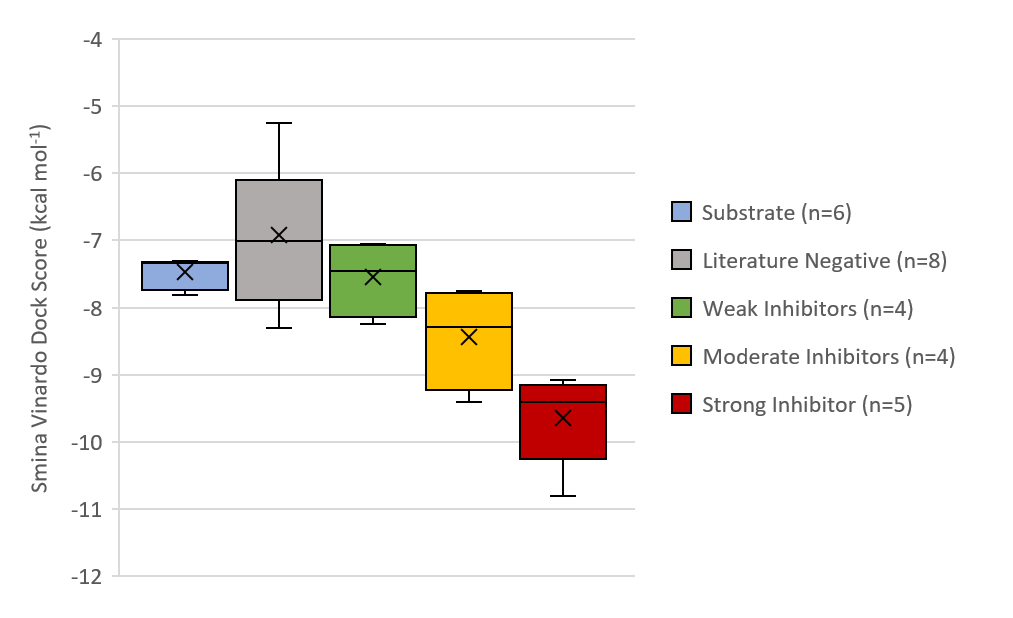

This work produced by the Vrije Universtiet Amsterdam and the Virtual Human Platform for Safety Assessment.
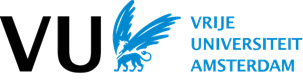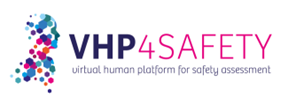

In [ ]:
# @title Setup
# @markdown Run this cell to set up the system. This should take a little time to execute.

## Basic Imports
import os
import subprocess
from tqdm import tqdm
import google.colab
from google.colab import output
from google.colab import files

import pandas as pd
import numpy  as np

## Install gnina
if(not os.path.exists("gnina")):
  ! wget https://github.com/gnina/gnina/releases/download/v1.3/gnina >& /dev/null
  ! chmod +x gnina >& /dev/null

## Install rdkit
try:
  import rdkit
except:
  print("Installing RDKIT")
  ! pip install rdkit >& /dev/null

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

## Install py3dmol
try:
  import py3Dmol
except:
  !pip install py3Dmol
  import py3Dmol

## Normal imports
import pandas
import io
import math

site='''HETATM    1  C   SIT E   1       2.352  -9.145   8.079  1.00 37.89           C
HETATM    2  C   SIT E   1       2.081 -10.116   7.032  1.00 32.58           C
HETATM    3  C   SIT E   1       3.692  -9.231   8.656  1.00 30.81           C
HETATM    4  C   SIT E   1       1.996  -7.771   7.695  1.00 33.02           C
HETATM    5  C   SIT E   1       1.388  -9.481   9.269  1.00 32.44           C
HETATM    6  C   SIT E   1       0.257 -10.187   9.081  1.00 34.12           C
HETATM    7  C   SIT E   1      -0.607 -10.130  10.267  1.00 35.22           C
HETATM    8  C   SIT E   1       0.012 -10.820  11.298  1.00 33.96           C
HETATM    9  C   SIT E   1      -0.849  -8.739  10.746  1.00 31.23           C
HETATM   10  C   SIT E   1      -2.211  -8.596  10.974  1.00 28.57           C
HETATM   11  C   SIT E   1      -0.110  -8.640  12.013  1.00 34.73           C
HETATM   12  C   SIT E   1      -0.740  -7.842  12.929  1.00 28.19           C
HETATM   13  C   SIT E   1      -0.047 -10.055  12.459  1.00 36.34           C
HETATM   14  C   SIT E   1       1.107 -10.324  13.239  1.00 33.75           C
HETATM   15  C   SIT E   1       2.366 -10.297  12.803  1.00 31.31           C
HETATM   16  C   SIT E   1       3.188 -10.640  13.761  1.00 30.74           C
HETATM   17  C   SIT E   1       2.431 -10.891  14.838  1.00 28.96           C
HETATM   18  C   SIT E   1       2.699 -11.294  16.134  1.00 27.96           C
HETATM   19  C   SIT E   1       3.895 -11.526  16.552  1.00 26.80           C
HETATM   20  C   SIT E   1       1.682 -11.452  16.960  1.00 29.89           C
HETATM   21  C   SIT E   1       0.450 -11.222  16.564  1.00 27.00           C
HETATM   22  C   SIT E   1       0.126 -10.841  15.356  1.00 28.72           C
HETATM   23  C   SIT E   1       1.106 -10.681  14.500  1.00 30.95           C'''
with open("site.pdb", "w") as f:
  f.write(site)

mct8='''ATOM      1  N   MET A   1     -24.299   3.374   2.854  1.00 20.92           N
ATOM      2  CA  MET A   1     -24.298   3.127   1.415  1.00 27.53           C
ATOM      3  C   MET A   1     -23.453   4.176   0.707  1.00 27.97           C
ATOM      4  O   MET A   1     -23.663   5.372   0.888  1.00 27.01           O
ATOM      5  CB  MET A   1     -25.721   3.145   0.862  1.00 27.93           C
ATOM      6  CG  MET A   1     -26.600   2.033   1.396  1.00 26.62           C
ATOM      7  SD  MET A   1     -28.261   2.104   0.706  1.00 24.72           S
ATOM      8  CE  MET A   1     -29.002   0.687   1.512  1.00 22.32           C
ATOM      9  H1  MET A   1     -25.273   3.318   3.215  1.00 20.92           H
ATOM     10  H2  MET A   1     -23.712   2.659   3.329  1.00 20.92           H
ATOM     11  H3  MET A   1     -23.913   4.321   3.044  1.00 20.92           H
ATOM     12  HA  MET A   1     -23.870   2.141   1.236  1.00 27.53           H
ATOM     13  HB2 MET A   1     -26.181   4.104   1.100  1.00 27.93           H
ATOM     14  HB3 MET A   1     -25.679   3.072  -0.225  1.00 27.93           H
ATOM     15  HG2 MET A   1     -26.150   1.069   1.161  1.00 26.62           H
ATOM     16  HG3 MET A   1     -26.654   2.103   2.482  1.00 26.62           H
ATOM     17  HE1 MET A   1     -30.039   0.587   1.192  1.00 22.32           H
ATOM     18  HE2 MET A   1     -28.451  -0.214   1.243  1.00 22.32           H
ATOM     19  HE3 MET A   1     -28.968   0.824   2.593  1.00 22.32           H
ATOM     20  N   ALA A   2     -22.500   3.706  -0.088  1.00 33.60           N
ATOM     21  CA  ALA A   2     -21.589   4.612  -0.780  1.00 36.21           C
ATOM     22  C   ALA A   2     -22.309   5.470  -1.812  1.00 34.82           C
ATOM     23  O   ALA A   2     -21.928   6.624  -2.037  1.00 33.01           O
ATOM     24  CB  ALA A   2     -20.466   3.818  -1.448  1.00 34.81           C
ATOM     25  H   ALA A   2     -22.338   2.715  -0.269  1.00 33.60           H
ATOM     26  HA  ALA A   2     -21.166   5.284  -0.033  1.00 36.21           H
ATOM     27  HB1 ALA A   2     -19.792   4.503  -1.962  1.00 34.81           H
ATOM     28  HB2 ALA A   2     -19.912   3.264  -0.690  1.00 34.81           H
ATOM     29  HB3 ALA A   2     -20.893   3.120  -2.169  1.00 34.81           H
ATOM     30  N   LEU A   3     -23.330   4.911  -2.436  1.00 34.44           N
ATOM     31  CA  LEU A   3     -24.074   5.671  -3.436  1.00 38.23           C
ATOM     32  C   LEU A   3     -24.789   6.858  -2.810  1.00 37.04           C
ATOM     33  O   LEU A   3     -24.774   7.963  -3.362  1.00 35.66           O
ATOM     34  CB  LEU A   3     -25.071   4.756  -4.146  1.00 37.31           C
ATOM     35  CG  LEU A   3     -25.883   5.389  -5.271  1.00 35.39           C
ATOM     36  CD1 LEU A   3     -24.976   5.851  -6.389  1.00 34.69           C
ATOM     37  CD2 LEU A   3     -26.921   4.407  -5.790  1.00 37.63           C
ATOM     38  H   LEU A   3     -23.660   3.959  -2.278  1.00 34.44           H
ATOM     39  HA  LEU A   3     -23.366   6.062  -4.166  1.00 38.23           H
ATOM     40  HB2 LEU A   3     -24.525   3.906  -4.554  1.00 37.31           H
ATOM     41  HB3 LEU A   3     -25.764   4.362  -3.403  1.00 37.31           H
ATOM     42  HG  LEU A   3     -26.402   6.262  -4.875  1.00 35.39           H
ATOM     43 HD11 LEU A   3     -25.575   6.300  -7.182  1.00 34.69           H
ATOM     44 HD12 LEU A   3     -24.272   6.589  -6.005  1.00 34.69           H
ATOM     45 HD13 LEU A   3     -24.427   4.998  -6.788  1.00 34.69           H
ATOM     46 HD21 LEU A   3     -27.493   4.873  -6.593  1.00 37.63           H
ATOM     47 HD22 LEU A   3     -26.421   3.516  -6.170  1.00 37.63           H
ATOM     48 HD23 LEU A   3     -27.594   4.127  -4.980  1.00 37.63           H
ATOM     49  N   GLN A   4     -25.398   6.632  -1.668  1.00 34.03           N
ATOM     50  CA  GLN A   4     -26.101   7.714  -0.988  1.00 38.71           C
ATOM     51  C   GLN A   4     -25.123   8.761  -0.472  1.00 37.70           C
ATOM     52  O   GLN A   4     -25.403   9.964  -0.524  1.00 36.77           O
ATOM     53  CB  GLN A   4     -26.946   7.152   0.155  1.00 38.01           C
ATOM     54  CG  GLN A   4     -27.994   8.120   0.694  1.00 36.85           C
ATOM     55  CD  GLN A   4     -27.444   9.038   1.757  1.00 34.79           C
ATOM     56  OE1 GLN A   4     -26.449   8.723   2.414  1.00 34.94           O
ATOM     57  NE2 GLN A   4     -28.076  10.190   1.935  1.00 35.42           N
ATOM     58  H   GLN A   4     -25.426   5.730  -1.192  1.00 34.03           H
ATOM     59  HA  GLN A   4     -26.761   8.202  -1.705  1.00 38.71           H
ATOM     60  HB2 GLN A   4     -27.447   6.247  -0.190  1.00 38.01           H
ATOM     61  HB3 GLN A   4     -26.285   6.859   0.971  1.00 38.01           H
ATOM     62  HG2 GLN A   4     -28.388   8.717  -0.128  1.00 36.85           H
ATOM     63  HG3 GLN A   4     -28.829   7.553   1.105  1.00 36.85           H
ATOM     64 HE21 GLN A   4     -28.896  10.414   1.371  1.00 35.42           H
ATOM     65 HE22 GLN A   4     -27.742  10.852   2.636  1.00 35.42           H
ATOM     66  N   SER A   5     -23.967   8.323   0.025  1.00 41.86           N
ATOM     67  CA  SER A   5     -22.961   9.272   0.494  1.00 44.20           C
ATOM     68  C   SER A   5     -22.410  10.099  -0.661  1.00 43.39           C
ATOM     69  O   SER A   5     -22.165  11.299  -0.508  1.00 41.59           O
ATOM     70  CB  SER A   5     -21.832   8.530   1.208  1.00 43.00           C
ATOM     71  OG  SER A   5     -21.133   7.693   0.313  1.00 39.90           O
ATOM     72  H   SER A   5     -23.708   7.340   0.112  1.00 41.86           H
ATOM     73  HA  SER A   5     -23.435   9.955   1.199  1.00 44.20           H
ATOM     74  HB2 SER A   5     -21.144   9.249   1.653  1.00 43.00           H
ATOM     75  HB3 SER A   5     -22.242   7.935   2.024  1.00 43.00           H
ATOM     76  HG  SER A   5     -21.737   7.401  -0.402  1.00 39.90           H
ATOM     77  N   GLN A   6     -22.229   9.467  -1.802  1.00 40.50           N
ATOM     78  CA  GLN A   6     -21.775  10.196  -2.976  1.00 45.33           C
ATOM     79  C   GLN A   6     -22.816  11.209  -3.424  1.00 45.16           C
ATOM     80  O   GLN A   6     -22.476  12.321  -3.833  1.00 43.27           O
ATOM     81  CB  GLN A   6     -21.457   9.220  -4.110  1.00 43.92           C
ATOM     82  CG  GLN A   6     -20.901   9.878  -5.360  1.00 42.55           C
ATOM     83  CD  GLN A   6     -19.563  10.528  -5.124  1.00 39.79           C
ATOM     84  OE1 GLN A   6     -18.748  10.039  -4.341  1.00 39.15           O
ATOM     85  NE2 GLN A   6     -19.317  11.644  -5.795  1.00 39.44           N
ATOM     86  H   GLN A   6     -22.385   8.469  -1.945  1.00 40.50           H
ATOM     87  HA  GLN A   6     -20.868  10.740  -2.713  1.00 45.33           H
ATOM     88  HB2 GLN A   6     -20.738   8.484  -3.750  1.00 43.92           H
ATOM     89  HB3 GLN A   6     -22.365   8.677  -4.372  1.00 43.92           H
ATOM     90  HG2 GLN A   6     -20.804   9.131  -6.148  1.00 42.55           H
ATOM     91  HG3 GLN A   6     -21.607  10.628  -5.717  1.00 42.55           H
ATOM     92 HE21 GLN A   6     -20.017  12.019  -6.435  1.00 39.44           H
ATOM     93 HE22 GLN A   6     -18.428  12.128  -5.671  1.00 39.44           H
ATOM     94  N   ALA A   7     -24.054  10.835  -3.313  1.00 43.70           N
ATOM     95  CA  ALA A   7     -25.132  11.751  -3.668  1.00 47.22           C
ATOM     96  C   ALA A   7     -25.189  12.930  -2.705  1.00 46.85           C
ATOM     97  O   ALA A   7     -25.456  14.062  -3.113  1.00 44.95           O
ATOM     98  CB  ALA A   7     -26.466  11.015  -3.683  1.00 45.78           C
ATOM     99  H   ALA A   7     -24.356   9.918  -2.985  1.00 43.70           H
ATOM    100  HA  ALA A   7     -24.932  12.140  -4.666  1.00 47.22           H
ATOM    101  HB1 ALA A   7     -27.262  11.710  -3.949  1.00 45.78           H
ATOM    102  HB2 ALA A   7     -26.428  10.209  -4.415  1.00 45.78           H
ATOM    103  HB3 ALA A   7     -26.663  10.599  -2.695  1.00 45.78           H
HETATM  104  N   SEP A   8     -24.933  12.717  -1.458  1.00 52.46           N
HETATM  105  CA  SEP A   8     -24.822  13.804  -0.540  1.00 54.89           C
HETATM  106  CB  SEP A   8     -24.647  13.358   0.862  1.00 39.59           C
HETATM  107  OG  SEP A   8     -25.874  13.144   1.323  1.00 33.89           O
HETATM  108  C   SEP A   8     -23.647  14.727  -0.862  1.00 51.64           C
HETATM  109  O   SEP A   8     -23.822  15.958  -0.788  1.00 51.79           O
HETATM  110  P   SEP A   8     -26.351  13.802   2.603  1.00 32.48           P
HETATM  111  O1P SEP A   8     -27.188  14.925   2.239  1.00 26.30           O
HETATM  112  O2P SEP A   8     -27.109  12.698   3.247  1.00 28.12           O
HETATM  113  O3P SEP A   8     -25.157  14.192   3.407  1.00 24.32           O
HETATM  114  HB3 SEP A   8     -24.045  12.451   0.913  1.00 39.59           H
HETATM  115  HB2 SEP A   8     -24.132  14.115   1.453  1.00 39.59           H
HETATM  116  HA  SEP A   8     -25.766  14.339  -0.648  1.00 54.89           H
HETATM  117  H   SEP A   8     -24.888  11.756  -1.119  1.00 52.46           H
ATOM    118  N   GLU A   9     -22.573  14.219  -1.261  1.00 45.00           N
ATOM    119  CA  GLU A   9     -21.476  15.059  -1.704  1.00 48.21           C
ATOM    120  C   GLU A   9     -21.837  15.798  -2.986  1.00 46.60           C
ATOM    121  O   GLU A   9     -21.479  16.968  -3.145  1.00 44.96           O
ATOM    122  CB  GLU A   9     -20.227  14.222  -1.910  1.00 46.69           C
ATOM    123  CG  GLU A   9     -19.651  13.633  -0.631  1.00 43.48           C
ATOM    124  CD  GLU A   9     -18.411  12.800  -0.882  1.00 41.05           C
ATOM    125  OE1 GLU A   9     -18.078  12.578  -2.060  1.00 38.59           O
ATOM    126  OE2 GLU A   9     -17.780  12.360   0.098  1.00 41.12           O
ATOM    127  H   GLU A   9     -22.390  13.216  -1.305  1.00 45.00           H
ATOM    128  HA  GLU A   9     -21.280  15.802  -0.931  1.00 48.21           H
ATOM    129  HB2 GLU A   9     -20.458  13.409  -2.599  1.00 46.69           H
ATOM    130  HB3 GLU A   9     -19.465  14.838  -2.388  1.00 46.69           H
ATOM    131  HG2 GLU A   9     -19.408  14.441   0.060  1.00 43.48           H
ATOM    132  HG3 GLU A   9     -20.407  13.016  -0.147  1.00 43.48           H
ATOM    133  N   GLU A  10     -22.523  15.131  -3.875  1.00 43.05           N
ATOM    134  CA  GLU A  10     -22.987  15.782  -5.092  1.00 45.97           C
ATOM    135  C   GLU A  10     -23.978  16.897  -4.791  1.00 44.41           C
ATOM    136  O   GLU A  10     -24.050  17.882  -5.535  1.00 42.67           O
ATOM    137  CB  GLU A  10     -23.631  14.762  -6.028  1.00 44.33           C
ATOM    138  CG  GLU A  10     -22.651  13.755  -6.601  1.00 40.47           C
ATOM    139  CD  GLU A  10     -21.684  14.387  -7.579  1.00 38.53           C
ATOM    140  OE1 GLU A  10     -22.047  15.396  -8.212  1.00 36.53           O
ATOM    141  OE2 GLU A  10     -20.556  13.875  -7.709  1.00 38.54           O
ATOM    142  H   GLU A  10     -22.776  14.147  -3.790  1.00 43.05           H
ATOM    143  HA  GLU A  10     -22.117  16.223  -5.577  1.00 45.97           H
ATOM    144  HB2 GLU A  10     -24.412  14.228  -5.487  1.00 44.33           H
ATOM    145  HB3 GLU A  10     -24.116  15.291  -6.848  1.00 44.33           H
ATOM    146  HG2 GLU A  10     -22.092  13.293  -5.788  1.00 40.47           H
ATOM    147  HG3 GLU A  10     -23.202  12.959  -7.102  1.00 40.47           H
ATOM    148  N   ALA A  11     -24.714  16.759  -3.729  1.00 43.74           N
ATOM    149  CA  ALA A  11     -25.618  17.828  -3.318  1.00 44.69           C
ATOM    150  C   ALA A  11     -24.868  18.981  -2.666  1.00 42.95           C
ATOM    151  O   ALA A  11     -25.260  20.143  -2.812  1.00 40.75           O
ATOM    152  CB  ALA A  11     -26.683  17.285  -2.370  1.00 43.43           C
ATOM    153  H   ALA A  11     -24.718  15.934  -3.129  1.00 43.74           H
ATOM    154  HA  ALA A  11     -26.102  18.215  -4.215  1.00 44.69           H
ATOM    155  HB1 ALA A  11     -27.351  18.093  -2.071  1.00 43.43           H
ATOM    156  HB2 ALA A  11     -27.257  16.508  -2.875  1.00 43.43           H
ATOM    157  HB3 ALA A  11     -26.203  16.865  -1.486  1.00 43.43           H
ATOM    158  N   LYS A  12     -23.789  18.669  -1.957  1.00 39.10           N
ATOM    159  CA  LYS A  12     -23.015  19.718  -1.303  1.00 42.93           C
ATOM    160  C   LYS A  12     -22.207  20.544  -2.297  1.00 40.71           C
ATOM    161  O   LYS A  12     -22.038  21.755  -2.106  1.00 39.23           O
ATOM    162  CB  LYS A  12     -22.081  19.111  -0.255  1.00 43.16           C
ATOM    163  CG  LYS A  12     -22.796  18.499   0.933  1.00 40.70           C
ATOM    164  CD  LYS A  12     -21.804  17.931   1.925  1.00 39.82           C
ATOM    165  CE  LYS A  12     -22.509  17.315   3.123  1.00 36.89           C
ATOM    166  NZ  LYS A  12     -21.541  16.733   4.090  1.00 35.44           N
ATOM    167  H   LYS A  12     -23.436  17.722  -1.822  1.00 39.10           H
ATOM    168  HA  LYS A  12     -23.726  20.387  -0.819  1.00 42.93           H
ATOM    169  HB2 LYS A  12     -21.468  18.345  -0.730  1.00 43.16           H
ATOM    170  HB3 LYS A  12     -21.402  19.885   0.103  1.00 43.16           H
ATOM    171  HG2 LYS A  12     -23.412  19.254   1.421  1.00 40.70           H
ATOM    172  HG3 LYS A  12     -23.468  17.711   0.592  1.00 40.70           H
ATOM    173  HD2 LYS A  12     -21.189  17.176   1.435  1.00 39.82           H
ATOM    174  HD3 LYS A  12     -21.132  18.720   2.262  1.00 39.82           H
ATOM    175  HE2 LYS A  12     -23.110  18.075   3.622  1.00 36.89           H
ATOM    176  HE3 LYS A  12     -23.195  16.539   2.783  1.00 36.89           H
ATOM    177  HZ1 LYS A  12     -22.058  16.322   4.894  1.00 35.44           H
ATOM    178  HZ2 LYS A  12     -20.985  15.991   3.620  1.00 35.44           H
ATOM    179  HZ3 LYS A  12     -20.903  17.479   4.434  1.00 35.44           H
ATOM    180  N   GLY A  13     -21.699  19.891  -3.335  1.00 38.77           N
ATOM    181  CA  GLY A  13     -20.925  20.606  -4.334  1.00 42.30           C
ATOM    182  C   GLY A  13     -21.682  21.705  -5.051  1.00 40.24           C
ATOM    183  O   GLY A  13     -21.162  22.816  -5.199  1.00 37.88           O
ATOM    184  H   GLY A  13     -21.807  18.891  -3.503  1.00 38.77           H
ATOM    185  HA2 GLY A  13     -20.049  21.041  -3.853  1.00 42.30           H
ATOM    186  HA3 GLY A  13     -20.562  19.892  -5.073  1.00 42.30           H
ATOM    187  N   PRO A  14     -22.877  21.422  -5.507  1.00 33.12           N
ATOM    188  CA  PRO A  14     -23.659  22.448  -6.210  1.00 35.71           C
ATOM    189  C   PRO A  14     -23.954  23.705  -5.409  1.00 36.01           C
ATOM    190  O   PRO A  14     -24.199  24.748  -6.017  1.00 34.32           O
ATOM    191  CB  PRO A  14     -24.953  21.717  -6.564  1.00 33.65           C
ATOM    192  CG  PRO A  14     -24.525  20.323  -6.751  1.00 34.34           C
ATOM    193  CD  PRO A  14     -23.437  20.101  -5.733  1.00 38.94           C
ATOM    194  HA  PRO A  14     -23.099  22.833  -7.062  1.00 35.71           H
ATOM    195  HB2 PRO A  14     -25.693  21.805  -5.769  1.00 33.65           H
ATOM    196  HB3 PRO A  14     -25.407  22.121  -7.469  1.00 33.65           H
ATOM    197  HG2 PRO A  14     -25.355  19.633  -6.597  1.00 34.34           H
ATOM    198  HG3 PRO A  14     -24.156  20.157  -7.763  1.00 34.34           H
ATOM    199  HD2 PRO A  14     -23.836  19.676  -4.812  1.00 38.94           H
ATOM    200  HD3 PRO A  14     -22.682  19.408  -6.103  1.00 38.94           H
ATOM    201  N   TRP A  15     -23.926  23.644  -4.095  1.00 28.94           N
ATOM    202  CA  TRP A  15     -24.127  24.869  -3.324  1.00 30.40           C
ATOM    203  C   TRP A  15     -22.976  25.842  -3.527  1.00 29.70           C
ATOM    204  O   TRP A  15     -23.184  27.020  -3.829  1.00 28.29           O
ATOM    205  CB  TRP A  15     -24.307  24.550  -1.841  1.00 29.36           C
ATOM    206  CG  TRP A  15     -25.613  23.902  -1.525  1.00 28.98           C
ATOM    207  CD1 TRP A  15     -25.819  22.605  -1.154  1.00 26.63           C
ATOM    208  CD2 TRP A  15     -26.898  24.520  -1.552  1.00 28.26           C
ATOM    209  NE1 TRP A  15     -27.148  22.374  -0.952  1.00 28.10           N
ATOM    210  CE2 TRP A  15     -27.841  23.524  -1.185  1.00 28.95           C
ATOM    211  CE3 TRP A  15     -27.353  25.804  -1.847  1.00 30.95           C
ATOM    212  CZ2 TRP A  15     -29.204  23.792  -1.112  1.00 30.17           C
ATOM    213  CZ3 TRP A  15     -28.707  26.062  -1.774  1.00 28.07           C
ATOM    214  CH2 TRP A  15     -29.624  25.061  -1.403  1.00 28.05           C
ATOM    215  H   TRP A  15     -23.773  22.797  -3.547  1.00 28.94           H
ATOM    216  HA  TRP A  15     -25.037  25.346  -3.687  1.00 30.40           H
ATOM    217  HB2 TRP A  15     -23.498  23.895  -1.518  1.00 29.36           H
ATOM    218  HB3 TRP A  15     -24.220  25.472  -1.266  1.00 29.36           H
ATOM    219  HD1 TRP A  15     -25.040  21.866  -1.037  1.00 26.63           H
ATOM    220  HE1 TRP A  15     -27.558  21.483  -0.671  1.00 28.10           H
ATOM    221  HE3 TRP A  15     -26.659  26.583  -2.127  1.00 30.95           H
ATOM    222  HZ2 TRP A  15     -29.909  23.022  -0.834  1.00 30.17           H
ATOM    223  HZ3 TRP A  15     -29.070  27.052  -2.006  1.00 28.07           H
ATOM    224  HH2 TRP A  15     -30.676  25.298  -1.347  1.00 28.05           H
ATOM    225  N   GLN A  16     -21.771  25.347  -3.379  1.00 32.79           N
ATOM    226  CA  GLN A  16     -20.602  26.174  -3.640  1.00 37.99           C
ATOM    227  C   GLN A  16     -20.525  26.560  -5.108  1.00 36.72           C
ATOM    228  O   GLN A  16     -20.128  27.680  -5.446  1.00 35.63           O
ATOM    229  CB  GLN A  16     -19.339  25.451  -3.212  1.00 37.64           C
ATOM    230  CG  GLN A  16     -18.071  26.263  -3.366  1.00 36.46           C
ATOM    231  CD  GLN A  16     -16.842  25.502  -2.928  1.00 34.55           C
ATOM    232  OE1 GLN A  16     -16.929  24.339  -2.532  1.00 34.73           O
ATOM    233  NE2 GLN A  16     -15.687  26.152  -3.000  1.00 35.58           N
ATOM    234  H   GLN A  16     -21.568  24.392  -3.084  1.00 32.79           H
ATOM    235  HA  GLN A  16     -20.695  27.090  -3.056  1.00 37.99           H
ATOM    236  HB2 GLN A  16     -19.441  25.154  -2.168  1.00 37.64           H
ATOM    237  HB3 GLN A  16     -19.243  24.536  -3.796  1.00 37.64           H
ATOM    238  HG2 GLN A  16     -17.958  26.561  -4.408  1.00 36.46           H
ATOM    239  HG3 GLN A  16     -18.156  27.178  -2.780  1.00 36.46           H
ATOM    240 HE21 GLN A  16     -15.664  27.115  -3.335  1.00 35.58           H
ATOM    241 HE22 GLN A  16     -14.823  25.688  -2.721  1.00 35.58           H
ATOM    242  N   GLU A  17     -20.906  25.642  -5.966  1.00 32.80           N
ATOM    243  CA  GLU A  17     -20.909  25.925  -7.394  1.00 36.03           C
ATOM    244  C   GLU A  17     -21.924  27.005  -7.742  1.00 33.87           C
ATOM    245  O   GLU A  17     -21.657  27.863  -8.587  1.00 32.89           O
ATOM    246  CB  GLU A  17     -21.191  24.649  -8.170  1.00 35.74           C
ATOM    247  CG  GLU A  17     -21.056  24.790  -9.671  1.00 33.92           C
ATOM    248  CD  GLU A  17     -21.290  23.483 -10.394  1.00 33.32           C
ATOM    249  OE1 GLU A  17     -21.561  22.470  -9.714  1.00 31.96           O
ATOM    250  OE2 GLU A  17     -21.205  23.471 -11.633  1.00 35.40           O
ATOM    251  H   GLU A  17     -21.215  24.704  -5.712  1.00 32.80           H
ATOM    252  HA  GLU A  17     -19.925  26.301  -7.674  1.00 36.03           H
ATOM    253  HB2 GLU A  17     -20.509  23.871  -7.827  1.00 35.74           H
ATOM    254  HB3 GLU A  17     -22.201  24.312  -7.938  1.00 35.74           H
ATOM    255  HG2 GLU A  17     -21.768  25.533 -10.029  1.00 33.92           H
ATOM    256  HG3 GLU A  17     -20.060  25.162  -9.911  1.00 33.92           H
ATOM    257  N   ALA A  18     -23.059  26.981  -7.093  1.00 39.73           N
ATOM    258  CA  ALA A  18     -24.061  28.011  -7.318  1.00 41.36           C
ATOM    259  C   ALA A  18     -23.601  29.359  -6.787  1.00 39.41           C
ATOM    260  O   ALA A  18     -23.858  30.397  -7.408  1.00 37.49           O
ATOM    261  CB  ALA A  18     -25.386  27.610  -6.673  1.00 39.81           C
ATOM    262  H   ALA A  18     -23.319  26.270  -6.409  1.00 39.73           H
ATOM    263  HA  ALA A  18     -24.205  28.108  -8.394  1.00 41.36           H
ATOM    264  HB1 ALA A  18     -26.127  28.390  -6.849  1.00 39.81           H
ATOM    265  HB2 ALA A  18     -25.734  26.674  -7.109  1.00 39.81           H
ATOM    266  HB3 ALA A  18     -25.244  27.480  -5.600  1.00 39.81           H
ATOM    267  N   ASP A  19     -22.913  29.353  -5.656  1.00 35.13           N
ATOM    268  CA  ASP A  19     -22.379  30.601  -5.120  1.00 38.33           C
ATOM    269  C   ASP A  19     -21.339  31.199  -6.053  1.00 36.79           C
ATOM    270  O   ASP A  19     -21.328  32.411  -6.292  1.00 35.10           O
ATOM    271  CB  ASP A  19     -21.774  30.365  -3.738  1.00 37.12           C
ATOM    272  CG  ASP A  19     -22.817  30.000  -2.706  1.00 34.04           C
ATOM    273  OD1 ASP A  19     -23.988  30.379  -2.891  1.00 34.28           O
ATOM    274  OD2 ASP A  19     -22.465  29.340  -1.713  1.00 34.74           O
ATOM    275  H   ASP A  19     -22.713  28.521  -5.101  1.00 35.13           H
ATOM    276  HA  ASP A  19     -23.202  31.310  -5.032  1.00 38.33           H
ATOM    277  HB2 ASP A  19     -21.034  29.567  -3.800  1.00 37.12           H
ATOM    278  HB3 ASP A  19     -21.248  31.264  -3.417  1.00 37.12           H
ATOM    279  N   GLN A  20     -20.482  30.353  -6.582  1.00 34.81           N
ATOM    280  CA  GLN A  20     -19.486  30.830  -7.528  1.00 38.99           C
ATOM    281  C   GLN A  20     -20.134  31.303  -8.818  1.00 37.50           C
ATOM    282  O   GLN A  20     -19.668  32.258  -9.439  1.00 36.28           O
ATOM    283  CB  GLN A  20     -18.466  29.743  -7.817  1.00 38.64           C
ATOM    284  CG  GLN A  20     -17.314  30.191  -8.687  1.00 37.74           C
ATOM    285  CD  GLN A  20     -16.299  29.098  -8.921  1.00 36.01           C
ATOM    286  OE1 GLN A  20     -16.459  27.981  -8.437  1.00 36.40           O
ATOM    287  NE2 GLN A  20     -15.247  29.415  -9.666  1.00 36.87           N
ATOM    288  H   GLN A  20     -20.450  29.353  -6.382  1.00 34.81           H
ATOM    289  HA  GLN A  20     -18.975  31.681  -7.076  1.00 38.99           H
ATOM    290  HB2 GLN A  20     -18.070  29.371  -6.872  1.00 38.64           H
ATOM    291  HB3 GLN A  20     -18.970  28.907  -8.302  1.00 38.64           H
ATOM    292  HG2 GLN A  20     -17.701  30.533  -9.647  1.00 37.74           H
ATOM    293  HG3 GLN A  20     -16.822  31.044  -8.220  1.00 37.74           H
ATOM    294 HE21 GLN A  20     -15.157  30.357 -10.047  1.00 36.87           H
ATOM    295 HE22 GLN A  20     -14.529  28.717  -9.857  1.00 36.87           H
ATOM    296  N   GLU A  21     -21.194  30.636  -9.216  1.00 34.38           N
ATOM    297  CA  GLU A  21     -21.909  31.052 -10.413  1.00 38.11           C
ATOM    298  C   GLU A  21     -22.565  32.410 -10.219  1.00 36.52           C
ATOM    299  O   GLU A  21     -22.575  33.235 -11.136  1.00 35.76           O
ATOM    300  CB  GLU A  21     -22.948  30.008 -10.798  1.00 37.72           C
ATOM    301  CG  GLU A  21     -23.676  30.307 -12.092  1.00 35.80           C
ATOM    302  CD  GLU A  21     -24.706  29.257 -12.440  1.00 34.66           C
ATOM    303  OE1 GLU A  21     -24.876  28.310 -11.648  1.00 32.89           O
ATOM    304  OE2 GLU A  21     -25.347  29.393 -13.500  1.00 35.73           O
ATOM    305  H   GLU A  21     -21.579  29.818  -8.743  1.00 34.38           H
ATOM    306  HA  GLU A  21     -21.186  31.143 -11.223  1.00 38.11           H
ATOM    307  HB2 GLU A  21     -22.458  29.038 -10.885  1.00 37.72           H
ATOM    308  HB3 GLU A  21     -23.679  29.925  -9.994  1.00 37.72           H
ATOM    309  HG2 GLU A  21     -24.166  31.278 -12.012  1.00 35.80           H
ATOM    310  HG3 GLU A  21     -22.951  30.381 -12.903  1.00 35.80           H
ATOM    311  N   GLN A  22     -23.092  32.642  -9.038  1.00 34.88           N
ATOM    312  CA  GLN A  22     -23.653  33.955  -8.745  1.00 37.43           C
ATOM    313  C   GLN A  22     -22.573  35.024  -8.694  1.00 36.21           C
ATOM    314  O   GLN A  22     -22.800  36.167  -9.097  1.00 35.09           O
ATOM    315  CB  GLN A  22     -24.418  33.915  -7.427  1.00 37.10           C
ATOM    316  CG  GLN A  22     -25.682  33.080  -7.460  1.00 36.07           C
ATOM    317  CD  GLN A  22     -26.397  33.049  -6.128  1.00 34.63           C
ATOM    318  OE1 GLN A  22     -25.891  33.564  -5.132  1.00 35.32           O
ATOM    319  NE2 GLN A  22     -27.577  32.447  -6.095  1.00 35.19           N
ATOM    320  H   GLN A  22     -23.147  31.963  -8.278  1.00 34.88           H
ATOM    321  HA  GLN A  22     -24.339  34.214  -9.551  1.00 37.43           H
ATOM    322  HB2 GLN A  22     -23.760  33.524  -6.651  1.00 37.10           H
ATOM    323  HB3 GLN A  22     -24.678  34.934  -7.141  1.00 37.10           H
ATOM    324  HG2 GLN A  22     -26.355  33.477  -8.220  1.00 36.07           H
ATOM    325  HG3 GLN A  22     -25.432  32.062  -7.757  1.00 36.07           H
ATOM    326 HE21 GLN A  22     -27.962  32.032  -6.944  1.00 35.19           H
ATOM    327 HE22 GLN A  22     -28.101  32.398  -5.221  1.00 35.19           H
ATOM    328  N   GLN A  23     -21.399  34.648  -8.206  1.00 38.25           N
ATOM    329  CA  GLN A  23     -20.303  35.602  -8.137  1.00 40.38           C
ATOM    330  C   GLN A  23     -19.699  35.879  -9.505  1.00 38.23           C
ATOM    331  O   GLN A  23     -19.229  36.991  -9.761  1.00 37.45           O
ATOM    332  CB  GLN A  23     -19.235  35.099  -7.178  1.00 40.54           C
ATOM    333  CG  GLN A  23     -18.121  36.089  -6.916  1.00 39.37           C
ATOM    334  CD  GLN A  23     -17.110  35.570  -5.920  1.00 37.25           C
ATOM    335  OE1 GLN A  23     -17.230  34.444  -5.435  1.00 37.47           O
ATOM    336  NE2 GLN A  23     -16.108  36.382  -5.614  1.00 37.76           N
ATOM    337  H   GLN A  23     -21.184  33.713  -7.860  1.00 38.25           H
ATOM    338  HA  GLN A  23     -20.708  36.544  -7.767  1.00 40.38           H
ATOM    339  HB2 GLN A  23     -19.707  34.840  -6.230  1.00 40.54           H
ATOM    340  HB3 GLN A  23     -18.804  34.182  -7.580  1.00 40.54           H
ATOM    341  HG2 GLN A  23     -17.617  36.321  -7.854  1.00 39.37           H
ATOM    342  HG3 GLN A  23     -18.547  37.021  -6.545  1.00 39.37           H
ATOM    343 HE21 GLN A  23     -16.051  37.306  -6.042  1.00 37.76           H
ATOM    344 HE22 GLN A  23     -15.393  36.083  -4.950  1.00 37.76           H
ATOM    345  N   GLU A  24     -19.716  34.890 -10.376  1.00 37.61           N
ATOM    346  CA  GLU A  24     -19.074  35.019 -11.677  1.00 40.48           C
ATOM    347  C   GLU A  24     -20.079  34.733 -12.786  1.00 37.68           C
ATOM    348  O   GLU A  24     -20.224  33.588 -13.217  1.00 36.72           O
ATOM    349  CB  GLU A  24     -17.881  34.083 -11.773  1.00 40.17           C
ATOM    350  CG  GLU A  24     -17.086  34.229 -13.050  1.00 38.01           C
ATOM    351  CD  GLU A  24     -15.906  33.284 -13.105  1.00 36.06           C
ATOM    352  OE1 GLU A  24     -15.732  32.496 -12.155  1.00 34.70           O
ATOM    353  OE2 GLU A  24     -15.160  33.332 -14.104  1.00 37.77           O
ATOM    354  H   GLU A  24     -20.165  33.989 -10.211  1.00 37.61           H
ATOM    355  HA  GLU A  24     -18.713  36.041 -11.794  1.00 40.48           H
ATOM    356  HB2 GLU A  24     -17.222  34.263 -10.924  1.00 40.17           H
ATOM    357  HB3 GLU A  24     -18.232  33.054 -11.691  1.00 40.17           H
ATOM    358  HG2 GLU A  24     -17.737  34.043 -13.904  1.00 38.01           H
ATOM    359  HG3 GLU A  24     -16.730  35.256 -13.138  1.00 38.01           H
ATOM    360  N   PRO A  25     -20.776  35.741 -13.253  1.00 39.13           N
ATOM    361  CA  PRO A  25     -21.706  35.533 -14.366  1.00 41.04           C
ATOM    362  C   PRO A  25     -20.990  35.505 -15.712  1.00 40.10           C
ATOM    363  O   PRO A  25     -19.769  35.651 -15.786  1.00 38.09           O
ATOM    364  CB  PRO A  25     -22.646  36.736 -14.256  1.00 38.68           C
ATOM    365  CG  PRO A  25     -21.794  37.796 -13.665  1.00 38.46           C
ATOM    366  CD  PRO A  25     -20.836  37.106 -12.735  1.00 42.71           C
ATOM    367  HA  PRO A  25     -22.222  34.575 -14.312  1.00 41.04           H
ATOM    368  HB2 PRO A  25     -23.034  37.031 -15.231  1.00 38.68           H
ATOM    369  HB3 PRO A  25     -23.506  36.515 -13.624  1.00 38.68           H
ATOM    370  HG2 PRO A  25     -21.256  38.340 -14.442  1.00 38.46           H
ATOM    371  HG3 PRO A  25     -22.400  38.525 -13.127  1.00 38.46           H
ATOM    372  HD2 PRO A  25     -19.855  37.582 -12.745  1.00 42.71           H
ATOM    373  HD3 PRO A  25     -21.191  37.128 -11.705  1.00 42.71           H
ATOM    374  N   VAL A  26     -21.781  35.301 -16.754  1.00 40.31           N
ATOM    375  CA  VAL A  26     -21.345  35.326 -18.158  1.00 41.74           C
ATOM    376  C   VAL A  26     -20.046  34.565 -18.434  1.00 39.70           C
ATOM    377  O   VAL A  26     -19.079  35.118 -18.952  1.00 37.88           O
ATOM    378  CB  VAL A  26     -21.277  36.764 -18.723  1.00 40.90           C
ATOM    379  CG1 VAL A  26     -22.676  37.350 -18.807  1.00 37.75           C
ATOM    380  CG2 VAL A  26     -20.385  37.662 -17.891  1.00 40.38           C
ATOM    381  H   VAL A  26     -22.777  35.107 -16.652  1.00 40.31           H
ATOM    382  HA  VAL A  26     -22.124  34.783 -18.693  1.00 41.74           H
ATOM    383  HB  VAL A  26     -20.841  36.707 -19.720  1.00 40.90           H
ATOM    384 HG11 VAL A  26     -22.623  38.363 -19.206  1.00 37.75           H
ATOM    385 HG12 VAL A  26     -23.290  36.733 -19.464  1.00 37.75           H
ATOM    386 HG13 VAL A  26     -23.121  37.374 -17.812  1.00 37.75           H
ATOM    387 HG21 VAL A  26     -20.368  38.661 -18.326  1.00 40.38           H
ATOM    388 HG22 VAL A  26     -20.771  37.716 -16.873  1.00 40.38           H
ATOM    389 HG23 VAL A  26     -19.374  37.256 -17.875  1.00 40.38           H
ATOM    390  N   GLY A  27     -20.054  33.318 -18.102  1.00 41.98           N
ATOM    391  CA  GLY A  27     -19.021  32.418 -18.570  1.00 45.52           C
ATOM    392  C   GLY A  27     -17.652  32.575 -17.951  1.00 43.94           C
ATOM    393  O   GLY A  27     -17.517  32.797 -16.747  1.00 41.53           O
ATOM    394  H   GLY A  27     -20.761  32.885 -17.507  1.00 41.98           H
ATOM    395  HA2 GLY A  27     -19.357  31.396 -18.398  1.00 45.52           H
ATOM    396  HA3 GLY A  27     -18.923  32.544 -19.648  1.00 45.52           H
ATOM    397  N   SER A  28     -16.657  32.436 -18.793  1.00 38.82           N
ATOM    398  CA  SER A  28     -15.270  32.344 -18.354  1.00 40.96           C
ATOM    399  C   SER A  28     -14.668  33.625 -17.776  1.00 38.95           C
ATOM    400  O   SER A  28     -13.884  33.522 -16.829  1.00 37.24           O
ATOM    401  CB  SER A  28     -14.404  31.845 -19.510  1.00 39.64           C
ATOM    402  OG  SER A  28     -14.425  32.733 -20.587  1.00 37.47           O
ATOM    403  H   SER A  28     -16.777  32.383 -19.804  1.00 38.82           H
ATOM    404  HA  SER A  28     -15.281  31.640 -17.522  1.00 40.96           H
ATOM    405  HB2 SER A  28     -13.378  31.713 -19.166  1.00 39.64           H
ATOM    406  HB3 SER A  28     -14.759  30.868 -19.836  1.00 39.64           H
ATOM    407  HG  SER A  28     -13.860  32.386 -21.309  1.00 37.47           H
ATOM    408  N   PRO A  29     -14.960  34.805 -18.290  1.00 38.67           N
ATOM    409  CA  PRO A  29     -14.279  36.000 -17.763  1.00 41.34           C
ATOM    410  C   PRO A  29     -14.540  36.223 -16.280  1.00 40.77           C
ATOM    411  O   PRO A  29     -15.623  35.931 -15.775  1.00 38.75           O
ATOM    412  CB  PRO A  29     -14.854  37.142 -18.602  1.00 39.55           C
ATOM    413  CG  PRO A  29     -15.294  36.501 -19.857  1.00 39.99           C
ATOM    414  CD  PRO A  29     -15.807  35.155 -19.451  1.00 44.25           C
ATOM    415  HA  PRO A  29     -13.195  35.912 -17.836  1.00 41.34           H
ATOM    416  HB2 PRO A  29     -15.686  37.627 -18.092  1.00 39.55           H
ATOM    417  HB3 PRO A  29     -14.104  37.910 -18.791  1.00 39.55           H
ATOM    418  HG2 PRO A  29     -16.071  37.087 -20.347  1.00 39.99           H
ATOM    419  HG3 PRO A  29     -14.469  36.411 -20.564  1.00 39.99           H
ATOM    420  HD2 PRO A  29     -16.863  35.191 -19.183  1.00 44.25           H
ATOM    421  HD3 PRO A  29     -15.707  34.427 -20.256  1.00 44.25           H
ATOM    422  N   GLU A  30     -13.539  36.744 -15.609  1.00 35.76           N
ATOM    423  CA  GLU A  30     -13.607  36.958 -14.174  1.00 38.71           C
ATOM    424  C   GLU A  30     -13.145  38.376 -13.832  1.00 36.61           C
ATOM    425  O   GLU A  30     -12.112  38.560 -13.183  1.00 35.63           O
ATOM    426  CB  GLU A  30     -12.773  35.919 -13.445  1.00 38.34           C
ATOM    427  CG  GLU A  30     -12.983  35.876 -11.946  1.00 36.18           C
ATOM    428  CD  GLU A  30     -12.165  34.788 -11.279  1.00 35.19           C
ATOM    429  OE1 GLU A  30     -11.429  34.082 -11.995  1.00 34.16           O
ATOM    430  OE2 GLU A  30     -12.264  34.644 -10.043  1.00 36.57           O
ATOM    431  H   GLU A  30     -12.658  37.031 -16.035  1.00 35.76           H
ATOM    432  HA  GLU A  30     -14.641  36.848 -13.846  1.00 38.71           H
ATOM    433  HB2 GLU A  30     -13.000  34.936 -13.858  1.00 38.34           H
ATOM    434  HB3 GLU A  30     -11.719  36.113 -13.645  1.00 38.34           H
ATOM    435  HG2 GLU A  30     -12.717  36.842 -11.517  1.00 36.18           H
ATOM    436  HG3 GLU A  30     -14.040  35.714 -11.734  1.00 36.18           H
ATOM    437  N   PRO A  31     -13.865  39.397 -14.283  1.00 38.48           N
ATOM    438  CA  PRO A  31     -13.433  40.769 -13.971  1.00 40.99           C
ATOM    439  C   PRO A  31     -13.807  41.223 -12.571  1.00 40.32           C
ATOM    440  O   PRO A  31     -12.992  41.840 -11.878  1.00 38.54           O
ATOM    441  CB  PRO A  31     -14.145  41.603 -15.033  1.00 39.23           C
ATOM    442  CG  PRO A  31     -15.373  40.828 -15.342  1.00 39.49           C
ATOM    443  CD  PRO A  31     -15.035  39.373 -15.160  1.00 44.38           C
ATOM    444  HA  PRO A  31     -12.347  40.863 -13.986  1.00 40.99           H
ATOM    445  HB2 PRO A  31     -14.386  42.599 -14.662  1.00 39.23           H
ATOM    446  HB3 PRO A  31     -13.524  41.734 -15.919  1.00 39.23           H
ATOM    447  HG2 PRO A  31     -16.189  41.120 -14.681  1.00 39.49           H
ATOM    448  HG3 PRO A  31     -15.704  41.022 -16.362  1.00 39.49           H
ATOM    449  HD2 PRO A  31     -15.862  38.823 -14.710  1.00 44.38           H
ATOM    450  HD3 PRO A  31     -14.812  38.891 -16.112  1.00 44.38           H
ATOM    451  N   GLU A  32     -15.016  40.908 -12.150  1.00 35.66           N
ATOM    452  CA  GLU A  32     -15.487  41.382 -10.856  1.00 38.58           C
ATOM    453  C   GLU A  32     -15.012  40.512  -9.704  1.00 36.69           C
ATOM    454  O   GLU A  32     -15.030  40.957  -8.555  1.00 35.47           O
ATOM    455  CB  GLU A  32     -17.009  41.463 -10.846  1.00 37.88           C
ATOM    456  CG  GLU A  32     -17.581  42.492 -11.804  1.00 35.76           C
ATOM    457  CD  GLU A  32     -19.090  42.558 -11.761  1.00 34.33           C
ATOM    458  OE1 GLU A  32     -19.701  41.708 -11.085  1.00 33.14           O
ATOM    459  OE2 GLU A  32     -19.657  43.454 -12.406  1.00 35.90           O
ATOM    460  H   GLU A  32     -15.682  40.337 -12.671  1.00 35.66           H
ATOM    461  HA  GLU A  32     -15.061  42.375 -10.710  1.00 38.58           H
ATOM    462  HB2 GLU A  32     -17.416  40.483 -11.097  1.00 37.88           H
ATOM    463  HB3 GLU A  32     -17.343  41.698  -9.835  1.00 37.88           H
ATOM    464  HG2 GLU A  32     -17.172  43.473 -11.563  1.00 35.76           H
ATOM    465  HG3 GLU A  32     -17.261  42.254 -12.819  1.00 35.76           H
ATOM    466  N   SER A  33     -14.595  39.309  -9.992  1.00 40.29           N
ATOM    467  CA  SER A  33     -14.144  38.412  -8.936  1.00 43.41           C
ATOM    468  C   SER A  33     -12.695  38.662  -8.536  1.00 41.89           C
ATOM    469  O   SER A  33     -12.261  38.171  -7.492  1.00 39.93           O
ATOM    470  CB  SER A  33     -14.319  36.965  -9.374  1.00 41.93           C
ATOM    471  OG  SER A  33     -15.679  36.680  -9.642  1.00 39.24           O
ATOM    472  H   SER A  33     -14.554  38.921 -10.934  1.00 40.29           H
ATOM    473  HA  SER A  33     -14.760  38.612  -8.059  1.00 43.41           H
ATOM    474  HB2 SER A  33     -13.721  36.776 -10.265  1.00 41.93           H
ATOM    475  HB3 SER A  33     -13.950  36.298  -8.595  1.00 41.93           H
ATOM    476  HG  SER A  33     -15.768  35.746  -9.923  1.00 39.24           H
ATOM    477  N   GLU A  34     -11.956  39.386  -9.343  1.00 34.24           N
ATOM    478  CA  GLU A  34     -10.550  39.645  -9.066  1.00 37.11           C
ATOM    479  C   GLU A  34     -10.282  40.460  -7.799  1.00 35.29           C
ATOM    480  O   GLU A  34      -9.230  40.254  -7.187  1.00 34.22           O
ATOM    481  CB  GLU A  34      -9.896  40.336 -10.258  1.00 36.75           C
ATOM    482  CG  GLU A  34      -9.769  39.462 -11.492  1.00 34.91           C
ATOM    483  CD  GLU A  34      -9.110  40.175 -12.651  1.00 33.73           C
ATOM    484  OE1 GLU A  34      -8.847  41.386 -12.531  1.00 32.29           O
ATOM    485  OE2 GLU A  34      -8.859  39.523 -13.680  1.00 35.38           O
ATOM    486  H   GLU A  34     -12.301  39.811 -10.203  1.00 34.24           H
ATOM    487  HA  GLU A  34     -10.111  38.663  -8.891  1.00 37.11           H
ATOM    488  HB2 GLU A  34     -10.477  41.223 -10.513  1.00 36.75           H
ATOM    489  HB3 GLU A  34      -8.903  40.678  -9.965  1.00 36.75           H
ATOM    490  HG2 GLU A  34      -9.191  38.572 -11.243  1.00 34.91           H
ATOM    491  HG3 GLU A  34     -10.760  39.124 -11.796  1.00 34.91           H
ATOM    492  N   PRO A  35     -11.156  41.387  -7.398  1.00 40.16           N
ATOM    493  CA  PRO A  35     -10.837  42.164  -6.187  1.00 42.46           C
ATOM    494  C   PRO A  35     -10.684  41.337  -4.917  1.00 41.54           C
ATOM    495  O   PRO A  35      -9.850  41.662  -4.070  1.00 39.65           O
ATOM    496  CB  PRO A  35     -12.016  43.130  -6.072  1.00 40.82           C
ATOM    497  CG  PRO A  35     -12.496  43.292  -7.457  1.00 41.00           C
ATOM    498  CD  PRO A  35     -12.312  41.951  -8.098  1.00 45.16           C
ATOM    499  HA  PRO A  35      -9.863  42.645  -6.283  1.00 42.46           H
ATOM    500  HB2 PRO A  35     -12.797  42.729  -5.426  1.00 40.82           H
ATOM    501  HB3 PRO A  35     -11.707  44.084  -5.645  1.00 40.82           H
ATOM    502  HG2 PRO A  35     -13.542  43.598  -7.478  1.00 41.00           H
ATOM    503  HG3 PRO A  35     -11.929  44.060  -7.983  1.00 41.00           H
ATOM    504  HD2 PRO A  35     -13.197  41.325  -7.979  1.00 45.16           H
ATOM    505  HD3 PRO A  35     -12.127  42.041  -9.168  1.00 45.16           H
ATOM    506  N   GLU A  36     -11.459  40.272  -4.774  1.00 36.59           N
ATOM    507  CA  GLU A  36     -11.384  39.458  -3.571  1.00 38.83           C
ATOM    508  C   GLU A  36     -11.242  37.979  -3.924  1.00 36.64           C
ATOM    509  O   GLU A  36     -12.131  37.172  -3.640  1.00 35.74           O
ATOM    510  CB  GLU A  36     -12.605  39.683  -2.685  1.00 38.62           C
ATOM    511  CG  GLU A  36     -12.703  41.074  -2.093  1.00 36.53           C
ATOM    512  CD  GLU A  36     -13.927  41.250  -1.219  1.00 35.16           C
ATOM    513  OE1 GLU A  36     -14.776  40.340  -1.199  1.00 33.89           O
ATOM    514  OE2 GLU A  36     -14.038  42.303  -0.564  1.00 36.53           O
ATOM    515  H   GLU A  36     -12.138  39.955  -5.466  1.00 36.59           H
ATOM    516  HA  GLU A  36     -10.498  39.763  -3.014  1.00 38.83           H
ATOM    517  HB2 GLU A  36     -13.504  39.486  -3.270  1.00 38.62           H
ATOM    518  HB3 GLU A  36     -12.588  38.956  -1.873  1.00 38.62           H
ATOM    519  HG2 GLU A  36     -11.809  41.278  -1.505  1.00 36.53           H
ATOM    520  HG3 GLU A  36     -12.728  41.807  -2.899  1.00 36.53           H
ATOM    521  N   PRO A  37     -10.136  37.608  -4.531  1.00 40.09           N
ATOM    522  CA  PRO A  37      -9.920  36.176  -4.766  1.00 42.37           C
ATOM    523  C   PRO A  37      -9.231  35.473  -3.604  1.00 41.43           C
ATOM    524  O   PRO A  37      -9.348  34.252  -3.467  1.00 39.76           O
ATOM    525  CB  PRO A  37      -9.032  36.170  -6.009  1.00 40.85           C
ATOM    526  CG  PRO A  37      -8.231  37.411  -5.879  1.00 40.88           C
ATOM    527  CD  PRO A  37      -9.068  38.409  -5.118  1.00 45.07           C
ATOM    528  HA  PRO A  37     -10.859  35.635  -4.882  1.00 42.37           H
ATOM    529  HB2 PRO A  37      -8.396  35.285  -6.042  1.00 40.85           H
ATOM    530  HB3 PRO A  37      -9.625  36.171  -6.924  1.00 40.85           H
ATOM    531  HG2 PRO A  37      -7.297  37.212  -5.353  1.00 40.88           H
ATOM    532  HG3 PRO A  37      -7.966  37.802  -6.861  1.00 40.88           H
ATOM    533  HD2 PRO A  37      -8.483  38.916  -4.351  1.00 45.07           H
ATOM    534  HD3 PRO A  37      -9.465  39.180  -5.778  1.00 45.07           H
ATOM    535  N   GLU A  38      -8.525  36.234  -2.781  1.00 36.57           N
ATOM    536  CA  GLU A  38      -7.755  35.659  -1.687  1.00 39.24           C
ATOM    537  C   GLU A  38      -8.612  34.996  -0.611  1.00 37.24           C
ATOM    538  O   GLU A  38      -8.206  33.953  -0.087  1.00 36.20           O
ATOM    539  CB  GLU A  38      -6.855  36.726  -1.068  1.00 39.08           C
ATOM    540  CG  GLU A  38      -5.817  37.286  -2.026  1.00 36.89           C
ATOM    541  CD  GLU A  38      -4.795  36.243  -2.433  1.00 35.31           C
ATOM    542  OE1 GLU A  38      -4.508  35.339  -1.628  1.00 34.04           O
ATOM    543  OE2 GLU A  38      -4.285  36.329  -3.566  1.00 36.72           O
ATOM    544  H   GLU A  38      -8.469  37.250  -2.849  1.00 36.57           H
ATOM    545  HA  GLU A  38      -7.150  34.862  -2.120  1.00 39.24           H
ATOM    546  HB2 GLU A  38      -7.476  37.544  -0.702  1.00 39.08           H
ATOM    547  HB3 GLU A  38      -6.345  36.301  -0.203  1.00 39.08           H
ATOM    548  HG2 GLU A  38      -6.316  37.671  -2.916  1.00 36.89           H
ATOM    549  HG3 GLU A  38      -5.308  38.128  -1.557  1.00 36.89           H
ATOM    550  N   PRO A  39      -9.751  35.554  -0.244  1.00 39.99           N
ATOM    551  CA  PRO A  39     -10.582  34.839   0.735  1.00 42.46           C
ATOM    552  C   PRO A  39     -11.171  33.539   0.209  1.00 41.53           C
ATOM    553  O   PRO A  39     -11.438  32.630   0.995  1.00 39.77           O
ATOM    554  CB  PRO A  39     -11.684  35.844   1.075  1.00 40.98           C
ATOM    555  CG  PRO A  39     -11.103  37.163   0.749  1.00 41.07           C
ATOM    556  CD  PRO A  39     -10.243  36.924  -0.449  1.00 44.77           C
ATOM    557  HA  PRO A  39      -9.991  34.524   1.595  1.00 42.46           H
ATOM    558  HB2 PRO A  39     -12.586  35.654   0.493  1.00 40.98           H
ATOM    559  HB3 PRO A  39     -11.964  35.784   2.127  1.00 40.98           H
ATOM    560  HG2 PRO A  39     -11.882  37.895   0.535  1.00 41.07           H
ATOM    561  HG3 PRO A  39     -10.519  37.553   1.582  1.00 41.07           H
ATOM    562  HD2 PRO A  39     -10.810  37.013  -1.376  1.00 44.77           H
ATOM    563  HD3 PRO A  39      -9.424  37.641  -0.506  1.00 44.77           H
ATOM    564  N   GLU A  40     -11.369  33.442  -1.084  1.00 34.95           N
ATOM    565  CA  GLU A  40     -11.966  32.247  -1.658  1.00 37.70           C
ATOM    566  C   GLU A  40     -11.084  31.004  -1.526  1.00 36.02           C
ATOM    567  O   GLU A  40     -11.611  29.925  -1.238  1.00 35.02           O
ATOM    568  CB  GLU A  40     -12.324  32.491  -3.119  1.00 37.58           C
ATOM    569  CG  GLU A  40     -13.417  33.521  -3.322  1.00 35.49           C
ATOM    570  CD  GLU A  40     -13.741  33.749  -4.780  1.00 34.14           C
ATOM    571  OE1 GLU A  40     -13.010  33.217  -5.639  1.00 32.77           O
ATOM    572  OE2 GLU A  40     -14.722  34.459  -5.063  1.00 35.74           O
ATOM    573  H   GLU A  40     -11.129  34.168  -1.760  1.00 34.95           H
ATOM    574  HA  GLU A  40     -12.870  32.043  -1.084  1.00 37.70           H
ATOM    575  HB2 GLU A  40     -11.430  32.815  -3.652  1.00 37.58           H
ATOM    576  HB3 GLU A  40     -12.639  31.549  -3.568  1.00 37.58           H
ATOM    577  HG2 GLU A  40     -14.317  33.197  -2.801  1.00 35.49           H
ATOM    578  HG3 GLU A  40     -13.110  34.464  -2.871  1.00 35.49           H
ATOM    579  N   PRO A  41      -9.775  31.107  -1.737  1.00 40.98           N
ATOM    580  CA  PRO A  41      -8.950  29.900  -1.593  1.00 43.29           C
ATOM    581  C   PRO A  41      -8.880  29.349  -0.177  1.00 42.44           C
ATOM    582  O   PRO A  41      -8.742  28.137  -0.006  1.00 41.03           O
ATOM    583  CB  PRO A  41      -7.571  30.360  -2.062  1.00 41.89           C
ATOM    584  CG  PRO A  41      -7.843  31.486  -2.977  1.00 42.07           C
ATOM    585  CD  PRO A  41      -9.029  32.183  -2.388  1.00 45.72           C
ATOM    586  HA  PRO A  41      -9.371  29.073  -2.165  1.00 43.29           H
ATOM    587  HB2 PRO A  41      -6.951  30.673  -1.222  1.00 41.89           H
ATOM    588  HB3 PRO A  41      -7.037  29.557  -2.570  1.00 41.89           H
ATOM    589  HG2 PRO A  41      -6.985  32.155  -3.046  1.00 42.07           H
ATOM    590  HG3 PRO A  41      -8.053  31.133  -3.986  1.00 42.07           H
ATOM    591  HD2 PRO A  41      -8.729  32.951  -1.675  1.00 45.72           H
ATOM    592  HD3 PRO A  41      -9.625  32.676  -3.155  1.00 45.72           H
ATOM    593  N   GLU A  42      -8.973  30.198   0.816  1.00 36.08           N
ATOM    594  CA  GLU A  42      -8.793  29.757   2.189  1.00 38.94           C
ATOM    595  C   GLU A  42      -9.843  28.752   2.667  1.00 37.13           C
ATOM    596  O   GLU A  42      -9.477  27.779   3.337  1.00 36.31           O
ATOM    597  CB  GLU A  42      -8.741  30.964   3.124  1.00 39.09           C
ATOM    598  CG  GLU A  42      -7.528  31.851   2.902  1.00 36.79           C
ATOM    599  CD  GLU A  42      -6.236  31.152   3.273  1.00 34.46           C
ATOM    600  OE1 GLU A  42      -6.253  30.300   4.178  1.00 33.10           O
ATOM    601  OE2 GLU A  42      -5.200  31.451   2.649  1.00 36.33           O
ATOM    602  H   GLU A  42      -9.171  31.193   0.708  1.00 36.08           H
ATOM    603  HA  GLU A  42      -7.843  29.223   2.214  1.00 38.94           H
ATOM    604  HB2 GLU A  42      -9.645  31.558   2.988  1.00 39.09           H
ATOM    605  HB3 GLU A  42      -8.741  30.614   4.156  1.00 39.09           H
ATOM    606  HG2 GLU A  42      -7.488  32.155   1.856  1.00 36.79           H
ATOM    607  HG3 GLU A  42      -7.631  32.760   3.494  1.00 36.79           H
ATOM    608  N   PRO A  43     -11.115  28.937   2.371  1.00 39.41           N
ATOM    609  CA  PRO A  43     -12.084  27.916   2.798  1.00 41.01           C
ATOM    610  C   PRO A  43     -11.934  26.587   2.075  1.00 40.12           C
ATOM    611  O   PRO A  43     -12.152  25.532   2.676  1.00 38.82           O
ATOM    612  CB  PRO A  43     -13.437  28.554   2.480  1.00 40.00           C
ATOM    613  CG  PRO A  43     -13.170  30.004   2.450  1.00 39.96           C
ATOM    614  CD  PRO A  43     -11.790  30.137   1.891  1.00 43.73           C
ATOM    615  HA  PRO A  43     -11.947  27.660   3.849  1.00 41.01           H
ATOM    616  HB2 PRO A  43     -13.825  28.203   1.524  1.00 40.00           H
ATOM    617  HB3 PRO A  43     -14.180  28.304   3.237  1.00 40.00           H
ATOM    618  HG2 PRO A  43     -13.898  30.526   1.829  1.00 39.96           H
ATOM    619  HG3 PRO A  43     -13.234  30.437   3.448  1.00 39.96           H
ATOM    620  HD2 PRO A  43     -11.800  30.184   0.802  1.00 43.73           H
ATOM    621  HD3 PRO A  43     -11.299  31.043   2.245  1.00 43.73           H
ATOM    622  N   VAL A  44     -11.561  26.633   0.817  1.00 39.08           N
ATOM    623  CA  VAL A  44     -11.500  25.411   0.025  1.00 41.94           C
ATOM    624  C   VAL A  44     -10.338  24.495   0.428  1.00 40.45           C
ATOM    625  O   VAL A  44     -10.516  23.268   0.440  1.00 39.37           O
ATOM    626  CB  VAL A  44     -11.458  25.750  -1.473  1.00 41.39           C
ATOM    627  CG1 VAL A  44     -11.394  24.479  -2.308  1.00 38.03           C
ATOM    628  CG2 VAL A  44     -12.673  26.575  -1.860  1.00 39.90           C
ATOM    629  H   VAL A  44     -11.298  27.484   0.320  1.00 39.08           H
ATOM    630  HA  VAL A  44     -12.409  24.846   0.231  1.00 41.94           H
ATOM    631  HB  VAL A  44     -10.560  26.336  -1.669  1.00 41.39           H
ATOM    632 HG11 VAL A  44     -11.365  24.740  -3.366  1.00 38.03           H
ATOM    633 HG12 VAL A  44     -10.497  23.918  -2.048  1.00 38.03           H
ATOM    634 HG13 VAL A  44     -12.275  23.868  -2.109  1.00 38.03           H
ATOM    635 HG21 VAL A  44     -12.631  26.808  -2.924  1.00 39.90           H
ATOM    636 HG22 VAL A  44     -13.580  26.008  -1.649  1.00 39.90           H
ATOM    637 HG23 VAL A  44     -12.682  27.501  -1.286  1.00 39.90           H
ATOM    638  N   PRO A  45      -9.160  25.026   0.755  1.00 39.83           N
ATOM    639  CA  PRO A  45      -8.079  24.126   1.191  1.00 41.79           C
ATOM    640  C   PRO A  45      -8.395  23.334   2.450  1.00 40.95           C
ATOM    641  O   PRO A  45      -7.856  22.239   2.632  1.00 39.46           O
ATOM    642  CB  PRO A  45      -6.906  25.077   1.432  1.00 40.40           C
ATOM    643  CG  PRO A  45      -7.161  26.213   0.532  1.00 40.52           C
ATOM    644  CD  PRO A  45      -8.650  26.378   0.530  1.00 44.10           C
ATOM    645  HA  PRO A  45      -7.890  23.355   0.444  1.00 41.79           H
ATOM    646  HB2 PRO A  45      -6.862  25.397   2.473  1.00 40.40           H
ATOM    647  HB3 PRO A  45      -5.954  24.598   1.206  1.00 40.40           H
ATOM    648  HG2 PRO A  45      -6.664  27.116   0.886  1.00 40.52           H
ATOM    649  HG3 PRO A  45      -6.784  26.014  -0.471  1.00 40.52           H
ATOM    650  HD2 PRO A  45      -8.976  27.062   1.313  1.00 44.10           H
ATOM    651  HD3 PRO A  45      -9.005  26.785  -0.417  1.00 44.10           H
ATOM    652  N   VAL A  46      -9.240  23.862   3.301  1.00 41.45           N
ATOM    653  CA  VAL A  46      -9.585  23.156   4.526  1.00 43.52           C
ATOM    654  C   VAL A  46     -10.424  21.896   4.264  1.00 41.89           C
ATOM    655  O   VAL A  46     -10.127  20.839   4.841  1.00 40.11           O
ATOM    656  CB  VAL A  46     -10.287  24.108   5.507  1.00 42.71           C
ATOM    657  CG1 VAL A  46     -10.692  23.368   6.774  1.00 39.70           C
ATOM    658  CG2 VAL A  46      -9.377  25.278   5.843  1.00 41.55           C
ATOM    659  H   VAL A  46      -9.700  24.764   3.178  1.00 41.45           H
ATOM    660  HA  VAL A  46      -8.656  22.811   4.980  1.00 43.52           H
ATOM    661  HB  VAL A  46     -11.190  24.492   5.032  1.00 42.71           H
ATOM    662 HG11 VAL A  46     -11.187  24.059   7.456  1.00 39.70           H
ATOM    663 HG12 VAL A  46     -11.375  22.557   6.519  1.00 39.70           H
ATOM    664 HG13 VAL A  46      -9.804  22.957   7.255  1.00 39.70           H
ATOM    665 HG21 VAL A  46      -9.885  25.946   6.539  1.00 41.55           H
ATOM    666 HG22 VAL A  46      -8.460  24.906   6.301  1.00 41.55           H
ATOM    667 HG23 VAL A  46      -9.132  25.822   4.931  1.00 41.55           H
ATOM    668  N   PRO A  47     -11.450  21.963   3.435  1.00 39.63           N
ATOM    669  CA  PRO A  47     -12.260  20.757   3.192  1.00 41.78           C
ATOM    670  C   PRO A  47     -11.533  19.570   2.565  1.00 40.56           C
ATOM    671  O   PRO A  47     -11.829  18.437   2.962  1.00 38.70           O
ATOM    672  CB  PRO A  47     -13.375  21.259   2.274  1.00 39.82           C
ATOM    673  CG  PRO A  47     -13.507  22.683   2.596  1.00 39.94           C
ATOM    674  CD  PRO A  47     -12.122  23.150   2.907  1.00 43.94           C
ATOM    675  HA  PRO A  47     -12.594  20.342   4.143  1.00 41.78           H
ATOM    676  HB2 PRO A  47     -13.120  21.112   1.224  1.00 39.82           H
ATOM    677  HB3 PRO A  47     -14.307  20.724   2.454  1.00 39.82           H
ATOM    678  HG2 PRO A  47     -13.930  23.238   1.758  1.00 39.94           H
ATOM    679  HG3 PRO A  47     -14.172  22.833   3.446  1.00 39.94           H
ATOM    680  HD2 PRO A  47     -11.620  23.528   2.016  1.00 43.94           H
ATOM    681  HD3 PRO A  47     -12.130  23.960   3.636  1.00 43.94           H
ATOM    682  N   PRO A  48     -10.624  19.768   1.621  1.00 37.94           N
ATOM    683  CA  PRO A  48      -9.939  18.597   1.048  1.00 39.62           C
ATOM    684  C   PRO A  48      -9.226  17.693   2.054  1.00 39.40           C
ATOM    685  O   PRO A  48      -9.300  16.470   1.899  1.00 37.60           O
ATOM    686  CB  PRO A  48      -8.949  19.216   0.058  1.00 37.74           C
ATOM    687  CG  PRO A  48      -9.599  20.461  -0.375  1.00 37.64           C
ATOM    688  CD  PRO A  48     -10.301  20.979   0.833  1.00 42.50           C
ATOM    689  HA  PRO A  48     -10.664  17.917   0.600  1.00 39.62           H
ATOM    690  HB2 PRO A  48      -7.986  19.413   0.529  1.00 37.74           H
ATOM    691  HB3 PRO A  48      -8.761  18.551  -0.785  1.00 37.74           H
ATOM    692  HG2 PRO A  48      -8.867  21.180  -0.743  1.00 37.64           H
ATOM    693  HG3 PRO A  48     -10.300  20.276  -1.189  1.00 37.64           H
ATOM    694  HD2 PRO A  48      -9.667  21.663   1.398  1.00 42.50           H
ATOM    695  HD3 PRO A  48     -11.202  21.529   0.563  1.00 42.50           H
ATOM    696  N   PRO A  49      -8.550  18.230   3.054  1.00 39.48           N
ATOM    697  CA  PRO A  49      -7.987  17.321   4.062  1.00 41.23           C
ATOM    698  C   PRO A  49      -9.040  16.555   4.855  1.00 40.57           C
ATOM    699  O   PRO A  49      -8.772  15.440   5.304  1.00 38.69           O
ATOM    700  CB  PRO A  49      -7.187  18.254   4.974  1.00 39.61           C
ATOM    701  CG  PRO A  49      -6.840  19.404   4.120  1.00 39.95           C
ATOM    702  CD  PRO A  49      -8.015  19.590   3.222  1.00 44.14           C
ATOM    703  HA  PRO A  49      -7.391  16.536   3.597  1.00 41.23           H
ATOM    704  HB2 PRO A  49      -7.776  18.565   5.837  1.00 39.61           H
ATOM    705  HB3 PRO A  49      -6.293  17.762   5.358  1.00 39.61           H
ATOM    706  HG2 PRO A  49      -6.655  20.297   4.717  1.00 39.95           H
ATOM    707  HG3 PRO A  49      -5.933  19.210   3.547  1.00 39.95           H
ATOM    708  HD2 PRO A  49      -8.754  20.258   3.664  1.00 44.14           H
ATOM    709  HD3 PRO A  49      -7.723  20.025   2.266  1.00 44.14           H
ATOM    710  N   GLU A  50     -10.201  17.131   5.027  1.00 35.98           N
ATOM    711  CA  GLU A  50     -11.235  16.478   5.815  1.00 38.73           C
ATOM    712  C   GLU A  50     -11.833  15.240   5.141  1.00 37.04           C
ATOM    713  O   GLU A  50     -12.003  14.217   5.817  1.00 35.84           O
ATOM    714  CB  GLU A  50     -12.331  17.482   6.175  1.00 38.28           C
ATOM    715  CG  GLU A  50     -11.853  18.619   7.061  1.00 36.00           C
ATOM    716  CD  GLU A  50     -11.452  18.141   8.443  1.00 34.25           C
ATOM    717  OE1 GLU A  50     -12.017  17.140   8.925  1.00 33.00           O
ATOM    718  OE2 GLU A  50     -10.559  18.766   9.047  1.00 35.89           O
ATOM    719  H   GLU A  50     -10.461  18.039   4.641  1.00 35.98           H
ATOM    720  HA  GLU A  50     -10.753  16.117   6.723  1.00 38.73           H
ATOM    721  HB2 GLU A  50     -12.745  17.899   5.257  1.00 38.28           H
ATOM    722  HB3 GLU A  50     -13.141  16.956   6.680  1.00 38.28           H
ATOM    723  HG2 GLU A  50     -11.003  19.112   6.589  1.00 36.00           H
ATOM    724  HG3 GLU A  50     -12.644  19.363   7.152  1.00 36.00           H
ATOM    725  N   PRO A  51     -12.165  15.281   3.858  1.00 40.10           N
ATOM    726  CA  PRO A  51     -12.701  14.060   3.232  1.00 41.77           C
ATOM    727  C   PRO A  51     -11.676  12.946   3.059  1.00 41.16           C
ATOM    728  O   PRO A  51     -12.063  11.780   2.968  1.00 39.24           O
ATOM    729  CB  PRO A  51     -13.202  14.542   1.865  1.00 39.88           C
ATOM    730  CG  PRO A  51     -13.422  15.990   2.027  1.00 39.94           C
ATOM    731  CD  PRO A  51     -12.344  16.431   2.961  1.00 43.84           C
ATOM    732  HA  PRO A  51     -13.471  13.613   3.861  1.00 41.77           H
ATOM    733  HB2 PRO A  51     -12.470  14.339   1.083  1.00 39.88           H
ATOM    734  HB3 PRO A  51     -14.123  14.033   1.580  1.00 39.88           H
ATOM    735  HG2 PRO A  51     -13.356  16.511   1.072  1.00 39.94           H
ATOM    736  HG3 PRO A  51     -14.411  16.198   2.436  1.00 39.94           H
ATOM    737  HD2 PRO A  51     -11.424  16.668   2.427  1.00 43.84           H
ATOM    738  HD3 PRO A  51     -12.633  17.326   3.511  1.00 43.84           H
ATOM    739  N   GLN A  52     -10.400  13.287   3.003  1.00 36.47           N
ATOM    740  CA  GLN A  52      -9.366  12.277   2.804  1.00 38.99           C
ATOM    741  C   GLN A  52      -9.339  11.212   3.908  1.00 37.78           C
ATOM    742  O   GLN A  52      -9.285  10.016   3.595  1.00 36.39           O
ATOM    743  CB  GLN A  52      -7.998  12.944   2.672  1.00 38.60           C
ATOM    744  CG  GLN A  52      -7.829  13.776   1.422  1.00 37.61           C
ATOM    745  CD  GLN A  52      -6.499  14.496   1.383  1.00 35.60           C
ATOM    746  OE1 GLN A  52      -5.710  14.413   2.320  1.00 35.95           O
ATOM    747  NE2 GLN A  52      -6.242  15.211   0.295  1.00 35.74           N
ATOM    748  H   GLN A  52     -10.054  14.243   3.091  1.00 36.47           H
ATOM    749  HA  GLN A  52      -9.612  11.755   1.879  1.00 38.99           H
ATOM    750  HB2 GLN A  52      -7.831  13.579   3.542  1.00 38.60           H
ATOM    751  HB3 GLN A  52      -7.228  12.173   2.688  1.00 38.60           H
ATOM    752  HG2 GLN A  52      -7.917  13.133   0.546  1.00 37.61           H
ATOM    753  HG3 GLN A  52      -8.636  14.506   1.363  1.00 37.61           H
ATOM    754 HE21 GLN A  52      -6.926  15.253  -0.461  1.00 35.74           H
ATOM    755 HE22 GLN A  52      -5.361  15.718   0.215  1.00 35.74           H
ATOM    756  N   PRO A  53      -9.371  11.606   5.169  1.00 41.23           N
ATOM    757  CA  PRO A  53      -9.325  10.571   6.212  1.00 43.09           C
ATOM    758  C   PRO A  53     -10.642   9.838   6.431  1.00 42.34           C
ATOM    759  O   PRO A  53     -10.637   8.767   7.034  1.00 40.64           O
ATOM    760  CB  PRO A  53      -8.937  11.351   7.471  1.00 41.37           C
ATOM    761  CG  PRO A  53      -8.463  12.674   6.998  1.00 41.34           C
ATOM    762  CD  PRO A  53      -9.239  12.940   5.767  1.00 44.58           C
ATOM    763  HA  PRO A  53      -8.630   9.779   5.934  1.00 43.09           H
ATOM    764  HB2 PRO A  53      -9.789  11.458   8.142  1.00 41.37           H
ATOM    765  HB3 PRO A  53      -8.156  10.832   8.027  1.00 41.37           H
ATOM    766  HG2 PRO A  53      -8.635  13.446   7.748  1.00 41.34           H
ATOM    767  HG3 PRO A  53      -7.392  12.660   6.795  1.00 41.34           H
ATOM    768  HD2 PRO A  53     -10.211  13.381   5.989  1.00 44.58           H
ATOM    769  HD3 PRO A  53      -8.719  13.631   5.103  1.00 44.58           H
ATOM    770  N   GLU A  54     -11.729  10.380   5.967  1.00 37.66           N
ATOM    771  CA  GLU A  54     -13.036   9.841   6.321  1.00 39.74           C
ATOM    772  C   GLU A  54     -13.810   9.386   5.081  1.00 38.13           C
ATOM    773  O   GLU A  54     -14.791  10.019   4.690  1.00 36.97           O
ATOM    774  CB  GLU A  54     -13.834  10.876   7.109  1.00 39.25           C
ATOM    775  CG  GLU A  54     -15.101  10.347   7.753  1.00 36.69           C
ATOM    776  CD  GLU A  54     -15.824  11.412   8.561  1.00 34.95           C
ATOM    777  OE1 GLU A  54     -15.344  12.562   8.584  1.00 33.41           O
ATOM    778  OE2 GLU A  54     -16.864  11.092   9.167  1.00 36.39           O
ATOM    779  H   GLU A  54     -11.752  11.189   5.346  1.00 37.66           H
ATOM    780  HA  GLU A  54     -12.882   8.963   6.948  1.00 39.74           H
ATOM    781  HB2 GLU A  54     -13.194  11.292   7.887  1.00 39.25           H
ATOM    782  HB3 GLU A  54     -14.098  11.696   6.441  1.00 39.25           H
ATOM    783  HG2 GLU A  54     -15.768   9.966   6.979  1.00 36.69           H
ATOM    784  HG3 GLU A  54     -14.853   9.507   8.402  1.00 36.69           H
ATOM    785  N   PRO A  55     -13.376   8.311   4.447  1.00 40.72           N
ATOM    786  CA  PRO A  55     -14.199   7.750   3.364  1.00 41.98           C
ATOM    787  C   PRO A  55     -15.160   6.662   3.834  1.00 41.39           C
ATOM    788  O   PRO A  55     -16.276   6.560   3.318  1.00 39.85           O
ATOM    789  CB  PRO A  55     -13.147   7.175   2.409  1.00 40.53           C
ATOM    790  CG  PRO A  55     -12.004   6.795   3.292  1.00 40.28           C
ATOM    791  CD  PRO A  55     -12.067   7.659   4.526  1.00 43.69           C
ATOM    792  HA  PRO A  55     -14.852   8.500   2.917  1.00 41.98           H
ATOM    793  HB2 PRO A  55     -13.533   6.312   1.867  1.00 40.53           H
ATOM    794  HB3 PRO A  55     -12.844   7.910   1.663  1.00 40.53           H
ATOM    795  HG2 PRO A  55     -12.063   5.740   3.561  1.00 40.28           H
ATOM    796  HG3 PRO A  55     -11.056   6.939   2.773  1.00 40.28           H
ATOM    797  HD2 PRO A  55     -11.974   7.063   5.434  1.00 43.69           H
ATOM    798  HD3 PRO A  55     -11.259   8.390   4.541  1.00 43.69           H
ATOM    799  N   GLN A  56     -14.719   5.876   4.805  1.00 38.36           N
ATOM    800  CA  GLN A  56     -15.467   4.698   5.215  1.00 41.56           C
ATOM    801  C   GLN A  56     -16.619   4.980   6.189  1.00 40.35           C
ATOM    802  O   GLN A  56     -17.675   4.344   6.065  1.00 38.93           O
ATOM    803  CB  GLN A  56     -14.513   3.666   5.822  1.00 41.39           C
ATOM    804  CG  GLN A  56     -13.449   3.174   4.855  1.00 40.52           C
ATOM    805  CD  GLN A  56     -14.037   2.418   3.685  1.00 37.15           C
ATOM    806  OE1 GLN A  56     -15.033   1.711   3.821  1.00 37.70           O
ATOM    807  NE2 GLN A  56     -13.429   2.572   2.512  1.00 37.20           N
ATOM    808  H   GLN A  56     -13.853   6.031   5.320  1.00 38.36           H
ATOM    809  HA  GLN A  56     -15.935   4.312   4.309  1.00 41.56           H
ATOM    810  HB2 GLN A  56     -14.025   4.104   6.693  1.00 41.39           H
ATOM    811  HB3 GLN A  56     -15.092   2.813   6.176  1.00 41.39           H
ATOM    812  HG2 GLN A  56     -12.878   4.025   4.484  1.00 40.52           H
ATOM    813  HG3 GLN A  56     -12.750   2.528   5.386  1.00 40.52           H
ATOM    814 HE21 GLN A  56     -12.604   3.168   2.439  1.00 37.20           H
ATOM    815 HE22 GLN A  56     -13.788   2.094   1.685  1.00 37.20           H
ATOM    816  N   PRO A  57     -16.454   5.883   7.146  1.00 38.12           N
ATOM    817  CA  PRO A  57     -17.537   6.055   8.129  1.00 39.78           C
ATOM    818  C   PRO A  57     -18.812   6.705   7.588  1.00 39.18           C
ATOM    819  O   PRO A  57     -19.833   6.674   8.274  1.00 37.50           O
ATOM    820  CB  PRO A  57     -16.902   6.944   9.202  1.00 38.08           C
ATOM    821  CG  PRO A  57     -15.441   6.765   9.031  1.00 37.61           C
ATOM    822  CD  PRO A  57     -15.246   6.596   7.566  1.00 41.06           C
ATOM    823  HA  PRO A  57     -17.884   5.083   8.480  1.00 39.78           H
ATOM    824  HB2 PRO A  57     -17.190   7.987   9.072  1.00 38.08           H
ATOM    825  HB3 PRO A  57     -17.222   6.647  10.201  1.00 38.08           H
ATOM    826  HG2 PRO A  57     -14.891   7.628   9.406  1.00 37.61           H
ATOM    827  HG3 PRO A  57     -15.082   5.895   9.580  1.00 37.61           H
ATOM    828  HD2 PRO A  57     -15.149   7.556   7.060  1.00 41.06           H
ATOM    829  HD3 PRO A  57     -14.344   6.026   7.343  1.00 41.06           H
ATOM    830  N   LEU A  58     -18.738   7.283   6.405  1.00 38.31           N
ATOM    831  CA  LEU A  58     -19.884   8.002   5.868  1.00 39.83           C
ATOM    832  C   LEU A  58     -21.140   7.145   5.636  1.00 38.19           C
ATOM    833  O   LEU A  58     -22.232   7.580   6.022  1.00 36.80           O
ATOM    834  CB  LEU A  58     -19.492   8.712   4.569  1.00 38.90           C
ATOM    835  CG  LEU A  58     -18.542   9.901   4.689  1.00 36.82           C
ATOM    836  CD1 LEU A  58     -18.118  10.383   3.312  1.00 35.42           C
ATOM    837  CD2 LEU A  58     -19.190  11.032   5.474  1.00 38.17           C
ATOM    838  H   LEU A  58     -17.914   7.272   5.804  1.00 38.31           H
ATOM    839  HA  LEU A  58     -20.161   8.721   6.639  1.00 39.83           H
ATOM    840  HB2 LEU A  58     -19.034   7.978   3.906  1.00 38.90           H
ATOM    841  HB3 LEU A  58     -20.405   9.055   4.082  1.00 38.90           H
ATOM    842  HG  LEU A  58     -17.654   9.576   5.231  1.00 36.82           H
ATOM    843 HD11 LEU A  58     -17.441  11.231   3.416  1.00 35.42           H
ATOM    844 HD12 LEU A  58     -17.610   9.576   2.784  1.00 35.42           H
ATOM    845 HD13 LEU A  58     -18.998  10.689   2.747  1.00 35.42           H
ATOM    846 HD21 LEU A  58     -18.495  11.869   5.547  1.00 38.17           H
ATOM    847 HD22 LEU A  58     -20.097  11.357   4.963  1.00 38.17           H
ATOM    848 HD23 LEU A  58     -19.443  10.682   6.475  1.00 38.17           H
ATOM    849  N   PRO A  59     -21.034   5.964   5.031  1.00 38.07           N
ATOM    850  CA  PRO A  59     -22.274   5.288   4.605  1.00 39.67           C
ATOM    851  C   PRO A  59     -23.100   4.714   5.759  1.00 39.69           C
ATOM    852  O   PRO A  59     -22.882   3.583   6.183  1.00 37.60           O
ATOM    853  CB  PRO A  59     -21.776   4.166   3.689  1.00 37.44           C
ATOM    854  CG  PRO A  59     -20.360   4.478   3.387  1.00 37.38           C
ATOM    855  CD  PRO A  59     -19.858   5.207   4.576  1.00 40.51           C
ATOM    856  HA  PRO A  59     -22.953   5.992   4.123  1.00 39.67           H
ATOM    857  HB2 PRO A  59     -21.865   3.196   4.178  1.00 37.44           H
ATOM    858  HB3 PRO A  59     -22.368   4.118   2.775  1.00 37.44           H
ATOM    859  HG2 PRO A  59     -19.786   3.568   3.212  1.00 37.38           H
ATOM    860  HG3 PRO A  59     -20.275   5.087   2.487  1.00 37.38           H
ATOM    861  HD2 PRO A  59     -19.498   4.523   5.345  1.00 40.51           H
ATOM    862  HD3 PRO A  59     -19.028   5.867   4.322  1.00 40.51           H
ATOM    863  N   ASP A  60     -24.037   5.497   6.228  1.00 34.13           N
ATOM    864  CA  ASP A  60     -25.061   5.014   7.148  1.00 36.75           C
ATOM    865  C   ASP A  60     -26.310   5.888   6.987  1.00 35.25           C
ATOM    866  O   ASP A  60     -26.592   6.748   7.820  1.00 33.24           O
ATOM    867  CB  ASP A  60     -24.569   5.045   8.596  1.00 35.15           C
ATOM    868  CG  ASP A  60     -23.696   3.856   8.951  1.00 32.15           C
ATOM    869  OD1 ASP A  60     -23.922   2.765   8.397  1.00 30.92           O
ATOM    870  OD2 ASP A  60     -22.796   4.017   9.798  1.00 32.42           O
ATOM    871  H   ASP A  60     -24.121   6.485   5.990  1.00 34.13           H
ATOM    872  HA  ASP A  60     -25.296   3.976   6.910  1.00 36.75           H
ATOM    873  HB2 ASP A  60     -24.007   5.964   8.763  1.00 35.15           H
ATOM    874  HB3 ASP A  60     -25.429   5.070   9.266  1.00 35.15           H
ATOM    875  N   PRO A  61     -27.039   5.706   5.913  1.00 35.60           N
ATOM    876  CA  PRO A  61     -28.215   6.563   5.698  1.00 36.58           C
ATOM    877  C   PRO A  61     -29.378   6.248   6.628  1.00 36.26           C
ATOM    878  O   PRO A  61     -30.117   7.154   7.018  1.00 34.67           O
ATOM    879  CB  PRO A  61     -28.584   6.288   4.240  1.00 34.74           C
ATOM    880  CG  PRO A  61     -28.085   4.909   3.994  1.00 34.77           C
ATOM    881  CD  PRO A  61     -26.835   4.761   4.818  1.00 38.72           C
ATOM    882  HA  PRO A  61     -27.993   7.609   5.910  1.00 36.58           H
ATOM    883  HB2 PRO A  61     -29.660   6.357   4.081  1.00 34.74           H
ATOM    884  HB3 PRO A  61     -28.116   7.007   3.568  1.00 34.74           H
ATOM    885  HG2 PRO A  61     -28.831   4.168   4.282  1.00 34.77           H
ATOM    886  HG3 PRO A  61     -27.874   4.754   2.936  1.00 34.77           H
ATOM    887  HD2 PRO A  61     -26.713   3.742   5.184  1.00 38.72           H
ATOM    888  HD3 PRO A  61     -25.942   5.001   4.241  1.00 38.72           H
ATOM    889  N   ALA A  62     -29.536   4.987   6.990  1.00 36.39           N
ATOM    890  CA  ALA A  62     -30.647   4.593   7.845  1.00 38.65           C
ATOM    891  C   ALA A  62     -30.508   5.085   9.288  1.00 37.85           C
ATOM    892  O   ALA A  62     -31.503   5.540   9.868  1.00 36.37           O
ATOM    893  CB  ALA A  62     -30.836   3.079   7.798  1.00 37.42           C
ATOM    894  H   ALA A  62     -28.918   4.225   6.711  1.00 36.39           H
ATOM    895  HA  ALA A  62     -31.538   5.081   7.449  1.00 38.65           H
ATOM    896  HB1 ALA A  62     -31.669   2.796   8.441  1.00 37.42           H
ATOM    897  HB2 ALA A  62     -31.047   2.770   6.774  1.00 37.42           H
ATOM    898  HB3 ALA A  62     -29.927   2.588   8.145  1.00 37.42           H
ATOM    899  N   PRO A  63     -29.318   5.002   9.911  1.00 33.28           N
ATOM    900  CA  PRO A  63     -29.211   5.503  11.289  1.00 35.17           C
ATOM    901  C   PRO A  63     -29.386   7.009  11.428  1.00 35.15           C
ATOM    902  O   PRO A  63     -29.822   7.470  12.483  1.00 33.65           O
ATOM    903  CB  PRO A  63     -27.805   5.082  11.711  1.00 33.57           C
ATOM    904  CG  PRO A  63     -27.483   3.931  10.844  1.00 33.58           C
ATOM    905  CD  PRO A  63     -28.130   4.242   9.530  1.00 37.46           C
ATOM    906  HA  PRO A  63     -30.010   5.097  11.910  1.00 35.17           H
ATOM    907  HB2 PRO A  63     -27.090   5.894  11.574  1.00 33.57           H
ATOM    908  HB3 PRO A  63     -27.774   4.805  12.765  1.00 33.57           H
ATOM    909  HG2 PRO A  63     -26.405   3.809  10.734  1.00 33.58           H
ATOM    910  HG3 PRO A  63     -27.868   3.001  11.263  1.00 33.58           H
ATOM    911  HD2 PRO A  63     -27.471   4.823   8.885  1.00 37.46           H
ATOM    912  HD3 PRO A  63     -28.391   3.335   8.985  1.00 37.46           H
ATOM    913  N   LEU A  64     -29.048   7.758  10.404  1.00 32.61           N
ATOM    914  CA  LEU A  64     -29.152   9.210  10.476  1.00 34.40           C
ATOM    915  C   LEU A  64     -30.588   9.701  10.685  1.00 33.36           C
ATOM    916  O   LEU A  64     -30.811  10.542  11.562  1.00 32.60           O
ATOM    917  CB  LEU A  64     -28.538   9.848   9.233  1.00 33.98           C
ATOM    918  CG  LEU A  64     -27.021   9.724   9.086  1.00 31.83           C
ATOM    919  CD1 LEU A  64     -26.571  10.250   7.736  1.00 31.04           C
ATOM    920  CD2 LEU A  64     -26.306  10.466  10.207  1.00 33.71           C
ATOM    921  H   LEU A  64     -28.701   7.397   9.515  1.00 32.61           H
ATOM    922  HA  LEU A  64     -28.591   9.522  11.357  1.00 34.40           H
ATOM    923  HB2 LEU A  64     -29.004   9.403   8.354  1.00 33.98           H
ATOM    924  HB3 LEU A  64     -28.797  10.907   9.229  1.00 33.98           H
ATOM    925  HG  LEU A  64     -26.760   8.668   9.152  1.00 31.83           H
ATOM    926 HD11 LEU A  64     -25.489  10.153   7.650  1.00 31.04           H
ATOM    927 HD12 LEU A  64     -27.051   9.676   6.943  1.00 31.04           H
ATOM    928 HD13 LEU A  64     -26.850  11.300   7.643  1.00 31.04           H
ATOM    929 HD21 LEU A  64     -25.228  10.364  10.081  1.00 33.71           H
ATOM    930 HD22 LEU A  64     -26.576  11.521  10.175  1.00 33.71           H
ATOM    931 HD23 LEU A  64     -26.601  10.045  11.168  1.00 33.71           H
ATOM    932  N   PRO A  65     -31.560   9.213   9.939  1.00 33.85           N
ATOM    933  CA  PRO A  65     -32.939   9.654  10.218  1.00 35.93           C
ATOM    934  C   PRO A  65     -33.439   9.224  11.585  1.00 35.93           C
ATOM    935  O   PRO A  65     -34.162   9.979  12.238  1.00 34.59           O
ATOM    936  CB  PRO A  65     -33.758   9.006   9.099  1.00 34.18           C
ATOM    937  CG  PRO A  65     -32.788   8.799   8.006  1.00 34.37           C
ATOM    938  CD  PRO A  65     -31.496   8.463   8.689  1.00 37.68           C
ATOM    939  HA  PRO A  65     -33.015  10.741  10.239  1.00 35.93           H
ATOM    940  HB2 PRO A  65     -34.198   8.063   9.424  1.00 34.18           H
ATOM    941  HB3 PRO A  65     -34.580   9.649   8.784  1.00 34.18           H
ATOM    942  HG2 PRO A  65     -33.106   7.993   7.345  1.00 34.37           H
ATOM    943  HG3 PRO A  65     -32.688   9.694   7.392  1.00 34.37           H
ATOM    944  HD2 PRO A  65     -31.405   7.392   8.869  1.00 37.68           H
ATOM    945  HD3 PRO A  65     -30.636   8.759   8.088  1.00 37.68           H
ATOM    946  N   GLU A  66     -33.051   8.030  12.034  1.00 26.83           N
ATOM    947  CA  GLU A  66     -33.473   7.593  13.357  1.00 29.23           C
ATOM    948  C   GLU A  66     -32.837   8.449  14.442  1.00 28.22           C
ATOM    949  O   GLU A  66     -33.485   8.795  15.433  1.00 27.77           O
ATOM    950  CB  GLU A  66     -33.130   6.127  13.584  1.00 29.31           C
ATOM    951  CG  GLU A  66     -33.738   5.563  14.856  1.00 27.56           C
ATOM    952  CD  GLU A  66     -33.222   4.183  15.195  1.00 27.05           C
ATOM    953  OE1 GLU A  66     -32.175   3.798  14.656  1.00 25.34           O
ATOM    954  OE2 GLU A  66     -33.857   3.495  16.013  1.00 29.35           O
ATOM    955  H   GLU A  66     -32.466   7.371  11.520  1.00 26.83           H
ATOM    956  HA  GLU A  66     -34.555   7.709  13.411  1.00 29.23           H
ATOM    957  HB2 GLU A  66     -33.478   5.543  12.732  1.00 29.31           H
ATOM    958  HB3 GLU A  66     -32.046   6.016  13.626  1.00 29.31           H
ATOM    959  HG2 GLU A  66     -33.525   6.238  15.685  1.00 27.56           H
ATOM    960  HG3 GLU A  66     -34.822   5.523  14.748  1.00 27.56           H
ATOM    961  N   LEU A  67     -31.568   8.795  14.265  1.00 32.69           N
ATOM    962  CA  LEU A  67     -30.901   9.670  15.216  1.00 35.17           C
ATOM    963  C   LEU A  67     -31.539  11.048  15.226  1.00 33.92           C
ATOM    964  O   LEU A  67     -31.694  11.659  16.288  1.00 33.35           O
ATOM    965  CB  LEU A  67     -29.415   9.772  14.887  1.00 34.16           C
ATOM    966  CG  LEU A  67     -28.566  10.616  15.839  1.00 31.74           C
ATOM    967  CD1 LEU A  67     -28.577  10.038  17.233  1.00 30.65           C
ATOM    968  CD2 LEU A  67     -27.142  10.736  15.315  1.00 33.65           C
ATOM    969  H   LEU A  67     -30.989   8.488  13.484  1.00 32.69           H
ATOM    970  HA  LEU A  67     -31.011   9.240  16.212  1.00 35.17           H
ATOM    971  HB2 LEU A  67     -29.000   8.764  14.861  1.00 34.16           H
ATOM    972  HB3 LEU A  67     -29.314  10.184  13.883  1.00 34.16           H
ATOM    973  HG  LEU A  67     -29.001  11.614  15.889  1.00 31.74           H
ATOM    974 HD11 LEU A  67     -27.966  10.658  17.889  1.00 30.65           H
ATOM    975 HD12 LEU A  67     -29.600  10.012  17.608  1.00 30.65           H
ATOM    976 HD13 LEU A  67     -28.173   9.026  17.210  1.00 30.65           H
ATOM    977 HD21 LEU A  67     -26.551  11.339  16.004  1.00 33.65           H
ATOM    978 HD22 LEU A  67     -26.700   9.743  15.231  1.00 33.65           H
ATOM    979 HD23 LEU A  67     -27.154  11.212  14.334  1.00 33.65           H
ATOM    980  N   GLU A  68     -31.912  11.528  14.068  1.00 26.60           N
ATOM    981  CA  GLU A  68     -32.584  12.816  13.986  1.00 29.30           C
ATOM    982  C   GLU A  68     -33.946  12.774  14.670  1.00 28.01           C
ATOM    983  O   GLU A  68     -34.303  13.693  15.415  1.00 27.70           O
ATOM    984  CB  GLU A  68     -32.727  13.245  12.529  1.00 29.42           C
ATOM    985  CG  GLU A  68     -33.333  14.621  12.337  1.00 27.87           C
ATOM    986  CD  GLU A  68     -33.438  15.010  10.880  1.00 27.81           C
ATOM    987  OE1 GLU A  68     -33.079  14.184  10.016  1.00 25.68           O
ATOM    988  OE2 GLU A  68     -33.888  16.137  10.604  1.00 30.12           O
ATOM    989  H   GLU A  68     -31.768  11.059  13.174  1.00 26.60           H
ATOM    990  HA  GLU A  68     -31.973  13.551  14.510  1.00 29.30           H
ATOM    991  HB2 GLU A  68     -31.744  13.226  12.059  1.00 29.42           H
ATOM    992  HB3 GLU A  68     -33.344  12.514  12.007  1.00 29.42           H
ATOM    993  HG2 GLU A  68     -34.325  14.644  12.788  1.00 27.87           H
ATOM    994  HG3 GLU A  68     -32.727  15.358  12.864  1.00 27.87           H
ATOM    995  N   PHE A  69     -34.684  11.700  14.439  1.00 29.12           N
ATOM    996  CA  PHE A  69     -35.980  11.553  15.088  1.00 31.31           C
ATOM    997  C   PHE A  69     -35.838  11.423  16.599  1.00 30.99           C
ATOM    998  O   PHE A  69     -36.632  11.992  17.358  1.00 29.56           O
ATOM    999  CB  PHE A  69     -36.713  10.334  14.520  1.00 30.03           C
ATOM   1000  CG  PHE A  69     -37.175  10.513  13.097  1.00 28.47           C
ATOM   1001  CD1 PHE A  69     -37.422  11.770  12.585  1.00 27.14           C
ATOM   1002  CD2 PHE A  69     -37.369   9.415  12.276  1.00 27.46           C
ATOM   1003  CE1 PHE A  69     -37.845  11.939  11.282  1.00 27.70           C
ATOM   1004  CE2 PHE A  69     -37.797   9.575  10.977  1.00 27.73           C
ATOM   1005  CZ  PHE A  69     -38.033  10.837  10.477  1.00 26.90           C
ATOM   1006  H   PHE A  69     -34.418  10.933  13.822  1.00 29.12           H
ATOM   1007  HA  PHE A  69     -36.561  12.453  14.886  1.00 31.31           H
ATOM   1008  HB2 PHE A  69     -36.053   9.468  14.572  1.00 30.03           H
ATOM   1009  HB3 PHE A  69     -37.577  10.115  15.148  1.00 30.03           H
ATOM   1010  HD1 PHE A  69     -37.282  12.636  13.214  1.00 27.14           H
ATOM   1011  HD2 PHE A  69     -37.183   8.422  12.659  1.00 27.46           H
ATOM   1012  HE1 PHE A  69     -38.028  12.931  10.895  1.00 27.70           H
ATOM   1013  HE2 PHE A  69     -37.948   8.710  10.349  1.00 27.73           H
ATOM   1014  HZ  PHE A  69     -38.364  10.962   9.457  1.00 26.90           H
ATOM   1015  N   GLU A  70     -34.826  10.695  17.039  1.00 28.30           N
ATOM   1016  CA  GLU A  70     -34.604  10.537  18.468  1.00 30.01           C
ATOM   1017  C   GLU A  70     -34.190  11.853  19.112  1.00 29.07           C
ATOM   1018  O   GLU A  70     -34.632  12.173  20.220  1.00 28.42           O
ATOM   1019  CB  GLU A  70     -33.558   9.462  18.726  1.00 29.44           C
ATOM   1020  CG  GLU A  70     -33.342   9.140  20.194  1.00 28.01           C
ATOM   1021  CD  GLU A  70     -32.338   8.030  20.408  1.00 27.37           C
ATOM   1022  OE1 GLU A  70     -31.784   7.531  19.410  1.00 25.53           O
ATOM   1023  OE2 GLU A  70     -32.105   7.664  21.576  1.00 29.33           O
ATOM   1024  H   GLU A  70     -34.156  10.212  16.441  1.00 28.30           H
ATOM   1025  HA  GLU A  70     -35.545  10.226  18.923  1.00 30.01           H
ATOM   1026  HB2 GLU A  70     -33.854   8.551  18.206  1.00 29.44           H
ATOM   1027  HB3 GLU A  70     -32.610   9.782  18.293  1.00 29.44           H
ATOM   1028  HG2 GLU A  70     -33.002  10.037  20.712  1.00 28.01           H
ATOM   1029  HG3 GLU A  70     -34.294   8.855  20.643  1.00 28.01           H
ATOM   1030  N   SER A  71     -33.338  12.613  18.423  1.00 32.95           N
ATOM   1031  CA  SER A  71     -32.922  13.910  18.944  1.00 34.61           C
ATOM   1032  C   SER A  71     -34.092  14.881  19.013  1.00 34.35           C
ATOM   1033  O   SER A  71     -34.200  15.665  19.957  1.00 33.19           O
ATOM   1034  CB  SER A  71     -31.802  14.489  18.083  1.00 33.57           C
ATOM   1035  OG  SER A  71     -32.262  14.769  16.779  1.00 31.08           O
ATOM   1036  H   SER A  71     -32.931  12.359  17.523  1.00 32.95           H
ATOM   1037  HA  SER A  71     -32.551  13.762  19.958  1.00 34.61           H
ATOM   1038  HB2 SER A  71     -31.420  15.401  18.542  1.00 33.57           H
ATOM   1039  HB3 SER A  71     -30.972  13.784  18.036  1.00 33.57           H
ATOM   1040  HG  SER A  71     -32.991  14.155  16.551  1.00 31.08           H
ATOM   1041  N   GLU A  72     -34.959  14.827  18.028  1.00 27.67           N
ATOM   1042  CA  GLU A  72     -36.155  15.654  18.068  1.00 29.18           C
ATOM   1043  C   GLU A  72     -37.115  15.206  19.163  1.00 28.79           C
ATOM   1044  O   GLU A  72     -37.806  16.035  19.760  1.00 27.58           O
ATOM   1045  CB  GLU A  72     -36.859  15.627  16.713  1.00 28.43           C
ATOM   1046  CG  GLU A  72     -36.102  16.331  15.603  1.00 26.84           C
ATOM   1047  CD  GLU A  72     -36.819  16.257  14.273  1.00 25.55           C
ATOM   1048  OE1 GLU A  72     -37.861  15.576  14.200  1.00 24.04           O
ATOM   1049  OE2 GLU A  72     -36.341  16.881  13.306  1.00 26.93           O
ATOM   1050  H   GLU A  72     -34.868  14.234  17.203  1.00 27.67           H
ATOM   1051  HA  GLU A  72     -35.844  16.674  18.295  1.00 29.18           H
ATOM   1052  HB2 GLU A  72     -37.024  14.589  16.423  1.00 28.43           H
ATOM   1053  HB3 GLU A  72     -37.841  16.089  16.817  1.00 28.43           H
ATOM   1054  HG2 GLU A  72     -35.955  17.376  15.875  1.00 26.84           H
ATOM   1055  HG3 GLU A  72     -35.112  15.885  15.504  1.00 26.84           H
ATOM   1056  N   ARG A  73     -37.135  13.912  19.428  1.00 29.73           N
ATOM   1057  CA  ARG A  73     -38.027  13.395  20.459  1.00 33.23           C
ATOM   1058  C   ARG A  73     -37.576  13.822  21.851  1.00 32.66           C
ATOM   1059  O   ARG A  73     -38.394  14.241  22.671  1.00 31.21           O
ATOM   1060  CB  ARG A  73     -38.107  11.871  20.371  1.00 32.48           C
ATOM   1061  CG  ARG A  73     -39.039  11.242  21.392  1.00 31.02           C
ATOM   1062  CD  ARG A  73     -39.070   9.735  21.247  1.00 30.01           C
ATOM   1063  NE  ARG A  73     -39.659   9.323  19.981  1.00 28.19           N
ATOM   1064  CZ  ARG A  73     -39.736   8.059  19.563  1.00 26.98           C
ATOM   1065  NH1 ARG A  73     -39.261   7.083  20.307  1.00 26.12           N
ATOM   1066  NH2 ARG A  73     -40.288   7.782  18.392  1.00 24.87           N
ATOM   1067  H   ARG A  73     -36.560  13.212  18.959  1.00 29.73           H
ATOM   1068  HA  ARG A  73     -39.018  13.815  20.287  1.00 33.23           H
ATOM   1069  HB2 ARG A  73     -38.439  11.592  19.371  1.00 32.48           H
ATOM   1070  HB3 ARG A  73     -37.107  11.457  20.503  1.00 32.48           H
ATOM   1071  HG2 ARG A  73     -38.713  11.507  22.398  1.00 31.02           H
ATOM   1072  HG3 ARG A  73     -40.045  11.643  21.267  1.00 31.02           H
ATOM   1073  HD2 ARG A  73     -38.056   9.342  21.320  1.00 30.01           H
ATOM   1074  HD3 ARG A  73     -39.639   9.303  22.070  1.00 30.01           H
ATOM   1075  HE  ARG A  73     -40.038  10.049  19.373  1.00 28.19           H
ATOM   1076 HH11 ARG A  73     -38.831   7.292  21.208  1.00 26.12           H
ATOM   1077 HH12 ARG A  73     -39.323   6.118  19.982  1.00 26.12           H
ATOM   1078 HH21 ARG A  73     -40.654   8.535  17.810  1.00 24.87           H
ATOM   1079 HH22 ARG A  73     -40.347   6.815  18.072  1.00 24.87           H
ATOM   1080  N   VAL A  74     -36.278  13.705  22.124  1.00 35.25           N
ATOM   1081  CA  VAL A  74     -35.777  14.032  23.453  1.00 36.27           C
ATOM   1082  C   VAL A  74     -35.415  15.506  23.595  1.00 35.48           C
ATOM   1083  O   VAL A  74     -35.082  15.941  24.698  1.00 33.96           O
ATOM   1084  CB  VAL A  74     -34.556  13.165  23.818  1.00 34.93           C
ATOM   1085  CG1 VAL A  74     -34.911  11.689  23.751  1.00 32.17           C
ATOM   1086  CG2 VAL A  74     -33.383  13.484  22.901  1.00 33.92           C
ATOM   1087  H   VAL A  74     -35.570  13.394  21.459  1.00 35.25           H
ATOM   1088  HA  VAL A  74     -36.592  13.818  24.144  1.00 36.27           H
ATOM   1089  HB  VAL A  74     -34.260  13.396  24.841  1.00 34.93           H
ATOM   1090 HG11 VAL A  74     -34.037  11.092  24.012  1.00 32.17           H
ATOM   1091 HG12 VAL A  74     -35.718  11.477  24.453  1.00 32.17           H
ATOM   1092 HG13 VAL A  74     -35.233  11.438  22.741  1.00 32.17           H
ATOM   1093 HG21 VAL A  74     -32.529  12.863  23.173  1.00 33.92           H
ATOM   1094 HG22 VAL A  74     -33.664  13.283  21.867  1.00 33.92           H
ATOM   1095 HG23 VAL A  74     -33.115  14.535  23.006  1.00 33.92           H
ATOM   1096  N   HIE A  75     -35.478  16.248  22.517  1.00 43.53           N
ATOM   1097  CA  HIE A  75     -35.117  17.666  22.493  1.00 44.97           C
ATOM   1098  C   HIE A  75     -33.680  17.885  22.967  1.00 44.45           C
ATOM   1099  O   HIE A  75     -33.365  18.865  23.641  1.00 43.11           O
ATOM   1100  CB  HIE A  75     -36.111  18.485  23.328  1.00 43.78           C
ATOM   1101  CG  HIE A  75     -36.047  19.961  23.063  1.00 41.75           C
ATOM   1102  ND1 HIE A  75     -36.474  20.523  21.888  1.00 38.89           N
ATOM   1103  CD2 HIE A  75     -35.604  20.980  23.833  1.00 37.97           C
ATOM   1104  CE1 HIE A  75     -36.295  21.827  21.943  1.00 36.69           C
ATOM   1105  NE2 HIE A  75     -35.768  22.137  23.113  1.00 35.51           N
ATOM   1106  H   HIE A  75     -35.784  15.890  21.612  1.00 43.53           H
ATOM   1107  HA  HIE A  75     -35.171  18.012  21.461  1.00 44.97           H
ATOM   1108  HB2 HIE A  75     -37.122  18.131  23.124  1.00 43.78           H
ATOM   1109  HB3 HIE A  75     -35.918  18.306  24.386  1.00 43.78           H
ATOM   1110  HD2 HIE A  75     -35.197  20.899  24.830  1.00 37.97           H
ATOM   1111  HE1 HIE A  75     -36.540  22.528  21.159  1.00 36.69           H
ATOM   1112  HE2 HIE A  75     -35.524  23.076  23.428  1.00 35.51           H
ATOM   1113  N   GLU A  76     -32.802  16.962  22.607  1.00 31.27           N
ATOM   1114  CA  GLU A  76     -31.404  17.010  23.012  1.00 33.02           C
ATOM   1115  C   GLU A  76     -30.560  16.371  21.920  1.00 32.82           C
ATOM   1116  O   GLU A  76     -30.397  15.151  21.899  1.00 31.65           O
ATOM   1117  CB  GLU A  76     -31.199  16.309  24.348  1.00 32.60           C
ATOM   1118  CG  GLU A  76     -29.786  16.396  24.892  1.00 30.40           C
ATOM   1119  CD  GLU A  76     -29.637  15.722  26.242  1.00 29.08           C
ATOM   1120  OE1 GLU A  76     -30.641  15.174  26.737  1.00 27.50           O
ATOM   1121  OE2 GLU A  76     -28.519  15.740  26.789  1.00 28.81           O
ATOM   1122  H   GLU A  76     -33.038  16.158  22.026  1.00 31.27           H
ATOM   1123  HA  GLU A  76     -31.097  18.047  23.147  1.00 33.02           H
ATOM   1124  HB2 GLU A  76     -31.884  16.739  25.079  1.00 32.60           H
ATOM   1125  HB3 GLU A  76     -31.469  15.259  24.238  1.00 32.60           H
ATOM   1126  HG2 GLU A  76     -29.099  15.935  24.182  1.00 30.40           H
ATOM   1127  HG3 GLU A  76     -29.499  17.444  24.980  1.00 30.40           H
ATOM   1128  N   PRO A  77     -30.019  17.169  21.020  1.00 45.05           N
ATOM   1129  CA  PRO A  77     -29.271  16.605  19.891  1.00 47.28           C
ATOM   1130  C   PRO A  77     -27.877  16.107  20.247  1.00 48.64           C
ATOM   1131  O   PRO A  77     -27.246  15.443  19.423  1.00 46.75           O
ATOM   1132  CB  PRO A  77     -29.185  17.775  18.908  1.00 44.96           C
ATOM   1133  CG  PRO A  77     -29.226  18.977  19.776  1.00 43.37           C
ATOM   1134  CD  PRO A  77     -30.126  18.629  20.932  1.00 46.02           C
ATOM   1135  HA  PRO A  77     -29.770  15.718  19.501  1.00 47.28           H
ATOM   1136  HB2 PRO A  77     -28.267  17.737  18.322  1.00 44.96           H
ATOM   1137  HB3 PRO A  77     -30.015  17.764  18.201  1.00 44.96           H
ATOM   1138  HG2 PRO A  77     -28.227  19.239  20.125  1.00 43.37           H
ATOM   1139  HG3 PRO A  77     -29.609  19.839  19.230  1.00 43.37           H
ATOM   1140  HD2 PRO A  77     -29.801  19.112  21.854  1.00 46.02           H
ATOM   1141  HD3 PRO A  77     -31.153  18.946  20.751  1.00 46.02           H
ATOM   1142  N   GLU A  78     -27.380  16.423  21.438  1.00 41.36           N
ATOM   1143  CA  GLU A  78     -26.035  16.025  21.821  1.00 43.71           C
ATOM   1144  C   GLU A  78     -25.941  14.513  21.969  1.00 43.41           C
ATOM   1145  O   GLU A  78     -26.834  13.890  22.551  1.00 41.63           O
ATOM   1146  CB  GLU A  78     -25.629  16.705  23.124  1.00 42.91           C
ATOM   1147  CG  GLU A  78     -25.498  18.213  23.013  1.00 39.49           C
ATOM   1148  CD  GLU A  78     -25.095  18.859  24.322  1.00 37.29           C
ATOM   1149  OE1 GLU A  78     -25.027  18.139  25.338  1.00 35.40           O
ATOM   1150  OE2 GLU A  78     -24.856  20.077  24.325  1.00 36.87           O
ATOM   1151  H   GLU A  78     -27.886  16.950  22.149  1.00 41.36           H
ATOM   1152  HA  GLU A  78     -25.351  16.339  21.032  1.00 43.71           H
ATOM   1153  HB2 GLU A  78     -26.367  16.469  23.891  1.00 42.91           H
ATOM   1154  HB3 GLU A  78     -24.678  16.291  23.458  1.00 42.91           H
ATOM   1155  HG2 GLU A  78     -24.758  18.455  22.250  1.00 39.49           H
ATOM   1156  HG3 GLU A  78     -26.447  18.633  22.681  1.00 39.49           H
ATOM   1157  N   PRO A  79     -24.872  13.903  21.480  1.00 46.98           N
ATOM   1158  CA  PRO A  79     -24.714  12.452  21.556  1.00 49.24           C
ATOM   1159  C   PRO A  79     -24.325  11.997  22.952  1.00 51.13           C
ATOM   1160  O   PRO A  79     -23.421  12.559  23.570  1.00 49.89           O
ATOM   1161  CB  PRO A  79     -23.607  12.159  20.554  1.00 47.29           C
ATOM   1162  CG  PRO A  79     -22.812  13.412  20.505  1.00 45.48           C
ATOM   1163  CD  PRO A  79     -23.793  14.532  20.711  1.00 47.81           C
ATOM   1164  HA  PRO A  79     -25.641  11.922  21.335  1.00 49.24           H
ATOM   1165  HB2 PRO A  79     -22.997  11.314  20.872  1.00 47.29           H
ATOM   1166  HB3 PRO A  79     -24.014  11.908  19.574  1.00 47.29           H
ATOM   1167  HG2 PRO A  79     -22.045  13.418  21.279  1.00 45.48           H
ATOM   1168  HG3 PRO A  79     -22.300  13.512  19.548  1.00 45.48           H
ATOM   1169  HD2 PRO A  79     -23.345  15.364  21.254  1.00 47.81           H
ATOM   1170  HD3 PRO A  79     -24.154  14.929  19.762  1.00 47.81           H
HETATM 1171  N   TPO A  80     -25.116  11.013  23.498  1.00 52.63           N
HETATM 1172  CA  TPO A  80     -24.761  10.449  24.770  1.00 54.29           C
HETATM 1173  CB  TPO A  80     -25.865  10.140  25.624  1.00 47.96           C
HETATM 1174  CG2 TPO A  80     -25.578   9.157  26.682  1.00 43.55           C
HETATM 1175  OG1 TPO A  80     -26.901   9.702  24.787  1.00 39.28           O
HETATM 1176  P   TPO A  80     -28.294   9.651  25.295  1.00 41.82           P
HETATM 1177  O1P TPO A  80     -29.146   9.907  24.127  1.00 34.39           O
HETATM 1178  O2P TPO A  80     -28.488   8.277  25.817  1.00 32.67           O
HETATM 1179  O3P TPO A  80     -28.443  10.711  26.318  1.00 34.33           O
HETATM 1180  C   TPO A  80     -23.724   9.370  24.696  1.00 50.45           C
HETATM 1181  O   TPO A  80     -22.879   9.334  25.597  1.00 50.83           O
HETATM 1182 HG23 TPO A  80     -25.262   8.217  26.229  1.00 43.55           H
HETATM 1183 HG22 TPO A  80     -24.783   9.536  27.325  1.00 43.55           H
HETATM 1184 HG21 TPO A  80     -26.476   8.989  27.276  1.00 43.55           H
HETATM 1185  HB  TPO A  80     -26.133  11.037  26.183  1.00 47.96           H
HETATM 1186  HA  TPO A  80     -24.265  11.273  25.282  1.00 54.29           H
HETATM 1187  H   TPO A  80     -26.097  11.165  23.263  1.00 52.63           H
ATOM   1188  N   PRO A  81     -23.499   8.602  23.690  1.00 47.25           N
ATOM   1189  CA  PRO A  81     -22.451   7.574  23.643  1.00 48.19           C
ATOM   1190  C   PRO A  81     -21.049   8.156  23.678  1.00 48.71           C
ATOM   1191  O   PRO A  81     -20.154   7.553  24.270  1.00 47.12           O
ATOM   1192  CB  PRO A  81     -22.723   6.854  22.320  1.00 45.87           C
ATOM   1193  CG  PRO A  81     -24.158   7.081  22.048  1.00 44.71           C
ATOM   1194  CD  PRO A  81     -24.440   8.454  22.555  1.00 46.71           C
ATOM   1195  HA  PRO A  81     -22.485   6.916  24.512  1.00 48.19           H
ATOM   1196  HB2 PRO A  81     -22.102   7.253  21.518  1.00 45.87           H
ATOM   1197  HB3 PRO A  81     -22.499   5.790  22.397  1.00 45.87           H
ATOM   1198  HG2 PRO A  81     -24.374   7.003  20.982  1.00 44.71           H
ATOM   1199  HG3 PRO A  81     -24.777   6.340  22.554  1.00 44.71           H
ATOM   1200  HD2 PRO A  81     -24.266   9.209  21.788  1.00 46.71           H
ATOM   1201  HD3 PRO A  81     -25.476   8.559  22.876  1.00 46.71           H
ATOM   1202  N   THR A  82     -20.848   9.314  23.055  1.00 47.87           N
ATOM   1203  CA  THR A  82     -19.527   9.931  23.050  1.00 48.02           C
ATOM   1204  C   THR A  82     -19.097  10.333  24.457  1.00 47.41           C
ATOM   1205  O   THR A  82     -17.941  10.138  24.846  1.00 45.05           O
ATOM   1206  CB  THR A  82     -19.515  11.149  22.128  1.00 45.30           C
ATOM   1207  OG1 THR A  82     -19.953  10.762  20.825  1.00 42.03           O
ATOM   1208  CG2 THR A  82     -18.119  11.743  22.040  1.00 41.79           C
ATOM   1209  H   THR A  82     -21.569   9.835  22.556  1.00 47.87           H
ATOM   1210  HA  THR A  82     -18.815   9.194  22.678  1.00 48.02           H
ATOM   1211  HB  THR A  82     -20.188  11.903  22.536  1.00 45.30           H
ATOM   1212  HG1 THR A  82     -19.948  11.543  20.233  1.00 42.03           H
ATOM   1213 HG21 THR A  82     -18.133  12.609  21.378  1.00 41.79           H
ATOM   1214 HG22 THR A  82     -17.791  12.050  23.033  1.00 41.79           H
ATOM   1215 HG23 THR A  82     -17.430  10.996  21.645  1.00 41.79           H
ATOM   1216  N   VAL A  83     -20.010  10.876  25.224  1.00 42.72           N
ATOM   1217  CA  VAL A  83     -19.718  11.257  26.602  1.00 43.47           C
ATOM   1218  C   VAL A  83     -19.419  10.021  27.441  1.00 42.92           C
ATOM   1219  O   VAL A  83     -18.509  10.027  28.279  1.00 40.91           O
ATOM   1220  CB  VAL A  83     -20.882  12.068  27.191  1.00 41.52           C
ATOM   1221  CG1 VAL A  83     -20.609  12.430  28.641  1.00 37.99           C
ATOM   1222  CG2 VAL A  83     -21.125  13.322  26.369  1.00 39.36           C
ATOM   1223  H   VAL A  83     -20.966  11.068  24.925  1.00 42.72           H
ATOM   1224  HA  VAL A  83     -18.831  11.891  26.614  1.00 43.47           H
ATOM   1225  HB  VAL A  83     -21.779  11.450  27.157  1.00 41.52           H
ATOM   1226 HG11 VAL A  83     -21.447  13.004  29.037  1.00 37.99           H
ATOM   1227 HG12 VAL A  83     -20.485  11.519  29.226  1.00 37.99           H
ATOM   1228 HG13 VAL A  83     -19.699  13.027  28.702  1.00 37.99           H
ATOM   1229 HG21 VAL A  83     -21.953  13.885  26.800  1.00 39.36           H
ATOM   1230 HG22 VAL A  83     -20.226  13.939  26.372  1.00 39.36           H
ATOM   1231 HG23 VAL A  83     -21.370  13.043  25.344  1.00 39.36           H
ATOM   1232  N   GLU A  84     -20.156   8.960  27.210  1.00 37.11           N
ATOM   1233  CA  GLU A  84     -19.928   7.725  27.952  1.00 38.11           C
ATOM   1234  C   GLU A  84     -18.571   7.121  27.613  1.00 37.91           C
ATOM   1235  O   GLU A  84     -17.856   6.648  28.507  1.00 36.26           O
ATOM   1236  CB  GLU A  84     -21.045   6.727  27.671  1.00 36.39           C
ATOM   1237  CG  GLU A  84     -20.952   5.442  28.471  1.00 33.67           C
ATOM   1238  CD  GLU A  84     -22.102   4.499  28.192  1.00 31.85           C
ATOM   1239  OE1 GLU A  84     -22.953   4.836  27.342  1.00 29.46           O
ATOM   1240  OE2 GLU A  84     -22.147   3.424  28.816  1.00 30.45           O
ATOM   1241  H   GLU A  84     -20.911   8.918  26.525  1.00 37.11           H
ATOM   1242  HA  GLU A  84     -19.930   7.963  29.016  1.00 38.11           H
ATOM   1243  HB2 GLU A  84     -22.003   7.203  27.881  1.00 36.39           H
ATOM   1244  HB3 GLU A  84     -21.038   6.481  26.609  1.00 36.39           H
ATOM   1245  HG2 GLU A  84     -20.012   4.941  28.239  1.00 33.67           H
ATOM   1246  HG3 GLU A  84     -20.932   5.681  29.534  1.00 33.67           H
ATOM   1247  N   THR A  85     -18.192   7.146  26.341  1.00 41.83           N
ATOM   1248  CA  THR A  85     -16.881   6.638  25.946  1.00 42.74           C
ATOM   1249  C   THR A  85     -15.760   7.491  26.521  1.00 42.66           C
ATOM   1250  O   THR A  85     -14.709   6.965  26.905  1.00 39.78           O
ATOM   1251  CB  THR A  85     -16.758   6.578  24.422  1.00 39.79           C
ATOM   1252  OG1 THR A  85     -17.026   7.865  23.861  1.00 37.17           O
ATOM   1253  CG2 THR A  85     -17.733   5.556  23.849  1.00 36.37           C
ATOM   1254  H   THR A  85     -18.762   7.506  25.575  1.00 41.83           H
ATOM   1255  HA  THR A  85     -16.788   5.630  26.349  1.00 42.74           H
ATOM   1256  HB  THR A  85     -15.742   6.277  24.167  1.00 39.79           H
ATOM   1257  HG1 THR A  85     -17.396   8.453  24.553  1.00 37.17           H
ATOM   1258 HG21 THR A  85     -17.633   5.526  22.764  1.00 36.37           H
ATOM   1259 HG22 THR A  85     -17.512   4.571  24.261  1.00 36.37           H
ATOM   1260 HG23 THR A  85     -18.752   5.839  24.111  1.00 36.37           H
ATOM   1261  N   ARG A  86     -15.967   8.784  26.606  1.00 39.23           N
ATOM   1262  CA  ARG A  86     -14.968   9.656  27.212  1.00 41.02           C
ATOM   1263  C   ARG A  86     -14.820   9.359  28.700  1.00 41.50           C
ATOM   1264  O   ARG A  86     -13.700   9.348  29.226  1.00 39.46           O
ATOM   1265  CB  ARG A  86     -15.339  11.125  26.989  1.00 39.03           C
ATOM   1266  CG  ARG A  86     -14.313  12.104  27.530  1.00 36.84           C
ATOM   1267  CD  ARG A  86     -14.683  13.540  27.207  1.00 35.27           C
ATOM   1268  NE  ARG A  86     -14.624  13.816  25.779  1.00 33.09           N
ATOM   1269  CZ  ARG A  86     -14.923  14.990  25.229  1.00 30.85           C
ATOM   1270  NH1 ARG A  86     -15.306  16.004  25.985  1.00 29.25           N
ATOM   1271  NH2 ARG A  86     -14.842  15.149  23.916  1.00 27.63           N
ATOM   1272  H   ARG A  86     -16.805   9.259  26.270  1.00 39.23           H
ATOM   1273  HA  ARG A  86     -14.008   9.464  26.733  1.00 41.02           H
ATOM   1274  HB2 ARG A  86     -15.467  11.300  25.921  1.00 39.03           H
ATOM   1275  HB3 ARG A  86     -16.301  11.323  27.461  1.00 39.03           H
ATOM   1276  HG2 ARG A  86     -14.229  11.984  28.610  1.00 36.84           H
ATOM   1277  HG3 ARG A  86     -13.334  11.876  27.107  1.00 36.84           H
ATOM   1278  HD2 ARG A  86     -15.689  13.745  27.574  1.00 35.27           H
ATOM   1279  HD3 ARG A  86     -14.008  14.214  27.734  1.00 35.27           H
ATOM   1280  HE  ARG A  86     -14.334  13.060  25.159  1.00 33.09           H
ATOM   1281 HH11 ARG A  86     -15.374  15.889  26.996  1.00 29.25           H
ATOM   1282 HH12 ARG A  86     -15.534  16.902  25.557  1.00 29.25           H
ATOM   1283 HH21 ARG A  86     -14.550  14.371  23.325  1.00 27.63           H
ATOM   1284 HH22 ARG A  86     -15.072  16.050  23.496  1.00 27.63           H
ATOM   1285  N   GLY A  87     -15.919   9.120  29.375  1.00 41.06           N
ATOM   1286  CA  GLY A  87     -15.843   8.749  30.781  1.00 41.22           C
ATOM   1287  C   GLY A  87     -15.156   7.416  30.991  1.00 41.57           C
ATOM   1288  O   GLY A  87     -14.400   7.236  31.953  1.00 39.22           O
ATOM   1289  H   GLY A  87     -16.862   9.172  28.990  1.00 41.06           H
ATOM   1290  HA2 GLY A  87     -15.305   9.522  31.329  1.00 41.22           H
ATOM   1291  HA3 GLY A  87     -16.849   8.705  31.197  1.00 41.22           H
ATOM   1292  N   THR A  88     -15.390   6.485  30.088  1.00 41.78           N
ATOM   1293  CA  THR A  88     -14.705   5.200  30.154  1.00 42.17           C
ATOM   1294  C   THR A  88     -13.205   5.366  29.918  1.00 42.38           C
ATOM   1295  O   THR A  88     -12.388   4.740  30.599  1.00 39.86           O
ATOM   1296  CB  THR A  88     -15.298   4.227  29.130  1.00 39.27           C
ATOM   1297  OG1 THR A  88     -16.704   4.094  29.359  1.00 36.98           O
ATOM   1298  CG2 THR A  88     -14.636   2.862  29.234  1.00 35.75           C
ATOM   1299  H   THR A  88     -16.039   6.587  29.308  1.00 41.78           H
ATOM   1300  HA  THR A  88     -14.849   4.791  31.154  1.00 42.17           H
ATOM   1301  HB  THR A  88     -15.119   4.623  28.130  1.00 39.27           H
ATOM   1302  HG1 THR A  88     -17.158   4.921  29.095  1.00 36.98           H
ATOM   1303 HG21 THR A  88     -15.074   2.188  28.497  1.00 35.75           H
ATOM   1304 HG22 THR A  88     -13.567   2.961  29.046  1.00 35.75           H
ATOM   1305 HG23 THR A  88     -14.792   2.457  30.234  1.00 35.75           H
ATOM   1306  N   ALA A  89     -12.831   6.215  28.955  1.00 38.64           N
ATOM   1307  CA  ALA A  89     -11.422   6.489  28.692  1.00 38.88           C
ATOM   1308  C   ALA A  89     -10.757   7.171  29.879  1.00 39.55           C
ATOM   1309  O   ALA A  89      -9.556   6.990  30.104  1.00 37.49           O
ATOM   1310  CB  ALA A  89     -11.272   7.345  27.436  1.00 36.61           C
ATOM   1311  H   ALA A  89     -13.481   6.719  28.352  1.00 38.64           H
ATOM   1312  HA  ALA A  89     -10.921   5.534  28.532  1.00 38.88           H
ATOM   1313  HB1 ALA A  89     -10.215   7.541  27.253  1.00 36.61           H
ATOM   1314  HB2 ALA A  89     -11.696   6.816  26.582  1.00 36.61           H
ATOM   1315  HB3 ALA A  89     -11.797   8.290  27.575  1.00 36.61           H
ATOM   1316  N   ARG A  90     -11.506   7.949  30.625  1.00 41.55           N
ATOM   1317  CA  ARG A  90     -10.972   8.559  31.832  1.00 42.67           C
ATOM   1318  C   ARG A  90     -10.598   7.501  32.861  1.00 43.73           C
ATOM   1319  O   ARG A  90      -9.587   7.637  33.556  1.00 41.16           O
ATOM   1320  CB  ARG A  90     -11.995   9.536  32.424  1.00 39.97           C
ATOM   1321  CG  ARG A  90     -11.518  10.270  33.665  1.00 37.15           C
ATOM   1322  CD  ARG A  90     -12.618  11.153  34.228  1.00 34.09           C
ATOM   1323  NE  ARG A  90     -13.760  10.370  34.684  1.00 31.54           N
ATOM   1324  CZ  ARG A  90     -14.896  10.900  35.137  1.00 28.50           C
ATOM   1325  NH1 ARG A  90     -15.048  12.215  35.191  1.00 27.39           N
ATOM   1326  NH2 ARG A  90     -15.885  10.107  35.530  1.00 25.80           N
ATOM   1327  H   ARG A  90     -12.480   8.177  30.424  1.00 41.55           H
ATOM   1328  HA  ARG A  90     -10.068   9.106  31.566  1.00 42.67           H
ATOM   1329  HB2 ARG A  90     -12.261  10.270  31.663  1.00 39.97           H
ATOM   1330  HB3 ARG A  90     -12.904   8.987  32.669  1.00 39.97           H
ATOM   1331  HG2 ARG A  90     -11.202   9.550  34.420  1.00 37.15           H
ATOM   1332  HG3 ARG A  90     -10.647  10.878  33.421  1.00 37.15           H
ATOM   1333  HD2 ARG A  90     -12.224  11.739  35.058  1.00 34.09           H
ATOM   1334  HD3 ARG A  90     -12.943  11.860  33.465  1.00 34.09           H
ATOM   1335  HE  ARG A  90     -13.685   9.353  34.655  1.00 31.54           H
ATOM   1336 HH11 ARG A  90     -14.293  12.829  34.885  1.00 27.39           H
ATOM   1337 HH12 ARG A  90     -15.920  12.614  35.539  1.00 27.39           H
ATOM   1338 HH21 ARG A  90     -15.775   9.094  35.485  1.00 25.80           H
ATOM   1339 HH22 ARG A  90     -16.755  10.511  35.877  1.00 25.80           H
ATOM   1340  N   GLY A  91     -11.379   6.462  32.958  1.00 39.97           N
ATOM   1341  CA  GLY A  91     -11.065   5.394  33.886  1.00 40.50           C
ATOM   1342  C   GLY A  91      -9.834   4.604  33.494  1.00 42.92           C
ATOM   1343  O   GLY A  91      -9.064   4.173  34.355  1.00 40.83           O
ATOM   1344  H   GLY A  91     -12.231   6.325  32.415  1.00 39.97           H
ATOM   1345  HA2 GLY A  91     -10.916   5.817  34.879  1.00 40.50           H
ATOM   1346  HA3 GLY A  91     -11.917   4.717  33.952  1.00 40.50           H
ATOM   1347  N   PHE A  92      -9.624   4.413  32.201  1.00 43.61           N
ATOM   1348  CA  PHE A  92      -8.475   3.661  31.734  1.00 44.12           C
ATOM   1349  C   PHE A  92      -7.234   4.543  31.665  1.00 45.87           C
ATOM   1350  O   PHE A  92      -7.321   5.766  31.511  1.00 44.62           O
ATOM   1351  CB  PHE A  92      -8.763   3.031  30.372  1.00 41.55           C
ATOM   1352  CG  PHE A  92      -9.639   1.816  30.450  1.00 38.71           C
ATOM   1353  CD1 PHE A  92     -11.017   1.939  30.505  1.00 36.74           C
ATOM   1354  CD2 PHE A  92      -9.081   0.549  30.466  1.00 36.59           C
ATOM   1355  CE1 PHE A  92     -11.827   0.826  30.582  1.00 33.67           C
ATOM   1356  CE2 PHE A  92      -9.887  -0.572  30.538  1.00 34.39           C
ATOM   1357  CZ  PHE A  92     -11.260  -0.434  30.595  1.00 33.20           C
ATOM   1358  H   PHE A  92     -10.231   4.767  31.462  1.00 43.61           H
ATOM   1359  HA  PHE A  92      -8.281   2.863  32.450  1.00 44.12           H
ATOM   1360  HB2 PHE A  92      -9.239   3.772  29.731  1.00 41.55           H
ATOM   1361  HB3 PHE A  92      -7.819   2.759  29.899  1.00 41.55           H
ATOM   1362  HD1 PHE A  92     -11.464   2.922  30.487  1.00 36.74           H
ATOM   1363  HD2 PHE A  92      -8.008   0.435  30.422  1.00 36.59           H
ATOM   1364  HE1 PHE A  92     -12.900   0.938  30.632  1.00 33.67           H
ATOM   1365  HE2 PHE A  92      -9.443  -1.556  30.550  1.00 34.39           H
ATOM   1366  HZ  PHE A  92     -11.890  -1.310  30.650  1.00 33.20           H
ATOM   1367  N   GLN A  93      -6.078   3.910  31.783  1.00 52.67           N
ATOM   1368  CA  GLN A  93      -4.802   4.611  31.821  1.00 54.21           C
ATOM   1369  C   GLN A  93      -4.342   5.126  30.455  1.00 57.38           C
ATOM   1370  O   GLN A  93      -3.798   6.230  30.394  1.00 53.38           O
ATOM   1371  CB  GLN A  93      -3.727   3.715  32.430  1.00 49.57           C
ATOM   1372  CG  GLN A  93      -3.908   3.410  33.915  1.00 44.19           C
ATOM   1373  CD  GLN A  93      -4.862   2.267  34.159  1.00 39.94           C
ATOM   1374  OE1 GLN A  93      -5.315   1.611  33.226  1.00 37.08           O
ATOM   1375  NE2 GLN A  93      -5.177   2.013  35.423  1.00 34.83           N
ATOM   1376  H   GLN A  93      -5.996   2.896  31.855  1.00 52.67           H
ATOM   1377  HA  GLN A  93      -4.957   5.491  32.446  1.00 54.21           H
ATOM   1378  HB2 GLN A  93      -3.706   2.774  31.881  1.00 49.57           H
ATOM   1379  HB3 GLN A  93      -2.756   4.189  32.287  1.00 49.57           H
ATOM   1380  HG2 GLN A  93      -2.939   3.170  34.354  1.00 44.19           H
ATOM   1381  HG3 GLN A  93      -4.276   4.301  34.423  1.00 44.19           H
ATOM   1382 HE21 GLN A  93      -4.780   2.581  36.172  1.00 34.83           H
ATOM   1383 HE22 GLN A  93      -5.816   1.250  35.646  1.00 34.83           H
ATOM   1384  N   PRO A  94      -4.491   4.371  29.351  1.00 65.02           N
ATOM   1385  CA  PRO A  94      -3.908   4.822  28.080  1.00 65.69           C
ATOM   1386  C   PRO A  94      -4.446   6.176  27.626  1.00 67.34           C
ATOM   1387  O   PRO A  94      -5.658   6.386  27.604  1.00 63.62           O
ATOM   1388  CB  PRO A  94      -4.301   3.722  27.095  1.00 62.02           C
ATOM   1389  CG  PRO A  94      -4.488   2.526  27.941  1.00 60.89           C
ATOM   1390  CD  PRO A  94      -5.067   3.027  29.224  1.00 63.05           C
ATOM   1391  HA  PRO A  94      -2.831   4.971  28.162  1.00 65.69           H
ATOM   1392  HB2 PRO A  94      -5.215   3.976  26.558  1.00 62.02           H
ATOM   1393  HB3 PRO A  94      -3.525   3.562  26.346  1.00 62.02           H
ATOM   1394  HG2 PRO A  94      -5.156   1.809  27.463  1.00 60.89           H
ATOM   1395  HG3 PRO A  94      -3.541   2.015  28.112  1.00 60.89           H
ATOM   1396  HD2 PRO A  94      -6.156   3.058  29.189  1.00 63.05           H
ATOM   1397  HD3 PRO A  94      -4.793   2.390  30.065  1.00 63.05           H
ATOM   1398  N   PRO A  95      -3.554   7.083  27.255  1.00 71.26           N
ATOM   1399  CA  PRO A  95      -4.005   8.392  26.778  1.00 70.82           C
ATOM   1400  C   PRO A  95      -4.532   8.312  25.354  1.00 71.08           C
ATOM   1401  O   PRO A  95      -4.231   7.384  24.604  1.00 64.64           O
ATOM   1402  CB  PRO A  95      -2.739   9.250  26.854  1.00 67.37           C
ATOM   1403  CG  PRO A  95      -1.638   8.274  26.658  1.00 65.83           C
ATOM   1404  CD  PRO A  95      -2.088   6.997  27.315  1.00 67.43           C
ATOM   1405  HA  PRO A  95      -4.830   8.796  27.365  1.00 70.82           H
ATOM   1406  HB2 PRO A  95      -2.732  10.021  26.084  1.00 67.37           H
ATOM   1407  HB3 PRO A  95      -2.657   9.758  27.815  1.00 67.37           H
ATOM   1408  HG2 PRO A  95      -1.440   8.118  25.598  1.00 65.83           H
ATOM   1409  HG3 PRO A  95      -0.712   8.636  27.105  1.00 65.83           H
ATOM   1410  HD2 PRO A  95      -1.715   6.120  26.787  1.00 67.43           H
ATOM   1411  HD3 PRO A  95      -1.731   6.926  28.342  1.00 67.43           H
ATOM   1412  N   GLU A  96      -5.316   9.296  24.991  1.00 65.62           N
ATOM   1413  CA  GLU A  96      -5.898   9.351  23.664  1.00 65.54           C
ATOM   1414  C   GLU A  96      -5.033  10.113  22.667  1.00 67.99           C
ATOM   1415  O   GLU A  96      -5.338  10.120  21.475  1.00 62.03           O
ATOM   1416  CB  GLU A  96      -7.288   9.993  23.721  1.00 60.50           C
ATOM   1417  CG  GLU A  96      -7.301  11.485  24.055  1.00 57.85           C
ATOM   1418  CD  GLU A  96      -7.158  11.758  25.539  1.00 52.61           C
ATOM   1419  OE1 GLU A  96      -7.045  10.796  26.327  1.00 50.92           O
ATOM   1420  OE2 GLU A  96      -7.163  12.949  25.924  1.00 53.47           O
ATOM   1421  H   GLU A  96      -5.570  10.077  25.597  1.00 65.62           H
ATOM   1422  HA  GLU A  96      -5.970   8.321  23.315  1.00 65.54           H
ATOM   1423  HB2 GLU A  96      -7.778   9.848  22.758  1.00 60.50           H
ATOM   1424  HB3 GLU A  96      -7.885   9.465  24.465  1.00 60.50           H
ATOM   1425  HG2 GLU A  96      -6.490  11.979  23.520  1.00 57.85           H
ATOM   1426  HG3 GLU A  96      -8.233  11.924  23.698  1.00 57.85           H
ATOM   1427  N   GLY A  97      -3.983  10.765  23.143  1.00 72.73           N
ATOM   1428  CA  GLY A  97      -3.125  11.523  22.256  1.00 73.79           C
ATOM   1429  C   GLY A  97      -1.847  11.927  22.945  1.00 76.42           C
ATOM   1430  O   GLY A  97      -1.216  11.119  23.627  1.00 71.23           O
ATOM   1431  H   GLY A  97      -3.710  10.783  24.126  1.00 72.73           H
ATOM   1432  HA2 GLY A  97      -2.892  10.927  21.374  1.00 73.79           H
ATOM   1433  HA3 GLY A  97      -3.651  12.413  21.910  1.00 73.79           H
ATOM   1434  N   GLY A  98      -1.469  13.182  22.774  1.00 76.06           N
ATOM   1435  CA  GLY A  98      -0.250  13.686  23.364  1.00 78.78           C
ATOM   1436  C   GLY A  98       0.983  13.157  22.662  1.00 82.57           C
ATOM   1437  O   GLY A  98       1.151  13.325  21.457  1.00 79.33           O
ATOM   1438  H   GLY A  98      -1.992  13.868  22.230  1.00 76.06           H
ATOM   1439  HA2 GLY A  98      -0.251  14.775  23.323  1.00 78.78           H
ATOM   1440  HA3 GLY A  98      -0.215  13.407  24.417  1.00 78.78           H
ATOM   1441  N   PHE A  99       1.844  12.508  23.420  1.00 79.61           N
ATOM   1442  CA  PHE A  99       3.062  11.943  22.860  1.00 82.53           C
ATOM   1443  C   PHE A  99       2.784  10.760  21.933  1.00 83.61           C
ATOM   1444  O   PHE A  99       3.668  10.345  21.179  1.00 81.69           O
ATOM   1445  CB  PHE A  99       4.002  11.522  23.991  1.00 81.44           C
ATOM   1446  CG  PHE A  99       5.347  11.057  23.523  1.00 82.59           C
ATOM   1447  CD1 PHE A  99       6.278  11.962  23.052  1.00 79.93           C
ATOM   1448  CD2 PHE A  99       5.679   9.713  23.550  1.00 79.04           C
ATOM   1449  CE1 PHE A  99       7.515  11.532  22.617  1.00 78.39           C
ATOM   1450  CE2 PHE A  99       6.918   9.280  23.115  1.00 77.69           C
ATOM   1451  CZ  PHE A  99       7.833  10.193  22.648  1.00 80.48           C
ATOM   1452  H   PHE A  99       1.727  12.357  24.422  1.00 79.61           H
ATOM   1453  HA  PHE A  99       3.535  12.716  22.254  1.00 82.53           H
ATOM   1454  HB2 PHE A  99       4.136  12.364  24.671  1.00 81.44           H
ATOM   1455  HB3 PHE A  99       3.531  10.722  24.563  1.00 81.44           H
ATOM   1456  HD1 PHE A  99       6.036  13.014  23.024  1.00 79.93           H
ATOM   1457  HD2 PHE A  99       4.961   8.994  23.915  1.00 79.04           H
ATOM   1458  HE1 PHE A  99       8.236  12.248  22.251  1.00 78.39           H
ATOM   1459  HE2 PHE A  99       7.166   8.229  23.142  1.00 77.69           H
ATOM   1460  HZ  PHE A  99       8.802   9.860  22.305  1.00 80.48           H
ATOM   1461  N   GLY A 100       1.576  10.235  21.979  1.00 83.29           N
ATOM   1462  CA  GLY A 100       1.232   9.105  21.132  1.00 84.29           C
ATOM   1463  C   GLY A 100       1.331   9.404  19.650  1.00 85.51           C
ATOM   1464  O   GLY A 100       1.581   8.501  18.849  1.00 84.12           O
ATOM   1465  H   GLY A 100       0.824  10.565  22.584  1.00 83.29           H
ATOM   1466  HA2 GLY A 100       1.891   8.270  21.370  1.00 84.29           H
ATOM   1467  HA3 GLY A 100       0.216   8.785  21.362  1.00 84.29           H
ATOM   1468  N   TRP A 101       1.158  10.660  19.273  1.00 84.17           N
ATOM   1469  CA  TRP A 101       1.276  11.014  17.865  1.00 84.56           C
ATOM   1470  C   TRP A 101       2.715  10.951  17.377  1.00 85.62           C
ATOM   1471  O   TRP A 101       2.963  10.694  16.194  1.00 84.52           O
ATOM   1472  CB  TRP A 101       0.686  12.400  17.626  1.00 82.78           C
ATOM   1473  CG  TRP A 101      -0.774  12.466  17.925  1.00 81.67           C
ATOM   1474  CD1 TRP A 101      -1.378  13.131  18.950  1.00 77.56           C
ATOM   1475  CD2 TRP A 101      -1.825  11.826  17.192  1.00 79.99           C
ATOM   1476  NE1 TRP A 101      -2.731  12.955  18.904  1.00 76.14           N
ATOM   1477  CE2 TRP A 101      -3.035  12.157  17.839  1.00 77.08           C
ATOM   1478  CE3 TRP A 101      -1.871  11.013  16.058  1.00 75.13           C
ATOM   1479  CZ2 TRP A 101      -4.271  11.697  17.388  1.00 74.27           C
ATOM   1480  CZ3 TRP A 101      -3.101  10.558  15.612  1.00 72.79           C
ATOM   1481  CH2 TRP A 101      -4.284  10.900  16.273  1.00 72.38           C
ATOM   1482  H   TRP A 101       0.941  11.434  19.901  1.00 84.17           H
ATOM   1483  HA  TRP A 101       0.713  10.279  17.289  1.00 84.56           H
ATOM   1484  HB2 TRP A 101       1.212  13.126  18.246  1.00 82.78           H
ATOM   1485  HB3 TRP A 101       0.853  12.687  16.588  1.00 82.78           H
ATOM   1486  HD1 TRP A 101      -0.859  13.716  19.695  1.00 77.56           H
ATOM   1487  HE1 TRP A 101      -3.404  13.354  19.558  1.00 76.14           H
ATOM   1488  HE3 TRP A 101      -0.964  10.744  15.538  1.00 75.13           H
ATOM   1489  HZ2 TRP A 101      -5.186  11.959  17.899  1.00 74.27           H
ATOM   1490  HZ3 TRP A 101      -3.147   9.927  14.737  1.00 72.79           H
ATOM   1491  HH2 TRP A 101      -5.226  10.529  15.898  1.00 72.38           H
ATOM   1492  N   VAL A 102       3.656  11.175  18.258  1.00 86.93           N
ATOM   1493  CA  VAL A 102       5.054  10.958  17.903  1.00 87.40           C
ATOM   1494  C   VAL A 102       5.301   9.477  17.661  1.00 88.05           C
ATOM   1495  O   VAL A 102       6.030   9.088  16.735  1.00 87.66           O
ATOM   1496  CB  VAL A 102       5.981  11.509  19.000  1.00 86.78           C
ATOM   1497  CG1 VAL A 102       7.431  11.276  18.638  1.00 83.02           C
ATOM   1498  CG2 VAL A 102       5.722  12.985  19.224  1.00 84.62           C
ATOM   1499  H   VAL A 102       3.496  11.501  19.211  1.00 86.93           H
ATOM   1500  HA  VAL A 102       5.277  11.497  16.982  1.00 87.40           H
ATOM   1501  HB  VAL A 102       5.768  10.977  19.927  1.00 86.78           H
ATOM   1502 HG11 VAL A 102       8.071  11.673  19.426  1.00 83.02           H
ATOM   1503 HG12 VAL A 102       7.611  10.207  18.528  1.00 83.02           H
ATOM   1504 HG13 VAL A 102       7.657  11.781  17.699  1.00 83.02           H
ATOM   1505 HG21 VAL A 102       6.387  13.357  20.003  1.00 84.62           H
ATOM   1506 HG22 VAL A 102       5.906  13.531  18.299  1.00 84.62           H
ATOM   1507 HG23 VAL A 102       4.686  13.130  19.531  1.00 84.62           H
ATOM   1508  N   VAL A 103       4.689   8.650  18.481  1.00 86.54           N
ATOM   1509  CA  VAL A 103       4.781   7.208  18.284  1.00 86.83           C
ATOM   1510  C   VAL A 103       4.128   6.805  16.966  1.00 86.63           C
ATOM   1511  O   VAL A 103       4.617   5.913  16.261  1.00 86.00           O
ATOM   1512  CB  VAL A 103       4.148   6.469  19.477  1.00 86.65           C
ATOM   1513  CG1 VAL A 103       4.188   4.968  19.273  1.00 82.09           C
ATOM   1514  CG2 VAL A 103       4.865   6.846  20.764  1.00 82.87           C
ATOM   1515  H   VAL A 103       4.128   8.940  19.282  1.00 86.54           H
ATOM   1516  HA  VAL A 103       5.832   6.923  18.231  1.00 86.83           H
ATOM   1517  HB  VAL A 103       3.103   6.771  19.550  1.00 86.65           H
ATOM   1518 HG11 VAL A 103       3.734   4.472  20.131  1.00 82.09           H
ATOM   1519 HG12 VAL A 103       3.635   4.709  18.370  1.00 82.09           H
ATOM   1520 HG13 VAL A 103       5.223   4.642  19.171  1.00 82.09           H
ATOM   1521 HG21 VAL A 103       4.410   6.318  21.602  1.00 82.87           H
ATOM   1522 HG22 VAL A 103       5.917   6.570  20.689  1.00 82.87           H
ATOM   1523 HG23 VAL A 103       4.783   7.921  20.925  1.00 82.87           H
ATOM   1524  N   VAL A 104       3.042   7.463  16.621  1.00 84.53           N
ATOM   1525  CA  VAL A 104       2.386   7.209  15.342  1.00 84.06           C
ATOM   1526  C   VAL A 104       3.310   7.569  14.182  1.00 84.20           C
ATOM   1527  O   VAL A 104       3.385   6.844  13.182  1.00 84.03           O
ATOM   1528  CB  VAL A 104       1.054   7.982  15.257  1.00 83.23           C
ATOM   1529  CG1 VAL A 104       0.498   7.968  13.847  1.00 78.45           C
ATOM   1530  CG2 VAL A 104       0.042   7.383  16.213  1.00 79.61           C
ATOM   1531  H   VAL A 104       2.592   8.174  17.198  1.00 84.53           H
ATOM   1532  HA  VAL A 104       2.163   6.145  15.271  1.00 84.06           H
ATOM   1533  HB  VAL A 104       1.249   9.017  15.536  1.00 83.23           H
ATOM   1534 HG11 VAL A 104      -0.441   8.521  13.821  1.00 78.45           H
ATOM   1535 HG12 VAL A 104       1.213   8.434  13.169  1.00 78.45           H
ATOM   1536 HG13 VAL A 104       0.321   6.938  13.536  1.00 78.45           H
ATOM   1537 HG21 VAL A 104      -0.895   7.936  16.145  1.00 79.61           H
ATOM   1538 HG22 VAL A 104      -0.133   6.340  15.951  1.00 79.61           H
ATOM   1539 HG23 VAL A 104       0.425   7.442  17.232  1.00 79.61           H
ATOM   1540  N   PHE A 105       4.028   8.666  14.314  1.00 87.22           N
ATOM   1541  CA  PHE A 105       4.974   9.044  13.270  1.00 87.56           C
ATOM   1542  C   PHE A 105       6.089   8.017  13.133  1.00 87.37           C
ATOM   1543  O   PHE A 105       6.478   7.646  12.017  1.00 86.86           O
ATOM   1544  CB  PHE A 105       5.552  10.430  13.566  1.00 87.12           C
ATOM   1545  CG  PHE A 105       6.603  10.868  12.586  1.00 86.76           C
ATOM   1546  CD1 PHE A 105       6.247  11.282  11.315  1.00 84.08           C
ATOM   1547  CD2 PHE A 105       7.941  10.864  12.938  1.00 83.70           C
ATOM   1548  CE1 PHE A 105       7.208  11.684  10.413  1.00 82.17           C
ATOM   1549  CE2 PHE A 105       8.907  11.265  12.038  1.00 81.40           C
ATOM   1550  CZ  PHE A 105       8.541  11.674  10.771  1.00 83.17           C
ATOM   1551  H   PHE A 105       3.982   9.301  15.111  1.00 87.22           H
ATOM   1552  HA  PHE A 105       4.439   9.077  12.321  1.00 87.56           H
ATOM   1553  HB2 PHE A 105       4.742  11.159  13.566  1.00 87.12           H
ATOM   1554  HB3 PHE A 105       5.980  10.429  14.568  1.00 87.12           H
ATOM   1555  HD1 PHE A 105       5.206  11.290  11.027  1.00 84.08           H
ATOM   1556  HD2 PHE A 105       8.232  10.544  13.927  1.00 83.70           H
ATOM   1557  HE1 PHE A 105       6.918  12.007   9.424  1.00 82.17           H
ATOM   1558  HE2 PHE A 105       9.948  11.259  12.324  1.00 81.40           H
ATOM   1559  HZ  PHE A 105       9.295  11.985  10.063  1.00 83.17           H
ATOM   1560  N   ALA A 106       6.606   7.557  14.254  1.00 87.25           N
ATOM   1561  CA  ALA A 106       7.659   6.550  14.215  1.00 87.34           C
ATOM   1562  C   ALA A 106       7.161   5.240  13.618  1.00 87.25           C
ATOM   1563  O   ALA A 106       7.862   4.600  12.822  1.00 86.28           O
ATOM   1564  CB  ALA A 106       8.214   6.320  15.622  1.00 87.56           C
ATOM   1565  H   ALA A 106       6.325   7.854  15.188  1.00 87.25           H
ATOM   1566  HA  ALA A 106       8.456   6.921  13.571  1.00 87.34           H
ATOM   1567  HB1 ALA A 106       9.000   5.566  15.584  1.00 87.56           H
ATOM   1568  HB2 ALA A 106       8.624   7.253  16.008  1.00 87.56           H
ATOM   1569  HB3 ALA A 106       7.413   5.977  16.277  1.00 87.56           H
ATOM   1570  N   ALA A 107       5.961   4.842  13.988  1.00 85.97           N
ATOM   1571  CA  ALA A 107       5.387   3.620  13.436  1.00 85.07           C
ATOM   1572  C   ALA A 107       5.106   3.764  11.947  1.00 84.54           C
ATOM   1573  O   ALA A 107       5.258   2.803  11.183  1.00 83.19           O
ATOM   1574  CB  ALA A 107       4.113   3.253  14.196  1.00 84.40           C
ATOM   1575  H   ALA A 107       5.368   5.333  14.657  1.00 85.97           H
ATOM   1576  HA  ALA A 107       6.113   2.816  13.555  1.00 85.07           H
ATOM   1577  HB1 ALA A 107       3.690   2.339  13.778  1.00 84.40           H
ATOM   1578  HB2 ALA A 107       4.350   3.095  15.248  1.00 84.40           H
ATOM   1579  HB3 ALA A 107       3.389   4.063  14.105  1.00 84.40           H
ATOM   1580  N   THR A 108       4.711   4.949  11.537  1.00 84.52           N
ATOM   1581  CA  THR A 108       4.488   5.213  10.120  1.00 83.75           C
ATOM   1582  C   THR A 108       5.787   5.071   9.336  1.00 83.78           C
ATOM   1583  O   THR A 108       5.815   4.462   8.259  1.00 82.44           O
ATOM   1584  CB  THR A 108       3.899   6.615   9.931  1.00 82.57           C
ATOM   1585  OG1 THR A 108       2.673   6.721  10.662  1.00 78.24           O
ATOM   1586  CG2 THR A 108       3.631   6.891   8.466  1.00 78.00           C
ATOM   1587  H   THR A 108       4.537   5.743  12.153  1.00 84.52           H
ATOM   1588  HA  THR A 108       3.777   4.480   9.738  1.00 83.75           H
ATOM   1589  HB  THR A 108       4.619   7.345  10.300  1.00 82.57           H
ATOM   1590  HG1 THR A 108       2.845   7.142  11.530  1.00 78.24           H
ATOM   1591 HG21 THR A 108       3.213   7.892   8.355  1.00 78.00           H
ATOM   1592 HG22 THR A 108       4.564   6.823   7.906  1.00 78.00           H
ATOM   1593 HG23 THR A 108       2.923   6.157   8.081  1.00 78.00           H
ATOM   1594  N   TRP A 109       6.856   5.612   9.879  1.00 86.65           N
ATOM   1595  CA  TRP A 109       8.157   5.480   9.230  1.00 87.30           C
ATOM   1596  C   TRP A 109       8.594   4.023   9.170  1.00 86.70           C
ATOM   1597  O   TRP A 109       9.142   3.568   8.155  1.00 85.45           O
ATOM   1598  CB  TRP A 109       9.197   6.315   9.967  1.00 87.74           C
ATOM   1599  CG  TRP A 109      10.531   6.338   9.302  1.00 89.13           C
ATOM   1600  CD1 TRP A 109      11.543   5.436   9.462  1.00 86.71           C
ATOM   1601  CD2 TRP A 109      11.005   7.306   8.359  1.00 88.86           C
ATOM   1602  NE1 TRP A 109      12.615   5.781   8.679  1.00 86.94           N
ATOM   1603  CE2 TRP A 109      12.316   6.923   7.991  1.00 88.67           C
ATOM   1604  CE3 TRP A 109      10.454   8.459   7.795  1.00 88.40           C
ATOM   1605  CZ2 TRP A 109      13.072   7.660   7.087  1.00 88.82           C
ATOM   1606  CZ3 TRP A 109      11.212   9.186   6.898  1.00 83.86           C
ATOM   1607  CH2 TRP A 109      12.508   8.780   6.554  1.00 84.42           C
ATOM   1608  H   TRP A 109       6.860   6.140  10.752  1.00 86.65           H
ATOM   1609  HA  TRP A 109       8.067   5.847   8.207  1.00 87.30           H
ATOM   1610  HB2 TRP A 109       8.830   7.337  10.059  1.00 87.74           H
ATOM   1611  HB3 TRP A 109       9.312   5.925  10.978  1.00 87.74           H
ATOM   1612  HD1 TRP A 109      11.505   4.574  10.112  1.00 86.71           H
ATOM   1613  HE1 TRP A 109      13.494   5.267   8.620  1.00 86.94           H
ATOM   1614  HE3 TRP A 109       9.455   8.776   8.055  1.00 88.40           H
ATOM   1615  HZ2 TRP A 109      14.072   7.355   6.816  1.00 88.82           H
ATOM   1616  HZ3 TRP A 109      10.800  10.081   6.455  1.00 83.86           H
ATOM   1617  HH2 TRP A 109      13.074   9.370   5.848  1.00 84.42           H
ATOM   1618  N   CYS A 110       8.369   3.306  10.236  1.00 86.66           N
ATOM   1619  CA  CYS A 110       8.756   1.900  10.292  1.00 85.88           C
ATOM   1620  C   CYS A 110       8.013   1.080   9.246  1.00 85.18           C
ATOM   1621  O   CYS A 110       8.624   0.351   8.455  1.00 83.85           O
ATOM   1622  CB  CYS A 110       8.490   1.353  11.693  1.00 84.91           C
ATOM   1623  SG  CYS A 110       8.831  -0.414  11.871  1.00 82.88           S
ATOM   1624  H   CYS A 110       7.922   3.659  11.082  1.00 86.66           H
ATOM   1625  HA  CYS A 110       9.821   1.823  10.072  1.00 85.88           H
ATOM   1626  HB2 CYS A 110       9.100   1.904  12.409  1.00 84.91           H
ATOM   1627  HB3 CYS A 110       7.448   1.539  11.953  1.00 84.91           H
ATOM   1628  HG  CYS A 110       7.719  -1.082  11.779  1.00 82.88           H
ATOM   1629  N   ASN A 111       6.702   1.213   9.235  1.00 84.09           N
ATOM   1630  CA  ASN A 111       5.880   0.449   8.304  1.00 82.65           C
ATOM   1631  C   ASN A 111       6.204   0.810   6.859  1.00 82.53           C
ATOM   1632  O   ASN A 111       6.359  -0.070   6.002  1.00 79.39           O
ATOM   1633  CB  ASN A 111       4.400   0.706   8.608  1.00 79.82           C
ATOM   1634  CG  ASN A 111       3.503  -0.366   8.048  1.00 76.21           C
ATOM   1635  OD1 ASN A 111       3.621  -0.748   6.898  1.00 68.32           O
ATOM   1636  ND2 ASN A 111       2.582  -0.853   8.870  1.00 67.45           N
ATOM   1637  H   ASN A 111       6.182   1.836   9.853  1.00 84.09           H
ATOM   1638  HA  ASN A 111       6.096  -0.612   8.431  1.00 82.65           H
ATOM   1639  HB2 ASN A 111       4.259   0.766   9.687  1.00 79.82           H
ATOM   1640  HB3 ASN A 111       4.109   1.672   8.194  1.00 79.82           H
ATOM   1641 HD21 ASN A 111       1.939  -1.575   8.545  1.00 67.45           H
ATOM   1642 HD22 ASN A 111       2.517  -0.505   9.827  1.00 67.45           H
ATOM   1643  N   GLY A 112       6.326   2.103   6.593  1.00 83.57           N
ATOM   1644  CA  GLY A 112       6.580   2.535   5.234  1.00 83.45           C
ATOM   1645  C   GLY A 112       7.938   2.120   4.704  1.00 84.34           C
ATOM   1646  O   GLY A 112       8.048   1.652   3.570  1.00 83.05           O
ATOM   1647  H   GLY A 112       6.255   2.851   7.283  1.00 83.57           H
ATOM   1648  HA2 GLY A 112       5.806   2.128   4.583  1.00 83.45           H
ATOM   1649  HA3 GLY A 112       6.498   3.621   5.187  1.00 83.45           H
ATOM   1650  N   SER A 113       8.965   2.290   5.502  1.00 86.79           N
ATOM   1651  CA  SER A 113      10.310   1.978   5.033  1.00 87.02           C
ATOM   1652  C   SER A 113      10.496   0.482   4.811  1.00 87.18           C
ATOM   1653  O   SER A 113      11.087   0.071   3.805  1.00 85.80           O
ATOM   1654  CB  SER A 113      11.343   2.505   6.029  1.00 86.56           C
ATOM   1655  OG  SER A 113      11.162   1.926   7.303  1.00 78.54           O
ATOM   1656  H   SER A 113       8.908   2.635   6.460  1.00 86.79           H
ATOM   1657  HA  SER A 113      10.455   2.470   4.071  1.00 87.02           H
ATOM   1658  HB2 SER A 113      12.347   2.286   5.666  1.00 86.56           H
ATOM   1659  HB3 SER A 113      11.260   3.589   6.104  1.00 86.56           H
ATOM   1660  HG  SER A 113      10.460   2.411   7.786  1.00 78.54           H
ATOM   1661  N   ILE A 114       9.987  -0.325   5.718  1.00 85.62           N
ATOM   1662  CA  ILE A 114      10.154  -1.768   5.592  1.00 85.07           C
ATOM   1663  C   ILE A 114       9.404  -2.297   4.377  1.00 84.08           C
ATOM   1664  O   ILE A 114       9.969  -3.004   3.535  1.00 82.60           O
ATOM   1665  CB  ILE A 114       9.696  -2.479   6.884  1.00 84.38           C
ATOM   1666  CG1 ILE A 114      10.676  -2.181   8.015  1.00 82.51           C
ATOM   1667  CG2 ILE A 114       9.568  -3.976   6.658  1.00 82.39           C
ATOM   1668  CD1 ILE A 114      10.255  -2.726   9.353  1.00 79.34           C
ATOM   1669  H   ILE A 114       9.463  -0.020   6.538  1.00 85.62           H
ATOM   1670  HA  ILE A 114      11.213  -1.981   5.445  1.00 85.07           H
ATOM   1671  HB  ILE A 114       8.713  -2.100   7.165  1.00 84.38           H
ATOM   1672 HG12 ILE A 114      11.650  -2.596   7.756  1.00 82.51           H
ATOM   1673 HG13 ILE A 114      10.801  -1.101   8.098  1.00 82.51           H
ATOM   1674 HG21 ILE A 114       9.244  -4.457   7.581  1.00 82.39           H
ATOM   1675 HG22 ILE A 114       8.834  -4.164   5.874  1.00 82.39           H
ATOM   1676 HG23 ILE A 114      10.533  -4.382   6.356  1.00 82.39           H
ATOM   1677 HD11 ILE A 114      11.005  -2.471  10.102  1.00 79.34           H
ATOM   1678 HD12 ILE A 114       9.296  -2.292   9.637  1.00 79.34           H
ATOM   1679 HD13 ILE A 114      10.158  -3.810   9.290  1.00 79.34           H
ATOM   1680  N   PHE A 115       8.140  -1.948   4.264  1.00 82.16           N
ATOM   1681  CA  PHE A 115       7.354  -2.458   3.149  1.00 80.19           C
ATOM   1682  C   PHE A 115       7.754  -1.828   1.826  1.00 79.87           C
ATOM   1683  O   PHE A 115       7.607  -2.463   0.777  1.00 76.42           O
ATOM   1684  CB  PHE A 115       5.863  -2.246   3.419  1.00 78.07           C
ATOM   1685  CG  PHE A 115       5.301  -3.182   4.456  1.00 76.08           C
ATOM   1686  CD1 PHE A 115       5.721  -4.494   4.519  1.00 72.50           C
ATOM   1687  CD2 PHE A 115       4.345  -2.748   5.356  1.00 71.06           C
ATOM   1688  CE1 PHE A 115       5.208  -5.360   5.462  1.00 70.56           C
ATOM   1689  CE2 PHE A 115       3.825  -3.608   6.299  1.00 69.66           C
ATOM   1690  CZ  PHE A 115       4.258  -4.913   6.356  1.00 69.43           C
ATOM   1691  H   PHE A 115       7.642  -1.332   4.907  1.00 82.16           H
ATOM   1692  HA  PHE A 115       7.557  -3.526   3.065  1.00 80.19           H
ATOM   1693  HB2 PHE A 115       5.703  -1.218   3.744  1.00 78.07           H
ATOM   1694  HB3 PHE A 115       5.311  -2.375   2.488  1.00 78.07           H
ATOM   1695  HD1 PHE A 115       6.463  -4.849   3.819  1.00 72.50           H
ATOM   1696  HD2 PHE A 115       4.002  -1.724   5.320  1.00 71.06           H
ATOM   1697  HE1 PHE A 115       5.549  -6.384   5.500  1.00 70.56           H
ATOM   1698  HE2 PHE A 115       3.077  -3.257   6.994  1.00 69.66           H
ATOM   1699  HZ  PHE A 115       3.855  -5.585   7.099  1.00 69.43           H
ATOM   1700  N   GLY A 116       8.256  -0.604   1.865  1.00 82.18           N
ATOM   1701  CA  GLY A 116       8.711   0.019   0.636  1.00 82.16           C
ATOM   1702  C   GLY A 116       9.906  -0.691   0.026  1.00 82.72           C
ATOM   1703  O   GLY A 116       9.985  -0.860  -1.193  1.00 81.57           O
ATOM   1704  H   GLY A 116       8.357  -0.038   2.707  1.00 82.18           H
ATOM   1705  HA2 GLY A 116       7.894   0.030  -0.085  1.00 82.16           H
ATOM   1706  HA3 GLY A 116       8.974   1.058   0.836  1.00 82.16           H
ATOM   1707  N   ILE A 117      10.826  -1.107   0.865  1.00 85.64           N
ATOM   1708  CA  ILE A 117      11.993  -1.826   0.365  1.00 86.00           C
ATOM   1709  C   ILE A 117      11.598  -3.202  -0.154  1.00 84.81           C
ATOM   1710  O   ILE A 117      12.047  -3.630  -1.224  1.00 83.50           O
ATOM   1711  CB  ILE A 117      13.072  -1.932   1.456  1.00 86.96           C
ATOM   1712  CG1 ILE A 117      13.599  -0.543   1.809  1.00 86.43           C
ATOM   1713  CG2 ILE A 117      14.205  -2.832   0.998  1.00 86.11           C
ATOM   1714  CD1 ILE A 117      14.550  -0.523   2.979  1.00 83.43           C
ATOM   1715  H   ILE A 117      10.800  -0.969   1.875  1.00 85.64           H
ATOM   1716  HA  ILE A 117      12.413  -1.263  -0.469  1.00 86.00           H
ATOM   1717  HB  ILE A 117      12.626  -2.373   2.348  1.00 86.96           H
ATOM   1718 HG12 ILE A 117      14.104  -0.126   0.938  1.00 86.43           H
ATOM   1719 HG13 ILE A 117      12.754   0.109   2.031  1.00 86.43           H
ATOM   1720 HG21 ILE A 117      14.959  -2.895   1.782  1.00 86.11           H
ATOM   1721 HG22 ILE A 117      13.816  -3.828   0.787  1.00 86.11           H
ATOM   1722 HG23 ILE A 117      14.655  -2.420   0.095  1.00 86.11           H
ATOM   1723 HD11 ILE A 117      14.878   0.500   3.164  1.00 83.43           H
ATOM   1724 HD12 ILE A 117      14.045  -0.908   3.865  1.00 83.43           H
ATOM   1725 HD13 ILE A 117      15.416  -1.146   2.755  1.00 83.43           H
ATOM   1726  N   HID A 118      10.745  -3.892   0.579  1.00 83.17           N
ATOM   1727  CA  HID A 118      10.379  -5.243   0.175  1.00 81.58           C
ATOM   1728  C   HID A 118       9.480  -5.264  -1.056  1.00 81.16           C
ATOM   1729  O   HID A 118       9.565  -6.193  -1.866  1.00 78.16           O
ATOM   1730  CB  HID A 118       9.699  -5.973   1.333  1.00 80.77           C
ATOM   1731  CG  HID A 118      10.652  -6.434   2.388  1.00 80.60           C
ATOM   1732  ND1 HID A 118      11.472  -7.516   2.216  1.00 69.80           N
ATOM   1733  CD2 HID A 118      10.912  -5.953   3.615  1.00 72.02           C
ATOM   1734  CE1 HID A 118      12.204  -7.683   3.304  1.00 72.07           C
ATOM   1735  NE2 HID A 118      11.885  -6.752   4.170  1.00 71.26           N
ATOM   1736  H   HID A 118      10.302  -3.555   1.434  1.00 83.17           H
ATOM   1737  HA  HID A 118      11.302  -5.757  -0.093  1.00 81.58           H
ATOM   1738  HB2 HID A 118       8.960  -5.311   1.786  1.00 80.77           H
ATOM   1739  HB3 HID A 118       9.158  -6.834   0.942  1.00 80.77           H
ATOM   1740  HD1 HID A 118      11.512  -8.101   1.381  1.00 69.80           H
ATOM   1741  HD2 HID A 118      10.444  -5.098   4.080  1.00 72.02           H
ATOM   1742  HE1 HID A 118      12.942  -8.457   3.454  1.00 72.07           H
ATOM   1743  N   ASN A 119       8.636  -4.264  -1.210  1.00 77.24           N
ATOM   1744  CA  ASN A 119       7.820  -4.196  -2.415  1.00 75.18           C
ATOM   1745  C   ASN A 119       8.632  -3.803  -3.641  1.00 75.33           C
ATOM   1746  O   ASN A 119       8.170  -4.005  -4.767  1.00 73.07           O
ATOM   1747  CB  ASN A 119       6.666  -3.212  -2.222  1.00 72.97           C
ATOM   1748  CG  ASN A 119       5.623  -3.726  -1.263  1.00 70.91           C
ATOM   1749  OD1 ASN A 119       5.486  -4.929  -1.062  1.00 65.74           O
ATOM   1750  ND2 ASN A 119       4.871  -2.811  -0.666  1.00 64.27           N
ATOM   1751  H   ASN A 119       8.495  -3.507  -0.541  1.00 77.24           H
ATOM   1752  HA  ASN A 119       7.424  -5.197  -2.588  1.00 75.18           H
ATOM   1753  HB2 ASN A 119       7.059  -2.265  -1.853  1.00 72.97           H
ATOM   1754  HB3 ASN A 119       6.200  -3.010  -3.186  1.00 72.97           H
ATOM   1755 HD21 ASN A 119       4.144  -3.097  -0.010  1.00 64.27           H
ATOM   1756 HD22 ASN A 119       5.020  -1.821  -0.863  1.00 64.27           H
ATOM   1757  N   SER A 120       9.809  -3.255  -3.435  1.00 78.73           N
ATOM   1758  CA  SER A 120      10.682  -2.858  -4.531  1.00 79.32           C
ATOM   1759  C   SER A 120      11.805  -3.859  -4.774  1.00 80.38           C
ATOM   1760  O   SER A 120      12.794  -3.521  -5.432  1.00 79.20           O
ATOM   1761  CB  SER A 120      11.274  -1.478  -4.256  1.00 78.89           C
ATOM   1762  OG  SER A 120      10.260  -0.540  -3.974  1.00 73.32           O
ATOM   1763  H   SER A 120      10.192  -3.070  -2.508  1.00 78.73           H
ATOM   1764  HA  SER A 120      10.070  -2.828  -5.432  1.00 79.32           H
ATOM   1765  HB2 SER A 120      11.965  -1.536  -3.415  1.00 78.89           H
ATOM   1766  HB3 SER A 120      11.850  -1.147  -5.120  1.00 78.89           H
ATOM   1767  HG  SER A 120      10.062  -0.551  -3.014  1.00 73.32           H
ATOM   1768  N   VAL A 121      11.655  -5.059  -4.265  1.00 80.30           N
ATOM   1769  CA  VAL A 121      12.735  -6.034  -4.351  1.00 80.15           C
ATOM   1770  C   VAL A 121      12.966  -6.495  -5.788  1.00 80.87           C
ATOM   1771  O   VAL A 121      14.057  -6.959  -6.120  1.00 80.09           O
ATOM   1772  CB  VAL A 121      12.438  -7.231  -3.427  1.00 78.50           C
ATOM   1773  CG1 VAL A 121      11.307  -8.090  -3.981  1.00 71.67           C
ATOM   1774  CG2 VAL A 121      13.688  -8.058  -3.195  1.00 70.94           C
ATOM   1775  H   VAL A 121      10.813  -5.388  -3.793  1.00 80.30           H
ATOM   1776  HA  VAL A 121      13.655  -5.552  -4.019  1.00 80.15           H
ATOM   1777  HB  VAL A 121      12.111  -6.837  -2.465  1.00 78.50           H
ATOM   1778 HG11 VAL A 121      11.121  -8.926  -3.307  1.00 71.67           H
ATOM   1779 HG12 VAL A 121      10.403  -7.488  -4.070  1.00 71.67           H
ATOM   1780 HG13 VAL A 121      11.587  -8.471  -4.963  1.00 71.67           H
ATOM   1781 HG21 VAL A 121      13.453  -8.897  -2.540  1.00 70.94           H
ATOM   1782 HG22 VAL A 121      14.057  -8.435  -4.149  1.00 70.94           H
ATOM   1783 HG23 VAL A 121      14.454  -7.437  -2.729  1.00 70.94           H
ATOM   1784  N   GLY A 122      11.961  -6.365  -6.653  1.00 77.69           N
ATOM   1785  CA  GLY A 122      12.146  -6.746  -8.042  1.00 76.57           C
ATOM   1786  C   GLY A 122      13.143  -5.870  -8.772  1.00 78.64           C
ATOM   1787  O   GLY A 122      13.883  -6.342  -9.641  1.00 77.73           O
ATOM   1788  H   GLY A 122      11.035  -6.008  -6.420  1.00 77.69           H
ATOM   1789  HA2 GLY A 122      12.481  -7.782  -8.086  1.00 76.57           H
ATOM   1790  HA3 GLY A 122      11.186  -6.699  -8.556  1.00 76.57           H
ATOM   1791  N   ILE A 123      13.169  -4.599  -8.418  1.00 80.02           N
ATOM   1792  CA  ILE A 123      14.143  -3.693  -9.018  1.00 81.03           C
ATOM   1793  C   ILE A 123      15.551  -4.055  -8.565  1.00 82.62           C
ATOM   1794  O   ILE A 123      16.500  -4.058  -9.362  1.00 82.85           O
ATOM   1795  CB  ILE A 123      13.800  -2.233  -8.678  1.00 80.40           C
ATOM   1796  CG1 ILE A 123      12.395  -1.889  -9.178  1.00 77.03           C
ATOM   1797  CG2 ILE A 123      14.829  -1.290  -9.274  1.00 75.69           C
ATOM   1798  CD1 ILE A 123      11.918  -0.518  -8.779  1.00 72.72           C
ATOM   1799  H   ILE A 123      12.544  -4.173  -7.734  1.00 80.02           H
ATOM   1800  HA  ILE A 123      14.103  -3.799 -10.102  1.00 81.03           H
ATOM   1801  HB  ILE A 123      13.820  -2.114  -7.595  1.00 80.40           H
ATOM   1802 HG12 ILE A 123      12.379  -1.965 -10.265  1.00 77.03           H
ATOM   1803 HG13 ILE A 123      11.694  -2.631  -8.797  1.00 77.03           H
ATOM   1804 HG21 ILE A 123      14.569  -0.262  -9.023  1.00 75.69           H
ATOM   1805 HG22 ILE A 123      15.814  -1.524  -8.870  1.00 75.69           H
ATOM   1806 HG23 ILE A 123      14.844  -1.406 -10.358  1.00 75.69           H
ATOM   1807 HD11 ILE A 123      10.915  -0.353  -9.172  1.00 72.72           H
ATOM   1808 HD12 ILE A 123      11.898  -0.442  -7.692  1.00 72.72           H
ATOM   1809 HD13 ILE A 123      12.595   0.235  -9.183  1.00 72.72           H
ATOM   1810  N   LEU A 124      15.677  -4.371  -7.287  1.00 84.05           N
ATOM   1811  CA  LEU A 124      16.965  -4.820  -6.775  1.00 85.22           C
ATOM   1812  C   LEU A 124      17.387  -6.129  -7.425  1.00 85.70           C
ATOM   1813  O   LEU A 124      18.574  -6.340  -7.696  1.00 85.03           O
ATOM   1814  CB  LEU A 124      16.904  -4.976  -5.256  1.00 85.31           C
ATOM   1815  CG  LEU A 124      16.593  -3.717  -4.453  1.00 83.15           C
ATOM   1816  CD1 LEU A 124      16.421  -4.045  -2.985  1.00 78.38           C
ATOM   1817  CD2 LEU A 124      17.682  -2.678  -4.639  1.00 79.48           C
ATOM   1818  H   LEU A 124      14.926  -4.328  -6.598  1.00 84.05           H
ATOM   1819  HA  LEU A 124      17.711  -4.065  -7.023  1.00 85.22           H
ATOM   1820  HB2 LEU A 124      16.149  -5.726  -5.020  1.00 85.31           H
ATOM   1821  HB3 LEU A 124      17.861  -5.370  -4.915  1.00 85.31           H
ATOM   1822  HG  LEU A 124      15.656  -3.303  -4.825  1.00 83.15           H
ATOM   1823 HD11 LEU A 124      16.200  -3.132  -2.432  1.00 78.38           H
ATOM   1824 HD12 LEU A 124      15.599  -4.751  -2.864  1.00 78.38           H
ATOM   1825 HD13 LEU A 124      17.340  -4.488  -2.601  1.00 78.38           H
ATOM   1826 HD21 LEU A 124      17.439  -1.789  -4.057  1.00 79.48           H
ATOM   1827 HD22 LEU A 124      18.635  -3.085  -4.300  1.00 79.48           H
ATOM   1828 HD23 LEU A 124      17.756  -2.413  -5.694  1.00 79.48           H
ATOM   1829  N   TYR A 125      16.417  -6.986  -7.679  1.00 82.21           N
ATOM   1830  CA  TYR A 125      16.697  -8.237  -8.369  1.00 82.16           C
ATOM   1831  C   TYR A 125      17.192  -7.992  -9.790  1.00 82.78           C
ATOM   1832  O   TYR A 125      18.133  -8.651 -10.256  1.00 82.60           O
ATOM   1833  CB  TYR A 125      15.440  -9.104  -8.374  1.00 81.60           C
ATOM   1834  CG  TYR A 125      15.556 -10.393  -9.146  1.00 81.72           C
ATOM   1835  CD1 TYR A 125      16.299 -11.450  -8.653  1.00 77.21           C
ATOM   1836  CD2 TYR A 125      14.901 -10.560 -10.354  1.00 77.33           C
ATOM   1837  CE1 TYR A 125      16.396 -12.636  -9.348  1.00 76.00           C
ATOM   1838  CE2 TYR A 125      14.993 -11.742 -11.056  1.00 74.97           C
ATOM   1839  CZ  TYR A 125      15.742 -12.777 -10.549  1.00 77.44           C
ATOM   1840  OH  TYR A 125      15.838 -13.953 -11.246  1.00 75.11           O
ATOM   1841  H   TYR A 125      15.440  -6.845  -7.423  1.00 82.21           H
ATOM   1842  HA  TYR A 125      17.493  -8.758  -7.837  1.00 82.16           H
ATOM   1843  HB2 TYR A 125      15.175  -9.339  -7.343  1.00 81.60           H
ATOM   1844  HB3 TYR A 125      14.618  -8.522  -8.790  1.00 81.60           H
ATOM   1845  HD1 TYR A 125      16.811 -11.344  -7.708  1.00 77.21           H
ATOM   1846  HD2 TYR A 125      14.308  -9.750 -10.753  1.00 77.33           H
ATOM   1847  HE1 TYR A 125      16.983 -13.451  -8.951  1.00 76.00           H
ATOM   1848  HE2 TYR A 125      14.479 -11.855 -11.999  1.00 74.97           H
ATOM   1849  HH  TYR A 125      16.195 -14.652 -10.660  1.00 75.11           H
ATOM   1850  N   SER A 126      16.575  -7.050 -10.478  1.00 81.05           N
ATOM   1851  CA  SER A 126      17.011  -6.722 -11.829  1.00 80.06           C
ATOM   1852  C   SER A 126      18.413  -6.127 -11.839  1.00 81.15           C
ATOM   1853  O   SER A 126      19.235  -6.471 -12.697  1.00 79.99           O
ATOM   1854  CB  SER A 126      16.024  -5.755 -12.479  1.00 78.12           C
ATOM   1855  OG  SER A 126      14.753  -6.354 -12.624  1.00 68.76           O
ATOM   1856  H   SER A 126      15.784  -6.505 -10.135  1.00 81.05           H
ATOM   1857  HA  SER A 126      17.040  -7.648 -12.403  1.00 80.06           H
ATOM   1858  HB2 SER A 126      15.939  -4.854 -11.872  1.00 78.12           H
ATOM   1859  HB3 SER A 126      16.399  -5.448 -13.455  1.00 78.12           H
ATOM   1860  HG  SER A 126      14.325  -6.431 -11.746  1.00 68.76           H
ATOM   1861  N   MET A 127      18.684  -5.251 -10.894  1.00 82.58           N
ATOM   1862  CA  MET A 127      20.022  -4.678 -10.811  1.00 83.40           C
ATOM   1863  C   MET A 127      21.055  -5.730 -10.427  1.00 84.01           C
ATOM   1864  O   MET A 127      22.196  -5.685 -10.901  1.00 83.44           O
ATOM   1865  CB  MET A 127      20.039  -3.523  -9.811  1.00 83.74           C
ATOM   1866  CG  MET A 127      19.280  -2.296 -10.276  1.00 81.11           C
ATOM   1867  SD  MET A 127      19.523  -0.859  -9.217  1.00 78.41           S
ATOM   1868  CE  MET A 127      18.663  -1.379  -7.743  1.00 70.72           C
ATOM   1869  H   MET A 127      18.022  -4.924 -10.190  1.00 82.58           H
ATOM   1870  HA  MET A 127      20.287  -4.298 -11.797  1.00 83.40           H
ATOM   1871  HB2 MET A 127      19.613  -3.866  -8.868  1.00 83.74           H
ATOM   1872  HB3 MET A 127      21.073  -3.244  -9.611  1.00 83.74           H
ATOM   1873  HG2 MET A 127      19.593  -2.047 -11.290  1.00 81.11           H
ATOM   1874  HG3 MET A 127      18.216  -2.531 -10.319  1.00 81.11           H
ATOM   1875  HE1 MET A 127      18.724  -0.593  -6.990  1.00 70.72           H
ATOM   1876  HE2 MET A 127      17.617  -1.573  -7.981  1.00 70.72           H
ATOM   1877  HE3 MET A 127      19.122  -2.289  -7.356  1.00 70.72           H
ATOM   1878  N   LEU A 128      20.653  -6.663  -9.592  1.00 85.72           N
ATOM   1879  CA  LEU A 128      21.559  -7.742  -9.218  1.00 86.05           C
ATOM   1880  C   LEU A 128      21.880  -8.630 -10.410  1.00 85.68           C
ATOM   1881  O   LEU A 128      23.038  -9.019 -10.613  1.00 84.26           O
ATOM   1882  CB  LEU A 128      20.948  -8.563  -8.087  1.00 85.85           C
ATOM   1883  CG  LEU A 128      21.795  -9.684  -7.490  1.00 81.22           C
ATOM   1884  CD1 LEU A 128      23.070  -9.137  -6.897  1.00 75.99           C
ATOM   1885  CD2 LEU A 128      20.996 -10.427  -6.435  1.00 77.08           C
ATOM   1886  H   LEU A 128      19.728  -6.703  -9.164  1.00 85.72           H
ATOM   1887  HA  LEU A 128      22.494  -7.301  -8.873  1.00 86.05           H
ATOM   1888  HB2 LEU A 128      20.681  -7.879  -7.282  1.00 85.85           H
ATOM   1889  HB3 LEU A 128      20.020  -9.002  -8.454  1.00 85.85           H
ATOM   1890  HG  LEU A 128      22.065 -10.378  -8.286  1.00 81.22           H
ATOM   1891 HD11 LEU A 128      23.656  -9.955  -6.478  1.00 75.99           H
ATOM   1892 HD12 LEU A 128      23.648  -8.637  -7.675  1.00 75.99           H
ATOM   1893 HD13 LEU A 128      22.828  -8.423  -6.109  1.00 75.99           H
ATOM   1894 HD21 LEU A 128      21.606 -11.226  -6.013  1.00 77.08           H
ATOM   1895 HD22 LEU A 128      20.706  -9.735  -5.644  1.00 77.08           H
ATOM   1896 HD23 LEU A 128      20.102 -10.854  -6.889  1.00 77.08           H
ATOM   1897  N   LEU A 129      20.868  -8.940 -11.211  1.00 84.66           N
ATOM   1898  CA  LEU A 129      21.107  -9.728 -12.413  1.00 83.78           C
ATOM   1899  C   LEU A 129      21.942  -8.962 -13.426  1.00 83.09           C
ATOM   1900  O   LEU A 129      22.762  -9.559 -14.133  1.00 80.92           O
ATOM   1901  CB  LEU A 129      19.780 -10.157 -13.037  1.00 82.49           C
ATOM   1902  CG  LEU A 129      18.963 -11.189 -12.265  1.00 79.23           C
ATOM   1903  CD1 LEU A 129      17.676 -11.488 -12.999  1.00 74.66           C
ATOM   1904  CD2 LEU A 129      19.763 -12.464 -12.057  1.00 75.38           C
ATOM   1905  H   LEU A 129      19.898  -8.666 -11.057  1.00 84.66           H
ATOM   1906  HA  LEU A 129      21.669 -10.616 -12.123  1.00 83.78           H
ATOM   1907  HB2 LEU A 129      19.164  -9.268 -13.173  1.00 82.49           H
ATOM   1908  HB3 LEU A 129      19.984 -10.558 -14.030  1.00 82.49           H
ATOM   1909  HG  LEU A 129      18.722 -10.776 -11.286  1.00 79.23           H
ATOM   1910 HD11 LEU A 129      17.101 -12.226 -12.439  1.00 74.66           H
ATOM   1911 HD12 LEU A 129      17.093 -10.573 -13.099  1.00 74.66           H
ATOM   1912 HD13 LEU A 129      17.905 -11.882 -13.989  1.00 74.66           H
ATOM   1913 HD21 LEU A 129      19.161 -13.185 -11.505  1.00 75.38           H
ATOM   1914 HD22 LEU A 129      20.036 -12.885 -13.025  1.00 75.38           H
ATOM   1915 HD23 LEU A 129      20.667 -12.238 -11.492  1.00 75.38           H
ATOM   1916  N   GLU A 130      21.735  -7.670 -13.508  1.00 83.05           N
ATOM   1917  CA  GLU A 130      22.552  -6.859 -14.401  1.00 81.72           C
ATOM   1918  C   GLU A 130      24.005  -6.840 -13.947  1.00 81.72           C
ATOM   1919  O   GLU A 130      24.923  -6.868 -14.776  1.00 79.63           O
ATOM   1920  CB  GLU A 130      21.997  -5.438 -14.480  1.00 80.04           C
ATOM   1921  CG  GLU A 130      22.741  -4.524 -15.436  1.00 71.93           C
ATOM   1922  CD  GLU A 130      22.146  -3.133 -15.500  1.00 67.14           C
ATOM   1923  OE1 GLU A 130      21.127  -2.893 -14.824  1.00 59.94           O
ATOM   1924  OE2 GLU A 130      22.700  -2.285 -16.223  1.00 60.55           O
ATOM   1925  H   GLU A 130      21.026  -7.159 -12.983  1.00 83.05           H
ATOM   1926  HA  GLU A 130      22.517  -7.305 -15.395  1.00 81.72           H
ATOM   1927  HB2 GLU A 130      20.951  -5.486 -14.783  1.00 80.04           H
ATOM   1928  HB3 GLU A 130      22.020  -4.997 -13.484  1.00 80.04           H
ATOM   1929  HG2 GLU A 130      23.784  -4.454 -15.127  1.00 71.93           H
ATOM   1930  HG3 GLU A 130      22.732  -4.964 -16.433  1.00 71.93           H
ATOM   1931  N   GLU A 131      24.203  -6.803 -12.649  1.00 82.24           N
ATOM   1932  CA  GLU A 131      25.561  -6.852 -12.125  1.00 82.16           C
ATOM   1933  C   GLU A 131      26.210  -8.199 -12.405  1.00 80.90           C
ATOM   1934  O   GLU A 131      27.409  -8.271 -12.698  1.00 78.17           O
ATOM   1935  CB  GLU A 131      25.554  -6.565 -10.624  1.00 81.76           C
ATOM   1936  CG  GLU A 131      26.930  -6.399 -10.022  1.00 76.53           C
ATOM   1937  CD  GLU A 131      26.879  -6.165  -8.527  1.00 74.46           C
ATOM   1938  OE1 GLU A 131      26.504  -7.096  -7.792  1.00 69.49           O
ATOM   1939  OE2 GLU A 131      27.201  -5.047  -8.094  1.00 71.22           O
ATOM   1940  H   GLU A 131      23.466  -6.741 -11.947  1.00 82.24           H
ATOM   1941  HA  GLU A 131      26.149  -6.086 -12.630  1.00 82.16           H
ATOM   1942  HB2 GLU A 131      24.977  -5.659 -10.441  1.00 81.76           H
ATOM   1943  HB3 GLU A 131      25.041  -7.379 -10.112  1.00 81.76           H
ATOM   1944  HG2 GLU A 131      27.524  -7.289 -10.228  1.00 76.53           H
ATOM   1945  HG3 GLU A 131      27.435  -5.561 -10.502  1.00 76.53           H
ATOM   1946  N   GLU A 132      25.419  -9.262 -12.323  1.00 80.60           N
ATOM   1947  CA  GLU A 132      25.952 -10.583 -12.631  1.00 79.47           C
ATOM   1948  C   GLU A 132      26.148 -10.798 -14.127  1.00 78.60           C
ATOM   1949  O   GLU A 132      26.983 -11.615 -14.528  1.00 74.14           O
ATOM   1950  CB  GLU A 132      25.027 -11.662 -12.063  1.00 77.58           C
ATOM   1951  CG  GLU A 132      25.023 -11.733 -10.547  1.00 73.49           C
ATOM   1952  CD  GLU A 132      26.316 -12.285  -9.978  1.00 70.59           C
ATOM   1953  OE1 GLU A 132      26.619 -11.985  -8.810  1.00 65.51           O
ATOM   1954  OE2 GLU A 132      27.014 -13.027 -10.689  1.00 66.98           O
ATOM   1955  H   GLU A 132      24.435  -9.240 -12.054  1.00 80.60           H
ATOM   1956  HA  GLU A 132      26.935 -10.653 -12.165  1.00 79.47           H
ATOM   1957  HB2 GLU A 132      24.011 -11.476 -12.411  1.00 77.58           H
ATOM   1958  HB3 GLU A 132      25.328 -12.631 -12.462  1.00 77.58           H
ATOM   1959  HG2 GLU A 132      24.850 -10.736 -10.142  1.00 73.49           H
ATOM   1960  HG3 GLU A 132      24.192 -12.358 -10.220  1.00 73.49           H
ATOM   1961  N   LYS A 133      25.382 -10.092 -14.938  1.00 79.15           N
ATOM   1962  CA  LYS A 133      25.556 -10.194 -16.381  1.00 77.93           C
ATOM   1963  C   LYS A 133      26.897  -9.628 -16.817  1.00 77.69           C
ATOM   1964  O   LYS A 133      27.451 -10.062 -17.831  1.00 74.93           O
ATOM   1965  CB  LYS A 133      24.415  -9.474 -17.100  1.00 75.99           C
ATOM   1966  CG  LYS A 133      24.409  -9.667 -18.604  1.00 69.12           C
ATOM   1967  CD  LYS A 133      23.242  -8.955 -19.253  1.00 64.72           C
ATOM   1968  CE  LYS A 133      23.258  -9.148 -20.760  1.00 58.66           C
ATOM   1969  NZ  LYS A 133      22.135  -8.438 -21.423  1.00 53.59           N
ATOM   1970  H   LYS A 133      24.647  -9.453 -14.634  1.00 79.15           H
ATOM   1971  HA  LYS A 133      25.537 -11.250 -16.650  1.00 77.93           H
ATOM   1972  HB2 LYS A 133      23.466  -9.826 -16.696  1.00 75.99           H
ATOM   1973  HB3 LYS A 133      24.478  -8.408 -16.882  1.00 75.99           H
ATOM   1974  HG2 LYS A 133      25.343  -9.292 -19.023  1.00 69.12           H
ATOM   1975  HG3 LYS A 133      24.360 -10.731 -18.835  1.00 69.12           H
ATOM   1976  HD2 LYS A 133      22.306  -9.335 -18.844  1.00 64.72           H
ATOM   1977  HD3 LYS A 133      23.284  -7.891 -19.018  1.00 64.72           H
ATOM   1978  HE2 LYS A 133      24.204  -8.785 -21.162  1.00 58.66           H
ATOM   1979  HE3 LYS A 133      23.201 -10.212 -20.990  1.00 58.66           H
ATOM   1980  HZ1 LYS A 133      22.183  -8.595 -22.450  1.00 53.59           H
ATOM   1981  HZ2 LYS A 133      21.231  -8.801 -21.059  1.00 53.59           H
ATOM   1982  HZ3 LYS A 133      22.203  -7.419 -21.225  1.00 53.59           H
ATOM   1983  N   GLU A 134      27.411  -8.674 -16.080  1.00 75.94           N
ATOM   1984  CA  GLU A 134      28.753  -8.175 -16.347  1.00 74.32           C
ATOM   1985  C   GLU A 134      29.811  -9.246 -16.134  1.00 73.43           C
ATOM   1986  O   GLU A 134      30.911  -9.148 -16.686  1.00 69.22           O
ATOM   1987  CB  GLU A 134      29.049  -6.965 -15.464  1.00 72.25           C
ATOM   1988  CG  GLU A 134      28.140  -5.776 -15.715  1.00 66.36           C
ATOM   1989  CD  GLU A 134      28.426  -4.615 -14.786  1.00 60.71           C
ATOM   1990  OE1 GLU A 134      29.287  -4.774 -13.899  1.00 56.23           O
ATOM   1991  OE2 GLU A 134      27.790  -3.562 -14.941  1.00 58.56           O
ATOM   1992  H   GLU A 134      26.933  -8.227 -15.298  1.00 75.94           H
ATOM   1993  HA  GLU A 134      28.790  -7.879 -17.395  1.00 74.32           H
ATOM   1994  HB2 GLU A 134      28.961  -7.261 -14.419  1.00 72.25           H
ATOM   1995  HB3 GLU A 134      30.083  -6.658 -15.622  1.00 72.25           H
ATOM   1996  HG2 GLU A 134      28.256  -5.447 -16.748  1.00 66.36           H
ATOM   1997  HG3 GLU A 134      27.102  -6.086 -15.594  1.00 66.36           H
ATOM   1998  N   LYS A 135      29.472 -10.253 -15.356  1.00 75.34           N
ATOM   1999  CA  LYS A 135      30.360 -11.390 -15.150  1.00 73.71           C
ATOM   2000  C   LYS A 135      30.066 -12.544 -16.103  1.00 72.46           C
ATOM   2001  O   LYS A 135      30.640 -13.625 -15.938  1.00 68.27           O
ATOM   2002  CB  LYS A 135      30.248 -11.874 -13.706  1.00 72.23           C
ATOM   2003  CG  LYS A 135      30.566 -10.817 -12.672  1.00 68.72           C
ATOM   2004  CD  LYS A 135      30.348 -11.342 -11.268  1.00 64.08           C
ATOM   2005  CE  LYS A 135      30.613 -10.268 -10.229  1.00 59.67           C
ATOM   2006  NZ  LYS A 135      30.353 -10.753  -8.853  1.00 55.33           N
ATOM   2007  H   LYS A 135      28.587 -10.312 -14.853  1.00 75.34           H
ATOM   2008  HA  LYS A 135      31.375 -11.050 -15.358  1.00 73.71           H
ATOM   2009  HB2 LYS A 135      29.236 -12.241 -13.535  1.00 72.23           H
ATOM   2010  HB3 LYS A 135      30.922 -12.719 -13.564  1.00 72.23           H
ATOM   2011  HG2 LYS A 135      31.601 -10.493 -12.785  1.00 68.72           H
ATOM   2012  HG3 LYS A 135      29.938  -9.942 -12.838  1.00 68.72           H
ATOM   2013  HD2 LYS A 135      29.324 -11.703 -11.168  1.00 64.08           H
ATOM   2014  HD3 LYS A 135      31.005 -12.193 -11.090  1.00 64.08           H
ATOM   2015  HE2 LYS A 135      31.648  -9.935 -10.307  1.00 59.67           H
ATOM   2016  HE3 LYS A 135      29.983  -9.402 -10.434  1.00 59.67           H
ATOM   2017  HZ1 LYS A 135      30.764 -10.088  -8.167  1.00 55.33           H
ATOM   2018  HZ2 LYS A 135      29.327 -10.822  -8.697  1.00 55.33           H
ATOM   2019  HZ3 LYS A 135      30.786 -11.690  -8.728  1.00 55.33           H
ATOM   2020  N   ASN A 136      29.172 -12.310 -17.081  1.00 66.05           N
ATOM   2021  CA  ASN A 136      28.787 -13.310 -18.072  1.00 63.73           C
ATOM   2022  C   ASN A 136      28.194 -14.551 -17.415  1.00 65.22           C
ATOM   2023  O   ASN A 136      28.622 -15.680 -17.659  1.00 60.11           O
ATOM   2024  CB  ASN A 136      29.969 -13.674 -18.976  1.00 58.35           C
ATOM   2025  CG  ASN A 136      30.445 -12.496 -19.799  1.00 53.82           C
ATOM   2026  OD1 ASN A 136      29.656 -11.651 -20.213  1.00 48.80           O
ATOM   2027  ND2 ASN A 136      31.746 -12.432 -20.040  1.00 47.95           N
ATOM   2028  H   ASN A 136      28.699 -11.414 -17.200  1.00 66.05           H
ATOM   2029  HA  ASN A 136      28.010 -12.869 -18.697  1.00 63.73           H
ATOM   2030  HB2 ASN A 136      30.792 -14.043 -18.364  1.00 58.35           H
ATOM   2031  HB3 ASN A 136      29.678 -14.486 -19.642  1.00 58.35           H
ATOM   2032 HD21 ASN A 136      32.126 -11.660 -20.588  1.00 47.95           H
ATOM   2033 HD22 ASN A 136      32.368 -13.155 -19.678  1.00 47.95           H
ATOM   2034  N   ARG A 137      27.188 -14.323 -16.571  1.00 68.74           N
ATOM   2035  CA  ARG A 137      26.531 -15.420 -15.880  1.00 68.37           C
ATOM   2036  C   ARG A 137      25.027 -15.208 -15.877  1.00 69.00           C
ATOM   2037  O   ARG A 137      24.542 -14.075 -15.895  1.00 64.67           O
ATOM   2038  CB  ARG A 137      27.027 -15.557 -14.441  1.00 64.66           C
ATOM   2039  CG  ARG A 137      28.449 -16.069 -14.320  1.00 60.43           C
ATOM   2040  CD  ARG A 137      28.821 -16.322 -12.879  1.00 57.07           C
ATOM   2041  NE  ARG A 137      27.936 -17.288 -12.251  1.00 52.48           N
ATOM   2042  CZ  ARG A 137      28.080 -18.603 -12.322  1.00 48.26           C
ATOM   2043  NH1 ARG A 137      29.093 -19.132 -12.995  1.00 44.87           N
ATOM   2044  NH2 ARG A 137      27.207 -19.396 -11.720  1.00 42.65           N
ATOM   2045  H   ARG A 137      26.817 -13.398 -16.354  1.00 68.74           H
ATOM   2046  HA  ARG A 137      26.775 -16.338 -16.414  1.00 68.37           H
ATOM   2047  HB2 ARG A 137      26.960 -14.586 -13.951  1.00 64.66           H
ATOM   2048  HB3 ARG A 137      26.362 -16.232 -13.902  1.00 64.66           H
ATOM   2049  HG2 ARG A 137      28.556 -16.990 -14.892  1.00 60.43           H
ATOM   2050  HG3 ARG A 137      29.137 -15.343 -14.753  1.00 60.43           H
ATOM   2051  HD2 ARG A 137      29.848 -16.684 -12.828  1.00 57.07           H
ATOM   2052  HD3 ARG A 137      28.786 -15.384 -12.325  1.00 57.07           H
ATOM   2053  HE  ARG A 137      27.146 -16.927 -11.716  1.00 52.48           H
ATOM   2054 HH11 ARG A 137      29.767 -18.526 -13.462  1.00 44.87           H
ATOM   2055 HH12 ARG A 137      29.198 -20.145 -13.046  1.00 44.87           H
ATOM   2056 HH21 ARG A 137      26.425 -18.994 -11.203  1.00 42.65           H
ATOM   2057 HH22 ARG A 137      27.316 -20.409 -11.774  1.00 42.65           H
ATOM   2058  N   GLN A 138      24.294 -16.303 -15.844  1.00 69.06           N
ATOM   2059  CA  GLN A 138      22.853 -16.286 -15.665  1.00 69.15           C
ATOM   2060  C   GLN A 138      22.539 -16.932 -14.329  1.00 71.43           C
ATOM   2061  O   GLN A 138      22.731 -18.138 -14.152  1.00 67.26           O
ATOM   2062  CB  GLN A 138      22.144 -17.025 -16.798  1.00 64.55           C
ATOM   2063  CG  GLN A 138      22.247 -16.326 -18.141  1.00 58.74           C
ATOM   2064  CD  GLN A 138      21.459 -17.038 -19.221  1.00 53.03           C
ATOM   2065  OE1 GLN A 138      20.887 -18.101 -18.982  1.00 49.61           O
ATOM   2066  NE2 GLN A 138      21.427 -16.460 -20.413  1.00 47.63           N
ATOM   2067  H   GLN A 138      24.685 -17.240 -15.942  1.00 69.06           H
ATOM   2068  HA  GLN A 138      22.494 -15.257 -15.682  1.00 69.15           H
ATOM   2069  HB2 GLN A 138      22.565 -18.026 -16.886  1.00 64.55           H
ATOM   2070  HB3 GLN A 138      21.092 -17.144 -16.540  1.00 64.55           H
ATOM   2071  HG2 GLN A 138      21.884 -15.303 -18.044  1.00 58.74           H
ATOM   2072  HG3 GLN A 138      23.294 -16.266 -18.438  1.00 58.74           H
ATOM   2073 HE21 GLN A 138      21.916 -15.578 -20.565  1.00 47.63           H
ATOM   2074 HE22 GLN A 138      20.913 -16.897 -21.178  1.00 47.63           H
ATOM   2075  N   VAL A 139      22.062 -16.132 -13.408  1.00 76.56           N
ATOM   2076  CA  VAL A 139      21.848 -16.588 -12.041  1.00 77.06           C
ATOM   2077  C   VAL A 139      20.436 -16.262 -11.576  1.00 78.49           C
ATOM   2078  O   VAL A 139      20.229 -15.839 -10.436  1.00 75.17           O
ATOM   2079  CB  VAL A 139      22.895 -15.991 -11.080  1.00 74.30           C
ATOM   2080  CG1 VAL A 139      24.257 -16.595 -11.349  1.00 66.96           C
ATOM   2081  CG2 VAL A 139      22.951 -14.477 -11.230  1.00 67.61           C
ATOM   2082  H   VAL A 139      21.811 -15.157 -13.573  1.00 76.56           H
ATOM   2083  HA  VAL A 139      21.968 -17.671 -12.030  1.00 77.06           H
ATOM   2084  HB  VAL A 139      22.603 -16.228 -10.057  1.00 74.30           H
ATOM   2085 HG11 VAL A 139      24.987 -16.165 -10.664  1.00 66.96           H
ATOM   2086 HG12 VAL A 139      24.212 -17.674 -11.201  1.00 66.96           H
ATOM   2087 HG13 VAL A 139      24.553 -16.381 -12.376  1.00 66.96           H
ATOM   2088 HG21 VAL A 139      23.695 -14.071 -10.545  1.00 67.61           H
ATOM   2089 HG22 VAL A 139      23.224 -14.223 -12.254  1.00 67.61           H
ATOM   2090 HG23 VAL A 139      21.974 -14.052 -10.999  1.00 67.61           H
ATOM   2091  N   GLU A 140      19.471 -16.461 -12.451  1.00 75.88           N
ATOM   2092  CA  GLU A 140      18.089 -16.168 -12.098  1.00 75.38           C
ATOM   2093  C   GLU A 140      17.617 -17.012 -10.919  1.00 76.43           C
ATOM   2094  O   GLU A 140      16.886 -16.526 -10.056  1.00 74.71           O
ATOM   2095  CB  GLU A 140      17.174 -16.394 -13.300  1.00 74.13           C
ATOM   2096  CG  GLU A 140      17.193 -15.280 -14.339  1.00 69.96           C
ATOM   2097  CD  GLU A 140      18.366 -15.376 -15.293  1.00 65.76           C
ATOM   2098  OE1 GLU A 140      19.135 -16.353 -15.197  1.00 61.46           O
ATOM   2099  OE2 GLU A 140      18.514 -14.479 -16.147  1.00 62.59           O
ATOM   2100  H   GLU A 140      19.609 -16.818 -13.396  1.00 75.88           H
ATOM   2101  HA  GLU A 140      18.042 -15.120 -11.801  1.00 75.38           H
ATOM   2102  HB2 GLU A 140      17.459 -17.328 -13.785  1.00 74.13           H
ATOM   2103  HB3 GLU A 140      16.152 -16.520 -12.942  1.00 74.13           H
ATOM   2104  HG2 GLU A 140      16.265 -15.308 -14.910  1.00 69.96           H
ATOM   2105  HG3 GLU A 140      17.225 -14.317 -13.830  1.00 69.96           H
ATOM   2106  N   PHE A 141      18.027 -18.259 -10.889  1.00 74.87           N
ATOM   2107  CA  PHE A 141      17.648 -19.124  -9.783  1.00 75.62           C
ATOM   2108  C   PHE A 141      18.405 -18.768  -8.511  1.00 77.45           C
ATOM   2109  O   PHE A 141      17.833 -18.765  -7.419  1.00 76.33           O
ATOM   2110  CB  PHE A 141      17.886 -20.586 -10.158  1.00 74.60           C
ATOM   2111  CG  PHE A 141      17.673 -21.545  -9.026  1.00 74.25           C
ATOM   2112  CD1 PHE A 141      16.403 -21.800  -8.550  1.00 71.56           C
ATOM   2113  CD2 PHE A 141      18.745 -22.194  -8.444  1.00 71.05           C
ATOM   2114  CE1 PHE A 141      16.204 -22.682  -7.515  1.00 70.13           C
ATOM   2115  CE2 PHE A 141      18.554 -23.081  -7.407  1.00 68.56           C
ATOM   2116  CZ  PHE A 141      17.280 -23.325  -6.942  1.00 70.69           C
ATOM   2117  H   PHE A 141      18.612 -18.696 -11.601  1.00 74.87           H
ATOM   2118  HA  PHE A 141      16.587 -18.975  -9.585  1.00 75.62           H
ATOM   2119  HB2 PHE A 141      17.220 -20.854 -10.978  1.00 74.60           H
ATOM   2120  HB3 PHE A 141      18.906 -20.695 -10.527  1.00 74.60           H
ATOM   2121  HD1 PHE A 141      15.556 -21.301  -8.996  1.00 71.56           H
ATOM   2122  HD2 PHE A 141      19.745 -22.004  -8.806  1.00 71.05           H
ATOM   2123  HE1 PHE A 141      15.205 -22.871  -7.151  1.00 70.13           H
ATOM   2124  HE2 PHE A 141      19.400 -23.583  -6.960  1.00 68.56           H
ATOM   2125  HZ  PHE A 141      17.125 -24.019  -6.129  1.00 70.69           H
ATOM   2126  N   GLN A 142      19.680 -18.459  -8.648  1.00 79.36           N
ATOM   2127  CA  GLN A 142      20.492 -18.181  -7.475  1.00 80.83           C
ATOM   2128  C   GLN A 142      20.192 -16.807  -6.885  1.00 82.43           C
ATOM   2129  O   GLN A 142      20.145 -16.651  -5.668  1.00 81.57           O
ATOM   2130  CB  GLN A 142      21.977 -18.287  -7.819  1.00 80.64           C
ATOM   2131  CG  GLN A 142      22.463 -19.698  -8.131  1.00 78.72           C
ATOM   2132  CD  GLN A 142      22.188 -20.121  -9.553  1.00 75.45           C
ATOM   2133  OE1 GLN A 142      21.735 -19.326 -10.371  1.00 69.25           O
ATOM   2134  NE2 GLN A 142      22.469 -21.379  -9.863  1.00 66.43           N
ATOM   2135  H   GLN A 142      20.170 -18.394  -9.540  1.00 79.36           H
ATOM   2136  HA  GLN A 142      20.239 -18.928  -6.722  1.00 80.83           H
ATOM   2137  HB2 GLN A 142      22.183 -17.649  -8.678  1.00 80.64           H
ATOM   2138  HB3 GLN A 142      22.558 -17.894  -6.984  1.00 80.64           H
ATOM   2139  HG2 GLN A 142      23.535 -19.756  -7.942  1.00 78.72           H
ATOM   2140  HG3 GLN A 142      21.981 -20.400  -7.450  1.00 78.72           H
ATOM   2141 HE21 GLN A 142      22.844 -22.008  -9.153  1.00 66.43           H
ATOM   2142 HE22 GLN A 142      22.310 -21.718 -10.812  1.00 66.43           H
ATOM   2143  N   ALA A 143      19.987 -15.819  -7.735  1.00 83.55           N
ATOM   2144  CA  ALA A 143      19.748 -14.467  -7.251  1.00 83.97           C
ATOM   2145  C   ALA A 143      18.363 -14.303  -6.645  1.00 84.10           C
ATOM   2146  O   ALA A 143      18.141 -13.371  -5.870  1.00 82.30           O
ATOM   2147  CB  ALA A 143      19.942 -13.463  -8.383  1.00 83.04           C
ATOM   2148  H   ALA A 143      19.980 -15.921  -8.750  1.00 83.55           H
ATOM   2149  HA  ALA A 143      20.473 -14.277  -6.460  1.00 83.97           H
ATOM   2150  HB1 ALA A 143      19.761 -12.455  -8.010  1.00 83.04           H
ATOM   2151  HB2 ALA A 143      20.962 -13.533  -8.760  1.00 83.04           H
ATOM   2152  HB3 ALA A 143      19.242 -13.683  -9.189  1.00 83.04           H
ATOM   2153  N   ALA A 144      17.433 -15.176  -6.986  1.00 80.72           N
ATOM   2154  CA  ALA A 144      16.090 -15.080  -6.429  1.00 79.52           C
ATOM   2155  C   ALA A 144      16.062 -15.370  -4.938  1.00 80.57           C
ATOM   2156  O   ALA A 144      15.124 -14.956  -4.251  1.00 79.46           O
ATOM   2157  CB  ALA A 144      15.148 -16.030  -7.164  1.00 77.68           C
ATOM   2158  H   ALA A 144      17.576 -15.949  -7.636  1.00 80.72           H
ATOM   2159  HA  ALA A 144      15.755 -14.052  -6.567  1.00 79.52           H
ATOM   2160  HB1 ALA A 144      14.147 -15.950  -6.740  1.00 77.68           H
ATOM   2161  HB2 ALA A 144      15.116 -15.765  -8.221  1.00 77.68           H
ATOM   2162  HB3 ALA A 144      15.507 -17.054  -7.057  1.00 77.68           H
ATOM   2163  N   TRP A 145      17.061 -16.067  -4.435  1.00 81.65           N
ATOM   2164  CA  TRP A 145      17.111 -16.382  -3.017  1.00 82.67           C
ATOM   2165  C   TRP A 145      17.342 -15.155  -2.152  1.00 84.16           C
ATOM   2166  O   TRP A 145      17.006 -15.175  -0.966  1.00 83.43           O
ATOM   2167  CB  TRP A 145      18.198 -17.414  -2.740  1.00 81.54           C
ATOM   2168  CG  TRP A 145      17.838 -18.795  -3.172  1.00 80.82           C
ATOM   2169  CD1 TRP A 145      18.242 -19.438  -4.302  1.00 74.77           C
ATOM   2170  CD2 TRP A 145      16.982 -19.711  -2.481  1.00 78.08           C
ATOM   2171  NE1 TRP A 145      17.698 -20.696  -4.360  1.00 73.43           N
ATOM   2172  CE2 TRP A 145      16.922 -20.892  -3.256  1.00 74.87           C
ATOM   2173  CE3 TRP A 145      16.267 -19.653  -1.286  1.00 73.25           C
ATOM   2174  CZ2 TRP A 145      16.172 -21.994  -2.863  1.00 72.70           C
ATOM   2175  CZ3 TRP A 145      15.520 -20.753  -0.903  1.00 70.07           C
ATOM   2176  CH2 TRP A 145      15.479 -21.908  -1.690  1.00 70.31           C
ATOM   2177  H   TRP A 145      17.845 -16.425  -4.980  1.00 81.65           H
ATOM   2178  HA  TRP A 145      16.135 -16.790  -2.753  1.00 82.67           H
ATOM   2179  HB2 TRP A 145      19.113 -17.111  -3.249  1.00 81.54           H
ATOM   2180  HB3 TRP A 145      18.415 -17.422  -1.672  1.00 81.54           H
ATOM   2181  HD1 TRP A 145      18.899 -19.017  -5.048  1.00 74.77           H
ATOM   2182  HE1 TRP A 145      17.849 -21.374  -5.107  1.00 73.43           H
ATOM   2183  HE3 TRP A 145      16.295 -18.766  -0.670  1.00 73.25           H
ATOM   2184  HZ2 TRP A 145      16.138 -22.889  -3.466  1.00 72.70           H
ATOM   2185  HZ3 TRP A 145      14.959 -20.719   0.019  1.00 70.07           H
ATOM   2186  HH2 TRP A 145      14.887 -22.750  -1.363  1.00 70.31           H
ATOM   2187  N   VAL A 146      17.902 -14.105  -2.724  1.00 84.73           N
ATOM   2188  CA  VAL A 146      18.197 -12.905  -1.949  1.00 85.72           C
ATOM   2189  C   VAL A 146      16.910 -12.275  -1.434  1.00 86.03           C
ATOM   2190  O   VAL A 146      16.733 -12.064  -0.226  1.00 85.40           O
ATOM   2191  CB  VAL A 146      19.009 -11.911  -2.794  1.00 85.63           C
ATOM   2192  CG1 VAL A 146      19.243 -10.624  -2.024  1.00 79.88           C
ATOM   2193  CG2 VAL A 146      20.337 -12.534  -3.199  1.00 80.82           C
ATOM   2194  H   VAL A 146      18.160 -14.054  -3.709  1.00 84.73           H
ATOM   2195  HA  VAL A 146      18.801 -13.182  -1.085  1.00 85.72           H
ATOM   2196  HB  VAL A 146      18.442 -11.674  -3.694  1.00 85.63           H
ATOM   2197 HG11 VAL A 146      19.820  -9.932  -2.638  1.00 79.88           H
ATOM   2198 HG12 VAL A 146      18.284 -10.172  -1.771  1.00 79.88           H
ATOM   2199 HG13 VAL A 146      19.794 -10.842  -1.109  1.00 79.88           H
ATOM   2200 HG21 VAL A 146      20.905 -11.822  -3.798  1.00 80.82           H
ATOM   2201 HG22 VAL A 146      20.905 -12.792  -2.305  1.00 80.82           H
ATOM   2202 HG23 VAL A 146      20.153 -13.435  -3.785  1.00 80.82           H
ATOM   2203  N   GLY A 147      16.002 -11.982  -2.342  1.00 83.90           N
ATOM   2204  CA  GLY A 147      14.738 -11.395  -1.923  1.00 82.80           C
ATOM   2205  C   GLY A 147      13.822 -12.377  -1.226  1.00 83.58           C
ATOM   2206  O   GLY A 147      13.064 -12.001  -0.327  1.00 81.74           O
ATOM   2207  H   GLY A 147      16.105 -12.133  -3.345  1.00 83.90           H
ATOM   2208  HA2 GLY A 147      14.938 -10.558  -1.254  1.00 82.80           H
ATOM   2209  HA3 GLY A 147      14.227 -10.989  -2.796  1.00 82.80           H
ATOM   2210  N   ALA A 148      13.877 -13.632  -1.630  1.00 81.16           N
ATOM   2211  CA  ALA A 148      13.010 -14.640  -1.033  1.00 80.04           C
ATOM   2212  C   ALA A 148      13.354 -14.879   0.430  1.00 80.60           C
ATOM   2213  O   ALA A 148      12.454 -14.999   1.271  1.00 79.85           O
ATOM   2214  CB  ALA A 148      13.102 -15.943  -1.821  1.00 78.48           C
ATOM   2215  H   ALA A 148      14.502 -13.978  -2.358  1.00 81.16           H
ATOM   2216  HA  ALA A 148      11.986 -14.269  -1.074  1.00 80.04           H
ATOM   2217  HB1 ALA A 148      12.451 -16.690  -1.367  1.00 78.48           H
ATOM   2218  HB2 ALA A 148      12.791 -15.768  -2.851  1.00 78.48           H
ATOM   2219  HB3 ALA A 148      14.131 -16.304  -1.809  1.00 78.48           H
ATOM   2220  N   LEU A 149      14.635 -14.939   0.738  1.00 82.42           N
ATOM   2221  CA  LEU A 149      15.049 -15.136   2.120  1.00 83.31           C
ATOM   2222  C   LEU A 149      14.668 -13.944   2.983  1.00 83.11           C
ATOM   2223  O   LEU A 149      14.236 -14.119   4.125  1.00 82.57           O
ATOM   2224  CB  LEU A 149      16.554 -15.379   2.197  1.00 83.67           C
ATOM   2225  CG  LEU A 149      17.062 -16.761   1.795  1.00 80.69           C
ATOM   2226  CD1 LEU A 149      18.576 -16.764   1.726  1.00 77.47           C
ATOM   2227  CD2 LEU A 149      16.576 -17.807   2.780  1.00 78.00           C
ATOM   2228  H   LEU A 149      15.398 -14.856   0.066  1.00 82.42           H
ATOM   2229  HA  LEU A 149      14.528 -16.014   2.502  1.00 83.31           H
ATOM   2230  HB2 LEU A 149      17.047 -14.641   1.564  1.00 83.67           H
ATOM   2231  HB3 LEU A 149      16.875 -15.187   3.221  1.00 83.67           H
ATOM   2232  HG  LEU A 149      16.669 -17.004   0.808  1.00 80.69           H
ATOM   2233 HD11 LEU A 149      18.925 -17.756   1.438  1.00 77.47           H
ATOM   2234 HD12 LEU A 149      18.908 -16.034   0.988  1.00 77.47           H
ATOM   2235 HD13 LEU A 149      18.985 -16.504   2.702  1.00 77.47           H
ATOM   2236 HD21 LEU A 149      16.946 -18.788   2.481  1.00 78.00           H
ATOM   2237 HD22 LEU A 149      16.946 -17.568   3.777  1.00 78.00           H
ATOM   2238 HD23 LEU A 149      15.486 -17.818   2.791  1.00 78.00           H
ATOM   2239  N   ALA A 150      14.824 -12.748   2.451  1.00 86.09           N
ATOM   2240  CA  ALA A 150      14.512 -11.553   3.224  1.00 85.65           C
ATOM   2241  C   ALA A 150      13.044 -11.511   3.620  1.00 84.65           C
ATOM   2242  O   ALA A 150      12.712 -11.214   4.773  1.00 82.63           O
ATOM   2243  CB  ALA A 150      14.886 -10.303   2.433  1.00 85.66           C
ATOM   2244  H   ALA A 150      15.159 -12.574   1.503  1.00 86.09           H
ATOM   2245  HA  ALA A 150      15.100 -11.584   4.141  1.00 85.65           H
ATOM   2246  HB1 ALA A 150      14.648  -9.416   3.020  1.00 85.66           H
ATOM   2247  HB2 ALA A 150      15.953 -10.317   2.213  1.00 85.66           H
ATOM   2248  HB3 ALA A 150      14.324 -10.281   1.500  1.00 85.66           H
ATOM   2249  N   MET A 151      12.169 -11.814   2.685  1.00 80.20           N
ATOM   2250  CA  MET A 151      10.748 -11.834   3.012  1.00 78.29           C
ATOM   2251  C   MET A 151      10.401 -13.016   3.913  1.00 79.01           C
ATOM   2252  O   MET A 151       9.566 -12.895   4.813  1.00 76.72           O
ATOM   2253  CB  MET A 151       9.917 -11.879   1.731  1.00 74.62           C
ATOM   2254  CG  MET A 151       8.414 -11.866   1.963  1.00 68.78           C
ATOM   2255  SD  MET A 151       7.841 -10.425   2.877  1.00 66.38           S
ATOM   2256  CE  MET A 151       8.043  -9.139   1.652  1.00 59.14           C
ATOM   2257  H   MET A 151      12.400 -12.044   1.719  1.00 80.20           H
ATOM   2258  HA  MET A 151      10.513 -10.920   3.558  1.00 78.29           H
ATOM   2259  HB2 MET A 151      10.185 -11.026   1.107  1.00 74.62           H
ATOM   2260  HB3 MET A 151      10.179 -12.777   1.172  1.00 74.62           H
ATOM   2261  HG2 MET A 151       7.905 -11.901   1.000  1.00 68.78           H
ATOM   2262  HG3 MET A 151       8.130 -12.767   2.506  1.00 68.78           H
ATOM   2263  HE1 MET A 151       7.728  -8.184   2.072  1.00 59.14           H
ATOM   2264  HE2 MET A 151       9.091  -9.078   1.358  1.00 59.14           H
ATOM   2265  HE3 MET A 151       7.433  -9.370   0.778  1.00 59.14           H
ATOM   2266  N   GLY A 152      11.029 -14.146   3.678  1.00 78.64           N
ATOM   2267  CA  GLY A 152      10.720 -15.322   4.468  1.00 77.10           C
ATOM   2268  C   GLY A 152      11.169 -15.223   5.912  1.00 77.99           C
ATOM   2269  O   GLY A 152      10.486 -15.717   6.813  1.00 76.22           O
ATOM   2270  H   GLY A 152      11.743 -14.278   2.962  1.00 78.64           H
ATOM   2271  HA2 GLY A 152       9.644 -15.493   4.443  1.00 77.10           H
ATOM   2272  HA3 GLY A 152      11.192 -16.191   4.009  1.00 77.10           H
ATOM   2273  N   MET A 153      12.306 -14.588   6.141  1.00 79.94           N
ATOM   2274  CA  MET A 153      12.819 -14.486   7.498  1.00 80.17           C
ATOM   2275  C   MET A 153      11.986 -13.553   8.364  1.00 80.22           C
ATOM   2276  O   MET A 153      11.987 -13.695   9.590  1.00 78.67           O
ATOM   2277  CB  MET A 153      14.277 -14.031   7.488  1.00 79.76           C
ATOM   2278  CG  MET A 153      15.250 -15.073   6.962  1.00 77.35           C
ATOM   2279  SD  MET A 153      15.204 -16.624   7.879  1.00 75.60           S
ATOM   2280  CE  MET A 153      15.827 -16.101   9.468  1.00 68.00           C
ATOM   2281  H   MET A 153      12.881 -14.145   5.424  1.00 79.94           H
ATOM   2282  HA  MET A 153      12.755 -15.482   7.937  1.00 80.17           H
ATOM   2283  HB2 MET A 153      14.361 -13.131   6.879  1.00 79.76           H
ATOM   2284  HB3 MET A 153      14.568 -13.758   8.502  1.00 79.76           H
ATOM   2285  HG2 MET A 153      15.026 -15.272   5.914  1.00 77.35           H
ATOM   2286  HG3 MET A 153      16.261 -14.667   7.000  1.00 77.35           H
ATOM   2287  HE1 MET A 153      15.857 -16.954  10.146  1.00 68.00           H
ATOM   2288  HE2 MET A 153      16.832 -15.696   9.349  1.00 68.00           H
ATOM   2289  HE3 MET A 153      15.173 -15.333   9.880  1.00 68.00           H
ATOM   2290  N   ILE A 154      11.290 -12.616   7.747  1.00 79.15           N
ATOM   2291  CA  ILE A 154      10.390 -11.755   8.506  1.00 77.64           C
ATOM   2292  C   ILE A 154       9.311 -12.585   9.187  1.00 77.63           C
ATOM   2293  O   ILE A 154       9.036 -12.428  10.379  1.00 75.06           O
ATOM   2294  CB  ILE A 154       9.761 -10.683   7.597  1.00 75.16           C
ATOM   2295  CG1 ILE A 154      10.837  -9.709   7.114  1.00 70.74           C
ATOM   2296  CG2 ILE A 154       8.653  -9.942   8.329  1.00 69.64           C
ATOM   2297  CD1 ILE A 154      10.334  -8.684   6.134  1.00 65.97           C
ATOM   2298  H   ILE A 154      11.325 -12.430   6.745  1.00 79.15           H
ATOM   2299  HA  ILE A 154      10.970 -11.245   9.275  1.00 77.64           H
ATOM   2300  HB  ILE A 154       9.321 -11.174   6.729  1.00 75.16           H
ATOM   2301 HG12 ILE A 154      11.262  -9.195   7.976  1.00 70.74           H
ATOM   2302 HG13 ILE A 154      11.645 -10.275   6.650  1.00 70.74           H
ATOM   2303 HG21 ILE A 154       8.222  -9.189   7.670  1.00 69.64           H
ATOM   2304 HG22 ILE A 154       7.879 -10.649   8.628  1.00 69.64           H
ATOM   2305 HG23 ILE A 154       9.063  -9.457   9.215  1.00 69.64           H
ATOM   2306 HD11 ILE A 154      11.154  -8.030   5.838  1.00 65.97           H
ATOM   2307 HD12 ILE A 154       9.936  -9.188   5.253  1.00 65.97           H
ATOM   2308 HD13 ILE A 154       9.547  -8.091   6.600  1.00 65.97           H
ATOM   2309  N   PHE A 155       8.707 -13.488   8.445  1.00 77.09           N
ATOM   2310  CA  PHE A 155       7.682 -14.349   9.022  1.00 75.85           C
ATOM   2311  C   PHE A 155       8.278 -15.500   9.827  1.00 76.52           C
ATOM   2312  O   PHE A 155       7.618 -16.025  10.728  1.00 74.07           O
ATOM   2313  CB  PHE A 155       6.774 -14.884   7.919  1.00 73.26           C
ATOM   2314  CG  PHE A 155       6.046 -13.815   7.156  1.00 71.56           C
ATOM   2315  CD1 PHE A 155       4.870 -13.285   7.647  1.00 67.42           C
ATOM   2316  CD2 PHE A 155       6.541 -13.345   5.958  1.00 66.72           C
ATOM   2317  CE1 PHE A 155       4.193 -12.302   6.957  1.00 64.44           C
ATOM   2318  CE2 PHE A 155       5.872 -12.355   5.261  1.00 63.87           C
ATOM   2319  CZ  PHE A 155       4.696 -11.835   5.761  1.00 63.52           C
ATOM   2320  H   PHE A 155       8.899 -13.649   7.456  1.00 77.09           H
ATOM   2321  HA  PHE A 155       7.097 -13.745   9.716  1.00 75.85           H
ATOM   2322  HB2 PHE A 155       7.373 -15.470   7.222  1.00 73.26           H
ATOM   2323  HB3 PHE A 155       6.044 -15.562   8.360  1.00 73.26           H
ATOM   2324  HD1 PHE A 155       4.474 -13.645   8.585  1.00 67.42           H
ATOM   2325  HD2 PHE A 155       7.459 -13.753   5.561  1.00 66.72           H
ATOM   2326  HE1 PHE A 155       3.272 -11.899   7.352  1.00 64.44           H
ATOM   2327  HE2 PHE A 155       6.270 -11.989   4.326  1.00 63.87           H
ATOM   2328  HZ  PHE A 155       4.171 -11.064   5.217  1.00 63.52           H
ATOM   2329  N   PHE A 156       9.498 -15.891   9.497  1.00 77.16           N
ATOM   2330  CA  PHE A 156      10.111 -17.017  10.185  1.00 77.74           C
ATOM   2331  C   PHE A 156      10.531 -16.662  11.608  1.00 77.95           C
ATOM   2332  O   PHE A 156      10.489 -17.513  12.498  1.00 76.07           O
ATOM   2333  CB  PHE A 156      11.319 -17.515   9.389  1.00 77.10           C
ATOM   2334  CG  PHE A 156      11.964 -18.744   9.960  1.00 77.81           C
ATOM   2335  CD1 PHE A 156      11.415 -19.993   9.744  1.00 75.25           C
ATOM   2336  CD2 PHE A 156      13.122 -18.645  10.705  1.00 75.11           C
ATOM   2337  CE1 PHE A 156      12.007 -21.124  10.265  1.00 73.27           C
ATOM   2338  CE2 PHE A 156      13.718 -19.773  11.233  1.00 73.00           C
ATOM   2339  CZ  PHE A 156      13.160 -21.010  11.013  1.00 74.23           C
ATOM   2340  H   PHE A 156      10.073 -15.458   8.774  1.00 77.16           H
ATOM   2341  HA  PHE A 156       9.364 -17.808  10.255  1.00 77.74           H
ATOM   2342  HB2 PHE A 156      11.006 -17.724   8.366  1.00 77.10           H
ATOM   2343  HB3 PHE A 156      12.061 -16.718   9.339  1.00 77.10           H
ATOM   2344  HD1 PHE A 156      10.511 -20.085   9.160  1.00 75.25           H
ATOM   2345  HD2 PHE A 156      13.566 -17.676  10.877  1.00 75.11           H
ATOM   2346  HE1 PHE A 156      11.569 -22.095  10.088  1.00 73.27           H
ATOM   2347  HE2 PHE A 156      14.621 -19.684  11.818  1.00 73.00           H
ATOM   2348  HZ  PHE A 156      13.625 -21.893  11.426  1.00 74.23           H
ATOM   2349  N   CYS A 157      10.922 -15.420  11.833  1.00 75.93           N
ATOM   2350  CA  CYS A 157      11.414 -14.996  13.137  1.00 75.03           C
ATOM   2351  C   CYS A 157      10.313 -14.549  14.086  1.00 75.07           C
ATOM   2352  O   CYS A 157      10.619 -14.115  15.199  1.00 71.74           O
ATOM   2353  CB  CYS A 157      12.431 -13.868  12.974  1.00 74.11           C
ATOM   2354  SG  CYS A 157      13.966 -14.367  12.170  1.00 71.81           S
ATOM   2355  H   CYS A 157      10.909 -14.683  11.128  1.00 75.93           H
ATOM   2356  HA  CYS A 157      11.882 -15.873  13.584  1.00 75.03           H
ATOM   2357  HB2 CYS A 157      11.976 -13.064  12.395  1.00 74.11           H
ATOM   2358  HB3 CYS A 157      12.665 -13.460  13.957  1.00 74.11           H
ATOM   2359  HG  CYS A 157      14.514 -13.334  11.602  1.00 71.81           H
ATOM   2360  N   SER A 158       9.081 -14.654  13.664  1.00 74.24           N
ATOM   2361  CA  SER A 158       7.966 -14.157  14.466  1.00 72.61           C
ATOM   2362  C   SER A 158       7.867 -14.765  15.869  1.00 72.58           C
ATOM   2363  O   SER A 158       7.576 -14.027  16.818  1.00 69.47           O
ATOM   2364  CB  SER A 158       6.654 -14.358  13.707  1.00 70.03           C
ATOM   2365  OG  SER A 158       5.567 -13.864  14.441  1.00 64.04           O
ATOM   2366  H   SER A 158       8.812 -15.075  12.775  1.00 74.24           H
ATOM   2367  HA  SER A 158       8.161 -13.096  14.625  1.00 72.61           H
ATOM   2368  HB2 SER A 158       6.706 -13.852  12.743  1.00 70.03           H
ATOM   2369  HB3 SER A 158       6.507 -15.419  13.502  1.00 70.03           H
ATOM   2370  HG  SER A 158       4.806 -14.474  14.349  1.00 64.04           H
ATOM   2371  N   PRO A 159       8.088 -16.066  16.067  1.00 68.85           N
ATOM   2372  CA  PRO A 159       8.102 -16.576  17.449  1.00 67.36           C
ATOM   2373  C   PRO A 159       9.181 -15.956  18.314  1.00 66.72           C
ATOM   2374  O   PRO A 159       8.940 -15.618  19.479  1.00 64.83           O
ATOM   2375  CB  PRO A 159       8.344 -18.076  17.263  1.00 65.94           C
ATOM   2376  CG  PRO A 159       7.847 -18.369  15.905  1.00 65.41           C
ATOM   2377  CD  PRO A 159       8.165 -17.161  15.088  1.00 67.48           C
ATOM   2378  HA  PRO A 159       7.178 -16.335  17.974  1.00 67.36           H
ATOM   2379  HB2 PRO A 159       9.402 -18.322  17.359  1.00 65.94           H
ATOM   2380  HB3 PRO A 159       7.812 -18.659  18.014  1.00 65.94           H
ATOM   2381  HG2 PRO A 159       8.329 -19.257  15.495  1.00 65.41           H
ATOM   2382  HG3 PRO A 159       6.775 -18.564  15.914  1.00 65.41           H
ATOM   2383  HD2 PRO A 159       9.155 -17.229  14.636  1.00 67.48           H
ATOM   2384  HD3 PRO A 159       7.452 -17.025  14.275  1.00 67.48           H
ATOM   2385  N   ILE A 160      10.368 -15.779  17.753  1.00 72.13           N
ATOM   2386  CA  ILE A 160      11.480 -15.234  18.518  1.00 72.67           C
ATOM   2387  C   ILE A 160      11.221 -13.774  18.879  1.00 73.47           C
ATOM   2388  O   ILE A 160      11.526 -13.329  19.993  1.00 72.76           O
ATOM   2389  CB  ILE A 160      12.795 -15.396  17.731  1.00 71.83           C
ATOM   2390  CG1 ILE A 160      13.003 -16.865  17.352  1.00 69.44           C
ATOM   2391  CG2 ILE A 160      13.973 -14.886  18.542  1.00 67.56           C
ATOM   2392  CD1 ILE A 160      14.160 -17.094  16.412  1.00 63.30           C
ATOM   2393  H   ILE A 160      10.585 -16.002  16.782  1.00 72.13           H
ATOM   2394  HA  ILE A 160      11.574 -15.790  19.451  1.00 72.67           H
ATOM   2395  HB  ILE A 160      12.728 -14.803  16.819  1.00 71.83           H
ATOM   2396 HG12 ILE A 160      13.165 -17.445  18.260  1.00 69.44           H
ATOM   2397 HG13 ILE A 160      12.091 -17.244  16.890  1.00 69.44           H
ATOM   2398 HG21 ILE A 160      14.891 -15.010  17.968  1.00 67.56           H
ATOM   2399 HG22 ILE A 160      13.828 -13.830  18.770  1.00 67.56           H
ATOM   2400 HG23 ILE A 160      14.047 -15.451  19.471  1.00 67.56           H
ATOM   2401 HD11 ILE A 160      14.243 -18.158  16.190  1.00 63.30           H
ATOM   2402 HD12 ILE A 160      13.992 -16.543  15.487  1.00 63.30           H
ATOM   2403 HD13 ILE A 160      15.082 -16.747  16.879  1.00 63.30           H
ATOM   2404  N   VAL A 161      10.655 -13.031  17.949  1.00 76.31           N
ATOM   2405  CA  VAL A 161      10.391 -11.612  18.183  1.00 76.49           C
ATOM   2406  C   VAL A 161       9.359 -11.421  19.289  1.00 75.79           C
ATOM   2407  O   VAL A 161       9.475 -10.502  20.109  1.00 74.29           O
ATOM   2408  CB  VAL A 161       9.942 -10.930  16.881  1.00 76.81           C
ATOM   2409  CG1 VAL A 161       9.581  -9.479  17.124  1.00 72.86           C
ATOM   2410  CG2 VAL A 161      11.039 -11.014  15.843  1.00 74.33           C
ATOM   2411  H   VAL A 161      10.369 -13.374  17.032  1.00 76.31           H
ATOM   2412  HA  VAL A 161      11.317 -11.141  18.514  1.00 76.49           H
ATOM   2413  HB  VAL A 161       9.057 -11.451  16.516  1.00 76.81           H
ATOM   2414 HG11 VAL A 161       9.267  -9.020  16.186  1.00 72.86           H
ATOM   2415 HG12 VAL A 161       8.767  -9.423  17.846  1.00 72.86           H
ATOM   2416 HG13 VAL A 161      10.449  -8.948  17.514  1.00 72.86           H
ATOM   2417 HG21 VAL A 161      10.709 -10.528  14.925  1.00 74.33           H
ATOM   2418 HG22 VAL A 161      11.933 -10.515  16.217  1.00 74.33           H
ATOM   2419 HG23 VAL A 161      11.266 -12.060  15.638  1.00 74.33           H
ATOM   2420  N   SER A 162       8.358 -12.269  19.326  1.00 69.87           N
ATOM   2421  CA  SER A 162       7.353 -12.166  20.377  1.00 66.99           C
ATOM   2422  C   SER A 162       7.953 -12.422  21.751  1.00 66.50           C
ATOM   2423  O   SER A 162       7.594 -11.752  22.728  1.00 63.88           O
ATOM   2424  CB  SER A 162       6.209 -13.145  20.109  1.00 63.69           C
ATOM   2425  OG  SER A 162       6.666 -14.479  20.155  1.00 57.32           O
ATOM   2426  H   SER A 162       8.212 -13.026  18.658  1.00 69.87           H
ATOM   2427  HA  SER A 162       6.964 -11.148  20.369  1.00 66.99           H
ATOM   2428  HB2 SER A 162       5.421 -13.001  20.848  1.00 63.69           H
ATOM   2429  HB3 SER A 162       5.771 -12.940  19.132  1.00 63.69           H
ATOM   2430  HG  SER A 162       7.577 -14.525  19.798  1.00 57.32           H
ATOM   2431  N   ILE A 163       8.883 -13.358  21.838  1.00 66.02           N
ATOM   2432  CA  ILE A 163       9.542 -13.646  23.108  1.00 65.25           C
ATOM   2433  C   ILE A 163      10.377 -12.454  23.558  1.00 65.47           C
ATOM   2434  O   ILE A 163      10.333 -12.048  24.728  1.00 63.92           O
ATOM   2435  CB  ILE A 163      10.404 -14.917  22.990  1.00 64.44           C
ATOM   2436  CG1 ILE A 163       9.523 -16.132  22.705  1.00 63.16           C
ATOM   2437  CG2 ILE A 163      11.219 -15.129  24.257  1.00 63.02           C
ATOM   2438  CD1 ILE A 163      10.293 -17.377  22.338  1.00 59.56           C
ATOM   2439  H   ILE A 163       9.199 -13.929  21.054  1.00 66.02           H
ATOM   2440  HA  ILE A 163       8.779 -13.826  23.865  1.00 65.25           H
ATOM   2441  HB  ILE A 163      11.096 -14.791  22.157  1.00 64.44           H
ATOM   2442 HG12 ILE A 163       8.914 -16.340  23.584  1.00 63.16           H
ATOM   2443 HG13 ILE A 163       8.838 -15.889  21.893  1.00 63.16           H
ATOM   2444 HG21 ILE A 163      11.822 -16.032  24.155  1.00 63.02           H
ATOM   2445 HG22 ILE A 163      11.873 -14.272  24.416  1.00 63.02           H
ATOM   2446 HG23 ILE A 163      10.547 -15.236  25.108  1.00 63.02           H
ATOM   2447 HD11 ILE A 163       9.596 -18.194  22.151  1.00 59.56           H
ATOM   2448 HD12 ILE A 163      10.881 -17.189  21.440  1.00 59.56           H
ATOM   2449 HD13 ILE A 163      10.958 -17.648  23.158  1.00 59.56           H
ATOM   2450  N   PHE A 164      11.131 -11.876  22.631  1.00 70.97           N
ATOM   2451  CA  PHE A 164      11.959 -10.729  22.975  1.00 70.94           C
ATOM   2452  C   PHE A 164      11.121  -9.509  23.337  1.00 70.49           C
ATOM   2453  O   PHE A 164      11.512  -8.725  24.208  1.00 69.45           O
ATOM   2454  CB  PHE A 164      12.911 -10.401  21.825  1.00 72.42           C
ATOM   2455  CG  PHE A 164      14.193 -11.183  21.857  1.00 73.71           C
ATOM   2456  CD1 PHE A 164      14.243 -12.481  21.390  1.00 70.60           C
ATOM   2457  CD2 PHE A 164      15.350 -10.610  22.357  1.00 71.05           C
ATOM   2458  CE1 PHE A 164      15.421 -13.198  21.425  1.00 69.85           C
ATOM   2459  CE2 PHE A 164      16.530 -11.323  22.387  1.00 69.04           C
ATOM   2460  CZ  PHE A 164      16.568 -12.618  21.921  1.00 71.43           C
ATOM   2461  H   PHE A 164      11.186 -12.174  21.657  1.00 70.97           H
ATOM   2462  HA  PHE A 164      12.541 -10.996  23.857  1.00 70.94           H
ATOM   2463  HB2 PHE A 164      12.403 -10.592  20.880  1.00 72.42           H
ATOM   2464  HB3 PHE A 164      13.145  -9.337  21.852  1.00 72.42           H
ATOM   2465  HD1 PHE A 164      13.350 -12.940  20.993  1.00 70.60           H
ATOM   2466  HD2 PHE A 164      15.328  -9.596  22.727  1.00 71.05           H
ATOM   2467  HE1 PHE A 164      15.444 -14.215  21.063  1.00 69.85           H
ATOM   2468  HE2 PHE A 164      17.427 -10.864  22.777  1.00 69.04           H
ATOM   2469  HZ  PHE A 164      17.492 -13.176  21.944  1.00 71.43           H
ATOM   2470  N   THR A 165       9.994  -9.344  22.676  1.00 71.72           N
ATOM   2471  CA  THR A 165       9.126  -8.212  22.987  1.00 70.57           C
ATOM   2472  C   THR A 165       8.523  -8.349  24.381  1.00 68.30           C
ATOM   2473  O   THR A 165       8.418  -7.365  25.118  1.00 65.83           O
ATOM   2474  CB  THR A 165       8.019  -8.089  21.938  1.00 70.64           C
ATOM   2475  OG1 THR A 165       8.603  -7.969  20.636  1.00 67.36           O
ATOM   2476  CG2 THR A 165       7.153  -6.873  22.216  1.00 66.97           C
ATOM   2477  H   THR A 165       9.657  -9.960  21.936  1.00 71.72           H
ATOM   2478  HA  THR A 165       9.732  -7.306  22.969  1.00 70.57           H
ATOM   2479  HB  THR A 165       7.396  -8.982  21.983  1.00 70.64           H
ATOM   2480  HG1 THR A 165       8.910  -8.849  20.333  1.00 67.36           H
ATOM   2481 HG21 THR A 165       6.371  -6.802  21.460  1.00 66.97           H
ATOM   2482 HG22 THR A 165       6.697  -6.969  23.201  1.00 66.97           H
ATOM   2483 HG23 THR A 165       7.768  -5.974  22.187  1.00 66.97           H
ATOM   2484  N   ASP A 166       8.142  -9.555  24.744  1.00 64.07           N
ATOM   2485  CA  ASP A 166       7.569  -9.765  26.068  1.00 61.70           C
ATOM   2486  C   ASP A 166       8.599  -9.566  27.171  1.00 61.67           C
ATOM   2487  O   ASP A 166       8.252  -9.127  28.271  1.00 58.92           O
ATOM   2488  CB  ASP A 166       6.968 -11.166  26.166  1.00 58.67           C
ATOM   2489  CG  ASP A 166       5.742 -11.333  25.291  1.00 55.41           C
ATOM   2490  OD1 ASP A 166       5.081 -10.319  24.994  1.00 52.74           O
ATOM   2491  OD2 ASP A 166       5.435 -12.480  24.909  1.00 52.34           O
ATOM   2492  H   ASP A 166       8.213 -10.390  24.162  1.00 64.07           H
ATOM   2493  HA  ASP A 166       6.785  -9.020  26.206  1.00 61.70           H
ATOM   2494  HB2 ASP A 166       7.719 -11.901  25.878  1.00 58.67           H
ATOM   2495  HB3 ASP A 166       6.702 -11.372  27.203  1.00 58.67           H
ATOM   2496  N   ARG A 167       9.845  -9.879  26.882  1.00 67.17           N
ATOM   2497  CA  ARG A 167      10.872  -9.784  27.913  1.00 65.99           C
ATOM   2498  C   ARG A 167      11.489  -8.393  27.990  1.00 67.23           C
ATOM   2499  O   ARG A 167      11.575  -7.812  29.071  1.00 64.74           O
ATOM   2500  CB  ARG A 167      11.968 -10.823  27.662  1.00 62.90           C
ATOM   2501  CG  ARG A 167      12.870 -11.057  28.862  1.00 56.92           C
ATOM   2502  CD  ARG A 167      14.072 -11.920  28.499  1.00 53.57           C
ATOM   2503  NE  ARG A 167      15.081 -11.167  27.772  1.00 48.37           N
ATOM   2504  CZ  ARG A 167      16.201 -11.686  27.272  1.00 44.17           C
ATOM   2505  NH1 ARG A 167      16.455 -12.982  27.408  1.00 38.26           N
ATOM   2506  NH2 ARG A 167      17.065 -10.915  26.630  1.00 37.99           N
ATOM   2507  H   ARG A 167      10.171 -10.194  25.968  1.00 67.17           H
ATOM   2508  HA  ARG A 167      10.387  -9.981  28.869  1.00 65.99           H
ATOM   2509  HB2 ARG A 167      11.504 -11.767  27.377  1.00 62.90           H
ATOM   2510  HB3 ARG A 167      12.577 -10.500  26.818  1.00 62.90           H
ATOM   2511  HG2 ARG A 167      13.214 -10.099  29.252  1.00 56.92           H
ATOM   2512  HG3 ARG A 167      12.301 -11.540  29.657  1.00 56.92           H
ATOM   2513  HD2 ARG A 167      14.511 -12.331  29.408  1.00 53.57           H
ATOM   2514  HD3 ARG A 167      13.743 -12.764  27.893  1.00 53.57           H
ATOM   2515  HE  ARG A 167      14.919 -10.169  27.635  1.00 48.37           H
ATOM   2516 HH11 ARG A 167      15.791 -13.583  27.897  1.00 38.26           H
ATOM   2517 HH12 ARG A 167      17.314 -13.376  27.024  1.00 38.26           H
ATOM   2518 HH21 ARG A 167      16.874  -9.919  26.517  1.00 37.99           H
ATOM   2519 HH22 ARG A 167      17.922 -11.317  26.249  1.00 37.99           H
ATOM   2520  N   LEU A 168      11.919  -7.858  26.866  1.00 70.31           N
ATOM   2521  CA  LEU A 168      12.660  -6.601  26.858  1.00 70.37           C
ATOM   2522  C   LEU A 168      11.773  -5.380  26.673  1.00 69.70           C
ATOM   2523  O   LEU A 168      12.129  -4.289  27.125  1.00 66.46           O
ATOM   2524  CB  LEU A 168      13.724  -6.620  25.758  1.00 71.51           C
ATOM   2525  CG  LEU A 168      14.780  -7.722  25.851  1.00 71.08           C
ATOM   2526  CD1 LEU A 168      15.714  -7.667  24.657  1.00 68.30           C
ATOM   2527  CD2 LEU A 168      15.559  -7.619  27.149  1.00 68.82           C
ATOM   2528  H   LEU A 168      11.771  -8.269  25.944  1.00 70.31           H
ATOM   2529  HA  LEU A 168      13.126  -6.518  27.840  1.00 70.37           H
ATOM   2530  HB2 LEU A 168      13.219  -6.711  24.796  1.00 71.51           H
ATOM   2531  HB3 LEU A 168      14.234  -5.657  25.760  1.00 71.51           H
ATOM   2532  HG  LEU A 168      14.268  -8.684  25.842  1.00 71.08           H
ATOM   2533 HD11 LEU A 168      16.459  -8.459  24.741  1.00 68.30           H
ATOM   2534 HD12 LEU A 168      15.141  -7.804  23.740  1.00 68.30           H
ATOM   2535 HD13 LEU A 168      16.215  -6.699  24.631  1.00 68.30           H
ATOM   2536 HD21 LEU A 168      16.304  -8.414  27.191  1.00 68.82           H
ATOM   2537 HD22 LEU A 168      16.058  -6.651  27.198  1.00 68.82           H
ATOM   2538 HD23 LEU A 168      14.876  -7.718  27.992  1.00 68.82           H
ATOM   2539  N   GLY A 169      10.663  -5.535  26.012  1.00 73.00           N
ATOM   2540  CA  GLY A 169       9.798  -4.412  25.745  1.00 74.02           C
ATOM   2541  C   GLY A 169       9.854  -3.984  24.292  1.00 76.81           C
ATOM   2542  O   GLY A 169      10.676  -4.457  23.504  1.00 76.31           O
ATOM   2543  H   GLY A 169      10.331  -6.427  25.646  1.00 73.00           H
ATOM   2544  HA2 GLY A 169       8.773  -4.674  26.006  1.00 74.02           H
ATOM   2545  HA3 GLY A 169      10.085  -3.574  26.381  1.00 74.02           H
ATOM   2546  N   CYS A 170       8.964  -3.062  23.944  1.00 76.28           N
ATOM   2547  CA  CYS A 170       8.849  -2.641  22.559  1.00 77.65           C
ATOM   2548  C   CYS A 170      10.018  -1.766  22.120  1.00 79.82           C
ATOM   2549  O   CYS A 170      10.489  -1.881  20.984  1.00 79.53           O
ATOM   2550  CB  CYS A 170       7.534  -1.893  22.349  1.00 75.87           C
ATOM   2551  SG  CYS A 170       6.053  -2.884  22.669  1.00 70.82           S
ATOM   2552  H   CYS A 170       8.324  -2.601  24.590  1.00 76.28           H
ATOM   2553  HA  CYS A 170       8.867  -3.541  21.944  1.00 77.65           H
ATOM   2554  HB2 CYS A 170       7.519  -1.019  23.000  1.00 75.87           H
ATOM   2555  HB3 CYS A 170       7.497  -1.527  21.323  1.00 75.87           H
ATOM   2556  HG  CYS A 170       5.007  -2.112  22.673  1.00 70.82           H
ATOM   2557  N   ARG A 171      10.481  -0.901  22.993  1.00 82.00           N
ATOM   2558  CA  ARG A 171      11.533   0.043  22.624  1.00 83.97           C
ATOM   2559  C   ARG A 171      12.843  -0.664  22.302  1.00 85.09           C
ATOM   2560  O   ARG A 171      13.460  -0.413  21.260  1.00 85.35           O
ATOM   2561  CB  ARG A 171      11.744   1.062  23.746  1.00 83.45           C
ATOM   2562  CG  ARG A 171      12.889   2.017  23.491  1.00 81.48           C
ATOM   2563  CD  ARG A 171      13.178   2.876  24.707  1.00 81.32           C
ATOM   2564  NE  ARG A 171      12.166   3.911  24.908  1.00 78.23           N
ATOM   2565  CZ  ARG A 171      12.140   4.731  25.954  1.00 76.45           C
ATOM   2566  NH1 ARG A 171      13.050   4.630  26.909  1.00 71.18           N
ATOM   2567  NH2 ARG A 171      11.190   5.651  26.052  1.00 69.88           N
ATOM   2568  H   ARG A 171      10.155  -0.824  23.957  1.00 82.00           H
ATOM   2569  HA  ARG A 171      11.209   0.561  21.721  1.00 83.97           H
ATOM   2570  HB2 ARG A 171      10.827   1.636  23.881  1.00 83.45           H
ATOM   2571  HB3 ARG A 171      11.927   0.529  24.679  1.00 83.45           H
ATOM   2572  HG2 ARG A 171      13.782   1.453  23.223  1.00 81.48           H
ATOM   2573  HG3 ARG A 171      12.649   2.656  22.642  1.00 81.48           H
ATOM   2574  HD2 ARG A 171      13.228   2.243  25.593  1.00 81.32           H
ATOM   2575  HD3 ARG A 171      14.156   3.344  24.594  1.00 81.32           H
ATOM   2576  HE  ARG A 171      11.435   4.010  24.203  1.00 78.23           H
ATOM   2577 HH11 ARG A 171      13.779   3.919  26.846  1.00 71.18           H
ATOM   2578 HH12 ARG A 171      13.023   5.263  27.708  1.00 71.18           H
ATOM   2579 HH21 ARG A 171      10.479   5.730  25.325  1.00 69.88           H
ATOM   2580 HH22 ARG A 171      11.170   6.280  26.855  1.00 69.88           H
ATOM   2581  N   ILE A 172      13.279  -1.530  23.192  1.00 84.35           N
ATOM   2582  CA  ILE A 172      14.559  -2.203  23.002  1.00 85.33           C
ATOM   2583  C   ILE A 172      14.502  -3.141  21.807  1.00 86.78           C
ATOM   2584  O   ILE A 172      15.441  -3.205  21.003  1.00 86.60           O
ATOM   2585  CB  ILE A 172      14.966  -2.954  24.282  1.00 84.42           C
ATOM   2586  CG1 ILE A 172      15.088  -1.978  25.454  1.00 81.95           C
ATOM   2587  CG2 ILE A 172      16.266  -3.707  24.070  1.00 81.56           C
ATOM   2588  CD1 ILE A 172      15.340  -2.632  26.788  1.00 74.95           C
ATOM   2589  H   ILE A 172      12.780  -1.786  24.044  1.00 84.35           H
ATOM   2590  HA  ILE A 172      15.320  -1.450  22.796  1.00 85.33           H
ATOM   2591  HB  ILE A 172      14.190  -3.681  24.519  1.00 84.42           H
ATOM   2592 HG12 ILE A 172      15.899  -1.280  25.247  1.00 81.95           H
ATOM   2593 HG13 ILE A 172      14.172  -1.391  25.519  1.00 81.95           H
ATOM   2594 HG21 ILE A 172      16.536  -4.231  24.987  1.00 81.56           H
ATOM   2595 HG22 ILE A 172      16.141  -4.429  23.263  1.00 81.56           H
ATOM   2596 HG23 ILE A 172      17.056  -3.003  23.808  1.00 81.56           H
ATOM   2597 HD11 ILE A 172      15.413  -1.867  27.561  1.00 74.95           H
ATOM   2598 HD12 ILE A 172      14.518  -3.308  27.023  1.00 74.95           H
ATOM   2599 HD13 ILE A 172      16.272  -3.195  26.747  1.00 74.95           H
ATOM   2600  N   THR A 173      13.403  -3.858  21.674  1.00 83.44           N
ATOM   2601  CA  THR A 173      13.274  -4.808  20.576  1.00 84.54           C
ATOM   2602  C   THR A 173      13.257  -4.099  19.227  1.00 86.14           C
ATOM   2603  O   THR A 173      13.933  -4.521  18.280  1.00 85.81           O
ATOM   2604  CB  THR A 173      12.011  -5.653  20.754  1.00 83.27           C
ATOM   2605  OG1 THR A 173      12.023  -6.267  22.050  1.00 77.67           O
ATOM   2606  CG2 THR A 173      11.937  -6.736  19.693  1.00 78.18           C
ATOM   2607  H   THR A 173      12.598  -3.806  22.298  1.00 83.44           H
ATOM   2608  HA  THR A 173      14.144  -5.465  20.594  1.00 84.54           H
ATOM   2609  HB  THR A 173      11.143  -5.001  20.656  1.00 83.27           H
ATOM   2610  HG1 THR A 173      11.398  -5.797  22.641  1.00 77.67           H
ATOM   2611 HG21 THR A 173      11.032  -7.326  19.837  1.00 78.18           H
ATOM   2612 HG22 THR A 173      11.917  -6.276  18.705  1.00 78.18           H
ATOM   2613 HG23 THR A 173      12.809  -7.385  19.774  1.00 78.18           H
ATOM   2614  N   ALA A 174      12.502  -3.023  19.126  1.00 87.43           N
ATOM   2615  CA  ALA A 174      12.419  -2.296  17.867  1.00 88.07           C
ATOM   2616  C   ALA A 174      13.737  -1.620  17.517  1.00 89.22           C
ATOM   2617  O   ALA A 174      14.150  -1.612  16.349  1.00 88.97           O
ATOM   2618  CB  ALA A 174      11.293  -1.268  17.930  1.00 87.21           C
ATOM   2619  H   ALA A 174      11.944  -2.634  19.886  1.00 87.43           H
ATOM   2620  HA  ALA A 174      12.203  -3.017  17.079  1.00 88.07           H
ATOM   2621  HB1 ALA A 174      11.239  -0.729  16.984  1.00 87.21           H
ATOM   2622  HB2 ALA A 174      10.346  -1.776  18.113  1.00 87.21           H
ATOM   2623  HB3 ALA A 174      11.489  -0.563  18.738  1.00 87.21           H
ATOM   2624  N   THR A 175      14.400  -1.056  18.509  1.00 89.24           N
ATOM   2625  CA  THR A 175      15.676  -0.393  18.259  1.00 89.96           C
ATOM   2626  C   THR A 175      16.736  -1.398  17.821  1.00 90.62           C
ATOM   2627  O   THR A 175      17.496  -1.147  16.876  1.00 90.36           O
ATOM   2628  CB  THR A 175      16.139   0.358  19.508  1.00 89.48           C
ATOM   2629  OG1 THR A 175      15.097   1.233  19.955  1.00 80.50           O
ATOM   2630  CG2 THR A 175      17.386   1.175  19.212  1.00 80.79           C
ATOM   2631  H   THR A 175      14.088  -1.040  19.480  1.00 89.24           H
ATOM   2632  HA  THR A 175      15.533   0.324  17.451  1.00 89.96           H
ATOM   2633  HB  THR A 175      16.372  -0.371  20.284  1.00 89.48           H
ATOM   2634  HG1 THR A 175      14.555   0.777  20.632  1.00 80.50           H
ATOM   2635 HG21 THR A 175      17.699   1.701  20.114  1.00 80.79           H
ATOM   2636 HG22 THR A 175      18.186   0.512  18.883  1.00 80.79           H
ATOM   2637 HG23 THR A 175      17.169   1.899  18.426  1.00 80.79           H
ATOM   2638  N   ALA A 176      16.782  -2.532  18.491  1.00 90.43           N
ATOM   2639  CA  ALA A 176      17.732  -3.565  18.113  1.00 90.87           C
ATOM   2640  C   ALA A 176      17.429  -4.116  16.727  1.00 91.65           C
ATOM   2641  O   ALA A 176      18.346  -4.375  15.939  1.00 91.20           O
ATOM   2642  CB  ALA A 176      17.723  -4.688  19.147  1.00 89.66           C
ATOM   2643  H   ALA A 176      16.186  -2.762  19.286  1.00 90.43           H
ATOM   2644  HA  ALA A 176      18.725  -3.117  18.082  1.00 90.87           H
ATOM   2645  HB1 ALA A 176      18.438  -5.457  18.855  1.00 89.66           H
ATOM   2646  HB2 ALA A 176      17.999  -4.287  20.122  1.00 89.66           H
ATOM   2647  HB3 ALA A 176      16.725  -5.123  19.203  1.00 89.66           H
ATOM   2648  N   GLY A 177      16.154  -4.286  16.421  1.00 91.05           N
ATOM   2649  CA  GLY A 177      15.782  -4.767  15.102  1.00 90.84           C
ATOM   2650  C   GLY A 177      16.163  -3.801  14.000  1.00 91.88           C
ATOM   2651  O   GLY A 177      16.659  -4.207  12.943  1.00 91.45           O
ATOM   2652  H   GLY A 177      15.374  -4.103  17.052  1.00 91.05           H
ATOM   2653  HA2 GLY A 177      16.264  -5.728  14.921  1.00 90.84           H
ATOM   2654  HA3 GLY A 177      14.706  -4.940  15.073  1.00 90.84           H
ATOM   2655  N   ALA A 178      15.937  -2.516  14.240  1.00 91.83           N
ATOM   2656  CA  ALA A 178      16.318  -1.513  13.254  1.00 92.17           C
ATOM   2657  C   ALA A 178      17.830  -1.449  13.082  1.00 92.91           C
ATOM   2658  O   ALA A 178      18.325  -1.246  11.967  1.00 92.46           O
ATOM   2659  CB  ALA A 178      15.767  -0.150  13.659  1.00 91.58           C
ATOM   2660  H   ALA A 178      15.503  -2.149  15.087  1.00 91.83           H
ATOM   2661  HA  ALA A 178      15.890  -1.800  12.294  1.00 92.17           H
ATOM   2662  HB1 ALA A 178      16.056   0.594  12.917  1.00 91.58           H
ATOM   2663  HB2 ALA A 178      14.680  -0.200  13.718  1.00 91.58           H
ATOM   2664  HB3 ALA A 178      16.171   0.131  14.632  1.00 91.58           H
ATOM   2665  N   ALA A 179      18.566  -1.622  14.164  1.00 93.32           N
ATOM   2666  CA  ALA A 179      20.019  -1.629  14.069  1.00 93.81           C
ATOM   2667  C   ALA A 179      20.515  -2.824  13.264  1.00 94.37           C
ATOM   2668  O   ALA A 179      21.419  -2.692  12.432  1.00 93.91           O
ATOM   2669  CB  ALA A 179      20.636  -1.635  15.466  1.00 93.65           C
ATOM   2670  H   ALA A 179      18.193  -1.757  15.104  1.00 93.32           H
ATOM   2671  HA  ALA A 179      20.329  -0.724  13.547  1.00 93.81           H
ATOM   2672  HB1 ALA A 179      21.723  -1.640  15.384  1.00 93.65           H
ATOM   2673  HB2 ALA A 179      20.317  -0.745  16.008  1.00 93.65           H
ATOM   2674  HB3 ALA A 179      20.309  -2.524  16.005  1.00 93.65           H
ATOM   2675  N   VAL A 180      19.935  -3.985  13.499  1.00 93.41           N
ATOM   2676  CA  VAL A 180      20.326  -5.172  12.749  1.00 93.33           C
ATOM   2677  C   VAL A 180      19.971  -5.019  11.275  1.00 93.88           C
ATOM   2678  O   VAL A 180      20.747  -5.403  10.389  1.00 93.42           O
ATOM   2679  CB  VAL A 180      19.680  -6.430  13.361  1.00 92.00           C
ATOM   2680  CG1 VAL A 180      19.905  -7.648  12.487  1.00 88.26           C
ATOM   2681  CG2 VAL A 180      20.240  -6.686  14.750  1.00 88.68           C
ATOM   2682  H   VAL A 180      19.202  -4.136  14.192  1.00 93.41           H
ATOM   2683  HA  VAL A 180      21.408  -5.288  12.814  1.00 93.33           H
ATOM   2684  HB  VAL A 180      18.607  -6.252  13.429  1.00 92.00           H
ATOM   2685 HG11 VAL A 180      19.437  -8.518  12.948  1.00 88.26           H
ATOM   2686 HG12 VAL A 180      19.465  -7.477  11.504  1.00 88.26           H
ATOM   2687 HG13 VAL A 180      20.975  -7.826  12.380  1.00 88.26           H
ATOM   2688 HG21 VAL A 180      19.775  -7.578  15.171  1.00 88.68           H
ATOM   2689 HG22 VAL A 180      21.318  -6.834  14.686  1.00 88.68           H
ATOM   2690 HG23 VAL A 180      20.029  -5.830  15.391  1.00 88.68           H
ATOM   2691  N   ALA A 181      18.811  -4.449  10.995  1.00 93.41           N
ATOM   2692  CA  ALA A 181      18.419  -4.221   9.609  1.00 93.29           C
ATOM   2693  C   ALA A 181      19.353  -3.231   8.920  1.00 93.58           C
ATOM   2694  O   ALA A 181      19.684  -3.398   7.737  1.00 92.73           O
ATOM   2695  CB  ALA A 181      16.978  -3.726   9.546  1.00 92.42           C
ATOM   2696  H   ALA A 181      18.134  -4.140  11.692  1.00 93.41           H
ATOM   2697  HA  ALA A 181      18.493  -5.170   9.078  1.00 93.29           H
ATOM   2698  HB1 ALA A 181      16.696  -3.559   8.507  1.00 92.42           H
ATOM   2699  HB2 ALA A 181      16.317  -4.473   9.986  1.00 92.42           H
ATOM   2700  HB3 ALA A 181      16.890  -2.792  10.101  1.00 92.42           H
ATOM   2701  N   PHE A 182      19.773  -2.211   9.644  1.00 94.29           N
ATOM   2702  CA  PHE A 182      20.727  -1.260   9.098  1.00 94.66           C
ATOM   2703  C   PHE A 182      22.050  -1.936   8.766  1.00 94.92           C
ATOM   2704  O   PHE A 182      22.631  -1.699   7.699  1.00 94.72           O
ATOM   2705  CB  PHE A 182      20.955  -0.109  10.082  1.00 94.84           C
ATOM   2706  CG  PHE A 182      22.175   0.713   9.787  1.00 94.77           C
ATOM   2707  CD1 PHE A 182      22.186   1.596   8.724  1.00 92.35           C
ATOM   2708  CD2 PHE A 182      23.307   0.602  10.571  1.00 92.76           C
ATOM   2709  CE1 PHE A 182      23.306   2.351   8.448  1.00 91.90           C
ATOM   2710  CE2 PHE A 182      24.430   1.355  10.299  1.00 92.01           C
ATOM   2711  CZ  PHE A 182      24.430   2.230   9.235  1.00 93.00           C
ATOM   2712  H   PHE A 182      19.474  -2.019  10.600  1.00 94.29           H
ATOM   2713  HA  PHE A 182      20.309  -0.860   8.174  1.00 94.66           H
ATOM   2714  HB2 PHE A 182      20.080   0.541  10.073  1.00 94.84           H
ATOM   2715  HB3 PHE A 182      21.039  -0.517  11.089  1.00 94.84           H
ATOM   2716  HD1 PHE A 182      21.308   1.696   8.103  1.00 92.35           H
ATOM   2717  HD2 PHE A 182      23.313  -0.082  11.407  1.00 92.76           H
ATOM   2718  HE1 PHE A 182      23.302   3.038   7.614  1.00 91.90           H
ATOM   2719  HE2 PHE A 182      25.309   1.259  10.920  1.00 92.01           H
ATOM   2720  HZ  PHE A 182      25.309   2.819   9.019  1.00 93.00           H
ATOM   2721  N   ILE A 183      22.529  -2.775   9.664  1.00 95.32           N
ATOM   2722  CA  ILE A 183      23.779  -3.484   9.422  1.00 95.19           C
ATOM   2723  C   ILE A 183      23.643  -4.408   8.217  1.00 95.03           C
ATOM   2724  O   ILE A 183      24.554  -4.504   7.388  1.00 94.55           O
ATOM   2725  CB  ILE A 183      24.212  -4.259  10.683  1.00 94.81           C
ATOM   2726  CG1 ILE A 183      24.556  -3.288  11.813  1.00 92.31           C
ATOM   2727  CG2 ILE A 183      25.403  -5.158  10.386  1.00 91.90           C
ATOM   2728  CD1 ILE A 183      24.735  -3.947  13.159  1.00 84.53           C
ATOM   2729  H   ILE A 183      22.082  -2.983  10.557  1.00 95.32           H
ATOM   2730  HA  ILE A 183      24.558  -2.756   9.196  1.00 95.19           H
ATOM   2731  HB  ILE A 183      23.378  -4.886  10.997  1.00 94.81           H
ATOM   2732 HG12 ILE A 183      25.473  -2.758  11.555  1.00 92.31           H
ATOM   2733 HG13 ILE A 183      23.766  -2.541  11.889  1.00 92.31           H
ATOM   2734 HG21 ILE A 183      25.689  -5.694  11.291  1.00 91.90           H
ATOM   2735 HG22 ILE A 183      25.133  -5.875   9.610  1.00 91.90           H
ATOM   2736 HG23 ILE A 183      26.241  -4.551  10.044  1.00 91.90           H
ATOM   2737 HD11 ILE A 183      24.977  -3.190  13.905  1.00 84.53           H
ATOM   2738 HD12 ILE A 183      23.812  -4.454  13.442  1.00 84.53           H
ATOM   2739 HD13 ILE A 183      25.545  -4.674  13.103  1.00 84.53           H
ATOM   2740  N   GLY A 184      22.508  -5.076   8.109  1.00 94.68           N
ATOM   2741  CA  GLY A 184      22.294  -5.979   6.992  1.00 94.00           C
ATOM   2742  C   GLY A 184      22.295  -5.276   5.646  1.00 94.21           C
ATOM   2743  O   GLY A 184      22.941  -5.732   4.698  1.00 93.24           O
ATOM   2744  H   GLY A 184      21.732  -5.013   8.769  1.00 94.68           H
ATOM   2745  HA2 GLY A 184      23.072  -6.743   6.996  1.00 94.00           H
ATOM   2746  HA3 GLY A 184      21.342  -6.493   7.126  1.00 94.00           H
ATOM   2747  N   LEU A 185      21.579  -4.173   5.557  1.00 93.66           N
ATOM   2748  CA  LEU A 185      21.535  -3.441   4.293  1.00 93.19           C
ATOM   2749  C   LEU A 185      22.864  -2.764   3.981  1.00 93.10           C
ATOM   2750  O   LEU A 185      23.283  -2.725   2.822  1.00 91.34           O
ATOM   2751  CB  LEU A 185      20.417  -2.402   4.315  1.00 91.90           C
ATOM   2752  CG  LEU A 185      19.016  -2.881   3.945  1.00 88.64           C
ATOM   2753  CD1 LEU A 185      18.027  -1.737   4.049  1.00 83.82           C
ATOM   2754  CD2 LEU A 185      19.005  -3.460   2.539  1.00 84.44           C
ATOM   2755  H   LEU A 185      21.032  -3.767   6.317  1.00 93.66           H
ATOM   2756  HA  LEU A 185      21.337  -4.169   3.506  1.00 93.19           H
ATOM   2757  HB2 LEU A 185      20.374  -1.972   5.316  1.00 91.90           H
ATOM   2758  HB3 LEU A 185      20.690  -1.596   3.633  1.00 91.90           H
ATOM   2759  HG  LEU A 185      18.722  -3.664   4.644  1.00 88.64           H
ATOM   2760 HD11 LEU A 185      17.031  -2.091   3.783  1.00 83.82           H
ATOM   2761 HD12 LEU A 185      18.016  -1.358   5.071  1.00 83.82           H
ATOM   2762 HD13 LEU A 185      18.322  -0.938   3.369  1.00 83.82           H
ATOM   2763 HD21 LEU A 185      17.998  -3.797   2.292  1.00 84.44           H
ATOM   2764 HD22 LEU A 185      19.317  -2.695   1.828  1.00 84.44           H
ATOM   2765 HD23 LEU A 185      19.692  -4.304   2.488  1.00 84.44           H
ATOM   2766  N   HID A 186      23.511  -2.231   4.985  1.00 95.10           N
ATOM   2767  CA  HID A 186      24.731  -1.478   4.732  1.00 95.02           C
ATOM   2768  C   HID A 186      25.886  -2.389   4.346  1.00 94.94           C
ATOM   2769  O   HID A 186      26.698  -2.038   3.487  1.00 93.86           O
ATOM   2770  CB  HID A 186      25.107  -0.643   5.955  1.00 94.62           C
ATOM   2771  CG  HID A 186      26.143   0.398   5.678  1.00 92.97           C
ATOM   2772  ND1 HID A 186      25.856   1.564   5.014  1.00 82.00           N
ATOM   2773  CD2 HID A 186      27.461   0.443   5.965  1.00 82.45           C
ATOM   2774  CE1 HID A 186      26.962   2.287   4.909  1.00 83.50           C
ATOM   2775  NE2 HID A 186      27.945   1.631   5.477  1.00 85.51           N
ATOM   2776  H   HID A 186      23.231  -2.296   5.964  1.00 95.10           H
ATOM   2777  HA  HID A 186      24.535  -0.813   3.891  1.00 95.02           H
ATOM   2778  HB2 HID A 186      24.211  -0.157   6.341  1.00 94.62           H
ATOM   2779  HB3 HID A 186      25.472  -1.307   6.738  1.00 94.62           H
ATOM   2780  HD1 HID A 186      24.938   1.832   4.658  1.00 82.00           H
ATOM   2781  HD2 HID A 186      28.030  -0.315   6.483  1.00 82.45           H
ATOM   2782  HE1 HID A 186      27.040   3.254   4.435  1.00 83.50           H
ATOM   2783  N   THR A 187      25.962  -3.549   4.962  1.00 95.27           N
ATOM   2784  CA  THR A 187      27.041  -4.470   4.630  1.00 94.56           C
ATOM   2785  C   THR A 187      26.801  -5.218   3.329  1.00 93.69           C
ATOM   2786  O   THR A 187      27.733  -5.843   2.812  1.00 91.23           O
ATOM   2787  CB  THR A 187      27.259  -5.481   5.759  1.00 93.71           C
ATOM   2788  OG1 THR A 187      26.034  -6.162   6.040  1.00 86.39           O
ATOM   2789  CG2 THR A 187      27.759  -4.787   7.013  1.00 87.34           C
ATOM   2790  H   THR A 187      25.312  -3.876   5.677  1.00 95.27           H
ATOM   2791  HA  THR A 187      27.933  -3.856   4.501  1.00 94.56           H
ATOM   2792  HB  THR A 187      28.012  -6.201   5.438  1.00 93.71           H
ATOM   2793  HG1 THR A 187      25.523  -5.655   6.705  1.00 86.39           H
ATOM   2794 HG21 THR A 187      27.907  -5.524   7.802  1.00 87.34           H
ATOM   2795 HG22 THR A 187      28.705  -4.288   6.800  1.00 87.34           H
ATOM   2796 HG23 THR A 187      27.025  -4.050   7.338  1.00 87.34           H
ATOM   2797  N   SER A 188      25.591  -5.162   2.794  1.00 93.85           N
ATOM   2798  CA  SER A 188      25.336  -5.774   1.500  1.00 92.75           C
ATOM   2799  C   SER A 188      26.004  -5.017   0.361  1.00 91.70           C
ATOM   2800  O   SER A 188      26.124  -5.557  -0.743  1.00 88.91           O
ATOM   2801  CB  SER A 188      23.832  -5.854   1.241  1.00 92.06           C
ATOM   2802  OG  SER A 188      23.190  -6.663   2.206  1.00 84.92           O
ATOM   2803  H   SER A 188      24.785  -4.709   3.225  1.00 93.85           H
ATOM   2804  HA  SER A 188      25.764  -6.776   1.532  1.00 92.75           H
ATOM   2805  HB2 SER A 188      23.403  -4.852   1.259  1.00 92.06           H
ATOM   2806  HB3 SER A 188      23.653  -6.259   0.245  1.00 92.06           H
ATOM   2807  HG  SER A 188      23.299  -6.263   3.094  1.00 84.92           H
ATOM   2808  N   SER A 189      26.426  -3.794   0.608  1.00 92.80           N
ATOM   2809  CA  SER A 189      27.036  -2.980  -0.429  1.00 91.59           C
ATOM   2810  C   SER A 189      28.518  -3.266  -0.616  1.00 90.72           C
ATOM   2811  O   SER A 189      29.095  -2.836  -1.614  1.00 87.11           O
ATOM   2812  CB  SER A 189      26.851  -1.499  -0.107  1.00 90.11           C
ATOM   2813  OG  SER A 189      27.523  -1.151   1.083  1.00 81.12           O
ATOM   2814  H   SER A 189      26.359  -3.339   1.519  1.00 92.80           H
ATOM   2815  HA  SER A 189      26.532  -3.237  -1.361  1.00 91.59           H
ATOM   2816  HB2 SER A 189      27.228  -0.894  -0.932  1.00 90.11           H
ATOM   2817  HB3 SER A 189      25.789  -1.275  -0.007  1.00 90.11           H
ATOM   2818  HG  SER A 189      27.063  -1.555   1.848  1.00 81.12           H
ATOM   2819  N   PHE A 190      29.129  -3.974   0.307  1.00 91.24           N
ATOM   2820  CA  PHE A 190      30.568  -4.179   0.251  1.00 90.61           C
ATOM   2821  C   PHE A 190      30.975  -5.498  -0.395  1.00 89.61           C
ATOM   2822  O   PHE A 190      32.167  -5.810  -0.448  1.00 85.46           O
ATOM   2823  CB  PHE A 190      31.166  -4.106   1.657  1.00 89.63           C
ATOM   2824  CG  PHE A 190      30.921  -2.800   2.354  1.00 88.14           C
ATOM   2825  CD1 PHE A 190      31.577  -1.653   1.947  1.00 83.69           C
ATOM   2826  CD2 PHE A 190      30.043  -2.721   3.417  1.00 83.08           C
ATOM   2827  CE1 PHE A 190      31.354  -0.454   2.585  1.00 81.71           C
ATOM   2828  CE2 PHE A 190      29.817  -1.521   4.060  1.00 80.04           C
ATOM   2829  CZ  PHE A 190      30.473  -0.385   3.642  1.00 82.58           C
ATOM   2830  H   PHE A 190      28.663  -4.415   1.099  1.00 91.24           H
ATOM   2831  HA  PHE A 190      30.959  -3.380  -0.379  1.00 90.61           H
ATOM   2832  HB2 PHE A 190      30.750  -4.913   2.261  1.00 89.63           H
ATOM   2833  HB3 PHE A 190      32.241  -4.277   1.594  1.00 89.63           H
ATOM   2834  HD1 PHE A 190      32.271  -1.698   1.121  1.00 83.69           H
ATOM   2835  HD2 PHE A 190      29.527  -3.609   3.749  1.00 83.08           H
ATOM   2836  HE1 PHE A 190      31.871   0.435   2.256  1.00 81.71           H
ATOM   2837  HE2 PHE A 190      29.127  -1.473   4.889  1.00 80.04           H
ATOM   2838  HZ  PHE A 190      30.298   0.557   4.141  1.00 82.58           H
ATOM   2839  N   THR A 191      30.020  -6.241  -0.883  1.00 86.45           N
ATOM   2840  CA  THR A 191      30.331  -7.519  -1.500  1.00 84.91           C
ATOM   2841  C   THR A 191      29.511  -7.695  -2.764  1.00 84.57           C
ATOM   2842  O   THR A 191      28.390  -7.196  -2.871  1.00 81.82           O
ATOM   2843  CB  THR A 191      30.077  -8.683  -0.536  1.00 82.97           C
ATOM   2844  OG1 THR A 191      30.432  -9.913  -1.167  1.00 73.95           O
ATOM   2845  CG2 THR A 191      28.616  -8.735  -0.116  1.00 75.30           C
ATOM   2846  H   THR A 191      29.030  -5.996  -0.871  1.00 86.45           H
ATOM   2847  HA  THR A 191      31.391  -7.524  -1.754  1.00 84.91           H
ATOM   2848  HB  THR A 191      30.688  -8.530   0.354  1.00 82.97           H
ATOM   2849  HG1 THR A 191      31.404 -10.034  -1.125  1.00 73.95           H
ATOM   2850 HG21 THR A 191      28.463  -9.570   0.568  1.00 75.30           H
ATOM   2851 HG22 THR A 191      28.347  -7.804   0.383  1.00 75.30           H
ATOM   2852 HG23 THR A 191      27.989  -8.869  -0.997  1.00 75.30           H
ATOM   2853  N   SER A 192      30.083  -8.391  -3.716  1.00 83.76           N
ATOM   2854  CA  SER A 192      29.387  -8.770  -4.933  1.00 82.15           C
ATOM   2855  C   SER A 192      29.086 -10.259  -4.977  1.00 83.11           C
ATOM   2856  O   SER A 192      28.601 -10.752  -5.998  1.00 78.64           O
ATOM   2857  CB  SER A 192      30.209  -8.372  -6.159  1.00 79.09           C
ATOM   2858  OG  SER A 192      31.441  -9.045  -6.188  1.00 69.73           O
ATOM   2859  H   SER A 192      31.049  -8.715  -3.673  1.00 83.76           H
ATOM   2860  HA  SER A 192      28.436  -8.238  -4.941  1.00 82.15           H
ATOM   2861  HB2 SER A 192      29.647  -8.598  -7.065  1.00 79.09           H
ATOM   2862  HB3 SER A 192      30.380  -7.296  -6.151  1.00 79.09           H
ATOM   2863  HG  SER A 192      31.944  -8.772  -6.983  1.00 69.73           H
ATOM   2864  N   SER A 193      29.360 -10.957  -3.909  1.00 85.12           N
ATOM   2865  CA  SER A 193      29.100 -12.386  -3.841  1.00 85.97           C
ATOM   2866  C   SER A 193      27.651 -12.632  -3.454  1.00 87.51           C
ATOM   2867  O   SER A 193      27.143 -12.041  -2.499  1.00 86.27           O
ATOM   2868  CB  SER A 193      30.036 -13.048  -2.838  1.00 83.97           C
ATOM   2869  OG  SER A 193      29.746 -14.420  -2.692  1.00 76.52           O
ATOM   2870  H   SER A 193      29.768 -10.563  -3.061  1.00 85.12           H
ATOM   2871  HA  SER A 193      29.281 -12.824  -4.823  1.00 85.97           H
ATOM   2872  HB2 SER A 193      31.068 -12.926  -3.166  1.00 83.97           H
ATOM   2873  HB3 SER A 193      29.947 -12.551  -1.872  1.00 83.97           H
ATOM   2874  HG  SER A 193      30.364 -14.818  -2.044  1.00 76.52           H
ATOM   2875  N   LEU A 194      26.999 -13.517  -4.193  1.00 86.66           N
ATOM   2876  CA  LEU A 194      25.621 -13.854  -3.875  1.00 87.57           C
ATOM   2877  C   LEU A 194      25.509 -14.564  -2.534  1.00 88.53           C
ATOM   2878  O   LEU A 194      24.524 -14.381  -1.812  1.00 87.76           O
ATOM   2879  CB  LEU A 194      25.034 -14.731  -4.978  1.00 86.07           C
ATOM   2880  CG  LEU A 194      24.688 -14.037  -6.294  1.00 81.56           C
ATOM   2881  CD1 LEU A 194      24.280 -15.057  -7.336  1.00 77.03           C
ATOM   2882  CD2 LEU A 194      23.577 -13.021  -6.082  1.00 77.92           C
ATOM   2883  H   LEU A 194      27.391 -14.005  -4.999  1.00 86.66           H
ATOM   2884  HA  LEU A 194      25.058 -12.923  -3.806  1.00 87.57           H
ATOM   2885  HB2 LEU A 194      25.744 -15.530  -5.191  1.00 86.07           H
ATOM   2886  HB3 LEU A 194      24.129 -15.202  -4.593  1.00 86.07           H
ATOM   2887  HG  LEU A 194      25.573 -13.511  -6.652  1.00 81.56           H
ATOM   2888 HD11 LEU A 194      24.036 -14.547  -8.268  1.00 77.03           H
ATOM   2889 HD12 LEU A 194      25.102 -15.752  -7.506  1.00 77.03           H
ATOM   2890 HD13 LEU A 194      23.407 -15.607  -6.984  1.00 77.03           H
ATOM   2891 HD21 LEU A 194      23.342 -12.535  -7.029  1.00 77.92           H
ATOM   2892 HD22 LEU A 194      22.689 -13.527  -5.704  1.00 77.92           H
ATOM   2893 HD23 LEU A 194      23.902 -12.271  -5.361  1.00 77.92           H
ATOM   2894  N   SER A 195      26.494 -15.369  -2.205  1.00 88.45           N
ATOM   2895  CA  SER A 195      26.452 -16.103  -0.944  1.00 88.88           C
ATOM   2896  C   SER A 195      26.501 -15.166   0.255  1.00 90.26           C
ATOM   2897  O   SER A 195      25.803 -15.386   1.249  1.00 89.07           O
ATOM   2898  CB  SER A 195      27.606 -17.093  -0.881  1.00 87.08           C
ATOM   2899  OG  SER A 195      27.541 -18.012  -1.949  1.00 76.22           O
ATOM   2900  H   SER A 195      27.323 -15.536  -2.776  1.00 88.45           H
ATOM   2901  HA  SER A 195      25.506 -16.643  -0.904  1.00 88.88           H
ATOM   2902  HB2 SER A 195      28.554 -16.555  -0.916  1.00 87.08           H
ATOM   2903  HB3 SER A 195      27.579 -17.629   0.067  1.00 87.08           H
ATOM   2904  HG  SER A 195      28.293 -18.637  -1.889  1.00 76.22           H
ATOM   2905  N   LEU A 196      27.297 -14.122   0.161  1.00 90.99           N
ATOM   2906  CA  LEU A 196      27.328 -13.148   1.242  1.00 92.04           C
ATOM   2907  C   LEU A 196      26.057 -12.316   1.285  1.00 92.61           C
ATOM   2908  O   LEU A 196      25.602 -11.937   2.365  1.00 91.75           O
ATOM   2909  CB  LEU A 196      28.549 -12.239   1.104  1.00 90.85           C
ATOM   2910  CG  LEU A 196      29.872 -12.839   1.566  1.00 83.19           C
ATOM   2911  CD1 LEU A 196      31.031 -11.932   1.219  1.00 78.34           C
ATOM   2912  CD2 LEU A 196      29.840 -13.110   3.059  1.00 79.41           C
ATOM   2913  H   LEU A 196      27.916 -13.925  -0.626  1.00 90.99           H
ATOM   2914  HA  LEU A 196      27.397 -13.699   2.180  1.00 92.04           H
ATOM   2915  HB2 LEU A 196      28.648 -11.949   0.058  1.00 90.85           H
ATOM   2916  HB3 LEU A 196      28.366 -11.327   1.672  1.00 90.85           H
ATOM   2917  HG  LEU A 196      30.014 -13.784   1.043  1.00 83.19           H
ATOM   2918 HD11 LEU A 196      31.962 -12.385   1.560  1.00 78.34           H
ATOM   2919 HD12 LEU A 196      31.071 -11.790   0.139  1.00 78.34           H
ATOM   2920 HD13 LEU A 196      30.897 -10.967   1.707  1.00 78.34           H
ATOM   2921 HD21 LEU A 196      30.792 -13.538   3.372  1.00 79.41           H
ATOM   2922 HD22 LEU A 196      29.669 -12.176   3.595  1.00 79.41           H
ATOM   2923 HD23 LEU A 196      29.036 -13.810   3.284  1.00 79.41           H
ATOM   2924  N   ARG A 197      25.468 -12.034   0.127  1.00 90.37           N
ATOM   2925  CA  ARG A 197      24.211 -11.300   0.112  1.00 90.40           C
ATOM   2926  C   ARG A 197      23.064 -12.130   0.674  1.00 90.90           C
ATOM   2927  O   ARG A 197      22.093 -11.564   1.182  1.00 89.39           O
ATOM   2928  CB  ARG A 197      23.874 -10.835  -1.300  1.00 88.86           C
ATOM   2929  CG  ARG A 197      24.834  -9.814  -1.876  1.00 85.53           C
ATOM   2930  CD  ARG A 197      24.242  -9.152  -3.099  1.00 83.58           C
ATOM   2931  NE  ARG A 197      25.253  -8.608  -3.999  1.00 82.19           N
ATOM   2932  CZ  ARG A 197      25.769  -7.392  -3.896  1.00 79.74           C
ATOM   2933  NH1 ARG A 197      25.385  -6.578  -2.925  1.00 72.50           N
ATOM   2934  NH2 ARG A 197      26.677  -6.979  -4.763  1.00 75.19           N
ATOM   2935  H   ARG A 197      25.830 -12.295  -0.790  1.00 90.37           H
ATOM   2936  HA  ARG A 197      24.341 -10.428   0.753  1.00 90.40           H
ATOM   2937  HB2 ARG A 197      23.851 -11.704  -1.958  1.00 88.86           H
ATOM   2938  HB3 ARG A 197      22.870 -10.410  -1.298  1.00 88.86           H
ATOM   2939  HG2 ARG A 197      25.064  -9.059  -1.124  1.00 85.53           H
ATOM   2940  HG3 ARG A 197      25.774 -10.299  -2.139  1.00 85.53           H
ATOM   2941  HD2 ARG A 197      23.635  -9.878  -3.640  1.00 83.58           H
ATOM   2942  HD3 ARG A 197      23.575  -8.350  -2.784  1.00 83.58           H
ATOM   2943  HE  ARG A 197      25.585  -9.203  -4.758  1.00 82.19           H
ATOM   2944 HH11 ARG A 197      24.686  -6.885  -2.248  1.00 72.50           H
ATOM   2945 HH12 ARG A 197      25.788  -5.644  -2.854  1.00 72.50           H
ATOM   2946 HH21 ARG A 197      26.983  -7.597  -5.515  1.00 75.19           H
ATOM   2947 HH22 ARG A 197      27.072  -6.042  -4.681  1.00 75.19           H
ATOM   2948  N   TYR A 198      23.154 -13.430   0.578  1.00 89.85           N
ATOM   2949  CA  TYR A 198      22.168 -14.288   1.232  1.00 89.25           C
ATOM   2950  C   TYR A 198      22.145 -14.037   2.735  1.00 89.42           C
ATOM   2951  O   TYR A 198      21.075 -13.970   3.350  1.00 88.34           O
ATOM   2952  CB  TYR A 198      22.471 -15.763   0.969  1.00 88.34           C
ATOM   2953  CG  TYR A 198      22.322 -16.204  -0.470  1.00 87.40           C
ATOM   2954  CD1 TYR A 198      21.401 -15.606  -1.312  1.00 83.81           C
ATOM   2955  CD2 TYR A 198      23.096 -17.236  -0.977  1.00 84.44           C
ATOM   2956  CE1 TYR A 198      21.267 -16.010  -2.624  1.00 82.99           C
ATOM   2957  CE2 TYR A 198      22.968 -17.651  -2.284  1.00 81.94           C
ATOM   2958  CZ  TYR A 198      22.054 -17.035  -3.103  1.00 83.96           C
ATOM   2959  OH  TYR A 198      21.925 -17.438  -4.407  1.00 81.19           O
ATOM   2960  H   TYR A 198      23.884 -13.924   0.064  1.00 89.85           H
ATOM   2961  HA  TYR A 198      21.191 -14.045   0.814  1.00 89.25           H
ATOM   2962  HB2 TYR A 198      23.491 -15.971   1.292  1.00 88.34           H
ATOM   2963  HB3 TYR A 198      21.810 -16.369   1.588  1.00 88.34           H
ATOM   2964  HD1 TYR A 198      20.776 -14.809  -0.935  1.00 83.81           H
ATOM   2965  HD2 TYR A 198      23.814 -17.724  -0.334  1.00 84.44           H
ATOM   2966  HE1 TYR A 198      20.550 -15.527  -3.271  1.00 82.99           H
ATOM   2967  HE2 TYR A 198      23.582 -18.455  -2.662  1.00 81.94           H
ATOM   2968  HH  TYR A 198      21.001 -17.300  -4.702  1.00 81.19           H
ATOM   2969  N   PHE A 199      23.314 -13.885   3.310  1.00 91.41           N
ATOM   2970  CA  PHE A 199      23.396 -13.675   4.747  1.00 91.91           C
ATOM   2971  C   PHE A 199      23.083 -12.234   5.135  1.00 92.28           C
ATOM   2972  O   PHE A 199      22.285 -11.992   6.044  1.00 91.44           O
ATOM   2973  CB  PHE A 199      24.777 -14.070   5.263  1.00 91.21           C
ATOM   2974  CG  PHE A 199      24.965 -13.830   6.732  1.00 91.11           C
ATOM   2975  CD1 PHE A 199      24.314 -14.615   7.662  1.00 88.81           C
ATOM   2976  CD2 PHE A 199      25.795 -12.818   7.182  1.00 88.76           C
ATOM   2977  CE1 PHE A 199      24.482 -14.394   9.011  1.00 87.81           C
ATOM   2978  CE2 PHE A 199      25.966 -12.595   8.530  1.00 87.27           C
ATOM   2979  CZ  PHE A 199      25.310 -13.382   9.444  1.00 88.69           C
ATOM   2980  H   PHE A 199      24.209 -13.901   2.822  1.00 91.41           H
ATOM   2981  HA  PHE A 199      22.642 -14.311   5.211  1.00 91.91           H
ATOM   2982  HB2 PHE A 199      24.945 -15.126   5.052  1.00 91.21           H
ATOM   2983  HB3 PHE A 199      25.534 -13.511   4.713  1.00 91.21           H
ATOM   2984  HD1 PHE A 199      23.666 -15.412   7.328  1.00 88.81           H
ATOM   2985  HD2 PHE A 199      26.314 -12.196   6.468  1.00 88.76           H
ATOM   2986  HE1 PHE A 199      23.965 -15.014   9.729  1.00 87.81           H
ATOM   2987  HE2 PHE A 199      26.616 -11.801   8.868  1.00 87.27           H
ATOM   2988  HZ  PHE A 199      25.443 -13.208  10.502  1.00 88.69           H
ATOM   2989  N   THR A 200      23.701 -11.274   4.457  1.00 92.20           N
ATOM   2990  CA  THR A 200      23.527  -9.880   4.852  1.00 92.14           C
ATOM   2991  C   THR A 200      22.123  -9.373   4.556  1.00 92.24           C
ATOM   2992  O   THR A 200      21.494  -8.743   5.409  1.00 91.31           O
ATOM   2993  CB  THR A 200      24.559  -8.992   4.153  1.00 91.27           C
ATOM   2994  OG1 THR A 200      24.414  -9.101   2.737  1.00 85.74           O
ATOM   2995  CG2 THR A 200      25.967  -9.389   4.552  1.00 86.63           C
ATOM   2996  H   THR A 200      24.311 -11.426   3.653  1.00 92.20           H
ATOM   2997  HA  THR A 200      23.678  -9.831   5.930  1.00 92.14           H
ATOM   2998  HB  THR A 200      24.387  -7.960   4.459  1.00 91.27           H
ATOM   2999  HG1 THR A 200      23.983  -8.293   2.389  1.00 85.74           H
ATOM   3000 HG21 THR A 200      26.685  -8.745   4.044  1.00 86.63           H
ATOM   3001 HG22 THR A 200      26.084  -9.282   5.630  1.00 86.63           H
ATOM   3002 HG23 THR A 200      26.147 -10.426   4.269  1.00 86.63           H
ATOM   3003  N   TYR A 201      21.626  -9.644   3.370  1.00 92.11           N
ATOM   3004  CA  TYR A 201      20.293  -9.177   3.007  1.00 91.50           C
ATOM   3005  C   TYR A 201      19.213 -10.160   3.438  1.00 91.25           C
ATOM   3006  O   TYR A 201      18.219  -9.773   4.060  1.00 89.73           O
ATOM   3007  CB  TYR A 201      20.213  -8.934   1.500  1.00 90.53           C
ATOM   3008  CG  TYR A 201      18.955  -8.220   1.058  1.00 90.24           C
ATOM   3009  CD1 TYR A 201      17.796  -8.922   0.773  1.00 85.37           C
ATOM   3010  CD2 TYR A 201      18.936  -6.840   0.909  1.00 85.74           C
ATOM   3011  CE1 TYR A 201      16.648  -8.273   0.366  1.00 84.17           C
ATOM   3012  CE2 TYR A 201      17.792  -6.183   0.501  1.00 83.85           C
ATOM   3013  CZ  TYR A 201      16.651  -6.908   0.233  1.00 86.32           C
ATOM   3014  OH  TYR A 201      15.511  -6.261  -0.174  1.00 83.78           O
ATOM   3015  H   TYR A 201      22.109 -10.176   2.646  1.00 92.11           H
ATOM   3016  HA  TYR A 201      20.116  -8.240   3.534  1.00 91.50           H
ATOM   3017  HB2 TYR A 201      21.079  -8.349   1.190  1.00 90.53           H
ATOM   3018  HB3 TYR A 201      20.275  -9.892   0.984  1.00 90.53           H
ATOM   3019  HD1 TYR A 201      17.790  -9.998   0.871  1.00 85.37           H
ATOM   3020  HD2 TYR A 201      19.830  -6.271   1.116  1.00 85.74           H
ATOM   3021  HE1 TYR A 201      15.752  -8.837   0.153  1.00 84.17           H
ATOM   3022  HE2 TYR A 201      17.791  -5.108   0.393  1.00 83.85           H
ATOM   3023  HH  TYR A 201      15.680  -5.297  -0.217  1.00 83.78           H
ATOM   3024  N   GLY A 202      19.395 -11.417   3.102  1.00 89.98           N
ATOM   3025  CA  GLY A 202      18.353 -12.389   3.364  1.00 88.87           C
ATOM   3026  C   GLY A 202      18.133 -12.684   4.831  1.00 89.15           C
ATOM   3027  O   GLY A 202      16.991 -12.805   5.277  1.00 87.39           O
ATOM   3028  H   GLY A 202      20.235 -11.787   2.656  1.00 89.98           H
ATOM   3029  HA2 GLY A 202      17.419 -12.028   2.934  1.00 88.87           H
ATOM   3030  HA3 GLY A 202      18.602 -13.318   2.852  1.00 88.87           H
ATOM   3031  N   ILE A 203      19.194 -12.797   5.594  1.00 89.90           N
ATOM   3032  CA  ILE A 203      19.080 -13.178   6.995  1.00 89.70           C
ATOM   3033  C   ILE A 203      19.063 -11.957   7.901  1.00 89.91           C
ATOM   3034  O   ILE A 203      18.110 -11.753   8.662  1.00 89.39           O
ATOM   3035  CB  ILE A 203      20.210 -14.141   7.398  1.00 88.19           C
ATOM   3036  CG1 ILE A 203      20.237 -15.367   6.485  1.00 85.30           C
ATOM   3037  CG2 ILE A 203      20.049 -14.558   8.852  1.00 85.00           C
ATOM   3038  CD1 ILE A 203      18.979 -16.199   6.530  1.00 78.34           C
ATOM   3039  H   ILE A 203      20.149 -12.632   5.275  1.00 89.90           H
ATOM   3040  HA  ILE A 203      18.130 -13.698   7.118  1.00 89.70           H
ATOM   3041  HB  ILE A 203      21.161 -13.621   7.286  1.00 88.19           H
ATOM   3042 HG12 ILE A 203      20.406 -15.039   5.459  1.00 85.30           H
ATOM   3043 HG13 ILE A 203      21.084 -15.994   6.762  1.00 85.30           H
ATOM   3044 HG21 ILE A 203      20.854 -15.240   9.126  1.00 85.00           H
ATOM   3045 HG22 ILE A 203      20.088 -13.675   9.490  1.00 85.00           H
ATOM   3046 HG23 ILE A 203      19.090 -15.059   8.983  1.00 85.00           H
ATOM   3047 HD11 ILE A 203      19.080 -17.048   5.854  1.00 78.34           H
ATOM   3048 HD12 ILE A 203      18.818 -16.560   7.546  1.00 78.34           H
ATOM   3049 HD13 ILE A 203      18.129 -15.590   6.222  1.00 78.34           H
ATOM   3050  N   LEU A 204      20.103 -11.142   7.835  1.00 91.53           N
ATOM   3051  CA  LEU A 204      20.221 -10.022   8.765  1.00 91.77           C
ATOM   3052  C   LEU A 204      19.129  -8.985   8.550  1.00 91.85           C
ATOM   3053  O   LEU A 204      18.442  -8.586   9.496  1.00 91.11           O
ATOM   3054  CB  LEU A 204      21.596  -9.366   8.645  1.00 91.26           C
ATOM   3055  CG  LEU A 204      22.797 -10.140   9.188  1.00 87.11           C
ATOM   3056  CD1 LEU A 204      24.070  -9.352   8.964  1.00 83.96           C
ATOM   3057  CD2 LEU A 204      22.616 -10.448  10.662  1.00 83.63           C
ATOM   3058  H   LEU A 204      20.866 -11.228   7.163  1.00 91.53           H
ATOM   3059  HA  LEU A 204      20.102 -10.426   9.770  1.00 91.77           H
ATOM   3060  HB2 LEU A 204      21.779  -9.158   7.591  1.00 91.26           H
ATOM   3061  HB3 LEU A 204      21.556  -8.405   9.157  1.00 91.26           H
ATOM   3062  HG  LEU A 204      22.871 -11.085   8.650  1.00 87.11           H
ATOM   3063 HD11 LEU A 204      24.919  -9.913   9.355  1.00 83.96           H
ATOM   3064 HD12 LEU A 204      24.209  -9.181   7.897  1.00 83.96           H
ATOM   3065 HD13 LEU A 204      24.000  -8.394   9.479  1.00 83.96           H
ATOM   3066 HD21 LEU A 204      23.482 -10.999  11.028  1.00 83.63           H
ATOM   3067 HD22 LEU A 204      22.517  -9.516  11.219  1.00 83.63           H
ATOM   3068 HD23 LEU A 204      21.718 -11.050  10.800  1.00 83.63           H
ATOM   3069  N   PHE A 205      18.967  -8.537   7.321  1.00 91.50           N
ATOM   3070  CA  PHE A 205      17.960  -7.524   7.045  1.00 91.62           C
ATOM   3071  C   PHE A 205      16.558  -8.055   7.300  1.00 91.51           C
ATOM   3072  O   PHE A 205      15.708  -7.340   7.844  1.00 90.60           O
ATOM   3073  CB  PHE A 205      18.099  -7.027   5.606  1.00 91.32           C
ATOM   3074  CG  PHE A 205      17.031  -6.062   5.190  1.00 91.70           C
ATOM   3075  CD1 PHE A 205      16.890  -4.848   5.830  1.00 88.87           C
ATOM   3076  CD2 PHE A 205      16.174  -6.369   4.151  1.00 89.07           C
ATOM   3077  CE1 PHE A 205      15.911  -3.955   5.450  1.00 88.49           C
ATOM   3078  CE2 PHE A 205      15.192  -5.482   3.762  1.00 87.87           C
ATOM   3079  CZ  PHE A 205      15.061  -4.273   4.414  1.00 89.81           C
ATOM   3080  H   PHE A 205      19.505  -8.848   6.512  1.00 91.50           H
ATOM   3081  HA  PHE A 205      18.121  -6.687   7.724  1.00 91.62           H
ATOM   3082  HB2 PHE A 205      19.072  -6.549   5.490  1.00 91.32           H
ATOM   3083  HB3 PHE A 205      18.082  -7.884   4.933  1.00 91.32           H
ATOM   3084  HD1 PHE A 205      17.557  -4.593   6.641  1.00 88.87           H
ATOM   3085  HD2 PHE A 205      16.274  -7.314   3.638  1.00 89.07           H
ATOM   3086  HE1 PHE A 205      15.811  -3.010   5.963  1.00 88.49           H
ATOM   3087  HE2 PHE A 205      14.527  -5.733   2.949  1.00 87.87           H
ATOM   3088  HZ  PHE A 205      14.293  -3.577   4.112  1.00 89.81           H
ATOM   3089  N   GLY A 206      16.318  -9.304   6.937  1.00 90.09           N
ATOM   3090  CA  GLY A 206      15.010  -9.882   7.189  1.00 89.17           C
ATOM   3091  C   GLY A 206      14.690 -10.010   8.661  1.00 89.04           C
ATOM   3092  O   GLY A 206      13.584  -9.680   9.098  1.00 87.39           O
ATOM   3093  H   GLY A 206      16.990  -9.921   6.480  1.00 90.09           H
ATOM   3094  HA2 GLY A 206      14.249  -9.266   6.710  1.00 89.17           H
ATOM   3095  HA3 GLY A 206      14.960 -10.867   6.726  1.00 89.17           H
ATOM   3096  N   CYS A 207      15.646 -10.482   9.445  1.00 89.28           N
ATOM   3097  CA  CYS A 207      15.437 -10.605  10.881  1.00 88.65           C
ATOM   3098  C   CYS A 207      15.270  -9.240  11.534  1.00 88.68           C
ATOM   3099  O   CYS A 207      14.445  -9.082  12.434  1.00 86.78           O
ATOM   3100  CB  CYS A 207      16.599 -11.355  11.519  1.00 87.15           C
ATOM   3101  SG  CYS A 207      16.674 -13.105  11.086  1.00 78.34           S
ATOM   3102  H   CYS A 207      16.564 -10.783   9.118  1.00 89.28           H
ATOM   3103  HA  CYS A 207      14.518 -11.169  11.040  1.00 88.65           H
ATOM   3104  HB2 CYS A 207      17.533 -10.878  11.221  1.00 87.15           H
ATOM   3105  HB3 CYS A 207      16.526 -11.263  12.603  1.00 87.15           H
ATOM   3106  HG  CYS A 207      15.978 -13.794  11.941  1.00 78.34           H
ATOM   3107  N   GLY A 208      16.044  -8.270  11.098  1.00 90.55           N
ATOM   3108  CA  GLY A 208      15.915  -6.932  11.653  1.00 90.49           C
ATOM   3109  C   GLY A 208      14.565  -6.308  11.373  1.00 90.40           C
ATOM   3110  O   GLY A 208      13.985  -5.651  12.239  1.00 89.10           O
ATOM   3111  H   GLY A 208      16.757  -8.374  10.376  1.00 90.55           H
ATOM   3112  HA2 GLY A 208      16.074  -6.974  12.730  1.00 90.49           H
ATOM   3113  HA3 GLY A 208      16.697  -6.295  11.240  1.00 90.49           H
ATOM   3114  N   CYS A 209      14.060  -6.527  10.173  1.00 89.36           N
ATOM   3115  CA  CYS A 209      12.744  -6.011   9.832  1.00 88.26           C
ATOM   3116  C   CYS A 209      11.659  -6.679  10.663  1.00 86.86           C
ATOM   3117  O   CYS A 209      10.720  -6.015  11.105  1.00 84.22           O
ATOM   3118  CB  CYS A 209      12.473  -6.214   8.347  1.00 87.68           C
ATOM   3119  SG  CYS A 209      13.395  -5.105   7.271  1.00 84.86           S
ATOM   3120  H   CYS A 209      14.528  -7.047   9.431  1.00 89.36           H
ATOM   3121  HA  CYS A 209      12.728  -4.944  10.055  1.00 88.26           H
ATOM   3122  HB2 CYS A 209      12.715  -7.243   8.082  1.00 87.68           H
ATOM   3123  HB3 CYS A 209      11.407  -6.079   8.162  1.00 87.68           H
ATOM   3124  HG  CYS A 209      14.601  -5.562   7.107  1.00 84.86           H
HETATM 3125  N   SEP A 210      11.785  -7.870  10.978  1.00 82.79           N
HETATM 3126  CA  SEP A 210      10.841  -8.572  11.794  1.00 85.43           C
HETATM 3127  CB  SEP A 210      10.917  -9.985  11.858  1.00 76.46           C
HETATM 3128  OG  SEP A 210       9.969 -10.425  12.709  1.00 69.55           O
HETATM 3129  C   SEP A 210      10.857  -8.037  13.258  1.00 83.17           C
HETATM 3130  O   SEP A 210       9.817  -7.774  13.857  1.00 78.61           O
HETATM 3131  P   SEP A 210       8.453 -10.576  12.404  1.00 65.66           P
HETATM 3132  O1P SEP A 210       8.363 -11.438  12.259  1.00 55.61           O
HETATM 3133  O2P SEP A 210       7.593  -9.657  12.997  1.00 53.23           O
HETATM 3134  O3P SEP A 210       8.275 -11.673  12.169  1.00 52.66           O
HETATM 3135  HB3 SEP A 210      10.769 -10.418  10.869  1.00 76.46           H
HETATM 3136  HB2 SEP A 210      11.905 -10.296  12.197  1.00 76.46           H
HETATM 3137  HA  SEP A 210       9.913  -8.362  11.262  1.00 85.43           H
HETATM 3138  H   SEP A 210      12.494  -8.387  10.458  1.00 82.79           H
ATOM   3139  N   PHE A 211      12.037  -7.845  13.681  1.00 85.69           N
ATOM   3140  CA  PHE A 211      12.191  -7.354  15.037  1.00 85.68           C
ATOM   3141  C   PHE A 211      11.698  -5.921  15.189  1.00 85.01           C
ATOM   3142  O   PHE A 211      11.280  -5.533  16.273  1.00 82.60           O
ATOM   3143  CB  PHE A 211      13.654  -7.442  15.467  1.00 85.22           C
ATOM   3144  CG  PHE A 211      14.002  -8.735  16.147  1.00 85.48           C
ATOM   3145  CD1 PHE A 211      14.190  -9.889  15.418  1.00 81.15           C
ATOM   3146  CD2 PHE A 211      14.142  -8.783  17.522  1.00 81.25           C
ATOM   3147  CE1 PHE A 211      14.508 -11.074  16.042  1.00 79.86           C
ATOM   3148  CE2 PHE A 211      14.466  -9.965  18.150  1.00 80.06           C
ATOM   3149  CZ  PHE A 211      14.648 -11.110  17.411  1.00 81.96           C
ATOM   3150  H   PHE A 211      12.897  -8.004  13.156  1.00 85.69           H
ATOM   3151  HA  PHE A 211      11.578  -7.986  15.680  1.00 85.68           H
ATOM   3152  HB2 PHE A 211      14.290  -7.319  14.590  1.00 85.22           H
ATOM   3153  HB3 PHE A 211      13.877  -6.615  16.141  1.00 85.22           H
ATOM   3154  HD1 PHE A 211      14.087  -9.863  14.343  1.00 81.15           H
ATOM   3155  HD2 PHE A 211      13.996  -7.887  18.107  1.00 81.25           H
ATOM   3156  HE1 PHE A 211      14.647 -11.973  15.459  1.00 79.86           H
ATOM   3157  HE2 PHE A 211      14.577  -9.993  19.224  1.00 80.06           H
ATOM   3158  HZ  PHE A 211      14.901 -12.037  17.904  1.00 81.96           H
ATOM   3159  N   ALA A 212      11.768  -5.134  14.129  1.00 86.25           N
ATOM   3160  CA  ALA A 212      11.282  -3.766  14.197  1.00 85.55           C
ATOM   3161  C   ALA A 212       9.794  -3.655  13.894  1.00 84.26           C
ATOM   3162  O   ALA A 212       9.153  -2.696  14.331  1.00 81.41           O
ATOM   3163  CB  ALA A 212      12.067  -2.881  13.233  1.00 85.74           C
ATOM   3164  H   ALA A 212      12.150  -5.412  13.225  1.00 86.25           H
ATOM   3165  HA  ALA A 212      11.432  -3.429  15.223  1.00 85.55           H
ATOM   3166  HB1 ALA A 212      11.694  -1.858  13.292  1.00 85.74           H
ATOM   3167  HB2 ALA A 212      13.123  -2.898  13.501  1.00 85.74           H
ATOM   3168  HB3 ALA A 212      11.945  -3.253  12.216  1.00 85.74           H
ATOM   3169  N   PHE A 213       9.253  -4.610  13.170  1.00 83.17           N
ATOM   3170  CA  PHE A 213       7.867  -4.503  12.730  1.00 80.50           C
ATOM   3171  C   PHE A 213       6.872  -4.852  13.832  1.00 79.38           C
ATOM   3172  O   PHE A 213       5.886  -4.133  14.029  1.00 74.25           O
ATOM   3173  CB  PHE A 213       7.643  -5.404  11.514  1.00 77.62           C
ATOM   3174  CG  PHE A 213       6.215  -5.473  11.069  1.00 76.91           C
ATOM   3175  CD1 PHE A 213       5.611  -4.382  10.486  1.00 71.77           C
ATOM   3176  CD2 PHE A 213       5.482  -6.633  11.230  1.00 70.58           C
ATOM   3177  CE1 PHE A 213       4.301  -4.436  10.068  1.00 69.24           C
ATOM   3178  CE2 PHE A 213       4.167  -6.697  10.816  1.00 68.04           C
ATOM   3179  CZ  PHE A 213       3.575  -5.598  10.235  1.00 68.22           C
ATOM   3180  H   PHE A 213       9.736  -5.458  12.874  1.00 83.17           H
ATOM   3181  HA  PHE A 213       7.690  -3.462  12.462  1.00 80.50           H
ATOM   3182  HB2 PHE A 213       8.254  -5.042  10.687  1.00 77.62           H
ATOM   3183  HB3 PHE A 213       7.989  -6.410  11.750  1.00 77.62           H
ATOM   3184  HD1 PHE A 213       6.174  -3.470  10.355  1.00 71.77           H
ATOM   3185  HD2 PHE A 213       5.942  -7.498  11.684  1.00 70.58           H
ATOM   3186  HE1 PHE A 213       3.842  -3.572   9.611  1.00 69.24           H
ATOM   3187  HE2 PHE A 213       3.603  -7.608  10.948  1.00 68.04           H
ATOM   3188  HZ  PHE A 213       2.546  -5.645   9.911  1.00 68.22           H
ATOM   3189  N   GLN A 214       7.104  -5.923  14.537  1.00 76.37           N
ATOM   3190  CA  GLN A 214       6.136  -6.404  15.516  1.00 74.61           C
ATOM   3191  C   GLN A 214       5.932  -5.440  16.687  1.00 75.19           C
ATOM   3192  O   GLN A 214       4.783  -5.213  17.088  1.00 70.88           O
ATOM   3193  CB  GLN A 214       6.545  -7.788  16.007  1.00 70.85           C
ATOM   3194  CG  GLN A 214       5.492  -8.510  16.840  1.00 65.75           C
ATOM   3195  CD  GLN A 214       5.630  -8.232  18.313  1.00 63.98           C
ATOM   3196  OE1 GLN A 214       6.658  -7.721  18.753  1.00 57.32           O
ATOM   3197  NE2 GLN A 214       4.613  -8.562  19.086  1.00 57.55           N
ATOM   3198  H   GLN A 214       7.950  -6.488  14.462  1.00 76.37           H
ATOM   3199  HA  GLN A 214       5.171  -6.467  15.013  1.00 74.61           H
ATOM   3200  HB2 GLN A 214       6.791  -8.406  15.143  1.00 70.85           H
ATOM   3201  HB3 GLN A 214       7.454  -7.693  16.600  1.00 70.85           H
ATOM   3202  HG2 GLN A 214       4.500  -8.206  16.508  1.00 65.75           H
ATOM   3203  HG3 GLN A 214       5.571  -9.583  16.667  1.00 65.75           H
ATOM   3204 HE21 GLN A 214       3.779  -8.984  18.679  1.00 57.55           H
ATOM   3205 HE22 GLN A 214       4.661  -8.395  20.091  1.00 57.55           H
ATOM   3206  N   PRO A 215       6.991  -4.834  17.252  1.00 77.06           N
ATOM   3207  CA  PRO A 215       6.751  -3.847  18.313  1.00 75.06           C
ATOM   3208  C   PRO A 215       6.053  -2.594  17.823  1.00 75.31           C
ATOM   3209  O   PRO A 215       5.283  -1.991  18.568  1.00 70.04           O
ATOM   3210  CB  PRO A 215       8.153  -3.526  18.830  1.00 70.29           C
ATOM   3211  CG  PRO A 215       8.953  -4.709  18.483  1.00 69.31           C
ATOM   3212  CD  PRO A 215       8.425  -5.159  17.167  1.00 71.52           C
ATOM   3213  HA  PRO A 215       6.081  -4.241  19.077  1.00 75.06           H
ATOM   3214  HB2 PRO A 215       8.552  -2.626  18.362  1.00 70.29           H
ATOM   3215  HB3 PRO A 215       8.149  -3.351  19.906  1.00 70.29           H
ATOM   3216  HG2 PRO A 215      10.013  -4.464  18.420  1.00 69.31           H
ATOM   3217  HG3 PRO A 215       8.851  -5.489  19.237  1.00 69.31           H
ATOM   3218  HD2 PRO A 215       8.908  -4.638  16.340  1.00 71.52           H
ATOM   3219  HD3 PRO A 215       8.588  -6.225  17.011  1.00 71.52           H
HETATM 3220  N   SEP A 216       6.220  -2.226  16.627  1.00 69.88           N
HETATM 3221  CA  SEP A 216       5.623  -1.037  16.025  1.00 72.60           C
HETATM 3222  CB  SEP A 216       6.038  -0.726  14.649  1.00 63.45           C
HETATM 3223  OG  SEP A 216       5.088  -0.169  13.923  1.00 57.83           O
HETATM 3224  C   SEP A 216       4.070  -1.197  16.033  1.00 68.53           C
HETATM 3225  O   SEP A 216       3.370  -0.233  16.279  1.00 63.29           O
HETATM 3226  P   SEP A 216       4.753  -0.629  12.476  1.00 62.05           P
HETATM 3227  O1P SEP A 216       3.768  -1.664  12.548  1.00 52.46           O
HETATM 3228  O2P SEP A 216       4.250   0.560  11.776  1.00 51.71           O
HETATM 3229  O3P SEP A 216       6.025  -1.128  11.868  1.00 51.77           O
HETATM 3230  HB3 SEP A 216       6.898  -0.058  14.680  1.00 63.45           H
HETATM 3231  HB2 SEP A 216       6.365  -1.644  14.161  1.00 63.45           H
HETATM 3232  HA  SEP A 216       5.980  -0.207  16.635  1.00 72.60           H
HETATM 3233  H   SEP A 216       6.885  -2.788  16.095  1.00 69.88           H
ATOM   3234  N   LEU A 217       3.686  -2.410  15.842  1.00 71.54           N
ATOM   3235  CA  LEU A 217       2.255  -2.663  15.839  1.00 69.08           C
ATOM   3236  C   LEU A 217       1.673  -2.607  17.243  1.00 69.44           C
ATOM   3237  O   LEU A 217       0.638  -1.983  17.466  1.00 65.27           O
ATOM   3238  CB  LEU A 217       1.968  -4.027  15.222  1.00 64.40           C
ATOM   3239  CG  LEU A 217       2.131  -4.167  13.711  1.00 58.77           C
ATOM   3240  CD1 LEU A 217       1.978  -5.618  13.308  1.00 56.26           C
ATOM   3241  CD2 LEU A 217       1.121  -3.303  12.981  1.00 54.79           C
ATOM   3242  H   LEU A 217       4.291  -3.217  15.691  1.00 71.54           H
ATOM   3243  HA  LEU A 217       1.782  -1.881  15.244  1.00 69.08           H
ATOM   3244  HB2 LEU A 217       2.622  -4.756  15.700  1.00 64.40           H
ATOM   3245  HB3 LEU A 217       0.945  -4.302  15.477  1.00 64.40           H
ATOM   3246  HG  LEU A 217       3.129  -3.828  13.434  1.00 58.77           H
ATOM   3247 HD11 LEU A 217       2.096  -5.710  12.228  1.00 56.26           H
ATOM   3248 HD12 LEU A 217       2.739  -6.217  13.808  1.00 56.26           H
ATOM   3249 HD13 LEU A 217       0.989  -5.973  13.597  1.00 56.26           H
ATOM   3250 HD21 LEU A 217       1.254  -3.417  11.905  1.00 54.79           H
ATOM   3251 HD22 LEU A 217       0.112  -3.611  13.256  1.00 54.79           H
ATOM   3252 HD23 LEU A 217       1.269  -2.259  13.256  1.00 54.79           H
ATOM   3253  N   VAL A 218       2.322  -3.248  18.200  1.00 70.28           N
ATOM   3254  CA  VAL A 218       1.732  -3.386  19.525  1.00 69.83           C
ATOM   3255  C   VAL A 218       1.871  -2.124  20.365  1.00 71.27           C
ATOM   3256  O   VAL A 218       1.131  -1.958  21.338  1.00 69.00           O
ATOM   3257  CB  VAL A 218       2.340  -4.587  20.270  1.00 66.74           C
ATOM   3258  CG1 VAL A 218       2.123  -5.865  19.479  1.00 61.42           C
ATOM   3259  CG2 VAL A 218       3.817  -4.371  20.530  1.00 62.23           C
ATOM   3260  H   VAL A 218       3.242  -3.675  18.091  1.00 70.28           H
ATOM   3261  HA  VAL A 218       0.666  -3.557  19.374  1.00 69.83           H
ATOM   3262  HB  VAL A 218       1.836  -4.681  21.232  1.00 66.74           H
ATOM   3263 HG11 VAL A 218       2.559  -6.706  20.019  1.00 61.42           H
ATOM   3264 HG12 VAL A 218       1.054  -6.034  19.346  1.00 61.42           H
ATOM   3265 HG13 VAL A 218       2.600  -5.774  18.503  1.00 61.42           H
ATOM   3266 HG21 VAL A 218       4.224  -5.234  21.058  1.00 62.23           H
ATOM   3267 HG22 VAL A 218       4.339  -4.247  19.581  1.00 62.23           H
ATOM   3268 HG23 VAL A 218       3.952  -3.477  21.138  1.00 62.23           H
ATOM   3269  N   ILE A 219       2.787  -1.230  20.007  1.00 72.24           N
ATOM   3270  CA  ILE A 219       2.984  -0.032  20.815  1.00 74.61           C
ATOM   3271  C   ILE A 219       1.832   0.954  20.640  1.00 74.28           C
ATOM   3272  O   ILE A 219       1.606   1.803  21.506  1.00 73.77           O
ATOM   3273  CB  ILE A 219       4.335   0.637  20.475  1.00 75.96           C
ATOM   3274  CG1 ILE A 219       4.733   1.661  21.537  1.00 76.37           C
ATOM   3275  CG2 ILE A 219       4.285   1.296  19.097  1.00 76.82           C
ATOM   3276  CD1 ILE A 219       5.006   1.068  22.891  1.00 74.43           C
ATOM   3277  H   ILE A 219       3.389  -1.307  19.187  1.00 72.24           H
ATOM   3278  HA  ILE A 219       3.002  -0.335  21.862  1.00 74.61           H
ATOM   3279  HB  ILE A 219       5.093  -0.146  20.459  1.00 75.96           H
ATOM   3280 HG12 ILE A 219       5.623   2.192  21.199  1.00 76.37           H
ATOM   3281 HG13 ILE A 219       3.937   2.400  21.630  1.00 76.37           H
ATOM   3282 HG21 ILE A 219       5.247   1.760  18.880  1.00 76.82           H
ATOM   3283 HG22 ILE A 219       4.067   0.542  18.341  1.00 76.82           H
ATOM   3284 HG23 ILE A 219       3.505   2.057  19.086  1.00 76.82           H
ATOM   3285 HD11 ILE A 219       5.282   1.861  23.586  1.00 74.43           H
ATOM   3286 HD12 ILE A 219       4.111   0.562  23.254  1.00 74.43           H
ATOM   3287 HD13 ILE A 219       5.823   0.351  22.816  1.00 74.43           H
ATOM   3288  N   LEU A 220       1.094   0.849  19.551  1.00 72.06           N
ATOM   3289  CA  LEU A 220      -0.029   1.746  19.343  1.00 72.65           C
ATOM   3290  C   LEU A 220      -1.136   1.524  20.364  1.00 71.94           C
ATOM   3291  O   LEU A 220      -1.860   2.461  20.709  1.00 70.08           O
ATOM   3292  CB  LEU A 220      -0.579   1.572  17.926  1.00 72.84           C
ATOM   3293  CG  LEU A 220       0.371   1.929  16.786  1.00 71.68           C
ATOM   3294  CD1 LEU A 220      -0.250   1.597  15.442  1.00 68.45           C
ATOM   3295  CD2 LEU A 220       0.753   3.396  16.849  1.00 68.78           C
ATOM   3296  H   LEU A 220       1.246   0.166  18.809  1.00 72.06           H
ATOM   3297  HA  LEU A 220       0.335   2.765  19.473  1.00 72.65           H
ATOM   3298  HB2 LEU A 220      -0.887   0.534  17.803  1.00 72.84           H
ATOM   3299  HB3 LEU A 220      -1.476   2.184  17.829  1.00 72.84           H
ATOM   3300  HG  LEU A 220       1.276   1.332  16.899  1.00 71.68           H
ATOM   3301 HD11 LEU A 220       0.445   1.860  14.645  1.00 68.45           H
ATOM   3302 HD12 LEU A 220      -0.468   0.530  15.396  1.00 68.45           H
ATOM   3303 HD13 LEU A 220      -1.174   2.162  15.319  1.00 68.45           H
ATOM   3304 HD21 LEU A 220       1.431   3.631  16.028  1.00 68.78           H
ATOM   3305 HD22 LEU A 220      -0.144   4.009  16.766  1.00 68.78           H
ATOM   3306 HD23 LEU A 220       1.247   3.603  17.798  1.00 68.78           H
ATOM   3307  N   GLY A 221      -1.256   0.303  20.842  1.00 70.27           N
ATOM   3308  CA  GLY A 221      -2.252   0.027  21.862  1.00 68.20           C
ATOM   3309  C   GLY A 221      -1.925   0.633  23.208  1.00 69.36           C
ATOM   3310  O   GLY A 221      -2.814   0.800  24.042  1.00 65.98           O
ATOM   3311  H   GLY A 221      -0.694  -0.497  20.552  1.00 70.27           H
ATOM   3312  HA2 GLY A 221      -3.217   0.406  21.527  1.00 68.20           H
ATOM   3313  HA3 GLY A 221      -2.355  -1.052  21.974  1.00 68.20           H
ATOM   3314  N   HIE A 222      -0.655   0.975  23.428  1.00 72.53           N
ATOM   3315  CA  HIE A 222      -0.266   1.626  24.670  1.00 72.34           C
ATOM   3316  C   HIE A 222      -0.729   3.075  24.737  1.00 72.70           C
ATOM   3317  O   HIE A 222      -0.853   3.628  25.831  1.00 70.28           O
ATOM   3318  CB  HIE A 222       1.254   1.575  24.838  1.00 72.55           C
ATOM   3319  CG  HIE A 222       1.791   0.214  25.155  1.00 73.01           C
ATOM   3320  ND1 HIE A 222       2.508  -0.051  26.301  1.00 64.24           N
ATOM   3321  CD2 HIE A 222       1.714  -0.952  24.483  1.00 65.87           C
ATOM   3322  CE1 HIE A 222       2.855  -1.328  26.310  1.00 65.99           C
ATOM   3323  NE2 HIE A 222       2.382  -1.899  25.219  1.00 65.85           N
ATOM   3324  H   HIE A 222       0.108   0.813  22.771  1.00 72.53           H
ATOM   3325  HA  HIE A 222      -0.754   1.082  25.479  1.00 72.34           H
ATOM   3326  HB2 HIE A 222       1.722   1.933  23.921  1.00 72.55           H
ATOM   3327  HB3 HIE A 222       1.544   2.262  25.633  1.00 72.55           H
ATOM   3328  HD2 HIE A 222       1.217  -1.112  23.538  1.00 65.87           H
ATOM   3329  HE1 HIE A 222       3.429  -1.820  27.081  1.00 65.99           H
ATOM   3330  HE2 HIE A 222       2.494  -2.880  24.965  1.00 65.85           H
ATOM   3331  N   TYR A 223      -0.973   3.680  23.586  1.00 75.07           N
ATOM   3332  CA  TYR A 223      -1.325   5.094  23.534  1.00 76.38           C
ATOM   3333  C   TYR A 223      -2.728   5.367  23.015  1.00 74.98           C
ATOM   3334  O   TYR A 223      -3.246   6.463  23.246  1.00 72.20           O
ATOM   3335  CB  TYR A 223      -0.315   5.849  22.667  1.00 78.89           C
ATOM   3336  CG  TYR A 223       1.065   5.918  23.269  1.00 81.14           C
ATOM   3337  CD1 TYR A 223       1.417   6.954  24.119  1.00 77.46           C
ATOM   3338  CD2 TYR A 223       2.011   4.948  22.990  1.00 78.49           C
ATOM   3339  CE1 TYR A 223       2.675   7.025  24.675  1.00 77.79           C
ATOM   3340  CE2 TYR A 223       3.273   5.006  23.547  1.00 78.12           C
ATOM   3341  CZ  TYR A 223       3.600   6.048  24.386  1.00 81.05           C
ATOM   3342  OH  TYR A 223       4.853   6.118  24.938  1.00 80.03           O
ATOM   3343  H   TYR A 223      -0.935   3.218  22.677  1.00 75.07           H
ATOM   3344  HA  TYR A 223      -1.300   5.445  24.566  1.00 76.38           H
ATOM   3345  HB2 TYR A 223      -0.253   5.366  21.692  1.00 78.89           H
ATOM   3346  HB3 TYR A 223      -0.680   6.862  22.498  1.00 78.89           H
ATOM   3347  HD1 TYR A 223       0.691   7.720  24.350  1.00 77.46           H
ATOM   3348  HD2 TYR A 223       1.759   4.134  22.327  1.00 78.49           H
ATOM   3349  HE1 TYR A 223       2.934   7.841  25.333  1.00 77.79           H
ATOM   3350  HE2 TYR A 223       4.000   4.238  23.326  1.00 78.12           H
ATOM   3351  HH  TYR A 223       5.306   5.256  24.831  1.00 80.03           H
ATOM   3352  N   PHE A 224      -3.323   4.412  22.330  1.00 71.88           N
ATOM   3353  CA  PHE A 224      -4.625   4.641  21.725  1.00 71.53           C
ATOM   3354  C   PHE A 224      -5.532   3.448  21.965  1.00 69.59           C
ATOM   3355  O   PHE A 224      -5.138   2.303  21.749  1.00 66.83           O
ATOM   3356  CB  PHE A 224      -4.503   4.900  20.224  1.00 73.07           C
ATOM   3357  CG  PHE A 224      -3.728   6.138  19.880  1.00 75.61           C
ATOM   3358  CD1 PHE A 224      -4.349   7.370  19.858  1.00 71.61           C
ATOM   3359  CD2 PHE A 224      -2.381   6.061  19.577  1.00 72.84           C
ATOM   3360  CE1 PHE A 224      -3.644   8.508  19.541  1.00 72.01           C
ATOM   3361  CE2 PHE A 224      -1.668   7.201  19.261  1.00 72.05           C
ATOM   3362  CZ  PHE A 224      -2.302   8.426  19.242  1.00 75.64           C
ATOM   3363  H   PHE A 224      -2.935   3.481  22.178  1.00 71.88           H
ATOM   3364  HA  PHE A 224      -5.057   5.526  22.192  1.00 71.53           H
ATOM   3365  HB2 PHE A 224      -4.023   4.041  19.755  1.00 73.07           H
ATOM   3366  HB3 PHE A 224      -5.503   4.979  19.797  1.00 73.07           H
ATOM   3367  HD1 PHE A 224      -5.401   7.442  20.092  1.00 71.61           H
ATOM   3368  HD2 PHE A 224      -1.883   5.103  19.588  1.00 72.84           H
ATOM   3369  HE1 PHE A 224      -4.143   9.466  19.527  1.00 72.01           H
ATOM   3370  HE2 PHE A 224      -0.615   7.133  19.029  1.00 72.05           H
ATOM   3371  HZ  PHE A 224      -1.747   9.319  18.993  1.00 75.64           H
ATOM   3372  N   GLN A 225      -6.739   3.741  22.393  1.00 65.91           N
ATOM   3373  CA  GLN A 225      -7.793   2.742  22.461  1.00 63.92           C
ATOM   3374  C   GLN A 225      -9.037   3.217  21.725  1.00 63.71           C
ATOM   3375  O   GLN A 225      -9.639   2.463  20.968  1.00 59.01           O
ATOM   3376  CB  GLN A 225      -8.138   2.407  23.912  1.00 59.99           C
ATOM   3377  CG  GLN A 225      -7.082   1.591  24.625  1.00 56.23           C
ATOM   3378  CD  GLN A 225      -7.504   1.189  26.020  1.00 53.40           C
ATOM   3379  OE1 GLN A 225      -8.514   1.671  26.535  1.00 49.43           O
ATOM   3380  NE2 GLN A 225      -6.741   0.304  26.645  1.00 48.81           N
ATOM   3381  H   GLN A 225      -7.021   4.671  22.703  1.00 65.91           H
ATOM   3382  HA  GLN A 225      -7.424   1.838  21.976  1.00 63.92           H
ATOM   3383  HB2 GLN A 225      -8.296   3.336  24.460  1.00 59.99           H
ATOM   3384  HB3 GLN A 225      -9.081   1.860  23.933  1.00 59.99           H
ATOM   3385  HG2 GLN A 225      -6.865   0.696  24.043  1.00 56.23           H
ATOM   3386  HG3 GLN A 225      -6.158   2.167  24.680  1.00 56.23           H
ATOM   3387 HE21 GLN A 225      -5.912  -0.071  26.183  1.00 48.81           H
ATOM   3388 HE22 GLN A 225      -6.982  -0.002  27.588  1.00 48.81           H
ATOM   3389  N   ARG A 226      -9.412   4.462  21.942  1.00 64.78           N
ATOM   3390  CA  ARG A 226     -10.567   5.018  21.261  1.00 62.82           C
ATOM   3391  C   ARG A 226     -10.216   5.498  19.858  1.00 62.81           C
ATOM   3392  O   ARG A 226     -11.021   5.357  18.938  1.00 59.81           O
ATOM   3393  CB  ARG A 226     -11.153   6.164  22.088  1.00 60.56           C
ATOM   3394  CG  ARG A 226     -12.486   6.672  21.581  1.00 57.14           C
ATOM   3395  CD  ARG A 226     -13.006   7.772  22.483  1.00 54.92           C
ATOM   3396  NE  ARG A 226     -12.117   8.928  22.483  1.00 50.23           N
ATOM   3397  CZ  ARG A 226     -12.215   9.953  23.320  1.00 45.38           C
ATOM   3398  NH1 ARG A 226     -13.164   9.972  24.236  1.00 42.08           N
ATOM   3399  NH2 ARG A 226     -11.359  10.959  23.244  1.00 40.70           N
ATOM   3400  H   ARG A 226      -8.939   5.104  22.578  1.00 64.78           H
ATOM   3401  HA  ARG A 226     -11.312   4.229  21.158  1.00 62.82           H
ATOM   3402  HB2 ARG A 226     -11.271   5.830  23.119  1.00 60.56           H
ATOM   3403  HB3 ARG A 226     -10.442   6.990  22.100  1.00 60.56           H
ATOM   3404  HG2 ARG A 226     -12.377   7.048  20.564  1.00 57.14           H
ATOM   3405  HG3 ARG A 226     -13.204   5.853  21.543  1.00 57.14           H
ATOM   3406  HD2 ARG A 226     -13.999   8.076  22.153  1.00 54.92           H
ATOM   3407  HD3 ARG A 226     -13.110   7.392  23.499  1.00 54.92           H
ATOM   3408  HE  ARG A 226     -11.368   8.950  21.791  1.00 50.23           H
ATOM   3409 HH11 ARG A 226     -13.825   9.198  24.302  1.00 42.08           H
ATOM   3410 HH12 ARG A 226     -13.237  10.761  24.878  1.00 42.08           H
ATOM   3411 HH21 ARG A 226     -10.621  10.948  22.540  1.00 40.70           H
ATOM   3412 HH22 ARG A 226     -11.437  11.745  23.889  1.00 40.70           H
ATOM   3413  N   ARG A 227      -9.024   6.049  19.693  1.00 66.77           N
ATOM   3414  CA  ARG A 227      -8.556   6.521  18.397  1.00 65.98           C
ATOM   3415  C   ARG A 227      -7.572   5.548  17.753  1.00 66.11           C
ATOM   3416  O   ARG A 227      -6.716   5.964  16.967  1.00 63.69           O
ATOM   3417  CB  ARG A 227      -7.912   7.901  18.523  1.00 64.08           C
ATOM   3418  CG  ARG A 227      -8.844   8.990  19.007  1.00 63.21           C
ATOM   3419  CD  ARG A 227      -8.246  10.351  18.765  1.00 61.09           C
ATOM   3420  NE  ARG A 227      -9.079  11.432  19.296  1.00 58.35           N
ATOM   3421  CZ  ARG A 227      -8.891  12.020  20.469  1.00 55.19           C
ATOM   3422  NH1 ARG A 227      -7.898  11.632  21.250  1.00 51.55           N
ATOM   3423  NH2 ARG A 227      -9.699  12.995  20.863  1.00 50.62           N
ATOM   3424  H   ARG A 227      -8.354   6.182  20.451  1.00 66.77           H
ATOM   3425  HA  ARG A 227      -9.431   6.590  17.751  1.00 65.98           H
ATOM   3426  HB2 ARG A 227      -7.068   7.832  19.209  1.00 64.08           H
ATOM   3427  HB3 ARG A 227      -7.510   8.190  17.552  1.00 64.08           H
ATOM   3428  HG2 ARG A 227      -9.801   8.911  18.492  1.00 63.21           H
ATOM   3429  HG3 ARG A 227      -9.043   8.859  20.071  1.00 63.21           H
ATOM   3430  HD2 ARG A 227      -7.259  10.398  19.225  1.00 61.09           H
ATOM   3431  HD3 ARG A 227      -8.106  10.497  17.694  1.00 61.09           H
ATOM   3432  HE  ARG A 227      -9.859  11.755  18.723  1.00 58.35           H
ATOM   3433 HH11 ARG A 227      -7.277  10.881  20.950  1.00 51.55           H
ATOM   3434 HH12 ARG A 227      -7.753  12.084  22.153  1.00 51.55           H
ATOM   3435 HH21 ARG A 227     -10.468  13.294  20.263  1.00 50.62           H
ATOM   3436 HH22 ARG A 227      -9.552  13.446  21.766  1.00 50.62           H
ATOM   3437  N   LEU A 228      -7.668   4.290  18.080  1.00 64.73           N
ATOM   3438  CA  LEU A 228      -6.747   3.313  17.519  1.00 64.07           C
ATOM   3439  C   LEU A 228      -6.947   3.141  16.021  1.00 64.61           C
ATOM   3440  O   LEU A 228      -5.986   2.910  15.282  1.00 61.82           O
ATOM   3441  CB  LEU A 228      -6.919   1.970  18.232  1.00 62.46           C
ATOM   3442  CG  LEU A 228      -5.922   0.872  17.878  1.00 59.30           C
ATOM   3443  CD1 LEU A 228      -4.509   1.297  18.205  1.00 58.28           C
ATOM   3444  CD2 LEU A 228      -6.271  -0.415  18.613  1.00 56.40           C
ATOM   3445  H   LEU A 228      -8.362   3.910  18.723  1.00 64.73           H
ATOM   3446  HA  LEU A 228      -5.733   3.682  17.673  1.00 64.07           H
ATOM   3447  HB2 LEU A 228      -6.864   2.146  19.306  1.00 62.46           H
ATOM   3448  HB3 LEU A 228      -7.922   1.599  18.021  1.00 62.46           H
ATOM   3449  HG  LEU A 228      -5.982   0.692  16.805  1.00 59.30           H
ATOM   3450 HD11 LEU A 228      -3.818   0.496  17.943  1.00 58.28           H
ATOM   3451 HD12 LEU A 228      -4.258   2.193  17.637  1.00 58.28           H
ATOM   3452 HD13 LEU A 228      -4.430   1.509  19.271  1.00 58.28           H
ATOM   3453 HD21 LEU A 228      -5.551  -1.190  18.351  1.00 56.40           H
ATOM   3454 HD22 LEU A 228      -6.240  -0.240  19.688  1.00 56.40           H
ATOM   3455 HD23 LEU A 228      -7.272  -0.738  18.327  1.00 56.40           H
ATOM   3456  N   GLY A 229      -8.176   3.261  15.575  1.00 59.14           N
ATOM   3457  CA  GLY A 229      -8.442   3.190  14.147  1.00 56.77           C
ATOM   3458  C   GLY A 229      -7.817   4.338  13.385  1.00 58.99           C
ATOM   3459  O   GLY A 229      -7.284   4.149  12.286  1.00 56.19           O
ATOM   3460  H   GLY A 229      -8.997   3.406  16.163  1.00 59.14           H
ATOM   3461  HA2 GLY A 229      -8.060   2.247  13.756  1.00 56.77           H
ATOM   3462  HA3 GLY A 229      -9.519   3.191  13.981  1.00 56.77           H
ATOM   3463  N   LEU A 230      -7.860   5.517  13.959  1.00 64.99           N
ATOM   3464  CA  LEU A 230      -7.224   6.669  13.331  1.00 65.99           C
ATOM   3465  C   LEU A 230      -5.716   6.489  13.251  1.00 67.60           C
ATOM   3466  O   LEU A 230      -5.097   6.795  12.223  1.00 66.39           O
ATOM   3467  CB  LEU A 230      -7.570   7.939  14.111  1.00 65.17           C
ATOM   3468  CG  LEU A 230      -6.918   9.234  13.637  1.00 61.34           C
ATOM   3469  CD1 LEU A 230      -7.357   9.576  12.237  1.00 59.74           C
ATOM   3470  CD2 LEU A 230      -7.246  10.367  14.597  1.00 58.91           C
ATOM   3471  H   LEU A 230      -8.320   5.711  14.848  1.00 64.99           H
ATOM   3472  HA  LEU A 230      -7.602   6.759  12.312  1.00 65.99           H
ATOM   3473  HB2 LEU A 230      -8.651   8.072  14.082  1.00 65.17           H
ATOM   3474  HB3 LEU A 230      -7.296   7.782  15.154  1.00 65.17           H
ATOM   3475  HG  LEU A 230      -5.837   9.092  13.622  1.00 61.34           H
ATOM   3476 HD11 LEU A 230      -6.878  10.503  11.922  1.00 59.74           H
ATOM   3477 HD12 LEU A 230      -7.071   8.772  11.559  1.00 59.74           H
ATOM   3478 HD13 LEU A 230      -8.440   9.701  12.215  1.00 59.74           H
ATOM   3479 HD21 LEU A 230      -6.775  11.287  14.249  1.00 58.91           H
ATOM   3480 HD22 LEU A 230      -8.326  10.506  14.640  1.00 58.91           H
ATOM   3481 HD23 LEU A 230      -6.872  10.122  15.591  1.00 58.91           H
ATOM   3482  N   ALA A 231      -5.121   5.994  14.322  1.00 69.79           N
ATOM   3483  CA  ALA A 231      -3.682   5.762  14.324  1.00 70.53           C
ATOM   3484  C   ALA A 231      -3.292   4.721  13.284  1.00 70.78           C
ATOM   3485  O   ALA A 231      -2.303   4.892  12.560  1.00 70.13           O
ATOM   3486  CB  ALA A 231      -3.229   5.331  15.717  1.00 70.59           C
ATOM   3487  H   ALA A 231      -5.599   5.748  15.189  1.00 69.79           H
ATOM   3488  HA  ALA A 231      -3.181   6.693  14.061  1.00 70.53           H
ATOM   3489  HB1 ALA A 231      -2.153   5.159  15.713  1.00 70.59           H
ATOM   3490  HB2 ALA A 231      -3.468   6.114  16.436  1.00 70.59           H
ATOM   3491  HB3 ALA A 231      -3.742   4.411  15.998  1.00 70.59           H
ATOM   3492  N   ASN A 232      -4.061   3.650  13.195  1.00 67.66           N
ATOM   3493  CA  ASN A 232      -3.795   2.643  12.181  1.00 66.58           C
ATOM   3494  C   ASN A 232      -3.974   3.195  10.774  1.00 67.13           C
ATOM   3495  O   ASN A 232      -3.230   2.831   9.856  1.00 64.51           O
ATOM   3496  CB  ASN A 232      -4.707   1.435  12.392  1.00 64.07           C
ATOM   3497  CG  ASN A 232      -4.362   0.657  13.641  1.00 60.07           C
ATOM   3498  OD1 ASN A 232      -3.200   0.574  14.029  1.00 55.54           O
ATOM   3499  ND2 ASN A 232      -5.364   0.077  14.282  1.00 54.99           N
ATOM   3500  H   ASN A 232      -4.860   3.456  13.799  1.00 67.66           H
ATOM   3501  HA  ASN A 232      -2.754   2.336  12.284  1.00 66.58           H
ATOM   3502  HB2 ASN A 232      -5.742   1.772  12.453  1.00 64.07           H
ATOM   3503  HB3 ASN A 232      -4.637   0.776  11.527  1.00 64.07           H
ATOM   3504 HD21 ASN A 232      -5.184  -0.462  15.129  1.00 54.99           H
ATOM   3505 HD22 ASN A 232      -6.317   0.169  13.929  1.00 54.99           H
ATOM   3506  N   GLY A 233      -4.937   4.079  10.607  1.00 63.25           N
ATOM   3507  CA  GLY A 233      -5.129   4.698   9.308  1.00 61.91           C
ATOM   3508  C   GLY A 233      -3.964   5.573   8.894  1.00 63.90           C
ATOM   3509  O   GLY A 233      -3.555   5.566   7.726  1.00 62.62           O
ATOM   3510  H   GLY A 233      -5.586   4.381  11.334  1.00 63.25           H
ATOM   3511  HA2 GLY A 233      -5.277   3.920   8.559  1.00 61.91           H
ATOM   3512  HA3 GLY A 233      -6.039   5.298   9.328  1.00 61.91           H
ATOM   3513  N   VAL A 234      -3.424   6.315   9.838  1.00 69.21           N
ATOM   3514  CA  VAL A 234      -2.267   7.152   9.540  1.00 69.74           C
ATOM   3515  C   VAL A 234      -1.059   6.292   9.193  1.00 69.86           C
ATOM   3516  O   VAL A 234      -0.316   6.585   8.242  1.00 70.06           O
ATOM   3517  CB  VAL A 234      -1.966   8.089  10.726  1.00 70.45           C
ATOM   3518  CG1 VAL A 234      -0.660   8.828  10.512  1.00 67.50           C
ATOM   3519  CG2 VAL A 234      -3.099   9.080  10.910  1.00 69.03           C
ATOM   3520  H   VAL A 234      -3.755   6.361  10.802  1.00 69.21           H
ATOM   3521  HA  VAL A 234      -2.495   7.770   8.671  1.00 69.74           H
ATOM   3522  HB  VAL A 234      -1.874   7.481  11.626  1.00 70.45           H
ATOM   3523 HG11 VAL A 234      -0.469   9.483  11.362  1.00 67.50           H
ATOM   3524 HG12 VAL A 234       0.154   8.109  10.418  1.00 67.50           H
ATOM   3525 HG13 VAL A 234      -0.724   9.424   9.602  1.00 67.50           H
ATOM   3526 HG21 VAL A 234      -2.875   9.737  11.751  1.00 69.03           H
ATOM   3527 HG22 VAL A 234      -3.212   9.676  10.004  1.00 69.03           H
ATOM   3528 HG23 VAL A 234      -4.026   8.541  11.107  1.00 69.03           H
ATOM   3529  N   VAL A 235      -0.864   5.226   9.943  1.00 74.93           N
ATOM   3530  CA  VAL A 235       0.247   4.320   9.661  1.00 74.73           C
ATOM   3531  C   VAL A 235       0.086   3.688   8.285  1.00 73.98           C
ATOM   3532  O   VAL A 235       1.055   3.555   7.524  1.00 72.89           O
ATOM   3533  CB  VAL A 235       0.355   3.253  10.767  1.00 75.17           C
ATOM   3534  CG1 VAL A 235       1.357   2.180  10.392  1.00 71.68           C
ATOM   3535  CG2 VAL A 235       0.760   3.901  12.079  1.00 72.87           C
ATOM   3536  H   VAL A 235      -1.445   4.963  10.739  1.00 74.93           H
ATOM   3537  HA  VAL A 235       1.176   4.889   9.652  1.00 74.73           H
ATOM   3538  HB  VAL A 235      -0.622   2.784  10.882  1.00 75.17           H
ATOM   3539 HG11 VAL A 235       1.413   1.440  11.190  1.00 71.68           H
ATOM   3540 HG12 VAL A 235       1.042   1.694   9.468  1.00 71.68           H
ATOM   3541 HG13 VAL A 235       2.338   2.633  10.247  1.00 71.68           H
ATOM   3542 HG21 VAL A 235       0.833   3.138  12.854  1.00 72.87           H
ATOM   3543 HG22 VAL A 235       1.726   4.391  11.960  1.00 72.87           H
ATOM   3544 HG23 VAL A 235       0.011   4.639  12.366  1.00 72.87           H
ATOM   3545  N   SER A 236      -1.130   3.314   7.951  1.00 71.46           N
ATOM   3546  CA  SER A 236      -1.394   2.735   6.641  1.00 69.32           C
ATOM   3547  C   SER A 236      -1.161   3.741   5.520  1.00 69.90           C
ATOM   3548  O   SER A 236      -0.653   3.384   4.450  1.00 67.29           O
ATOM   3549  CB  SER A 236      -2.827   2.206   6.591  1.00 66.31           C
ATOM   3550  OG  SER A 236      -3.108   1.626   5.338  1.00 59.87           O
ATOM   3551  H   SER A 236      -1.947   3.397   8.557  1.00 71.46           H
ATOM   3552  HA  SER A 236      -0.696   1.912   6.489  1.00 69.32           H
ATOM   3553  HB2 SER A 236      -2.973   1.467   7.379  1.00 66.31           H
ATOM   3554  HB3 SER A 236      -3.526   3.020   6.784  1.00 66.31           H
ATOM   3555  HG  SER A 236      -4.030   1.293   5.331  1.00 59.87           H
ATOM   3556  N   ALA A 237      -1.519   4.986   5.760  1.00 70.91           N
ATOM   3557  CA  ALA A 237      -1.276   6.019   4.761  1.00 69.57           C
ATOM   3558  C   ALA A 237       0.215   6.201   4.511  1.00 70.70           C
ATOM   3559  O   ALA A 237       0.653   6.347   3.363  1.00 68.16           O
ATOM   3560  CB  ALA A 237      -1.911   7.333   5.206  1.00 66.87           C
ATOM   3561  H   ALA A 237      -1.970   5.308   6.617  1.00 70.91           H
ATOM   3562  HA  ALA A 237      -1.733   5.705   3.823  1.00 69.57           H
ATOM   3563  HB1 ALA A 237      -1.725   8.100   4.454  1.00 66.87           H
ATOM   3564  HB2 ALA A 237      -2.986   7.196   5.326  1.00 66.87           H
ATOM   3565  HB3 ALA A 237      -1.477   7.644   6.156  1.00 66.87           H
ATOM   3566  N   GLY A 238       0.996   6.193   5.586  1.00 73.59           N
ATOM   3567  CA  GLY A 238       2.436   6.290   5.417  1.00 72.95           C
ATOM   3568  C   GLY A 238       3.022   5.104   4.682  1.00 74.41           C
ATOM   3569  O   GLY A 238       3.934   5.255   3.864  1.00 72.39           O
ATOM   3570  H   GLY A 238       0.669   6.123   6.550  1.00 73.59           H
ATOM   3571  HA2 GLY A 238       2.672   7.203   4.871  1.00 72.95           H
ATOM   3572  HA3 GLY A 238       2.907   6.374   6.396  1.00 72.95           H
ATOM   3573  N   SER A 239       2.497   3.925   4.963  1.00 77.32           N
ATOM   3574  CA  SER A 239       2.953   2.733   4.259  1.00 76.53           C
ATOM   3575  C   SER A 239       2.652   2.824   2.769  1.00 77.28           C
ATOM   3576  O   SER A 239       3.471   2.426   1.933  1.00 75.31           O
ATOM   3577  CB  SER A 239       2.295   1.492   4.858  1.00 74.12           C
ATOM   3578  OG  SER A 239       2.697   0.326   4.174  1.00 67.06           O
ATOM   3579  H   SER A 239       1.769   3.765   5.659  1.00 77.32           H
ATOM   3580  HA  SER A 239       4.034   2.658   4.377  1.00 76.53           H
ATOM   3581  HB2 SER A 239       2.560   1.409   5.912  1.00 74.12           H
ATOM   3582  HB3 SER A 239       1.211   1.591   4.808  1.00 74.12           H
ATOM   3583  HG  SER A 239       2.264  -0.455   4.577  1.00 67.06           H
ATOM   3584  N   SER A 240       1.489   3.346   2.426  1.00 76.09           N
ATOM   3585  CA  SER A 240       1.139   3.512   1.021  1.00 75.19           C
ATOM   3586  C   SER A 240       2.058   4.513   0.333  1.00 76.61           C
ATOM   3587  O   SER A 240       2.471   4.302  -0.812  1.00 75.13           O
ATOM   3588  CB  SER A 240      -0.315   3.953   0.892  1.00 72.40           C
ATOM   3589  OG  SER A 240      -1.186   2.987   1.443  1.00 65.37           O
ATOM   3590  H   SER A 240       0.778   3.659   3.087  1.00 76.09           H
ATOM   3591  HA  SER A 240       1.266   2.549   0.526  1.00 75.19           H
ATOM   3592  HB2 SER A 240      -0.456   4.907   1.400  1.00 72.40           H
ATOM   3593  HB3 SER A 240      -0.559   4.112  -0.158  1.00 72.40           H
ATOM   3594  HG  SER A 240      -1.116   3.003   2.420  1.00 65.37           H
ATOM   3595  N   ILE A 241       2.378   5.582   1.023  1.00 77.00           N
ATOM   3596  CA  ILE A 241       3.243   6.598   0.440  1.00 77.95           C
ATOM   3597  C   ILE A 241       4.639   6.037   0.185  1.00 80.39           C
ATOM   3598  O   ILE A 241       5.224   6.238  -0.888  1.00 80.06           O
ATOM   3599  CB  ILE A 241       3.298   7.840   1.346  1.00 75.88           C
ATOM   3600  CG1 ILE A 241       1.933   8.523   1.400  1.00 71.54           C
ATOM   3601  CG2 ILE A 241       4.356   8.816   0.848  1.00 69.76           C
ATOM   3602  CD1 ILE A 241       1.825   9.578   2.465  1.00 64.01           C
ATOM   3603  H   ILE A 241       2.062   5.776   1.973  1.00 77.00           H
ATOM   3604  HA  ILE A 241       2.826   6.900  -0.521  1.00 77.95           H
ATOM   3605  HB  ILE A 241       3.566   7.519   2.353  1.00 75.88           H
ATOM   3606 HG12 ILE A 241       1.725   8.976   0.431  1.00 71.54           H
ATOM   3607 HG13 ILE A 241       1.166   7.768   1.570  1.00 71.54           H
ATOM   3608 HG21 ILE A 241       4.382   9.689   1.500  1.00 69.76           H
ATOM   3609 HG22 ILE A 241       5.331   8.330   0.854  1.00 69.76           H
ATOM   3610 HG23 ILE A 241       4.113   9.129  -0.167  1.00 69.76           H
ATOM   3611 HD11 ILE A 241       0.828  10.018   2.442  1.00 64.01           H
ATOM   3612 HD12 ILE A 241       2.000   9.128   3.442  1.00 64.01           H
ATOM   3613 HD13 ILE A 241       2.568  10.355   2.285  1.00 64.01           H
ATOM   3614  N   PHE A 242       5.174   5.321   1.150  1.00 80.15           N
ATOM   3615  CA  PHE A 242       6.501   4.742   0.971  1.00 81.20           C
ATOM   3616  C   PHE A 242       6.506   3.669  -0.107  1.00 81.58           C
ATOM   3617  O   PHE A 242       7.459   3.570  -0.884  1.00 80.02           O
ATOM   3618  CB  PHE A 242       7.008   4.167   2.292  1.00 81.46           C
ATOM   3619  CG  PHE A 242       7.664   5.173   3.191  1.00 82.53           C
ATOM   3620  CD1 PHE A 242       6.912   5.984   4.011  1.00 76.82           C
ATOM   3621  CD2 PHE A 242       9.042   5.296   3.212  1.00 77.31           C
ATOM   3622  CE1 PHE A 242       7.518   6.905   4.838  1.00 76.12           C
ATOM   3623  CE2 PHE A 242       9.655   6.215   4.038  1.00 76.21           C
ATOM   3624  CZ  PHE A 242       8.891   7.022   4.855  1.00 79.00           C
ATOM   3625  H   PHE A 242       4.730   5.125   2.047  1.00 80.15           H
ATOM   3626  HA  PHE A 242       7.170   5.539   0.646  1.00 81.20           H
ATOM   3627  HB2 PHE A 242       6.171   3.714   2.823  1.00 81.46           H
ATOM   3628  HB3 PHE A 242       7.719   3.369   2.079  1.00 81.46           H
ATOM   3629  HD1 PHE A 242       5.835   5.897   4.006  1.00 76.82           H
ATOM   3630  HD2 PHE A 242       9.644   4.666   2.575  1.00 77.31           H
ATOM   3631  HE1 PHE A 242       6.916   7.536   5.474  1.00 76.12           H
ATOM   3632  HE2 PHE A 242      10.731   6.303   4.045  1.00 76.21           H
ATOM   3633  HZ  PHE A 242       9.366   7.742   5.505  1.00 79.00           H
ATOM   3634  N   SER A 243       5.454   2.867  -0.161  1.00 78.20           N
ATOM   3635  CA  SER A 243       5.391   1.810  -1.160  1.00 76.42           C
ATOM   3636  C   SER A 243       5.255   2.369  -2.568  1.00 77.66           C
ATOM   3637  O   SER A 243       5.730   1.757  -3.525  1.00 75.18           O
ATOM   3638  CB  SER A 243       4.229   0.869  -0.863  1.00 73.58           C
ATOM   3639  OG  SER A 243       4.421   0.206   0.371  1.00 66.23           O
ATOM   3640  H   SER A 243       4.647   2.924   0.461  1.00 78.20           H
ATOM   3641  HA  SER A 243       6.329   1.257  -1.108  1.00 76.42           H
ATOM   3642  HB2 SER A 243       3.297   1.433  -0.837  1.00 73.58           H
ATOM   3643  HB3 SER A 243       4.135   0.136  -1.664  1.00 73.58           H
ATOM   3644  HG  SER A 243       4.153   0.797   1.105  1.00 66.23           H
ATOM   3645  N   MET A 244       4.613   3.506  -2.703  1.00 78.37           N
ATOM   3646  CA  MET A 244       4.506   4.125  -4.013  1.00 78.76           C
ATOM   3647  C   MET A 244       5.766   4.892  -4.395  1.00 80.18           C
ATOM   3648  O   MET A 244       6.061   5.032  -5.583  1.00 79.73           O
ATOM   3649  CB  MET A 244       3.302   5.070  -4.056  1.00 78.47           C
ATOM   3650  CG  MET A 244       1.966   4.364  -4.081  1.00 75.74           C
ATOM   3651  SD  MET A 244       0.573   5.493  -4.217  1.00 72.65           S
ATOM   3652  CE  MET A 244       0.580   6.218  -2.583  1.00 65.06           C
ATOM   3653  H   MET A 244       4.164   4.016  -1.942  1.00 78.37           H
ATOM   3654  HA  MET A 244       4.374   3.320  -4.735  1.00 78.76           H
ATOM   3655  HB2 MET A 244       3.338   5.727  -3.187  1.00 78.47           H
ATOM   3656  HB3 MET A 244       3.383   5.704  -4.939  1.00 78.47           H
ATOM   3657  HG2 MET A 244       1.945   3.668  -4.920  1.00 75.74           H
ATOM   3658  HG3 MET A 244       1.858   3.771  -3.173  1.00 75.74           H
ATOM   3659  HE1 MET A 244      -0.229   6.944  -2.504  1.00 65.06           H
ATOM   3660  HE2 MET A 244       0.439   5.436  -1.837  1.00 65.06           H
ATOM   3661  HE3 MET A 244       1.534   6.717  -2.410  1.00 65.06           H
ATOM   3662  N   SER A 245       6.499   5.376  -3.420  1.00 82.57           N
ATOM   3663  CA  SER A 245       7.642   6.233  -3.697  1.00 82.75           C
ATOM   3664  C   SER A 245       8.953   5.472  -3.832  1.00 83.28           C
ATOM   3665  O   SER A 245       9.822   5.878  -4.609  1.00 82.51           O
ATOM   3666  CB  SER A 245       7.786   7.282  -2.596  1.00 81.56           C
ATOM   3667  OG  SER A 245       6.593   8.016  -2.441  1.00 74.82           O
ATOM   3668  H   SER A 245       6.331   5.196  -2.430  1.00 82.57           H
ATOM   3669  HA  SER A 245       7.443   6.704  -4.660  1.00 82.75           H
ATOM   3670  HB2 SER A 245       8.043   6.795  -1.655  1.00 81.56           H
ATOM   3671  HB3 SER A 245       8.605   7.959  -2.838  1.00 81.56           H
ATOM   3672  HG  SER A 245       5.946   7.485  -1.931  1.00 74.82           H
ATOM   3673  N   PHE A 246       9.102   4.396  -3.098  1.00 82.44           N
ATOM   3674  CA  PHE A 246      10.371   3.680  -3.088  1.00 83.50           C
ATOM   3675  C   PHE A 246      10.746   3.044  -4.424  1.00 82.94           C
ATOM   3676  O   PHE A 246      11.932   3.038  -4.758  1.00 81.18           O
ATOM   3677  CB  PHE A 246      10.373   2.623  -1.986  1.00 83.66           C
ATOM   3678  CG  PHE A 246      10.904   3.124  -0.671  1.00 85.20           C
ATOM   3679  CD1 PHE A 246      10.797   4.453  -0.324  1.00 80.11           C
ATOM   3680  CD2 PHE A 246      11.517   2.259   0.216  1.00 80.63           C
ATOM   3681  CE1 PHE A 246      11.287   4.915   0.878  1.00 79.33           C
ATOM   3682  CE2 PHE A 246      12.005   2.712   1.420  1.00 79.49           C
ATOM   3683  CZ  PHE A 246      11.890   4.040   1.753  1.00 82.31           C
ATOM   3684  H   PHE A 246       8.376   3.995  -2.505  1.00 82.44           H
ATOM   3685  HA  PHE A 246      11.133   4.434  -2.892  1.00 83.50           H
ATOM   3686  HB2 PHE A 246       9.356   2.258  -1.842  1.00 83.66           H
ATOM   3687  HB3 PHE A 246      10.973   1.773  -2.311  1.00 83.66           H
ATOM   3688  HD1 PHE A 246      10.322   5.144  -1.005  1.00 80.11           H
ATOM   3689  HD2 PHE A 246      11.614   1.214  -0.039  1.00 80.63           H
ATOM   3690  HE1 PHE A 246      11.198   5.961   1.133  1.00 79.33           H
ATOM   3691  HE2 PHE A 246      12.479   2.023   2.104  1.00 79.49           H
ATOM   3692  HZ  PHE A 246      12.272   4.396   2.698  1.00 82.31           H
ATOM   3693  N   PRO A 247       9.811   2.488  -5.197  1.00 81.57           N
ATOM   3694  CA  PRO A 247      10.213   1.984  -6.521  1.00 79.69           C
ATOM   3695  C   PRO A 247      10.830   3.051  -7.412  1.00 79.92           C
ATOM   3696  O   PRO A 247      11.851   2.804  -8.061  1.00 78.55           O
ATOM   3697  CB  PRO A 247       8.905   1.449  -7.103  1.00 78.19           C
ATOM   3698  CG  PRO A 247       8.125   1.054  -5.923  1.00 74.33           C
ATOM   3699  CD  PRO A 247       8.443   2.061  -4.873  1.00 76.70           C
ATOM   3700  HA  PRO A 247      10.998   1.231  -6.448  1.00 79.69           H
ATOM   3701  HB2 PRO A 247       8.387   2.210  -7.687  1.00 78.19           H
ATOM   3702  HB3 PRO A 247       9.080   0.603  -7.767  1.00 78.19           H
ATOM   3703  HG2 PRO A 247       7.058   1.044  -6.145  1.00 74.33           H
ATOM   3704  HG3 PRO A 247       8.392   0.049  -5.596  1.00 74.33           H
ATOM   3705  HD2 PRO A 247       7.746   2.899  -4.899  1.00 76.70           H
ATOM   3706  HD3 PRO A 247       8.385   1.629  -3.874  1.00 76.70           H
ATOM   3707  N   PHE A 248      10.233   4.215  -7.432  1.00 79.76           N
ATOM   3708  CA  PHE A 248      10.791   5.295  -8.227  1.00 78.89           C
ATOM   3709  C   PHE A 248      12.148   5.732  -7.693  1.00 79.30           C
ATOM   3710  O   PHE A 248      13.083   5.966  -8.468  1.00 77.67           O
ATOM   3711  CB  PHE A 248       9.829   6.483  -8.264  1.00 77.42           C
ATOM   3712  CG  PHE A 248      10.377   7.677  -8.983  1.00 74.22           C
ATOM   3713  CD1 PHE A 248      10.425   7.706 -10.361  1.00 70.42           C
ATOM   3714  CD2 PHE A 248      10.848   8.770  -8.278  1.00 69.76           C
ATOM   3715  CE1 PHE A 248      10.928   8.801 -11.024  1.00 66.89           C
ATOM   3716  CE2 PHE A 248      11.357   9.868  -8.935  1.00 64.85           C
ATOM   3717  CZ  PHE A 248      11.398   9.884 -10.312  1.00 66.86           C
ATOM   3718  H   PHE A 248       9.380   4.444  -6.922  1.00 79.76           H
ATOM   3719  HA  PHE A 248      10.933   4.923  -9.242  1.00 78.89           H
ATOM   3720  HB2 PHE A 248       8.901   6.174  -8.746  1.00 77.42           H
ATOM   3721  HB3 PHE A 248       9.578   6.768  -7.242  1.00 77.42           H
ATOM   3722  HD1 PHE A 248      10.064   6.859 -10.926  1.00 70.42           H
ATOM   3723  HD2 PHE A 248      10.816   8.762  -7.198  1.00 69.76           H
ATOM   3724  HE1 PHE A 248      10.955   8.812 -12.104  1.00 66.89           H
ATOM   3725  HE2 PHE A 248      11.723  10.714  -8.372  1.00 64.85           H
ATOM   3726  HZ  PHE A 248      11.797  10.742 -10.832  1.00 66.86           H
ATOM   3727  N   LEU A 249      12.240   5.841  -6.382  1.00 81.31           N
ATOM   3728  CA  LEU A 249      13.496   6.271  -5.782  1.00 81.50           C
ATOM   3729  C   LEU A 249      14.611   5.274  -6.050  1.00 81.13           C
ATOM   3730  O   LEU A 249      15.721   5.660  -6.431  1.00 80.51           O
ATOM   3731  CB  LEU A 249      13.309   6.460  -4.276  1.00 81.46           C
ATOM   3732  CG  LEU A 249      14.560   6.819  -3.479  1.00 78.85           C
ATOM   3733  CD1 LEU A 249      15.089   8.172  -3.893  1.00 75.31           C
ATOM   3734  CD2 LEU A 249      14.270   6.789  -1.987  1.00 75.58           C
ATOM   3735  H   LEU A 249      11.486   5.645  -5.724  1.00 81.31           H
ATOM   3736  HA  LEU A 249      13.783   7.219  -6.236  1.00 81.50           H
ATOM   3737  HB2 LEU A 249      12.567   7.243  -4.119  1.00 81.46           H
ATOM   3738  HB3 LEU A 249      12.894   5.540  -3.865  1.00 81.46           H
ATOM   3739  HG  LEU A 249      15.327   6.075  -3.694  1.00 78.85           H
ATOM   3740 HD11 LEU A 249      15.981   8.407  -3.312  1.00 75.31           H
ATOM   3741 HD12 LEU A 249      15.341   8.155  -4.953  1.00 75.31           H
ATOM   3742 HD13 LEU A 249      14.328   8.931  -3.713  1.00 75.31           H
ATOM   3743 HD21 LEU A 249      15.174   7.048  -1.435  1.00 75.58           H
ATOM   3744 HD22 LEU A 249      13.485   7.508  -1.754  1.00 75.58           H
ATOM   3745 HD23 LEU A 249      13.943   5.790  -1.700  1.00 75.58           H
ATOM   3746  N   ILE A 250      14.317   4.001  -5.867  1.00 82.59           N
ATOM   3747  CA  ILE A 250      15.338   2.981  -6.048  1.00 81.77           C
ATOM   3748  C   ILE A 250      15.762   2.889  -7.507  1.00 80.21           C
ATOM   3749  O   ILE A 250      16.951   2.765  -7.812  1.00 78.61           O
ATOM   3750  CB  ILE A 250      14.838   1.623  -5.519  1.00 81.72           C
ATOM   3751  CG1 ILE A 250      14.660   1.687  -4.003  1.00 80.49           C
ATOM   3752  CG2 ILE A 250      15.803   0.507  -5.889  1.00 79.25           C
ATOM   3753  CD1 ILE A 250      13.956   0.494  -3.417  1.00 76.01           C
ATOM   3754  H   ILE A 250      13.398   3.650  -5.598  1.00 82.59           H
ATOM   3755  HA  ILE A 250      16.218   3.264  -5.471  1.00 81.77           H
ATOM   3756  HB  ILE A 250      13.876   1.406  -5.983  1.00 81.72           H
ATOM   3757 HG12 ILE A 250      15.640   1.782  -3.536  1.00 80.49           H
ATOM   3758 HG13 ILE A 250      14.098   2.587  -3.751  1.00 80.49           H
ATOM   3759 HG21 ILE A 250      15.428  -0.441  -5.504  1.00 79.25           H
ATOM   3760 HG22 ILE A 250      15.893   0.448  -6.974  1.00 79.25           H
ATOM   3761 HG23 ILE A 250      16.781   0.713  -5.455  1.00 79.25           H
ATOM   3762 HD11 ILE A 250      13.869   0.617  -2.337  1.00 76.01           H
ATOM   3763 HD12 ILE A 250      12.961   0.408  -3.853  1.00 76.01           H
ATOM   3764 HD13 ILE A 250      14.527  -0.409  -3.635  1.00 76.01           H
ATOM   3765  N   ARG A 251      14.792   2.966  -8.409  1.00 79.50           N
ATOM   3766  CA  ARG A 251      15.122   2.889  -9.826  1.00 76.86           C
ATOM   3767  C   ARG A 251      15.918   4.106 -10.273  1.00 76.63           C
ATOM   3768  O   ARG A 251      16.878   3.978 -11.039  1.00 75.58           O
ATOM   3769  CB  ARG A 251      13.853   2.743 -10.656  1.00 74.99           C
ATOM   3770  CG  ARG A 251      14.099   2.535 -12.138  1.00 69.21           C
ATOM   3771  CD  ARG A 251      14.849   1.248 -12.396  1.00 66.41           C
ATOM   3772  NE  ARG A 251      15.060   1.015 -13.817  1.00 62.04           N
ATOM   3773  CZ  ARG A 251      15.710  -0.031 -14.320  1.00 56.43           C
ATOM   3774  NH1 ARG A 251      16.215  -0.960 -13.509  1.00 51.94           N
ATOM   3775  NH2 ARG A 251      15.862  -0.159 -15.628  1.00 51.13           N
ATOM   3776  H   ARG A 251      13.801   3.078  -8.195  1.00 79.50           H
ATOM   3777  HA  ARG A 251      15.746   2.009  -9.982  1.00 76.86           H
ATOM   3778  HB2 ARG A 251      13.277   1.901 -10.273  1.00 74.99           H
ATOM   3779  HB3 ARG A 251      13.241   3.635 -10.523  1.00 74.99           H
ATOM   3780  HG2 ARG A 251      13.146   2.515 -12.668  1.00 69.21           H
ATOM   3781  HG3 ARG A 251      14.668   3.376 -12.536  1.00 69.21           H
ATOM   3782  HD2 ARG A 251      15.812   1.282 -11.887  1.00 66.41           H
ATOM   3783  HD3 ARG A 251      14.293   0.413 -11.970  1.00 66.41           H
ATOM   3784  HE  ARG A 251      14.684   1.701 -14.472  1.00 62.04           H
ATOM   3785 HH11 ARG A 251      16.104  -0.870 -12.499  1.00 51.94           H
ATOM   3786 HH12 ARG A 251      16.713  -1.761 -13.898  1.00 51.94           H
ATOM   3787 HH21 ARG A 251      15.480   0.547 -16.257  1.00 51.13           H
ATOM   3788 HH22 ARG A 251      16.361  -0.963 -16.007  1.00 51.13           H
ATOM   3789  N   MET A 252      15.519   5.261  -9.811  1.00 76.75           N
ATOM   3790  CA  MET A 252      16.223   6.484 -10.166  1.00 75.18           C
ATOM   3791  C   MET A 252      17.650   6.461  -9.637  1.00 75.05           C
ATOM   3792  O   MET A 252      18.593   6.832 -10.346  1.00 73.47           O
ATOM   3793  CB  MET A 252      15.461   7.697  -9.625  1.00 74.52           C
ATOM   3794  CG  MET A 252      16.056   9.050  -9.976  1.00 69.15           C
ATOM   3795  SD  MET A 252      17.276   9.638  -8.797  1.00 65.74           S
ATOM   3796  CE  MET A 252      16.281   9.797  -7.320  1.00 58.77           C
ATOM   3797  H   MET A 252      14.718   5.390  -9.193  1.00 76.75           H
ATOM   3798  HA  MET A 252      16.273   6.557 -11.252  1.00 75.18           H
ATOM   3799  HB2 MET A 252      14.439   7.660 -10.001  1.00 74.52           H
ATOM   3800  HB3 MET A 252      15.404   7.615  -8.540  1.00 74.52           H
ATOM   3801  HG2 MET A 252      16.518   8.988 -10.961  1.00 69.15           H
ATOM   3802  HG3 MET A 252      15.252   9.782 -10.047  1.00 69.15           H
ATOM   3803  HE1 MET A 252      16.903  10.154  -6.499  1.00 58.77           H
ATOM   3804  HE2 MET A 252      15.474  10.507  -7.500  1.00 58.77           H
ATOM   3805  HE3 MET A 252      15.859   8.826  -7.060  1.00 58.77           H
ATOM   3806  N   LEU A 253      17.809   6.011  -8.410  1.00 79.78           N
ATOM   3807  CA  LEU A 253      19.150   5.915  -7.854  1.00 78.10           C
ATOM   3808  C   LEU A 253      19.954   4.815  -8.526  1.00 76.65           C
ATOM   3809  O   LEU A 253      21.163   4.962  -8.719  1.00 72.73           O
ATOM   3810  CB  LEU A 253      19.080   5.675  -6.346  1.00 78.04           C
ATOM   3811  CG  LEU A 253      18.573   6.840  -5.497  1.00 74.76           C
ATOM   3812  CD1 LEU A 253      18.416   6.412  -4.051  1.00 70.90           C
ATOM   3813  CD2 LEU A 253      19.514   8.029  -5.597  1.00 71.41           C
ATOM   3814  H   LEU A 253      17.055   5.713  -7.791  1.00 79.78           H
ATOM   3815  HA  LEU A 253      19.659   6.861  -8.042  1.00 78.10           H
ATOM   3816  HB2 LEU A 253      18.435   4.815  -6.166  1.00 78.04           H
ATOM   3817  HB3 LEU A 253      20.076   5.405  -5.996  1.00 78.04           H
ATOM   3818  HG  LEU A 253      17.598   7.142  -5.879  1.00 74.76           H
ATOM   3819 HD11 LEU A 253      18.054   7.253  -3.460  1.00 70.90           H
ATOM   3820 HD12 LEU A 253      17.701   5.591  -3.990  1.00 70.90           H
ATOM   3821 HD13 LEU A 253      19.380   6.083  -3.662  1.00 70.90           H
ATOM   3822 HD21 LEU A 253      19.133   8.847  -4.985  1.00 71.41           H
ATOM   3823 HD22 LEU A 253      20.504   7.741  -5.243  1.00 71.41           H
ATOM   3824 HD23 LEU A 253      19.581   8.354  -6.635  1.00 71.41           H
ATOM   3825  N   GLY A 254      19.289   3.728  -8.882  1.00 73.60           N
ATOM   3826  CA  GLY A 254      19.988   2.639  -9.538  1.00 71.02           C
ATOM   3827  C   GLY A 254      20.458   2.983 -10.936  1.00 72.16           C
ATOM   3828  O   GLY A 254      21.428   2.405 -11.425  1.00 67.61           O
ATOM   3829  H   GLY A 254      18.291   3.578  -8.732  1.00 73.60           H
ATOM   3830  HA2 GLY A 254      20.849   2.353  -8.933  1.00 71.02           H
ATOM   3831  HA3 GLY A 254      19.330   1.771  -9.587  1.00 71.02           H
ATOM   3832  N   ASP A 255      19.778   3.911 -11.585  1.00 73.28           N
ATOM   3833  CA  ASP A 255      20.228   4.356 -12.895  1.00 71.38           C
ATOM   3834  C   ASP A 255      21.444   5.267 -12.798  1.00 72.63           C
ATOM   3835  O   ASP A 255      22.235   5.339 -13.744  1.00 68.45           O
ATOM   3836  CB  ASP A 255      19.096   5.077 -13.626  1.00 67.48           C
ATOM   3837  CG  ASP A 255      17.976   4.141 -14.029  1.00 61.67           C
ATOM   3838  OD1 ASP A 255      18.238   2.934 -14.198  1.00 57.06           O
ATOM   3839  OD2 ASP A 255      16.834   4.614 -14.190  1.00 56.35           O
ATOM   3840  H   ASP A 255      18.932   4.363 -11.239  1.00 73.28           H
ATOM   3841  HA  ASP A 255      20.519   3.470 -13.458  1.00 71.38           H
ATOM   3842  HB2 ASP A 255      18.696   5.862 -12.984  1.00 67.48           H
ATOM   3843  HB3 ASP A 255      19.495   5.565 -14.515  1.00 67.48           H
ATOM   3844  N   LYS A 256      21.588   5.945 -11.693  1.00 75.75           N
ATOM   3845  CA  LYS A 256      22.685   6.885 -11.533  1.00 74.65           C
ATOM   3846  C   LYS A 256      23.850   6.295 -10.747  1.00 75.18           C
ATOM   3847  O   LYS A 256      25.011   6.500 -11.107  1.00 72.36           O
ATOM   3848  CB  LYS A 256      22.189   8.162 -10.852  1.00 72.58           C
ATOM   3849  CG  LYS A 256      21.186   8.945 -11.682  1.00 67.54           C
ATOM   3850  CD  LYS A 256      20.772  10.229 -11.000  1.00 62.13           C
ATOM   3851  CE  LYS A 256      19.791  11.012 -11.853  1.00 54.98           C
ATOM   3852  NZ  LYS A 256      19.388  12.290 -11.210  1.00 48.99           N
ATOM   3853  H   LYS A 256      20.967   5.871 -10.887  1.00 75.75           H
ATOM   3854  HA  LYS A 256      23.054   7.119 -12.532  1.00 74.65           H
ATOM   3855  HB2 LYS A 256      21.732   7.901  -9.897  1.00 72.58           H
ATOM   3856  HB3 LYS A 256      23.044   8.802 -10.632  1.00 72.58           H
ATOM   3857  HG2 LYS A 256      21.620   9.174 -12.655  1.00 67.54           H
ATOM   3858  HG3 LYS A 256      20.305   8.329 -11.863  1.00 67.54           H
ATOM   3859  HD2 LYS A 256      20.318  10.002 -10.035  1.00 62.13           H
ATOM   3860  HD3 LYS A 256      21.653  10.839 -10.802  1.00 62.13           H
ATOM   3861  HE2 LYS A 256      20.241  11.221 -12.823  1.00 54.98           H
ATOM   3862  HE3 LYS A 256      18.905  10.404 -12.037  1.00 54.98           H
ATOM   3863  HZ1 LYS A 256      18.718  12.793 -11.826  1.00 48.99           H
ATOM   3864  HZ2 LYS A 256      18.935  12.091 -10.295  1.00 48.99           H
ATOM   3865  HZ3 LYS A 256      20.229  12.882 -11.058  1.00 48.99           H
ATOM   3866  N   ILE A 257      23.531   5.580  -9.693  1.00 76.73           N
ATOM   3867  CA  ILE A 257      24.561   4.967  -8.870  1.00 75.51           C
ATOM   3868  C   ILE A 257      24.425   3.454  -8.952  1.00 75.86           C
ATOM   3869  O   ILE A 257      23.399   2.926  -9.383  1.00 71.63           O
ATOM   3870  CB  ILE A 257      24.488   5.457  -7.414  1.00 72.92           C
ATOM   3871  CG1 ILE A 257      23.152   5.078  -6.779  1.00 67.31           C
ATOM   3872  CG2 ILE A 257      24.713   6.951  -7.348  1.00 63.55           C
ATOM   3873  CD1 ILE A 257      23.034   5.451  -5.325  1.00 60.42           C
ATOM   3874  H   ILE A 257      22.575   5.406  -9.382  1.00 76.73           H
ATOM   3875  HA  ILE A 257      25.540   5.262  -9.248  1.00 75.51           H
ATOM   3876  HB  ILE A 257      25.279   4.966  -6.846  1.00 72.92           H
ATOM   3877 HG12 ILE A 257      22.348   5.562  -7.334  1.00 67.31           H
ATOM   3878 HG13 ILE A 257      23.006   4.003  -6.880  1.00 67.31           H
ATOM   3879 HG21 ILE A 257      24.658   7.282  -6.311  1.00 63.55           H
ATOM   3880 HG22 ILE A 257      25.696   7.189  -7.753  1.00 63.55           H
ATOM   3881 HG23 ILE A 257      23.947   7.461  -7.932  1.00 63.55           H
ATOM   3882 HD11 ILE A 257      22.057   5.148  -4.950  1.00 60.42           H
ATOM   3883 HD12 ILE A 257      23.814   4.946  -4.755  1.00 60.42           H
ATOM   3884 HD13 ILE A 257      23.146   6.530  -5.216  1.00 60.42           H
ATOM   3885  N   LYS A 258      25.451   2.771  -8.524  1.00 79.49           N
ATOM   3886  CA  LYS A 258      25.483   1.329  -8.640  1.00 80.74           C
ATOM   3887  C   LYS A 258      24.647   0.669  -7.546  1.00 83.76           C
ATOM   3888  O   LYS A 258      24.060   1.328  -6.686  1.00 81.94           O
ATOM   3889  CB  LYS A 258      26.928   0.833  -8.587  1.00 77.29           C
ATOM   3890  CG  LYS A 258      27.819   1.402  -9.681  1.00 71.90           C
ATOM   3891  CD  LYS A 258      27.376   0.953 -11.055  1.00 65.53           C
ATOM   3892  CE  LYS A 258      28.316   1.483 -12.131  1.00 58.30           C
ATOM   3893  NZ  LYS A 258      27.882   1.079 -13.496  1.00 51.16           N
ATOM   3894  H   LYS A 258      26.277   3.184  -8.092  1.00 79.49           H
ATOM   3895  HA  LYS A 258      25.049   1.052  -9.601  1.00 80.74           H
ATOM   3896  HB2 LYS A 258      27.354   1.089  -7.617  1.00 77.29           H
ATOM   3897  HB3 LYS A 258      26.931  -0.255  -8.660  1.00 77.29           H
ATOM   3898  HG2 LYS A 258      27.805   2.491  -9.632  1.00 71.90           H
ATOM   3899  HG3 LYS A 258      28.849   1.089  -9.511  1.00 71.90           H
ATOM   3900  HD2 LYS A 258      27.349  -0.136 -11.095  1.00 65.53           H
ATOM   3901  HD3 LYS A 258      26.362   1.304 -11.247  1.00 65.53           H
ATOM   3902  HE2 LYS A 258      28.360   2.570 -12.071  1.00 58.30           H
ATOM   3903  HE3 LYS A 258      29.324   1.113 -11.946  1.00 58.30           H
ATOM   3904  HZ1 LYS A 258      28.548   1.459 -14.199  1.00 51.16           H
ATOM   3905  HZ2 LYS A 258      27.865   0.041 -13.562  1.00 51.16           H
ATOM   3906  HZ3 LYS A 258      26.930   1.454 -13.683  1.00 51.16           H
ATOM   3907  N   LEU A 259      24.597  -0.650  -7.606  1.00 83.98           N
ATOM   3908  CA  LEU A 259      23.808  -1.407  -6.644  1.00 85.80           C
ATOM   3909  C   LEU A 259      24.353  -1.277  -5.229  1.00 86.58           C
ATOM   3910  O   LEU A 259      23.582  -1.254  -4.264  1.00 85.55           O
ATOM   3911  CB  LEU A 259      23.767  -2.875  -7.065  1.00 85.05           C
ATOM   3912  CG  LEU A 259      22.999  -3.838  -6.168  1.00 83.96           C
ATOM   3913  CD1 LEU A 259      21.542  -3.440  -6.074  1.00 79.57           C
ATOM   3914  CD2 LEU A 259      23.131  -5.257  -6.690  1.00 80.07           C
ATOM   3915  H   LEU A 259      25.086  -1.215  -8.300  1.00 83.98           H
ATOM   3916  HA  LEU A 259      22.799  -0.996  -6.637  1.00 85.80           H
ATOM   3917  HB2 LEU A 259      23.335  -2.927  -8.064  1.00 85.05           H
ATOM   3918  HB3 LEU A 259      24.794  -3.232  -7.143  1.00 85.05           H
ATOM   3919  HG  LEU A 259      23.427  -3.792  -5.166  1.00 83.96           H
ATOM   3920 HD11 LEU A 259      21.014  -4.142  -5.429  1.00 79.57           H
ATOM   3921 HD12 LEU A 259      21.465  -2.436  -5.657  1.00 79.57           H
ATOM   3922 HD13 LEU A 259      21.096  -3.455  -7.068  1.00 79.57           H
ATOM   3923 HD21 LEU A 259      22.578  -5.936  -6.041  1.00 80.07           H
ATOM   3924 HD22 LEU A 259      22.727  -5.312  -7.701  1.00 80.07           H
ATOM   3925 HD23 LEU A 259      24.183  -5.543  -6.703  1.00 80.07           H
ATOM   3926  N   ALA A 260      25.659  -1.188  -5.099  1.00 87.56           N
ATOM   3927  CA  ALA A 260      26.262  -1.044  -3.778  1.00 88.04           C
ATOM   3928  C   ALA A 260      25.831   0.255  -3.116  1.00 89.26           C
ATOM   3929  O   ALA A 260      25.439   0.275  -1.945  1.00 88.28           O
ATOM   3930  CB  ALA A 260      27.781  -1.111  -3.892  1.00 87.19           C
ATOM   3931  H   ALA A 260      26.321  -1.212  -5.875  1.00 87.56           H
ATOM   3932  HA  ALA A 260      25.917  -1.865  -3.150  1.00 88.04           H
ATOM   3933  HB1 ALA A 260      28.225  -1.003  -2.903  1.00 87.19           H
ATOM   3934  HB2 ALA A 260      28.072  -2.071  -4.317  1.00 87.19           H
ATOM   3935  HB3 ALA A 260      28.133  -0.307  -4.538  1.00 87.19           H
ATOM   3936  N   GLN A 261      25.876   1.339  -3.859  1.00 88.38           N
ATOM   3937  CA  GLN A 261      25.447   2.618  -3.309  1.00 88.68           C
ATOM   3938  C   GLN A 261      23.940   2.658  -3.100  1.00 89.95           C
ATOM   3939  O   GLN A 261      23.462   3.380  -2.223  1.00 88.93           O
ATOM   3940  CB  GLN A 261      25.892   3.758  -4.215  1.00 87.50           C
ATOM   3941  CG  GLN A 261      27.389   4.043  -4.180  1.00 82.67           C
ATOM   3942  CD  GLN A 261      28.198   3.062  -4.994  1.00 76.78           C
ATOM   3943  OE1 GLN A 261      27.713   2.513  -5.981  1.00 68.04           O
ATOM   3944  NE2 GLN A 261      29.434   2.832  -4.589  1.00 65.41           N
ATOM   3945  H   GLN A 261      26.197   1.368  -4.827  1.00 88.38           H
ATOM   3946  HA  GLN A 261      25.918   2.738  -2.333  1.00 88.68           H
ATOM   3947  HB2 GLN A 261      25.603   3.525  -5.240  1.00 87.50           H
ATOM   3948  HB3 GLN A 261      25.355   4.663  -3.930  1.00 87.50           H
ATOM   3949  HG2 GLN A 261      27.570   5.051  -4.553  1.00 82.67           H
ATOM   3950  HG3 GLN A 261      27.733   4.019  -3.146  1.00 82.67           H
ATOM   3951 HE21 GLN A 261      29.798   3.309  -3.764  1.00 65.41           H
ATOM   3952 HE22 GLN A 261      30.025   2.177  -5.101  1.00 65.41           H
ATOM   3953  N   THR A 262      23.193   1.898  -3.878  1.00 88.99           N
ATOM   3954  CA  THR A 262      21.754   1.814  -3.657  1.00 89.13           C
ATOM   3955  C   THR A 262      21.452   1.167  -2.311  1.00 90.26           C
ATOM   3956  O   THR A 262      20.569   1.624  -1.575  1.00 89.57           O
ATOM   3957  CB  THR A 262      21.086   1.033  -4.790  1.00 87.80           C
ATOM   3958  OG1 THR A 262      21.395   1.650  -6.043  1.00 81.13           O
ATOM   3959  CG2 THR A 262      19.579   1.001  -4.603  1.00 80.30           C
ATOM   3960  H   THR A 262      23.545   1.339  -4.655  1.00 88.99           H
ATOM   3961  HA  THR A 262      21.348   2.826  -3.647  1.00 89.13           H
ATOM   3962  HB  THR A 262      21.463   0.010  -4.777  1.00 87.80           H
ATOM   3963  HG1 THR A 262      22.309   1.415  -6.307  1.00 81.13           H
ATOM   3964 HG21 THR A 262      19.123   0.441  -5.419  1.00 80.30           H
ATOM   3965 HG22 THR A 262      19.340   0.520  -3.655  1.00 80.30           H
ATOM   3966 HG23 THR A 262      19.191   2.020  -4.601  1.00 80.30           H
ATOM   3967  N   PHE A 263      22.174   0.112  -1.980  1.00 90.31           N
ATOM   3968  CA  PHE A 263      22.032  -0.499  -0.660  1.00 91.27           C
ATOM   3969  C   PHE A 263      22.406   0.475   0.449  1.00 91.61           C
ATOM   3970  O   PHE A 263      21.768   0.497   1.509  1.00 91.11           O
ATOM   3971  CB  PHE A 263      22.896  -1.757  -0.560  1.00 90.96           C
ATOM   3972  CG  PHE A 263      22.295  -2.967  -1.218  1.00 90.96           C
ATOM   3973  CD1 PHE A 263      21.011  -3.369  -0.909  1.00 86.96           C
ATOM   3974  CD2 PHE A 263      23.023  -3.711  -2.126  1.00 87.07           C
ATOM   3975  CE1 PHE A 263      20.458  -4.483  -1.507  1.00 86.11           C
ATOM   3976  CE2 PHE A 263      22.473  -4.825  -2.722  1.00 85.69           C
ATOM   3977  CZ  PHE A 263      21.190  -5.213  -2.415  1.00 88.18           C
ATOM   3978  H   PHE A 263      22.855  -0.338  -2.592  1.00 90.31           H
ATOM   3979  HA  PHE A 263      20.984  -0.771  -0.534  1.00 91.27           H
ATOM   3980  HB2 PHE A 263      23.867  -1.555  -1.012  1.00 90.96           H
ATOM   3981  HB3 PHE A 263      23.075  -1.980   0.492  1.00 90.96           H
ATOM   3982  HD1 PHE A 263      20.433  -2.806  -0.191  1.00 86.96           H
ATOM   3983  HD2 PHE A 263      24.033  -3.417  -2.371  1.00 87.07           H
ATOM   3984  HE1 PHE A 263      19.450  -4.782  -1.262  1.00 86.11           H
ATOM   3985  HE2 PHE A 263      23.052  -5.396  -3.433  1.00 85.69           H
ATOM   3986  HZ  PHE A 263      20.759  -6.086  -2.884  1.00 88.18           H
ATOM   3987  N   GLN A 264      23.420   1.279   0.219  1.00 91.46           N
ATOM   3988  CA  GLN A 264      23.832   2.252   1.224  1.00 92.08           C
ATOM   3989  C   GLN A 264      22.769   3.321   1.440  1.00 92.73           C
ATOM   3990  O   GLN A 264      22.526   3.735   2.578  1.00 92.08           O
ATOM   3991  CB  GLN A 264      25.157   2.892   0.820  1.00 91.48           C
ATOM   3992  CG  GLN A 264      26.335   1.934   0.865  1.00 88.84           C
ATOM   3993  CD  GLN A 264      27.602   2.531   0.301  1.00 87.54           C
ATOM   3994  OE1 GLN A 264      27.587   3.632  -0.244  1.00 81.50           O
ATOM   3995  NE2 GLN A 264      28.709   1.813   0.423  1.00 78.46           N
ATOM   3996  H   GLN A 264      23.972   1.285  -0.639  1.00 91.46           H
ATOM   3997  HA  GLN A 264      23.962   1.724   2.169  1.00 92.08           H
ATOM   3998  HB2 GLN A 264      25.064   3.293  -0.189  1.00 91.48           H
ATOM   3999  HB3 GLN A 264      25.360   3.735   1.481  1.00 91.48           H
ATOM   4000  HG2 GLN A 264      26.511   1.631   1.897  1.00 88.84           H
ATOM   4001  HG3 GLN A 264      26.085   1.032   0.306  1.00 88.84           H
ATOM   4002 HE21 GLN A 264      28.679   0.903   0.883  1.00 78.46           H
ATOM   4003 HE22 GLN A 264      29.592   2.170   0.057  1.00 78.46           H
ATOM   4004  N   VAL A 265      22.144   3.757   0.371  1.00 91.16           N
ATOM   4005  CA  VAL A 265      21.078   4.747   0.506  1.00 90.84           C
ATOM   4006  C   VAL A 265      19.881   4.145   1.234  1.00 91.58           C
ATOM   4007  O   VAL A 265      19.278   4.788   2.105  1.00 91.01           O
ATOM   4008  CB  VAL A 265      20.677   5.298  -0.873  1.00 89.29           C
ATOM   4009  CG1 VAL A 265      19.422   6.144  -0.774  1.00 83.91           C
ATOM   4010  CG2 VAL A 265      21.814   6.118  -1.457  1.00 84.46           C
ATOM   4011  H   VAL A 265      22.341   3.457  -0.584  1.00 91.16           H
ATOM   4012  HA  VAL A 265      21.447   5.581   1.103  1.00 90.84           H
ATOM   4013  HB  VAL A 265      20.469   4.454  -1.531  1.00 89.29           H
ATOM   4014 HG11 VAL A 265      19.159   6.522  -1.762  1.00 83.91           H
ATOM   4015 HG12 VAL A 265      18.603   5.537  -0.388  1.00 83.91           H
ATOM   4016 HG13 VAL A 265      19.600   6.982  -0.101  1.00 83.91           H
ATOM   4017 HG21 VAL A 265      21.520   6.504  -2.433  1.00 84.46           H
ATOM   4018 HG22 VAL A 265      22.041   6.951  -0.791  1.00 84.46           H
ATOM   4019 HG23 VAL A 265      22.698   5.489  -1.566  1.00 84.46           H
ATOM   4020  N   LEU A 266      19.535   2.915   0.907  1.00 91.12           N
ATOM   4021  CA  LEU A 266      18.408   2.277   1.571  1.00 90.93           C
ATOM   4022  C   LEU A 266      18.680   2.012   3.047  1.00 91.39           C
ATOM   4023  O   LEU A 266      17.747   1.993   3.854  1.00 90.83           O
ATOM   4024  CB  LEU A 266      18.056   0.968   0.866  1.00 90.04           C
ATOM   4025  CG  LEU A 266      17.458   1.088  -0.535  1.00 88.51           C
ATOM   4026  CD1 LEU A 266      17.272  -0.282  -1.154  1.00 84.72           C
ATOM   4027  CD2 LEU A 266      16.136   1.837  -0.491  1.00 84.57           C
ATOM   4028  H   LEU A 266      20.004   2.346   0.202  1.00 91.12           H
ATOM   4029  HA  LEU A 266      17.566   2.967   1.512  1.00 90.93           H
ATOM   4030  HB2 LEU A 266      18.960   0.362   0.801  1.00 90.04           H
ATOM   4031  HB3 LEU A 266      17.351   0.422   1.492  1.00 90.04           H
ATOM   4032  HG  LEU A 266      18.152   1.654  -1.156  1.00 88.51           H
ATOM   4033 HD11 LEU A 266      16.845  -0.176  -2.151  1.00 84.72           H
ATOM   4034 HD12 LEU A 266      18.237  -0.784  -1.224  1.00 84.72           H
ATOM   4035 HD13 LEU A 266      16.600  -0.874  -0.533  1.00 84.72           H
ATOM   4036 HD21 LEU A 266      15.727   1.912  -1.498  1.00 84.57           H
ATOM   4037 HD22 LEU A 266      15.434   1.300   0.147  1.00 84.57           H
ATOM   4038 HD23 LEU A 266      16.298   2.838  -0.090  1.00 84.57           H
ATOM   4039  N   SER A 267      19.928   1.811   3.403  1.00 93.75           N
ATOM   4040  CA  SER A 267      20.256   1.561   4.802  1.00 93.83           C
ATOM   4041  C   SER A 267      20.028   2.783   5.678  1.00 94.44           C
ATOM   4042  O   SER A 267      19.832   2.642   6.889  1.00 93.82           O
ATOM   4043  CB  SER A 267      21.706   1.099   4.929  1.00 93.15           C
ATOM   4044  OG  SER A 267      22.603   2.133   4.596  1.00 87.70           O
ATOM   4045  H   SER A 267      20.723   1.814   2.764  1.00 93.75           H
ATOM   4046  HA  SER A 267      19.585   0.776   5.152  1.00 93.83           H
ATOM   4047  HB2 SER A 267      21.895   0.765   5.949  1.00 93.15           H
ATOM   4048  HB3 SER A 267      21.876   0.243   4.276  1.00 93.15           H
ATOM   4049  HG  SER A 267      22.300   2.577   3.776  1.00 87.70           H
ATOM   4050  N   THR A 268      20.043   3.971   5.092  1.00 93.69           N
ATOM   4051  CA  THR A 268      19.809   5.177   5.873  1.00 93.52           C
ATOM   4052  C   THR A 268      18.395   5.223   6.432  1.00 94.09           C
ATOM   4053  O   THR A 268      18.173   5.793   7.505  1.00 92.93           O
ATOM   4054  CB  THR A 268      20.070   6.429   5.029  1.00 92.13           C
ATOM   4055  OG1 THR A 268      19.178   6.443   3.915  1.00 81.63           O
ATOM   4056  CG2 THR A 268      21.500   6.448   4.535  1.00 79.90           C
ATOM   4057  H   THR A 268      20.211   4.126   4.098  1.00 93.69           H
ATOM   4058  HA  THR A 268      20.506   5.155   6.711  1.00 93.52           H
ATOM   4059  HB  THR A 268      19.904   7.312   5.647  1.00 92.13           H
ATOM   4060  HG1 THR A 268      19.514   5.840   3.219  1.00 81.63           H
ATOM   4061 HG21 THR A 268      21.667   7.344   3.938  1.00 79.90           H
ATOM   4062 HG22 THR A 268      22.179   6.449   5.387  1.00 79.90           H
ATOM   4063 HG23 THR A 268      21.686   5.565   3.924  1.00 79.90           H
ATOM   4064  N   PHE A 269      17.441   4.625   5.729  1.00 92.02           N
ATOM   4065  CA  PHE A 269      16.080   4.575   6.247  1.00 91.76           C
ATOM   4066  C   PHE A 269      15.998   3.706   7.492  1.00 91.82           C
ATOM   4067  O   PHE A 269      15.243   4.010   8.425  1.00 90.57           O
ATOM   4068  CB  PHE A 269      15.125   4.066   5.170  1.00 90.91           C
ATOM   4069  CG  PHE A 269      14.910   5.032   4.041  1.00 90.57           C
ATOM   4070  CD1 PHE A 269      13.937   6.008   4.127  1.00 85.73           C
ATOM   4071  CD2 PHE A 269      15.682   4.966   2.901  1.00 85.68           C
ATOM   4072  CE1 PHE A 269      13.735   6.899   3.095  1.00 83.78           C
ATOM   4073  CE2 PHE A 269      15.488   5.858   1.861  1.00 83.68           C
ATOM   4074  CZ  PHE A 269      14.512   6.825   1.958  1.00 86.42           C
ATOM   4075  H   PHE A 269      17.578   4.179   4.822  1.00 92.02           H
ATOM   4076  HA  PHE A 269      15.784   5.586   6.528  1.00 91.76           H
ATOM   4077  HB2 PHE A 269      15.514   3.131   4.766  1.00 90.91           H
ATOM   4078  HB3 PHE A 269      14.163   3.839   5.629  1.00 90.91           H
ATOM   4079  HD1 PHE A 269      13.326   6.074   5.015  1.00 85.73           H
ATOM   4080  HD2 PHE A 269      16.448   4.209   2.818  1.00 85.68           H
ATOM   4081  HE1 PHE A 269      12.968   7.655   3.177  1.00 83.78           H
ATOM   4082  HE2 PHE A 269      16.101   5.796   0.974  1.00 83.68           H
ATOM   4083  HZ  PHE A 269      14.356   7.522   1.148  1.00 86.42           H
ATOM   4084  N   MET A 270      16.759   2.633   7.512  1.00 92.83           N
ATOM   4085  CA  MET A 270      16.807   1.798   8.702  1.00 92.45           C
ATOM   4086  C   MET A 270      17.525   2.500   9.848  1.00 92.87           C
ATOM   4087  O   MET A 270      17.184   2.294  11.016  1.00 91.55           O
ATOM   4088  CB  MET A 270      17.503   0.476   8.390  1.00 91.02           C
ATOM   4089  CG  MET A 270      16.782  -0.389   7.365  1.00 88.05           C
ATOM   4090  SD  MET A 270      15.141  -0.902   7.884  1.00 85.23           S
ATOM   4091  CE  MET A 270      14.111   0.178   6.902  1.00 76.43           C
ATOM   4092  H   MET A 270      17.343   2.319   6.737  1.00 92.83           H
ATOM   4093  HA  MET A 270      15.780   1.604   9.013  1.00 92.45           H
ATOM   4094  HB2 MET A 270      18.509   0.686   8.027  1.00 91.02           H
ATOM   4095  HB3 MET A 270      17.610  -0.091   9.315  1.00 91.02           H
ATOM   4096  HG2 MET A 270      16.702   0.163   6.428  1.00 88.05           H
ATOM   4097  HG3 MET A 270      17.383  -1.275   7.162  1.00 88.05           H
ATOM   4098  HE1 MET A 270      13.062  -0.025   7.117  1.00 76.43           H
ATOM   4099  HE2 MET A 270      14.337   1.216   7.145  1.00 76.43           H
ATOM   4100  HE3 MET A 270      14.305   0.003   5.844  1.00 76.43           H
ATOM   4101  N   PHE A 271      18.500   3.321   9.529  1.00 95.09           N
ATOM   4102  CA  PHE A 271      19.181   4.081  10.570  1.00 95.41           C
ATOM   4103  C   PHE A 271      18.246   5.102  11.203  1.00 95.36           C
ATOM   4104  O   PHE A 271      18.224   5.270  12.430  1.00 94.68           O
ATOM   4105  CB  PHE A 271      20.413   4.777   9.995  1.00 95.28           C
ATOM   4106  CG  PHE A 271      21.192   5.561  11.010  1.00 94.26           C
ATOM   4107  CD1 PHE A 271      22.042   4.919  11.892  1.00 90.68           C
ATOM   4108  CD2 PHE A 271      21.075   6.935  11.081  1.00 91.04           C
ATOM   4109  CE1 PHE A 271      22.758   5.638  12.825  1.00 89.76           C
ATOM   4110  CE2 PHE A 271      21.791   7.659  12.017  1.00 89.76           C
ATOM   4111  CZ  PHE A 271      22.631   7.007  12.888  1.00 90.93           C
ATOM   4112  H   PHE A 271      18.839   3.483   8.581  1.00 95.09           H
ATOM   4113  HA  PHE A 271      19.497   3.385  11.347  1.00 95.41           H
ATOM   4114  HB2 PHE A 271      21.067   4.028   9.548  1.00 95.28           H
ATOM   4115  HB3 PHE A 271      20.100   5.447   9.194  1.00 95.28           H
ATOM   4116  HD1 PHE A 271      22.146   3.845  11.849  1.00 90.68           H
ATOM   4117  HD2 PHE A 271      20.417   7.450  10.398  1.00 91.04           H
ATOM   4118  HE1 PHE A 271      23.420   5.126  13.508  1.00 89.76           H
ATOM   4119  HE2 PHE A 271      21.690   8.733  12.063  1.00 89.76           H
ATOM   4120  HZ  PHE A 271      23.191   7.569  13.621  1.00 90.93           H
ATOM   4121  N   VAL A 272      17.472   5.782  10.376  1.00 92.95           N
ATOM   4122  CA  VAL A 272      16.481   6.717  10.895  1.00 92.44           C
ATOM   4123  C   VAL A 272      15.433   5.975  11.714  1.00 92.37           C
ATOM   4124  O   VAL A 272      14.970   6.471  12.749  1.00 91.70           O
ATOM   4125  CB  VAL A 272      15.843   7.515   9.745  1.00 92.03           C
ATOM   4126  CG1 VAL A 272      14.689   8.361  10.240  1.00 88.46           C
ATOM   4127  CG2 VAL A 272      16.887   8.396   9.083  1.00 89.42           C
ATOM   4128  H   VAL A 272      17.506   5.709   9.359  1.00 92.95           H
ATOM   4129  HA  VAL A 272      16.975   7.429  11.556  1.00 92.44           H
ATOM   4130  HB  VAL A 272      15.454   6.805   9.015  1.00 92.03           H
ATOM   4131 HG11 VAL A 272      14.258   8.913   9.405  1.00 88.46           H
ATOM   4132 HG12 VAL A 272      13.928   7.717  10.680  1.00 88.46           H
ATOM   4133 HG13 VAL A 272      15.049   9.063  10.992  1.00 88.46           H
ATOM   4134 HG21 VAL A 272      16.427   8.957   8.270  1.00 89.42           H
ATOM   4135 HG22 VAL A 272      17.296   9.090   9.817  1.00 89.42           H
ATOM   4136 HG23 VAL A 272      17.689   7.774   8.686  1.00 89.42           H
ATOM   4137  N   LEU A 273      15.073   4.789  11.271  1.00 91.41           N
ATOM   4138  CA  LEU A 273      14.130   3.972  12.026  1.00 90.62           C
ATOM   4139  C   LEU A 273      14.683   3.595  13.394  1.00 90.44           C
ATOM   4140  O   LEU A 273      13.939   3.547  14.377  1.00 89.84           O
ATOM   4141  CB  LEU A 273      13.784   2.716  11.231  1.00 89.41           C
ATOM   4142  CG  LEU A 273      12.870   1.706  11.914  1.00 88.17           C
ATOM   4143  CD1 LEU A 273      11.555   2.352  12.295  1.00 84.24           C
ATOM   4144  CD2 LEU A 273      12.638   0.506  11.013  1.00 84.18           C
ATOM   4145  H   LEU A 273      15.410   4.368  10.405  1.00 91.41           H
ATOM   4146  HA  LEU A 273      13.227   4.561  12.188  1.00 90.62           H
ATOM   4147  HB2 LEU A 273      13.314   3.023  10.297  1.00 89.41           H
ATOM   4148  HB3 LEU A 273      14.714   2.211  10.970  1.00 89.41           H
ATOM   4149  HG  LEU A 273      13.357   1.360  12.826  1.00 88.17           H
ATOM   4150 HD11 LEU A 273      10.915   1.616  12.781  1.00 84.24           H
ATOM   4151 HD12 LEU A 273      11.741   3.180  12.979  1.00 84.24           H
ATOM   4152 HD13 LEU A 273      11.060   2.727  11.399  1.00 84.24           H
ATOM   4153 HD21 LEU A 273      11.983  -0.206  11.516  1.00 84.18           H
ATOM   4154 HD22 LEU A 273      12.172   0.834  10.084  1.00 84.18           H
ATOM   4155 HD23 LEU A 273      13.592   0.027  10.792  1.00 84.18           H
ATOM   4156  N   MET A 274      15.970   3.325  13.455  1.00 91.57           N
ATOM   4157  CA  MET A 274      16.592   3.020  14.735  1.00 91.47           C
ATOM   4158  C   MET A 274      16.469   4.194  15.700  1.00 91.39           C
ATOM   4159  O   MET A 274      16.235   4.004  16.897  1.00 90.30           O
ATOM   4160  CB  MET A 274      18.067   2.666  14.534  1.00 91.70           C
ATOM   4161  CG  MET A 274      18.825   2.329  15.803  1.00 87.27           C
ATOM   4162  SD  MET A 274      20.581   2.052  15.518  1.00 84.28           S
ATOM   4163  CE  MET A 274      21.103   3.691  15.049  1.00 75.38           C
ATOM   4164  H   MET A 274      16.599   3.309  12.652  1.00 91.57           H
ATOM   4165  HA  MET A 274      16.071   2.165  15.167  1.00 91.47           H
ATOM   4166  HB2 MET A 274      18.132   1.817  13.854  1.00 91.70           H
ATOM   4167  HB3 MET A 274      18.563   3.504  14.045  1.00 91.70           H
ATOM   4168  HG2 MET A 274      18.702   3.141  16.520  1.00 87.27           H
ATOM   4169  HG3 MET A 274      18.390   1.437  16.254  1.00 87.27           H
ATOM   4170  HE1 MET A 274      22.173   3.686  14.839  1.00 75.38           H
ATOM   4171  HE2 MET A 274      20.560   4.005  14.158  1.00 75.38           H
ATOM   4172  HE3 MET A 274      20.896   4.386  15.863  1.00 75.38           H
ATOM   4173  N   LEU A 275      16.614   5.399  15.185  1.00 92.41           N
ATOM   4174  CA  LEU A 275      16.465   6.572  16.035  1.00 92.36           C
ATOM   4175  C   LEU A 275      15.011   6.809  16.421  1.00 91.65           C
ATOM   4176  O   LEU A 275      14.722   7.190  17.558  1.00 90.60           O
ATOM   4177  CB  LEU A 275      17.031   7.804  15.332  1.00 92.62           C
ATOM   4178  CG  LEU A 275      18.521   7.765  14.996  1.00 91.27           C
ATOM   4179  CD1 LEU A 275      18.924   9.014  14.241  1.00 87.30           C
ATOM   4180  CD2 LEU A 275      19.354   7.603  16.254  1.00 87.25           C
ATOM   4181  H   LEU A 275      16.830   5.594  14.207  1.00 92.41           H
ATOM   4182  HA  LEU A 275      17.024   6.390  16.953  1.00 92.36           H
ATOM   4183  HB2 LEU A 275      16.475   7.956  14.407  1.00 92.62           H
ATOM   4184  HB3 LEU A 275      16.845   8.674  15.962  1.00 92.62           H
ATOM   4185  HG  LEU A 275      18.707   6.902  14.357  1.00 91.27           H
ATOM   4186 HD11 LEU A 275      19.988   8.971  14.009  1.00 87.30           H
ATOM   4187 HD12 LEU A 275      18.353   9.080  13.315  1.00 87.30           H
ATOM   4188 HD13 LEU A 275      18.721   9.892  14.855  1.00 87.30           H
ATOM   4189 HD21 LEU A 275      20.411   7.578  15.990  1.00 87.25           H
ATOM   4190 HD22 LEU A 275      19.167   8.442  16.924  1.00 87.25           H
ATOM   4191 HD23 LEU A 275      19.083   6.673  16.753  1.00 87.25           H
ATOM   4192  N   LEU A 276      14.107   6.592  15.489  1.00 90.22           N
ATOM   4193  CA  LEU A 276      12.700   6.823  15.776  1.00 89.35           C
ATOM   4194  C   LEU A 276      12.107   5.769  16.698  1.00 88.74           C
ATOM   4195  O   LEU A 276      11.116   6.036  17.381  1.00 87.48           O
ATOM   4196  CB  LEU A 276      11.894   6.877  14.477  1.00 89.22           C
ATOM   4197  CG  LEU A 276      12.126   8.090  13.582  1.00 88.76           C
ATOM   4198  CD1 LEU A 276      11.346   7.953  12.289  1.00 86.18           C
ATOM   4199  CD2 LEU A 276      11.736   9.368  14.302  1.00 86.19           C
ATOM   4200  H   LEU A 276      14.310   6.263  14.545  1.00 90.22           H
ATOM   4201  HA  LEU A 276      12.641   7.781  16.292  1.00 89.35           H
ATOM   4202  HB2 LEU A 276      12.117   5.980  13.900  1.00 89.22           H
ATOM   4203  HB3 LEU A 276      10.835   6.838  14.731  1.00 89.22           H
ATOM   4204  HG  LEU A 276      13.188   8.140  13.342  1.00 88.76           H
ATOM   4205 HD11 LEU A 276      11.523   8.827  11.663  1.00 86.18           H
ATOM   4206 HD12 LEU A 276      11.671   7.057  11.761  1.00 86.18           H
ATOM   4207 HD13 LEU A 276      10.282   7.877  12.512  1.00 86.18           H
ATOM   4208 HD21 LEU A 276      11.909  10.222  13.647  1.00 86.19           H
ATOM   4209 HD22 LEU A 276      10.681   9.326  14.572  1.00 86.19           H
ATOM   4210 HD23 LEU A 276      12.338   9.475  15.204  1.00 86.19           H
ATOM   4211  N   SER A 277      12.693   4.590  16.719  1.00 89.36           N
ATOM   4212  CA  SER A 277      12.188   3.541  17.599  1.00 88.69           C
ATOM   4213  C   SER A 277      12.418   3.854  19.068  1.00 88.26           C
ATOM   4214  O   SER A 277      11.809   3.213  19.927  1.00 85.89           O
ATOM   4215  CB  SER A 277      12.842   2.209  17.257  1.00 87.42           C
ATOM   4216  OG  SER A 277      12.526   1.815  15.936  1.00 77.68           O
ATOM   4217  H   SER A 277      13.501   4.331  16.153  1.00 89.36           H
ATOM   4218  HA  SER A 277      11.112   3.483  17.437  1.00 88.69           H
ATOM   4219  HB2 SER A 277      13.923   2.292  17.367  1.00 87.42           H
ATOM   4220  HB3 SER A 277      12.508   1.445  17.958  1.00 87.42           H
ATOM   4221  HG  SER A 277      13.009   2.384  15.301  1.00 77.68           H
ATOM   4222  N   LEU A 278      13.265   4.813  19.354  1.00 88.66           N
ATOM   4223  CA  LEU A 278      13.486   5.211  20.734  1.00 88.58           C
ATOM   4224  C   LEU A 278      12.280   5.914  21.338  1.00 87.76           C
ATOM   4225  O   LEU A 278      12.212   6.064  22.561  1.00 85.84           O
ATOM   4226  CB  LEU A 278      14.709   6.125  20.831  1.00 89.19           C
ATOM   4227  CG  LEU A 278      16.039   5.509  20.403  1.00 88.45           C
ATOM   4228  CD1 LEU A 278      17.130   6.563  20.364  1.00 85.64           C
ATOM   4229  CD2 LEU A 278      16.425   4.378  21.335  1.00 85.56           C
ATOM   4230  H   LEU A 278      13.809   5.330  18.664  1.00 88.66           H
ATOM   4231  HA  LEU A 278      13.655   4.297  21.303  1.00 88.58           H
ATOM   4232  HB2 LEU A 278      14.527   7.009  20.220  1.00 89.19           H
ATOM   4233  HB3 LEU A 278      14.803   6.465  21.862  1.00 89.19           H
ATOM   4234  HG  LEU A 278      15.920   5.103  19.399  1.00 88.45           H
ATOM   4235 HD11 LEU A 278      18.069   6.103  20.057  1.00 85.64           H
ATOM   4236 HD12 LEU A 278      16.858   7.342  19.652  1.00 85.64           H
ATOM   4237 HD13 LEU A 278      17.248   7.002  21.355  1.00 85.64           H
ATOM   4238 HD21 LEU A 278      17.375   3.951  21.015  1.00 85.56           H
ATOM   4239 HD22 LEU A 278      16.523   4.761  22.351  1.00 85.56           H
ATOM   4240 HD23 LEU A 278      15.654   3.607  21.311  1.00 85.56           H
ATOM   4241  N   THR A 279      11.356   6.340  20.515  1.00 87.06           N
ATOM   4242  CA  THR A 279      10.152   6.988  21.016  1.00 86.03           C
ATOM   4243  C   THR A 279       9.135   6.002  21.571  1.00 85.79           C
ATOM   4244  O   THR A 279       8.126   6.428  22.141  1.00 83.77           O
ATOM   4245  CB  THR A 279       9.493   7.818  19.914  1.00 85.27           C
ATOM   4246  OG1 THR A 279       9.072   6.964  18.851  1.00 79.14           O
ATOM   4247  CG2 THR A 279      10.466   8.850  19.378  1.00 79.63           C
ATOM   4248  H   THR A 279      11.405   6.255  19.500  1.00 87.06           H
ATOM   4249  HA  THR A 279      10.471   7.632  21.835  1.00 86.03           H
ATOM   4250  HB  THR A 279       8.628   8.331  20.334  1.00 85.27           H
ATOM   4251  HG1 THR A 279       9.812   6.837  18.221  1.00 79.14           H
ATOM   4252 HG21 THR A 279       9.983   9.433  18.594  1.00 79.63           H
ATOM   4253 HG22 THR A 279      10.774   9.513  20.186  1.00 79.63           H
ATOM   4254 HG23 THR A 279      11.341   8.346  18.968  1.00 79.63           H
ATOM   4255  N   TYR A 280       9.375   4.712  21.412  1.00 82.45           N
ATOM   4256  CA  TYR A 280       8.435   3.705  21.882  1.00 82.40           C
ATOM   4257  C   TYR A 280       8.561   3.531  23.392  1.00 80.50           C
ATOM   4258  O   TYR A 280       9.080   2.524  23.886  1.00 77.23           O
ATOM   4259  CB  TYR A 280       8.678   2.369  21.184  1.00 82.55           C
ATOM   4260  CG  TYR A 280       8.366   2.357  19.704  1.00 83.35           C
ATOM   4261  CD1 TYR A 280       7.581   3.338  19.125  1.00 79.83           C
ATOM   4262  CD2 TYR A 280       8.851   1.345  18.890  1.00 80.89           C
ATOM   4263  CE1 TYR A 280       7.299   3.325  17.775  1.00 80.26           C
ATOM   4264  CE2 TYR A 280       8.569   1.318  17.543  1.00 80.41           C
ATOM   4265  CZ  TYR A 280       7.795   2.312  16.988  1.00 82.23           C
ATOM   4266  OH  TYR A 280       7.515   2.290  15.648  1.00 80.25           O
ATOM   4267  H   TYR A 280      10.210   4.336  20.963  1.00 82.45           H
ATOM   4268  HA  TYR A 280       7.426   4.043  21.643  1.00 82.40           H
ATOM   4269  HB2 TYR A 280       9.722   2.088  21.323  1.00 82.55           H
ATOM   4270  HB3 TYR A 280       8.075   1.605  21.674  1.00 82.55           H
ATOM   4271  HD1 TYR A 280       7.181   4.129  19.742  1.00 79.83           H
ATOM   4272  HD2 TYR A 280       9.461   0.564  19.320  1.00 80.89           H
ATOM   4273  HE1 TYR A 280       6.693   4.105  17.339  1.00 80.26           H
ATOM   4274  HE2 TYR A 280       8.953   0.521  16.924  1.00 80.41           H
ATOM   4275  HH  TYR A 280       8.119   1.663  15.198  1.00 80.25           H
ATOM   4276  N   ARG A 281       8.084   4.514  24.117  1.00 81.80           N
ATOM   4277  CA  ARG A 281       8.080   4.413  25.571  1.00 80.56           C
ATOM   4278  C   ARG A 281       6.846   3.650  26.010  1.00 80.28           C
ATOM   4279  O   ARG A 281       5.724   4.122  25.809  1.00 77.63           O
ATOM   4280  CB  ARG A 281       8.099   5.792  26.226  1.00 78.86           C
ATOM   4281  CG  ARG A 281       8.371   5.734  27.710  1.00 72.17           C
ATOM   4282  CD  ARG A 281       8.323   7.098  28.355  1.00 69.79           C
ATOM   4283  NE  ARG A 281       6.956   7.563  28.573  1.00 62.67           N
ATOM   4284  CZ  ARG A 281       6.486   8.746  28.196  1.00 56.80           C
ATOM   4285  NH1 ARG A 281       7.277   9.607  27.569  1.00 51.33           N
ATOM   4286  NH2 ARG A 281       5.228   9.075  28.444  1.00 48.92           N
ATOM   4287  H   ARG A 281       7.699   5.380  23.741  1.00 81.80           H
ATOM   4288  HA  ARG A 281       8.980   3.884  25.885  1.00 80.56           H
ATOM   4289  HB2 ARG A 281       8.861   6.406  25.746  1.00 78.86           H
ATOM   4290  HB3 ARG A 281       7.140   6.282  26.056  1.00 78.86           H
ATOM   4291  HG2 ARG A 281       7.638   5.083  28.186  1.00 72.17           H
ATOM   4292  HG3 ARG A 281       9.351   5.288  27.880  1.00 72.17           H
ATOM   4293  HD2 ARG A 281       8.849   7.064  29.309  1.00 69.79           H
ATOM   4294  HD3 ARG A 281       8.851   7.814  27.725  1.00 69.79           H
ATOM   4295  HE  ARG A 281       6.314   6.931  29.051  1.00 62.67           H
ATOM   4296 HH11 ARG A 281       8.248   9.360  27.376  1.00 51.33           H
ATOM   4297 HH12 ARG A 281       6.914  10.515  27.280  1.00 51.33           H
ATOM   4298 HH21 ARG A 281       4.615   8.418  28.927  1.00 48.92           H
ATOM   4299 HH22 ARG A 281       4.872   9.985  28.152  1.00 48.92           H
ATOM   4300  N   PRO A 282       7.009   2.484  26.598  1.00 77.00           N
ATOM   4301  CA  PRO A 282       5.839   1.701  26.990  1.00 75.30           C
ATOM   4302  C   PRO A 282       5.133   2.302  28.197  1.00 75.07           C
ATOM   4303  O   PRO A 282       5.750   2.592  29.221  1.00 71.28           O
ATOM   4304  CB  PRO A 282       6.427   0.328  27.317  1.00 72.97           C
ATOM   4305  CG  PRO A 282       7.834   0.604  27.698  1.00 71.43           C
ATOM   4306  CD  PRO A 282       8.273   1.778  26.879  1.00 74.15           C
ATOM   4307  HA  PRO A 282       5.078   1.667  26.211  1.00 75.30           H
ATOM   4308  HB2 PRO A 282       5.883  -0.153  28.130  1.00 72.97           H
ATOM   4309  HB3 PRO A 282       6.373  -0.341  26.458  1.00 72.97           H
ATOM   4310  HG2 PRO A 282       7.912   0.823  28.763  1.00 71.43           H
ATOM   4311  HG3 PRO A 282       8.466  -0.263  27.504  1.00 71.43           H
ATOM   4312  HD2 PRO A 282       8.974   2.410  27.424  1.00 74.15           H
ATOM   4313  HD3 PRO A 282       8.772   1.465  25.962  1.00 74.15           H
ATOM   4314  N   LEU A 283       3.831   2.489  28.054  1.00 73.17           N
ATOM   4315  CA  LEU A 283       3.016   2.983  29.154  1.00 71.58           C
ATOM   4316  C   LEU A 283       2.435   1.854  29.985  1.00 68.42           C
ATOM   4317  O   LEU A 283       2.281   1.991  31.200  1.00 63.96           O
ATOM   4318  CB  LEU A 283       1.888   3.865  28.621  1.00 71.37           C
ATOM   4319  CG  LEU A 283       2.306   5.122  27.864  1.00 69.90           C
ATOM   4320  CD1 LEU A 283       1.085   5.879  27.378  1.00 67.59           C
ATOM   4321  CD2 LEU A 283       3.179   6.011  28.729  1.00 67.38           C
ATOM   4322  H   LEU A 283       3.317   2.308  27.192  1.00 73.17           H
ATOM   4323  HA  LEU A 283       3.668   3.571  29.801  1.00 71.58           H
ATOM   4324  HB2 LEU A 283       1.265   3.261  27.961  1.00 71.37           H
ATOM   4325  HB3 LEU A 283       1.263   4.165  29.462  1.00 71.37           H
ATOM   4326  HG  LEU A 283       2.892   4.818  26.996  1.00 69.90           H
ATOM   4327 HD11 LEU A 283       1.401   6.773  26.840  1.00 67.59           H
ATOM   4328 HD12 LEU A 283       0.503   5.242  26.712  1.00 67.59           H
ATOM   4329 HD13 LEU A 283       0.472   6.167  28.232  1.00 67.59           H
ATOM   4330 HD21 LEU A 283       3.463   6.900  28.166  1.00 67.38           H
ATOM   4331 HD22 LEU A 283       2.626   6.307  29.620  1.00 67.38           H
ATOM   4332 HD23 LEU A 283       4.076   5.465  29.023  1.00 67.38           H
ATOM   4333  N   LEU A 284       2.115   0.764  29.342  1.00 66.01           N
ATOM   4334  CA  LEU A 284       1.564  -0.386  30.033  1.00 63.35           C
ATOM   4335  C   LEU A 284       2.664  -1.397  30.315  1.00 62.37           C
ATOM   4336  O   LEU A 284       3.549  -1.601  29.480  1.00 56.98           O
ATOM   4337  CB  LEU A 284       0.461  -1.037  29.201  1.00 58.79           C
ATOM   4338  CG  LEU A 284      -0.767  -0.180  28.922  1.00 53.87           C
ATOM   4339  CD1 LEU A 284      -1.714  -0.893  27.979  1.00 50.84           C
ATOM   4340  CD2 LEU A 284      -1.469   0.186  30.214  1.00 50.19           C
ATOM   4341  H   LEU A 284       2.224   0.641  28.335  1.00 66.01           H
ATOM   4342  HA  LEU A 284       1.134  -0.049  30.976  1.00 63.35           H
ATOM   4343  HB2 LEU A 284       0.888  -1.344  28.246  1.00 58.79           H
ATOM   4344  HB3 LEU A 284       0.137  -1.944  29.712  1.00 58.79           H
ATOM   4345  HG  LEU A 284      -0.438   0.741  28.441  1.00 53.87           H
ATOM   4346 HD11 LEU A 284      -2.584  -0.264  27.793  1.00 50.84           H
ATOM   4347 HD12 LEU A 284      -1.205  -1.096  27.037  1.00 50.84           H
ATOM   4348 HD13 LEU A 284      -2.035  -1.833  28.428  1.00 50.84           H
ATOM   4349 HD21 LEU A 284      -2.343   0.798  29.992  1.00 50.19           H
ATOM   4350 HD22 LEU A 284      -1.783  -0.723  30.728  1.00 50.19           H
ATOM   4351 HD23 LEU A 284      -0.786   0.746  30.853  1.00 50.19           H
ATOM   4352  N   PRO A 285       2.629  -2.040  31.471  1.00 56.36           N
ATOM   4353  CA  PRO A 285       3.626  -3.070  31.762  1.00 54.52           C
ATOM   4354  C   PRO A 285       3.371  -4.333  30.955  1.00 54.81           C
ATOM   4355  O   PRO A 285       2.438  -4.408  30.153  1.00 51.32           O
ATOM   4356  CB  PRO A 285       3.451  -3.313  33.263  1.00 50.18           C
ATOM   4357  CG  PRO A 285       2.031  -2.965  33.526  1.00 49.15           C
ATOM   4358  CD  PRO A 285       1.706  -1.825  32.603  1.00 51.18           C
ATOM   4359  HA  PRO A 285       4.640  -2.770  31.498  1.00 54.52           H
ATOM   4360  HB2 PRO A 285       3.662  -4.350  33.526  1.00 50.18           H
ATOM   4361  HB3 PRO A 285       4.128  -2.691  33.849  1.00 50.18           H
ATOM   4362  HG2 PRO A 285       1.379  -3.818  33.337  1.00 49.15           H
ATOM   4363  HG3 PRO A 285       1.886  -2.677  34.567  1.00 49.15           H
ATOM   4364  HD2 PRO A 285       0.664  -1.849  32.284  1.00 51.18           H
ATOM   4365  HD3 PRO A 285       1.871  -0.859  33.081  1.00 51.18           H
ATOM   4366  N   SER A 286       4.223  -5.323  31.170  1.00 52.88           N
ATOM   4367  CA  SER A 286       4.088  -6.588  30.471  1.00 51.58           C
ATOM   4368  C   SER A 286       2.867  -7.352  30.981  1.00 51.56           C
ATOM   4369  O   SER A 286       2.117  -6.876  31.833  1.00 48.11           O
ATOM   4370  CB  SER A 286       5.359  -7.415  30.626  1.00 47.50           C
ATOM   4371  OG  SER A 286       6.464  -6.746  30.057  1.00 43.86           O
ATOM   4372  H   SER A 286       5.009  -5.275  31.818  1.00 52.88           H
ATOM   4373  HA  SER A 286       3.940  -6.390  29.409  1.00 51.58           H
ATOM   4374  HB2 SER A 286       5.548  -7.605  31.682  1.00 47.50           H
ATOM   4375  HB3 SER A 286       5.228  -8.385  30.146  1.00 47.50           H
ATOM   4376  HG  SER A 286       7.270  -7.292  30.168  1.00 43.86           H
ATOM   4377  N   SER A 287       2.695  -8.539  30.436  1.00 50.01           N
ATOM   4378  CA  SER A 287       1.511  -9.329  30.758  1.00 48.89           C
ATOM   4379  C   SER A 287       1.426  -9.668  32.242  1.00 48.94           C
ATOM   4380  O   SER A 287       0.347  -9.628  32.838  1.00 46.02           O
ATOM   4381  CB  SER A 287       1.501 -10.610  29.925  1.00 45.40           C
ATOM   4382  OG  SER A 287       2.624 -11.409  30.208  1.00 42.43           O
ATOM   4383  H   SER A 287       3.342  -8.976  29.780  1.00 50.01           H
ATOM   4384  HA  SER A 287       0.638  -8.723  30.516  1.00 48.89           H
ATOM   4385  HB2 SER A 287       0.590 -11.173  30.129  1.00 45.40           H
ATOM   4386  HB3 SER A 287       1.489 -10.358  28.865  1.00 45.40           H
ATOM   4387  HG  SER A 287       2.592 -12.223  29.663  1.00 42.43           H
ATOM   4388  N   GLN A 288       2.556  -9.994  32.844  1.00 45.10           N
ATOM   4389  CA  GLN A 288       2.570 -10.367  34.247  1.00 44.84           C
ATOM   4390  C   GLN A 288       2.739  -9.141  35.142  1.00 45.63           C
ATOM   4391  O   GLN A 288       3.078  -8.046  34.689  1.00 42.45           O
ATOM   4392  CB  GLN A 288       3.684 -11.379  34.514  1.00 41.35           C
ATOM   4393  CG  GLN A 288       3.514 -12.695  33.778  1.00 37.86           C
ATOM   4394  CD  GLN A 288       4.618 -13.677  34.089  1.00 34.67           C
ATOM   4395  OE1 GLN A 288       5.547 -13.365  34.830  1.00 33.26           O
ATOM   4396  NE2 GLN A 288       4.528 -14.874  33.522  1.00 32.20           N
ATOM   4397  H   GLN A 288       3.468 -10.008  32.388  1.00 45.10           H
ATOM   4398  HA  GLN A 288       1.611 -10.827  34.485  1.00 44.84           H
ATOM   4399  HB2 GLN A 288       4.638 -10.936  34.229  1.00 41.35           H
ATOM   4400  HB3 GLN A 288       3.731 -11.577  35.585  1.00 41.35           H
ATOM   4401  HG2 GLN A 288       2.554 -13.136  34.045  1.00 37.86           H
ATOM   4402  HG3 GLN A 288       3.491 -12.507  32.705  1.00 37.86           H
ATOM   4403 HE21 GLN A 288       3.739 -15.092  32.913  1.00 32.20           H
ATOM   4404 HE22 GLN A 288       5.247 -15.576  33.695  1.00 32.20           H
ATOM   4405  N   ASP A 289       2.511  -9.347  36.428  1.00 43.12           N
ATOM   4406  CA  ASP A 289       2.615  -8.290  37.421  1.00 41.94           C
ATOM   4407  C   ASP A 289       4.041  -8.214  37.966  1.00 42.12           C
ATOM   4408  O   ASP A 289       5.001  -8.576  37.279  1.00 39.14           O
ATOM   4409  CB  ASP A 289       1.595  -8.531  38.534  1.00 38.03           C
ATOM   4410  CG  ASP A 289       0.167  -8.418  38.045  1.00 33.89           C
ATOM   4411  OD1 ASP A 289      -0.070  -7.661  37.086  1.00 31.70           O
ATOM   4412  OD2 ASP A 289      -0.713  -9.084  38.618  1.00 31.45           O
ATOM   4413  H   ASP A 289       2.248 -10.254  36.814  1.00 43.12           H
ATOM   4414  HA  ASP A 289       2.391  -7.329  36.959  1.00 41.94           H
ATOM   4415  HB2 ASP A 289       1.753  -9.522  38.959  1.00 38.03           H
ATOM   4416  HB3 ASP A 289       1.759  -7.811  39.335  1.00 38.03           H
ATOM   4417  N   THR A 290       4.165  -7.739  39.192  1.00 44.56           N
ATOM   4418  CA  THR A 290       5.447  -7.619  39.883  1.00 44.71           C
ATOM   4419  C   THR A 290       6.278  -8.912  39.891  1.00 45.29           C
ATOM   4420  O   THR A 290       7.507  -8.828  39.821  1.00 41.71           O
ATOM   4421  CB  THR A 290       5.220  -7.124  41.320  1.00 40.66           C
ATOM   4422  OG1 THR A 290       4.410  -5.948  41.290  1.00 37.09           O
ATOM   4423  CG2 THR A 290       6.541  -6.803  42.006  1.00 36.06           C
ATOM   4424  H   THR A 290       3.371  -7.420  39.747  1.00 44.56           H
ATOM   4425  HA  THR A 290       6.032  -6.893  39.318  1.00 44.71           H
ATOM   4426  HB  THR A 290       4.722  -7.915  41.881  1.00 40.66           H
ATOM   4427  HG1 THR A 290       4.261  -5.630  42.205  1.00 37.09           H
ATOM   4428 HG21 THR A 290       6.349  -6.455  43.021  1.00 36.06           H
ATOM   4429 HG22 THR A 290       7.160  -7.699  42.041  1.00 36.06           H
ATOM   4430 HG23 THR A 290       7.061  -6.024  41.448  1.00 36.06           H
ATOM   4431  N   PRO A 291       5.671 -10.082  39.960  1.00 44.28           N
ATOM   4432  CA  PRO A 291       6.479 -11.305  39.797  1.00 44.61           C
ATOM   4433  C   PRO A 291       7.283 -11.354  38.507  1.00 46.38           C
ATOM   4434  O   PRO A 291       8.388 -11.899  38.496  1.00 44.30           O
ATOM   4435  CB  PRO A 291       5.434 -12.421  39.844  1.00 41.26           C
ATOM   4436  CG  PRO A 291       4.387 -11.885  40.737  1.00 40.63           C
ATOM   4437  CD  PRO A 291       4.324 -10.411  40.456  1.00 43.07           C
ATOM   4438  HA  PRO A 291       7.245 -11.379  40.568  1.00 44.61           H
ATOM   4439  HB2 PRO A 291       5.039 -12.642  38.852  1.00 41.26           H
ATOM   4440  HB3 PRO A 291       5.856 -13.348  40.233  1.00 41.26           H
ATOM   4441  HG2 PRO A 291       3.426 -12.361  40.543  1.00 40.63           H
ATOM   4442  HG3 PRO A 291       4.631 -12.074  41.783  1.00 40.63           H
ATOM   4443  HD2 PRO A 291       3.559 -10.179  39.715  1.00 43.07           H
ATOM   4444  HD3 PRO A 291       4.081  -9.844  41.354  1.00 43.07           H
ATOM   4445  N   SER A 292       6.767 -10.790  37.432  1.00 45.81           N
ATOM   4446  CA  SER A 292       7.546 -10.713  36.202  1.00 45.83           C
ATOM   4447  C   SER A 292       8.745  -9.790  36.378  1.00 46.36           C
ATOM   4448  O   SER A 292       9.844 -10.088  35.903  1.00 43.76           O
ATOM   4449  CB  SER A 292       6.673 -10.229  35.044  1.00 43.00           C
ATOM   4450  OG  SER A 292       6.245  -8.899  35.248  1.00 39.79           O
ATOM   4451  H   SER A 292       5.832 -10.385  37.379  1.00 45.81           H
ATOM   4452  HA  SER A 292       7.912 -11.713  35.970  1.00 45.83           H
ATOM   4453  HB2 SER A 292       7.233 -10.295  34.111  1.00 43.00           H
ATOM   4454  HB3 SER A 292       5.806 -10.881  34.942  1.00 43.00           H
ATOM   4455  HG  SER A 292       5.733  -8.844  36.082  1.00 39.79           H
ATOM   4456  N   LYS A 293       8.537  -8.679  37.067  1.00 44.27           N
ATOM   4457  CA  LYS A 293       9.630  -7.756  37.344  1.00 45.31           C
ATOM   4458  C   LYS A 293      10.691  -8.413  38.215  1.00 45.49           C
ATOM   4459  O   LYS A 293      11.890  -8.167  38.035  1.00 42.84           O
ATOM   4460  CB  LYS A 293       9.084  -6.501  38.021  1.00 42.74           C
ATOM   4461  CG  LYS A 293      10.134  -5.439  38.321  1.00 39.20           C
ATOM   4462  CD  LYS A 293      10.699  -4.840  37.049  1.00 37.18           C
ATOM   4463  CE  LYS A 293      11.674  -3.717  37.365  1.00 33.70           C
ATOM   4464  NZ  LYS A 293      12.265  -3.136  36.135  1.00 31.04           N
ATOM   4465  H   LYS A 293       7.632  -8.395  37.442  1.00 44.27           H
ATOM   4466  HA  LYS A 293      10.099  -7.478  36.400  1.00 45.31           H
ATOM   4467  HB2 LYS A 293       8.315  -6.064  37.383  1.00 42.74           H
ATOM   4468  HB3 LYS A 293       8.599  -6.788  38.954  1.00 42.74           H
ATOM   4469  HG2 LYS A 293       9.692  -4.651  38.930  1.00 39.20           H
ATOM   4470  HG3 LYS A 293      10.941  -5.879  38.907  1.00 39.20           H
ATOM   4471  HD2 LYS A 293      11.204  -5.614  36.471  1.00 37.18           H
ATOM   4472  HD3 LYS A 293       9.887  -4.459  36.430  1.00 37.18           H
ATOM   4473  HE2 LYS A 293      11.159  -2.936  37.925  1.00 33.70           H
ATOM   4474  HE3 LYS A 293      12.470  -4.097  38.006  1.00 33.70           H
ATOM   4475  HZ1 LYS A 293      12.924  -2.374  36.393  1.00 31.04           H
ATOM   4476  HZ2 LYS A 293      12.778  -3.875  35.614  1.00 31.04           H
ATOM   4477  HZ3 LYS A 293      11.508  -2.751  35.535  1.00 31.04           H
ATOM   4478  N   ARG A 294      10.267  -9.244  39.132  1.00 45.90           N
ATOM   4479  CA  ARG A 294      11.211  -9.979  39.962  1.00 47.25           C
ATOM   4480  C   ARG A 294      11.842 -11.133  39.189  1.00 48.30           C
ATOM   4481  O   ARG A 294      13.008 -11.469  39.418  1.00 44.96           O
ATOM   4482  CB  ARG A 294      10.504 -10.506  41.212  1.00 44.18           C
ATOM   4483  CG  ARG A 294      11.414 -11.207  42.213  1.00 41.00           C
ATOM   4484  CD  ARG A 294      12.450 -10.258  42.778  1.00 38.10           C
ATOM   4485  NE  ARG A 294      13.287 -10.899  43.787  1.00 35.92           N
ATOM   4486  CZ  ARG A 294      12.986 -10.960  45.077  1.00 32.78           C
ATOM   4487  NH1 ARG A 294      11.865 -10.424  45.525  1.00 30.86           N
ATOM   4488  NH2 ARG A 294      13.807 -11.570  45.916  1.00 29.51           N
ATOM   4489  H   ARG A 294       9.284  -9.434  39.329  1.00 45.90           H
ATOM   4490  HA  ARG A 294      12.008  -9.297  40.259  1.00 47.25           H
ATOM   4491  HB2 ARG A 294      10.011  -9.672  41.712  1.00 44.18           H
ATOM   4492  HB3 ARG A 294       9.722 -11.201  40.905  1.00 44.18           H
ATOM   4493  HG2 ARG A 294      10.815 -11.619  43.025  1.00 41.00           H
ATOM   4494  HG3 ARG A 294      11.913 -12.046  41.728  1.00 41.00           H
ATOM   4495  HD2 ARG A 294      13.079  -9.885  41.970  1.00 38.10           H
ATOM   4496  HD3 ARG A 294      11.950  -9.395  43.217  1.00 38.10           H
ATOM   4497  HE  ARG A 294      14.160 -11.328  43.480  1.00 35.92           H
ATOM   4498 HH11 ARG A 294      11.227  -9.961  44.878  1.00 30.86           H
ATOM   4499 HH12 ARG A 294      11.637 -10.473  46.518  1.00 30.86           H
ATOM   4500 HH21 ARG A 294      14.669 -11.992  45.570  1.00 29.51           H
ATOM   4501 HH22 ARG A 294      13.578 -11.618  46.909  1.00 29.51           H
ATOM   4502  N   GLY A 295      11.089 -11.717  38.277  1.00 45.70           N
ATOM   4503  CA  GLY A 295      11.556 -12.893  37.565  1.00 46.73           C
ATOM   4504  C   GLY A 295      12.512 -12.607  36.427  1.00 47.89           C
ATOM   4505  O   GLY A 295      13.144 -13.540  35.921  1.00 45.33           O
ATOM   4506  H   GLY A 295      10.157 -11.400  38.012  1.00 45.70           H
ATOM   4507  HA2 GLY A 295      12.047 -13.559  38.275  1.00 46.73           H
ATOM   4508  HA3 GLY A 295      10.693 -13.428  37.170  1.00 46.73           H
ATOM   4509  N   VAL A 296      12.617 -11.351  36.002  1.00 45.37           N
ATOM   4510  CA  VAL A 296      13.522 -11.033  34.899  1.00 46.14           C
ATOM   4511  C   VAL A 296      14.984 -11.265  35.278  1.00 47.09           C
ATOM   4512  O   VAL A 296      15.837 -11.363  34.392  1.00 44.47           O
ATOM   4513  CB  VAL A 296      13.342  -9.582  34.410  1.00 44.17           C
ATOM   4514  CG1 VAL A 296      11.944  -9.384  33.840  1.00 40.68           C
ATOM   4515  CG2 VAL A 296      13.615  -8.597  35.533  1.00 41.24           C
ATOM   4516  H   VAL A 296      12.105 -10.558  36.389  1.00 45.37           H
ATOM   4517  HA  VAL A 296      13.260 -11.711  34.087  1.00 46.14           H
ATOM   4518  HB  VAL A 296      14.065  -9.393  33.616  1.00 44.17           H
ATOM   4519 HG11 VAL A 296      11.832  -8.355  33.499  1.00 40.68           H
ATOM   4520 HG12 VAL A 296      11.794 -10.063  33.000  1.00 40.68           H
ATOM   4521 HG13 VAL A 296      11.203  -9.593  34.612  1.00 40.68           H
ATOM   4522 HG21 VAL A 296      13.482  -7.580  35.165  1.00 41.24           H
ATOM   4523 HG22 VAL A 296      12.921  -8.780  36.354  1.00 41.24           H
ATOM   4524 HG23 VAL A 296      14.638  -8.724  35.887  1.00 41.24           H
ATOM   4525  N   ARG A 297      15.276 -11.348  36.556  1.00 48.70           N
ATOM   4526  CA  ARG A 297      16.626 -11.699  36.979  1.00 50.34           C
ATOM   4527  C   ARG A 297      16.997 -13.105  36.513  1.00 51.78           C
ATOM   4528  O   ARG A 297      18.108 -13.332  36.026  1.00 49.10           O
ATOM   4529  CB  ARG A 297      16.745 -11.599  38.500  1.00 47.33           C
ATOM   4530  CG  ARG A 297      16.619 -10.188  39.040  1.00 43.39           C
ATOM   4531  CD  ARG A 297      16.792 -10.166  40.541  1.00 40.92           C
ATOM   4532  NE  ARG A 297      16.717  -8.816  41.094  1.00 38.42           N
ATOM   4533  CZ  ARG A 297      16.826  -8.520  42.383  1.00 34.59           C
ATOM   4534  NH1 ARG A 297      17.014  -9.478  43.270  1.00 32.94           N
ATOM   4535  NH2 ARG A 297      16.746  -7.269  42.781  1.00 31.19           N
ATOM   4536  H   ARG A 297      14.615 -11.182  37.314  1.00 48.70           H
ATOM   4537  HA  ARG A 297      17.320 -10.994  36.521  1.00 50.34           H
ATOM   4538  HB2 ARG A 297      15.974 -12.221  38.956  1.00 47.33           H
ATOM   4539  HB3 ARG A 297      17.708 -12.009  38.806  1.00 47.33           H
ATOM   4540  HG2 ARG A 297      17.369  -9.548  38.574  1.00 43.39           H
ATOM   4541  HG3 ARG A 297      15.643  -9.780  38.777  1.00 43.39           H
ATOM   4542  HD2 ARG A 297      16.023 -10.787  41.001  1.00 40.92           H
ATOM   4543  HD3 ARG A 297      17.755 -10.608  40.799  1.00 40.92           H
ATOM   4544  HE  ARG A 297      16.570  -8.045  40.442  1.00 38.42           H
ATOM   4545 HH11 ARG A 297      17.076 -10.450  42.966  1.00 32.94           H
ATOM   4546 HH12 ARG A 297      17.097  -9.247  44.260  1.00 32.94           H
ATOM   4547 HH21 ARG A 297      16.600  -6.525  42.099  1.00 31.19           H
ATOM   4548 HH22 ARG A 297      16.830  -7.043  43.772  1.00 31.19           H
ATOM   4549  N   THR A 298      16.079 -14.025  36.643  1.00 56.80           N
ATOM   4550  CA  THR A 298      16.286 -15.370  36.120  1.00 59.70           C
ATOM   4551  C   THR A 298      15.965 -15.362  34.627  1.00 61.54           C
ATOM   4552  O   THR A 298      14.906 -15.819  34.185  1.00 59.34           O
ATOM   4553  CB  THR A 298      15.426 -16.386  36.872  1.00 56.80           C
ATOM   4554  OG1 THR A 298      14.051 -16.023  36.764  1.00 51.29           O
ATOM   4555  CG2 THR A 298      15.822 -16.428  38.345  1.00 50.80           C
ATOM   4556  H   THR A 298      15.180 -13.879  37.103  1.00 56.80           H
ATOM   4557  HA  THR A 298      17.324 -15.669  36.264  1.00 59.70           H
ATOM   4558  HB  THR A 298      15.583 -17.371  36.433  1.00 56.80           H
ATOM   4559  HG1 THR A 298      13.977 -15.148  36.329  1.00 51.29           H
ATOM   4560 HG21 THR A 298      15.201 -17.156  38.868  1.00 50.80           H
ATOM   4561 HG22 THR A 298      16.870 -16.716  38.432  1.00 50.80           H
ATOM   4562 HG23 THR A 298      15.678 -15.443  38.789  1.00 50.80           H
ATOM   4563  N   LEU A 299      16.885 -14.813  33.876  1.00 59.44           N
ATOM   4564  CA  LEU A 299      16.656 -14.591  32.448  1.00 60.68           C
ATOM   4565  C   LEU A 299      16.508 -15.904  31.697  1.00 62.66           C
ATOM   4566  O   LEU A 299      15.623 -16.046  30.849  1.00 60.10           O
ATOM   4567  CB  LEU A 299      17.804 -13.761  31.871  1.00 57.75           C
ATOM   4568  CG  LEU A 299      17.690 -13.255  30.438  1.00 52.14           C
ATOM   4569  CD1 LEU A 299      18.315 -11.877  30.328  1.00 49.80           C
ATOM   4570  CD2 LEU A 299      18.349 -14.210  29.453  1.00 50.24           C
ATOM   4571  H   LEU A 299      17.798 -14.509  34.215  1.00 59.44           H
ATOM   4572  HA  LEU A 299      15.721 -14.045  32.327  1.00 60.68           H
ATOM   4573  HB2 LEU A 299      17.944 -12.895  32.518  1.00 57.75           H
ATOM   4574  HB3 LEU A 299      18.712 -14.360  31.939  1.00 57.75           H
ATOM   4575  HG  LEU A 299      16.632 -13.196  30.184  1.00 52.14           H
ATOM   4576 HD11 LEU A 299      18.231 -11.520  29.302  1.00 49.80           H
ATOM   4577 HD12 LEU A 299      17.797 -11.188  30.995  1.00 49.80           H
ATOM   4578 HD13 LEU A 299      19.367 -11.931  30.608  1.00 49.80           H
ATOM   4579 HD21 LEU A 299      18.248 -13.816  28.442  1.00 50.24           H
ATOM   4580 HD22 LEU A 299      19.406 -14.313  29.698  1.00 50.24           H
ATOM   4581 HD23 LEU A 299      17.866 -15.185  29.513  1.00 50.24           H
ATOM   4582  N   HIE A 300      17.381 -16.848  31.989  1.00 62.20           N
ATOM   4583  CA  HIE A 300      17.351 -18.122  31.284  1.00 63.67           C
ATOM   4584  C   HIE A 300      16.084 -18.909  31.598  1.00 64.85           C
ATOM   4585  O   HIE A 300      15.481 -19.518  30.705  1.00 64.41           O
ATOM   4586  CB  HIE A 300      18.595 -18.934  31.637  1.00 63.59           C
ATOM   4587  CG  HIE A 300      18.802 -20.133  30.769  1.00 59.24           C
ATOM   4588  ND1 HIE A 300      18.336 -21.373  31.095  1.00 54.16           N
ATOM   4589  CD2 HIE A 300      19.435 -20.267  29.584  1.00 54.25           C
ATOM   4590  CE1 HIE A 300      18.665 -22.232  30.143  1.00 50.97           C
ATOM   4591  NE2 HIE A 300      19.334 -21.585  29.214  1.00 48.35           N
ATOM   4592  H   HIE A 300      18.110 -16.764  32.697  1.00 62.20           H
ATOM   4593  HA  HIE A 300      17.346 -17.920  30.213  1.00 63.67           H
ATOM   4594  HB2 HIE A 300      19.471 -18.289  31.564  1.00 63.59           H
ATOM   4595  HB3 HIE A 300      18.523 -19.257  32.675  1.00 63.59           H
ATOM   4596  HD2 HIE A 300      19.929 -19.483  29.030  1.00 54.25           H
ATOM   4597  HE1 HIE A 300      18.425 -23.285  30.131  1.00 50.97           H
ATOM   4598  HE2 HIE A 300      19.714 -21.994  28.361  1.00 48.35           H
ATOM   4599  N   GLN A 301      15.669 -18.875  32.843  1.00 63.67           N
ATOM   4600  CA  GLN A 301      14.452 -19.580  33.232  1.00 64.25           C
ATOM   4601  C   GLN A 301      13.220 -18.953  32.590  1.00 64.30           C
ATOM   4602  O   GLN A 301      12.323 -19.665  32.120  1.00 62.82           O
ATOM   4603  CB  GLN A 301      14.318 -19.590  34.749  1.00 63.17           C
ATOM   4604  CG  GLN A 301      13.130 -20.384  35.262  1.00 58.97           C
ATOM   4605  CD  GLN A 301      13.045 -20.386  36.771  1.00 54.65           C
ATOM   4606  OE1 GLN A 301      13.861 -19.763  37.448  1.00 52.31           O
ATOM   4607  NE2 GLN A 301      12.058 -21.085  37.307  1.00 50.12           N
ATOM   4608  H   GLN A 301      16.141 -18.378  33.598  1.00 63.67           H
ATOM   4609  HA  GLN A 301      14.524 -20.607  32.875  1.00 64.25           H
ATOM   4610  HB2 GLN A 301      15.230 -20.002  35.181  1.00 63.17           H
ATOM   4611  HB3 GLN A 301      14.234 -18.562  35.102  1.00 63.17           H
ATOM   4612  HG2 GLN A 301      12.212 -19.965  34.850  1.00 58.97           H
ATOM   4613  HG3 GLN A 301      13.201 -21.411  34.904  1.00 58.97           H
ATOM   4614 HE21 GLN A 301      11.404 -21.587  36.707  1.00 50.12           H
ATOM   4615 HE22 GLN A 301      11.951 -21.122  38.321  1.00 50.12           H
ATOM   4616  N   ARG A 302      13.174 -17.626  32.563  1.00 63.38           N
ATOM   4617  CA  ARG A 302      12.058 -16.942  31.929  1.00 62.34           C
ATOM   4618  C   ARG A 302      12.022 -17.210  30.429  1.00 62.78           C
ATOM   4619  O   ARG A 302      10.945 -17.365  29.848  1.00 60.89           O
ATOM   4620  CB  ARG A 302      12.142 -15.439  32.186  1.00 59.31           C
ATOM   4621  CG  ARG A 302      11.993 -15.017  33.638  1.00 54.04           C
ATOM   4622  CD  ARG A 302      10.561 -15.145  34.141  1.00 51.31           C
ATOM   4623  NE  ARG A 302      10.245 -16.478  34.619  1.00 46.81           N
ATOM   4624  CZ  ARG A 302       9.033 -16.862  35.045  1.00 43.02           C
ATOM   4625  NH1 ARG A 302       8.029 -15.998  35.062  1.00 39.76           N
ATOM   4626  NH2 ARG A 302       8.837 -18.104  35.458  1.00 38.23           N
ATOM   4627  H   ARG A 302      13.883 -17.013  32.965  1.00 63.38           H
ATOM   4628  HA  ARG A 302      11.139 -17.331  32.366  1.00 62.34           H
ATOM   4629  HB2 ARG A 302      13.102 -15.077  31.817  1.00 59.31           H
ATOM   4630  HB3 ARG A 302      11.368 -14.943  31.600  1.00 59.31           H
ATOM   4631  HG2 ARG A 302      12.648 -15.628  34.259  1.00 54.04           H
ATOM   4632  HG3 ARG A 302      12.322 -13.984  33.748  1.00 54.04           H
ATOM   4633  HD2 ARG A 302      10.399 -14.428  34.946  1.00 51.31           H
ATOM   4634  HD3 ARG A 302       9.874 -14.881  33.337  1.00 51.31           H
ATOM   4635  HE  ARG A 302      10.995 -17.169  34.632  1.00 46.81           H
ATOM   4636 HH11 ARG A 302       8.177 -15.038  34.751  1.00 39.76           H
ATOM   4637 HH12 ARG A 302       7.108 -16.293  35.387  1.00 39.76           H
ATOM   4638 HH21 ARG A 302       9.609 -18.771  35.453  1.00 38.23           H
ATOM   4639 HH22 ARG A 302       7.914 -18.394  35.782  1.00 38.23           H
ATOM   4640  N   PHE A 303      13.183 -17.265  29.810  1.00 61.70           N
ATOM   4641  CA  PHE A 303      13.242 -17.558  28.381  1.00 61.59           C
ATOM   4642  C   PHE A 303      12.727 -18.960  28.085  1.00 62.95           C
ATOM   4643  O   PHE A 303      11.969 -19.162  27.127  1.00 61.55           O
ATOM   4644  CB  PHE A 303      14.671 -17.391  27.871  1.00 59.81           C
ATOM   4645  CG  PHE A 303      14.836 -17.730  26.417  1.00 55.97           C
ATOM   4646  CD1 PHE A 303      14.452 -16.831  25.439  1.00 53.99           C
ATOM   4647  CD2 PHE A 303      15.379 -18.944  26.033  1.00 55.26           C
ATOM   4648  CE1 PHE A 303      14.607 -17.137  24.103  1.00 51.15           C
ATOM   4649  CE2 PHE A 303      15.533 -19.255  24.694  1.00 48.83           C
ATOM   4650  CZ  PHE A 303      15.147 -18.348  23.730  1.00 48.48           C
ATOM   4651  H   PHE A 303      14.087 -17.115  30.258  1.00 61.70           H
ATOM   4652  HA  PHE A 303      12.597 -16.851  27.860  1.00 61.59           H
ATOM   4653  HB2 PHE A 303      14.987 -16.361  28.033  1.00 59.81           H
ATOM   4654  HB3 PHE A 303      15.334 -18.024  28.460  1.00 59.81           H
ATOM   4655  HD1 PHE A 303      14.027 -15.880  25.724  1.00 53.99           H
ATOM   4656  HD2 PHE A 303      15.685 -19.655  26.786  1.00 55.26           H
ATOM   4657  HE1 PHE A 303      14.305 -16.426  23.348  1.00 51.15           H
ATOM   4658  HE2 PHE A 303      15.955 -20.206  24.404  1.00 48.83           H
ATOM   4659  HZ  PHE A 303      15.268 -18.587  22.684  1.00 48.48           H
ATOM   4660  N   LEU A 304      13.126 -19.922  28.889  1.00 62.52           N
ATOM   4661  CA  LEU A 304      12.652 -21.287  28.693  1.00 62.11           C
ATOM   4662  C   LEU A 304      11.151 -21.398  28.932  1.00 62.88           C
ATOM   4663  O   LEU A 304      10.456 -22.115  28.208  1.00 60.76           O
ATOM   4664  CB  LEU A 304      13.409 -22.242  29.613  1.00 60.22           C
ATOM   4665  CG  LEU A 304      14.888 -22.464  29.311  1.00 55.27           C
ATOM   4666  CD1 LEU A 304      15.518 -23.354  30.364  1.00 52.05           C
ATOM   4667  CD2 LEU A 304      15.081 -23.060  27.922  1.00 53.33           C
ATOM   4668  H   LEU A 304      13.766 -19.795  29.673  1.00 62.52           H
ATOM   4669  HA  LEU A 304      12.842 -21.563  27.656  1.00 62.11           H
ATOM   4670  HB2 LEU A 304      13.323 -21.869  30.634  1.00 60.22           H
ATOM   4671  HB3 LEU A 304      12.908 -23.210  29.584  1.00 60.22           H
ATOM   4672  HG  LEU A 304      15.385 -21.494  29.333  1.00 55.27           H
ATOM   4673 HD11 LEU A 304      16.573 -23.501  30.132  1.00 52.05           H
ATOM   4674 HD12 LEU A 304      15.424 -22.883  31.342  1.00 52.05           H
ATOM   4675 HD13 LEU A 304      15.011 -24.319  30.376  1.00 52.05           H
ATOM   4676 HD21 LEU A 304      16.144 -23.207  27.734  1.00 53.33           H
ATOM   4677 HD22 LEU A 304      14.566 -24.019  27.863  1.00 53.33           H
ATOM   4678 HD23 LEU A 304      14.671 -22.381  27.174  1.00 53.33           H
ATOM   4679  N   ALA A 305      10.657 -20.695  29.931  1.00 63.59           N
ATOM   4680  CA  ALA A 305       9.227 -20.727  30.211  1.00 62.31           C
ATOM   4681  C   ALA A 305       8.425 -20.109  29.073  1.00 61.77           C
ATOM   4682  O   ALA A 305       7.391 -20.648  28.667  1.00 59.14           O
ATOM   4683  CB  ALA A 305       8.932 -20.007  31.523  1.00 60.30           C
ATOM   4684  H   ALA A 305      11.207 -20.104  30.554  1.00 63.59           H
ATOM   4685  HA  ALA A 305       8.924 -21.770  30.303  1.00 62.31           H
ATOM   4686  HB1 ALA A 305       7.861 -20.037  31.722  1.00 60.30           H
ATOM   4687  HB2 ALA A 305       9.466 -20.499  32.336  1.00 60.30           H
ATOM   4688  HB3 ALA A 305       9.258 -18.970  31.450  1.00 60.30           H
ATOM   4689  N   GLN A 306       8.900 -18.991  28.545  1.00 56.12           N
ATOM   4690  CA  GLN A 306       8.224 -18.355  27.420  1.00 55.39           C
ATOM   4691  C   GLN A 306       8.290 -19.220  26.170  1.00 55.97           C
ATOM   4692  O   GLN A 306       7.324 -19.293  25.406  1.00 53.12           O
ATOM   4693  CB  GLN A 306       8.837 -16.982  27.148  1.00 52.23           C
ATOM   4694  CG  GLN A 306       8.497 -15.934  28.187  1.00 48.64           C
ATOM   4695  CD  GLN A 306       9.226 -14.631  27.961  1.00 44.46           C
ATOM   4696  OE1 GLN A 306      10.300 -14.607  27.366  1.00 43.02           O
ATOM   4697  NE2 GLN A 306       8.644 -13.533  28.436  1.00 40.92           N
ATOM   4698  H   GLN A 306       9.738 -18.510  28.870  1.00 56.12           H
ATOM   4699  HA  GLN A 306       7.174 -18.232  27.684  1.00 55.39           H
ATOM   4700  HB2 GLN A 306       9.921 -17.085  27.093  1.00 52.23           H
ATOM   4701  HB3 GLN A 306       8.500 -16.633  26.172  1.00 52.23           H
ATOM   4702  HG2 GLN A 306       7.422 -15.751  28.175  1.00 48.64           H
ATOM   4703  HG3 GLN A 306       8.744 -16.317  29.177  1.00 48.64           H
ATOM   4704 HE21 GLN A 306       7.751 -13.600  28.924  1.00 40.92           H
ATOM   4705 HE22 GLN A 306       9.091 -12.625  28.312  1.00 40.92           H
ATOM   4706  N   LEU A 307       9.410 -19.868  25.959  1.00 57.56           N
ATOM   4707  CA  LEU A 307       9.551 -20.741  24.800  1.00 56.82           C
ATOM   4708  C   LEU A 307       8.609 -21.930  24.899  1.00 57.58           C
ATOM   4709  O   LEU A 307       7.974 -22.315  23.911  1.00 55.72           O
ATOM   4710  CB  LEU A 307      10.998 -21.213  24.680  1.00 55.49           C
ATOM   4711  CG  LEU A 307      11.371 -21.970  23.408  1.00 51.21           C
ATOM   4712  CD1 LEU A 307      11.301 -21.054  22.205  1.00 48.85           C
ATOM   4713  CD2 LEU A 307      12.758 -22.577  23.538  1.00 50.74           C
ATOM   4714  H   LEU A 307      10.232 -19.815  26.561  1.00 57.56           H
ATOM   4715  HA  LEU A 307       9.286 -20.177  23.905  1.00 56.82           H
ATOM   4716  HB2 LEU A 307      11.648 -20.341  24.760  1.00 55.49           H
ATOM   4717  HB3 LEU A 307      11.218 -21.854  25.534  1.00 55.49           H
ATOM   4718  HG  LEU A 307      10.654 -22.778  23.265  1.00 51.21           H
ATOM   4719 HD11 LEU A 307      11.570 -21.611  21.307  1.00 48.85           H
ATOM   4720 HD12 LEU A 307      10.288 -20.666  22.101  1.00 48.85           H
ATOM   4721 HD13 LEU A 307      11.995 -20.224  22.339  1.00 48.85           H
ATOM   4722 HD21 LEU A 307      13.008 -23.113  22.622  1.00 50.74           H
ATOM   4723 HD22 LEU A 307      13.488 -21.785  23.705  1.00 50.74           H
ATOM   4724 HD23 LEU A 307      12.775 -23.269  24.380  1.00 50.74           H
ATOM   4725  N   ARG A 308       8.517 -22.504  26.083  1.00 60.62           N
ATOM   4726  CA  ARG A 308       7.605 -23.620  26.287  1.00 58.63           C
ATOM   4727  C   ARG A 308       6.152 -23.179  26.138  1.00 58.54           C
ATOM   4728  O   ARG A 308       5.329 -23.924  25.602  1.00 56.48           O
ATOM   4729  CB  ARG A 308       7.830 -24.241  27.666  1.00 56.70           C
ATOM   4730  CG  ARG A 308       6.983 -25.470  27.945  1.00 52.21           C
ATOM   4731  CD  ARG A 308       7.262 -26.024  29.323  1.00 49.04           C
ATOM   4732  NE  ARG A 308       8.641 -26.484  29.454  1.00 44.77           N
ATOM   4733  CZ  ARG A 308       9.180 -26.929  30.586  1.00 39.02           C
ATOM   4734  NH1 ARG A 308       8.463 -26.981  31.691  1.00 36.15           N
ATOM   4735  NH2 ARG A 308      10.439 -27.324  30.609  1.00 35.06           N
ATOM   4736  H   ARG A 308       9.050 -22.225  26.906  1.00 60.62           H
ATOM   4737  HA  ARG A 308       7.811 -24.368  25.522  1.00 58.63           H
ATOM   4738  HB2 ARG A 308       8.882 -24.510  27.763  1.00 56.70           H
ATOM   4739  HB3 ARG A 308       7.621 -23.490  28.428  1.00 56.70           H
ATOM   4740  HG2 ARG A 308       5.927 -25.214  27.860  1.00 52.21           H
ATOM   4741  HG3 ARG A 308       7.187 -26.234  27.195  1.00 52.21           H
ATOM   4742  HD2 ARG A 308       7.063 -25.256  30.071  1.00 49.04           H
ATOM   4743  HD3 ARG A 308       6.582 -26.851  29.527  1.00 49.04           H
ATOM   4744  HE  ARG A 308       9.231 -26.463  28.622  1.00 44.77           H
ATOM   4745 HH11 ARG A 308       7.489 -26.679  31.681  1.00 36.15           H
ATOM   4746 HH12 ARG A 308       8.882 -27.323  32.555  1.00 36.15           H
ATOM   4747 HH21 ARG A 308      11.000 -27.288  29.758  1.00 35.06           H
ATOM   4748 HH22 ARG A 308      10.851 -27.665  31.478  1.00 35.06           H
ATOM   4749  N   LYS A 309       5.845 -21.986  26.602  1.00 60.17           N
ATOM   4750  CA  LYS A 309       4.481 -21.485  26.492  1.00 58.47           C
ATOM   4751  C   LYS A 309       4.101 -21.226  25.042  1.00 57.95           C
ATOM   4752  O   LYS A 309       2.968 -21.508  24.637  1.00 55.18           O
ATOM   4753  CB  LYS A 309       4.326 -20.210  27.316  1.00 56.23           C
ATOM   4754  CG  LYS A 309       2.933 -19.606  27.270  1.00 51.41           C
ATOM   4755  CD  LYS A 309       2.851 -18.336  28.090  1.00 48.97           C
ATOM   4756  CE  LYS A 309       1.461 -17.725  28.013  1.00 44.11           C
ATOM   4757  NZ  LYS A 309       1.365 -16.468  28.804  1.00 41.32           N
ATOM   4758  H   LYS A 309       6.504 -21.351  27.052  1.00 60.17           H
ATOM   4759  HA  LYS A 309       3.807 -22.248  26.881  1.00 58.47           H
ATOM   4760  HB2 LYS A 309       4.582 -20.427  28.353  1.00 56.23           H
ATOM   4761  HB3 LYS A 309       5.043 -19.470  26.959  1.00 56.23           H
ATOM   4762  HG2 LYS A 309       2.663 -19.391  26.236  1.00 51.41           H
ATOM   4763  HG3 LYS A 309       2.209 -20.330  27.645  1.00 51.41           H
ATOM   4764  HD2 LYS A 309       3.099 -18.553  29.129  1.00 48.97           H
ATOM   4765  HD3 LYS A 309       3.588 -17.618  27.730  1.00 48.97           H
ATOM   4766  HE2 LYS A 309       1.212 -17.519  26.972  1.00 44.11           H
ATOM   4767  HE3 LYS A 309       0.728 -18.443  28.381  1.00 44.11           H
ATOM   4768  HZ1 LYS A 309       0.403 -16.082  28.727  1.00 41.32           H
ATOM   4769  HZ2 LYS A 309       1.578 -16.669  29.802  1.00 41.32           H
ATOM   4770  HZ3 LYS A 309       2.047 -15.774  28.437  1.00 41.32           H
ATOM   4771  N   TYR A 310       5.029 -20.690  24.265  1.00 52.57           N
ATOM   4772  CA  TYR A 310       4.700 -20.343  22.889  1.00 51.14           C
ATOM   4773  C   TYR A 310       4.478 -21.580  22.027  1.00 51.63           C
ATOM   4774  O   TYR A 310       3.529 -21.630  21.243  1.00 48.86           O
ATOM   4775  CB  TYR A 310       5.793 -19.469  22.278  1.00 47.59           C
ATOM   4776  CG  TYR A 310       5.478 -19.050  20.864  1.00 45.63           C
ATOM   4777  CD1 TYR A 310       4.674 -17.947  20.618  1.00 43.19           C
ATOM   4778  CD2 TYR A 310       5.964 -19.766  19.781  1.00 42.72           C
ATOM   4779  CE1 TYR A 310       4.372 -17.566  19.333  1.00 40.65           C
ATOM   4780  CE2 TYR A 310       5.663 -19.392  18.489  1.00 39.22           C
ATOM   4781  CZ  TYR A 310       4.867 -18.289  18.268  1.00 38.83           C
ATOM   4782  OH  TYR A 310       4.567 -17.910  16.983  1.00 36.41           O
ATOM   4783  H   TYR A 310       5.988 -20.490  24.550  1.00 52.57           H
ATOM   4784  HA  TYR A 310       3.766 -19.782  22.914  1.00 51.14           H
ATOM   4785  HB2 TYR A 310       5.929 -18.580  22.894  1.00 47.59           H
ATOM   4786  HB3 TYR A 310       6.737 -20.013  22.290  1.00 47.59           H
ATOM   4787  HD1 TYR A 310       4.280 -17.380  21.448  1.00 43.19           H
ATOM   4788  HD2 TYR A 310       6.588 -20.630  19.952  1.00 42.72           H
ATOM   4789  HE1 TYR A 310       3.748 -16.702  19.157  1.00 40.65           H
ATOM   4790  HE2 TYR A 310       6.049 -19.960  17.655  1.00 39.22           H
ATOM   4791  HH  TYR A 310       5.147 -17.166  16.717  1.00 36.41           H
ATOM   4792  N   PHE A 311       5.339 -22.561  22.159  1.00 57.36           N
ATOM   4793  CA  PHE A 311       5.260 -23.745  21.310  1.00 56.70           C
ATOM   4794  C   PHE A 311       4.262 -24.779  21.821  1.00 58.56           C
ATOM   4795  O   PHE A 311       4.452 -25.983  21.609  1.00 55.48           O
ATOM   4796  CB  PHE A 311       6.647 -24.371  21.148  1.00 53.44           C
ATOM   4797  CG  PHE A 311       7.543 -23.610  20.210  1.00 50.69           C
ATOM   4798  CD1 PHE A 311       7.409 -23.751  18.842  1.00 47.43           C
ATOM   4799  CD2 PHE A 311       8.509 -22.753  20.700  1.00 46.65           C
ATOM   4800  CE1 PHE A 311       8.223 -23.054  17.979  1.00 42.88           C
ATOM   4801  CE2 PHE A 311       9.326 -22.048  19.836  1.00 41.96           C
ATOM   4802  CZ  PHE A 311       9.183 -22.200  18.476  1.00 42.06           C
ATOM   4803  H   PHE A 311       6.100 -22.572  22.838  1.00 57.36           H
ATOM   4804  HA  PHE A 311       4.893 -23.415  20.338  1.00 56.70           H
ATOM   4805  HB2 PHE A 311       7.126 -24.432  22.125  1.00 53.44           H
ATOM   4806  HB3 PHE A 311       6.536 -25.392  20.783  1.00 53.44           H
ATOM   4807  HD1 PHE A 311       6.656 -24.416  18.445  1.00 47.43           H
ATOM   4808  HD2 PHE A 311       8.627 -22.633  21.767  1.00 46.65           H
ATOM   4809  HE1 PHE A 311       8.109 -23.176  16.912  1.00 42.88           H
ATOM   4810  HE2 PHE A 311      10.077 -21.378  20.229  1.00 41.96           H
ATOM   4811  HZ  PHE A 311       9.822 -21.651  17.800  1.00 42.06           H
ATOM   4812  N   ASN A 312       3.223 -24.314  22.460  1.00 61.46           N
ATOM   4813  CA  ASN A 312       2.133 -25.190  22.850  1.00 61.07           C
ATOM   4814  C   ASN A 312       1.284 -25.518  21.624  1.00 64.20           C
ATOM   4815  O   ASN A 312       0.898 -24.629  20.866  1.00 60.04           O
ATOM   4816  CB  ASN A 312       1.287 -24.521  23.933  1.00 54.69           C
ATOM   4817  CG  ASN A 312       0.379 -25.497  24.641  1.00 49.00           C
ATOM   4818  OD1 ASN A 312      -0.432 -26.174  24.020  1.00 45.35           O
ATOM   4819  ND2 ASN A 312       0.516 -25.579  25.956  1.00 44.54           N
ATOM   4820  H   ASN A 312       3.101 -23.337  22.725  1.00 61.46           H
ATOM   4821  HA  ASN A 312       2.536 -26.117  23.257  1.00 61.07           H
ATOM   4822  HB2 ASN A 312       1.944 -24.047  24.662  1.00 54.69           H
ATOM   4823  HB3 ASN A 312       0.686 -23.731  23.484  1.00 54.69           H
ATOM   4824 HD21 ASN A 312      -0.066 -26.224  26.490  1.00 44.54           H
ATOM   4825 HD22 ASN A 312       1.204 -24.997  26.434  1.00 44.54           H
ATOM   4826  N   MET A 313       0.990 -26.790  21.443  1.00 68.02           N
ATOM   4827  CA  MET A 313       0.334 -27.264  20.233  1.00 70.13           C
ATOM   4828  C   MET A 313      -1.177 -27.404  20.386  1.00 73.54           C
ATOM   4829  O   MET A 313      -1.799 -28.188  19.664  1.00 69.31           O
ATOM   4830  CB  MET A 313       0.933 -28.609  19.806  1.00 65.87           C
ATOM   4831  CG  MET A 313       2.409 -28.541  19.463  1.00 62.57           C
ATOM   4832  SD  MET A 313       2.723 -27.502  18.033  1.00 56.47           S
ATOM   4833  CE  MET A 313       4.519 -27.576  17.962  1.00 51.01           C
ATOM   4834  H   MET A 313       1.196 -27.522  22.123  1.00 68.02           H
ATOM   4835  HA  MET A 313       0.509 -26.509  19.467  1.00 70.13           H
ATOM   4836  HB2 MET A 313       0.789 -29.332  20.609  1.00 65.87           H
ATOM   4837  HB3 MET A 313       0.385 -28.982  18.940  1.00 65.87           H
ATOM   4838  HG2 MET A 313       2.962 -28.155  20.319  1.00 62.57           H
ATOM   4839  HG3 MET A 313       2.782 -29.547  19.269  1.00 62.57           H
ATOM   4840  HE1 MET A 313       4.875 -26.978  17.123  1.00 51.01           H
ATOM   4841  HE2 MET A 313       4.936 -27.184  18.889  1.00 51.01           H
ATOM   4842  HE3 MET A 313       4.836 -28.611  17.831  1.00 51.01           H
ATOM   4843  N   ARG A 314      -1.764 -26.656  21.287  1.00 74.71           N
ATOM   4844  CA  ARG A 314      -3.193 -26.786  21.521  1.00 76.56           C
ATOM   4845  C   ARG A 314      -4.027 -26.274  20.355  1.00 79.49           C
ATOM   4846  O   ARG A 314      -5.136 -26.759  20.127  1.00 77.15           O
ATOM   4847  CB  ARG A 314      -3.586 -26.038  22.799  1.00 72.65           C
ATOM   4848  CG  ARG A 314      -3.028 -26.648  24.072  1.00 64.86           C
ATOM   4849  CD  ARG A 314      -3.376 -25.800  25.283  1.00 61.05           C
ATOM   4850  NE  ARG A 314      -4.809 -25.671  25.462  1.00 53.68           N
ATOM   4851  CZ  ARG A 314      -5.391 -24.906  26.386  1.00 47.90           C
ATOM   4852  NH1 ARG A 314      -4.651 -24.193  27.217  1.00 43.03           N
ATOM   4853  NH2 ARG A 314      -6.706 -24.855  26.472  1.00 41.50           N
ATOM   4854  H   ARG A 314      -1.291 -25.961  21.864  1.00 74.71           H
ATOM   4855  HA  ARG A 314      -3.401 -27.851  21.629  1.00 76.56           H
ATOM   4856  HB2 ARG A 314      -3.243 -25.006  22.723  1.00 72.65           H
ATOM   4857  HB3 ARG A 314      -4.673 -26.008  22.870  1.00 72.65           H
ATOM   4858  HG2 ARG A 314      -3.427 -27.654  24.202  1.00 64.86           H
ATOM   4859  HG3 ARG A 314      -1.945 -26.743  23.989  1.00 64.86           H
ATOM   4860  HD2 ARG A 314      -2.938 -26.246  26.176  1.00 61.05           H
ATOM   4861  HD3 ARG A 314      -2.934 -24.810  25.171  1.00 61.05           H
ATOM   4862  HE  ARG A 314      -5.415 -26.203  24.837  1.00 53.68           H
ATOM   4863 HH11 ARG A 314      -3.634 -24.228  27.152  1.00 43.03           H
ATOM   4864 HH12 ARG A 314      -5.097 -23.608  27.924  1.00 43.03           H
ATOM   4865 HH21 ARG A 314      -7.281 -25.402  25.831  1.00 41.50           H
ATOM   4866 HH22 ARG A 314      -7.148 -24.269  27.180  1.00 41.50           H
ATOM   4867  N   VAL A 315      -3.506 -25.304  19.612  1.00 78.62           N
ATOM   4868  CA  VAL A 315      -4.288 -24.718  18.529  1.00 80.53           C
ATOM   4869  C   VAL A 315      -4.449 -25.678  17.358  1.00 82.17           C
ATOM   4870  O   VAL A 315      -5.396 -25.544  16.579  1.00 81.10           O
ATOM   4871  CB  VAL A 315      -3.660 -23.394  18.051  1.00 79.16           C
ATOM   4872  CG1 VAL A 315      -3.664 -22.373  19.176  1.00 70.57           C
ATOM   4873  CG2 VAL A 315      -2.242 -23.624  17.547  1.00 71.50           C
ATOM   4874  H   VAL A 315      -2.571 -24.915  19.734  1.00 78.62           H
ATOM   4875  HA  VAL A 315      -5.281 -24.513  18.928  1.00 80.53           H
ATOM   4876  HB  VAL A 315      -4.258 -23.006  17.226  1.00 79.16           H
ATOM   4877 HG11 VAL A 315      -3.218 -21.443  18.825  1.00 70.57           H
ATOM   4878 HG12 VAL A 315      -4.690 -22.186  19.494  1.00 70.57           H
ATOM   4879 HG13 VAL A 315      -3.088 -22.757  20.018  1.00 70.57           H
ATOM   4880 HG21 VAL A 315      -1.816 -22.677  17.214  1.00 71.50           H
ATOM   4881 HG22 VAL A 315      -1.632 -24.033  18.352  1.00 71.50           H
ATOM   4882 HG23 VAL A 315      -2.262 -24.326  16.713  1.00 71.50           H
ATOM   4883  N   PHE A 316      -3.553 -26.639  17.224  1.00 82.96           N
ATOM   4884  CA  PHE A 316      -3.653 -27.583  16.122  1.00 84.15           C
ATOM   4885  C   PHE A 316      -4.717 -28.649  16.340  1.00 85.04           C
ATOM   4886  O   PHE A 316      -5.008 -29.413  15.417  1.00 82.89           O
ATOM   4887  CB  PHE A 316      -2.304 -28.258  15.875  1.00 82.47           C
ATOM   4888  CG  PHE A 316      -1.273 -27.346  15.275  1.00 82.18           C
ATOM   4889  CD1 PHE A 316      -1.310 -27.036  13.929  1.00 78.76           C
ATOM   4890  CD2 PHE A 316      -0.269 -26.805  16.058  1.00 78.74           C
ATOM   4891  CE1 PHE A 316      -0.364 -26.203  13.376  1.00 78.08           C
ATOM   4892  CE2 PHE A 316       0.680 -25.967  15.507  1.00 77.32           C
ATOM   4893  CZ  PHE A 316       0.632 -25.667  14.164  1.00 78.95           C
ATOM   4894  H   PHE A 316      -2.762 -26.787  17.850  1.00 82.96           H
ATOM   4895  HA  PHE A 316      -3.951 -27.001  15.250  1.00 84.15           H
ATOM   4896  HB2 PHE A 316      -1.925 -28.649  16.819  1.00 82.47           H
ATOM   4897  HB3 PHE A 316      -2.451 -29.111  15.213  1.00 82.47           H
ATOM   4898  HD1 PHE A 316      -2.088 -27.451  13.305  1.00 78.76           H
ATOM   4899  HD2 PHE A 316      -0.227 -27.041  17.111  1.00 78.74           H
ATOM   4900  HE1 PHE A 316      -0.402 -25.969  12.322  1.00 78.08           H
ATOM   4901  HE2 PHE A 316       1.458 -25.548  16.128  1.00 77.32           H
ATOM   4902  HZ  PHE A 316       1.373 -25.013  13.729  1.00 78.95           H
ATOM   4903  N   ARG A 317      -5.279 -28.707  17.514  1.00 84.98           N
ATOM   4904  CA  ARG A 317      -6.351 -29.660  17.760  1.00 84.95           C
ATOM   4905  C   ARG A 317      -7.670 -29.205  17.149  1.00 85.95           C
ATOM   4906  O   ARG A 317      -8.592 -30.019  17.016  1.00 84.02           O
ATOM   4907  CB  ARG A 317      -6.521 -29.892  19.261  1.00 82.89           C
ATOM   4908  CG  ARG A 317      -5.290 -30.503  19.918  1.00 76.25           C
ATOM   4909  CD  ARG A 317      -5.528 -30.830  21.370  1.00 70.62           C
ATOM   4910  NE  ARG A 317      -4.326 -31.365  22.018  1.00 62.04           N
ATOM   4911  CZ  ARG A 317      -3.978 -32.641  22.004  1.00 55.20           C
ATOM   4912  NH1 ARG A 317      -4.731 -33.532  21.378  1.00 48.40           N
ATOM   4913  NH2 ARG A 317      -2.869 -33.033  22.615  1.00 48.04           N
ATOM   4914  H   ARG A 317      -5.027 -28.122  18.310  1.00 84.98           H
ATOM   4915  HA  ARG A 317      -6.070 -30.597  17.279  1.00 84.95           H
ATOM   4916  HB2 ARG A 317      -6.749 -28.942  19.745  1.00 82.89           H
ATOM   4917  HB3 ARG A 317      -7.376 -30.548  19.426  1.00 82.89           H
ATOM   4918  HG2 ARG A 317      -5.007 -31.410  19.384  1.00 76.25           H
ATOM   4919  HG3 ARG A 317      -4.453 -29.810  19.835  1.00 76.25           H
ATOM   4920  HD2 ARG A 317      -5.853 -29.932  21.895  1.00 70.62           H
ATOM   4921  HD3 ARG A 317      -6.337 -31.557  21.450  1.00 70.62           H
ATOM   4922  HE  ARG A 317      -3.719 -30.711  22.512  1.00 62.04           H
ATOM   4923 HH11 ARG A 317      -5.584 -33.236  20.904  1.00 48.40           H
ATOM   4924 HH12 ARG A 317      -4.458 -34.515  21.370  1.00 48.40           H
ATOM   4925 HH21 ARG A 317      -2.283 -32.351  23.096  1.00 48.04           H
ATOM   4926 HH22 ARG A 317      -2.601 -34.017  22.604  1.00 48.04           H
ATOM   4927  N   GLN A 318      -7.764 -27.942  16.779  1.00 86.32           N
ATOM   4928  CA  GLN A 318      -8.950 -27.452  16.098  1.00 87.26           C
ATOM   4929  C   GLN A 318      -8.899 -27.860  14.626  1.00 88.89           C
ATOM   4930  O   GLN A 318      -7.920 -27.598  13.926  1.00 88.18           O
ATOM   4931  CB  GLN A 318      -9.051 -25.940  16.225  1.00 85.56           C
ATOM   4932  CG  GLN A 318      -9.272 -25.457  17.647  1.00 79.57           C
ATOM   4933  CD  GLN A 318     -10.655 -25.775  18.163  1.00 76.28           C
ATOM   4934  OE1 GLN A 318     -11.607 -25.847  17.389  1.00 70.20           O
ATOM   4935  NE2 GLN A 318     -10.777 -25.963  19.464  1.00 66.54           N
ATOM   4936  H   GLN A 318      -7.040 -27.241  16.936  1.00 86.32           H
ATOM   4937  HA  GLN A 318      -9.833 -27.892  16.561  1.00 87.26           H
ATOM   4938  HB2 GLN A 318      -8.137 -25.490  15.837  1.00 85.56           H
ATOM   4939  HB3 GLN A 318      -9.871 -25.586  15.600  1.00 85.56           H
ATOM   4940  HG2 GLN A 318      -8.530 -25.915  18.301  1.00 79.57           H
ATOM   4941  HG3 GLN A 318      -9.112 -24.380  17.689  1.00 79.57           H
ATOM   4942 HE21 GLN A 318      -9.958 -25.893  20.068  1.00 66.54           H
ATOM   4943 HE22 GLN A 318     -11.690 -26.178  19.865  1.00 66.54           H
ATOM   4944  N   ARG A 319      -9.951 -28.494  14.166  1.00 88.62           N
ATOM   4945  CA  ARG A 319     -10.010 -28.972  12.789  1.00 89.23           C
ATOM   4946  C   ARG A 319      -9.993 -27.816  11.801  1.00 90.56           C
ATOM   4947  O   ARG A 319      -9.298 -27.866  10.780  1.00 89.53           O
ATOM   4948  CB  ARG A 319     -11.265 -29.823  12.595  1.00 87.60           C
ATOM   4949  CG  ARG A 319     -11.448 -30.376  11.197  1.00 79.73           C
ATOM   4950  CD  ARG A 319     -12.765 -31.120  11.085  1.00 75.54           C
ATOM   4951  NE  ARG A 319     -12.843 -32.235  12.025  1.00 67.54           N
ATOM   4952  CZ  ARG A 319     -13.956 -32.910  12.295  1.00 61.65           C
ATOM   4953  NH1 ARG A 319     -15.096 -32.591  11.701  1.00 54.63           N
ATOM   4954  NH2 ARG A 319     -13.927 -33.906  13.167  1.00 54.18           N
ATOM   4955  H   ARG A 319     -10.784 -28.695  14.720  1.00 88.62           H
ATOM   4956  HA  ARG A 319      -9.127 -29.582  12.597  1.00 89.23           H
ATOM   4957  HB2 ARG A 319     -11.235 -30.655  13.299  1.00 87.60           H
ATOM   4958  HB3 ARG A 319     -12.138 -29.222  12.850  1.00 87.60           H
ATOM   4959  HG2 ARG A 319     -11.421 -29.563  10.472  1.00 79.73           H
ATOM   4960  HG3 ARG A 319     -10.624 -31.047  10.955  1.00 79.73           H
ATOM   4961  HD2 ARG A 319     -13.588 -30.430  11.271  1.00 75.54           H
ATOM   4962  HD3 ARG A 319     -12.885 -31.494  10.068  1.00 75.54           H
ATOM   4963  HE  ARG A 319     -11.988 -32.514  12.506  1.00 67.54           H
ATOM   4964 HH11 ARG A 319     -15.124 -31.823  11.031  1.00 54.63           H
ATOM   4965 HH12 ARG A 319     -15.946 -33.114  11.914  1.00 54.63           H
ATOM   4966 HH21 ARG A 319     -13.052 -34.154  13.630  1.00 54.18           H
ATOM   4967 HH22 ARG A 319     -14.779 -34.426  13.376  1.00 54.18           H
ATOM   4968  N   THR A 320     -10.750 -26.786  12.092  1.00 90.44           N
ATOM   4969  CA  THR A 320     -10.821 -25.644  11.193  1.00 90.87           C
ATOM   4970  C   THR A 320      -9.498 -24.899  11.121  1.00 91.77           C
ATOM   4971  O   THR A 320      -9.132 -24.383  10.061  1.00 90.76           O
ATOM   4972  CB  THR A 320     -11.932 -24.691  11.637  1.00 89.44           C
ATOM   4973  OG1 THR A 320     -11.732 -24.323  13.006  1.00 80.29           O
ATOM   4974  CG2 THR A 320     -13.292 -25.351  11.487  1.00 79.12           C
ATOM   4975  H   THR A 320     -11.322 -26.708  12.933  1.00 90.44           H
ATOM   4976  HA  THR A 320     -11.044 -26.024  10.196  1.00 90.87           H
ATOM   4977  HB  THR A 320     -11.900 -23.802  11.007  1.00 89.44           H
ATOM   4978  HG1 THR A 320     -12.444 -23.711  13.288  1.00 80.29           H
ATOM   4979 HG21 THR A 320     -14.070 -24.658  11.808  1.00 79.12           H
ATOM   4980 HG22 THR A 320     -13.453 -25.619  10.443  1.00 79.12           H
ATOM   4981 HG23 THR A 320     -13.330 -26.250  12.103  1.00 79.12           H
ATOM   4982  N   TYR A 321      -8.777 -24.855  12.233  1.00 91.39           N
ATOM   4983  CA  TYR A 321      -7.488 -24.169  12.221  1.00 91.92           C
ATOM   4984  C   TYR A 321      -6.457 -24.915  11.386  1.00 92.60           C
ATOM   4985  O   TYR A 321      -5.640 -24.288  10.699  1.00 92.15           O
ATOM   4986  CB  TYR A 321      -6.967 -23.980  13.644  1.00 90.71           C
ATOM   4987  CG  TYR A 321      -5.582 -23.387  13.685  1.00 90.63           C
ATOM   4988  CD1 TYR A 321      -5.386 -22.038  13.437  1.00 87.24           C
ATOM   4989  CD2 TYR A 321      -4.474 -24.173  13.952  1.00 87.18           C
ATOM   4990  CE1 TYR A 321      -4.123 -21.490  13.460  1.00 86.08           C
ATOM   4991  CE2 TYR A 321      -3.205 -23.633  13.976  1.00 85.67           C
ATOM   4992  CZ  TYR A 321      -3.034 -22.291  13.731  1.00 87.54           C
ATOM   4993  OH  TYR A 321      -1.776 -21.743  13.754  1.00 85.65           O
ATOM   4994  H   TYR A 321      -9.047 -25.269  13.125  1.00 91.39           H
ATOM   4995  HA  TYR A 321      -7.647 -23.192  11.764  1.00 91.92           H
ATOM   4996  HB2 TYR A 321      -7.651 -23.333  14.193  1.00 90.71           H
ATOM   4997  HB3 TYR A 321      -6.960 -24.943  14.154  1.00 90.71           H
ATOM   4998  HD1 TYR A 321      -6.236 -21.407  13.223  1.00 87.24           H
ATOM   4999  HD2 TYR A 321      -4.606 -25.227  14.145  1.00 87.18           H
ATOM   5000  HE1 TYR A 321      -3.986 -20.436  13.266  1.00 86.08           H
ATOM   5001  HE2 TYR A 321      -2.351 -24.260  14.186  1.00 85.67           H
ATOM   5002  HH  TYR A 321      -1.844 -20.773  13.876  1.00 85.65           H
ATOM   5003  N   ARG A 322      -6.471 -26.234  11.435  1.00 92.62           N
ATOM   5004  CA  ARG A 322      -5.519 -27.011  10.646  1.00 92.84           C
ATOM   5005  C   ARG A 322      -5.730 -26.792   9.151  1.00 93.34           C
ATOM   5006  O   ARG A 322      -4.771 -26.600   8.398  1.00 92.56           O
ATOM   5007  CB  ARG A 322      -5.635 -28.504  10.979  1.00 91.17           C
ATOM   5008  CG  ARG A 322      -5.217 -28.875  12.381  1.00 83.48           C
ATOM   5009  CD  ARG A 322      -4.933 -30.358  12.494  1.00 84.48           C
ATOM   5010  NE  ARG A 322      -6.113 -31.181  12.232  1.00 79.64           N
ATOM   5011  CZ  ARG A 322      -6.926 -31.648  13.169  1.00 77.43           C
ATOM   5012  NH1 ARG A 322      -6.702 -31.374  14.447  1.00 68.86           N
ATOM   5013  NH2 ARG A 322      -7.962 -32.398  12.835  1.00 68.85           N
ATOM   5014  H   ARG A 322      -7.116 -26.786  12.000  1.00 92.62           H
ATOM   5015  HA  ARG A 322      -4.517 -26.667  10.903  1.00 92.84           H
ATOM   5016  HB2 ARG A 322      -6.669 -28.816  10.829  1.00 91.17           H
ATOM   5017  HB3 ARG A 322      -5.026 -29.068  10.272  1.00 91.17           H
ATOM   5018  HG2 ARG A 322      -4.328 -28.310  12.660  1.00 83.48           H
ATOM   5019  HG3 ARG A 322      -6.004 -28.598  13.083  1.00 83.48           H
ATOM   5020  HD2 ARG A 322      -4.144 -30.627  11.791  1.00 84.48           H
ATOM   5021  HD3 ARG A 322      -4.558 -30.577  13.494  1.00 84.48           H
ATOM   5022  HE  ARG A 322      -6.325 -31.412  11.261  1.00 79.64           H
ATOM   5023 HH11 ARG A 322      -5.901 -30.801  14.713  1.00 68.86           H
ATOM   5024 HH12 ARG A 322      -7.331 -31.736  15.164  1.00 68.86           H
ATOM   5025 HH21 ARG A 322      -8.137 -32.618  11.855  1.00 68.85           H
ATOM   5026 HH22 ARG A 322      -8.586 -32.756  13.558  1.00 68.85           H
ATOM   5027  N   ILE A 323      -6.971 -26.801   8.739  1.00 94.10           N
ATOM   5028  CA  ILE A 323      -7.275 -26.603   7.327  1.00 94.39           C
ATOM   5029  C   ILE A 323      -6.938 -25.181   6.900  1.00 94.67           C
ATOM   5030  O   ILE A 323      -6.369 -24.958   5.823  1.00 94.28           O
ATOM   5031  CB  ILE A 323      -8.747 -26.943   7.042  1.00 93.71           C
ATOM   5032  CG1 ILE A 323      -9.038 -28.395   7.427  1.00 90.48           C
ATOM   5033  CG2 ILE A 323      -9.084 -26.706   5.580  1.00 89.58           C
ATOM   5034  CD1 ILE A 323     -10.492 -28.776   7.333  1.00 81.18           C
ATOM   5035  H   ILE A 323      -7.782 -26.940   9.341  1.00 94.10           H
ATOM   5036  HA  ILE A 323      -6.656 -27.280   6.738  1.00 94.39           H
ATOM   5037  HB  ILE A 323      -9.373 -26.286   7.646  1.00 93.71           H
ATOM   5038 HG12 ILE A 323      -8.458 -29.054   6.781  1.00 90.48           H
ATOM   5039 HG13 ILE A 323      -8.694 -28.565   8.447  1.00 90.48           H
ATOM   5040 HG21 ILE A 323     -10.131 -26.954   5.403  1.00 89.58           H
ATOM   5041 HG22 ILE A 323      -8.912 -25.659   5.332  1.00 89.58           H
ATOM   5042 HG23 ILE A 323      -8.451 -27.336   4.954  1.00 89.58           H
ATOM   5043 HD11 ILE A 323     -10.614 -29.820   7.622  1.00 81.18           H
ATOM   5044 HD12 ILE A 323     -11.078 -28.144   8.000  1.00 81.18           H
ATOM   5045 HD13 ILE A 323     -10.838 -28.640   6.308  1.00 81.18           H
ATOM   5046  N   TRP A 324      -7.272 -24.228   7.742  1.00 94.04           N
ATOM   5047  CA  TRP A 324      -7.003 -22.832   7.420  1.00 93.82           C
ATOM   5048  C   TRP A 324      -5.508 -22.555   7.320  1.00 94.03           C
ATOM   5049  O   TRP A 324      -5.043 -21.923   6.359  1.00 93.31           O
ATOM   5050  CB  TRP A 324      -7.648 -21.934   8.476  1.00 92.62           C
ATOM   5051  CG  TRP A 324      -7.423 -20.475   8.274  1.00 91.98           C
ATOM   5052  CD1 TRP A 324      -7.921 -19.702   7.275  1.00 88.17           C
ATOM   5053  CD2 TRP A 324      -6.647 -19.603   9.106  1.00 90.61           C
ATOM   5054  NE1 TRP A 324      -7.507 -18.406   7.422  1.00 88.54           N
ATOM   5055  CE2 TRP A 324      -6.726 -18.315   8.536  1.00 89.42           C
ATOM   5056  CE3 TRP A 324      -5.905 -19.789  10.273  1.00 88.78           C
ATOM   5057  CZ2 TRP A 324      -6.078 -17.216   9.099  1.00 88.23           C
ATOM   5058  CZ3 TRP A 324      -5.264 -18.692  10.828  1.00 86.17           C
ATOM   5059  CH2 TRP A 324      -5.351 -17.427  10.243  1.00 86.16           C
ATOM   5060  H   TRP A 324      -7.724 -24.383   8.643  1.00 94.04           H
ATOM   5061  HA  TRP A 324      -7.436 -22.614   6.443  1.00 93.82           H
ATOM   5062  HB2 TRP A 324      -8.721 -22.124   8.488  1.00 92.62           H
ATOM   5063  HB3 TRP A 324      -7.263 -22.215   9.456  1.00 92.62           H
ATOM   5064  HD1 TRP A 324      -8.555 -20.060   6.477  1.00 88.17           H
ATOM   5065  HE1 TRP A 324      -7.744 -17.634   6.799  1.00 88.54           H
ATOM   5066  HE3 TRP A 324      -5.832 -20.764  10.733  1.00 88.78           H
ATOM   5067  HZ2 TRP A 324      -6.146 -16.236   8.651  1.00 88.23           H
ATOM   5068  HZ3 TRP A 324      -4.686 -18.818  11.731  1.00 86.17           H
ATOM   5069  HH2 TRP A 324      -4.835 -16.597  10.701  1.00 86.16           H
ATOM   5070  N   ALA A 325      -4.745 -23.032   8.287  1.00 93.98           N
ATOM   5071  CA  ALA A 325      -3.304 -22.800   8.284  1.00 93.39           C
ATOM   5072  C   ALA A 325      -2.634 -23.485   7.102  1.00 93.22           C
ATOM   5073  O   ALA A 325      -1.723 -22.920   6.484  1.00 92.23           O
ATOM   5074  CB  ALA A 325      -2.695 -23.283   9.598  1.00 92.25           C
ATOM   5075  H   ALA A 325      -5.090 -23.577   9.078  1.00 93.98           H
ATOM   5076  HA  ALA A 325      -3.133 -21.728   8.184  1.00 93.39           H
ATOM   5077  HB1 ALA A 325      -1.619 -23.106   9.587  1.00 92.25           H
ATOM   5078  HB2 ALA A 325      -3.144 -22.739  10.429  1.00 92.25           H
ATOM   5079  HB3 ALA A 325      -2.886 -24.349   9.717  1.00 92.25           H
ATOM   5080  N   PHE A 326      -3.073 -24.683   6.771  1.00 94.79           N
ATOM   5081  CA  PHE A 326      -2.503 -25.369   5.621  1.00 94.67           C
ATOM   5082  C   PHE A 326      -2.834 -24.647   4.322  1.00 94.74           C
ATOM   5083  O   PHE A 326      -1.999 -24.578   3.413  1.00 93.73           O
ATOM   5084  CB  PHE A 326      -2.989 -26.816   5.556  1.00 93.52           C
ATOM   5085  CG  PHE A 326      -2.408 -27.594   4.411  1.00 85.51           C
ATOM   5086  CD1 PHE A 326      -1.144 -28.147   4.510  1.00 81.06           C
ATOM   5087  CD2 PHE A 326      -3.115 -27.763   3.233  1.00 78.41           C
ATOM   5088  CE1 PHE A 326      -0.600 -28.855   3.460  1.00 74.31           C
ATOM   5089  CE2 PHE A 326      -2.573 -28.470   2.179  1.00 70.67           C
ATOM   5090  CZ  PHE A 326      -1.316 -29.015   2.293  1.00 72.63           C
ATOM   5091  H   PHE A 326      -3.804 -25.194   7.266  1.00 94.79           H
ATOM   5092  HA  PHE A 326      -1.420 -25.367   5.744  1.00 94.67           H
ATOM   5093  HB2 PHE A 326      -2.737 -27.318   6.490  1.00 93.52           H
ATOM   5094  HB3 PHE A 326      -4.076 -26.822   5.474  1.00 93.52           H
ATOM   5095  HD1 PHE A 326      -0.577 -28.023   5.421  1.00 81.06           H
ATOM   5096  HD2 PHE A 326      -4.103 -27.336   3.138  1.00 78.41           H
ATOM   5097  HE1 PHE A 326       0.387 -29.284   3.552  1.00 74.31           H
ATOM   5098  HE2 PHE A 326      -3.136 -28.595   1.266  1.00 70.67           H
ATOM   5099  HZ  PHE A 326      -0.890 -29.568   1.469  1.00 72.63           H
ATOM   5100  N   GLY A 327      -4.036 -24.115   4.228  1.00 95.26           N
ATOM   5101  CA  GLY A 327      -4.408 -23.377   3.030  1.00 95.05           C
ATOM   5102  C   GLY A 327      -3.584 -22.121   2.841  1.00 95.24           C
ATOM   5103  O   GLY A 327      -3.145 -21.816   1.724  1.00 94.46           O
ATOM   5104  H   GLY A 327      -4.759 -24.175   4.945  1.00 95.26           H
ATOM   5105  HA2 GLY A 327      -4.287 -24.021   2.159  1.00 95.05           H
ATOM   5106  HA3 GLY A 327      -5.463 -23.110   3.085  1.00 95.05           H
ATOM   5107  N   ILE A 328      -3.366 -21.394   3.921  1.00 94.08           N
ATOM   5108  CA  ILE A 328      -2.545 -20.188   3.842  1.00 93.46           C
ATOM   5109  C   ILE A 328      -1.112 -20.539   3.460  1.00 92.89           C
ATOM   5110  O   ILE A 328      -0.491 -19.876   2.617  1.00 91.84           O
ATOM   5111  CB  ILE A 328      -2.590 -19.419   5.173  1.00 92.57           C
ATOM   5112  CG1 ILE A 328      -4.018 -18.969   5.506  1.00 89.97           C
ATOM   5113  CG2 ILE A 328      -1.654 -18.219   5.119  1.00 90.55           C
ATOM   5114  CD1 ILE A 328      -4.579 -17.937   4.567  1.00 85.08           C
ATOM   5115  H   ILE A 328      -3.735 -21.606   4.848  1.00 94.08           H
ATOM   5116  HA  ILE A 328      -2.951 -19.542   3.064  1.00 93.46           H
ATOM   5117  HB  ILE A 328      -2.258 -20.091   5.964  1.00 92.57           H
ATOM   5118 HG12 ILE A 328      -4.671 -19.841   5.500  1.00 89.97           H
ATOM   5119 HG13 ILE A 328      -4.032 -18.567   6.519  1.00 89.97           H
ATOM   5120 HG21 ILE A 328      -1.695 -17.683   6.067  1.00 90.55           H
ATOM   5121 HG22 ILE A 328      -0.635 -18.560   4.939  1.00 90.55           H
ATOM   5122 HG23 ILE A 328      -1.962 -17.554   4.312  1.00 90.55           H
ATOM   5123 HD11 ILE A 328      -5.591 -17.676   4.876  1.00 85.08           H
ATOM   5124 HD12 ILE A 328      -3.952 -17.046   4.589  1.00 85.08           H
ATOM   5125 HD13 ILE A 328      -4.601 -18.340   3.554  1.00 85.08           H
ATOM   5126  N   ALA A 329      -0.582 -21.585   4.067  1.00 93.28           N
ATOM   5127  CA  ALA A 329       0.788 -21.990   3.768  1.00 92.52           C
ATOM   5128  C   ALA A 329       0.928 -22.460   2.326  1.00 92.55           C
ATOM   5129  O   ALA A 329       1.941 -22.191   1.674  1.00 90.91           O
ATOM   5130  CB  ALA A 329       1.229 -23.091   4.730  1.00 90.92           C
ATOM   5131  H   ALA A 329      -1.063 -22.162   4.757  1.00 93.28           H
ATOM   5132  HA  ALA A 329       1.433 -21.121   3.897  1.00 92.52           H
ATOM   5133  HB1 ALA A 329       2.252 -23.387   4.500  1.00 90.92           H
ATOM   5134  HB2 ALA A 329       1.180 -22.721   5.754  1.00 90.92           H
ATOM   5135  HB3 ALA A 329       0.570 -23.952   4.624  1.00 90.92           H
ATOM   5136  N   ALA A 330      -0.074 -23.153   1.820  1.00 94.30           N
ATOM   5137  CA  ALA A 330      -0.023 -23.599   0.436  1.00 94.31           C
ATOM   5138  C   ALA A 330      -0.085 -22.421  -0.526  1.00 94.12           C
ATOM   5139  O   ALA A 330       0.609 -22.408  -1.546  1.00 92.84           O
ATOM   5140  CB  ALA A 330      -1.166 -24.573   0.155  1.00 93.64           C
ATOM   5141  H   ALA A 330      -0.917 -23.416   2.331  1.00 94.30           H
ATOM   5142  HA  ALA A 330       0.927 -24.110   0.280  1.00 94.31           H
ATOM   5143  HB1 ALA A 330      -1.118 -24.900  -0.884  1.00 93.64           H
ATOM   5144  HB2 ALA A 330      -1.077 -25.438   0.812  1.00 93.64           H
ATOM   5145  HB3 ALA A 330      -2.120 -24.077   0.335  1.00 93.64           H
ATOM   5146  N   ALA A 331      -0.902 -21.432  -0.201  1.00 94.40           N
ATOM   5147  CA  ALA A 331      -1.016 -20.266  -1.065  1.00 93.94           C
ATOM   5148  C   ALA A 331       0.242 -19.414  -1.051  1.00 93.22           C
ATOM   5149  O   ALA A 331       0.503 -18.689  -2.014  1.00 91.51           O
ATOM   5150  CB  ALA A 331      -2.216 -19.422  -0.650  1.00 93.58           C
ATOM   5151  H   ALA A 331      -1.485 -21.410   0.636  1.00 94.40           H
ATOM   5152  HA  ALA A 331      -1.155 -20.630  -2.083  1.00 93.94           H
ATOM   5153  HB1 ALA A 331      -2.292 -18.552  -1.303  1.00 93.58           H
ATOM   5154  HB2 ALA A 331      -3.125 -20.018  -0.731  1.00 93.58           H
ATOM   5155  HB3 ALA A 331      -2.090 -19.092   0.381  1.00 93.58           H
ATOM   5156  N   ALA A 332       1.018 -19.492   0.010  1.00 91.98           N
ATOM   5157  CA  ALA A 332       2.199 -18.656   0.132  1.00 90.60           C
ATOM   5158  C   ALA A 332       3.321 -19.067  -0.811  1.00 90.05           C
ATOM   5159  O   ALA A 332       4.272 -18.303  -0.984  1.00 87.70           O
ATOM   5160  CB  ALA A 332       2.709 -18.677   1.573  1.00 88.91           C
ATOM   5161  H   ALA A 332       0.856 -20.121   0.797  1.00 91.98           H
ATOM   5162  HA  ALA A 332       1.897 -17.647  -0.149  1.00 90.60           H
ATOM   5163  HB1 ALA A 332       3.595 -18.047   1.655  1.00 88.91           H
ATOM   5164  HB2 ALA A 332       1.933 -18.300   2.239  1.00 88.91           H
ATOM   5165  HB3 ALA A 332       2.963 -19.699   1.854  1.00 88.91           H
ATOM   5166  N   LEU A 333       3.232 -20.238  -1.415  1.00 92.31           N
ATOM   5167  CA  LEU A 333       4.307 -20.705  -2.280  1.00 92.62           C
ATOM   5168  C   LEU A 333       4.450 -19.838  -3.523  1.00 92.22           C
ATOM   5169  O   LEU A 333       5.564 -19.596  -3.989  1.00 90.94           O
ATOM   5170  CB  LEU A 333       4.063 -22.162  -2.672  1.00 92.52           C
ATOM   5171  CG  LEU A 333       5.146 -22.849  -3.505  1.00 91.77           C
ATOM   5172  CD1 LEU A 333       6.457 -22.888  -2.751  1.00 89.30           C
ATOM   5173  CD2 LEU A 333       4.712 -24.260  -3.872  1.00 89.41           C
ATOM   5174  H   LEU A 333       2.441 -20.876  -1.327  1.00 92.31           H
ATOM   5175  HA  LEU A 333       5.241 -20.632  -1.723  1.00 92.62           H
ATOM   5176  HB2 LEU A 333       3.922 -22.739  -1.758  1.00 92.52           H
ATOM   5177  HB3 LEU A 333       3.127 -22.211  -3.228  1.00 92.52           H
ATOM   5178  HG  LEU A 333       5.291 -22.274  -4.420  1.00 91.77           H
ATOM   5179 HD11 LEU A 333       7.213 -23.381  -3.362  1.00 89.30           H
ATOM   5180 HD12 LEU A 333       6.778 -21.871  -2.527  1.00 89.30           H
ATOM   5181 HD13 LEU A 333       6.325 -23.440  -1.821  1.00 89.30           H
ATOM   5182 HD21 LEU A 333       5.492 -24.738  -4.465  1.00 89.41           H
ATOM   5183 HD22 LEU A 333       4.543 -24.837  -2.963  1.00 89.41           H
ATOM   5184 HD23 LEU A 333       3.790 -24.218  -4.452  1.00 89.41           H
ATOM   5185  N   GLY A 334       3.348 -19.371  -4.062  1.00 92.84           N
ATOM   5186  CA  GLY A 334       3.394 -18.506  -5.225  1.00 92.23           C
ATOM   5187  C   GLY A 334       3.091 -17.054  -4.932  1.00 92.07           C
ATOM   5188  O   GLY A 334       2.956 -16.263  -5.863  1.00 89.58           O
ATOM   5189  H   GLY A 334       2.409 -19.573  -3.717  1.00 92.84           H
ATOM   5190  HA2 GLY A 334       4.384 -18.575  -5.676  1.00 92.23           H
ATOM   5191  HA3 GLY A 334       2.681 -18.872  -5.964  1.00 92.23           H
ATOM   5192  N   TYR A 335       2.988 -16.712  -3.664  1.00 89.06           N
ATOM   5193  CA  TYR A 335       2.558 -15.368  -3.287  1.00 87.66           C
ATOM   5194  C   TYR A 335       3.596 -14.309  -3.648  1.00 87.61           C
ATOM   5195  O   TYR A 335       3.253 -13.262  -4.204  1.00 85.41           O
ATOM   5196  CB  TYR A 335       2.259 -15.339  -1.787  1.00 84.70           C
ATOM   5197  CG  TYR A 335       1.997 -13.965  -1.222  1.00 83.27           C
ATOM   5198  CD1 TYR A 335       0.773 -13.342  -1.407  1.00 77.46           C
ATOM   5199  CD2 TYR A 335       2.965 -13.298  -0.489  1.00 76.94           C
ATOM   5200  CE1 TYR A 335       0.525 -12.092  -0.886  1.00 74.34           C
ATOM   5201  CE2 TYR A 335       2.726 -12.044   0.033  1.00 73.49           C
ATOM   5202  CZ  TYR A 335       1.504 -11.445  -0.168  1.00 74.18           C
ATOM   5203  OH  TYR A 335       1.262 -10.197   0.353  1.00 71.72           O
ATOM   5204  H   TYR A 335       3.192 -17.333  -2.881  1.00 89.06           H
ATOM   5205  HA  TYR A 335       1.656 -15.128  -3.850  1.00 87.66           H
ATOM   5206  HB2 TYR A 335       1.391 -15.969  -1.591  1.00 84.70           H
ATOM   5207  HB3 TYR A 335       3.101 -15.781  -1.254  1.00 84.70           H
ATOM   5208  HD1 TYR A 335       0.001 -13.846  -1.969  1.00 77.46           H
ATOM   5209  HD2 TYR A 335       3.923 -13.768  -0.324  1.00 76.94           H
ATOM   5210  HE1 TYR A 335      -0.435 -11.621  -1.040  1.00 74.34           H
ATOM   5211  HE2 TYR A 335       3.494 -11.535   0.596  1.00 73.49           H
ATOM   5212  HH  TYR A 335       0.926  -9.607  -0.354  1.00 71.72           H
ATOM   5213  N   PHE A 336       4.850 -14.575  -3.360  1.00 83.76           N
ATOM   5214  CA  PHE A 336       5.899 -13.576  -3.506  1.00 83.13           C
ATOM   5215  C   PHE A 336       6.645 -13.682  -4.834  1.00 84.84           C
ATOM   5216  O   PHE A 336       7.629 -12.967  -5.040  1.00 84.11           O
ATOM   5217  CB  PHE A 336       6.885 -13.683  -2.339  1.00 80.79           C
ATOM   5218  CG  PHE A 336       7.701 -12.447  -2.103  1.00 77.62           C
ATOM   5219  CD1 PHE A 336       7.089 -11.231  -1.900  1.00 73.69           C
ATOM   5220  CD2 PHE A 336       9.083 -12.509  -2.085  1.00 72.47           C
ATOM   5221  CE1 PHE A 336       7.828 -10.091  -1.685  1.00 71.11           C
ATOM   5222  CE2 PHE A 336       9.835 -11.374  -1.868  1.00 70.02           C
ATOM   5223  CZ  PHE A 336       9.207 -10.164  -1.668  1.00 71.35           C
ATOM   5224  H   PHE A 336       5.176 -15.480  -3.020  1.00 83.76           H
ATOM   5225  HA  PHE A 336       5.412 -12.601  -3.497  1.00 83.13           H
ATOM   5226  HB2 PHE A 336       6.330 -13.916  -1.430  1.00 80.79           H
ATOM   5227  HB3 PHE A 336       7.559 -14.519  -2.524  1.00 80.79           H
ATOM   5228  HD1 PHE A 336       6.011 -11.171  -1.910  1.00 73.69           H
ATOM   5229  HD2 PHE A 336       9.578 -13.456  -2.243  1.00 72.47           H
ATOM   5230  HE1 PHE A 336       7.333  -9.144  -1.530  1.00 71.11           H
ATOM   5231  HE2 PHE A 336      10.913 -11.433  -1.855  1.00 70.02           H
ATOM   5232  HZ  PHE A 336       9.793  -9.273  -1.498  1.00 71.35           H
ATOM   5233  N   VAL A 337       6.189 -14.538  -5.721  1.00 88.70           N
ATOM   5234  CA  VAL A 337       6.870 -14.712  -7.001  1.00 90.23           C
ATOM   5235  C   VAL A 337       6.795 -13.465  -7.887  1.00 89.84           C
ATOM   5236  O   VAL A 337       7.820 -13.075  -8.462  1.00 88.88           O
ATOM   5237  CB  VAL A 337       6.333 -15.958  -7.725  1.00 91.13           C
ATOM   5238  CG1 VAL A 337       6.894 -16.058  -9.133  1.00 88.73           C
ATOM   5239  CG2 VAL A 337       6.677 -17.204  -6.934  1.00 88.98           C
ATOM   5240  H   VAL A 337       5.362 -15.121  -5.591  1.00 88.70           H
ATOM   5241  HA  VAL A 337       7.929 -14.863  -6.789  1.00 90.23           H
ATOM   5242  HB  VAL A 337       5.249 -15.869  -7.800  1.00 91.13           H
ATOM   5243 HG11 VAL A 337       6.497 -16.948  -9.620  1.00 88.73           H
ATOM   5244 HG12 VAL A 337       6.607 -15.174  -9.703  1.00 88.73           H
ATOM   5245 HG13 VAL A 337       7.981 -16.123  -9.088  1.00 88.73           H
ATOM   5246 HG21 VAL A 337       6.293 -18.082  -7.453  1.00 88.98           H
ATOM   5247 HG22 VAL A 337       7.759 -17.285  -6.835  1.00 88.98           H
ATOM   5248 HG23 VAL A 337       6.226 -17.142  -5.944  1.00 88.98           H
ATOM   5249  N   PRO A 338       5.641 -12.803  -8.037  1.00 89.17           N
ATOM   5250  CA  PRO A 338       5.640 -11.591  -8.866  1.00 88.50           C
ATOM   5251  C   PRO A 338       6.492 -10.465  -8.306  1.00 88.44           C
ATOM   5252  O   PRO A 338       7.083  -9.704  -9.075  1.00 86.61           O
ATOM   5253  CB  PRO A 338       4.163 -11.183  -8.909  1.00 87.37           C
ATOM   5254  CG  PRO A 338       3.430 -12.432  -8.644  1.00 85.19           C
ATOM   5255  CD  PRO A 338       4.270 -13.170  -7.657  1.00 87.73           C
ATOM   5256  HA  PRO A 338       6.075 -11.788  -9.846  1.00 88.50           H
ATOM   5257  HB2 PRO A 338       3.939 -10.424  -8.160  1.00 87.37           H
ATOM   5258  HB3 PRO A 338       3.895 -10.763  -9.878  1.00 87.37           H
ATOM   5259  HG2 PRO A 338       2.437 -12.229  -8.244  1.00 85.19           H
ATOM   5260  HG3 PRO A 338       3.294 -13.011  -9.557  1.00 85.19           H
ATOM   5261  HD2 PRO A 338       4.043 -12.872  -6.633  1.00 87.73           H
ATOM   5262  HD3 PRO A 338       4.110 -14.246  -7.718  1.00 87.73           H
ATOM   5263  N   TYR A 339       6.578 -10.359  -6.993  1.00 83.51           N
ATOM   5264  CA  TYR A 339       7.353  -9.283  -6.385  1.00 80.93           C
ATOM   5265  C   TYR A 339       8.841  -9.403  -6.690  1.00 80.58           C
ATOM   5266  O   TYR A 339       9.546  -8.394  -6.734  1.00 77.99           O
ATOM   5267  CB  TYR A 339       7.134  -9.266  -4.873  1.00 79.09           C
ATOM   5268  CG  TYR A 339       5.750  -8.824  -4.454  1.00 76.91           C
ATOM   5269  CD1 TYR A 339       4.706  -9.724  -4.386  1.00 72.35           C
ATOM   5270  CD2 TYR A 339       5.498  -7.499  -4.118  1.00 72.18           C
ATOM   5271  CE1 TYR A 339       3.442  -9.325  -4.005  1.00 70.84           C
ATOM   5272  CE2 TYR A 339       4.236  -7.093  -3.733  1.00 69.67           C
ATOM   5273  CZ  TYR A 339       3.210  -8.011  -3.678  1.00 70.65           C
ATOM   5274  OH  TYR A 339       1.957  -7.609  -3.294  1.00 67.50           O
ATOM   5275  H   TYR A 339       6.129 -10.993  -6.331  1.00 83.51           H
ATOM   5276  HA  TYR A 339       7.002  -8.347  -6.818  1.00 80.93           H
ATOM   5277  HB2 TYR A 339       7.319 -10.265  -4.479  1.00 79.09           H
ATOM   5278  HB3 TYR A 339       7.869  -8.602  -4.418  1.00 79.09           H
ATOM   5279  HD1 TYR A 339       4.882 -10.760  -4.636  1.00 72.35           H
ATOM   5280  HD2 TYR A 339       6.300  -6.777  -4.159  1.00 72.18           H
ATOM   5281  HE1 TYR A 339       2.637 -10.044  -3.964  1.00 70.84           H
ATOM   5282  HE2 TYR A 339       4.054  -6.060  -3.476  1.00 69.67           H
ATOM   5283  HH  TYR A 339       1.967  -6.649  -3.097  1.00 67.50           H
ATOM   5284  N   VAL A 340       9.308 -10.604  -6.903  1.00 80.68           N
ATOM   5285  CA  VAL A 340      10.725 -10.815  -7.141  1.00 79.83           C
ATOM   5286  C   VAL A 340      11.053 -10.791  -8.630  1.00 80.88           C
ATOM   5287  O   VAL A 340      12.057 -10.203  -9.040  1.00 80.40           O
ATOM   5288  CB  VAL A 340      11.186 -12.142  -6.505  1.00 78.27           C
ATOM   5289  CG1 VAL A 340      12.645 -12.423  -6.825  1.00 74.77           C
ATOM   5290  CG2 VAL A 340      10.973 -12.101  -5.004  1.00 74.52           C
ATOM   5291  H   VAL A 340       8.739 -11.451  -6.918  1.00 80.68           H
ATOM   5292  HA  VAL A 340      11.267  -9.994  -6.671  1.00 79.83           H
ATOM   5293  HB  VAL A 340      10.588 -12.950  -6.927  1.00 78.27           H
ATOM   5294 HG11 VAL A 340      12.944 -13.365  -6.364  1.00 74.77           H
ATOM   5295 HG12 VAL A 340      12.774 -12.491  -7.905  1.00 74.77           H
ATOM   5296 HG13 VAL A 340      13.265 -11.616  -6.435  1.00 74.77           H
ATOM   5297 HG21 VAL A 340      11.302 -13.043  -4.564  1.00 74.52           H
ATOM   5298 HG22 VAL A 340      11.549 -11.280  -4.577  1.00 74.52           H
ATOM   5299 HG23 VAL A 340       9.915 -11.951  -4.791  1.00 74.52           H
ATOM   5300  N   HIE A 341      10.215 -11.399  -9.446  1.00 85.59           N
ATOM   5301  CA  HIE A 341      10.560 -11.638 -10.842  1.00 87.14           C
ATOM   5302  C   HIE A 341       9.862 -10.721 -11.838  1.00 87.54           C
ATOM   5303  O   HIE A 341      10.140 -10.821 -13.034  1.00 86.94           O
ATOM   5304  CB  HIE A 341      10.259 -13.088 -11.213  1.00 88.45           C
ATOM   5305  CG  HIE A 341      11.116 -14.084 -10.503  1.00 88.80           C
ATOM   5306  ND1 HIE A 341      12.405 -14.361 -10.892  1.00 81.04           N
ATOM   5307  CD2 HIE A 341      10.876 -14.864  -9.432  1.00 81.03           C
ATOM   5308  CE1 HIE A 341      12.915 -15.276 -10.085  1.00 82.65           C
ATOM   5309  NE2 HIE A 341      12.011 -15.597  -9.191  1.00 83.72           N
ATOM   5310  H   HIE A 341       9.292 -11.737  -9.172  1.00 85.59           H
ATOM   5311  HA  HIE A 341      11.625 -11.419 -10.915  1.00 87.14           H
ATOM   5312  HB2 HIE A 341       9.213 -13.300 -10.992  1.00 88.45           H
ATOM   5313  HB3 HIE A 341      10.389 -13.212 -12.288  1.00 88.45           H
ATOM   5314  HD2 HIE A 341       9.957 -14.905  -8.866  1.00 81.03           H
ATOM   5315  HE1 HIE A 341      13.910 -15.690 -10.151  1.00 82.65           H
ATOM   5316  HE2 HIE A 341      12.131 -16.278  -8.441  1.00 83.72           H
ATOM   5317  N   LEU A 342       8.975  -9.852 -11.376  1.00 88.02           N
ATOM   5318  CA  LEU A 342       8.210  -9.048 -12.319  1.00 88.69           C
ATOM   5319  C   LEU A 342       9.075  -8.043 -13.070  1.00 88.37           C
ATOM   5320  O   LEU A 342       8.920  -7.872 -14.283  1.00 87.42           O
ATOM   5321  CB  LEU A 342       7.081  -8.319 -11.587  1.00 88.69           C
ATOM   5322  CG  LEU A 342       6.166  -7.442 -12.439  1.00 88.50           C
ATOM   5323  CD1 LEU A 342       5.433  -8.270 -13.468  1.00 85.16           C
ATOM   5324  CD2 LEU A 342       5.181  -6.700 -11.552  1.00 85.04           C
ATOM   5325  H   LEU A 342       8.771  -9.688 -10.390  1.00 88.02           H
ATOM   5326  HA  LEU A 342       7.794  -9.731 -13.060  1.00 88.69           H
ATOM   5327  HB2 LEU A 342       6.466  -9.064 -11.083  1.00 88.69           H
ATOM   5328  HB3 LEU A 342       7.525  -7.695 -10.812  1.00 88.69           H
ATOM   5329  HG  LEU A 342       6.780  -6.714 -12.968  1.00 88.50           H
ATOM   5330 HD11 LEU A 342       4.788  -7.623 -14.063  1.00 85.16           H
ATOM   5331 HD12 LEU A 342       6.155  -8.762 -14.121  1.00 85.16           H
ATOM   5332 HD13 LEU A 342       4.827  -9.023 -12.964  1.00 85.16           H
ATOM   5333 HD21 LEU A 342       4.533  -6.077 -12.169  1.00 85.04           H
ATOM   5334 HD22 LEU A 342       4.575  -7.419 -11.000  1.00 85.04           H
ATOM   5335 HD23 LEU A 342       5.727  -6.071 -10.849  1.00 85.04           H
ATOM   5336  N   MET A 343       9.975  -7.382 -12.369  1.00 84.82           N
ATOM   5337  CA  MET A 343      10.780  -6.341 -13.004  1.00 83.54           C
ATOM   5338  C   MET A 343      11.699  -6.912 -14.077  1.00 84.35           C
ATOM   5339  O   MET A 343      11.857  -6.316 -15.148  1.00 82.80           O
ATOM   5340  CB  MET A 343      11.599  -5.594 -11.953  1.00 81.66           C
ATOM   5341  CG  MET A 343      10.778  -4.790 -10.962  1.00 77.25           C
ATOM   5342  SD  MET A 343       9.846  -3.452 -11.723  1.00 72.43           S
ATOM   5343  CE  MET A 343       8.205  -4.167 -11.777  1.00 64.50           C
ATOM   5344  H   MET A 343      10.170  -7.537 -11.380  1.00 84.82           H
ATOM   5345  HA  MET A 343      10.096  -5.646 -13.490  1.00 83.54           H
ATOM   5346  HB2 MET A 343      12.203  -6.315 -11.403  1.00 81.66           H
ATOM   5347  HB3 MET A 343      12.290  -4.922 -12.461  1.00 81.66           H
ATOM   5348  HG2 MET A 343      10.086  -5.458 -10.448  1.00 77.25           H
ATOM   5349  HG3 MET A 343      11.442  -4.375 -10.204  1.00 77.25           H
ATOM   5350  HE1 MET A 343       7.512  -3.454 -12.225  1.00 64.50           H
ATOM   5351  HE2 MET A 343       8.225  -5.078 -12.375  1.00 64.50           H
ATOM   5352  HE3 MET A 343       7.878  -4.404 -10.765  1.00 64.50           H
ATOM   5353  N   LYS A 344      12.287  -8.058 -13.793  1.00 85.29           N
ATOM   5354  CA  LYS A 344      13.137  -8.687 -14.792  1.00 84.86           C
ATOM   5355  C   LYS A 344      12.321  -9.139 -15.994  1.00 86.40           C
ATOM   5356  O   LYS A 344      12.779  -9.037 -17.137  1.00 86.25           O
ATOM   5357  CB  LYS A 344      13.887  -9.867 -14.176  1.00 83.53           C
ATOM   5358  CG  LYS A 344      14.814 -10.588 -15.135  1.00 77.16           C
ATOM   5359  CD  LYS A 344      15.898  -9.668 -15.655  1.00 73.94           C
ATOM   5360  CE  LYS A 344      16.826 -10.412 -16.595  1.00 67.89           C
ATOM   5361  NZ  LYS A 344      17.863  -9.512 -17.170  1.00 62.21           N
ATOM   5362  H   LYS A 344      12.199  -8.561 -12.910  1.00 85.29           H
ATOM   5363  HA  LYS A 344      13.864  -7.952 -15.138  1.00 84.86           H
ATOM   5364  HB2 LYS A 344      14.469  -9.509 -13.327  1.00 83.53           H
ATOM   5365  HB3 LYS A 344      13.161 -10.580 -13.786  1.00 83.53           H
ATOM   5366  HG2 LYS A 344      15.269 -11.440 -14.631  1.00 77.16           H
ATOM   5367  HG3 LYS A 344      14.238 -10.983 -15.972  1.00 77.16           H
ATOM   5368  HD2 LYS A 344      15.446  -8.823 -16.175  1.00 73.94           H
ATOM   5369  HD3 LYS A 344      16.468  -9.261 -14.820  1.00 73.94           H
ATOM   5370  HE2 LYS A 344      17.309 -11.229 -16.059  1.00 67.89           H
ATOM   5371  HE3 LYS A 344      16.245 -10.860 -17.401  1.00 67.89           H
ATOM   5372  HZ1 LYS A 344      18.479 -10.055 -17.808  1.00 62.21           H
ATOM   5373  HZ2 LYS A 344      17.402  -8.747 -17.703  1.00 62.21           H
ATOM   5374  HZ3 LYS A 344      18.433  -9.104 -16.402  1.00 62.21           H
ATOM   5375  N   TYR A 345      11.117  -9.618 -15.742  1.00 89.79           N
ATOM   5376  CA  TYR A 345      10.233 -10.001 -16.835  1.00 91.02           C
ATOM   5377  C   TYR A 345       9.886  -8.806 -17.713  1.00 91.32           C
ATOM   5378  O   TYR A 345       9.851  -8.915 -18.944  1.00 90.48           O
ATOM   5379  CB  TYR A 345       8.956 -10.638 -16.282  1.00 91.65           C
ATOM   5380  CG  TYR A 345       7.874 -10.827 -17.322  1.00 92.62           C
ATOM   5381  CD1 TYR A 345       7.954 -11.849 -18.250  1.00 90.58           C
ATOM   5382  CD2 TYR A 345       6.780  -9.977 -17.373  1.00 90.89           C
ATOM   5383  CE1 TYR A 345       6.972 -12.022 -19.202  1.00 90.47           C
ATOM   5384  CE2 TYR A 345       5.794 -10.141 -18.325  1.00 90.49           C
ATOM   5385  CZ  TYR A 345       5.894 -11.166 -19.237  1.00 91.73           C
ATOM   5386  OH  TYR A 345       4.915 -11.334 -20.184  1.00 91.00           O
ATOM   5387  H   TYR A 345      10.730  -9.751 -14.808  1.00 89.79           H
ATOM   5388  HA  TYR A 345      10.759 -10.730 -17.452  1.00 91.02           H
ATOM   5389  HB2 TYR A 345       9.202 -11.606 -15.846  1.00 91.65           H
ATOM   5390  HB3 TYR A 345       8.569 -10.015 -15.476  1.00 91.65           H
ATOM   5391  HD1 TYR A 345       8.799 -12.522 -18.229  1.00 90.58           H
ATOM   5392  HD2 TYR A 345       6.698  -9.173 -16.656  1.00 90.89           H
ATOM   5393  HE1 TYR A 345       7.048 -12.827 -19.918  1.00 90.47           H
ATOM   5394  HE2 TYR A 345       4.949  -9.469 -18.354  1.00 90.49           H
ATOM   5395  HH  TYR A 345       4.174 -10.720 -20.001  1.00 91.00           H
ATOM   5396  N   VAL A 346       9.617  -7.672 -17.092  1.00 90.81           N
ATOM   5397  CA  VAL A 346       9.283  -6.478 -17.860  1.00 90.61           C
ATOM   5398  C   VAL A 346      10.491  -5.994 -18.652  1.00 90.25           C
ATOM   5399  O   VAL A 346      10.355  -5.532 -19.789  1.00 88.36           O
ATOM   5400  CB  VAL A 346       8.740  -5.376 -16.932  1.00 90.01           C
ATOM   5401  CG1 VAL A 346       8.433  -4.113 -17.711  1.00 82.34           C
ATOM   5402  CG2 VAL A 346       7.482  -5.856 -16.237  1.00 82.84           C
ATOM   5403  H   VAL A 346       9.621  -7.549 -16.079  1.00 90.81           H
ATOM   5404  HA  VAL A 346       8.499  -6.730 -18.574  1.00 90.61           H
ATOM   5405  HB  VAL A 346       9.507  -5.152 -16.190  1.00 90.01           H
ATOM   5406 HG11 VAL A 346       8.051  -3.351 -17.032  1.00 82.34           H
ATOM   5407 HG12 VAL A 346       9.343  -3.750 -18.189  1.00 82.34           H
ATOM   5408 HG13 VAL A 346       7.684  -4.329 -18.473  1.00 82.34           H
ATOM   5409 HG21 VAL A 346       7.105  -5.070 -15.583  1.00 82.84           H
ATOM   5410 HG22 VAL A 346       6.726  -6.101 -16.982  1.00 82.84           H
ATOM   5411 HG23 VAL A 346       7.709  -6.743 -15.645  1.00 82.84           H
ATOM   5412  N   GLU A 347      11.660  -6.104 -18.075  1.00 87.52           N
ATOM   5413  CA  GLU A 347      12.866  -5.724 -18.800  1.00 85.61           C
ATOM   5414  C   GLU A 347      13.112  -6.628 -19.999  1.00 86.05           C
ATOM   5415  O   GLU A 347      13.641  -6.177 -21.019  1.00 84.28           O
ATOM   5416  CB  GLU A 347      14.075  -5.745 -17.867  1.00 82.72           C
ATOM   5417  CG  GLU A 347      14.082  -4.626 -16.844  1.00 74.04           C
ATOM   5418  CD  GLU A 347      15.302  -4.669 -15.948  1.00 70.24           C
ATOM   5419  OE1 GLU A 347      16.122  -5.596 -16.106  1.00 64.45           O
ATOM   5420  OE2 GLU A 347      15.443  -3.773 -15.091  1.00 65.43           O
ATOM   5421  H   GLU A 347      11.812  -6.445 -17.126  1.00 87.52           H
ATOM   5422  HA  GLU A 347      12.719  -4.711 -19.174  1.00 85.61           H
ATOM   5423  HB2 GLU A 347      14.102  -6.701 -17.345  1.00 82.72           H
ATOM   5424  HB3 GLU A 347      14.984  -5.683 -18.465  1.00 82.72           H
ATOM   5425  HG2 GLU A 347      14.047  -3.666 -17.359  1.00 74.04           H
ATOM   5426  HG3 GLU A 347      13.183  -4.692 -16.232  1.00 74.04           H
ATOM   5427  N   GLU A 348      12.728  -7.880 -19.891  1.00 89.31           N
ATOM   5428  CA  GLU A 348      12.913  -8.797 -21.007  1.00 89.68           C
ATOM   5429  C   GLU A 348      11.853  -8.606 -22.087  1.00 89.82           C
ATOM   5430  O   GLU A 348      12.173  -8.558 -23.278  1.00 87.73           O
ATOM   5431  CB  GLU A 348      12.902 -10.242 -20.511  1.00 88.36           C
ATOM   5432  CG  GLU A 348      14.113 -10.620 -19.679  1.00 83.68           C
ATOM   5433  CD  GLU A 348      14.077 -12.064 -19.221  1.00 83.38           C
ATOM   5434  OE1 GLU A 348      13.077 -12.752 -19.504  1.00 78.49           O
ATOM   5435  OE2 GLU A 348      15.051 -12.509 -18.583  1.00 79.90           O
ATOM   5436  H   GLU A 348      12.294  -8.286 -19.062  1.00 89.31           H
ATOM   5437  HA  GLU A 348      13.882  -8.574 -21.454  1.00 89.68           H
ATOM   5438  HB2 GLU A 348      12.002 -10.405 -19.918  1.00 88.36           H
ATOM   5439  HB3 GLU A 348      12.842 -10.910 -21.371  1.00 88.36           H
ATOM   5440  HG2 GLU A 348      15.018 -10.450 -20.263  1.00 83.68           H
ATOM   5441  HG3 GLU A 348      14.169  -9.967 -18.808  1.00 83.68           H
ATOM   5442  N   GLU A 349      10.598  -8.493 -21.679  1.00 90.87           N
ATOM   5443  CA  GLU A 349       9.509  -8.427 -22.642  1.00 90.72           C
ATOM   5444  C   GLU A 349       9.216  -7.008 -23.110  1.00 90.29           C
ATOM   5445  O   GLU A 349       8.842  -6.810 -24.271  1.00 86.89           O
ATOM   5446  CB  GLU A 349       8.243  -9.045 -22.048  1.00 90.01           C
ATOM   5447  CG  GLU A 349       8.385 -10.514 -21.680  1.00 85.76           C
ATOM   5448  CD  GLU A 349       8.551 -11.404 -22.894  1.00 84.23           C
ATOM   5449  OE1 GLU A 349       8.048 -11.036 -23.972  1.00 78.11           O
ATOM   5450  OE2 GLU A 349       9.180 -12.472 -22.765  1.00 78.42           O
ATOM   5451  H   GLU A 349      10.311  -8.446 -20.701  1.00 90.87           H
ATOM   5452  HA  GLU A 349       9.829  -8.994 -23.516  1.00 90.72           H
ATOM   5453  HB2 GLU A 349       7.961  -8.484 -21.157  1.00 90.01           H
ATOM   5454  HB3 GLU A 349       7.428  -8.938 -22.764  1.00 90.01           H
ATOM   5455  HG2 GLU A 349       9.245 -10.639 -21.022  1.00 85.76           H
ATOM   5456  HG3 GLU A 349       7.506 -10.831 -21.119  1.00 85.76           H
ATOM   5457  N   PHE A 350       9.372  -6.038 -22.238  1.00 89.70           N
ATOM   5458  CA  PHE A 350       9.100  -4.642 -22.568  1.00 89.03           C
ATOM   5459  C   PHE A 350      10.383  -3.831 -22.424  1.00 87.17           C
ATOM   5460  O   PHE A 350      10.454  -2.875 -21.650  1.00 81.14           O
ATOM   5461  CB  PHE A 350       7.995  -4.084 -21.677  1.00 89.00           C
ATOM   5462  CG  PHE A 350       6.692  -4.817 -21.799  1.00 90.10           C
ATOM   5463  CD1 PHE A 350       5.780  -4.468 -22.777  1.00 85.80           C
ATOM   5464  CD2 PHE A 350       6.381  -5.853 -20.938  1.00 85.73           C
ATOM   5465  CE1 PHE A 350       4.581  -5.136 -22.894  1.00 85.47           C
ATOM   5466  CE2 PHE A 350       5.181  -6.531 -21.053  1.00 85.46           C
ATOM   5467  CZ  PHE A 350       4.281  -6.169 -22.032  1.00 88.15           C
ATOM   5468  H   PHE A 350       9.690  -6.185 -21.280  1.00 89.70           H
ATOM   5469  HA  PHE A 350       8.754  -4.575 -23.600  1.00 89.03           H
ATOM   5470  HB2 PHE A 350       8.325  -4.119 -20.639  1.00 89.00           H
ATOM   5471  HB3 PHE A 350       7.836  -3.035 -21.925  1.00 89.00           H
ATOM   5472  HD1 PHE A 350       6.010  -3.662 -23.458  1.00 85.80           H
ATOM   5473  HD2 PHE A 350       7.083  -6.136 -20.167  1.00 85.73           H
ATOM   5474  HE1 PHE A 350       3.876  -4.850 -23.661  1.00 85.47           H
ATOM   5475  HE2 PHE A 350       4.950  -7.342 -20.378  1.00 85.46           H
ATOM   5476  HZ  PHE A 350       3.342  -6.694 -22.124  1.00 88.15           H
ATOM   5477  N   SER A 351      11.382  -4.224 -23.179  1.00 86.75           N
ATOM   5478  CA  SER A 351      12.690  -3.593 -23.054  1.00 84.39           C
ATOM   5479  C   SER A 351      12.693  -2.146 -23.527  1.00 83.75           C
ATOM   5480  O   SER A 351      13.575  -1.378 -23.142  1.00 77.70           O
ATOM   5481  CB  SER A 351      13.728  -4.389 -23.843  1.00 81.86           C
ATOM   5482  OG  SER A 351      13.402  -4.441 -25.216  1.00 72.13           O
ATOM   5483  H   SER A 351      11.325  -4.965 -23.878  1.00 86.75           H
ATOM   5484  HA  SER A 351      12.941  -3.589 -21.993  1.00 84.39           H
ATOM   5485  HB2 SER A 351      14.710  -3.934 -23.718  1.00 81.86           H
ATOM   5486  HB3 SER A 351      13.793  -5.401 -23.444  1.00 81.86           H
ATOM   5487  HG  SER A 351      14.085  -4.955 -25.695  1.00 72.13           H
ATOM   5488  N   GLU A 352      11.725  -1.772 -24.350  1.00 84.34           N
ATOM   5489  CA  GLU A 352      11.669  -0.405 -24.835  1.00 83.27           C
ATOM   5490  C   GLU A 352      11.167   0.573 -23.780  1.00 83.09           C
ATOM   5491  O   GLU A 352      11.345   1.782 -23.941  1.00 78.92           O
ATOM   5492  CB  GLU A 352      10.780  -0.322 -26.084  1.00 80.75           C
ATOM   5493  CG  GLU A 352       9.283  -0.493 -25.830  1.00 71.13           C
ATOM   5494  CD  GLU A 352       8.872  -1.948 -25.718  1.00 64.72           C
ATOM   5495  OE1 GLU A 352       9.745  -2.832 -25.823  1.00 57.78           O
ATOM   5496  OE2 GLU A 352       7.666  -2.199 -25.539  1.00 60.26           O
ATOM   5497  H   GLU A 352      10.982  -2.383 -24.690  1.00 84.34           H
ATOM   5498  HA  GLU A 352      12.690  -0.117 -25.085  1.00 83.27           H
ATOM   5499  HB2 GLU A 352      10.943   0.644 -26.563  1.00 80.75           H
ATOM   5500  HB3 GLU A 352      11.102  -1.087 -26.791  1.00 80.75           H
ATOM   5501  HG2 GLU A 352       9.012   0.029 -24.912  1.00 71.13           H
ATOM   5502  HG3 GLU A 352       8.725  -0.023 -26.640  1.00 71.13           H
ATOM   5503  N   ILE A 353      10.548   0.073 -22.731  1.00 84.50           N
ATOM   5504  CA  ILE A 353      10.012   0.925 -21.680  1.00 83.52           C
ATOM   5505  C   ILE A 353      10.996   0.944 -20.524  1.00 82.00           C
ATOM   5506  O   ILE A 353      11.337  -0.103 -19.969  1.00 78.79           O
ATOM   5507  CB  ILE A 353       8.635   0.435 -21.218  1.00 82.81           C
ATOM   5508  CG1 ILE A 353       7.645   0.499 -22.378  1.00 80.27           C
ATOM   5509  CG2 ILE A 353       8.145   1.258 -20.034  1.00 77.89           C
ATOM   5510  CD1 ILE A 353       6.289  -0.070 -22.066  1.00 72.80           C
ATOM   5511  H   ILE A 353      10.401  -0.925 -22.579  1.00 84.50           H
ATOM   5512  HA  ILE A 353       9.878   1.936 -22.066  1.00 83.52           H
ATOM   5513  HB  ILE A 353       8.718  -0.602 -20.892  1.00 82.81           H
ATOM   5514 HG12 ILE A 353       7.528   1.539 -22.684  1.00 80.27           H
ATOM   5515 HG13 ILE A 353       8.065  -0.038 -23.229  1.00 80.27           H
ATOM   5516 HG21 ILE A 353       7.166   0.896 -19.720  1.00 77.89           H
ATOM   5517 HG22 ILE A 353       8.850   1.163 -19.208  1.00 77.89           H
ATOM   5518 HG23 ILE A 353       8.068   2.305 -20.326  1.00 77.89           H
ATOM   5519 HD11 ILE A 353       5.648   0.015 -22.943  1.00 72.80           H
ATOM   5520 HD12 ILE A 353       6.390  -1.120 -21.791  1.00 72.80           H
ATOM   5521 HD13 ILE A 353       5.845   0.482 -21.237  1.00 72.80           H
ATOM   5522  N   LYS A 354      11.428   2.132 -20.164  1.00 80.35           N
ATOM   5523  CA  LYS A 354      12.379   2.287 -19.074  1.00 77.68           C
ATOM   5524  C   LYS A 354      11.705   2.463 -17.721  1.00 78.23           C
ATOM   5525  O   LYS A 354      12.335   2.222 -16.689  1.00 73.97           O
ATOM   5526  CB  LYS A 354      13.295   3.483 -19.349  1.00 74.36           C
ATOM   5527  CG  LYS A 354      14.108   3.377 -20.624  1.00 67.18           C
ATOM   5528  CD  LYS A 354      15.123   2.256 -20.551  1.00 60.25           C
ATOM   5529  CE  LYS A 354      15.931   2.153 -21.835  1.00 52.89           C
ATOM   5530  NZ  LYS A 354      16.737   3.372 -22.100  1.00 46.93           N
ATOM   5531  H   LYS A 354      11.140   3.005 -20.605  1.00 80.35           H
ATOM   5532  HA  LYS A 354      12.960   1.366 -19.028  1.00 77.68           H
ATOM   5533  HB2 LYS A 354      12.687   4.386 -19.396  1.00 74.36           H
ATOM   5534  HB3 LYS A 354      13.978   3.602 -18.508  1.00 74.36           H
ATOM   5535  HG2 LYS A 354      13.440   3.208 -21.468  1.00 67.18           H
ATOM   5536  HG3 LYS A 354      14.621   4.321 -20.808  1.00 67.18           H
ATOM   5537  HD2 LYS A 354      15.795   2.426 -19.710  1.00 60.25           H
ATOM   5538  HD3 LYS A 354      14.611   1.312 -20.365  1.00 60.25           H
ATOM   5539  HE2 LYS A 354      16.593   1.289 -21.775  1.00 52.89           H
ATOM   5540  HE3 LYS A 354      15.255   1.979 -22.672  1.00 52.89           H
ATOM   5541  HZ1 LYS A 354      17.417   3.180 -22.863  1.00 46.93           H
ATOM   5542  HZ2 LYS A 354      16.107   4.149 -22.385  1.00 46.93           H
ATOM   5543  HZ3 LYS A 354      17.252   3.642 -21.238  1.00 46.93           H
ATOM   5544  N   GLU A 355      10.449   2.865 -17.704  1.00 77.53           N
ATOM   5545  CA  GLU A 355       9.744   3.118 -16.457  1.00 78.00           C
ATOM   5546  C   GLU A 355       9.076   1.839 -15.966  1.00 80.17           C
ATOM   5547  O   GLU A 355       7.850   1.732 -15.895  1.00 77.88           O
ATOM   5548  CB  GLU A 355       8.723   4.238 -16.637  1.00 75.27           C
ATOM   5549  CG  GLU A 355       9.323   5.600 -16.966  1.00 69.49           C
ATOM   5550  CD  GLU A 355       9.630   5.777 -18.433  1.00 63.88           C
ATOM   5551  OE1 GLU A 355       9.297   4.865 -19.215  1.00 57.84           O
ATOM   5552  OE2 GLU A 355      10.203   6.821 -18.799  1.00 59.28           O
ATOM   5553  H   GLU A 355       9.891   3.025 -18.543  1.00 77.53           H
ATOM   5554  HA  GLU A 355      10.463   3.440 -15.703  1.00 78.00           H
ATOM   5555  HB2 GLU A 355       8.033   3.958 -17.433  1.00 75.27           H
ATOM   5556  HB3 GLU A 355       8.136   4.326 -15.723  1.00 75.27           H
ATOM   5557  HG2 GLU A 355       8.631   6.380 -16.650  1.00 69.49           H
ATOM   5558  HG3 GLU A 355      10.239   5.734 -16.391  1.00 69.49           H
ATOM   5559  N   THR A 356       9.889   0.864 -15.634  1.00 80.77           N
ATOM   5560  CA  THR A 356       9.359  -0.398 -15.135  1.00 80.39           C
ATOM   5561  C   THR A 356       8.869  -0.301 -13.696  1.00 82.04           C
ATOM   5562  O   THR A 356       8.033  -1.101 -13.271  1.00 80.67           O
ATOM   5563  CB  THR A 356      10.425  -1.490 -15.231  1.00 78.65           C
ATOM   5564  OG1 THR A 356      11.565  -1.125 -14.449  1.00 72.38           O
ATOM   5565  CG2 THR A 356      10.851  -1.679 -16.675  1.00 70.51           C
ATOM   5566  H   THR A 356      10.906   0.911 -15.696  1.00 80.77           H
ATOM   5567  HA  THR A 356       8.502  -0.648 -15.760  1.00 80.39           H
ATOM   5568  HB  THR A 356      10.005  -2.422 -14.854  1.00 78.65           H
ATOM   5569  HG1 THR A 356      12.244  -1.829 -14.513  1.00 72.38           H
ATOM   5570 HG21 THR A 356      11.610  -2.459 -16.731  1.00 70.51           H
ATOM   5571 HG22 THR A 356       9.988  -1.969 -17.274  1.00 70.51           H
ATOM   5572 HG23 THR A 356      11.261  -0.745 -17.059  1.00 70.51           H
ATOM   5573  N   TRP A 357       9.361   0.666 -12.958  1.00 79.12           N
ATOM   5574  CA  TRP A 357       9.016   0.826 -11.551  1.00 78.21           C
ATOM   5575  C   TRP A 357       7.563   1.228 -11.345  1.00 79.89           C
ATOM   5576  O   TRP A 357       7.055   1.130 -10.223  1.00 79.75           O
ATOM   5577  CB  TRP A 357       9.933   1.880 -10.926  1.00 77.39           C
ATOM   5578  CG  TRP A 357      10.023   3.130 -11.739  1.00 75.98           C
ATOM   5579  CD1 TRP A 357      10.969   3.428 -12.672  1.00 70.17           C
ATOM   5580  CD2 TRP A 357       9.126   4.244 -11.708  1.00 73.78           C
ATOM   5581  NE1 TRP A 357      10.724   4.656 -13.225  1.00 69.26           N
ATOM   5582  CE2 TRP A 357       9.594   5.183 -12.652  1.00 71.05           C
ATOM   5583  CE3 TRP A 357       7.982   4.545 -10.972  1.00 69.15           C
ATOM   5584  CZ2 TRP A 357       8.949   6.395 -12.878  1.00 69.47           C
ATOM   5585  CZ3 TRP A 357       7.343   5.749 -11.202  1.00 67.05           C
ATOM   5586  CH2 TRP A 357       7.827   6.653 -12.139  1.00 66.29           C
ATOM   5587  H   TRP A 357      10.012   1.368 -13.309  1.00 79.12           H
ATOM   5588  HA  TRP A 357       9.153  -0.141 -11.067  1.00 78.21           H
ATOM   5589  HB2 TRP A 357       9.567   2.127  -9.929  1.00 77.39           H
ATOM   5590  HB3 TRP A 357      10.931   1.459 -10.804  1.00 77.39           H
ATOM   5591  HD1 TRP A 357      11.796   2.786 -12.938  1.00 70.17           H
ATOM   5592  HE1 TRP A 357      11.289   5.106 -13.945  1.00 69.26           H
ATOM   5593  HE3 TRP A 357       7.602   3.851 -10.236  1.00 69.15           H
ATOM   5594  HZ2 TRP A 357       9.318   7.102 -13.606  1.00 69.47           H
ATOM   5595  HZ3 TRP A 357       6.451   5.991 -10.643  1.00 67.05           H
ATOM   5596  HH2 TRP A 357       7.303   7.585 -12.288  1.00 66.29           H
ATOM   5597  N   VAL A 358       6.899   1.675 -12.395  1.00 83.50           N
ATOM   5598  CA  VAL A 358       5.507   2.106 -12.289  1.00 84.98           C
ATOM   5599  C   VAL A 358       4.611   0.961 -11.825  1.00 85.95           C
ATOM   5600  O   VAL A 358       3.638   1.173 -11.091  1.00 85.73           O
ATOM   5601  CB  VAL A 358       5.037   2.677 -13.641  1.00 84.15           C
ATOM   5602  CG1 VAL A 358       3.569   3.026 -13.606  1.00 77.58           C
ATOM   5603  CG2 VAL A 358       5.860   3.899 -14.004  1.00 78.44           C
ATOM   5604  H   VAL A 358       7.295   1.751 -13.332  1.00 83.50           H
ATOM   5605  HA  VAL A 358       5.436   2.892 -11.537  1.00 84.98           H
ATOM   5606  HB  VAL A 358       5.181   1.910 -14.402  1.00 84.15           H
ATOM   5607 HG11 VAL A 358       3.267   3.426 -14.574  1.00 77.58           H
ATOM   5608 HG12 VAL A 358       2.987   2.131 -13.386  1.00 77.58           H
ATOM   5609 HG13 VAL A 358       3.391   3.773 -12.833  1.00 77.58           H
ATOM   5610 HG21 VAL A 358       5.520   4.295 -14.961  1.00 78.44           H
ATOM   5611 HG22 VAL A 358       5.741   4.660 -13.233  1.00 78.44           H
ATOM   5612 HG23 VAL A 358       6.911   3.621 -14.079  1.00 78.44           H
ATOM   5613  N   LEU A 359       4.939  -0.251 -12.221  1.00 86.72           N
ATOM   5614  CA  LEU A 359       4.143  -1.406 -11.825  1.00 87.82           C
ATOM   5615  C   LEU A 359       4.174  -1.618 -10.317  1.00 87.59           C
ATOM   5616  O   LEU A 359       3.143  -1.899  -9.693  1.00 86.68           O
ATOM   5617  CB  LEU A 359       4.651  -2.648 -12.547  1.00 88.59           C
ATOM   5618  CG  LEU A 359       4.618  -2.592 -14.071  1.00 89.03           C
ATOM   5619  CD1 LEU A 359       5.258  -3.828 -14.656  1.00 85.85           C
ATOM   5620  CD2 LEU A 359       3.196  -2.445 -14.572  1.00 86.29           C
ATOM   5621  H   LEU A 359       5.742  -0.467 -12.811  1.00 86.72           H
ATOM   5622  HA  LEU A 359       3.107  -1.220 -12.107  1.00 87.82           H
ATOM   5623  HB2 LEU A 359       5.678  -2.834 -12.232  1.00 88.59           H
ATOM   5624  HB3 LEU A 359       4.058  -3.502 -12.221  1.00 88.59           H
ATOM   5625  HG  LEU A 359       5.186  -1.719 -14.394  1.00 89.03           H
ATOM   5626 HD11 LEU A 359       5.227  -3.774 -15.744  1.00 85.85           H
ATOM   5627 HD12 LEU A 359       6.295  -3.892 -14.325  1.00 85.85           H
ATOM   5628 HD13 LEU A 359       4.715  -4.712 -14.321  1.00 85.85           H
ATOM   5629 HD21 LEU A 359       3.196  -2.407 -15.661  1.00 86.29           H
ATOM   5630 HD22 LEU A 359       2.603  -3.297 -14.239  1.00 86.29           H
ATOM   5631 HD23 LEU A 359       2.764  -1.525 -14.177  1.00 86.29           H
ATOM   5632  N   LEU A 360       5.333  -1.473  -9.720  1.00 83.34           N
ATOM   5633  CA  LEU A 360       5.432  -1.623  -8.273  1.00 81.62           C
ATOM   5634  C   LEU A 360       4.757  -0.474  -7.538  1.00 82.19           C
ATOM   5635  O   LEU A 360       4.258  -0.657  -6.424  1.00 81.32           O
ATOM   5636  CB  LEU A 360       6.897  -1.736  -7.854  1.00 79.98           C
ATOM   5637  CG  LEU A 360       7.610  -3.007  -8.310  1.00 75.56           C
ATOM   5638  CD1 LEU A 360       9.067  -2.979  -7.895  1.00 71.62           C
ATOM   5639  CD2 LEU A 360       6.928  -4.241  -7.752  1.00 71.93           C
ATOM   5640  H   LEU A 360       6.209  -1.256 -10.195  1.00 83.34           H
ATOM   5641  HA  LEU A 360       4.909  -2.539  -7.998  1.00 81.62           H
ATOM   5642  HB2 LEU A 360       7.438  -0.875  -8.247  1.00 79.98           H
ATOM   5643  HB3 LEU A 360       6.952  -1.678  -6.767  1.00 79.98           H
ATOM   5644  HG  LEU A 360       7.558  -3.050  -9.398  1.00 75.56           H
ATOM   5645 HD11 LEU A 360       9.558  -3.893  -8.229  1.00 71.62           H
ATOM   5646 HD12 LEU A 360       9.558  -2.117  -8.348  1.00 71.62           H
ATOM   5647 HD13 LEU A 360       9.135  -2.906  -6.810  1.00 71.62           H
ATOM   5648 HD21 LEU A 360       7.455  -5.133  -8.091  1.00 71.93           H
ATOM   5649 HD22 LEU A 360       6.942  -4.203  -6.663  1.00 71.93           H
ATOM   5650 HD23 LEU A 360       5.896  -4.275  -8.100  1.00 71.93           H
ATOM   5651  N   VAL A 361       4.729   0.689  -8.143  1.00 82.92           N
ATOM   5652  CA  VAL A 361       3.984   1.802  -7.559  1.00 82.44           C
ATOM   5653  C   VAL A 361       2.498   1.466  -7.507  1.00 83.75           C
ATOM   5654  O   VAL A 361       1.820   1.718  -6.501  1.00 83.54           O
ATOM   5655  CB  VAL A 361       4.236   3.096  -8.351  1.00 81.36           C
ATOM   5656  CG1 VAL A 361       3.345   4.212  -7.850  1.00 76.36           C
ATOM   5657  CG2 VAL A 361       5.694   3.504  -8.247  1.00 77.32           C
ATOM   5658  H   VAL A 361       5.200   0.898  -9.023  1.00 82.92           H
ATOM   5659  HA  VAL A 361       4.333   1.965  -6.539  1.00 82.44           H
ATOM   5660  HB  VAL A 361       3.998   2.907  -9.398  1.00 81.36           H
ATOM   5661 HG11 VAL A 361       3.539   5.118  -8.424  1.00 76.36           H
ATOM   5662 HG12 VAL A 361       2.300   3.925  -7.969  1.00 76.36           H
ATOM   5663 HG13 VAL A 361       3.553   4.398  -6.796  1.00 76.36           H
ATOM   5664 HG21 VAL A 361       5.856   4.421  -8.813  1.00 77.32           H
ATOM   5665 HG22 VAL A 361       5.951   3.672  -7.201  1.00 77.32           H
ATOM   5666 HG23 VAL A 361       6.323   2.712  -8.652  1.00 77.32           H
ATOM   5667  N   CYS A 362       1.985   0.884  -8.573  1.00 85.97           N
ATOM   5668  CA  CYS A 362       0.586   0.483  -8.601  1.00 86.78           C
ATOM   5669  C   CYS A 362       0.289  -0.595  -7.567  1.00 87.20           C
ATOM   5670  O   CYS A 362      -0.765  -0.572  -6.921  1.00 86.93           O
ATOM   5671  CB  CYS A 362       0.211  -0.005  -9.998  1.00 87.05           C
ATOM   5672  SG  CYS A 362       0.323   1.256 -11.282  1.00 84.92           S
ATOM   5673  H   CYS A 362       2.507   0.678  -9.425  1.00 85.97           H
ATOM   5674  HA  CYS A 362      -0.018   1.355  -8.349  1.00 86.78           H
ATOM   5675  HB2 CYS A 362       0.862  -0.838 -10.266  1.00 87.05           H
ATOM   5676  HB3 CYS A 362      -0.808  -0.392  -9.973  1.00 87.05           H
ATOM   5677  HG  CYS A 362       1.573   1.528 -11.516  1.00 84.92           H
ATOM   5678  N   ILE A 363       1.204  -1.528  -7.409  1.00 85.23           N
ATOM   5679  CA  ILE A 363       1.022  -2.587  -6.421  1.00 85.64           C
ATOM   5680  C   ILE A 363       0.955  -2.003  -5.015  1.00 85.32           C
ATOM   5681  O   ILE A 363       0.082  -2.365  -4.217  1.00 84.77           O
ATOM   5682  CB  ILE A 363       2.150  -3.629  -6.538  1.00 85.50           C
ATOM   5683  CG1 ILE A 363       1.997  -4.424  -7.833  1.00 84.67           C
ATOM   5684  CG2 ILE A 363       2.150  -4.561  -5.341  1.00 84.36           C
ATOM   5685  CD1 ILE A 363       3.142  -5.362  -8.123  1.00 82.43           C
ATOM   5686  H   ILE A 363       2.073  -1.581  -7.941  1.00 85.23           H
ATOM   5687  HA  ILE A 363       0.075  -3.090  -6.619  1.00 85.64           H
ATOM   5688  HB  ILE A 363       3.105  -3.103  -6.558  1.00 85.50           H
ATOM   5689 HG12 ILE A 363       1.073  -5.001  -7.785  1.00 84.67           H
ATOM   5690 HG13 ILE A 363       1.894  -3.726  -8.664  1.00 84.67           H
ATOM   5691 HG21 ILE A 363       2.955  -5.288  -5.446  1.00 84.36           H
ATOM   5692 HG22 ILE A 363       2.300  -3.983  -4.429  1.00 84.36           H
ATOM   5693 HG23 ILE A 363       1.195  -5.083  -5.286  1.00 84.36           H
ATOM   5694 HD11 ILE A 363       2.954  -5.887  -9.060  1.00 82.43           H
ATOM   5695 HD12 ILE A 363       4.067  -4.792  -8.206  1.00 82.43           H
ATOM   5696 HD13 ILE A 363       3.233  -6.086  -7.313  1.00 82.43           H
ATOM   5697  N   GLY A 364       1.863  -1.092  -4.702  1.00 83.74           N
ATOM   5698  CA  GLY A 364       1.864  -0.503  -3.372  1.00 82.20           C
ATOM   5699  C   GLY A 364       0.632   0.333  -3.083  1.00 83.08           C
ATOM   5700  O   GLY A 364       0.087   0.299  -1.973  1.00 81.79           O
ATOM   5701  H   GLY A 364       2.590  -0.751  -5.331  1.00 83.74           H
ATOM   5702  HA2 GLY A 364       1.936  -1.299  -2.630  1.00 82.20           H
ATOM   5703  HA3 GLY A 364       2.751   0.120  -3.259  1.00 82.20           H
ATOM   5704  N   ALA A 365       0.187   1.076  -4.074  1.00 83.37           N
ATOM   5705  CA  ALA A 365      -0.986   1.924  -3.884  1.00 83.49           C
ATOM   5706  C   ALA A 365      -2.234   1.095  -3.611  1.00 84.07           C
ATOM   5707  O   ALA A 365      -2.988   1.372  -2.667  1.00 83.35           O
ATOM   5708  CB  ALA A 365      -1.193   2.804  -5.112  1.00 82.51           C
ATOM   5709  H   ALA A 365       0.605   1.116  -5.004  1.00 83.37           H
ATOM   5710  HA  ALA A 365      -0.811   2.555  -3.013  1.00 83.49           H
ATOM   5711  HB1 ALA A 365      -2.070   3.434  -4.964  1.00 82.51           H
ATOM   5712  HB2 ALA A 365      -0.315   3.433  -5.261  1.00 82.51           H
ATOM   5713  HB3 ALA A 365      -1.342   2.175  -5.989  1.00 82.51           H
ATOM   5714  N   THR A 366      -2.448   0.074  -4.414  1.00 87.33           N
ATOM   5715  CA  THR A 366      -3.632  -0.750  -4.222  1.00 87.71           C
ATOM   5716  C   THR A 366      -3.525  -1.640  -2.993  1.00 87.04           C
ATOM   5717  O   THR A 366      -4.554  -2.038  -2.437  1.00 85.81           O
ATOM   5718  CB  THR A 366      -3.894  -1.609  -5.464  1.00 88.30           C
ATOM   5719  OG1 THR A 366      -2.719  -2.338  -5.802  1.00 84.44           O
ATOM   5720  CG2 THR A 366      -4.303  -0.732  -6.634  1.00 85.51           C
ATOM   5721  H   THR A 366      -1.841  -0.203  -5.185  1.00 87.33           H
ATOM   5722  HA  THR A 366      -4.469  -0.070  -4.064  1.00 87.71           H
ATOM   5723  HB  THR A 366      -4.703  -2.306  -5.244  1.00 88.30           H
ATOM   5724  HG1 THR A 366      -2.946  -3.049  -6.437  1.00 84.44           H
ATOM   5725 HG21 THR A 366      -4.486  -1.355  -7.509  1.00 85.51           H
ATOM   5726 HG22 THR A 366      -5.212  -0.187  -6.380  1.00 85.51           H
ATOM   5727 HG23 THR A 366      -3.505  -0.023  -6.854  1.00 85.51           H
ATOM   5728  N   SER A 367      -2.317  -1.941  -2.559  1.00 85.85           N
ATOM   5729  CA  SER A 367      -2.154  -2.705  -1.328  1.00 84.21           C
ATOM   5730  C   SER A 367      -2.623  -1.899  -0.125  1.00 84.08           C
ATOM   5731  O   SER A 367      -3.321  -2.418   0.753  1.00 82.31           O
ATOM   5732  CB  SER A 367      -0.695  -3.119  -1.160  1.00 82.31           C
ATOM   5733  OG  SER A 367      -0.514  -3.838   0.039  1.00 74.10           O
ATOM   5734  H   SER A 367      -1.449  -1.678  -3.025  1.00 85.85           H
ATOM   5735  HA  SER A 367      -2.769  -3.602  -1.392  1.00 84.21           H
ATOM   5736  HB2 SER A 367      -0.386  -3.732  -2.007  1.00 82.31           H
ATOM   5737  HB3 SER A 367      -0.059  -2.234  -1.158  1.00 82.31           H
ATOM   5738  HG  SER A 367      -0.033  -4.671  -0.149  1.00 74.10           H
ATOM   5739  N   GLY A 368      -2.253  -0.631  -0.078  1.00 81.48           N
ATOM   5740  CA  GLY A 368      -2.736   0.220   0.997  1.00 79.91           C
ATOM   5741  C   GLY A 368      -4.241   0.385   0.972  1.00 80.29           C
ATOM   5742  O   GLY A 368      -4.898   0.382   2.019  1.00 78.52           O
ATOM   5743  H   GLY A 368      -1.636  -0.176  -0.752  1.00 81.48           H
ATOM   5744  HA2 GLY A 368      -2.436  -0.204   1.955  1.00 79.91           H
ATOM   5745  HA3 GLY A 368      -2.265   1.200   0.921  1.00 79.91           H
ATOM   5746  N   LEU A 369      -4.785   0.516  -0.217  1.00 82.18           N
ATOM   5747  CA  LEU A 369      -6.235   0.607  -0.343  1.00 82.25           C
ATOM   5748  C   LEU A 369      -6.911  -0.667   0.143  1.00 81.65           C
ATOM   5749  O   LEU A 369      -7.939  -0.611   0.826  1.00 80.65           O
ATOM   5750  CB  LEU A 369      -6.612   0.886  -1.798  1.00 82.06           C
ATOM   5751  CG  LEU A 369      -8.106   0.995  -2.092  1.00 77.75           C
ATOM   5752  CD1 LEU A 369      -8.704   2.197  -1.406  1.00 74.71           C
ATOM   5753  CD2 LEU A 369      -8.346   1.058  -3.592  1.00 75.60           C
ATOM   5754  H   LEU A 369      -4.267   0.562  -1.095  1.00 82.18           H
ATOM   5755  HA  LEU A 369      -6.583   1.429   0.283  1.00 82.25           H
ATOM   5756  HB2 LEU A 369      -6.132   1.815  -2.105  1.00 82.06           H
ATOM   5757  HB3 LEU A 369      -6.196   0.092  -2.419  1.00 82.06           H
ATOM   5758  HG  LEU A 369      -8.598   0.105  -1.699  1.00 77.75           H
ATOM   5759 HD11 LEU A 369      -9.769   2.252  -1.631  1.00 74.71           H
ATOM   5760 HD12 LEU A 369      -8.565   2.108  -0.329  1.00 74.71           H
ATOM   5761 HD13 LEU A 369      -8.211   3.102  -1.761  1.00 74.71           H
ATOM   5762 HD21 LEU A 369      -9.416   1.136  -3.786  1.00 75.60           H
ATOM   5763 HD22 LEU A 369      -7.838   1.929  -4.005  1.00 75.60           H
ATOM   5764 HD23 LEU A 369      -7.957   0.154  -4.061  1.00 75.60           H
ATOM   5765  N   GLY A 370      -6.340  -1.808  -0.206  1.00 83.20           N
ATOM   5766  CA  GLY A 370      -6.913  -3.072   0.224  1.00 82.38           C
ATOM   5767  C   GLY A 370      -6.879  -3.250   1.725  1.00 81.53           C
ATOM   5768  O   GLY A 370      -7.811  -3.810   2.311  1.00 79.93           O
ATOM   5769  H   GLY A 370      -5.497  -1.886  -0.775  1.00 83.20           H
ATOM   5770  HA2 GLY A 370      -7.945  -3.134  -0.121  1.00 82.38           H
ATOM   5771  HA3 GLY A 370      -6.369  -3.891  -0.247  1.00 82.38           H
ATOM   5772  N   ARG A 371      -5.826  -2.782   2.361  1.00 82.41           N
ATOM   5773  CA  ARG A 371      -5.748  -2.848   3.818  1.00 80.02           C
ATOM   5774  C   ARG A 371      -6.852  -2.025   4.468  1.00 79.10           C
ATOM   5775  O   ARG A 371      -7.482  -2.470   5.435  1.00 77.19           O
ATOM   5776  CB  ARG A 371      -4.382  -2.357   4.299  1.00 78.12           C
ATOM   5777  CG  ARG A 371      -3.235  -3.291   3.982  1.00 74.96           C
ATOM   5778  CD  ARG A 371      -1.920  -2.702   4.413  1.00 72.61           C
ATOM   5779  NE  ARG A 371      -0.776  -3.541   4.064  1.00 70.47           N
ATOM   5780  CZ  ARG A 371      -0.253  -4.458   4.867  1.00 69.20           C
ATOM   5781  NH1 ARG A 371      -0.767  -4.663   6.066  1.00 65.37           N
ATOM   5782  NH2 ARG A 371       0.785  -5.173   4.467  1.00 65.66           N
ATOM   5783  H   ARG A 371      -5.019  -2.356   1.906  1.00 82.41           H
ATOM   5784  HA  ARG A 371      -5.880  -3.889   4.112  1.00 80.02           H
ATOM   5785  HB2 ARG A 371      -4.179  -1.386   3.848  1.00 78.12           H
ATOM   5786  HB3 ARG A 371      -4.423  -2.205   5.378  1.00 78.12           H
ATOM   5787  HG2 ARG A 371      -3.391  -4.246   4.484  1.00 74.96           H
ATOM   5788  HG3 ARG A 371      -3.212  -3.493   2.911  1.00 74.96           H
ATOM   5789  HD2 ARG A 371      -1.799  -1.722   3.952  1.00 72.61           H
ATOM   5790  HD3 ARG A 371      -1.934  -2.547   5.492  1.00 72.61           H
ATOM   5791  HE  ARG A 371      -0.353  -3.414   3.145  1.00 70.47           H
ATOM   5792 HH11 ARG A 371      -1.569  -4.115   6.378  1.00 65.37           H
ATOM   5793 HH12 ARG A 371      -0.362  -5.369   6.681  1.00 65.37           H
ATOM   5794 HH21 ARG A 371       1.184  -5.019   3.541  1.00 65.66           H
ATOM   5795 HH22 ARG A 371       1.187  -5.878   5.085  1.00 65.66           H
ATOM   5796  N   LEU A 372      -7.089  -0.854   3.942  1.00 74.30           N
ATOM   5797  CA  LEU A 372      -8.124  -0.001   4.512  1.00 73.20           C
ATOM   5798  C   LEU A 372      -9.518  -0.572   4.280  1.00 73.57           C
ATOM   5799  O   LEU A 372     -10.351  -0.583   5.191  1.00 72.12           O
ATOM   5800  CB  LEU A 372      -8.031   1.406   3.914  1.00 71.37           C
ATOM   5801  CG  LEU A 372      -6.779   2.210   4.251  1.00 67.40           C
ATOM   5802  CD1 LEU A 372      -6.747   3.491   3.444  1.00 64.16           C
ATOM   5803  CD2 LEU A 372      -6.718   2.518   5.735  1.00 63.92           C
ATOM   5804  H   LEU A 372      -6.598  -0.465   3.137  1.00 74.30           H
ATOM   5805  HA  LEU A 372      -7.958   0.047   5.588  1.00 73.20           H
ATOM   5806  HB2 LEU A 372      -8.099   1.320   2.830  1.00 71.37           H
ATOM   5807  HB3 LEU A 372      -8.900   1.975   4.244  1.00 71.37           H
ATOM   5808  HG  LEU A 372      -5.906   1.610   3.993  1.00 67.40           H
ATOM   5809 HD11 LEU A 372      -5.849   4.056   3.694  1.00 64.16           H
ATOM   5810 HD12 LEU A 372      -6.741   3.251   2.381  1.00 64.16           H
ATOM   5811 HD13 LEU A 372      -7.628   4.089   3.676  1.00 64.16           H
ATOM   5812 HD21 LEU A 372      -5.817   3.092   5.951  1.00 63.92           H
ATOM   5813 HD22 LEU A 372      -7.595   3.098   6.023  1.00 63.92           H
ATOM   5814 HD23 LEU A 372      -6.698   1.586   6.300  1.00 63.92           H
ATOM   5815  N   VAL A 373      -9.761  -1.051   3.085  1.00 78.10           N
ATOM   5816  CA  VAL A 373     -11.107  -1.490   2.738  1.00 78.31           C
ATOM   5817  C   VAL A 373     -11.444  -2.826   3.398  1.00 78.16           C
ATOM   5818  O   VAL A 373     -12.546  -3.005   3.935  1.00 78.22           O
ATOM   5819  CB  VAL A 373     -11.259  -1.564   1.209  1.00 78.79           C
ATOM   5820  CG1 VAL A 373     -12.605  -2.147   0.833  1.00 75.30           C
ATOM   5821  CG2 VAL A 373     -11.106  -0.185   0.597  1.00 76.16           C
ATOM   5822  H   VAL A 373      -9.067  -1.149   2.344  1.00 78.10           H
ATOM   5823  HA  VAL A 373     -11.819  -0.758   3.120  1.00 78.31           H
ATOM   5824  HB  VAL A 373     -10.476  -2.215   0.820  1.00 78.79           H
ATOM   5825 HG11 VAL A 373     -12.692  -2.191  -0.253  1.00 75.30           H
ATOM   5826 HG12 VAL A 373     -12.694  -3.152   1.245  1.00 75.30           H
ATOM   5827 HG13 VAL A 373     -13.399  -1.518   1.236  1.00 75.30           H
ATOM   5828 HG21 VAL A 373     -11.216  -0.253  -0.485  1.00 76.16           H
ATOM   5829 HG22 VAL A 373     -11.872   0.478   0.999  1.00 76.16           H
ATOM   5830 HG23 VAL A 373     -10.120   0.212   0.837  1.00 76.16           H
ATOM   5831  N   SER A 374     -10.513  -3.765   3.367  1.00 78.82           N
ATOM   5832  CA  SER A 374     -10.799  -5.099   3.882  1.00 77.61           C
ATOM   5833  C   SER A 374     -11.032  -5.102   5.385  1.00 77.25           C
ATOM   5834  O   SER A 374     -11.802  -5.924   5.888  1.00 74.73           O
ATOM   5835  CB  SER A 374      -9.655  -6.050   3.541  1.00 75.84           C
ATOM   5836  OG  SER A 374      -8.458  -5.628   4.148  1.00 70.09           O
ATOM   5837  H   SER A 374      -9.570  -3.636   2.999  1.00 78.82           H
ATOM   5838  HA  SER A 374     -11.719  -5.435   3.404  1.00 77.61           H
ATOM   5839  HB2 SER A 374      -9.902  -7.058   3.875  1.00 75.84           H
ATOM   5840  HB3 SER A 374      -9.524  -6.096   2.460  1.00 75.84           H
ATOM   5841  HG  SER A 374      -7.964  -5.049   3.530  1.00 70.09           H
ATOM   5842  N   GLY A 375     -10.373  -4.202   6.104  1.00 72.75           N
ATOM   5843  CA  GLY A 375     -10.608  -4.117   7.535  1.00 70.59           C
ATOM   5844  C   GLY A 375     -12.032  -3.714   7.860  1.00 70.90           C
ATOM   5845  O   GLY A 375     -12.645  -4.249   8.787  1.00 68.17           O
ATOM   5846  H   GLY A 375      -9.692  -3.540   5.732  1.00 72.75           H
ATOM   5847  HA2 GLY A 375     -10.392  -5.081   7.995  1.00 70.59           H
ATOM   5848  HA3 GLY A 375      -9.919  -3.394   7.972  1.00 70.59           H
ATOM   5849  N   HIE A 376     -12.542  -2.785   7.099  1.00 71.60           N
ATOM   5850  CA  HIE A 376     -13.918  -2.356   7.314  1.00 71.26           C
ATOM   5851  C   HIE A 376     -14.914  -3.429   6.887  1.00 73.43           C
ATOM   5852  O   HIE A 376     -15.924  -3.654   7.562  1.00 72.89           O
ATOM   5853  CB  HIE A 376     -14.181  -1.051   6.555  1.00 69.49           C
ATOM   5854  CG  HIE A 376     -15.584  -0.552   6.675  1.00 66.27           C
ATOM   5855  ND1 HIE A 376     -16.083  -0.020   7.839  1.00 59.14           N
ATOM   5856  CD2 HIE A 376     -16.595  -0.510   5.783  1.00 59.55           C
ATOM   5857  CE1 HIE A 376     -17.344   0.334   7.648  1.00 56.92           C
ATOM   5858  NE2 HIE A 376     -17.675   0.048   6.408  1.00 54.99           N
ATOM   5859  H   HIE A 376     -12.050  -2.314   6.340  1.00 71.60           H
ATOM   5860  HA  HIE A 376     -14.056  -2.187   8.382  1.00 71.26           H
ATOM   5861  HB2 HIE A 376     -13.500  -0.284   6.924  1.00 69.49           H
ATOM   5862  HB3 HIE A 376     -13.949  -1.202   5.501  1.00 69.49           H
ATOM   5863  HD2 HIE A 376     -16.558  -0.855   4.760  1.00 59.55           H
ATOM   5864  HE1 HIE A 376     -17.992   0.782   8.386  1.00 56.92           H
ATOM   5865  HE2 HIE A 376     -18.587   0.215   5.983  1.00 54.99           H
ATOM   5866  N   ILE A 377     -14.630  -4.094   5.786  1.00 77.04           N
ATOM   5867  CA  ILE A 377     -15.550  -5.110   5.290  1.00 78.35           C
ATOM   5868  C   ILE A 377     -15.599  -6.309   6.231  1.00 77.98           C
ATOM   5869  O   ILE A 377     -16.674  -6.859   6.501  1.00 77.39           O
ATOM   5870  CB  ILE A 377     -15.160  -5.538   3.863  1.00 79.25           C
ATOM   5871  CG1 ILE A 377     -15.350  -4.374   2.891  1.00 77.51           C
ATOM   5872  CG2 ILE A 377     -15.975  -6.740   3.415  1.00 77.91           C
ATOM   5873  CD1 ILE A 377     -14.892  -4.662   1.483  1.00 74.74           C
ATOM   5874  H   ILE A 377     -13.790  -3.958   5.224  1.00 77.04           H
ATOM   5875  HA  ILE A 377     -16.551  -4.679   5.254  1.00 78.35           H
ATOM   5876  HB  ILE A 377     -14.108  -5.824   3.868  1.00 79.25           H
ATOM   5877 HG12 ILE A 377     -16.405  -4.102   2.869  1.00 77.51           H
ATOM   5878 HG13 ILE A 377     -14.806  -3.508   3.268  1.00 77.51           H
ATOM   5879 HG21 ILE A 377     -15.681  -7.023   2.404  1.00 77.91           H
ATOM   5880 HG22 ILE A 377     -15.795  -7.575   4.092  1.00 77.91           H
ATOM   5881 HG23 ILE A 377     -17.035  -6.486   3.427  1.00 77.91           H
ATOM   5882 HD11 ILE A 377     -15.062  -3.785   0.859  1.00 74.74           H
ATOM   5883 HD12 ILE A 377     -13.829  -4.903   1.488  1.00 74.74           H
ATOM   5884 HD13 ILE A 377     -15.454  -5.506   1.083  1.00 74.74           H
ATOM   5885  N   SER A 378     -14.441  -6.719   6.736  1.00 76.68           N
ATOM   5886  CA  SER A 378     -14.393  -7.892   7.599  1.00 75.42           C
ATOM   5887  C   SER A 378     -15.143  -7.670   8.904  1.00 75.53           C
ATOM   5888  O   SER A 378     -15.669  -8.624   9.482  1.00 72.20           O
ATOM   5889  CB  SER A 378     -12.945  -8.267   7.894  1.00 72.98           C
ATOM   5890  OG  SER A 378     -12.291  -7.248   8.615  1.00 65.60           O
ATOM   5891  H   SER A 378     -13.542  -6.268   6.568  1.00 76.68           H
ATOM   5892  HA  SER A 378     -14.883  -8.708   7.068  1.00 75.42           H
ATOM   5893  HB2 SER A 378     -12.916  -9.195   8.464  1.00 72.98           H
ATOM   5894  HB3 SER A 378     -12.416  -8.451   6.959  1.00 72.98           H
ATOM   5895  HG  SER A 378     -11.989  -6.551   7.996  1.00 65.60           H
ATOM   5896  N   ASP A 379     -15.203  -6.437   9.373  1.00 70.60           N
ATOM   5897  CA  ASP A 379     -15.982  -6.148  10.570  1.00 68.37           C
ATOM   5898  C   ASP A 379     -17.477  -6.298  10.320  1.00 68.59           C
ATOM   5899  O   ASP A 379     -18.235  -6.582  11.251  1.00 66.23           O
ATOM   5900  CB  ASP A 379     -15.675  -4.736  11.065  1.00 66.19           C
ATOM   5901  CG  ASP A 379     -14.257  -4.591  11.570  1.00 64.36           C
ATOM   5902  OD1 ASP A 379     -13.684  -5.598  12.027  1.00 60.98           O
ATOM   5903  OD2 ASP A 379     -13.717  -3.469  11.522  1.00 59.80           O
ATOM   5904  H   ASP A 379     -14.734  -5.633   8.956  1.00 70.60           H
ATOM   5905  HA  ASP A 379     -15.698  -6.872  11.333  1.00 68.37           H
ATOM   5906  HB2 ASP A 379     -15.842  -4.027  10.254  1.00 66.19           H
ATOM   5907  HB3 ASP A 379     -16.369  -4.476  11.864  1.00 66.19           H
ATOM   5908  N   SER A 380     -17.889  -6.113   9.092  1.00 72.96           N
ATOM   5909  CA  SER A 380     -19.295  -6.257   8.759  1.00 73.13           C
ATOM   5910  C   SER A 380     -19.691  -7.711   8.538  1.00 74.61           C
ATOM   5911  O   SER A 380     -20.866  -8.057   8.691  1.00 73.62           O
ATOM   5912  CB  SER A 380     -19.623  -5.444   7.509  1.00 71.19           C
ATOM   5913  OG  SER A 380     -19.346  -4.073   7.709  1.00 64.06           O
ATOM   5914  H   SER A 380     -17.284  -5.865   8.309  1.00 72.96           H
ATOM   5915  HA  SER A 380     -19.866  -5.883   9.609  1.00 73.13           H
ATOM   5916  HB2 SER A 380     -19.042  -5.817   6.666  1.00 71.19           H
ATOM   5917  HB3 SER A 380     -20.675  -5.573   7.253  1.00 71.19           H
ATOM   5918  HG  SER A 380     -19.562  -3.573   6.894  1.00 64.06           H
ATOM   5919  N   ILE A 381     -18.737  -8.550   8.177  1.00 76.95           N
ATOM   5920  CA  ILE A 381     -19.025  -9.953   7.928  1.00 78.02           C
ATOM   5921  C   ILE A 381     -18.991 -10.711   9.251  1.00 76.15           C
ATOM   5922  O   ILE A 381     -17.977 -10.681   9.954  1.00 74.52           O
ATOM   5923  CB  ILE A 381     -18.026 -10.556   6.934  1.00 80.05           C
ATOM   5924  CG1 ILE A 381     -18.124  -9.834   5.591  1.00 80.09           C
ATOM   5925  CG2 ILE A 381     -18.276 -12.047   6.766  1.00 80.26           C
ATOM   5926  CD1 ILE A 381     -17.085 -10.261   4.587  1.00 77.70           C
ATOM   5927  H   ILE A 381     -17.760  -8.287   8.050  1.00 76.95           H
ATOM   5928  HA  ILE A 381     -20.017 -10.038   7.484  1.00 78.02           H
ATOM   5929  HB  ILE A 381     -17.017 -10.425   7.325  1.00 80.05           H
ATOM   5930 HG12 ILE A 381     -19.114 -10.006   5.169  1.00 80.09           H
ATOM   5931 HG13 ILE A 381     -18.032  -8.761   5.760  1.00 80.09           H
ATOM   5932 HG21 ILE A 381     -17.558 -12.459   6.057  1.00 80.26           H
ATOM   5933 HG22 ILE A 381     -18.162 -12.546   7.729  1.00 80.26           H
ATOM   5934 HG23 ILE A 381     -19.287 -12.206   6.392  1.00 80.26           H
ATOM   5935 HD11 ILE A 381     -17.223  -9.702   3.661  1.00 77.70           H
ATOM   5936 HD12 ILE A 381     -16.090 -10.063   4.986  1.00 77.70           H
ATOM   5937 HD13 ILE A 381     -17.189 -11.327   4.386  1.00 77.70           H
ATOM   5938  N   PRO A 382     -20.057 -11.392   9.604  1.00 76.44           N
ATOM   5939  CA  PRO A 382     -20.091 -12.092  10.886  1.00 75.01           C
ATOM   5940  C   PRO A 382     -19.347 -13.420  10.849  1.00 75.70           C
ATOM   5941  O   PRO A 382     -19.386 -14.149   9.861  1.00 71.39           O
ATOM   5942  CB  PRO A 382     -21.586 -12.309  11.118  1.00 72.44           C
ATOM   5943  CG  PRO A 382     -22.160 -12.397   9.751  1.00 70.18           C
ATOM   5944  CD  PRO A 382     -21.352 -11.469   8.898  1.00 72.76           C
ATOM   5945  HA  PRO A 382     -19.599 -11.527  11.678  1.00 75.01           H
ATOM   5946  HB2 PRO A 382     -21.772 -13.220  11.687  1.00 72.44           H
ATOM   5947  HB3 PRO A 382     -22.025 -11.486  11.682  1.00 72.44           H
ATOM   5948  HG2 PRO A 382     -22.109 -13.418   9.372  1.00 70.18           H
ATOM   5949  HG3 PRO A 382     -23.211 -12.110   9.751  1.00 70.18           H
ATOM   5950  HD2 PRO A 382     -21.235 -11.854   7.885  1.00 72.76           H
ATOM   5951  HD3 PRO A 382     -21.822 -10.489   8.814  1.00 72.76           H
ATOM   5952  N   GLY A 383     -18.685 -13.715  11.942  1.00 76.42           N
ATOM   5953  CA  GLY A 383     -18.081 -15.014  12.129  1.00 77.43           C
ATOM   5954  C   GLY A 383     -16.972 -15.336  11.152  1.00 80.41           C
ATOM   5955  O   GLY A 383     -16.205 -14.462  10.742  1.00 78.30           O
ATOM   5956  H   GLY A 383     -18.550 -13.069  12.720  1.00 76.42           H
ATOM   5957  HA2 GLY A 383     -17.684 -15.074  13.142  1.00 77.43           H
ATOM   5958  HA3 GLY A 383     -18.855 -15.776  12.044  1.00 77.43           H
ATOM   5959  N   LEU A 384     -16.889 -16.593  10.781  1.00 84.57           N
ATOM   5960  CA  LEU A 384     -15.836 -17.079   9.903  1.00 86.70           C
ATOM   5961  C   LEU A 384     -16.139 -16.885   8.427  1.00 88.10           C
ATOM   5962  O   LEU A 384     -15.354 -17.328   7.588  1.00 87.24           O
ATOM   5963  CB  LEU A 384     -15.571 -18.560  10.172  1.00 85.43           C
ATOM   5964  CG  LEU A 384     -14.943 -18.902  11.519  1.00 82.88           C
ATOM   5965  CD1 LEU A 384     -14.777 -20.400  11.660  1.00 78.24           C
ATOM   5966  CD2 LEU A 384     -13.609 -18.204  11.690  1.00 78.48           C
ATOM   5967  H   LEU A 384     -17.548 -17.313  11.077  1.00 84.57           H
ATOM   5968  HA  LEU A 384     -14.953 -16.482  10.129  1.00 86.70           H
ATOM   5969  HB2 LEU A 384     -16.516 -19.097  10.089  1.00 85.43           H
ATOM   5970  HB3 LEU A 384     -14.919 -18.939   9.385  1.00 85.43           H
ATOM   5971  HG  LEU A 384     -15.613 -18.549  12.303  1.00 82.88           H
ATOM   5972 HD11 LEU A 384     -14.328 -20.627  12.627  1.00 78.24           H
ATOM   5973 HD12 LEU A 384     -15.752 -20.882  11.591  1.00 78.24           H
ATOM   5974 HD13 LEU A 384     -14.132 -20.771  10.864  1.00 78.24           H
ATOM   5975 HD21 LEU A 384     -13.183 -18.465  12.659  1.00 78.48           H
ATOM   5976 HD22 LEU A 384     -12.929 -18.519  10.898  1.00 78.48           H
ATOM   5977 HD23 LEU A 384     -13.753 -17.125  11.636  1.00 78.48           H
ATOM   5978  N   LYS A 385     -17.234 -16.240   8.098  1.00 87.43           N
ATOM   5979  CA  LYS A 385     -17.526 -15.980   6.692  1.00 88.35           C
ATOM   5980  C   LYS A 385     -16.558 -14.986   6.072  1.00 89.28           C
ATOM   5981  O   LYS A 385     -16.491 -14.886   4.844  1.00 88.42           O
ATOM   5982  CB  LYS A 385     -18.955 -15.474   6.528  1.00 87.51           C
ATOM   5983  CG  LYS A 385     -20.013 -16.509   6.846  1.00 84.24           C
ATOM   5984  CD  LYS A 385     -21.393 -15.996   6.491  1.00 79.38           C
ATOM   5985  CE  LYS A 385     -22.465 -17.021   6.812  1.00 72.17           C
ATOM   5986  NZ  LYS A 385     -22.596 -17.252   8.270  1.00 64.84           N
ATOM   5987  H   LYS A 385     -17.927 -15.890   8.760  1.00 87.43           H
ATOM   5988  HA  LYS A 385     -17.409 -16.928   6.166  1.00 88.35           H
ATOM   5989  HB2 LYS A 385     -19.100 -14.609   7.176  1.00 87.51           H
ATOM   5990  HB3 LYS A 385     -19.093 -15.131   5.503  1.00 87.51           H
ATOM   5991  HG2 LYS A 385     -19.808 -17.426   6.294  1.00 84.24           H
ATOM   5992  HG3 LYS A 385     -19.975 -16.760   7.906  1.00 84.24           H
ATOM   5993  HD2 LYS A 385     -21.592 -15.075   7.039  1.00 79.38           H
ATOM   5994  HD3 LYS A 385     -21.429 -15.750   5.430  1.00 79.38           H
ATOM   5995  HE2 LYS A 385     -23.421 -16.683   6.412  1.00 72.17           H
ATOM   5996  HE3 LYS A 385     -22.226 -17.962   6.316  1.00 72.17           H
ATOM   5997  HZ1 LYS A 385     -23.453 -17.810   8.457  1.00 64.84           H
ATOM   5998  HZ2 LYS A 385     -21.763 -17.770   8.616  1.00 64.84           H
ATOM   5999  HZ3 LYS A 385     -22.664 -16.338   8.762  1.00 64.84           H
ATOM   6000  N   LYS A 386     -15.806 -14.271   6.888  1.00 85.19           N
ATOM   6001  CA  LYS A 386     -14.781 -13.381   6.362  1.00 85.13           C
ATOM   6002  C   LYS A 386     -13.616 -14.133   5.729  1.00 86.02           C
ATOM   6003  O   LYS A 386     -12.776 -13.521   5.071  1.00 84.77           O
ATOM   6004  CB  LYS A 386     -14.259 -12.470   7.470  1.00 81.88           C
ATOM   6005  CG  LYS A 386     -13.694 -13.194   8.666  1.00 77.56           C
ATOM   6006  CD  LYS A 386     -13.177 -12.219   9.722  1.00 75.91           C
ATOM   6007  CE  LYS A 386     -14.292 -11.380  10.314  1.00 72.44           C
ATOM   6008  NZ  LYS A 386     -15.264 -12.187  11.075  1.00 68.83           N
ATOM   6009  H   LYS A 386     -15.881 -14.286   7.905  1.00 85.19           H
ATOM   6010  HA  LYS A 386     -15.251 -12.788   5.577  1.00 85.13           H
ATOM   6011  HB2 LYS A 386     -13.486 -11.823   7.056  1.00 81.88           H
ATOM   6012  HB3 LYS A 386     -15.071 -11.824   7.804  1.00 81.88           H
ATOM   6013  HG2 LYS A 386     -14.463 -13.830   9.103  1.00 77.56           H
ATOM   6014  HG3 LYS A 386     -12.883 -13.848   8.346  1.00 77.56           H
ATOM   6015  HD2 LYS A 386     -12.681 -12.775  10.517  1.00 75.91           H
ATOM   6016  HD3 LYS A 386     -12.428 -11.564   9.276  1.00 75.91           H
ATOM   6017  HE2 LYS A 386     -13.863 -10.621  10.969  1.00 72.44           H
ATOM   6018  HE3 LYS A 386     -14.810 -10.853   9.513  1.00 72.44           H
ATOM   6019  HZ1 LYS A 386     -16.132 -11.634  11.226  1.00 68.83           H
ATOM   6020  HZ2 LYS A 386     -15.492 -13.050  10.541  1.00 68.83           H
ATOM   6021  HZ3 LYS A 386     -14.855 -12.447  11.995  1.00 68.83           H
ATOM   6022  N   ILE A 387     -13.553 -15.436   5.912  1.00 90.21           N
ATOM   6023  CA  ILE A 387     -12.545 -16.244   5.231  1.00 91.81           C
ATOM   6024  C   ILE A 387     -12.748 -16.219   3.720  1.00 92.19           C
ATOM   6025  O   ILE A 387     -11.790 -16.351   2.953  1.00 91.61           O
ATOM   6026  CB  ILE A 387     -12.563 -17.685   5.781  1.00 91.76           C
ATOM   6027  CG1 ILE A 387     -12.152 -17.679   7.253  1.00 89.36           C
ATOM   6028  CG2 ILE A 387     -11.649 -18.597   4.987  1.00 88.79           C
ATOM   6029  CD1 ILE A 387     -12.204 -19.026   7.920  1.00 87.05           C
ATOM   6030  H   ILE A 387     -14.180 -15.961   6.521  1.00 90.21           H
ATOM   6031  HA  ILE A 387     -11.563 -15.815   5.429  1.00 91.81           H
ATOM   6032  HB  ILE A 387     -13.578 -18.071   5.686  1.00 91.76           H
ATOM   6033 HG12 ILE A 387     -11.138 -17.287   7.333  1.00 89.36           H
ATOM   6034 HG13 ILE A 387     -12.802 -16.993   7.796  1.00 89.36           H
ATOM   6035 HG21 ILE A 387     -11.688 -19.603   5.404  1.00 88.79           H
ATOM   6036 HG22 ILE A 387     -11.974 -18.622   3.947  1.00 88.79           H
ATOM   6037 HG23 ILE A 387     -10.627 -18.222   5.039  1.00 88.79           H
ATOM   6038 HD11 ILE A 387     -11.897 -18.929   8.961  1.00 87.05           H
ATOM   6039 HD12 ILE A 387     -13.222 -19.414   7.877  1.00 87.05           H
ATOM   6040 HD13 ILE A 387     -11.531 -19.713   7.406  1.00 87.05           H
ATOM   6041  N   TYR A 388     -13.975 -16.023   3.284  1.00 92.81           N
ATOM   6042  CA  TYR A 388     -14.236 -15.936   1.851  1.00 93.03           C
ATOM   6043  C   TYR A 388     -13.551 -14.742   1.204  1.00 92.89           C
ATOM   6044  O   TYR A 388     -13.301 -14.756  -0.008  1.00 91.81           O
ATOM   6045  CB  TYR A 388     -15.741 -15.874   1.597  1.00 92.65           C
ATOM   6046  CG  TYR A 388     -16.462 -17.154   1.934  1.00 92.35           C
ATOM   6047  CD1 TYR A 388     -16.160 -18.332   1.274  1.00 89.91           C
ATOM   6048  CD2 TYR A 388     -17.450 -17.185   2.903  1.00 89.56           C
ATOM   6049  CE1 TYR A 388     -16.815 -19.507   1.580  1.00 89.34           C
ATOM   6050  CE2 TYR A 388     -18.112 -18.355   3.213  1.00 88.79           C
ATOM   6051  CZ  TYR A 388     -17.787 -19.513   2.550  1.00 90.63           C
ATOM   6052  OH  TYR A 388     -18.438 -20.682   2.854  1.00 88.58           O
ATOM   6053  H   TYR A 388     -14.796 -15.922   3.881  1.00 92.81           H
ATOM   6054  HA  TYR A 388     -13.819 -16.833   1.394  1.00 93.03           H
ATOM   6055  HB2 TYR A 388     -16.167 -15.061   2.185  1.00 92.65           H
ATOM   6056  HB3 TYR A 388     -15.915 -15.634   0.548  1.00 92.65           H
ATOM   6057  HD1 TYR A 388     -15.399 -18.332   0.507  1.00 89.91           H
ATOM   6058  HD2 TYR A 388     -17.708 -16.276   3.426  1.00 89.56           H
ATOM   6059  HE1 TYR A 388     -16.564 -20.419   1.059  1.00 89.34           H
ATOM   6060  HE2 TYR A 388     -18.880 -18.360   3.972  1.00 88.79           H
ATOM   6061  HH  TYR A 388     -19.095 -20.516   3.562  1.00 88.58           H
ATOM   6062  N   LEU A 389     -13.232 -13.729   1.992  1.00 90.70           N
ATOM   6063  CA  LEU A 389     -12.422 -12.637   1.464  1.00 89.84           C
ATOM   6064  C   LEU A 389     -11.021 -13.125   1.123  1.00 90.02           C
ATOM   6065  O   LEU A 389     -10.449 -12.732   0.101  1.00 89.33           O
ATOM   6066  CB  LEU A 389     -12.355 -11.484   2.466  1.00 87.97           C
ATOM   6067  CG  LEU A 389     -13.658 -10.734   2.740  1.00 82.67           C
ATOM   6068  CD1 LEU A 389     -13.450  -9.692   3.821  1.00 78.15           C
ATOM   6069  CD2 LEU A 389     -14.176 -10.081   1.471  1.00 78.33           C
ATOM   6070  H   LEU A 389     -13.509 -13.637   2.969  1.00 90.70           H
ATOM   6071  HA  LEU A 389     -12.893 -12.274   0.550  1.00 89.84           H
ATOM   6072  HB2 LEU A 389     -11.984 -11.877   3.412  1.00 87.97           H
ATOM   6073  HB3 LEU A 389     -11.618 -10.765   2.108  1.00 87.97           H
ATOM   6074  HG  LEU A 389     -14.401 -11.452   3.086  1.00 82.67           H
ATOM   6075 HD11 LEU A 389     -14.387  -9.166   4.005  1.00 78.15           H
ATOM   6076 HD12 LEU A 389     -13.122 -10.180   4.739  1.00 78.15           H
ATOM   6077 HD13 LEU A 389     -12.691  -8.979   3.498  1.00 78.15           H
ATOM   6078 HD21 LEU A 389     -15.104  -9.552   1.687  1.00 78.33           H
ATOM   6079 HD22 LEU A 389     -13.435  -9.375   1.096  1.00 78.33           H
ATOM   6080 HD23 LEU A 389     -14.361 -10.846   0.717  1.00 78.33           H
ATOM   6081  N   GLN A 390     -10.467 -13.983   1.958  1.00 90.89           N
ATOM   6082  CA  GLN A 390      -9.175 -14.578   1.645  1.00 91.47           C
ATOM   6083  C   GLN A 390      -9.272 -15.532   0.466  1.00 92.08           C
ATOM   6084  O   GLN A 390      -8.325 -15.648  -0.319  1.00 91.39           O
ATOM   6085  CB  GLN A 390      -8.612 -15.303   2.863  1.00 90.10           C
ATOM   6086  CG  GLN A 390      -8.046 -14.376   3.916  1.00 87.72           C
ATOM   6087  CD  GLN A 390      -7.396 -15.119   5.058  1.00 87.04           C
ATOM   6088  OE1 GLN A 390      -7.732 -16.270   5.330  1.00 79.83           O
ATOM   6089  NE2 GLN A 390      -6.460 -14.470   5.730  1.00 78.31           N
ATOM   6090  H   GLN A 390     -10.879 -14.282   2.842  1.00 90.89           H
ATOM   6091  HA  GLN A 390      -8.498 -13.770   1.368  1.00 91.47           H
ATOM   6092  HB2 GLN A 390      -9.400 -15.908   3.311  1.00 90.10           H
ATOM   6093  HB3 GLN A 390      -7.830 -15.989   2.537  1.00 90.10           H
ATOM   6094  HG2 GLN A 390      -7.313 -13.714   3.455  1.00 87.72           H
ATOM   6095  HG3 GLN A 390      -8.845 -13.745   4.306  1.00 87.72           H
ATOM   6096 HE21 GLN A 390      -6.214 -13.515   5.469  1.00 78.31           H
ATOM   6097 HE22 GLN A 390      -5.984 -14.924   6.510  1.00 78.31           H
ATOM   6098  N   VAL A 391     -10.392 -16.210   0.341  1.00 94.47           N
ATOM   6099  CA  VAL A 391     -10.606 -17.087  -0.807  1.00 94.52           C
ATOM   6100  C   VAL A 391     -10.582 -16.277  -2.096  1.00 94.78           C
ATOM   6101  O   VAL A 391      -9.890 -16.624  -3.060  1.00 94.50           O
ATOM   6102  CB  VAL A 391     -11.931 -17.853  -0.658  1.00 94.44           C
ATOM   6103  CG1 VAL A 391     -12.250 -18.624  -1.923  1.00 90.97           C
ATOM   6104  CG2 VAL A 391     -11.865 -18.789   0.532  1.00 91.71           C
ATOM   6105  H   VAL A 391     -11.164 -16.178   1.007  1.00 94.47           H
ATOM   6106  HA  VAL A 391      -9.799 -17.819  -0.849  1.00 94.52           H
ATOM   6107  HB  VAL A 391     -12.730 -17.131  -0.490  1.00 94.44           H
ATOM   6108 HG11 VAL A 391     -13.191 -19.159  -1.796  1.00 90.97           H
ATOM   6109 HG12 VAL A 391     -12.337 -17.931  -2.760  1.00 90.97           H
ATOM   6110 HG13 VAL A 391     -11.452 -19.338  -2.125  1.00 90.97           H
ATOM   6111 HG21 VAL A 391     -12.809 -19.325   0.626  1.00 91.71           H
ATOM   6112 HG22 VAL A 391     -11.055 -19.504   0.388  1.00 91.71           H
ATOM   6113 HG23 VAL A 391     -11.683 -18.212   1.439  1.00 91.71           H
ATOM   6114  N   LEU A 392     -11.331 -15.194  -2.107  1.00 94.30           N
ATOM   6115  CA  LEU A 392     -11.356 -14.338  -3.285  1.00 93.91           C
ATOM   6116  C   LEU A 392      -9.997 -13.711  -3.549  1.00 94.17           C
ATOM   6117  O   LEU A 392      -9.575 -13.587  -4.705  1.00 93.54           O
ATOM   6118  CB  LEU A 392     -12.417 -13.254  -3.111  1.00 92.82           C
ATOM   6119  CG  LEU A 392     -12.567 -12.254  -4.255  1.00 83.74           C
ATOM   6120  CD1 LEU A 392     -12.980 -12.955  -5.525  1.00 79.96           C
ATOM   6121  CD2 LEU A 392     -13.577 -11.184  -3.880  1.00 80.40           C
ATOM   6122  H   LEU A 392     -11.921 -14.886  -1.334  1.00 94.30           H
ATOM   6123  HA  LEU A 392     -11.606 -14.955  -4.149  1.00 93.91           H
ATOM   6124  HB2 LEU A 392     -13.380 -13.741  -2.956  1.00 92.82           H
ATOM   6125  HB3 LEU A 392     -12.191 -12.699  -2.201  1.00 92.82           H
ATOM   6126  HG  LEU A 392     -11.603 -11.778  -4.432  1.00 83.74           H
ATOM   6127 HD11 LEU A 392     -13.081 -12.224  -6.327  1.00 79.96           H
ATOM   6128 HD12 LEU A 392     -12.223 -13.690  -5.797  1.00 79.96           H
ATOM   6129 HD13 LEU A 392     -13.935 -13.458  -5.369  1.00 79.96           H
ATOM   6130 HD21 LEU A 392     -13.678 -10.475  -4.702  1.00 80.40           H
ATOM   6131 HD22 LEU A 392     -14.543 -11.649  -3.681  1.00 80.40           H
ATOM   6132 HD23 LEU A 392     -13.237 -10.659  -2.987  1.00 80.40           H
ATOM   6133  N   SER A 393      -9.315 -13.328  -2.490  1.00 94.41           N
ATOM   6134  CA  SER A 393      -8.005 -12.703  -2.637  1.00 93.65           C
ATOM   6135  C   SER A 393      -7.002 -13.656  -3.266  1.00 94.12           C
ATOM   6136  O   SER A 393      -6.277 -13.281  -4.196  1.00 92.94           O
ATOM   6137  CB  SER A 393      -7.506 -12.229  -1.276  1.00 91.62           C
ATOM   6138  OG  SER A 393      -6.197 -11.721  -1.372  1.00 78.29           O
ATOM   6139  H   SER A 393      -9.635 -13.434  -1.527  1.00 94.41           H
ATOM   6140  HA  SER A 393      -8.108 -11.846  -3.303  1.00 93.65           H
ATOM   6141  HB2 SER A 393      -8.172 -11.459  -0.888  1.00 91.62           H
ATOM   6142  HB3 SER A 393      -7.528 -13.057  -0.567  1.00 91.62           H
ATOM   6143  HG  SER A 393      -6.189 -10.781  -1.094  1.00 78.29           H
ATOM   6144  N   PHE A 394      -6.947 -14.880  -2.777  1.00 94.88           N
ATOM   6145  CA  PHE A 394      -6.000 -15.836  -3.331  1.00 95.07           C
ATOM   6146  C   PHE A 394      -6.376 -16.269  -4.739  1.00 95.51           C
ATOM   6147  O   PHE A 394      -5.493 -16.508  -5.573  1.00 94.71           O
ATOM   6148  CB  PHE A 394      -5.885 -17.053  -2.413  1.00 93.99           C
ATOM   6149  CG  PHE A 394      -5.046 -16.814  -1.190  1.00 92.72           C
ATOM   6150  CD1 PHE A 394      -3.860 -16.119  -1.280  1.00 87.64           C
ATOM   6151  CD2 PHE A 394      -5.443 -17.296   0.041  1.00 87.45           C
ATOM   6152  CE1 PHE A 394      -3.081 -15.898  -0.164  1.00 86.04           C
ATOM   6153  CE2 PHE A 394      -4.667 -17.082   1.159  1.00 85.51           C
ATOM   6154  CZ  PHE A 394      -3.487 -16.381   1.059  1.00 87.48           C
ATOM   6155  H   PHE A 394      -7.529 -15.232  -2.017  1.00 94.88           H
ATOM   6156  HA  PHE A 394      -5.033 -15.338  -3.396  1.00 95.07           H
ATOM   6157  HB2 PHE A 394      -6.884 -17.358  -2.102  1.00 93.99           H
ATOM   6158  HB3 PHE A 394      -5.460 -17.883  -2.977  1.00 93.99           H
ATOM   6159  HD1 PHE A 394      -3.536 -15.742  -2.239  1.00 87.64           H
ATOM   6160  HD2 PHE A 394      -6.369 -17.845   0.128  1.00 87.45           H
ATOM   6161  HE1 PHE A 394      -2.156 -15.348  -0.249  1.00 86.04           H
ATOM   6162  HE2 PHE A 394      -4.986 -17.466   2.117  1.00 85.51           H
ATOM   6163  HZ  PHE A 394      -2.882 -16.211   1.937  1.00 87.48           H
ATOM   6164  N   LEU A 395      -7.660 -16.363  -5.009  1.00 95.59           N
ATOM   6165  CA  LEU A 395      -8.087 -16.712  -6.359  1.00 95.66           C
ATOM   6166  C   LEU A 395      -7.666 -15.645  -7.358  1.00 95.87           C
ATOM   6167  O   LEU A 395      -7.089 -15.955  -8.409  1.00 95.27           O
ATOM   6168  CB  LEU A 395      -9.602 -16.910  -6.399  1.00 94.95           C
ATOM   6169  CG  LEU A 395     -10.203 -17.230  -7.766  1.00 85.17           C
ATOM   6170  CD1 LEU A 395      -9.677 -18.555  -8.273  1.00 82.78           C
ATOM   6171  CD2 LEU A 395     -11.717 -17.246  -7.692  1.00 84.31           C
ATOM   6172  H   LEU A 395      -8.412 -16.209  -4.338  1.00 95.59           H
ATOM   6173  HA  LEU A 395      -7.601 -17.647  -6.639  1.00 95.66           H
ATOM   6174  HB2 LEU A 395      -9.861 -17.717  -5.713  1.00 94.95           H
ATOM   6175  HB3 LEU A 395     -10.076 -16.005  -6.019  1.00 94.95           H
ATOM   6176  HG  LEU A 395      -9.906 -16.450  -8.467  1.00 85.17           H
ATOM   6177 HD11 LEU A 395     -10.114 -18.771  -9.248  1.00 82.78           H
ATOM   6178 HD12 LEU A 395      -8.592 -18.505  -8.364  1.00 82.78           H
ATOM   6179 HD13 LEU A 395      -9.946 -19.345  -7.572  1.00 82.78           H
ATOM   6180 HD21 LEU A 395     -12.127 -17.476  -8.676  1.00 84.31           H
ATOM   6181 HD22 LEU A 395     -12.038 -18.005  -6.979  1.00 84.31           H
ATOM   6182 HD23 LEU A 395     -12.076 -16.269  -7.369  1.00 84.31           H
ATOM   6183  N   LEU A 396      -7.935 -14.398  -7.024  1.00 95.26           N
ATOM   6184  CA  LEU A 396      -7.553 -13.317  -7.917  1.00 94.94           C
ATOM   6185  C   LEU A 396      -6.044 -13.170  -8.006  1.00 95.09           C
ATOM   6186  O   LEU A 396      -5.521 -12.814  -9.064  1.00 94.47           O
ATOM   6187  CB  LEU A 396      -8.189 -12.000  -7.466  1.00 93.90           C
ATOM   6188  CG  LEU A 396      -9.700 -11.885  -7.643  1.00 83.97           C
ATOM   6189  CD1 LEU A 396     -10.193 -10.551  -7.134  1.00 80.34           C
ATOM   6190  CD2 LEU A 396     -10.085 -12.076  -9.101  1.00 81.33           C
ATOM   6191  H   LEU A 396      -8.404 -14.111  -6.165  1.00 95.26           H
ATOM   6192  HA  LEU A 396      -7.922 -13.567  -8.912  1.00 94.94           H
ATOM   6193  HB2 LEU A 396      -7.955 -11.850  -6.412  1.00 93.90           H
ATOM   6194  HB3 LEU A 396      -7.717 -11.186  -8.016  1.00 93.90           H
ATOM   6195  HG  LEU A 396     -10.174 -12.673  -7.058  1.00 83.97           H
ATOM   6196 HD11 LEU A 396     -11.273 -10.487  -7.268  1.00 80.34           H
ATOM   6197 HD12 LEU A 396      -9.953 -10.454  -6.075  1.00 80.34           H
ATOM   6198 HD13 LEU A 396      -9.710  -9.748  -7.691  1.00 80.34           H
ATOM   6199 HD21 LEU A 396     -11.167 -11.990  -9.206  1.00 81.33           H
ATOM   6200 HD22 LEU A 396      -9.600 -11.312  -9.709  1.00 81.33           H
ATOM   6201 HD23 LEU A 396      -9.765 -13.063  -9.436  1.00 81.33           H
ATOM   6202  N   LEU A 397      -5.347 -13.445  -6.924  1.00 95.12           N
ATOM   6203  CA  LEU A 397      -3.890 -13.374  -6.955  1.00 94.34           C
ATOM   6204  C   LEU A 397      -3.316 -14.392  -7.927  1.00 94.83           C
ATOM   6205  O   LEU A 397      -2.426 -14.070  -8.724  1.00 94.16           O
ATOM   6206  CB  LEU A 397      -3.333 -13.603  -5.553  1.00 92.41           C
ATOM   6207  CG  LEU A 397      -1.832 -13.419  -5.369  1.00 87.23           C
ATOM   6208  CD1 LEU A 397      -1.452 -11.968  -5.531  1.00 78.88           C
ATOM   6209  CD2 LEU A 397      -1.403 -13.925  -4.005  1.00 78.68           C
ATOM   6210  H   LEU A 397      -5.749 -13.715  -6.026  1.00 95.12           H
ATOM   6211  HA  LEU A 397      -3.598 -12.382  -7.298  1.00 94.34           H
ATOM   6212  HB2 LEU A 397      -3.844 -12.925  -4.870  1.00 92.41           H
ATOM   6213  HB3 LEU A 397      -3.590 -14.617  -5.247  1.00 92.41           H
ATOM   6214  HG  LEU A 397      -1.317 -13.998  -6.135  1.00 87.23           H
ATOM   6215 HD11 LEU A 397      -0.376 -11.856  -5.396  1.00 78.88           H
ATOM   6216 HD12 LEU A 397      -1.730 -11.628  -6.529  1.00 78.88           H
ATOM   6217 HD13 LEU A 397      -1.975 -11.369  -4.785  1.00 78.88           H
ATOM   6218 HD21 LEU A 397      -0.328 -13.787  -3.887  1.00 78.68           H
ATOM   6219 HD22 LEU A 397      -1.927 -13.368  -3.229  1.00 78.68           H
ATOM   6220 HD23 LEU A 397      -1.645 -14.984  -3.917  1.00 78.68           H
ATOM   6221  N   GLY A 398      -3.828 -15.606  -7.873  1.00 95.44           N
ATOM   6222  CA  GLY A 398      -3.373 -16.618  -8.807  1.00 95.56           C
ATOM   6223  C   GLY A 398      -3.718 -16.289 -10.244  1.00 96.15           C
ATOM   6224  O   GLY A 398      -2.906 -16.491 -11.151  1.00 95.49           O
ATOM   6225  H   GLY A 398      -4.541 -15.911  -7.211  1.00 95.44           H
ATOM   6226  HA2 GLY A 398      -2.293 -16.732  -8.715  1.00 95.56           H
ATOM   6227  HA3 GLY A 398      -3.818 -17.577  -8.542  1.00 95.56           H
ATOM   6228  N   LEU A 399      -4.915 -15.775 -10.456  1.00 95.89           N
ATOM   6229  CA  LEU A 399      -5.327 -15.418 -11.806  1.00 96.09           C
ATOM   6230  C   LEU A 399      -4.485 -14.275 -12.356  1.00 96.15           C
ATOM   6231  O   LEU A 399      -4.081 -14.306 -13.521  1.00 95.33           O
ATOM   6232  CB  LEU A 399      -6.809 -15.045 -11.824  1.00 95.37           C
ATOM   6233  CG  LEU A 399      -7.797 -16.188 -11.603  1.00 88.09           C
ATOM   6234  CD1 LEU A 399      -9.212 -15.649 -11.498  1.00 83.94           C
ATOM   6235  CD2 LEU A 399      -7.700 -17.209 -12.719  1.00 84.61           C
ATOM   6236  H   LEU A 399      -5.609 -15.597  -9.730  1.00 95.89           H
ATOM   6237  HA  LEU A 399      -5.172 -16.286 -12.447  1.00 96.09           H
ATOM   6238  HB2 LEU A 399      -6.981 -14.291 -11.056  1.00 95.37           H
ATOM   6239  HB3 LEU A 399      -7.033 -14.580 -12.784  1.00 95.37           H
ATOM   6240  HG  LEU A 399      -7.542 -16.684 -10.667  1.00 88.09           H
ATOM   6241 HD11 LEU A 399      -9.905 -16.475 -11.341  1.00 83.94           H
ATOM   6242 HD12 LEU A 399      -9.276 -14.956 -10.659  1.00 83.94           H
ATOM   6243 HD13 LEU A 399      -9.472 -15.128 -12.419  1.00 83.94           H
ATOM   6244 HD21 LEU A 399      -8.413 -18.013 -12.539  1.00 84.61           H
ATOM   6245 HD22 LEU A 399      -7.926 -16.730 -13.671  1.00 84.61           H
ATOM   6246 HD23 LEU A 399      -6.691 -17.619 -12.750  1.00 84.61           H
ATOM   6247  N   MET A 400      -4.203 -13.279 -11.538  1.00 95.58           N
ATOM   6248  CA  MET A 400      -3.393 -12.166 -12.012  1.00 95.33           C
ATOM   6249  C   MET A 400      -1.961 -12.600 -12.296  1.00 95.30           C
ATOM   6250  O   MET A 400      -1.328 -12.089 -13.224  1.00 94.46           O
ATOM   6251  CB  MET A 400      -3.402 -11.026 -10.995  1.00 94.65           C
ATOM   6252  CG  MET A 400      -4.740 -10.314 -10.840  1.00 91.56           C
ATOM   6253  SD  MET A 400      -5.445  -9.695 -12.371  1.00 89.29           S
ATOM   6254  CE  MET A 400      -6.705 -10.913 -12.688  1.00 80.98           C
ATOM   6255  H   MET A 400      -4.511 -13.214 -10.568  1.00 95.58           H
ATOM   6256  HA  MET A 400      -3.832 -11.814 -12.946  1.00 95.33           H
ATOM   6257  HB2 MET A 400      -3.103 -11.422 -10.024  1.00 94.65           H
ATOM   6258  HB3 MET A 400      -2.649 -10.294 -11.286  1.00 94.65           H
ATOM   6259  HG2 MET A 400      -5.450 -11.001 -10.381  1.00 91.56           H
ATOM   6260  HG3 MET A 400      -4.614  -9.479 -10.151  1.00 91.56           H
ATOM   6261  HE1 MET A 400      -7.230 -10.662 -13.610  1.00 80.98           H
ATOM   6262  HE2 MET A 400      -6.244 -11.896 -12.789  1.00 80.98           H
ATOM   6263  HE3 MET A 400      -7.413 -10.928 -11.860  1.00 80.98           H
ATOM   6264  N   SER A 401      -1.460 -13.530 -11.512  1.00 95.98           N
ATOM   6265  CA  SER A 401      -0.128 -14.057 -11.792  1.00 95.65           C
ATOM   6266  C   SER A 401      -0.097 -14.769 -13.136  1.00 95.82           C
ATOM   6267  O   SER A 401       0.890 -14.675 -13.871  1.00 94.79           O
ATOM   6268  CB  SER A 401       0.303 -15.007 -10.682  1.00 94.36           C
ATOM   6269  OG  SER A 401       0.390 -14.328  -9.444  1.00 78.62           O
ATOM   6270  H   SER A 401      -1.930 -13.931 -10.700  1.00 95.98           H
ATOM   6271  HA  SER A 401       0.570 -13.221 -11.834  1.00 95.65           H
ATOM   6272  HB2 SER A 401      -0.410 -15.827 -10.602  1.00 94.36           H
ATOM   6273  HB3 SER A 401       1.269 -15.447 -10.929  1.00 94.36           H
ATOM   6274  HG  SER A 401      -0.511 -14.176  -9.090  1.00 78.62           H
ATOM   6275  N   MET A 402      -1.167 -15.472 -13.466  1.00 96.20           N
ATOM   6276  CA  MET A 402      -1.234 -16.126 -14.765  1.00 96.21           C
ATOM   6277  C   MET A 402      -1.457 -15.140 -15.903  1.00 96.09           C
ATOM   6278  O   MET A 402      -1.122 -15.442 -17.049  1.00 94.48           O
ATOM   6279  CB  MET A 402      -2.344 -17.172 -14.774  1.00 95.71           C
ATOM   6280  CG  MET A 402      -2.117 -18.335 -13.838  1.00 92.61           C
ATOM   6281  SD  MET A 402      -3.479 -19.501 -13.850  1.00 90.25           S
ATOM   6282  CE  MET A 402      -2.985 -20.595 -12.530  1.00 80.83           C
ATOM   6283  H   MET A 402      -1.984 -15.604 -12.870  1.00 96.20           H
ATOM   6284  HA  MET A 402      -0.268 -16.605 -14.927  1.00 96.21           H
ATOM   6285  HB2 MET A 402      -3.284 -16.688 -14.510  1.00 95.71           H
ATOM   6286  HB3 MET A 402      -2.457 -17.555 -15.788  1.00 95.71           H
ATOM   6287  HG2 MET A 402      -1.199 -18.851 -14.120  1.00 92.61           H
ATOM   6288  HG3 MET A 402      -1.973 -17.959 -12.825  1.00 92.61           H
ATOM   6289  HE1 MET A 402      -3.731 -21.380 -12.410  1.00 80.83           H
ATOM   6290  HE2 MET A 402      -2.021 -21.044 -12.771  1.00 80.83           H
ATOM   6291  HE3 MET A 402      -2.900 -20.030 -11.602  1.00 80.83           H
ATOM   6292  N   MET A 403      -2.024 -13.990 -15.607  1.00 96.12           N
ATOM   6293  CA  MET A 403      -2.286 -13.000 -16.644  1.00 95.90           C
ATOM   6294  C   MET A 403      -1.043 -12.215 -17.042  1.00 95.72           C
ATOM   6295  O   MET A 403      -1.051 -11.572 -18.090  1.00 94.16           O
ATOM   6296  CB  MET A 403      -3.367 -12.017 -16.187  1.00 95.14           C
ATOM   6297  CG  MET A 403      -4.775 -12.591 -16.167  1.00 89.74           C
ATOM   6298  SD  MET A 403      -5.366 -13.119 -17.776  1.00 84.66           S
ATOM   6299  CE  MET A 403      -5.787 -14.812 -17.418  1.00 73.45           C
ATOM   6300  H   MET A 403      -2.312 -13.714 -14.668  1.00 96.12           H
ATOM   6301  HA  MET A 403      -2.624 -13.558 -17.517  1.00 95.90           H
ATOM   6302  HB2 MET A 403      -3.119 -11.663 -15.186  1.00 95.14           H
ATOM   6303  HB3 MET A 403      -3.352 -11.148 -16.845  1.00 95.14           H
ATOM   6304  HG2 MET A 403      -4.801 -13.440 -15.484  1.00 89.74           H
ATOM   6305  HG3 MET A 403      -5.457 -11.840 -15.768  1.00 89.74           H
ATOM   6306  HE1 MET A 403      -6.173 -15.289 -18.319  1.00 73.45           H
ATOM   6307  HE2 MET A 403      -4.898 -15.344 -17.078  1.00 73.45           H
ATOM   6308  HE3 MET A 403      -6.547 -14.841 -16.638  1.00 73.45           H
ATOM   6309  N   ILE A 404      -0.005 -12.245 -16.236  1.00 95.89           N
ATOM   6310  CA  ILE A 404       1.189 -11.451 -16.515  1.00 95.23           C
ATOM   6311  C   ILE A 404       1.830 -11.778 -17.871  1.00 94.78           C
ATOM   6312  O   ILE A 404       2.136 -10.853 -18.631  1.00 93.38           O
ATOM   6313  CB  ILE A 404       2.203 -11.586 -15.362  1.00 94.57           C
ATOM   6314  CG1 ILE A 404       1.670 -10.893 -14.111  1.00 93.18           C
ATOM   6315  CG2 ILE A 404       3.555 -11.003 -15.758  1.00 93.11           C
ATOM   6316  CD1 ILE A 404       2.477 -11.154 -12.866  1.00 90.42           C
ATOM   6317  H   ILE A 404       0.045 -12.805 -15.385  1.00 95.89           H
ATOM   6318  HA  ILE A 404       0.871 -10.411 -16.584  1.00 95.23           H
ATOM   6319  HB  ILE A 404       2.341 -12.646 -15.146  1.00 94.57           H
ATOM   6320 HG12 ILE A 404       1.638  -9.818 -14.291  1.00 93.18           H
ATOM   6321 HG13 ILE A 404       0.644 -11.218 -13.939  1.00 93.18           H
ATOM   6322 HG21 ILE A 404       4.254 -11.110 -14.929  1.00 93.11           H
ATOM   6323 HG22 ILE A 404       3.940 -11.535 -16.628  1.00 93.11           H
ATOM   6324 HG23 ILE A 404       3.439  -9.947 -16.001  1.00 93.11           H
ATOM   6325 HD11 ILE A 404       2.030 -10.625 -12.025  1.00 90.42           H
ATOM   6326 HD12 ILE A 404       2.488 -12.224 -12.657  1.00 90.42           H
ATOM   6327 HD13 ILE A 404       3.498 -10.803 -13.014  1.00 90.42           H
ATOM   6328  N   PRO A 405       2.040 -13.037 -18.236  1.00 95.53           N
ATOM   6329  CA  PRO A 405       2.625 -13.284 -19.565  1.00 94.87           C
ATOM   6330  C   PRO A 405       1.689 -12.982 -20.721  1.00 93.92           C
ATOM   6331  O   PRO A 405       2.143 -12.863 -21.859  1.00 90.07           O
ATOM   6332  CB  PRO A 405       2.971 -14.774 -19.531  1.00 93.85           C
ATOM   6333  CG  PRO A 405       2.971 -15.143 -18.102  1.00 92.58           C
ATOM   6334  CD  PRO A 405       1.920 -14.294 -17.482  1.00 95.09           C
ATOM   6335  HA  PRO A 405       3.477 -12.627 -19.741  1.00 94.87           H
ATOM   6336  HB2 PRO A 405       2.240 -15.360 -20.088  1.00 93.85           H
ATOM   6337  HB3 PRO A 405       3.944 -14.962 -19.986  1.00 93.85           H
ATOM   6338  HG2 PRO A 405       2.751 -16.202 -17.969  1.00 92.58           H
ATOM   6339  HG3 PRO A 405       3.945 -14.960 -17.648  1.00 92.58           H
ATOM   6340  HD2 PRO A 405       0.929 -14.736 -17.585  1.00 95.09           H
ATOM   6341  HD3 PRO A 405       2.094 -14.146 -16.416  1.00 95.09           H
ATOM   6342  N   LEU A 406       0.402 -12.874 -20.455  1.00 94.62           N
ATOM   6343  CA  LEU A 406      -0.560 -12.658 -21.519  1.00 93.96           C
ATOM   6344  C   LEU A 406      -0.696 -11.197 -21.917  1.00 93.10           C
ATOM   6345  O   LEU A 406      -1.344 -10.899 -22.923  1.00 90.24           O
ATOM   6346  CB  LEU A 406      -1.931 -13.204 -21.106  1.00 93.69           C
ATOM   6347  CG  LEU A 406      -1.990 -14.701 -20.800  1.00 92.39           C
ATOM   6348  CD1 LEU A 406      -3.368 -15.091 -20.303  1.00 88.58           C
ATOM   6349  CD2 LEU A 406      -1.607 -15.515 -22.019  1.00 88.35           C
ATOM   6350  H   LEU A 406       0.000 -12.932 -19.519  1.00 94.62           H
ATOM   6351  HA  LEU A 406      -0.183 -13.194 -22.390  1.00 93.96           H
ATOM   6352  HB2 LEU A 406      -2.267 -12.659 -20.224  1.00 93.69           H
ATOM   6353  HB3 LEU A 406      -2.642 -12.988 -21.904  1.00 93.69           H
ATOM   6354  HG  LEU A 406      -1.270 -14.916 -20.011  1.00 92.39           H
ATOM   6355 HD11 LEU A 406      -3.389 -16.160 -20.091  1.00 88.58           H
ATOM   6356 HD12 LEU A 406      -3.597 -14.536 -19.393  1.00 88.58           H
ATOM   6357 HD13 LEU A 406      -4.110 -14.858 -21.067  1.00 88.58           H
ATOM   6358 HD21 LEU A 406      -1.656 -16.577 -21.778  1.00 88.35           H
ATOM   6359 HD22 LEU A 406      -2.297 -15.296 -22.834  1.00 88.35           H
ATOM   6360 HD23 LEU A 406      -0.592 -15.259 -22.323  1.00 88.35           H
ATOM   6361  N   CYS A 407      -0.123 -10.307 -21.154  1.00 93.41           N
ATOM   6362  CA  CYS A 407      -0.239  -8.887 -21.455  1.00 92.32           C
ATOM   6363  C   CYS A 407       0.660  -8.532 -22.629  1.00 90.63           C
ATOM   6364  O   CYS A 407       1.881  -8.672 -22.557  1.00 87.32           O
ATOM   6365  CB  CYS A 407       0.126  -8.055 -20.233  1.00 92.03           C
ATOM   6366  SG  CYS A 407      -1.022  -8.236 -18.858  1.00 90.48           S
ATOM   6367  H   CYS A 407       0.427 -10.526 -20.323  1.00 93.41           H
ATOM   6368  HA  CYS A 407      -1.272  -8.665 -21.724  1.00 92.32           H
ATOM   6369  HB2 CYS A 407       1.125  -8.336 -19.899  1.00 92.03           H
ATOM   6370  HB3 CYS A 407       0.170  -7.005 -20.521  1.00 92.03           H
ATOM   6371  HG  CYS A 407      -1.072  -9.483 -18.496  1.00 90.48           H
ATOM   6372  N   ARG A 408       0.029  -8.055 -23.698  1.00 89.88           N
ATOM   6373  CA  ARG A 408       0.768  -7.670 -24.885  1.00 88.06           C
ATOM   6374  C   ARG A 408       1.310  -6.251 -24.810  1.00 88.48           C
ATOM   6375  O   ARG A 408       2.308  -5.943 -25.465  1.00 83.81           O
ATOM   6376  CB  ARG A 408      -0.122  -7.816 -26.119  1.00 85.71           C
ATOM   6377  CG  ARG A 408      -0.530  -9.250 -26.419  1.00 78.05           C
ATOM   6378  CD  ARG A 408       0.645 -10.057 -26.905  1.00 71.64           C
ATOM   6379  NE  ARG A 408       0.263 -11.423 -27.277  1.00 63.39           N
ATOM   6380  CZ  ARG A 408       0.353 -12.470 -26.467  1.00 56.64           C
ATOM   6381  NH1 ARG A 408       0.815 -12.325 -25.239  1.00 49.50           N
ATOM   6382  NH2 ARG A 408      -0.014 -13.672 -26.893  1.00 49.76           N
ATOM   6383  H   ARG A 408      -0.981  -7.929 -23.762  1.00 89.88           H
ATOM   6384  HA  ARG A 408       1.627  -8.338 -24.956  1.00 88.06           H
ATOM   6385  HB2 ARG A 408      -1.020  -7.215 -25.980  1.00 85.71           H
ATOM   6386  HB3 ARG A 408       0.403  -7.410 -26.984  1.00 85.71           H
ATOM   6387  HG2 ARG A 408      -0.944  -9.709 -25.521  1.00 78.05           H
ATOM   6388  HG3 ARG A 408      -1.317  -9.257 -27.173  1.00 78.05           H
ATOM   6389  HD2 ARG A 408       1.094  -9.560 -27.765  1.00 71.64           H
ATOM   6390  HD3 ARG A 408       1.406 -10.094 -26.125  1.00 71.64           H
ATOM   6391  HE  ARG A 408      -0.095 -11.578 -28.219  1.00 63.39           H
ATOM   6392 HH11 ARG A 408       1.105 -11.405 -24.909  1.00 49.50           H
ATOM   6393 HH12 ARG A 408       0.882 -13.133 -24.621  1.00 49.50           H
ATOM   6394 HH21 ARG A 408      -0.365 -13.791 -27.843  1.00 49.76           H
ATOM   6395 HH22 ARG A 408       0.055 -14.477 -26.270  1.00 49.76           H
ATOM   6396  N   ASP A 409       0.669  -5.414 -24.055  1.00 90.35           N
ATOM   6397  CA  ASP A 409       1.110  -4.041 -23.906  1.00 90.38           C
ATOM   6398  C   ASP A 409       1.392  -3.744 -22.444  1.00 91.66           C
ATOM   6399  O   ASP A 409       1.001  -4.493 -21.547  1.00 89.86           O
ATOM   6400  CB  ASP A 409       0.077  -3.060 -24.467  1.00 87.45           C
ATOM   6401  CG  ASP A 409      -1.259  -3.184 -23.781  1.00 78.50           C
ATOM   6402  OD1 ASP A 409      -1.540  -4.247 -23.201  1.00 70.07           O
ATOM   6403  OD2 ASP A 409      -2.038  -2.210 -23.828  1.00 70.40           O
ATOM   6404  H   ASP A 409      -0.169  -5.650 -23.524  1.00 90.35           H
ATOM   6405  HA  ASP A 409       2.029  -3.913 -24.478  1.00 90.38           H
ATOM   6406  HB2 ASP A 409       0.448  -2.041 -24.354  1.00 87.45           H
ATOM   6407  HB3 ASP A 409      -0.047  -3.238 -25.535  1.00 87.45           H
ATOM   6408  N   PHE A 410       2.063  -2.654 -22.226  1.00 90.02           N
ATOM   6409  CA  PHE A 410       2.436  -2.278 -20.876  1.00 91.15           C
ATOM   6410  C   PHE A 410       1.238  -1.818 -20.054  1.00 91.94           C
ATOM   6411  O   PHE A 410       1.236  -1.955 -18.828  1.00 91.32           O
ATOM   6412  CB  PHE A 410       3.497  -1.181 -20.933  1.00 90.23           C
ATOM   6413  CG  PHE A 410       4.164  -0.915 -19.618  1.00 90.56           C
ATOM   6414  CD1 PHE A 410       5.046  -1.829 -19.078  1.00 87.94           C
ATOM   6415  CD2 PHE A 410       3.912   0.257 -18.926  1.00 87.60           C
ATOM   6416  CE1 PHE A 410       5.661  -1.584 -17.870  1.00 87.19           C
ATOM   6417  CE2 PHE A 410       4.528   0.508 -17.715  1.00 86.98           C
ATOM   6418  CZ  PHE A 410       5.403  -0.417 -17.189  1.00 88.50           C
ATOM   6419  H   PHE A 410       2.367  -2.006 -22.953  1.00 90.02           H
ATOM   6420  HA  PHE A 410       2.840  -3.160 -20.379  1.00 91.15           H
ATOM   6421  HB2 PHE A 410       4.255  -1.460 -21.665  1.00 90.23           H
ATOM   6422  HB3 PHE A 410       3.035  -0.260 -21.288  1.00 90.23           H
ATOM   6423  HD1 PHE A 410       5.256  -2.746 -19.608  1.00 87.94           H
ATOM   6424  HD2 PHE A 410       3.226   0.983 -19.337  1.00 87.60           H
ATOM   6425  HE1 PHE A 410       6.347  -2.309 -17.457  1.00 87.19           H
ATOM   6426  HE2 PHE A 410       4.324   1.426 -17.183  1.00 86.98           H
ATOM   6427  HZ  PHE A 410       5.886  -0.226 -16.242  1.00 88.50           H
ATOM   6428  N   GLY A 411       0.225  -1.294 -20.708  1.00 91.72           N
ATOM   6429  CA  GLY A 411      -0.955  -0.840 -19.985  1.00 92.38           C
ATOM   6430  C   GLY A 411      -1.741  -1.967 -19.356  1.00 93.54           C
ATOM   6431  O   GLY A 411      -2.265  -1.828 -18.247  1.00 92.59           O
ATOM   6432  H   GLY A 411       0.188  -1.171 -21.720  1.00 91.72           H
ATOM   6433  HA2 GLY A 411      -0.649  -0.141 -19.207  1.00 92.38           H
ATOM   6434  HA3 GLY A 411      -1.603  -0.292 -20.669  1.00 92.38           H
ATOM   6435  N   GLY A 412      -1.837  -3.090 -20.041  1.00 93.96           N
ATOM   6436  CA  GLY A 412      -2.503  -4.241 -19.451  1.00 94.26           C
ATOM   6437  C   GLY A 412      -1.766  -4.771 -18.244  1.00 95.03           C
ATOM   6438  O   GLY A 412      -2.380  -5.234 -17.277  1.00 94.05           O
ATOM   6439  H   GLY A 412      -1.473  -3.232 -20.983  1.00 93.96           H
ATOM   6440  HA2 GLY A 412      -3.517  -3.963 -19.162  1.00 94.26           H
ATOM   6441  HA3 GLY A 412      -2.589  -5.031 -20.197  1.00 94.26           H
ATOM   6442  N   LEU A 413      -0.460  -4.675 -18.267  1.00 93.85           N
ATOM   6443  CA  LEU A 413       0.331  -5.113 -17.125  1.00 94.08           C
ATOM   6444  C   LEU A 413       0.125  -4.205 -15.922  1.00 94.53           C
ATOM   6445  O   LEU A 413       0.207  -4.662 -14.777  1.00 93.55           O
ATOM   6446  CB  LEU A 413       1.804  -5.162 -17.519  1.00 93.03           C
ATOM   6447  CG  LEU A 413       2.734  -6.026 -16.679  1.00 88.84           C
ATOM   6448  CD1 LEU A 413       2.223  -7.445 -16.600  1.00 84.77           C
ATOM   6449  CD2 LEU A 413       4.117  -6.017 -17.298  1.00 85.16           C
ATOM   6450  H   LEU A 413       0.080  -4.304 -19.049  1.00 93.85           H
ATOM   6451  HA  LEU A 413       0.000  -6.110 -16.835  1.00 94.08           H
ATOM   6452  HB2 LEU A 413       1.864  -5.510 -18.550  1.00 93.03           H
ATOM   6453  HB3 LEU A 413       2.189  -4.142 -17.504  1.00 93.03           H
ATOM   6454  HG  LEU A 413       2.775  -5.619 -15.669  1.00 88.84           H
ATOM   6455 HD11 LEU A 413       2.904  -8.044 -15.995  1.00 84.77           H
ATOM   6456 HD12 LEU A 413       1.233  -7.450 -16.145  1.00 84.77           H
ATOM   6457 HD13 LEU A 413       2.163  -7.867 -17.603  1.00 84.77           H
ATOM   6458 HD21 LEU A 413       4.787  -6.634 -16.700  1.00 85.16           H
ATOM   6459 HD22 LEU A 413       4.065  -6.415 -18.311  1.00 85.16           H
ATOM   6460 HD23 LEU A 413       4.495  -4.995 -17.328  1.00 85.16           H
ATOM   6461  N   ILE A 414      -0.149  -2.947 -16.161  1.00 94.69           N
ATOM   6462  CA  ILE A 414      -0.462  -2.022 -15.072  1.00 94.56           C
ATOM   6463  C   ILE A 414      -1.735  -2.459 -14.358  1.00 94.74           C
ATOM   6464  O   ILE A 414      -1.804  -2.461 -13.121  1.00 94.13           O
ATOM   6465  CB  ILE A 414      -0.590  -0.583 -15.605  1.00 93.79           C
ATOM   6466  CG1 ILE A 414       0.760  -0.081 -16.113  1.00 91.15           C
ATOM   6467  CG2 ILE A 414      -1.137   0.346 -14.537  1.00 91.25           C
ATOM   6468  CD1 ILE A 414       0.698   1.257 -16.808  1.00 85.44           C
ATOM   6469  H   ILE A 414      -0.165  -2.530 -17.092  1.00 94.69           H
ATOM   6470  HA  ILE A 414       0.355  -2.040 -14.351  1.00 94.56           H
ATOM   6471  HB  ILE A 414      -1.294  -0.590 -16.437  1.00 93.79           H
ATOM   6472 HG12 ILE A 414       1.449  -0.010 -15.271  1.00 91.15           H
ATOM   6473 HG13 ILE A 414       1.174  -0.817 -16.802  1.00 91.15           H
ATOM   6474 HG21 ILE A 414      -1.217   1.356 -14.940  1.00 91.25           H
ATOM   6475 HG22 ILE A 414      -2.122   0.001 -14.224  1.00 91.25           H
ATOM   6476 HG23 ILE A 414      -0.465   0.350 -13.679  1.00 91.25           H
ATOM   6477 HD11 ILE A 414       1.697   1.542 -17.138  1.00 85.44           H
ATOM   6478 HD12 ILE A 414       0.036   1.188 -17.671  1.00 85.44           H
ATOM   6479 HD13 ILE A 414       0.316   2.009 -16.117  1.00 85.44           H
ATOM   6480  N   VAL A 415      -2.739  -2.844 -15.118  1.00 95.15           N
ATOM   6481  CA  VAL A 415      -4.007  -3.271 -14.530  1.00 95.36           C
ATOM   6482  C   VAL A 415      -3.815  -4.528 -13.693  1.00 95.51           C
ATOM   6483  O   VAL A 415      -4.374  -4.659 -12.594  1.00 94.65           O
ATOM   6484  CB  VAL A 415      -5.051  -3.497 -15.634  1.00 94.50           C
ATOM   6485  CG1 VAL A 415      -6.365  -3.945 -15.034  1.00 90.27           C
ATOM   6486  CG2 VAL A 415      -5.244  -2.235 -16.439  1.00 90.97           C
ATOM   6487  H   VAL A 415      -2.710  -2.873 -16.137  1.00 95.15           H
ATOM   6488  HA  VAL A 415      -4.370  -2.484 -13.869  1.00 95.36           H
ATOM   6489  HB  VAL A 415      -4.689  -4.281 -16.299  1.00 94.50           H
ATOM   6490 HG11 VAL A 415      -7.094  -4.101 -15.829  1.00 90.27           H
ATOM   6491 HG12 VAL A 415      -6.217  -4.878 -14.490  1.00 90.27           H
ATOM   6492 HG13 VAL A 415      -6.732  -3.180 -14.350  1.00 90.27           H
ATOM   6493 HG21 VAL A 415      -5.986  -2.410 -17.218  1.00 90.97           H
ATOM   6494 HG22 VAL A 415      -5.587  -1.434 -15.784  1.00 90.97           H
ATOM   6495 HG23 VAL A 415      -4.298  -1.948 -16.898  1.00 90.97           H
ATOM   6496  N   VAL A 416      -3.021  -5.447 -14.191  1.00 95.79           N
ATOM   6497  CA  VAL A 416      -2.758  -6.675 -13.448  1.00 95.41           C
ATOM   6498  C   VAL A 416      -2.054  -6.368 -12.133  1.00 95.24           C
ATOM   6499  O   VAL A 416      -2.385  -6.940 -11.086  1.00 94.42           O
ATOM   6500  CB  VAL A 416      -1.935  -7.643 -14.316  1.00 94.98           C
ATOM   6501  CG1 VAL A 416      -1.493  -8.845 -13.509  1.00 91.90           C
ATOM   6502  CG2 VAL A 416      -2.751  -8.090 -15.513  1.00 92.54           C
ATOM   6503  H   VAL A 416      -2.549  -5.378 -15.092  1.00 95.79           H
ATOM   6504  HA  VAL A 416      -3.706  -7.155 -13.205  1.00 95.41           H
ATOM   6505  HB  VAL A 416      -1.046  -7.119 -14.666  1.00 94.98           H
ATOM   6506 HG11 VAL A 416      -0.913  -9.516 -14.143  1.00 91.90           H
ATOM   6507 HG12 VAL A 416      -0.878  -8.515 -12.672  1.00 91.90           H
ATOM   6508 HG13 VAL A 416      -2.369  -9.371 -13.130  1.00 91.90           H
ATOM   6509 HG21 VAL A 416      -2.160  -8.775 -16.121  1.00 92.54           H
ATOM   6510 HG22 VAL A 416      -3.653  -8.596 -15.170  1.00 92.54           H
ATOM   6511 HG23 VAL A 416      -3.027  -7.221 -16.110  1.00 92.54           H
ATOM   6512  N   CYS A 417      -1.106  -5.460 -12.155  1.00 94.25           N
ATOM   6513  CA  CYS A 417      -0.394  -5.100 -10.935  1.00 93.64           C
ATOM   6514  C   CYS A 417      -1.295  -4.403  -9.925  1.00 93.64           C
ATOM   6515  O   CYS A 417      -1.109  -4.558  -8.714  1.00 92.38           O
ATOM   6516  CB  CYS A 417       0.800  -4.215 -11.276  1.00 92.89           C
ATOM   6517  SG  CYS A 417       2.110  -5.080 -12.157  1.00 89.79           S
ATOM   6518  H   CYS A 417      -0.807  -4.958 -12.991  1.00 94.25           H
ATOM   6519  HA  CYS A 417      -0.047  -6.024 -10.471  1.00 93.64           H
ATOM   6520  HB2 CYS A 417       0.458  -3.376 -11.882  1.00 92.89           H
ATOM   6521  HB3 CYS A 417       1.207  -3.798 -10.355  1.00 92.89           H
ATOM   6522  HG  CYS A 417       1.791  -5.188 -13.413  1.00 89.79           H
ATOM   6523  N   LEU A 418      -2.255  -3.652 -10.400  1.00 93.92           N
ATOM   6524  CA  LEU A 418      -3.206  -3.016  -9.499  1.00 93.86           C
ATOM   6525  C   LEU A 418      -3.989  -4.059  -8.709  1.00 93.71           C
ATOM   6526  O   LEU A 418      -4.184  -3.921  -7.497  1.00 92.83           O
ATOM   6527  CB  LEU A 418      -4.162  -2.114 -10.283  1.00 93.37           C
ATOM   6528  CG  LEU A 418      -3.580  -0.841 -10.889  1.00 92.02           C
ATOM   6529  CD1 LEU A 418      -4.605  -0.173 -11.783  1.00 89.86           C
ATOM   6530  CD2 LEU A 418      -3.121   0.114  -9.808  1.00 90.11           C
ATOM   6531  H   LEU A 418      -2.406  -3.462 -11.391  1.00 93.92           H
ATOM   6532  HA  LEU A 418      -2.647  -2.403  -8.792  1.00 93.86           H
ATOM   6533  HB2 LEU A 418      -4.598  -2.704 -11.090  1.00 93.37           H
ATOM   6534  HB3 LEU A 418      -4.979  -1.830  -9.619  1.00 93.37           H
ATOM   6535  HG  LEU A 418      -2.712  -1.114 -11.489  1.00 92.02           H
ATOM   6536 HD11 LEU A 418      -4.179   0.735 -12.210  1.00 89.86           H
ATOM   6537 HD12 LEU A 418      -4.887  -0.854 -12.586  1.00 89.86           H
ATOM   6538 HD13 LEU A 418      -5.488   0.082 -11.197  1.00 89.86           H
ATOM   6539 HD21 LEU A 418      -2.710   1.013 -10.267  1.00 90.11           H
ATOM   6540 HD22 LEU A 418      -3.968   0.383  -9.177  1.00 90.11           H
ATOM   6541 HD23 LEU A 418      -2.354  -0.366  -9.200  1.00 90.11           H
ATOM   6542  N   PHE A 419      -4.418  -5.108  -9.377  1.00 94.44           N
ATOM   6543  CA  PHE A 419      -5.164  -6.148  -8.678  1.00 94.28           C
ATOM   6544  C   PHE A 419      -4.271  -7.012  -7.803  1.00 93.79           C
ATOM   6545  O   PHE A 419      -4.737  -7.544  -6.787  1.00 92.39           O
ATOM   6546  CB  PHE A 419      -5.938  -7.001  -9.677  1.00 93.80           C
ATOM   6547  CG  PHE A 419      -7.164  -6.326 -10.214  1.00 93.31           C
ATOM   6548  CD1 PHE A 419      -8.317  -6.267  -9.458  1.00 88.48           C
ATOM   6549  CD2 PHE A 419      -7.161  -5.739 -11.463  1.00 88.17           C
ATOM   6550  CE1 PHE A 419      -9.445  -5.639  -9.940  1.00 86.65           C
ATOM   6551  CE2 PHE A 419      -8.286  -5.108 -11.948  1.00 86.49           C
ATOM   6552  CZ  PHE A 419      -9.431  -5.058 -11.188  1.00 89.18           C
ATOM   6553  H   PHE A 419      -4.272  -5.268 -10.374  1.00 94.44           H
ATOM   6554  HA  PHE A 419      -5.870  -5.653  -8.011  1.00 94.28           H
ATOM   6555  HB2 PHE A 419      -5.281  -7.259 -10.508  1.00 93.80           H
ATOM   6556  HB3 PHE A 419      -6.228  -7.936  -9.197  1.00 93.80           H
ATOM   6557  HD1 PHE A 419      -8.336  -6.718  -8.477  1.00 88.48           H
ATOM   6558  HD2 PHE A 419      -6.267  -5.775 -12.067  1.00 88.17           H
ATOM   6559  HE1 PHE A 419     -10.341  -5.603  -9.338  1.00 86.65           H
ATOM   6560  HE2 PHE A 419      -8.268  -4.652 -12.927  1.00 86.49           H
ATOM   6561  HZ  PHE A 419     -10.314  -4.566 -11.568  1.00 89.18           H
ATOM   6562  N   LEU A 420      -3.015  -7.153  -8.176  1.00 93.29           N
ATOM   6563  CA  LEU A 420      -2.088  -7.885  -7.322  1.00 92.29           C
ATOM   6564  C   LEU A 420      -1.928  -7.198  -5.972  1.00 90.82           C
ATOM   6565  O   LEU A 420      -1.991  -7.845  -4.920  1.00 88.95           O
ATOM   6566  CB  LEU A 420      -0.729  -8.020  -8.012  1.00 91.91           C
ATOM   6567  CG  LEU A 420      -0.613  -9.027  -9.152  1.00 89.74           C
ATOM   6568  CD1 LEU A 420       0.731  -8.894  -9.835  1.00 86.83           C
ATOM   6569  CD2 LEU A 420      -0.805 -10.440  -8.635  1.00 87.10           C
ATOM   6570  H   LEU A 420      -2.616  -6.784  -9.039  1.00 93.29           H
ATOM   6571  HA  LEU A 420      -2.499  -8.880  -7.149  1.00 92.29           H
ATOM   6572  HB2 LEU A 420      -0.450  -7.040  -8.400  1.00 91.91           H
ATOM   6573  HB3 LEU A 420       0.008  -8.284  -7.254  1.00 91.91           H
ATOM   6574  HG  LEU A 420      -1.397  -8.817  -9.880  1.00 89.74           H
ATOM   6575 HD11 LEU A 420       0.800  -9.619 -10.646  1.00 86.83           H
ATOM   6576 HD12 LEU A 420       0.836  -7.887 -10.238  1.00 86.83           H
ATOM   6577 HD13 LEU A 420       1.526  -9.081  -9.113  1.00 86.83           H
ATOM   6578 HD21 LEU A 420      -0.719 -11.145  -9.462  1.00 87.10           H
ATOM   6579 HD22 LEU A 420      -0.042 -10.661  -7.889  1.00 87.10           H
ATOM   6580 HD23 LEU A 420      -1.792 -10.531  -8.182  1.00 87.10           H
ATOM   6581  N   GLY A 421      -1.738  -5.895  -5.995  1.00 90.91           N
ATOM   6582  CA  GLY A 421      -1.624  -5.157  -4.746  1.00 89.77           C
ATOM   6583  C   GLY A 421      -2.909  -5.158  -3.944  1.00 89.77           C
ATOM   6584  O   GLY A 421      -2.887  -5.234  -2.712  1.00 88.05           O
ATOM   6585  H   GLY A 421      -1.660  -5.332  -6.842  1.00 90.91           H
ATOM   6586  HA2 GLY A 421      -0.825  -5.591  -4.144  1.00 89.77           H
ATOM   6587  HA3 GLY A 421      -1.337  -4.128  -4.962  1.00 89.77           H
ATOM   6588  N   LEU A 422      -4.027  -5.089  -4.627  1.00 91.08           N
ATOM   6589  CA  LEU A 422      -5.314  -5.112  -3.944  1.00 90.54           C
ATOM   6590  C   LEU A 422      -5.521  -6.432  -3.212  1.00 89.45           C
ATOM   6591  O   LEU A 422      -5.993  -6.456  -2.069  1.00 87.36           O
ATOM   6592  CB  LEU A 422      -6.437  -4.879  -4.951  1.00 89.84           C
ATOM   6593  CG  LEU A 422      -7.839  -4.684  -4.388  1.00 85.55           C
ATOM   6594  CD1 LEU A 422      -7.913  -3.423  -3.564  1.00 82.94           C
ATOM   6595  CD2 LEU A 422      -8.852  -4.639  -5.521  1.00 82.67           C
ATOM   6596  H   LEU A 422      -4.080  -5.017  -5.643  1.00 91.08           H
ATOM   6597  HA  LEU A 422      -5.327  -4.313  -3.202  1.00 90.54           H
ATOM   6598  HB2 LEU A 422      -6.184  -4.000  -5.543  1.00 89.84           H
ATOM   6599  HB3 LEU A 422      -6.461  -5.728  -5.635  1.00 89.84           H
ATOM   6600  HG  LEU A 422      -8.073  -5.527  -3.738  1.00 85.55           H
ATOM   6601 HD11 LEU A 422      -8.923  -3.303  -3.172  1.00 82.94           H
ATOM   6602 HD12 LEU A 422      -7.207  -3.488  -2.736  1.00 82.94           H
ATOM   6603 HD13 LEU A 422      -7.662  -2.565  -4.188  1.00 82.94           H
ATOM   6604 HD21 LEU A 422      -9.852  -4.499  -5.110  1.00 82.67           H
ATOM   6605 HD22 LEU A 422      -8.615  -3.810  -6.188  1.00 82.67           H
ATOM   6606 HD23 LEU A 422      -8.816  -5.575  -6.078  1.00 82.67           H
ATOM   6607  N   CYS A 423      -5.159  -7.530  -3.845  1.00 91.06           N
ATOM   6608  CA  CYS A 423      -5.279  -8.833  -3.205  1.00 89.92           C
ATOM   6609  C   CYS A 423      -4.327  -8.961  -2.026  1.00 87.99           C
ATOM   6610  O   CYS A 423      -4.664  -9.610  -1.030  1.00 85.21           O
ATOM   6611  CB  CYS A 423      -5.013  -9.937  -4.221  1.00 89.95           C
ATOM   6612  SG  CYS A 423      -6.239 -10.041  -5.539  1.00 88.60           S
ATOM   6613  H   CYS A 423      -4.782  -7.551  -4.793  1.00 91.06           H
ATOM   6614  HA  CYS A 423      -6.295  -8.932  -2.824  1.00 89.92           H
ATOM   6615  HB2 CYS A 423      -4.031  -9.777  -4.666  1.00 89.95           H
ATOM   6616  HB3 CYS A 423      -4.975 -10.893  -3.700  1.00 89.95           H
ATOM   6617  HG  CYS A 423      -6.032  -9.089  -6.400  1.00 88.60           H
ATOM   6618  N   ASP A 424      -3.165  -8.360  -2.138  1.00 88.21           N
ATOM   6619  CA  ASP A 424      -2.212  -8.378  -1.033  1.00 86.07           C
ATOM   6620  C   ASP A 424      -2.791  -7.702   0.207  1.00 85.25           C
ATOM   6621  O   ASP A 424      -2.687  -8.228   1.322  1.00 81.92           O
ATOM   6622  CB  ASP A 424      -0.915  -7.688  -1.463  1.00 83.09           C
ATOM   6623  CG  ASP A 424       0.053  -7.516  -0.313  1.00 80.80           C
ATOM   6624  OD1 ASP A 424       0.634  -8.522   0.124  1.00 75.84           O
ATOM   6625  OD2 ASP A 424       0.228  -6.370   0.141  1.00 74.04           O
ATOM   6626  H   ASP A 424      -2.852  -7.857  -2.968  1.00 88.21           H
ATOM   6627  HA  ASP A 424      -2.000  -9.415  -0.774  1.00 86.07           H
ATOM   6628  HB2 ASP A 424      -0.439  -8.272  -2.251  1.00 83.09           H
ATOM   6629  HB3 ASP A 424      -1.149  -6.712  -1.887  1.00 83.09           H
ATOM   6630  N   GLY A 425      -3.410  -6.557   0.015  1.00 83.84           N
ATOM   6631  CA  GLY A 425      -4.006  -5.858   1.142  1.00 82.15           C
ATOM   6632  C   GLY A 425      -5.171  -6.603   1.756  1.00 81.46           C
ATOM   6633  O   GLY A 425      -5.333  -6.619   2.979  1.00 78.92           O
ATOM   6634  H   GLY A 425      -3.515  -6.095  -0.888  1.00 83.84           H
ATOM   6635  HA2 GLY A 425      -3.244  -5.695   1.905  1.00 82.15           H
ATOM   6636  HA3 GLY A 425      -4.344  -4.875   0.814  1.00 82.15           H
ATOM   6637  N   PHE A 426      -5.974  -7.232   0.929  1.00 82.75           N
ATOM   6638  CA  PHE A 426      -7.123  -7.970   1.443  1.00 82.11           C
ATOM   6639  C   PHE A 426      -6.705  -9.207   2.228  1.00 81.27           C
ATOM   6640  O   PHE A 426      -7.388  -9.601   3.173  1.00 78.85           O
ATOM   6641  CB  PHE A 426      -8.055  -8.363   0.295  1.00 82.01           C
ATOM   6642  CG  PHE A 426      -9.162  -7.376   0.055  1.00 82.01           C
ATOM   6643  CD1 PHE A 426      -8.926  -6.201  -0.621  1.00 77.98           C
ATOM   6644  CD2 PHE A 426     -10.437  -7.636   0.521  1.00 78.31           C
ATOM   6645  CE1 PHE A 426      -9.939  -5.292  -0.835  1.00 76.29           C
ATOM   6646  CE2 PHE A 426     -11.458  -6.733   0.309  1.00 76.67           C
ATOM   6647  CZ  PHE A 426     -11.212  -5.559  -0.371  1.00 78.44           C
ATOM   6648  H   PHE A 426      -5.864  -7.253  -0.085  1.00 82.75           H
ATOM   6649  HA  PHE A 426      -7.653  -7.311   2.131  1.00 82.11           H
ATOM   6650  HB2 PHE A 426      -7.469  -8.468  -0.618  1.00 82.01           H
ATOM   6651  HB3 PHE A 426      -8.490  -9.339   0.509  1.00 82.01           H
ATOM   6652  HD1 PHE A 426      -7.933  -5.988  -0.989  1.00 77.98           H
ATOM   6653  HD2 PHE A 426     -10.635  -8.553   1.055  1.00 78.31           H
ATOM   6654  HE1 PHE A 426      -9.738  -4.372  -1.365  1.00 76.29           H
ATOM   6655  HE2 PHE A 426     -12.451  -6.946   0.676  1.00 76.67           H
ATOM   6656  HZ  PHE A 426     -12.011  -4.852  -0.540  1.00 78.44           H
ATOM   6657  N   PHE A 427      -5.611  -9.824   1.841  1.00 81.52           N
ATOM   6658  CA  PHE A 427      -5.178 -11.039   2.517  1.00 80.72           C
ATOM   6659  C   PHE A 427      -4.578 -10.745   3.889  1.00 80.38           C
ATOM   6660  O   PHE A 427      -4.886 -11.429   4.871  1.00 78.49           O
ATOM   6661  CB  PHE A 427      -4.168 -11.784   1.636  1.00 79.42           C
ATOM   6662  CG  PHE A 427      -3.256 -12.706   2.390  1.00 81.25           C
ATOM   6663  CD1 PHE A 427      -3.751 -13.829   3.012  1.00 76.95           C
ATOM   6664  CD2 PHE A 427      -1.902 -12.440   2.472  1.00 77.74           C
ATOM   6665  CE1 PHE A 427      -2.915 -14.680   3.706  1.00 76.37           C
ATOM   6666  CE2 PHE A 427      -1.062 -13.286   3.164  1.00 75.48           C
ATOM   6667  CZ  PHE A 427      -1.569 -14.406   3.780  1.00 76.97           C
ATOM   6668  H   PHE A 427      -5.010  -9.516   1.076  1.00 81.52           H
ATOM   6669  HA  PHE A 427      -6.054 -11.667   2.679  1.00 80.72           H
ATOM   6670  HB2 PHE A 427      -4.712 -12.361   0.888  1.00 79.42           H
ATOM   6671  HB3 PHE A 427      -3.564 -11.053   1.098  1.00 79.42           H
ATOM   6672  HD1 PHE A 427      -4.807 -14.047   2.956  1.00 76.95           H
ATOM   6673  HD2 PHE A 427      -1.499 -11.562   1.990  1.00 77.74           H
ATOM   6674  HE1 PHE A 427      -3.316 -15.558   4.190  1.00 76.37           H
ATOM   6675  HE2 PHE A 427      -0.006 -13.069   3.222  1.00 75.48           H
ATOM   6676  HZ  PHE A 427      -0.911 -15.070   4.321  1.00 76.97           H
ATOM   6677  N   ILE A 428      -3.738  -9.737   3.968  1.00 76.55           N
ATOM   6678  CA  ILE A 428      -2.970  -9.510   5.185  1.00 74.69           C
ATOM   6679  C   ILE A 428      -3.833  -8.969   6.319  1.00 74.94           C
ATOM   6680  O   ILE A 428      -3.693  -9.385   7.472  1.00 73.57           O
ATOM   6681  CB  ILE A 428      -1.784  -8.570   4.887  1.00 71.56           C
ATOM   6682  CG1 ILE A 428      -0.747  -9.292   4.031  1.00 66.05           C
ATOM   6683  CG2 ILE A 428      -1.161  -8.054   6.173  1.00 65.74           C
ATOM   6684  CD1 ILE A 428       0.410  -8.428   3.604  1.00 60.56           C
ATOM   6685  H   ILE A 428      -3.566  -9.067   3.219  1.00 76.55           H
ATOM   6686  HA  ILE A 428      -2.584 -10.472   5.523  1.00 74.69           H
ATOM   6687  HB  ILE A 428      -2.156  -7.709   4.332  1.00 71.56           H
ATOM   6688 HG12 ILE A 428      -0.362 -10.145   4.589  1.00 66.05           H
ATOM   6689 HG13 ILE A 428      -1.238  -9.688   3.142  1.00 66.05           H
ATOM   6690 HG21 ILE A 428      -0.327  -7.394   5.934  1.00 65.74           H
ATOM   6691 HG22 ILE A 428      -1.908  -7.503   6.744  1.00 65.74           H
ATOM   6692 HG23 ILE A 428      -0.800  -8.895   6.765  1.00 65.74           H
ATOM   6693 HD11 ILE A 428       1.100  -9.017   3.000  1.00 60.56           H
ATOM   6694 HD12 ILE A 428       0.039  -7.588   3.016  1.00 60.56           H
ATOM   6695 HD13 ILE A 428       0.929  -8.053   4.486  1.00 60.56           H
ATOM   6696  N   THR A 429      -4.735  -8.062   6.008  1.00 71.78           N
ATOM   6697  CA  THR A 429      -5.436  -7.319   7.051  1.00 70.38           C
ATOM   6698  C   THR A 429      -6.334  -8.209   7.903  1.00 70.35           C
ATOM   6699  O   THR A 429      -6.427  -8.026   9.117  1.00 68.32           O
ATOM   6700  CB  THR A 429      -6.259  -6.194   6.421  1.00 67.78           C
ATOM   6701  OG1 THR A 429      -5.409  -5.372   5.621  1.00 62.34           O
ATOM   6702  CG2 THR A 429      -6.922  -5.342   7.489  1.00 61.52           C
ATOM   6703  H   THR A 429      -5.003  -7.818   5.054  1.00 71.78           H
ATOM   6704  HA  THR A 429      -4.679  -6.901   7.715  1.00 70.38           H
ATOM   6705  HB  THR A 429      -7.036  -6.642   5.802  1.00 67.78           H
ATOM   6706  HG1 THR A 429      -5.371  -5.730   4.709  1.00 62.34           H
ATOM   6707 HG21 THR A 429      -7.501  -4.550   7.015  1.00 61.52           H
ATOM   6708 HG22 THR A 429      -7.584  -5.964   8.092  1.00 61.52           H
ATOM   6709 HG23 THR A 429      -6.158  -4.900   8.128  1.00 61.52           H
ATOM   6710  N   ILE A 430      -6.981  -9.175   7.291  1.00 76.66           N
ATOM   6711  CA  ILE A 430      -7.992  -9.959   7.988  1.00 77.46           C
ATOM   6712  C   ILE A 430      -7.445 -11.260   8.563  1.00 77.94           C
ATOM   6713  O   ILE A 430      -8.222 -12.111   9.010  1.00 76.28           O
ATOM   6714  CB  ILE A 430      -9.181 -10.257   7.056  1.00 76.56           C
ATOM   6715  CG1 ILE A 430      -8.739 -11.128   5.882  1.00 73.39           C
ATOM   6716  CG2 ILE A 430      -9.791  -8.964   6.554  1.00 70.05           C
ATOM   6717  CD1 ILE A 430      -9.869 -11.536   4.973  1.00 68.91           C
ATOM   6718  H   ILE A 430      -6.831  -9.441   6.318  1.00 76.66           H
ATOM   6719  HA  ILE A 430      -8.326  -9.352   8.830  1.00 77.46           H
ATOM   6720  HB  ILE A 430      -9.936 -10.803   7.623  1.00 76.56           H
ATOM   6721 HG12 ILE A 430      -7.993 -10.587   5.300  1.00 73.39           H
ATOM   6722 HG13 ILE A 430      -8.253 -12.024   6.268  1.00 73.39           H
ATOM   6723 HG21 ILE A 430     -10.630  -9.189   5.896  1.00 70.05           H
ATOM   6724 HG22 ILE A 430     -10.142  -8.374   7.401  1.00 70.05           H
ATOM   6725 HG23 ILE A 430      -9.040  -8.397   6.003  1.00 70.05           H
ATOM   6726 HD11 ILE A 430      -9.480 -12.152   4.163  1.00 68.91           H
ATOM   6727 HD12 ILE A 430     -10.605 -12.105   5.541  1.00 68.91           H
ATOM   6728 HD13 ILE A 430     -10.341 -10.646   4.557  1.00 68.91           H
ATOM   6729  N   MET A 431      -6.132 -11.423   8.553  1.00 76.80           N
ATOM   6730  CA  MET A 431      -5.550 -12.661   9.056  1.00 76.38           C
ATOM   6731  C   MET A 431      -5.762 -12.815  10.561  1.00 76.60           C
ATOM   6732  O   MET A 431      -6.140 -13.887  11.041  1.00 75.41           O
ATOM   6733  CB  MET A 431      -4.057 -12.702   8.733  1.00 74.82           C
ATOM   6734  CG  MET A 431      -3.394 -14.025   9.048  1.00 71.02           C
ATOM   6735  SD  MET A 431      -1.614 -13.983   8.793  1.00 69.10           S
ATOM   6736  CE  MET A 431      -1.536 -13.623   7.042  1.00 62.72           C
ATOM   6737  H   MET A 431      -5.462 -10.734   8.212  1.00 76.80           H
ATOM   6738  HA  MET A 431      -6.055 -13.491   8.563  1.00 76.38           H
ATOM   6739  HB2 MET A 431      -3.919 -12.481   7.675  1.00 74.82           H
ATOM   6740  HB3 MET A 431      -3.553 -11.913   9.292  1.00 74.82           H
ATOM   6741  HG2 MET A 431      -3.603 -14.295  10.083  1.00 71.02           H
ATOM   6742  HG3 MET A 431      -3.829 -14.804   8.422  1.00 71.02           H
ATOM   6743  HE1 MET A 431      -0.494 -13.565   6.729  1.00 62.72           H
ATOM   6744  HE2 MET A 431      -2.039 -14.414   6.485  1.00 62.72           H
ATOM   6745  HE3 MET A 431      -2.028 -12.671   6.844  1.00 62.72           H
ATOM   6746  N   ALA A 432      -5.518 -11.752  11.305  1.00 69.13           N
ATOM   6747  CA  ALA A 432      -5.676 -11.803  12.752  1.00 66.82           C
ATOM   6748  C   ALA A 432      -7.131 -11.974  13.199  1.00 69.04           C
ATOM   6749  O   ALA A 432      -7.385 -12.750  14.128  1.00 66.42           O
ATOM   6750  CB  ALA A 432      -5.053 -10.566  13.398  1.00 61.58           C
ATOM   6751  H   ALA A 432      -5.213 -10.850  10.939  1.00 69.13           H
ATOM   6752  HA  ALA A 432      -5.148 -12.694  13.091  1.00 66.82           H
ATOM   6753  HB1 ALA A 432      -5.179 -10.618  14.479  1.00 61.58           H
ATOM   6754  HB2 ALA A 432      -3.991 -10.526  13.158  1.00 61.58           H
ATOM   6755  HB3 ALA A 432      -5.545  -9.670  13.018  1.00 61.58           H
ATOM   6756  N   PRO A 433      -8.103 -11.286  12.600  1.00 69.96           N
ATOM   6757  CA  PRO A 433      -9.494 -11.548  13.003  1.00 69.82           C
ATOM   6758  C   PRO A 433      -9.951 -12.974  12.748  1.00 71.41           C
ATOM   6759  O   PRO A 433     -10.730 -13.521  13.538  1.00 70.41           O
ATOM   6760  CB  PRO A 433     -10.296 -10.547  12.168  1.00 67.33           C
ATOM   6761  CG  PRO A 433      -9.356  -9.439  11.934  1.00 62.85           C
ATOM   6762  CD  PRO A 433      -8.017 -10.086  11.758  1.00 64.01           C
ATOM   6763  HA  PRO A 433      -9.625 -11.432  14.079  1.00 69.82           H
ATOM   6764  HB2 PRO A 433     -10.632 -10.989  11.230  1.00 67.33           H
ATOM   6765  HB3 PRO A 433     -11.186 -10.209  12.698  1.00 67.33           H
ATOM   6766  HG2 PRO A 433      -9.635  -8.867  11.049  1.00 62.85           H
ATOM   6767  HG3 PRO A 433      -9.350  -8.745  12.774  1.00 62.85           H
ATOM   6768  HD2 PRO A 433      -7.828 -10.340  10.715  1.00 64.01           H
ATOM   6769  HD3 PRO A 433      -7.208  -9.429  12.077  1.00 64.01           H
ATOM   6770  N   ILE A 434      -9.479 -13.587  11.672  1.00 77.41           N
ATOM   6771  CA  ILE A 434      -9.853 -14.969  11.401  1.00 80.06           C
ATOM   6772  C   ILE A 434      -9.279 -15.902  12.462  1.00 79.06           C
ATOM   6773  O   ILE A 434      -9.957 -16.826  12.930  1.00 78.84           O
ATOM   6774  CB  ILE A 434      -9.402 -15.374   9.987  1.00 82.82           C
ATOM   6775  CG1 ILE A 434     -10.251 -14.649   8.945  1.00 83.36           C
ATOM   6776  CG2 ILE A 434      -9.496 -16.878   9.792  1.00 83.15           C
ATOM   6777  CD1 ILE A 434      -9.732 -14.766   7.537  1.00 81.82           C
ATOM   6778  H   ILE A 434      -8.852 -13.164  10.988  1.00 77.41           H
ATOM   6779  HA  ILE A 434     -10.939 -15.055  11.445  1.00 80.06           H
ATOM   6780  HB  ILE A 434      -8.358 -15.085   9.863  1.00 82.82           H
ATOM   6781 HG12 ILE A 434     -11.266 -15.045   8.980  1.00 83.36           H
ATOM   6782 HG13 ILE A 434     -10.311 -13.594   9.212  1.00 83.36           H
ATOM   6783 HG21 ILE A 434      -9.171 -17.135   8.784  1.00 83.15           H
ATOM   6784 HG22 ILE A 434      -8.857 -17.380  10.518  1.00 83.15           H
ATOM   6785 HG23 ILE A 434     -10.528 -17.199   9.934  1.00 83.15           H
ATOM   6786 HD11 ILE A 434     -10.392 -14.224   6.860  1.00 81.82           H
ATOM   6787 HD12 ILE A 434      -8.729 -14.343   7.483  1.00 81.82           H
ATOM   6788 HD13 ILE A 434      -9.699 -15.816   7.248  1.00 81.82           H
ATOM   6789  N   ALA A 435      -8.034 -15.658  12.860  1.00 75.64           N
ATOM   6790  CA  ALA A 435      -7.444 -16.453  13.933  1.00 75.13           C
ATOM   6791  C   ALA A 435      -8.200 -16.259  15.238  1.00 74.49           C
ATOM   6792  O   ALA A 435      -8.362 -17.206  16.017  1.00 73.09           O
ATOM   6793  CB  ALA A 435      -5.974 -16.088  14.109  1.00 74.53           C
ATOM   6794  H   ALA A 435      -7.428 -14.937  12.469  1.00 75.64           H
ATOM   6795  HA  ALA A 435      -7.516 -17.505  13.657  1.00 75.13           H
ATOM   6796  HB1 ALA A 435      -5.544 -16.687  14.912  1.00 74.53           H
ATOM   6797  HB2 ALA A 435      -5.437 -16.285  13.181  1.00 74.53           H
ATOM   6798  HB3 ALA A 435      -5.889 -15.031  14.360  1.00 74.53           H
ATOM   6799  N   PHE A 436      -8.666 -15.045  15.477  1.00 69.61           N
ATOM   6800  CA  PHE A 436      -9.478 -14.772  16.654  1.00 68.02           C
ATOM   6801  C   PHE A 436     -10.785 -15.554  16.619  1.00 70.36           C
ATOM   6802  O   PHE A 436     -11.232 -16.075  17.647  1.00 67.78           O
ATOM   6803  CB  PHE A 436      -9.752 -13.271  16.755  1.00 63.45           C
ATOM   6804  CG  PHE A 436     -10.650 -12.886  17.892  1.00 59.55           C
ATOM   6805  CD1 PHE A 436     -10.137 -12.703  19.160  1.00 54.56           C
ATOM   6806  CD2 PHE A 436     -12.007 -12.705  17.686  1.00 53.22           C
ATOM   6807  CE1 PHE A 436     -10.960 -12.344  20.207  1.00 51.53           C
ATOM   6808  CE2 PHE A 436     -12.835 -12.349  18.733  1.00 50.24           C
ATOM   6809  CZ  PHE A 436     -12.310 -12.169  19.991  1.00 49.94           C
ATOM   6810  H   PHE A 436      -8.499 -14.237  14.877  1.00 69.61           H
ATOM   6811  HA  PHE A 436      -8.926 -15.096  17.536  1.00 68.02           H
ATOM   6812  HB2 PHE A 436      -8.803 -12.746  16.862  1.00 63.45           H
ATOM   6813  HB3 PHE A 436     -10.200 -12.931  15.821  1.00 63.45           H
ATOM   6814  HD1 PHE A 436      -9.080 -12.842  19.334  1.00 54.56           H
ATOM   6815  HD2 PHE A 436     -12.422 -12.843  16.698  1.00 53.22           H
ATOM   6816  HE1 PHE A 436     -10.547 -12.200  21.195  1.00 51.53           H
ATOM   6817  HE2 PHE A 436     -13.893 -12.212  18.564  1.00 50.24           H
ATOM   6818  HZ  PHE A 436     -12.956 -11.890  20.810  1.00 49.94           H
ATOM   6819  N   GLU A 437     -11.386 -15.645  15.451  1.00 74.38           N
ATOM   6820  CA  GLU A 437     -12.635 -16.385  15.326  1.00 75.41           C
ATOM   6821  C   GLU A 437     -12.425 -17.886  15.444  1.00 76.49           C
ATOM   6822  O   GLU A 437     -13.307 -18.598  15.930  1.00 74.88           O
ATOM   6823  CB  GLU A 437     -13.308 -16.059  13.992  1.00 74.42           C
ATOM   6824  CG  GLU A 437     -13.779 -14.621  13.854  1.00 69.32           C
ATOM   6825  CD  GLU A 437     -15.021 -14.329  14.667  1.00 67.20           C
ATOM   6826  OE1 GLU A 437     -15.696 -15.285  15.092  1.00 62.41           O
ATOM   6827  OE2 GLU A 437     -15.328 -13.137  14.871  1.00 62.65           O
ATOM   6828  H   GLU A 437     -11.042 -15.226  14.587  1.00 74.38           H
ATOM   6829  HA  GLU A 437     -13.280 -16.076  16.149  1.00 75.41           H
ATOM   6830  HB2 GLU A 437     -12.609 -16.277  13.185  1.00 74.42           H
ATOM   6831  HB3 GLU A 437     -14.163 -16.722  13.860  1.00 74.42           H
ATOM   6832  HG2 GLU A 437     -12.979 -13.950  14.168  1.00 69.32           H
ATOM   6833  HG3 GLU A 437     -13.980 -14.409  12.804  1.00 69.32           H
ATOM   6834  N   LEU A 438     -11.271 -18.366  15.014  1.00 80.98           N
ATOM   6835  CA  LEU A 438     -11.047 -19.804  14.982  1.00 82.28           C
ATOM   6836  C   LEU A 438     -10.757 -20.385  16.360  1.00 81.22           C
ATOM   6837  O   LEU A 438     -11.426 -21.327  16.797  1.00 78.71           O
ATOM   6838  CB  LEU A 438      -9.899 -20.135  14.031  1.00 83.48           C
ATOM   6839  CG  LEU A 438     -10.206 -20.113  12.538  1.00 83.12           C
ATOM   6840  CD1 LEU A 438      -8.930 -20.216  11.733  1.00 78.93           C
ATOM   6841  CD2 LEU A 438     -11.149 -21.244  12.175  1.00 80.03           C
ATOM   6842  H   LEU A 438     -10.489 -17.797  14.688  1.00 80.98           H
ATOM   6843  HA  LEU A 438     -11.971 -20.261  14.626  1.00 82.28           H
ATOM   6844  HB2 LEU A 438      -9.089 -19.430  14.220  1.00 83.48           H
ATOM   6845  HB3 LEU A 438      -9.525 -21.127  14.285  1.00 83.48           H
ATOM   6846  HG  LEU A 438     -10.690 -19.166  12.300  1.00 83.12           H
ATOM   6847 HD11 LEU A 438      -9.168 -20.199  10.670  1.00 78.93           H
ATOM   6848 HD12 LEU A 438      -8.280 -19.375  11.973  1.00 78.93           H
ATOM   6849 HD13 LEU A 438      -8.421 -21.149  11.976  1.00 78.93           H
ATOM   6850 HD21 LEU A 438     -11.358 -21.214  11.106  1.00 80.03           H
ATOM   6851 HD22 LEU A 438     -10.687 -22.198  12.428  1.00 80.03           H
ATOM   6852 HD23 LEU A 438     -12.080 -21.133  12.730  1.00 80.03           H
ATOM   6853  N   VAL A 439      -9.762 -19.845  17.037  1.00 77.32           N
ATOM   6854  CA  VAL A 439      -9.268 -20.463  18.268  1.00 76.09           C
ATOM   6855  C   VAL A 439      -9.635 -19.685  19.520  1.00 73.85           C
ATOM   6856  O   VAL A 439      -9.370 -20.163  20.628  1.00 69.41           O
ATOM   6857  CB  VAL A 439      -7.741 -20.660  18.214  1.00 76.15           C
ATOM   6858  CG1 VAL A 439      -7.349 -21.512  17.021  1.00 71.29           C
ATOM   6859  CG2 VAL A 439      -7.034 -19.311  18.162  1.00 71.76           C
ATOM   6860  H   VAL A 439      -9.279 -18.989  16.765  1.00 77.32           H
ATOM   6861  HA  VAL A 439      -9.763 -21.432  18.331  1.00 76.09           H
ATOM   6862  HB  VAL A 439      -7.431 -21.181  19.120  1.00 76.15           H
ATOM   6863 HG11 VAL A 439      -6.266 -21.637  17.004  1.00 71.29           H
ATOM   6864 HG12 VAL A 439      -7.826 -22.489  17.099  1.00 71.29           H
ATOM   6865 HG13 VAL A 439      -7.672 -21.022  16.102  1.00 71.29           H
ATOM   6866 HG21 VAL A 439      -5.956 -19.467  18.124  1.00 71.76           H
ATOM   6867 HG22 VAL A 439      -7.354 -18.767  17.273  1.00 71.76           H
ATOM   6868 HG23 VAL A 439      -7.286 -18.733  19.051  1.00 71.76           H
ATOM   6869  N   GLY A 440     -10.216 -18.521  19.379  1.00 69.67           N
ATOM   6870  CA  GLY A 440     -10.580 -17.735  20.530  1.00 66.81           C
ATOM   6871  C   GLY A 440      -9.545 -16.680  20.876  1.00 66.03           C
ATOM   6872  O   GLY A 440      -8.442 -16.665  20.329  1.00 62.39           O
ATOM   6873  H   GLY A 440     -10.447 -18.097  18.480  1.00 69.67           H
ATOM   6874  HA2 GLY A 440     -11.538 -17.250  20.344  1.00 66.81           H
ATOM   6875  HA3 GLY A 440     -10.718 -18.396  21.386  1.00 66.81           H
ATOM   6876  N   PRO A 441      -9.883 -15.779  21.802  1.00 57.63           N
ATOM   6877  CA  PRO A 441      -8.956 -14.686  22.125  1.00 53.50           C
ATOM   6878  C   PRO A 441      -7.719 -15.126  22.887  1.00 54.69           C
ATOM   6879  O   PRO A 441      -6.678 -14.475  22.789  1.00 52.17           O
ATOM   6880  CB  PRO A 441      -9.818 -13.741  22.967  1.00 49.47           C
ATOM   6881  CG  PRO A 441     -10.853 -14.620  23.567  1.00 49.14           C
ATOM   6882  CD  PRO A 441     -11.147 -15.678  22.545  1.00 51.91           C
ATOM   6883  HA  PRO A 441      -8.545 -14.234  21.222  1.00 53.50           H
ATOM   6884  HB2 PRO A 441      -9.227 -13.242  23.735  1.00 49.47           H
ATOM   6885  HB3 PRO A 441     -10.267 -12.960  22.353  1.00 49.47           H
ATOM   6886  HG2 PRO A 441     -10.495 -15.065  24.496  1.00 49.14           H
ATOM   6887  HG3 PRO A 441     -11.752 -14.053  23.810  1.00 49.14           H
ATOM   6888  HD2 PRO A 441     -11.418 -16.625  23.011  1.00 51.91           H
ATOM   6889  HD3 PRO A 441     -11.975 -15.393  21.896  1.00 51.91           H
ATOM   6890  N   MET A 442      -7.807 -16.213  23.642  1.00 57.48           N
ATOM   6891  CA  MET A 442      -6.681 -16.632  24.465  1.00 56.73           C
ATOM   6892  C   MET A 442      -5.575 -17.291  23.652  1.00 58.79           C
ATOM   6893  O   MET A 442      -4.409 -17.250  24.047  1.00 55.24           O
ATOM   6894  CB  MET A 442      -7.159 -17.585  25.559  1.00 53.35           C
ATOM   6895  CG  MET A 442      -8.133 -16.953  26.536  1.00 49.41           C
ATOM   6896  SD  MET A 442      -7.423 -15.555  27.426  1.00 45.12           S
ATOM   6897  CE  MET A 442      -6.149 -16.377  28.381  1.00 42.10           C
ATOM   6898  H   MET A 442      -8.631 -16.811  23.702  1.00 57.48           H
ATOM   6899  HA  MET A 442      -6.260 -15.732  24.913  1.00 56.73           H
ATOM   6900  HB2 MET A 442      -7.634 -18.449  25.094  1.00 53.35           H
ATOM   6901  HB3 MET A 442      -6.294 -17.955  26.110  1.00 53.35           H
ATOM   6902  HG2 MET A 442      -9.019 -16.621  25.995  1.00 49.41           H
ATOM   6903  HG3 MET A 442      -8.461 -17.706  27.253  1.00 49.41           H
ATOM   6904  HE1 MET A 442      -5.618 -15.643  28.987  1.00 42.10           H
ATOM   6905  HE2 MET A 442      -6.606 -17.122  29.032  1.00 42.10           H
ATOM   6906  HE3 MET A 442      -5.447 -16.867  27.706  1.00 42.10           H
ATOM   6907  N   GLN A 443      -5.917 -17.886  22.528  1.00 63.13           N
ATOM   6908  CA  GLN A 443      -4.949 -18.600  21.706  1.00 64.20           C
ATOM   6909  C   GLN A 443      -4.735 -17.955  20.342  1.00 65.27           C
ATOM   6910  O   GLN A 443      -4.107 -18.561  19.471  1.00 62.42           O
ATOM   6911  CB  GLN A 443      -5.382 -20.054  21.522  1.00 63.68           C
ATOM   6912  CG  GLN A 443      -5.351 -20.872  22.795  1.00 63.10           C
ATOM   6913  CD  GLN A 443      -5.793 -22.302  22.578  1.00 59.12           C
ATOM   6914  OE1 GLN A 443      -6.781 -22.558  21.894  1.00 56.74           O
ATOM   6915  NE2 GLN A 443      -5.063 -23.239  23.154  1.00 55.84           N
ATOM   6916  H   GLN A 443      -6.867 -17.891  22.156  1.00 63.13           H
ATOM   6917  HA  GLN A 443      -3.998 -18.555  22.237  1.00 64.20           H
ATOM   6918  HB2 GLN A 443      -6.393 -20.072  21.115  1.00 63.68           H
ATOM   6919  HB3 GLN A 443      -4.733 -20.525  20.784  1.00 63.68           H
ATOM   6920  HG2 GLN A 443      -4.340 -20.866  23.202  1.00 63.10           H
ATOM   6921  HG3 GLN A 443      -5.997 -20.405  23.539  1.00 63.10           H
ATOM   6922 HE21 GLN A 443      -4.250 -22.980  23.714  1.00 55.84           H
ATOM   6923 HE22 GLN A 443      -5.312 -24.222  23.039  1.00 55.84           H
ATOM   6924  N   ALA A 444      -5.232 -16.741  20.146  1.00 61.66           N
ATOM   6925  CA  ALA A 444      -5.121 -16.099  18.846  1.00 60.60           C
ATOM   6926  C   ALA A 444      -3.679 -15.745  18.503  1.00 62.40           C
ATOM   6927  O   ALA A 444      -3.256 -15.888  17.349  1.00 59.61           O
ATOM   6928  CB  ALA A 444      -6.000 -14.850  18.806  1.00 57.74           C
ATOM   6929  H   ALA A 444      -5.709 -16.189  20.859  1.00 61.66           H
ATOM   6930  HA  ALA A 444      -5.465 -16.810  18.095  1.00 60.60           H
ATOM   6931  HB1 ALA A 444      -5.912 -14.374  17.829  1.00 57.74           H
ATOM   6932  HB2 ALA A 444      -7.039 -15.130  18.981  1.00 57.74           H
ATOM   6933  HB3 ALA A 444      -5.677 -14.153  19.579  1.00 57.74           H
ATOM   6934  N   SER A 445      -2.924 -15.284  19.495  1.00 57.82           N
ATOM   6935  CA  SER A 445      -1.535 -14.909  19.248  1.00 56.60           C
ATOM   6936  C   SER A 445      -0.698 -16.115  18.845  1.00 59.24           C
ATOM   6937  O   SER A 445       0.108 -16.044  17.908  1.00 56.55           O
ATOM   6938  CB  SER A 445      -0.947 -14.241  20.485  1.00 51.94           C
ATOM   6939  OG  SER A 445       0.396 -13.879  20.272  1.00 47.20           O
ATOM   6940  H   SER A 445      -3.240 -15.163  20.457  1.00 57.82           H
ATOM   6941  HA  SER A 445      -1.517 -14.202  18.419  1.00 56.60           H
ATOM   6942  HB2 SER A 445      -1.531 -13.355  20.737  1.00 51.94           H
ATOM   6943  HB3 SER A 445      -1.014 -14.919  21.336  1.00 51.94           H
ATOM   6944  HG  SER A 445       0.751 -13.451  21.079  1.00 47.20           H
ATOM   6945  N   GLN A 446      -0.886 -17.231  19.530  1.00 63.61           N
ATOM   6946  CA  GLN A 446      -0.159 -18.441  19.183  1.00 64.73           C
ATOM   6947  C   GLN A 446      -0.567 -18.964  17.810  1.00 67.76           C
ATOM   6948  O   GLN A 446       0.275 -19.449  17.048  1.00 67.18           O
ATOM   6949  CB  GLN A 446      -0.388 -19.515  20.246  1.00 62.30           C
ATOM   6950  CG  GLN A 446       0.157 -19.155  21.615  1.00 57.93           C
ATOM   6951  CD  GLN A 446      -0.098 -20.235  22.640  1.00 53.92           C
ATOM   6952  OE1 GLN A 446      -0.734 -21.247  22.349  1.00 51.14           O
ATOM   6953  NE2 GLN A 446       0.394 -20.029  23.855  1.00 49.05           N
ATOM   6954  H   GLN A 446      -1.526 -17.325  20.319  1.00 63.61           H
ATOM   6955  HA  GLN A 446       0.902 -18.194  19.144  1.00 64.73           H
ATOM   6956  HB2 GLN A 446      -1.458 -19.705  20.331  1.00 62.30           H
ATOM   6957  HB3 GLN A 446       0.076 -20.444  19.915  1.00 62.30           H
ATOM   6958  HG2 GLN A 446       1.229 -18.975  21.540  1.00 57.93           H
ATOM   6959  HG3 GLN A 446      -0.299 -18.224  21.951  1.00 57.93           H
ATOM   6960 HE21 GLN A 446       0.916 -19.176  24.056  1.00 49.05           H
ATOM   6961 HE22 GLN A 446       0.250 -20.724  24.588  1.00 49.05           H
ATOM   6962  N   ALA A 447      -1.844 -18.860  17.493  1.00 71.31           N
ATOM   6963  CA  ALA A 447      -2.316 -19.307  16.189  1.00 73.30           C
ATOM   6964  C   ALA A 447      -1.696 -18.488  15.065  1.00 73.97           C
ATOM   6965  O   ALA A 447      -1.296 -19.038  14.032  1.00 74.35           O
ATOM   6966  CB  ALA A 447      -3.838 -19.231  16.132  1.00 74.96           C
ATOM   6967  H   ALA A 447      -2.564 -18.478  18.106  1.00 71.31           H
ATOM   6968  HA  ALA A 447      -2.007 -20.343  16.051  1.00 73.30           H
ATOM   6969  HB1 ALA A 447      -4.183 -19.567  15.154  1.00 74.96           H
ATOM   6970  HB2 ALA A 447      -4.263 -19.870  16.906  1.00 74.96           H
ATOM   6971  HB3 ALA A 447      -4.157 -18.202  16.295  1.00 74.96           H
ATOM   6972  N   ILE A 448      -1.610 -17.187  15.264  1.00 67.05           N
ATOM   6973  CA  ILE A 448      -0.986 -16.329  14.265  1.00 66.89           C
ATOM   6974  C   ILE A 448       0.498 -16.647  14.137  1.00 67.45           C
ATOM   6975  O   ILE A 448       1.045 -16.688  13.029  1.00 66.31           O
ATOM   6976  CB  ILE A 448      -1.217 -14.847  14.613  1.00 65.80           C
ATOM   6977  CG1 ILE A 448      -2.707 -14.510  14.531  1.00 62.51           C
ATOM   6978  CG2 ILE A 448      -0.421 -13.942  13.691  1.00 62.27           C
ATOM   6979  CD1 ILE A 448      -3.068 -13.162  15.104  1.00 58.71           C
ATOM   6980  H   ILE A 448      -1.957 -16.703  16.092  1.00 67.05           H
ATOM   6981  HA  ILE A 448      -1.449 -16.522  13.297  1.00 66.89           H
ATOM   6982  HB  ILE A 448      -0.873 -14.679  15.633  1.00 65.80           H
ATOM   6983 HG12 ILE A 448      -3.019 -14.544  13.487  1.00 62.51           H
ATOM   6984 HG13 ILE A 448      -3.272 -15.279  15.058  1.00 62.51           H
ATOM   6985 HG21 ILE A 448      -0.602 -12.901  13.958  1.00 62.27           H
ATOM   6986 HG22 ILE A 448       0.641 -14.163  13.792  1.00 62.27           H
ATOM   6987 HG23 ILE A 448      -0.730 -14.111  12.659  1.00 62.27           H
ATOM   6988 HD11 ILE A 448      -4.142 -13.001  15.007  1.00 58.71           H
ATOM   6989 HD12 ILE A 448      -2.790 -13.128  16.157  1.00 58.71           H
ATOM   6990 HD13 ILE A 448      -2.533 -12.382  14.563  1.00 58.71           H
ATOM   6991  N   GLY A 449       1.154 -16.889  15.259  1.00 68.57           N
ATOM   6992  CA  GLY A 449       2.571 -17.218  15.218  1.00 67.55           C
ATOM   6993  C   GLY A 449       2.862 -18.504  14.468  1.00 69.16           C
ATOM   6994  O   GLY A 449       3.783 -18.564  13.648  1.00 68.46           O
ATOM   6995  H   GLY A 449       0.741 -16.865  16.191  1.00 68.57           H
ATOM   6996  HA2 GLY A 449       3.115 -16.399  14.747  1.00 67.55           H
ATOM   6997  HA3 GLY A 449       2.947 -17.306  16.237  1.00 67.55           H
ATOM   6998  N   TYR A 450       2.081 -19.535  14.737  1.00 74.08           N
ATOM   6999  CA  TYR A 450       2.267 -20.796  14.024  1.00 74.85           C
ATOM   7000  C   TYR A 450       1.942 -20.657  12.545  1.00 77.37           C
ATOM   7001  O   TYR A 450       2.604 -21.270  11.697  1.00 77.83           O
ATOM   7002  CB  TYR A 450       1.405 -21.893  14.647  1.00 73.42           C
ATOM   7003  CG  TYR A 450       1.911 -22.396  15.976  1.00 71.40           C
ATOM   7004  CD1 TYR A 450       3.209 -22.855  16.112  1.00 66.33           C
ATOM   7005  CD2 TYR A 450       1.085 -22.430  17.085  1.00 66.37           C
ATOM   7006  CE1 TYR A 450       3.674 -23.321  17.326  1.00 63.48           C
ATOM   7007  CE2 TYR A 450       1.543 -22.895  18.298  1.00 62.55           C
ATOM   7008  CZ  TYR A 450       2.838 -23.337  18.414  1.00 63.70           C
ATOM   7009  OH  TYR A 450       3.297 -23.799  19.618  1.00 59.69           O
ATOM   7010  H   TYR A 450       1.328 -19.532  15.426  1.00 74.08           H
ATOM   7011  HA  TYR A 450       3.318 -21.071  14.113  1.00 74.85           H
ATOM   7012  HB2 TYR A 450       0.391 -21.514  14.777  1.00 73.42           H
ATOM   7013  HB3 TYR A 450       1.345 -22.731  13.953  1.00 73.42           H
ATOM   7014  HD1 TYR A 450       3.868 -22.849  15.256  1.00 66.33           H
ATOM   7015  HD2 TYR A 450       0.065 -22.086  16.998  1.00 66.37           H
ATOM   7016  HE1 TYR A 450       4.691 -23.671  17.419  1.00 63.48           H
ATOM   7017  HE2 TYR A 450       0.886 -22.912  19.155  1.00 62.55           H
ATOM   7018  HH  TYR A 450       3.247 -23.082  20.284  1.00 59.69           H
ATOM   7019  N   LEU A 451       0.949 -19.856  12.233  1.00 77.82           N
ATOM   7020  CA  LEU A 451       0.601 -19.634  10.836  1.00 79.45           C
ATOM   7021  C   LEU A 451       1.734 -18.950  10.088  1.00 78.97           C
ATOM   7022  O   LEU A 451       2.099 -19.366   8.980  1.00 79.35           O
ATOM   7023  CB  LEU A 451      -0.671 -18.794  10.741  1.00 81.01           C
ATOM   7024  CG  LEU A 451      -1.104 -18.420   9.327  1.00 83.08           C
ATOM   7025  CD1 LEU A 451      -1.578 -19.640   8.582  1.00 80.11           C
ATOM   7026  CD2 LEU A 451      -2.182 -17.357   9.366  1.00 80.57           C
ATOM   7027  H   LEU A 451       0.374 -19.353  12.908  1.00 77.82           H
ATOM   7028  HA  LEU A 451       0.428 -20.605  10.372  1.00 79.45           H
ATOM   7029  HB2 LEU A 451      -1.484 -19.341  11.219  1.00 81.01           H
ATOM   7030  HB3 LEU A 451      -0.524 -17.877  11.312  1.00 81.01           H
ATOM   7031  HG  LEU A 451      -0.244 -18.011   8.797  1.00 83.08           H
ATOM   7032 HD11 LEU A 451      -1.883 -19.356   7.575  1.00 80.11           H
ATOM   7033 HD12 LEU A 451      -0.769 -20.368   8.524  1.00 80.11           H
ATOM   7034 HD13 LEU A 451      -2.425 -20.081   9.107  1.00 80.11           H
ATOM   7035 HD21 LEU A 451      -2.479 -17.102   8.349  1.00 80.57           H
ATOM   7036 HD22 LEU A 451      -3.046 -17.735   9.912  1.00 80.57           H
ATOM   7037 HD23 LEU A 451      -1.798 -16.467   9.865  1.00 80.57           H
ATOM   7038  N   LEU A 452       2.298 -17.913  10.685  1.00 76.62           N
ATOM   7039  CA  LEU A 452       3.399 -17.210  10.039  1.00 74.71           C
ATOM   7040  C   LEU A 452       4.623 -18.105   9.902  1.00 75.13           C
ATOM   7041  O   LEU A 452       5.339 -18.038   8.898  1.00 73.81           O
ATOM   7042  CB  LEU A 452       3.749 -15.946  10.825  1.00 72.60           C
ATOM   7043  CG  LEU A 452       2.674 -14.862  10.893  1.00 68.83           C
ATOM   7044  CD1 LEU A 452       3.144 -13.697  11.736  1.00 65.35           C
ATOM   7045  CD2 LEU A 452       2.286 -14.391   9.505  1.00 64.95           C
ATOM   7046  H   LEU A 452       2.022 -17.544  11.595  1.00 76.62           H
ATOM   7047  HA  LEU A 452       3.078 -16.928   9.036  1.00 74.71           H
ATOM   7048  HB2 LEU A 452       4.003 -16.238  11.844  1.00 72.60           H
ATOM   7049  HB3 LEU A 452       4.646 -15.509  10.386  1.00 72.60           H
ATOM   7050  HG  LEU A 452       1.790 -15.295  11.362  1.00 68.83           H
ATOM   7051 HD11 LEU A 452       2.364 -12.936  11.772  1.00 65.35           H
ATOM   7052 HD12 LEU A 452       3.360 -14.043  12.747  1.00 65.35           H
ATOM   7053 HD13 LEU A 452       4.047 -13.271  11.298  1.00 65.35           H
ATOM   7054 HD21 LEU A 452       1.520 -13.620   9.583  1.00 64.95           H
ATOM   7055 HD22 LEU A 452       3.162 -13.982   9.001  1.00 64.95           H
ATOM   7056 HD23 LEU A 452       1.897 -15.232   8.931  1.00 64.95           H
ATOM   7057  N   GLY A 453       4.855 -18.938  10.893  1.00 75.75           N
ATOM   7058  CA  GLY A 453       5.963 -19.873  10.801  1.00 75.19           C
ATOM   7059  C   GLY A 453       5.775 -20.903   9.704  1.00 76.79           C
ATOM   7060  O   GLY A 453       6.729 -21.261   9.011  1.00 75.79           O
ATOM   7061  H   GLY A 453       4.309 -18.991  11.753  1.00 75.75           H
ATOM   7062  HA2 GLY A 453       6.885 -19.320  10.619  1.00 75.19           H
ATOM   7063  HA3 GLY A 453       6.081 -20.384  11.756  1.00 75.19           H
ATOM   7064  N   MET A 454       4.553 -21.373   9.525  1.00 80.87           N
ATOM   7065  CA  MET A 454       4.297 -22.364   8.492  1.00 81.80           C
ATOM   7066  C   MET A 454       4.345 -21.768   7.093  1.00 82.19           C
ATOM   7067  O   MET A 454       4.768 -22.439   6.152  1.00 81.82           O
ATOM   7068  CB  MET A 454       2.946 -23.043   8.724  1.00 82.52           C
ATOM   7069  CG  MET A 454       2.954 -24.080   9.824  1.00 80.53           C
ATOM   7070  SD  MET A 454       1.402 -24.989   9.943  1.00 77.66           S
ATOM   7071  CE  MET A 454       0.340 -23.729  10.619  1.00 70.01           C
ATOM   7072  H   MET A 454       3.737 -21.092  10.068  1.00 80.87           H
ATOM   7073  HA  MET A 454       5.093 -23.106   8.560  1.00 81.80           H
ATOM   7074  HB2 MET A 454       2.205 -22.280   8.965  1.00 82.52           H
ATOM   7075  HB3 MET A 454       2.626 -23.517   7.796  1.00 82.52           H
ATOM   7076  HG2 MET A 454       3.768 -24.783   9.648  1.00 80.53           H
ATOM   7077  HG3 MET A 454       3.156 -23.590  10.777  1.00 80.53           H
ATOM   7078  HE1 MET A 454      -0.663 -24.133  10.754  1.00 70.01           H
ATOM   7079  HE2 MET A 454       0.732 -23.401  11.582  1.00 70.01           H
ATOM   7080  HE3 MET A 454       0.301 -22.881   9.935  1.00 70.01           H
ATOM   7081  N   MET A 455       3.917 -20.534   6.941  1.00 83.09           N
ATOM   7082  CA  MET A 455       3.920 -19.929   5.618  1.00 82.82           C
ATOM   7083  C   MET A 455       5.275 -19.362   5.230  1.00 83.33           C
ATOM   7084  O   MET A 455       5.455 -18.940   4.088  1.00 82.51           O
ATOM   7085  CB  MET A 455       2.859 -18.831   5.528  1.00 81.44           C
ATOM   7086  CG  MET A 455       3.154 -17.584   6.337  1.00 77.86           C
ATOM   7087  SD  MET A 455       1.821 -16.369   6.246  1.00 76.22           S
ATOM   7088  CE  MET A 455       1.951 -15.860   4.536  1.00 69.50           C
ATOM   7089  H   MET A 455       3.570 -19.939   7.693  1.00 83.09           H
ATOM   7090  HA  MET A 455       3.688 -20.728   4.914  1.00 82.82           H
ATOM   7091  HB2 MET A 455       2.740 -18.547   4.482  1.00 81.44           H
ATOM   7092  HB3 MET A 455       1.905 -19.242   5.857  1.00 81.44           H
ATOM   7093  HG2 MET A 455       3.318 -17.861   7.378  1.00 77.86           H
ATOM   7094  HG3 MET A 455       4.078 -17.132   5.978  1.00 77.86           H
ATOM   7095  HE1 MET A 455       1.191 -15.108   4.321  1.00 69.50           H
ATOM   7096  HE2 MET A 455       2.940 -15.438   4.356  1.00 69.50           H
ATOM   7097  HE3 MET A 455       1.801 -16.723   3.887  1.00 69.50           H
ATOM   7098  N   ALA A 456       6.224 -19.340   6.149  1.00 81.83           N
ATOM   7099  CA  ALA A 456       7.535 -18.787   5.846  1.00 80.81           C
ATOM   7100  C   ALA A 456       8.298 -19.643   4.843  1.00 80.94           C
ATOM   7101  O   ALA A 456       8.919 -19.117   3.914  1.00 79.39           O
ATOM   7102  CB  ALA A 456       8.345 -18.636   7.133  1.00 78.99           C
ATOM   7103  H   ALA A 456       6.116 -19.693   7.100  1.00 81.83           H
ATOM   7104  HA  ALA A 456       7.384 -17.808   5.391  1.00 80.81           H
ATOM   7105  HB1 ALA A 456       9.326 -18.221   6.899  1.00 78.99           H
ATOM   7106  HB2 ALA A 456       7.822 -17.967   7.816  1.00 78.99           H
ATOM   7107  HB3 ALA A 456       8.466 -19.612   7.603  1.00 78.99           H
ATOM   7108  N   LEU A 457       8.263 -20.951   5.020  1.00 80.57           N
ATOM   7109  CA  LEU A 457       9.039 -21.838   4.158  1.00 80.71           C
ATOM   7110  C   LEU A 457       8.549 -21.847   2.708  1.00 82.20           C
ATOM   7111  O   LEU A 457       9.379 -21.775   1.793  1.00 81.36           O
ATOM   7112  CB  LEU A 457       9.063 -23.250   4.740  1.00 78.22           C
ATOM   7113  CG  LEU A 457       9.749 -23.412   6.094  1.00 71.24           C
ATOM   7114  CD1 LEU A 457       9.622 -24.841   6.584  1.00 66.10           C
ATOM   7115  CD2 LEU A 457      11.205 -22.997   6.020  1.00 65.40           C
ATOM   7116  H   LEU A 457       7.716 -21.422   5.740  1.00 80.57           H
ATOM   7117  HA  LEU A 457      10.055 -21.445   4.129  1.00 80.71           H
ATOM   7118  HB2 LEU A 457       8.035 -23.599   4.834  1.00 78.22           H
ATOM   7119  HB3 LEU A 457       9.558 -23.906   4.025  1.00 78.22           H
ATOM   7120  HG  LEU A 457       9.251 -22.756   6.808  1.00 71.24           H
ATOM   7121 HD11 LEU A 457      10.116 -24.940   7.550  1.00 66.10           H
ATOM   7122 HD12 LEU A 457       8.568 -25.098   6.688  1.00 66.10           H
ATOM   7123 HD13 LEU A 457      10.090 -25.515   5.866  1.00 66.10           H
ATOM   7124 HD21 LEU A 457      11.669 -23.123   6.998  1.00 65.40           H
ATOM   7125 HD22 LEU A 457      11.724 -23.618   5.290  1.00 65.40           H
ATOM   7126 HD23 LEU A 457      11.270 -21.951   5.719  1.00 65.40           H
ATOM   7127  N   PRO A 458       7.250 -21.927   2.437  1.00 86.89           N
ATOM   7128  CA  PRO A 458       6.832 -21.803   1.031  1.00 87.44           C
ATOM   7129  C   PRO A 458       7.148 -20.445   0.431  1.00 87.29           C
ATOM   7130  O   PRO A 458       7.475 -20.352  -0.758  1.00 85.78           O
ATOM   7131  CB  PRO A 458       5.324 -22.050   1.082  1.00 86.82           C
ATOM   7132  CG  PRO A 458       5.109 -22.806   2.323  1.00 85.67           C
ATOM   7133  CD  PRO A 458       6.107 -22.275   3.290  1.00 87.65           C
ATOM   7134  HA  PRO A 458       7.366 -22.504   0.390  1.00 87.44           H
ATOM   7135  HB2 PRO A 458       4.770 -21.112   1.089  1.00 86.82           H
ATOM   7136  HB3 PRO A 458       4.986 -22.613   0.212  1.00 86.82           H
ATOM   7137  HG2 PRO A 458       4.093 -22.671   2.694  1.00 85.67           H
ATOM   7138  HG3 PRO A 458       5.250 -23.875   2.161  1.00 85.67           H
ATOM   7139  HD2 PRO A 458       5.725 -21.406   3.826  1.00 87.65           H
ATOM   7140  HD3 PRO A 458       6.376 -23.019   4.040  1.00 87.65           H
ATOM   7141  N   MET A 459       7.062 -19.393   1.224  1.00 84.49           N
ATOM   7142  CA  MET A 459       7.391 -18.065   0.724  1.00 83.00           C
ATOM   7143  C   MET A 459       8.867 -17.962   0.361  1.00 83.78           C
ATOM   7144  O   MET A 459       9.229 -17.253  -0.583  1.00 82.38           O
ATOM   7145  CB  MET A 459       7.016 -17.014   1.766  1.00 80.31           C
ATOM   7146  CG  MET A 459       7.142 -15.585   1.291  1.00 75.10           C
ATOM   7147  SD  MET A 459       6.460 -14.400   2.461  1.00 72.93           S
ATOM   7148  CE  MET A 459       4.711 -14.735   2.301  1.00 65.93           C
ATOM   7149  H   MET A 459       6.772 -19.426   2.201  1.00 84.49           H
ATOM   7150  HA  MET A 459       6.817 -17.885  -0.185  1.00 83.00           H
ATOM   7151  HB2 MET A 459       5.988 -17.188   2.085  1.00 80.31           H
ATOM   7152  HB3 MET A 459       7.649 -17.149   2.643  1.00 80.31           H
ATOM   7153  HG2 MET A 459       8.194 -15.355   1.119  1.00 75.10           H
ATOM   7154  HG3 MET A 459       6.632 -15.479   0.334  1.00 75.10           H
ATOM   7155  HE1 MET A 459       4.152 -14.077   2.967  1.00 65.93           H
ATOM   7156  HE2 MET A 459       4.400 -14.559   1.271  1.00 65.93           H
ATOM   7157  HE3 MET A 459       4.514 -15.773   2.568  1.00 65.93           H
ATOM   7158  N   ILE A 460       9.707 -18.661   1.097  1.00 80.73           N
ATOM   7159  CA  ILE A 460      11.125 -18.695   0.768  1.00 80.10           C
ATOM   7160  C   ILE A 460      11.363 -19.493  -0.509  1.00 82.06           C
ATOM   7161  O   ILE A 460      12.175 -19.108  -1.356  1.00 81.72           O
ATOM   7162  CB  ILE A 460      11.933 -19.280   1.947  1.00 77.32           C
ATOM   7163  CG1 ILE A 460      11.930 -18.308   3.127  1.00 71.95           C
ATOM   7164  CG2 ILE A 460      13.358 -19.599   1.527  1.00 70.03           C
ATOM   7165  CD1 ILE A 460      12.482 -18.889   4.406  1.00 65.29           C
ATOM   7166  H   ILE A 460       9.442 -19.207   1.916  1.00 80.73           H
ATOM   7167  HA  ILE A 460      11.467 -17.675   0.592  1.00 80.10           H
ATOM   7168  HB  ILE A 460      11.456 -20.210   2.257  1.00 77.32           H
ATOM   7169 HG12 ILE A 460      12.513 -17.427   2.859  1.00 71.95           H
ATOM   7170 HG13 ILE A 460      10.908 -17.972   3.304  1.00 71.95           H
ATOM   7171 HG21 ILE A 460      13.904 -20.009   2.376  1.00 70.03           H
ATOM   7172 HG22 ILE A 460      13.344 -20.329   0.718  1.00 70.03           H
ATOM   7173 HG23 ILE A 460      13.849 -18.688   1.186  1.00 70.03           H
ATOM   7174 HD11 ILE A 460      12.445 -18.136   5.193  1.00 65.29           H
ATOM   7175 HD12 ILE A 460      11.885 -19.752   4.701  1.00 65.29           H
ATOM   7176 HD13 ILE A 460      13.515 -19.199   4.249  1.00 65.29           H
ATOM   7177  N   ALA A 461      10.650 -20.588  -0.670  1.00 84.85           N
ATOM   7178  CA  ALA A 461      10.929 -21.504  -1.767  1.00 86.53           C
ATOM   7179  C   ALA A 461      10.331 -21.076  -3.102  1.00 88.19           C
ATOM   7180  O   ALA A 461      10.786 -21.542  -4.148  1.00 87.69           O
ATOM   7181  CB  ALA A 461      10.426 -22.898  -1.409  1.00 85.79           C
ATOM   7182  H   ALA A 461       9.879 -20.868  -0.064  1.00 84.85           H
ATOM   7183  HA  ALA A 461      12.011 -21.499  -1.900  1.00 86.53           H
ATOM   7184  HB1 ALA A 461      10.635 -23.583  -2.231  1.00 85.79           H
ATOM   7185  HB2 ALA A 461      10.931 -23.247  -0.508  1.00 85.79           H
ATOM   7186  HB3 ALA A 461       9.351 -22.862  -1.231  1.00 85.79           H
ATOM   7187  N   GLY A 462       9.323 -20.220  -3.087  1.00 87.87           N
ATOM   7188  CA  GLY A 462       8.625 -19.874  -4.311  1.00 88.88           C
ATOM   7189  C   GLY A 462       9.452 -19.190  -5.385  1.00 90.13           C
ATOM   7190  O   GLY A 462       9.526 -19.683  -6.518  1.00 89.36           O
ATOM   7191  H   GLY A 462       8.973 -19.756  -2.249  1.00 87.87           H
ATOM   7192  HA2 GLY A 462       8.202 -20.785  -4.733  1.00 88.88           H
ATOM   7193  HA3 GLY A 462       7.789 -19.223  -4.056  1.00 88.88           H
ATOM   7194  N   PRO A 463      10.046 -18.038  -5.085  1.00 86.59           N
ATOM   7195  CA  PRO A 463      10.836 -17.337  -6.110  1.00 86.47           C
ATOM   7196  C   PRO A 463      12.012 -18.115  -6.684  1.00 87.60           C
ATOM   7197  O   PRO A 463      12.259 -17.999  -7.893  1.00 86.33           O
ATOM   7198  CB  PRO A 463      11.295 -16.070  -5.389  1.00 84.72           C
ATOM   7199  CG  PRO A 463      10.255 -15.838  -4.368  1.00 81.71           C
ATOM   7200  CD  PRO A 463       9.831 -17.196  -3.905  1.00 83.20           C
ATOM   7201  HA  PRO A 463      10.233 -17.159  -7.000  1.00 86.47           H
ATOM   7202  HB2 PRO A 463      12.277 -16.204  -4.934  1.00 84.72           H
ATOM   7203  HB3 PRO A 463      11.374 -15.227  -6.076  1.00 84.72           H
ATOM   7204  HG2 PRO A 463      10.645 -15.246  -3.540  1.00 81.71           H
ATOM   7205  HG3 PRO A 463       9.413 -15.286  -4.786  1.00 81.71           H
ATOM   7206  HD2 PRO A 463      10.425 -17.535  -3.056  1.00 83.20           H
ATOM   7207  HD3 PRO A 463       8.788 -17.206  -3.589  1.00 83.20           H
ATOM   7208  N   PRO A 464      12.760 -18.897  -5.905  1.00 84.89           N
ATOM   7209  CA  PRO A 464      13.805 -19.701  -6.555  1.00 84.79           C
ATOM   7210  C   PRO A 464      13.268 -20.728  -7.537  1.00 86.92           C
ATOM   7211  O   PRO A 464      13.893 -20.974  -8.573  1.00 86.72           O
ATOM   7212  CB  PRO A 464      14.508 -20.380  -5.382  1.00 82.49           C
ATOM   7213  CG  PRO A 464      14.296 -19.461  -4.258  1.00 79.30           C
ATOM   7214  CD  PRO A 464      12.922 -18.922  -4.441  1.00 81.28           C
ATOM   7215  HA  PRO A 464      14.459 -19.079  -7.166  1.00 84.79           H
ATOM   7216  HB2 PRO A 464      14.084 -21.363  -5.178  1.00 82.49           H
ATOM   7217  HB3 PRO A 464      15.569 -20.526  -5.583  1.00 82.49           H
ATOM   7218  HG2 PRO A 464      14.391 -19.979  -3.304  1.00 79.30           H
ATOM   7219  HG3 PRO A 464      15.036 -18.660  -4.261  1.00 79.30           H
ATOM   7220  HD2 PRO A 464      12.174 -19.556  -3.964  1.00 81.28           H
ATOM   7221  HD3 PRO A 464      12.819 -17.927  -4.008  1.00 81.28           H
ATOM   7222  N   ILE A 465      12.119 -21.320  -7.243  1.00 90.61           N
ATOM   7223  CA  ILE A 465      11.520 -22.261  -8.182  1.00 92.16           C
ATOM   7224  C   ILE A 465      11.126 -21.545  -9.469  1.00 92.96           C
ATOM   7225  O   ILE A 465      11.300 -22.076 -10.573  1.00 92.61           O
ATOM   7226  CB  ILE A 465      10.317 -22.970  -7.537  1.00 91.88           C
ATOM   7227  CG1 ILE A 465      10.782 -23.848  -6.375  1.00 89.86           C
ATOM   7228  CG2 ILE A 465       9.572 -23.807  -8.562  1.00 89.92           C
ATOM   7229  CD1 ILE A 465       9.654 -24.387  -5.529  1.00 84.37           C
ATOM   7230  H   ILE A 465      11.592 -21.171  -6.382  1.00 90.61           H
ATOM   7231  HA  ILE A 465      12.255 -23.024  -8.438  1.00 92.16           H
ATOM   7232  HB  ILE A 465       9.636 -22.210  -7.155  1.00 91.88           H
ATOM   7233 HG12 ILE A 465      11.358 -24.684  -6.772  1.00 89.86           H
ATOM   7234 HG13 ILE A 465      11.455 -23.270  -5.741  1.00 89.86           H
ATOM   7235 HG21 ILE A 465       8.725 -24.299  -8.084  1.00 89.92           H
ATOM   7236 HG22 ILE A 465       9.212 -23.164  -9.365  1.00 89.92           H
ATOM   7237 HG23 ILE A 465      10.244 -24.560  -8.974  1.00 89.92           H
ATOM   7238 HD11 ILE A 465      10.063 -25.000  -4.726  1.00 84.37           H
ATOM   7239 HD12 ILE A 465       9.091 -23.557  -5.102  1.00 84.37           H
ATOM   7240 HD13 ILE A 465       8.993 -24.994  -6.148  1.00 84.37           H
ATOM   7241  N   ALA A 466      10.615 -20.334  -9.341  1.00 92.17           N
ATOM   7242  CA  ALA A 466      10.271 -19.554 -10.521  1.00 92.02           C
ATOM   7243  C   ALA A 466      11.506 -19.212 -11.344  1.00 92.07           C
ATOM   7244  O   ALA A 466      11.470 -19.254 -12.578  1.00 90.96           O
ATOM   7245  CB  ALA A 466       9.533 -18.281 -10.111  1.00 91.69           C
ATOM   7246  H   ALA A 466      10.431 -19.873  -8.450  1.00 92.17           H
ATOM   7247  HA  ALA A 466       9.616 -20.160 -11.147  1.00 92.02           H
ATOM   7248  HB1 ALA A 466       9.280 -17.704 -11.001  1.00 91.69           H
ATOM   7249  HB2 ALA A 466       8.620 -18.546  -9.578  1.00 91.69           H
ATOM   7250  HB3 ALA A 466      10.172 -17.683  -9.461  1.00 91.69           H
ATOM   7251  N   GLY A 467      12.600 -18.873 -10.676  1.00 88.98           N
ATOM   7252  CA  GLY A 467      13.839 -18.615 -11.395  1.00 87.58           C
ATOM   7253  C   GLY A 467      14.371 -19.852 -12.090  1.00 88.68           C
ATOM   7254  O   GLY A 467      14.927 -19.772 -13.188  1.00 87.42           O
ATOM   7255  H   GLY A 467      12.656 -18.772  -9.663  1.00 88.98           H
ATOM   7256  HA2 GLY A 467      13.671 -17.831 -12.133  1.00 87.58           H
ATOM   7257  HA3 GLY A 467      14.589 -18.242 -10.698  1.00 87.58           H
ATOM   7258  N   LEU A 468      14.183 -20.996 -11.470  1.00 89.76           N
ATOM   7259  CA  LEU A 468      14.594 -22.248 -12.091  1.00 90.19           C
ATOM   7260  C   LEU A 468      13.753 -22.549 -13.322  1.00 90.96           C
ATOM   7261  O   LEU A 468      14.273 -23.017 -14.339  1.00 89.89           O
ATOM   7262  CB  LEU A 468      14.494 -23.385 -11.077  1.00 89.14           C
ATOM   7263  CG  LEU A 468      15.032 -24.748 -11.512  1.00 81.53           C
ATOM   7264  CD1 LEU A 468      16.510 -24.666 -11.811  1.00 75.98           C
ATOM   7265  CD2 LEU A 468      14.758 -25.782 -10.435  1.00 77.52           C
ATOM   7266  H   LEU A 468      13.755 -21.092 -10.549  1.00 89.76           H
ATOM   7267  HA  LEU A 468      15.630 -22.152 -12.414  1.00 90.19           H
ATOM   7268  HB2 LEU A 468      15.025 -23.083 -10.175  1.00 89.14           H
ATOM   7269  HB3 LEU A 468      13.446 -23.505 -10.804  1.00 89.14           H
ATOM   7270  HG  LEU A 468      14.520 -25.052 -12.425  1.00 81.53           H
ATOM   7271 HD11 LEU A 468      16.874 -25.646 -12.119  1.00 75.98           H
ATOM   7272 HD12 LEU A 468      16.680 -23.948 -12.613  1.00 75.98           H
ATOM   7273 HD13 LEU A 468      17.045 -24.345 -10.917  1.00 75.98           H
ATOM   7274 HD21 LEU A 468      15.145 -26.750 -10.753  1.00 77.52           H
ATOM   7275 HD22 LEU A 468      15.249 -25.482  -9.509  1.00 77.52           H
ATOM   7276 HD23 LEU A 468      13.684 -25.858 -10.268  1.00 77.52           H
ATOM   7277  N   LEU A 469      12.460 -22.279 -13.235  1.00 92.93           N
ATOM   7278  CA  LEU A 469      11.599 -22.439 -14.397  1.00 93.37           C
ATOM   7279  C   LEU A 469      11.998 -21.484 -15.510  1.00 93.06           C
ATOM   7280  O   LEU A 469      11.910 -21.832 -16.691  1.00 91.72           O
ATOM   7281  CB  LEU A 469      10.139 -22.219 -14.005  1.00 93.38           C
ATOM   7282  CG  LEU A 469       9.476 -23.325 -13.192  1.00 92.62           C
ATOM   7283  CD1 LEU A 469       8.129 -22.865 -12.668  1.00 90.19           C
ATOM   7284  CD2 LEU A 469       9.314 -24.575 -14.037  1.00 90.22           C
ATOM   7285  H   LEU A 469      11.990 -21.954 -12.390  1.00 92.93           H
ATOM   7286  HA  LEU A 469      11.716 -23.457 -14.769  1.00 93.37           H
ATOM   7287  HB2 LEU A 469      10.075 -21.292 -13.435  1.00 93.38           H
ATOM   7288  HB3 LEU A 469       9.560 -22.073 -14.917  1.00 93.38           H
ATOM   7289  HG  LEU A 469      10.116 -23.559 -12.341  1.00 92.62           H
ATOM   7290 HD11 LEU A 469       7.670 -23.667 -12.090  1.00 90.19           H
ATOM   7291 HD12 LEU A 469       8.266 -21.991 -12.031  1.00 90.19           H
ATOM   7292 HD13 LEU A 469       7.482 -22.606 -13.506  1.00 90.19           H
ATOM   7293 HD21 LEU A 469       8.839 -25.356 -13.444  1.00 90.22           H
ATOM   7294 HD22 LEU A 469       8.693 -24.350 -14.904  1.00 90.22           H
ATOM   7295 HD23 LEU A 469      10.293 -24.918 -14.371  1.00 90.22           H
ATOM   7296  N   ARG A 470      12.425 -20.295 -15.143  1.00 91.59           N
ATOM   7297  CA  ARG A 470      12.897 -19.349 -16.137  1.00 90.73           C
ATOM   7298  C   ARG A 470      14.129 -19.886 -16.847  1.00 90.37           C
ATOM   7299  O   ARG A 470      14.248 -19.779 -18.073  1.00 88.56           O
ATOM   7300  CB  ARG A 470      13.206 -18.005 -15.489  1.00 89.66           C
ATOM   7301  CG  ARG A 470      13.466 -16.864 -16.463  1.00 87.74           C
ATOM   7302  CD  ARG A 470      14.929 -16.754 -16.840  1.00 84.44           C
ATOM   7303  NE  ARG A 470      15.145 -15.746 -17.868  1.00 81.85           N
ATOM   7304  CZ  ARG A 470      16.247 -15.658 -18.606  1.00 78.78           C
ATOM   7305  NH1 ARG A 470      17.246 -16.510 -18.424  1.00 72.01           N
ATOM   7306  NH2 ARG A 470      16.350 -14.717 -19.526  1.00 75.88           N
ATOM   7307  H   ARG A 470      12.456 -19.962 -14.180  1.00 91.59           H
ATOM   7308  HA  ARG A 470      12.107 -19.208 -16.875  1.00 90.73           H
ATOM   7309  HB2 ARG A 470      12.371 -17.729 -14.845  1.00 89.66           H
ATOM   7310  HB3 ARG A 470      14.079 -18.121 -14.847  1.00 89.66           H
ATOM   7311  HG2 ARG A 470      12.871 -17.015 -17.364  1.00 87.74           H
ATOM   7312  HG3 ARG A 470      13.136 -15.926 -16.017  1.00 87.74           H
ATOM   7313  HD2 ARG A 470      15.515 -16.504 -15.956  1.00 84.44           H
ATOM   7314  HD3 ARG A 470      15.287 -17.720 -17.196  1.00 84.44           H
ATOM   7315  HE  ARG A 470      14.404 -15.064 -18.032  1.00 81.85           H
ATOM   7316 HH11 ARG A 470      17.172 -17.239 -17.714  1.00 72.01           H
ATOM   7317 HH12 ARG A 470      18.089 -16.437 -18.994  1.00 72.01           H
ATOM   7318 HH21 ARG A 470      15.584 -14.058 -19.670  1.00 75.88           H
ATOM   7319 HH22 ARG A 470      17.195 -14.648 -20.093  1.00 75.88           H
ATOM   7320  N   ASN A 471      15.044 -20.460 -16.102  1.00 89.33           N
ATOM   7321  CA  ASN A 471      16.245 -21.015 -16.711  1.00 87.07           C
ATOM   7322  C   ASN A 471      15.925 -22.213 -17.593  1.00 87.64           C
ATOM   7323  O   ASN A 471      16.616 -22.454 -18.584  1.00 85.64           O
ATOM   7324  CB  ASN A 471      17.244 -21.408 -15.626  1.00 84.69           C
ATOM   7325  CG  ASN A 471      17.821 -20.207 -14.912  1.00 79.26           C
ATOM   7326  OD1 ASN A 471      17.933 -19.123 -15.483  1.00 73.49           O
ATOM   7327  ND2 ASN A 471      18.208 -20.389 -13.658  1.00 74.05           N
ATOM   7328  H   ASN A 471      14.989 -20.558 -15.088  1.00 89.33           H
ATOM   7329  HA  ASN A 471      16.685 -20.247 -17.347  1.00 87.07           H
ATOM   7330  HB2 ASN A 471      16.752 -22.057 -14.901  1.00 84.69           H
ATOM   7331  HB3 ASN A 471      18.053 -21.985 -16.073  1.00 84.69           H
ATOM   7332 HD21 ASN A 471      18.615 -19.615 -13.132  1.00 74.05           H
ATOM   7333 HD22 ASN A 471      18.099 -21.303 -13.218  1.00 74.05           H
ATOM   7334  N   CYS A 472      14.890 -22.945 -17.251  1.00 89.68           N
ATOM   7335  CA  CYS A 472      14.520 -24.110 -18.039  1.00 89.53           C
ATOM   7336  C   CYS A 472      13.901 -23.717 -19.374  1.00 90.28           C
ATOM   7337  O   CYS A 472      14.291 -24.225 -20.424  1.00 88.09           O
ATOM   7338  CB  CYS A 472      13.554 -24.988 -17.246  1.00 88.30           C
ATOM   7339  SG  CYS A 472      13.015 -26.468 -18.126  1.00 76.71           S
ATOM   7340  H   CYS A 472      14.293 -22.763 -16.444  1.00 89.68           H
ATOM   7341  HA  CYS A 472      15.429 -24.671 -18.253  1.00 89.53           H
ATOM   7342  HB2 CYS A 472      14.033 -25.287 -16.313  1.00 88.30           H
ATOM   7343  HB3 CYS A 472      12.678 -24.397 -16.979  1.00 88.30           H
ATOM   7344  HG  CYS A 472      12.202 -27.148 -17.374  1.00 76.71           H
ATOM   7345  N   PHE A 473      12.938 -22.803 -19.342  1.00 91.80           N
ATOM   7346  CA  PHE A 473      12.190 -22.458 -20.544  1.00 92.26           C
ATOM   7347  C   PHE A 473      12.728 -21.238 -21.277  1.00 91.53           C
ATOM   7348  O   PHE A 473      12.271 -20.955 -22.388  1.00 87.00           O
ATOM   7349  CB  PHE A 473      10.719 -22.242 -20.197  1.00 91.96           C
ATOM   7350  CG  PHE A 473      10.016 -23.494 -19.764  1.00 92.72           C
ATOM   7351  CD1 PHE A 473       9.501 -24.369 -20.705  1.00 89.00           C
ATOM   7352  CD2 PHE A 473       9.878 -23.802 -18.424  1.00 88.70           C
ATOM   7353  CE1 PHE A 473       8.861 -25.526 -20.313  1.00 88.39           C
ATOM   7354  CE2 PHE A 473       9.241 -24.962 -18.027  1.00 88.07           C
ATOM   7355  CZ  PHE A 473       8.731 -25.821 -18.975  1.00 89.68           C
ATOM   7356  H   PHE A 473      12.659 -22.292 -18.505  1.00 91.80           H
ATOM   7357  HA  PHE A 473      12.305 -23.301 -21.225  1.00 92.26           H
ATOM   7358  HB2 PHE A 473      10.647 -21.501 -19.401  1.00 91.96           H
ATOM   7359  HB3 PHE A 473      10.206 -21.829 -21.065  1.00 91.96           H
ATOM   7360  HD1 PHE A 473       9.601 -24.143 -21.756  1.00 89.00           H
ATOM   7361  HD2 PHE A 473      10.273 -23.128 -17.678  1.00 88.70           H
ATOM   7362  HE1 PHE A 473       8.462 -26.201 -21.056  1.00 88.39           H
ATOM   7363  HE2 PHE A 473       9.143 -25.194 -16.977  1.00 88.07           H
ATOM   7364  HZ  PHE A 473       8.229 -26.727 -18.668  1.00 89.68           H
ATOM   7365  N   GLY A 474      13.659 -20.526 -20.692  1.00 89.57           N
ATOM   7366  CA  GLY A 474      14.252 -19.373 -21.338  1.00 89.28           C
ATOM   7367  C   GLY A 474      13.536 -18.063 -21.105  1.00 90.14           C
ATOM   7368  O   GLY A 474      14.111 -17.005 -21.370  1.00 86.40           O
ATOM   7369  H   GLY A 474      14.027 -20.724 -19.762  1.00 89.57           H
ATOM   7370  HA2 GLY A 474      15.281 -19.272 -20.992  1.00 89.28           H
ATOM   7371  HA3 GLY A 474      14.293 -19.560 -22.411  1.00 89.28           H
ATOM   7372  N   ASP A 475      12.305 -18.106 -20.623  1.00 91.53           N
ATOM   7373  CA  ASP A 475      11.558 -16.905 -20.308  1.00 91.75           C
ATOM   7374  C   ASP A 475      10.697 -17.161 -19.084  1.00 92.61           C
ATOM   7375  O   ASP A 475      10.655 -18.275 -18.554  1.00 90.77           O
ATOM   7376  CB  ASP A 475      10.713 -16.448 -21.506  1.00 89.46           C
ATOM   7377  CG  ASP A 475       9.778 -17.533 -22.001  1.00 85.99           C
ATOM   7378  OD1 ASP A 475       9.821 -18.658 -21.477  1.00 78.18           O
ATOM   7379  OD2 ASP A 475       8.993 -17.254 -22.934  1.00 79.40           O
ATOM   7380  H   ASP A 475      11.799 -18.973 -20.440  1.00 91.53           H
ATOM   7381  HA  ASP A 475      12.254 -16.096 -20.087  1.00 91.75           H
ATOM   7382  HB2 ASP A 475      10.130 -15.571 -21.223  1.00 89.46           H
ATOM   7383  HB3 ASP A 475      11.373 -16.143 -22.318  1.00 89.46           H
ATOM   7384  N   TYR A 476       9.992 -16.130 -18.649  1.00 92.53           N
ATOM   7385  CA  TYR A 476       9.225 -16.198 -17.416  1.00 93.47           C
ATOM   7386  C   TYR A 476       7.774 -16.621 -17.613  1.00 94.25           C
ATOM   7387  O   TYR A 476       6.994 -16.562 -16.661  1.00 92.85           O
ATOM   7388  CB  TYR A 476       9.256 -14.846 -16.708  1.00 91.96           C
ATOM   7389  CG  TYR A 476      10.532 -14.587 -15.944  1.00 91.54           C
ATOM   7390  CD1 TYR A 476      10.732 -15.143 -14.693  1.00 87.54           C
ATOM   7391  CD2 TYR A 476      11.528 -13.782 -16.473  1.00 87.69           C
ATOM   7392  CE1 TYR A 476      11.893 -14.908 -13.986  1.00 86.84           C
ATOM   7393  CE2 TYR A 476      12.695 -13.544 -15.773  1.00 86.44           C
ATOM   7394  CZ  TYR A 476      12.871 -14.108 -14.528  1.00 88.57           C
ATOM   7395  OH  TYR A 476      14.022 -13.871 -13.825  1.00 86.48           O
ATOM   7396  H   TYR A 476       9.935 -15.234 -19.133  1.00 92.53           H
ATOM   7397  HA  TYR A 476       9.701 -16.970 -16.811  1.00 93.47           H
ATOM   7398  HB2 TYR A 476       9.119 -14.056 -17.447  1.00 91.96           H
ATOM   7399  HB3 TYR A 476       8.413 -14.788 -16.019  1.00 91.96           H
ATOM   7400  HD1 TYR A 476       9.966 -15.772 -14.263  1.00 87.54           H
ATOM   7401  HD2 TYR A 476      11.390 -13.334 -17.446  1.00 87.69           H
ATOM   7402  HE1 TYR A 476      12.033 -15.351 -13.011  1.00 86.84           H
ATOM   7403  HE2 TYR A 476      13.466 -12.919 -16.199  1.00 86.44           H
ATOM   7404  HH  TYR A 476      13.845 -13.966 -12.866  1.00 86.48           H
ATOM   7405  N   HIE A 477       7.412 -17.049 -18.804  1.00 94.91           N
ATOM   7406  CA  HIE A 477       6.010 -17.367 -19.069  1.00 95.11           C
ATOM   7407  C   HIE A 477       5.533 -18.553 -18.234  1.00 95.96           C
ATOM   7408  O   HIE A 477       4.520 -18.465 -17.532  1.00 94.91           O
ATOM   7409  CB  HIE A 477       5.818 -17.643 -20.557  1.00 94.08           C
ATOM   7410  CG  HIE A 477       5.998 -16.434 -21.420  1.00 92.37           C
ATOM   7411  ND1 HIE A 477       4.941 -15.757 -21.969  1.00 79.94           N
ATOM   7412  CD2 HIE A 477       7.113 -15.785 -21.821  1.00 79.62           C
ATOM   7413  CE1 HIE A 477       5.395 -14.738 -22.680  1.00 81.15           C
ATOM   7414  NE2 HIE A 477       6.712 -14.728 -22.603  1.00 83.17           N
ATOM   7415  H   HIE A 477       8.045 -17.185 -19.592  1.00 94.91           H
ATOM   7416  HA  HIE A 477       5.405 -16.507 -18.782  1.00 95.11           H
ATOM   7417  HB2 HIE A 477       6.526 -18.411 -20.870  1.00 94.08           H
ATOM   7418  HB3 HIE A 477       4.818 -18.047 -20.717  1.00 94.08           H
ATOM   7419  HD2 HIE A 477       8.131 -16.048 -21.573  1.00 79.62           H
ATOM   7420  HE1 HIE A 477       4.790 -14.033 -23.231  1.00 81.15           H
ATOM   7421  HE2 HIE A 477       7.329 -14.050 -23.049  1.00 83.17           H
ATOM   7422  N   VAL A 478       6.253 -19.649 -18.289  1.00 95.30           N
ATOM   7423  CA  VAL A 478       5.875 -20.830 -17.526  1.00 95.74           C
ATOM   7424  C   VAL A 478       5.983 -20.566 -16.029  1.00 96.01           C
ATOM   7425  O   VAL A 478       5.181 -21.071 -15.236  1.00 95.11           O
ATOM   7426  CB  VAL A 478       6.738 -22.027 -17.950  1.00 94.96           C
ATOM   7427  CG1 VAL A 478       6.364 -23.267 -17.169  1.00 91.18           C
ATOM   7428  CG2 VAL A 478       6.589 -22.271 -19.440  1.00 91.68           C
ATOM   7429  H   VAL A 478       7.099 -19.754 -18.848  1.00 95.30           H
ATOM   7430  HA  VAL A 478       4.833 -21.069 -17.739  1.00 95.74           H
ATOM   7431  HB  VAL A 478       7.781 -21.796 -17.732  1.00 94.96           H
ATOM   7432 HG11 VAL A 478       6.990 -24.101 -17.488  1.00 91.18           H
ATOM   7433 HG12 VAL A 478       6.515 -23.086 -16.105  1.00 91.18           H
ATOM   7434 HG13 VAL A 478       5.317 -23.509 -17.350  1.00 91.18           H
ATOM   7435 HG21 VAL A 478       7.204 -23.122 -19.733  1.00 91.68           H
ATOM   7436 HG22 VAL A 478       5.545 -22.482 -19.672  1.00 91.68           H
ATOM   7437 HG23 VAL A 478       6.911 -21.385 -19.988  1.00 91.68           H
ATOM   7438  N   ALA A 479       6.946 -19.767 -15.637  1.00 95.24           N
ATOM   7439  CA  ALA A 479       7.131 -19.455 -14.225  1.00 95.16           C
ATOM   7440  C   ALA A 479       5.925 -18.725 -13.650  1.00 95.36           C
ATOM   7441  O   ALA A 479       5.440 -19.069 -12.568  1.00 94.34           O
ATOM   7442  CB  ALA A 479       8.399 -18.629 -14.033  1.00 94.16           C
ATOM   7443  H   ALA A 479       7.614 -19.320 -16.265  1.00 95.24           H
ATOM   7444  HA  ALA A 479       7.233 -20.395 -13.683  1.00 95.16           H
ATOM   7445  HB1 ALA A 479       8.528 -18.401 -12.975  1.00 94.16           H
ATOM   7446  HB2 ALA A 479       9.259 -19.195 -14.390  1.00 94.16           H
ATOM   7447  HB3 ALA A 479       8.317 -17.700 -14.597  1.00 94.16           H
ATOM   7448  N   PHE A 480       5.424 -17.730 -14.365  1.00 95.75           N
ATOM   7449  CA  PHE A 480       4.260 -17.006 -13.872  1.00 95.84           C
ATOM   7450  C   PHE A 480       2.983 -17.827 -13.975  1.00 95.94           C
ATOM   7451  O   PHE A 480       2.060 -17.625 -13.180  1.00 94.85           O
ATOM   7452  CB  PHE A 480       4.103 -15.684 -14.619  1.00 95.03           C
ATOM   7453  CG  PHE A 480       5.041 -14.610 -14.147  1.00 94.75           C
ATOM   7454  CD1 PHE A 480       4.948 -14.119 -12.861  1.00 91.04           C
ATOM   7455  CD2 PHE A 480       6.007 -14.097 -14.990  1.00 90.86           C
ATOM   7456  CE1 PHE A 480       5.808 -13.135 -12.421  1.00 90.05           C
ATOM   7457  CE2 PHE A 480       6.869 -13.112 -14.551  1.00 89.67           C
ATOM   7458  CZ  PHE A 480       6.768 -12.632 -13.265  1.00 91.85           C
ATOM   7459  H   PHE A 480       5.790 -17.411 -15.262  1.00 95.75           H
ATOM   7460  HA  PHE A 480       4.429 -16.805 -12.814  1.00 95.84           H
ATOM   7461  HB2 PHE A 480       4.267 -15.856 -15.683  1.00 95.03           H
ATOM   7462  HB3 PHE A 480       3.077 -15.333 -14.507  1.00 95.03           H
ATOM   7463  HD1 PHE A 480       4.195 -14.509 -12.193  1.00 91.04           H
ATOM   7464  HD2 PHE A 480       6.089 -14.469 -16.001  1.00 90.86           H
ATOM   7465  HE1 PHE A 480       5.727 -12.759 -11.412  1.00 90.05           H
ATOM   7466  HE2 PHE A 480       7.623 -12.718 -15.217  1.00 89.67           H
ATOM   7467  HZ  PHE A 480       7.442 -11.862 -12.920  1.00 91.85           H
ATOM   7468  N   TYR A 481       2.912 -18.728 -14.927  1.00 96.11           N
ATOM   7469  CA  TYR A 481       1.751 -19.610 -14.999  1.00 96.27           C
ATOM   7470  C   TYR A 481       1.687 -20.531 -13.786  1.00 96.10           C
ATOM   7471  O   TYR A 481       0.618 -20.719 -13.198  1.00 95.18           O
ATOM   7472  CB  TYR A 481       1.790 -20.440 -16.281  1.00 95.94           C
ATOM   7473  CG  TYR A 481       1.555 -19.646 -17.546  1.00 95.74           C
ATOM   7474  CD1 TYR A 481       0.754 -18.517 -17.543  1.00 93.62           C
ATOM   7475  CD2 TYR A 481       2.130 -20.041 -18.748  1.00 93.89           C
ATOM   7476  CE1 TYR A 481       0.546 -17.791 -18.697  1.00 93.21           C
ATOM   7477  CE2 TYR A 481       1.923 -19.325 -19.908  1.00 93.06           C
ATOM   7478  CZ  TYR A 481       1.132 -18.201 -19.875  1.00 93.80           C
ATOM   7479  OH  TYR A 481       0.927 -17.479 -21.023  1.00 91.83           O
ATOM   7480  H   TYR A 481       3.618 -18.875 -15.648  1.00 96.11           H
ATOM   7481  HA  TYR A 481       0.857 -18.986 -15.006  1.00 96.27           H
ATOM   7482  HB2 TYR A 481       2.760 -20.933 -16.351  1.00 95.94           H
ATOM   7483  HB3 TYR A 481       1.037 -21.225 -16.214  1.00 95.94           H
ATOM   7484  HD1 TYR A 481       0.285 -18.200 -16.623  1.00 93.62           H
ATOM   7485  HD2 TYR A 481       2.750 -20.925 -18.774  1.00 93.89           H
ATOM   7486  HE1 TYR A 481      -0.073 -16.906 -18.678  1.00 93.21           H
ATOM   7487  HE2 TYR A 481       2.378 -19.644 -20.834  1.00 93.06           H
ATOM   7488  HH  TYR A 481       1.410 -17.900 -21.765  1.00 91.83           H
ATOM   7489  N   PHE A 482       2.811 -21.092 -13.404  1.00 96.06           N
ATOM   7490  CA  PHE A 482       2.831 -21.968 -12.240  1.00 95.98           C
ATOM   7491  C   PHE A 482       2.785 -21.204 -10.928  1.00 95.83           C
ATOM   7492  O   PHE A 482       2.424 -21.783  -9.904  1.00 94.50           O
ATOM   7493  CB  PHE A 482       4.062 -22.870 -12.267  1.00 94.65           C
ATOM   7494  CG  PHE A 482       3.898 -24.080 -13.140  1.00 91.19           C
ATOM   7495  CD1 PHE A 482       3.132 -25.149 -12.715  1.00 85.21           C
ATOM   7496  CD2 PHE A 482       4.506 -24.147 -14.376  1.00 83.18           C
ATOM   7497  CE1 PHE A 482       2.974 -26.260 -13.514  1.00 81.08           C
ATOM   7498  CE2 PHE A 482       4.349 -25.256 -15.181  1.00 80.01           C
ATOM   7499  CZ  PHE A 482       3.585 -26.313 -14.748  1.00 81.12           C
ATOM   7500  H   PHE A 482       3.711 -20.966 -13.867  1.00 96.06           H
ATOM   7501  HA  PHE A 482       1.928 -22.576 -12.296  1.00 95.98           H
ATOM   7502  HB2 PHE A 482       4.918 -22.293 -12.616  1.00 94.65           H
ATOM   7503  HB3 PHE A 482       4.289 -23.193 -11.251  1.00 94.65           H
ATOM   7504  HD1 PHE A 482       2.653 -25.113 -11.748  1.00 85.21           H
ATOM   7505  HD2 PHE A 482       5.112 -23.321 -14.718  1.00 83.18           H
ATOM   7506  HE1 PHE A 482       2.372 -27.089 -13.173  1.00 81.08           H
ATOM   7507  HE2 PHE A 482       4.825 -25.294 -16.149  1.00 80.01           H
ATOM   7508  HZ  PHE A 482       3.464 -27.184 -15.374  1.00 81.12           H
ATOM   7509  N   ALA A 483       3.143 -19.935 -10.939  1.00 95.83           N
ATOM   7510  CA  ALA A 483       3.064 -19.149  -9.717  1.00 95.38           C
ATOM   7511  C   ALA A 483       1.626 -18.922  -9.282  1.00 95.43           C
ATOM   7512  O   ALA A 483       1.374 -18.664  -8.104  1.00 94.37           O
ATOM   7513  CB  ALA A 483       3.764 -17.807  -9.908  1.00 94.27           C
ATOM   7514  H   ALA A 483       3.484 -19.432 -11.758  1.00 95.83           H
ATOM   7515  HA  ALA A 483       3.565 -19.715  -8.932  1.00 95.38           H
ATOM   7516  HB1 ALA A 483       3.698 -17.228  -8.987  1.00 94.27           H
ATOM   7517  HB2 ALA A 483       4.812 -17.975 -10.157  1.00 94.27           H
ATOM   7518  HB3 ALA A 483       3.283 -17.258 -10.717  1.00 94.27           H
ATOM   7519  N   GLY A 484       0.691 -19.010 -10.210  1.00 95.79           N
ATOM   7520  CA  GLY A 484      -0.703 -18.830  -9.866  1.00 95.70           C
ATOM   7521  C   GLY A 484      -1.391 -20.073  -9.352  1.00 96.48           C
ATOM   7522  O   GLY A 484      -2.502 -19.979  -8.830  1.00 95.60           O
ATOM   7523  H   GLY A 484       0.870 -19.203 -11.195  1.00 95.79           H
ATOM   7524  HA2 GLY A 484      -0.779 -18.050  -9.109  1.00 95.70           H
ATOM   7525  HA3 GLY A 484      -1.237 -18.473 -10.746  1.00 95.70           H
ATOM   7526  N   VAL A 485      -0.762 -21.225  -9.481  1.00 96.27           N
ATOM   7527  CA  VAL A 485      -1.403 -22.471  -9.073  1.00 96.47           C
ATOM   7528  C   VAL A 485      -1.519 -22.602  -7.551  1.00 96.75           C
ATOM   7529  O   VAL A 485      -2.610 -22.926  -7.056  1.00 96.25           O
ATOM   7530  CB  VAL A 485      -0.672 -23.672  -9.692  1.00 95.59           C
ATOM   7531  CG1 VAL A 485      -1.305 -24.973  -9.232  1.00 91.54           C
ATOM   7532  CG2 VAL A 485      -0.701 -23.578 -11.203  1.00 91.77           C
ATOM   7533  H   VAL A 485       0.179 -21.330  -9.859  1.00 96.27           H
ATOM   7534  HA  VAL A 485      -2.425 -22.455  -9.452  1.00 96.47           H
ATOM   7535  HB  VAL A 485       0.366 -23.657  -9.360  1.00 95.59           H
ATOM   7536 HG11 VAL A 485      -0.775 -25.814  -9.680  1.00 91.54           H
ATOM   7537 HG12 VAL A 485      -1.245 -25.043  -8.146  1.00 91.54           H
ATOM   7538 HG13 VAL A 485      -2.350 -24.998  -9.540  1.00 91.54           H
ATOM   7539 HG21 VAL A 485      -0.180 -24.434 -11.631  1.00 91.77           H
ATOM   7540 HG22 VAL A 485      -1.735 -23.573 -11.547  1.00 91.77           H
ATOM   7541 HG23 VAL A 485      -0.209 -22.659 -11.520  1.00 91.77           H
ATOM   7542  N   PRO A 486      -0.458 -22.379  -6.778  1.00 96.44           N
ATOM   7543  CA  PRO A 486      -0.599 -22.533  -5.319  1.00 96.28           C
ATOM   7544  C   PRO A 486      -1.608 -21.597  -4.667  1.00 96.49           C
ATOM   7545  O   PRO A 486      -2.312 -22.044  -3.753  1.00 95.83           O
ATOM   7546  CB  PRO A 486       0.816 -22.292  -4.793  1.00 95.12           C
ATOM   7547  CG  PRO A 486       1.693 -22.585  -5.930  1.00 93.74           C
ATOM   7548  CD  PRO A 486       0.945 -22.135  -7.136  1.00 95.18           C
ATOM   7549  HA  PRO A 486      -1.001 -23.516  -5.075  1.00 96.28           H
ATOM   7550  HB2 PRO A 486       0.941 -21.265  -4.451  1.00 95.12           H
ATOM   7551  HB3 PRO A 486       1.038 -22.939  -3.945  1.00 95.12           H
ATOM   7552  HG2 PRO A 486       2.643 -22.059  -5.839  1.00 93.74           H
ATOM   7553  HG3 PRO A 486       1.922 -23.649  -5.985  1.00 93.74           H
ATOM   7554  HD2 PRO A 486       1.127 -21.082  -7.352  1.00 95.18           H
ATOM   7555  HD3 PRO A 486       1.237 -22.698  -8.023  1.00 95.18           H
ATOM   7556  N   PRO A 487      -1.719 -20.334  -5.060  1.00 96.48           N
ATOM   7557  CA  PRO A 487      -2.789 -19.524  -4.452  1.00 96.16           C
ATOM   7558  C   PRO A 487      -4.185 -20.041  -4.755  1.00 96.31           C
ATOM   7559  O   PRO A 487      -5.069 -19.961  -3.895  1.00 95.64           O
ATOM   7560  CB  PRO A 487      -2.566 -18.133  -5.049  1.00 95.08           C
ATOM   7561  CG  PRO A 487      -1.137 -18.104  -5.382  1.00 93.32           C
ATOM   7562  CD  PRO A 487      -0.822 -19.483  -5.859  1.00 95.07           C
ATOM   7563  HA  PRO A 487      -2.738 -19.545  -3.363  1.00 96.16           H
ATOM   7564  HB2 PRO A 487      -3.183 -17.976  -5.934  1.00 95.08           H
ATOM   7565  HB3 PRO A 487      -2.824 -17.349  -4.337  1.00 95.08           H
ATOM   7566  HG2 PRO A 487      -0.927 -17.362  -6.153  1.00 93.32           H
ATOM   7567  HG3 PRO A 487      -0.535 -17.840  -4.513  1.00 93.32           H
ATOM   7568  HD2 PRO A 487      -1.011 -19.592  -6.927  1.00 95.07           H
ATOM   7569  HD3 PRO A 487       0.225 -19.736  -5.693  1.00 95.07           H
ATOM   7570  N   ILE A 488      -4.400 -20.576  -5.941  1.00 96.65           N
ATOM   7571  CA  ILE A 488      -5.710 -21.127  -6.266  1.00 96.61           C
ATOM   7572  C   ILE A 488      -5.993 -22.363  -5.420  1.00 96.79           C
ATOM   7573  O   ILE A 488      -7.115 -22.552  -4.933  1.00 96.26           O
ATOM   7574  CB  ILE A 488      -5.805 -21.436  -7.769  1.00 96.29           C
ATOM   7575  CG1 ILE A 488      -5.729 -20.138  -8.573  1.00 94.64           C
ATOM   7576  CG2 ILE A 488      -7.087 -22.184  -8.091  1.00 94.64           C
ATOM   7577  CD1 ILE A 488      -5.618 -20.339 -10.060  1.00 89.61           C
ATOM   7578  H   ILE A 488      -3.704 -20.643  -6.684  1.00 96.65           H
ATOM   7579  HA  ILE A 488      -6.473 -20.384  -6.032  1.00 96.61           H
ATOM   7580  HB  ILE A 488      -4.966 -22.075  -8.044  1.00 96.29           H
ATOM   7581 HG12 ILE A 488      -6.617 -19.542  -8.364  1.00 94.64           H
ATOM   7582 HG13 ILE A 488      -4.870 -19.561  -8.230  1.00 94.64           H
ATOM   7583 HG21 ILE A 488      -7.129 -22.390  -9.161  1.00 94.64           H
ATOM   7584 HG22 ILE A 488      -7.108 -23.124  -7.539  1.00 94.64           H
ATOM   7585 HG23 ILE A 488      -7.945 -21.576  -7.805  1.00 94.64           H
ATOM   7586 HD11 ILE A 488      -5.569 -19.369 -10.556  1.00 89.61           H
ATOM   7587 HD12 ILE A 488      -4.715 -20.907 -10.284  1.00 89.61           H
ATOM   7588 HD13 ILE A 488      -6.489 -20.887 -10.419  1.00 89.61           H
ATOM   7589  N   ILE A 489      -4.984 -23.191  -5.226  1.00 96.95           N
ATOM   7590  CA  ILE A 489      -5.149 -24.366  -4.377  1.00 96.69           C
ATOM   7591  C   ILE A 489      -5.468 -23.948  -2.946  1.00 96.55           C
ATOM   7592  O   ILE A 489      -6.349 -24.523  -2.293  1.00 96.24           O
ATOM   7593  CB  ILE A 489      -3.891 -25.252  -4.429  1.00 96.16           C
ATOM   7594  CG1 ILE A 489      -3.710 -25.821  -5.836  1.00 94.21           C
ATOM   7595  CG2 ILE A 489      -3.967 -26.372  -3.403  1.00 93.76           C
ATOM   7596  CD1 ILE A 489      -2.416 -26.567  -6.032  1.00 87.38           C
ATOM   7597  H   ILE A 489      -4.056 -23.080  -5.634  1.00 96.95           H
ATOM   7598  HA  ILE A 489      -5.988 -24.952  -4.753  1.00 96.69           H
ATOM   7599  HB  ILE A 489      -3.026 -24.636  -4.184  1.00 96.16           H
ATOM   7600 HG12 ILE A 489      -4.541 -26.491  -6.056  1.00 94.21           H
ATOM   7601 HG13 ILE A 489      -3.760 -25.005  -6.556  1.00 94.21           H
ATOM   7602 HG21 ILE A 489      -3.065 -26.982  -3.462  1.00 93.76           H
ATOM   7603 HG22 ILE A 489      -4.051 -25.945  -2.404  1.00 93.76           H
ATOM   7604 HG23 ILE A 489      -4.839 -26.993  -3.607  1.00 93.76           H
ATOM   7605 HD11 ILE A 489      -2.362 -26.940  -7.055  1.00 87.38           H
ATOM   7606 HD12 ILE A 489      -1.577 -25.896  -5.846  1.00 87.38           H
ATOM   7607 HD13 ILE A 489      -2.371 -27.406  -5.337  1.00 87.38           H
ATOM   7608  N   GLY A 490      -4.763 -22.940  -2.452  1.00 96.73           N
ATOM   7609  CA  GLY A 490      -5.040 -22.441  -1.120  1.00 96.30           C
ATOM   7610  C   GLY A 490      -6.436 -21.869  -0.990  1.00 96.58           C
ATOM   7611  O   GLY A 490      -7.094 -22.044   0.040  1.00 95.84           O
ATOM   7612  H   GLY A 490      -4.009 -22.462  -2.945  1.00 96.73           H
ATOM   7613  HA2 GLY A 490      -4.914 -23.250  -0.400  1.00 96.30           H
ATOM   7614  HA3 GLY A 490      -4.311 -21.672  -0.866  1.00 96.30           H
ATOM   7615  N   ALA A 491      -6.903 -21.196  -2.024  1.00 96.37           N
ATOM   7616  CA  ALA A 491      -8.257 -20.653  -2.007  1.00 96.09           C
ATOM   7617  C   ALA A 491      -9.294 -21.762  -1.944  1.00 96.14           C
ATOM   7618  O   ALA A 491     -10.285 -21.653  -1.214  1.00 95.22           O
ATOM   7619  CB  ALA A 491      -8.487 -19.784  -3.239  1.00 95.47           C
ATOM   7620  H   ALA A 491      -6.377 -21.011  -2.878  1.00 96.37           H
ATOM   7621  HA  ALA A 491      -8.366 -20.041  -1.112  1.00 96.09           H
ATOM   7622  HB1 ALA A 491      -9.500 -19.383  -3.217  1.00 95.47           H
ATOM   7623  HB2 ALA A 491      -7.772 -18.962  -3.243  1.00 95.47           H
ATOM   7624  HB3 ALA A 491      -8.354 -20.385  -4.138  1.00 95.47           H
ATOM   7625  N   VAL A 492      -9.073 -22.827  -2.695  1.00 96.48           N
ATOM   7626  CA  VAL A 492     -10.008 -23.944  -2.675  1.00 96.34           C
ATOM   7627  C   VAL A 492     -10.025 -24.603  -1.301  1.00 96.31           C
ATOM   7628  O   VAL A 492     -11.086 -24.991  -0.802  1.00 95.28           O
ATOM   7629  CB  VAL A 492      -9.656 -24.956  -3.777  1.00 95.62           C
ATOM   7630  CG1 VAL A 492     -10.520 -26.197  -3.667  1.00 91.26           C
ATOM   7631  CG2 VAL A 492      -9.834 -24.327  -5.143  1.00 91.43           C
ATOM   7632  H   VAL A 492      -8.272 -22.944  -3.315  1.00 96.48           H
ATOM   7633  HA  VAL A 492     -11.011 -23.566  -2.874  1.00 96.34           H
ATOM   7634  HB  VAL A 492      -8.613 -25.246  -3.649  1.00 95.62           H
ATOM   7635 HG11 VAL A 492     -10.252 -26.898  -4.458  1.00 91.26           H
ATOM   7636 HG12 VAL A 492     -10.361 -26.666  -2.696  1.00 91.26           H
ATOM   7637 HG13 VAL A 492     -11.569 -25.920  -3.768  1.00 91.26           H
ATOM   7638 HG21 VAL A 492      -9.581 -25.055  -5.914  1.00 91.43           H
ATOM   7639 HG22 VAL A 492     -10.870 -24.012  -5.266  1.00 91.43           H
ATOM   7640 HG23 VAL A 492      -9.179 -23.461  -5.233  1.00 91.43           H
ATOM   7641  N   ILE A 493      -8.867 -24.719  -0.677  1.00 96.54           N
ATOM   7642  CA  ILE A 493      -8.811 -25.317   0.652  1.00 96.10           C
ATOM   7643  C   ILE A 493      -9.522 -24.433   1.672  1.00 95.86           C
ATOM   7644  O   ILE A 493     -10.282 -24.922   2.516  1.00 95.03           O
ATOM   7645  CB  ILE A 493      -7.350 -25.580   1.061  1.00 95.60           C
ATOM   7646  CG1 ILE A 493      -6.736 -26.649   0.159  1.00 94.02           C
ATOM   7647  CG2 ILE A 493      -7.260 -25.999   2.519  1.00 94.03           C
ATOM   7648  CD1 ILE A 493      -5.248 -26.817   0.334  1.00 89.23           C
ATOM   7649  H   ILE A 493      -7.969 -24.416  -1.055  1.00 96.54           H
ATOM   7650  HA  ILE A 493      -9.331 -26.275   0.625  1.00 96.10           H
ATOM   7651  HB  ILE A 493      -6.788 -24.653   0.942  1.00 95.60           H
ATOM   7652 HG12 ILE A 493      -7.225 -27.603   0.358  1.00 94.02           H
ATOM   7653 HG13 ILE A 493      -6.943 -26.395  -0.881  1.00 94.02           H
ATOM   7654 HG21 ILE A 493      -6.218 -26.179   2.782  1.00 94.03           H
ATOM   7655 HG22 ILE A 493      -7.663 -25.207   3.151  1.00 94.03           H
ATOM   7656 HG23 ILE A 493      -7.835 -26.912   2.671  1.00 94.03           H
ATOM   7657 HD11 ILE A 493      -4.888 -27.594  -0.341  1.00 89.23           H
ATOM   7658 HD12 ILE A 493      -4.746 -25.877   0.106  1.00 89.23           H
ATOM   7659 HD13 ILE A 493      -5.033 -27.102   1.364  1.00 89.23           H
ATOM   7660  N   LEU A 494      -9.294 -23.138   1.595  1.00 96.10           N
ATOM   7661  CA  LEU A 494      -9.891 -22.217   2.552  1.00 95.59           C
ATOM   7662  C   LEU A 494     -11.399 -22.086   2.391  1.00 95.25           C
ATOM   7663  O   LEU A 494     -12.071 -21.647   3.327  1.00 93.25           O
ATOM   7664  CB  LEU A 494      -9.259 -20.834   2.427  1.00 94.56           C
ATOM   7665  CG  LEU A 494      -7.806 -20.683   2.871  1.00 92.98           C
ATOM   7666  CD1 LEU A 494      -7.312 -19.282   2.577  1.00 87.17           C
ATOM   7667  CD2 LEU A 494      -7.662 -21.000   4.343  1.00 87.31           C
ATOM   7668  H   LEU A 494      -8.705 -22.698   0.888  1.00 96.10           H
ATOM   7669  HA  LEU A 494      -9.697 -22.637   3.539  1.00 95.59           H
ATOM   7670  HB2 LEU A 494      -9.326 -20.526   1.384  1.00 94.56           H
ATOM   7671  HB3 LEU A 494      -9.862 -20.134   3.005  1.00 94.56           H
ATOM   7672  HG  LEU A 494      -7.197 -21.392   2.310  1.00 92.98           H
ATOM   7673 HD11 LEU A 494      -6.275 -19.187   2.898  1.00 87.17           H
ATOM   7674 HD12 LEU A 494      -7.379 -19.090   1.506  1.00 87.17           H
ATOM   7675 HD13 LEU A 494      -7.926 -18.559   3.115  1.00 87.17           H
ATOM   7676 HD21 LEU A 494      -6.619 -20.886   4.639  1.00 87.31           H
ATOM   7677 HD22 LEU A 494      -8.281 -20.317   4.925  1.00 87.31           H
ATOM   7678 HD23 LEU A 494      -7.982 -22.026   4.527  1.00 87.31           H
ATOM   7679  N   PHE A 495     -11.908 -22.447   1.244  1.00 95.48           N
ATOM   7680  CA  PHE A 495     -13.335 -22.282   0.988  1.00 95.24           C
ATOM   7681  C   PHE A 495     -14.190 -23.119   1.931  1.00 94.76           C
ATOM   7682  O   PHE A 495     -15.309 -22.729   2.269  1.00 92.84           O
ATOM   7683  CB  PHE A 495     -13.649 -22.649  -0.462  1.00 94.90           C
ATOM   7684  CG  PHE A 495     -15.101 -22.536  -0.824  1.00 93.95           C
ATOM   7685  CD1 PHE A 495     -15.646 -21.310  -1.158  1.00 90.03           C
ATOM   7686  CD2 PHE A 495     -15.917 -23.651  -0.834  1.00 89.87           C
ATOM   7687  CE1 PHE A 495     -16.978 -21.199  -1.493  1.00 88.40           C
ATOM   7688  CE2 PHE A 495     -17.253 -23.546  -1.168  1.00 88.46           C
ATOM   7689  CZ  PHE A 495     -17.785 -22.318  -1.498  1.00 89.24           C
ATOM   7690  H   PHE A 495     -11.375 -22.853   0.475  1.00 95.48           H
ATOM   7691  HA  PHE A 495     -13.580 -21.235   1.167  1.00 95.24           H
ATOM   7692  HB2 PHE A 495     -13.070 -22.003  -1.122  1.00 94.90           H
ATOM   7693  HB3 PHE A 495     -13.319 -23.671  -0.646  1.00 94.90           H
ATOM   7694  HD1 PHE A 495     -15.021 -20.429  -1.156  1.00 90.03           H
ATOM   7695  HD2 PHE A 495     -15.505 -24.616  -0.578  1.00 89.87           H
ATOM   7696  HE1 PHE A 495     -17.391 -20.235  -1.752  1.00 88.40           H
ATOM   7697  HE2 PHE A 495     -17.880 -24.425  -1.171  1.00 88.46           H
ATOM   7698  HZ  PHE A 495     -18.829 -22.232  -1.759  1.00 89.24           H
ATOM   7699  N   PHE A 496     -13.676 -24.254   2.369  1.00 92.90           N
ATOM   7700  CA  PHE A 496     -14.478 -25.187   3.150  1.00 92.29           C
ATOM   7701  C   PHE A 496     -14.447 -24.922   4.647  1.00 91.85           C
ATOM   7702  O   PHE A 496     -15.206 -25.554   5.389  1.00 89.44           O
ATOM   7703  CB  PHE A 496     -14.021 -26.617   2.874  1.00 90.90           C
ATOM   7704  CG  PHE A 496     -14.210 -27.047   1.448  1.00 89.77           C
ATOM   7705  CD1 PHE A 496     -15.436 -27.518   1.013  1.00 83.66           C
ATOM   7706  CD2 PHE A 496     -13.170 -26.971   0.542  1.00 82.91           C
ATOM   7707  CE1 PHE A 496     -15.616 -27.907  -0.296  1.00 81.62           C
ATOM   7708  CE2 PHE A 496     -13.348 -27.357  -0.772  1.00 80.11           C
ATOM   7709  CZ  PHE A 496     -14.571 -27.827  -1.189  1.00 83.41           C
ATOM   7710  H   PHE A 496     -12.715 -24.553   2.201  1.00 92.90           H
ATOM   7711  HA  PHE A 496     -15.511 -25.042   2.832  1.00 92.29           H
ATOM   7712  HB2 PHE A 496     -12.967 -26.709   3.135  1.00 90.90           H
ATOM   7713  HB3 PHE A 496     -14.571 -27.297   3.525  1.00 90.90           H
ATOM   7714  HD1 PHE A 496     -16.261 -27.581   1.707  1.00 83.66           H
ATOM   7715  HD2 PHE A 496     -12.206 -26.605   0.865  1.00 82.91           H
ATOM   7716  HE1 PHE A 496     -16.578 -28.275  -0.622  1.00 81.62           H
ATOM   7717  HE2 PHE A 496     -12.528 -27.290  -1.471  1.00 80.11           H
ATOM   7718  HZ  PHE A 496     -14.712 -28.133  -2.215  1.00 83.41           H
ATOM   7719  N   VAL A 497     -13.597 -24.019   5.093  1.00 93.11           N
ATOM   7720  CA  VAL A 497     -13.468 -23.771   6.528  1.00 92.62           C
ATOM   7721  C   VAL A 497     -14.747 -23.189   7.137  1.00 92.21           C
ATOM   7722  O   VAL A 497     -15.195 -23.682   8.180  1.00 91.13           O
ATOM   7723  CB  VAL A 497     -12.247 -22.882   6.813  1.00 92.03           C
ATOM   7724  CG1 VAL A 497     -12.135 -22.583   8.300  1.00 87.31           C
ATOM   7725  CG2 VAL A 497     -10.985 -23.561   6.314  1.00 88.33           C
ATOM   7726  H   VAL A 497     -12.992 -23.450   4.501  1.00 93.11           H
ATOM   7727  HA  VAL A 497     -13.311 -24.734   7.014  1.00 92.62           H
ATOM   7728  HB  VAL A 497     -12.373 -21.937   6.285  1.00 92.03           H
ATOM   7729 HG11 VAL A 497     -11.264 -21.953   8.480  1.00 87.31           H
ATOM   7730 HG12 VAL A 497     -13.033 -22.065   8.636  1.00 87.31           H
ATOM   7731 HG13 VAL A 497     -12.027 -23.517   8.852  1.00 87.31           H
ATOM   7732 HG21 VAL A 497     -10.124 -22.925   6.520  1.00 88.33           H
ATOM   7733 HG22 VAL A 497     -10.860 -24.516   6.823  1.00 88.33           H
ATOM   7734 HG23 VAL A 497     -11.063 -23.730   5.240  1.00 88.33           H
ATOM   7735  N   PRO A 498     -15.370 -22.175   6.550  1.00 92.84           N
ATOM   7736  CA  PRO A 498     -16.629 -21.705   7.148  1.00 91.82           C
ATOM   7737  C   PRO A 498     -17.754 -22.720   7.062  1.00 91.29           C
ATOM   7738  O   PRO A 498     -18.607 -22.775   7.952  1.00 88.80           O
ATOM   7739  CB  PRO A 498     -16.966 -20.444   6.347  1.00 90.78           C
ATOM   7740  CG  PRO A 498     -15.693 -20.047   5.712  1.00 89.97           C
ATOM   7741  CD  PRO A 498     -14.985 -21.317   5.418  1.00 91.89           C
ATOM   7742  HA  PRO A 498     -16.515 -21.526   8.217  1.00 91.82           H
ATOM   7743  HB2 PRO A 498     -17.735 -20.644   5.600  1.00 90.78           H
ATOM   7744  HB3 PRO A 498     -17.348 -19.655   6.995  1.00 90.78           H
ATOM   7745  HG2 PRO A 498     -15.870 -19.476   4.800  1.00 89.97           H
ATOM   7746  HG3 PRO A 498     -15.104 -19.414   6.375  1.00 89.97           H
ATOM   7747  HD2 PRO A 498     -15.297 -21.742   4.464  1.00 91.89           H
ATOM   7748  HD3 PRO A 498     -13.905 -21.176   5.367  1.00 91.89           H
ATOM   7749  N   LEU A 499     -17.760 -23.525   6.020  1.00 90.73           N
ATOM   7750  CA  LEU A 499     -18.799 -24.535   5.874  1.00 90.14           C
ATOM   7751  C   LEU A 499     -18.693 -25.595   6.958  1.00 89.41           C
ATOM   7752  O   LEU A 499     -19.703 -26.015   7.527  1.00 87.22           O
ATOM   7753  CB  LEU A 499     -18.715 -25.179   4.493  1.00 89.73           C
ATOM   7754  CG  LEU A 499     -18.921 -24.244   3.298  1.00 84.83           C
ATOM   7755  CD1 LEU A 499     -18.730 -24.997   1.998  1.00 80.69           C
ATOM   7756  CD2 LEU A 499     -20.292 -23.596   3.347  1.00 80.78           C
ATOM   7757  H   LEU A 499     -17.070 -23.505   5.269  1.00 90.73           H
ATOM   7758  HA  LEU A 499     -19.766 -24.044   5.980  1.00 90.14           H
ATOM   7759  HB2 LEU A 499     -17.738 -25.651   4.394  1.00 89.73           H
ATOM   7760  HB3 LEU A 499     -19.460 -25.973   4.439  1.00 89.73           H
ATOM   7761  HG  LEU A 499     -18.173 -23.453   3.351  1.00 84.83           H
ATOM   7762 HD11 LEU A 499     -18.880 -24.318   1.159  1.00 80.69           H
ATOM   7763 HD12 LEU A 499     -17.720 -25.405   1.959  1.00 80.69           H
ATOM   7764 HD13 LEU A 499     -19.452 -25.811   1.940  1.00 80.69           H
ATOM   7765 HD21 LEU A 499     -20.414 -22.937   2.488  1.00 80.78           H
ATOM   7766 HD22 LEU A 499     -21.061 -24.369   3.323  1.00 80.78           H
ATOM   7767 HD23 LEU A 499     -20.388 -23.017   4.265  1.00 80.78           H
ATOM   7768  N   MET A 500     -17.476 -26.026   7.241  1.00 89.80           N
ATOM   7769  CA  MET A 500     -17.273 -27.012   8.297  1.00 88.86           C
ATOM   7770  C   MET A 500     -17.647 -26.446   9.658  1.00 87.93           C
ATOM   7771  O   MET A 500     -18.271 -27.128  10.479  1.00 85.33           O
ATOM   7772  CB  MET A 500     -15.823 -27.486   8.301  1.00 87.89           C
ATOM   7773  CG  MET A 500     -15.422 -28.268   7.069  1.00 79.64           C
ATOM   7774  SD  MET A 500     -13.679 -28.710   7.073  1.00 74.50           S
ATOM   7775  CE  MET A 500     -13.623 -29.839   8.463  1.00 65.26           C
ATOM   7776  H   MET A 500     -16.627 -25.719   6.767  1.00 89.80           H
ATOM   7777  HA  MET A 500     -17.925 -27.862   8.097  1.00 88.86           H
ATOM   7778  HB2 MET A 500     -15.169 -26.619   8.396  1.00 87.89           H
ATOM   7779  HB3 MET A 500     -15.658 -28.107   9.181  1.00 87.89           H
ATOM   7780  HG2 MET A 500     -16.024 -29.175   7.006  1.00 79.64           H
ATOM   7781  HG3 MET A 500     -15.642 -27.677   6.180  1.00 79.64           H
ATOM   7782  HE1 MET A 500     -12.604 -30.202   8.596  1.00 65.26           H
ATOM   7783  HE2 MET A 500     -13.944 -29.320   9.366  1.00 65.26           H
ATOM   7784  HE3 MET A 500     -14.287 -30.682   8.274  1.00 65.26           H
ATOM   7785  N   HIE A 501     -17.269 -25.208   9.896  1.00 88.65           N
ATOM   7786  CA  HIE A 501     -17.602 -24.570  11.164  1.00 86.65           C
ATOM   7787  C   HIE A 501     -19.105 -24.404  11.322  1.00 85.52           C
ATOM   7788  O   HIE A 501     -19.653 -24.621  12.408  1.00 82.52           O
ATOM   7789  CB  HIE A 501     -16.904 -23.219  11.265  1.00 85.38           C
ATOM   7790  CG  HIE A 501     -17.110 -22.529  12.575  1.00 83.12           C
ATOM   7791  ND1 HIE A 501     -18.138 -21.647  12.796  1.00 72.41           N
ATOM   7792  CD2 HIE A 501     -16.420 -22.598  13.731  1.00 73.02           C
ATOM   7793  CE1 HIE A 501     -18.072 -21.197  14.037  1.00 72.85           C
ATOM   7794  NE2 HIE A 501     -17.036 -21.760  14.626  1.00 73.69           N
ATOM   7795  H   HIE A 501     -16.740 -24.627   9.245  1.00 88.65           H
ATOM   7796  HA  HIE A 501     -17.253 -25.214  11.971  1.00 86.65           H
ATOM   7797  HB2 HIE A 501     -15.835 -23.360  11.103  1.00 85.38           H
ATOM   7798  HB3 HIE A 501     -17.265 -22.573  10.464  1.00 85.38           H
ATOM   7799  HD2 HIE A 501     -15.544 -23.201  13.918  1.00 73.02           H
ATOM   7800  HE1 HIE A 501     -18.750 -20.490  14.490  1.00 72.85           H
ATOM   7801  HE2 HIE A 501     -16.741 -21.599  15.589  1.00 73.69           H
ATOM   7802  N   GLN A 502     -19.765 -24.036  10.256  1.00 83.89           N
ATOM   7803  CA  GLN A 502     -21.209 -23.879  10.293  1.00 82.57           C
ATOM   7804  C   GLN A 502     -21.897 -25.216  10.536  1.00 81.83           C
ATOM   7805  O   GLN A 502     -22.860 -25.295  11.302  1.00 79.29           O
ATOM   7806  CB  GLN A 502     -21.698 -23.261   8.983  1.00 81.37           C
ATOM   7807  CG  GLN A 502     -23.204 -23.050   8.899  1.00 73.63           C
ATOM   7808  CD  GLN A 502     -23.695 -21.991   9.853  1.00 68.98           C
ATOM   7809  OE1 GLN A 502     -22.963 -21.060  10.179  1.00 62.27           O
ATOM   7810  NE2 GLN A 502     -24.930 -22.126  10.300  1.00 59.28           N
ATOM   7811  H   GLN A 502     -19.336 -23.838   9.352  1.00 83.89           H
ATOM   7812  HA  GLN A 502     -21.463 -23.214  11.119  1.00 82.57           H
ATOM   7813  HB2 GLN A 502     -21.202 -22.300   8.844  1.00 81.37           H
ATOM   7814  HB3 GLN A 502     -21.389 -23.902   8.157  1.00 81.37           H
ATOM   7815  HG2 GLN A 502     -23.471 -22.768   7.881  1.00 73.63           H
ATOM   7816  HG3 GLN A 502     -23.711 -23.991   9.113  1.00 73.63           H
ATOM   7817 HE21 GLN A 502     -25.498 -22.918   9.999  1.00 59.28           H
ATOM   7818 HE22 GLN A 502     -25.316 -21.438  10.947  1.00 59.28           H
ATOM   7819  N   ARG A 503     -21.395 -26.252   9.892  1.00 82.84           N
ATOM   7820  CA  ARG A 503     -22.015 -27.568  10.003  1.00 81.73           C
ATOM   7821  C   ARG A 503     -21.878 -28.144  11.407  1.00 80.91           C
ATOM   7822  O   ARG A 503     -22.796 -28.785  11.913  1.00 77.89           O
ATOM   7823  CB  ARG A 503     -21.402 -28.521   8.977  1.00 79.93           C
ATOM   7824  CG  ARG A 503     -22.140 -29.834   8.830  1.00 71.48           C
ATOM   7825  CD  ARG A 503     -21.415 -30.770   7.880  1.00 67.32           C
ATOM   7826  NE  ARG A 503     -21.215 -30.177   6.560  1.00 59.55           N
ATOM   7827  CZ  ARG A 503     -20.039 -29.792   6.074  1.00 53.57           C
ATOM   7828  NH1 ARG A 503     -18.933 -29.942   6.796  1.00 47.26           N
ATOM   7829  NH2 ARG A 503     -19.964 -29.260   4.870  1.00 46.07           N
ATOM   7830  H   ARG A 503     -20.570 -26.215   9.293  1.00 82.84           H
ATOM   7831  HA  ARG A 503     -23.080 -27.452   9.801  1.00 81.73           H
ATOM   7832  HB2 ARG A 503     -21.373 -28.023   8.008  1.00 79.93           H
ATOM   7833  HB3 ARG A 503     -20.370 -28.727   9.261  1.00 79.93           H
ATOM   7834  HG2 ARG A 503     -22.240 -30.309   9.806  1.00 71.48           H
ATOM   7835  HG3 ARG A 503     -23.149 -29.648   8.461  1.00 71.48           H
ATOM   7836  HD2 ARG A 503     -20.448 -31.038   8.305  1.00 67.32           H
ATOM   7837  HD3 ARG A 503     -21.985 -31.693   7.778  1.00 67.32           H
ATOM   7838  HE  ARG A 503     -22.036 -30.049   5.969  1.00 59.55           H
ATOM   7839 HH11 ARG A 503     -18.984 -30.354   7.728  1.00 47.26           H
ATOM   7840 HH12 ARG A 503     -18.033 -29.645   6.418  1.00 47.26           H
ATOM   7841 HH21 ARG A 503     -20.809 -29.143   4.310  1.00 46.07           H
ATOM   7842 HH22 ARG A 503     -19.061 -28.965   4.498  1.00 46.07           H
ATOM   7843  N   MET A 504     -20.735 -27.914  12.033  1.00 79.98           N
ATOM   7844  CA  MET A 504     -20.482 -28.532  13.328  1.00 77.63           C
ATOM   7845  C   MET A 504     -21.152 -27.791  14.482  1.00 76.95           C
ATOM   7846  O   MET A 504     -21.605 -28.422  15.437  1.00 73.22           O
ATOM   7847  CB  MET A 504     -18.979 -28.628  13.580  1.00 75.33           C
ATOM   7848  CG  MET A 504     -18.263 -29.618  12.681  1.00 69.05           C
ATOM   7849  SD  MET A 504     -16.527 -29.826  13.126  1.00 63.73           S
ATOM   7850  CE  MET A 504     -15.883 -28.200  12.725  1.00 57.72           C
ATOM   7851  H   MET A 504     -19.985 -27.321  11.679  1.00 79.98           H
ATOM   7852  HA  MET A 504     -20.920 -29.529  13.290  1.00 77.63           H
ATOM   7853  HB2 MET A 504     -18.535 -27.642  13.443  1.00 75.33           H
ATOM   7854  HB3 MET A 504     -18.813 -28.911  14.619  1.00 75.33           H
ATOM   7855  HG2 MET A 504     -18.767 -30.583  12.735  1.00 69.05           H
ATOM   7856  HG3 MET A 504     -18.332 -29.280  11.647  1.00 69.05           H
ATOM   7857  HE1 MET A 504     -14.816 -28.167  12.945  1.00 57.72           H
ATOM   7858  HE2 MET A 504     -16.042 -27.997  11.666  1.00 57.72           H
ATOM   7859  HE3 MET A 504     -16.400 -27.447  13.320  1.00 57.72           H
ATOM   7860  N   PHE A 505     -21.212 -26.482  14.405  1.00 76.31           N
ATOM   7861  CA  PHE A 505     -21.641 -25.690  15.552  1.00 74.88           C
ATOM   7862  C   PHE A 505     -22.940 -24.925  15.328  1.00 74.39           C
ATOM   7863  O   PHE A 505     -23.224 -23.983  16.069  1.00 70.06           O
ATOM   7864  CB  PHE A 505     -20.546 -24.699  15.947  1.00 70.78           C
ATOM   7865  CG  PHE A 505     -19.230 -25.347  16.258  1.00 66.09           C
ATOM   7866  CD1 PHE A 505     -19.039 -26.009  17.456  1.00 61.97           C
ATOM   7867  CD2 PHE A 505     -18.189 -25.290  15.350  1.00 60.99           C
ATOM   7868  CE1 PHE A 505     -17.832 -26.609  17.744  1.00 57.21           C
ATOM   7869  CE2 PHE A 505     -16.978 -25.892  15.635  1.00 56.39           C
ATOM   7870  CZ  PHE A 505     -16.801 -26.551  16.833  1.00 54.05           C
ATOM   7871  H   PHE A 505     -20.974 -25.941  13.574  1.00 76.31           H
ATOM   7872  HA  PHE A 505     -21.828 -26.408  16.350  1.00 74.88           H
ATOM   7873  HB2 PHE A 505     -20.406 -23.984  15.137  1.00 70.78           H
ATOM   7874  HB3 PHE A 505     -20.877 -24.133  16.818  1.00 70.78           H
ATOM   7875  HD1 PHE A 505     -19.844 -26.057  18.174  1.00 61.97           H
ATOM   7876  HD2 PHE A 505     -18.323 -24.772  14.412  1.00 60.99           H
ATOM   7877  HE1 PHE A 505     -17.695 -27.124  18.683  1.00 57.21           H
ATOM   7878  HE2 PHE A 505     -16.170 -25.846  14.919  1.00 56.39           H
ATOM   7879  HZ  PHE A 505     -15.855 -27.021  17.057  1.00 54.05           H
ATOM   7880  N   LYS A 506     -23.708 -25.311  14.346  1.00 75.58           N
ATOM   7881  CA  LYS A 506     -24.932 -24.577  14.052  1.00 75.32           C
ATOM   7882  C   LYS A 506     -25.929 -24.650  15.200  1.00 73.76           C
ATOM   7883  O   LYS A 506     -26.476 -23.629  15.631  1.00 72.46           O
ATOM   7884  CB  LYS A 506     -25.564 -25.110  12.768  1.00 74.01           C
ATOM   7885  CG  LYS A 506     -26.779 -24.335  12.304  1.00 69.20           C
ATOM   7886  CD  LYS A 506     -27.298 -24.862  10.980  1.00 64.10           C
ATOM   7887  CE  LYS A 506     -28.511 -24.075  10.510  1.00 57.52           C
ATOM   7888  NZ  LYS A 506     -29.025 -24.578   9.211  1.00 51.68           N
ATOM   7889  H   LYS A 506     -23.524 -26.111  13.741  1.00 75.58           H
ATOM   7890  HA  LYS A 506     -24.666 -23.529  13.918  1.00 75.32           H
ATOM   7891  HB2 LYS A 506     -24.815 -25.098  11.976  1.00 74.01           H
ATOM   7892  HB3 LYS A 506     -25.848 -26.151  12.922  1.00 74.01           H
ATOM   7893  HG2 LYS A 506     -27.564 -24.401  13.057  1.00 69.20           H
ATOM   7894  HG3 LYS A 506     -26.523 -23.280  12.203  1.00 69.20           H
ATOM   7895  HD2 LYS A 506     -26.510 -24.803  10.229  1.00 64.10           H
ATOM   7896  HD3 LYS A 506     -27.562 -25.914  11.083  1.00 64.10           H
ATOM   7897  HE2 LYS A 506     -29.298 -24.138  11.261  1.00 57.52           H
ATOM   7898  HE3 LYS A 506     -28.246 -23.022  10.413  1.00 57.52           H
ATOM   7899  HZ1 LYS A 506     -29.852 -24.016   8.924  1.00 51.68           H
ATOM   7900  HZ2 LYS A 506     -28.282 -24.495   8.488  1.00 51.68           H
ATOM   7901  HZ3 LYS A 506     -29.302 -25.576   9.310  1.00 51.68           H
ATOM   7902  N   LYS A 507     -26.154 -25.844  15.705  1.00 67.87           N
ATOM   7903  CA  LYS A 507     -27.122 -26.013  16.785  1.00 67.52           C
ATOM   7904  C   LYS A 507     -26.619 -25.398  18.081  1.00 67.11           C
ATOM   7905  O   LYS A 507     -27.378 -24.733  18.799  1.00 64.98           O
ATOM   7906  CB  LYS A 507     -27.430 -27.496  16.976  1.00 64.95           C
ATOM   7907  CG  LYS A 507     -28.485 -27.779  18.024  1.00 58.63           C
ATOM   7908  CD  LYS A 507     -28.769 -29.262  18.129  1.00 54.25           C
ATOM   7909  CE  LYS A 507     -29.822 -29.547  19.187  1.00 47.83           C
ATOM   7910  NZ  LYS A 507     -30.100 -30.997  19.309  1.00 43.24           N
ATOM   7911  H   LYS A 507     -25.694 -26.701  15.398  1.00 67.87           H
ATOM   7912  HA  LYS A 507     -28.038 -25.491  16.510  1.00 67.52           H
ATOM   7913  HB2 LYS A 507     -27.758 -27.913  16.024  1.00 64.95           H
ATOM   7914  HB3 LYS A 507     -26.511 -28.014  17.252  1.00 64.95           H
ATOM   7915  HG2 LYS A 507     -28.152 -27.401  18.990  1.00 58.63           H
ATOM   7916  HG3 LYS A 507     -29.403 -27.247  17.773  1.00 58.63           H
ATOM   7917  HD2 LYS A 507     -29.108 -29.639  17.164  1.00 54.25           H
ATOM   7918  HD3 LYS A 507     -27.850 -29.794  18.374  1.00 54.25           H
ATOM   7919  HE2 LYS A 507     -29.486 -29.159  20.149  1.00 47.83           H
ATOM   7920  HE3 LYS A 507     -30.742 -29.020  18.935  1.00 47.83           H
ATOM   7921  HZ1 LYS A 507     -30.823 -31.152  20.040  1.00 43.24           H
ATOM   7922  HZ2 LYS A 507     -30.445 -31.362  18.398  1.00 43.24           H
ATOM   7923  HZ3 LYS A 507     -29.227 -31.497  19.574  1.00 43.24           H
ATOM   7924  N   GLU A 508     -25.342 -25.614  18.386  1.00 69.34           N
ATOM   7925  CA  GLU A 508     -24.779 -25.071  19.614  1.00 68.56           C
ATOM   7926  C   GLU A 508     -24.755 -23.548  19.590  1.00 67.17           C
ATOM   7927  O   GLU A 508     -25.048 -22.898  20.602  1.00 64.18           O
ATOM   7928  CB  GLU A 508     -23.374 -25.622  19.838  1.00 66.58           C
ATOM   7929  CG  GLU A 508     -22.742 -25.200  21.149  1.00 61.26           C
ATOM   7930  CD  GLU A 508     -21.374 -25.812  21.360  1.00 56.41           C
ATOM   7931  OE1 GLU A 508     -20.910 -26.536  20.456  1.00 52.81           O
ATOM   7932  OE2 GLU A 508     -20.773 -25.569  22.420  1.00 54.68           O
ATOM   7933  H   GLU A 508     -24.691 -26.150  17.812  1.00 69.34           H
ATOM   7934  HA  GLU A 508     -25.418 -25.380  20.442  1.00 68.56           H
ATOM   7935  HB2 GLU A 508     -23.413 -26.711  19.800  1.00 66.58           H
ATOM   7936  HB3 GLU A 508     -22.734 -25.297  19.018  1.00 66.58           H
ATOM   7937  HG2 GLU A 508     -22.658 -24.114  21.174  1.00 61.26           H
ATOM   7938  HG3 GLU A 508     -23.396 -25.488  21.972  1.00 61.26           H
ATOM   7939  N   GLN A 509     -24.397 -22.982  18.455  1.00 64.90           N
ATOM   7940  CA  GLN A 509     -24.404 -21.533  18.322  1.00 64.67           C
ATOM   7941  C   GLN A 509     -25.816 -20.975  18.422  1.00 64.94           C
ATOM   7942  O   GLN A 509     -26.022 -19.892  18.975  1.00 61.62           O
ATOM   7943  CB  GLN A 509     -23.765 -21.118  17.000  1.00 61.79           C
ATOM   7944  CG  GLN A 509     -22.258 -21.289  16.959  1.00 57.07           C
ATOM   7945  CD  GLN A 509     -21.685 -21.038  15.582  1.00 52.27           C
ATOM   7946  OE1 GLN A 509     -22.427 -20.885  14.610  1.00 50.22           O
ATOM   7947  NE2 GLN A 509     -20.364 -21.001  15.483  1.00 47.97           N
ATOM   7948  H   GLN A 509     -24.101 -23.491  17.622  1.00 64.90           H
ATOM   7949  HA  GLN A 509     -23.820 -21.119  19.144  1.00 64.67           H
ATOM   7950  HB2 GLN A 509     -24.208 -21.704  16.195  1.00 61.79           H
ATOM   7951  HB3 GLN A 509     -24.007 -20.073  16.804  1.00 61.79           H
ATOM   7952  HG2 GLN A 509     -21.798 -20.604  17.671  1.00 57.07           H
ATOM   7953  HG3 GLN A 509     -22.001 -22.299  17.277  1.00 57.07           H
ATOM   7954 HE21 GLN A 509     -19.786 -21.133  16.313  1.00 47.97           H
ATOM   7955 HE22 GLN A 509     -19.925 -20.841  14.576  1.00 47.97           H
ATOM   7956  N   ARG A 510     -26.768 -21.698  17.888  1.00 67.60           N
ATOM   7957  CA  ARG A 510     -28.152 -21.255  17.983  1.00 67.33           C
ATOM   7958  C   ARG A 510     -28.622 -21.235  19.430  1.00 66.65           C
ATOM   7959  O   ARG A 510     -29.235 -20.256  19.878  1.00 63.71           O
ATOM   7960  CB  ARG A 510     -29.042 -22.163  17.138  1.00 65.35           C
ATOM   7961  CG  ARG A 510     -30.489 -21.732  17.072  1.00 59.70           C
ATOM   7962  CD  ARG A 510     -31.276 -22.646  16.162  1.00 56.05           C
ATOM   7963  NE  ARG A 510     -32.677 -22.259  16.059  1.00 50.09           N
ATOM   7964  CZ  ARG A 510     -33.574 -22.887  15.315  1.00 46.06           C
ATOM   7965  NH1 ARG A 510     -33.227 -23.940  14.600  1.00 42.71           N
ATOM   7966  NH2 ARG A 510     -34.825 -22.458  15.289  1.00 41.48           N
ATOM   7967  H   ARG A 510     -26.625 -22.578  17.392  1.00 67.60           H
ATOM   7968  HA  ARG A 510     -28.219 -20.236  17.601  1.00 67.33           H
ATOM   7969  HB2 ARG A 510     -28.641 -22.204  16.125  1.00 65.35           H
ATOM   7970  HB3 ARG A 510     -28.995 -23.175  17.541  1.00 65.35           H
ATOM   7971  HG2 ARG A 510     -30.923 -21.744  18.072  1.00 59.70           H
ATOM   7972  HG3 ARG A 510     -30.552 -20.706  16.709  1.00 59.70           H
ATOM   7973  HD2 ARG A 510     -30.827 -22.640  15.169  1.00 56.05           H
ATOM   7974  HD3 ARG A 510     -31.211 -23.668  16.535  1.00 56.05           H
ATOM   7975  HE  ARG A 510     -32.988 -21.450  16.596  1.00 50.09           H
ATOM   7976 HH11 ARG A 510     -32.263 -24.274  14.619  1.00 42.71           H
ATOM   7977 HH12 ARG A 510     -33.922 -24.420  14.029  1.00 42.71           H
ATOM   7978 HH21 ARG A 510     -35.097 -21.645  15.841  1.00 41.48           H
ATOM   7979 HH22 ARG A 510     -35.518 -22.940  14.716  1.00 41.48           H
ATOM   7980  N   ASP A 511     -28.316 -22.294  20.176  1.00 65.76           N
ATOM   7981  CA  ASP A 511     -28.701 -22.340  21.583  1.00 66.02           C
ATOM   7982  C   ASP A 511     -27.970 -21.283  22.398  1.00 64.44           C
ATOM   7983  O   ASP A 511     -28.565 -20.638  23.269  1.00 59.97           O
ATOM   7984  CB  ASP A 511     -28.427 -23.730  22.155  1.00 63.40           C
ATOM   7985  CG  ASP A 511     -29.280 -24.800  21.505  1.00 59.40           C
ATOM   7986  OD1 ASP A 511     -30.370 -24.469  20.999  1.00 55.24           O
ATOM   7987  OD2 ASP A 511     -28.864 -25.975  21.508  1.00 55.15           O
ATOM   7988  H   ASP A 511     -27.813 -23.115  19.839  1.00 65.76           H
ATOM   7989  HA  ASP A 511     -29.768 -22.128  21.646  1.00 66.02           H
ATOM   7990  HB2 ASP A 511     -27.374 -23.975  22.018  1.00 63.40           H
ATOM   7991  HB3 ASP A 511     -28.615 -23.722  23.229  1.00 63.40           H
ATOM   7992  N   SER A 512     -26.684 -21.101  22.113  1.00 66.63           N
ATOM   7993  CA  SER A 512     -25.912 -20.085  22.820  1.00 66.33           C
ATOM   7994  C   SER A 512     -26.426 -18.686  22.517  1.00 66.68           C
ATOM   7995  O   SER A 512     -26.474 -17.829  23.407  1.00 61.93           O
ATOM   7996  CB  SER A 512     -24.434 -20.199  22.456  1.00 62.88           C
ATOM   7997  OG  SER A 512     -23.666 -19.223  23.132  1.00 56.91           O
ATOM   7998  H   SER A 512     -26.164 -21.631  21.414  1.00 66.63           H
ATOM   7999  HA  SER A 512     -26.029 -20.257  23.890  1.00 66.33           H
ATOM   8000  HB2 SER A 512     -24.069 -21.194  22.711  1.00 62.88           H
ATOM   8001  HB3 SER A 512     -24.311 -20.081  21.379  1.00 62.88           H
ATOM   8002  HG  SER A 512     -22.723 -19.318  22.883  1.00 56.91           H
ATOM   8003  N   SER A 513     -26.799 -18.448  21.277  1.00 64.23           N
ATOM   8004  CA  SER A 513     -27.344 -17.146  20.905  1.00 64.19           C
ATOM   8005  C   SER A 513     -28.663 -16.886  21.612  1.00 63.75           C
ATOM   8006  O   SER A 513     -28.915 -15.764  22.070  1.00 60.58           O
ATOM   8007  CB  SER A 513     -27.523 -17.063  19.394  1.00 61.54           C
ATOM   8008  OG  SER A 513     -28.066 -15.810  19.016  1.00 56.53           O
ATOM   8009  H   SER A 513     -26.739 -19.123  20.515  1.00 64.23           H
ATOM   8010  HA  SER A 513     -26.637 -16.377  21.218  1.00 64.19           H
ATOM   8011  HB2 SER A 513     -26.562 -17.211  18.902  1.00 61.54           H
ATOM   8012  HB3 SER A 513     -28.180 -17.865  19.057  1.00 61.54           H
ATOM   8013  HG  SER A 513     -28.171 -15.779  18.042  1.00 56.53           H
ATOM   8014  N   LYS A 514     -29.496 -17.902  21.714  1.00 63.48           N
ATOM   8015  CA  LYS A 514     -30.754 -17.742  22.432  1.00 64.57           C
ATOM   8016  C   LYS A 514     -30.515 -17.455  23.908  1.00 63.44           C
ATOM   8017  O   LYS A 514     -31.207 -16.622  24.502  1.00 60.60           O
ATOM   8018  CB  LYS A 514     -31.619 -18.986  22.264  1.00 63.07           C
ATOM   8019  CG  LYS A 514     -32.072 -19.253  20.836  1.00 59.55           C
ATOM   8020  CD  LYS A 514     -33.010 -18.172  20.335  1.00 55.19           C
ATOM   8021  CE  LYS A 514     -34.345 -18.222  21.048  1.00 50.70           C
ATOM   8022  NZ  LYS A 514     -35.302 -17.223  20.514  1.00 45.45           N
ATOM   8023  H   LYS A 514     -29.335 -18.829  21.320  1.00 63.48           H
ATOM   8024  HA  LYS A 514     -31.279 -16.887  22.007  1.00 64.57           H
ATOM   8025  HB2 LYS A 514     -31.062 -19.851  22.622  1.00 63.07           H
ATOM   8026  HB3 LYS A 514     -32.500 -18.889  22.899  1.00 63.07           H
ATOM   8027  HG2 LYS A 514     -31.201 -19.311  20.183  1.00 59.55           H
ATOM   8028  HG3 LYS A 514     -32.572 -20.220  20.787  1.00 59.55           H
ATOM   8029  HD2 LYS A 514     -32.553 -17.194  20.485  1.00 55.19           H
ATOM   8030  HD3 LYS A 514     -33.164 -18.291  19.263  1.00 55.19           H
ATOM   8031  HE2 LYS A 514     -34.771 -19.220  20.949  1.00 50.70           H
ATOM   8032  HE3 LYS A 514     -34.193 -18.045  22.113  1.00 50.70           H
ATOM   8033  HZ1 LYS A 514     -36.202 -17.293  21.031  1.00 45.45           H
ATOM   8034  HZ2 LYS A 514     -34.908 -16.268  20.632  1.00 45.45           H
ATOM   8035  HZ3 LYS A 514     -35.468 -17.407  19.504  1.00 45.45           H
ATOM   8036  N   ASP A 515     -29.527 -18.120  24.507  1.00 63.31           N
ATOM   8037  CA  ASP A 515     -29.208 -17.869  25.908  1.00 62.41           C
ATOM   8038  C   ASP A 515     -28.636 -16.472  26.111  1.00 60.41           C
ATOM   8039  O   ASP A 515     -28.981 -15.794  27.086  1.00 57.61           O
ATOM   8040  CB  ASP A 515     -28.226 -18.922  26.419  1.00 59.68           C
ATOM   8041  CG  ASP A 515     -28.835 -20.306  26.466  1.00 56.20           C
ATOM   8042  OD1 ASP A 515     -30.074 -20.407  26.562  1.00 52.23           O
ATOM   8043  OD2 ASP A 515     -28.075 -21.293  26.410  1.00 52.79           O
ATOM   8044  H   ASP A 515     -28.945 -18.823  24.052  1.00 63.31           H
ATOM   8045  HA  ASP A 515     -30.134 -17.934  26.479  1.00 62.41           H
ATOM   8046  HB2 ASP A 515     -27.347 -18.937  25.775  1.00 59.68           H
ATOM   8047  HB3 ASP A 515     -27.886 -18.644  27.417  1.00 59.68           H
ATOM   8048  N   LYS A 516     -27.767 -16.042  25.205  1.00 60.78           N
ATOM   8049  CA  LYS A 516     -27.184 -14.711  25.314  1.00 61.22           C
ATOM   8050  C   LYS A 516     -28.224 -13.619  25.093  1.00 60.17           C
ATOM   8051  O   LYS A 516     -28.135 -12.546  25.695  1.00 57.44           O
ATOM   8052  CB  LYS A 516     -26.035 -14.549  24.320  1.00 58.95           C
ATOM   8053  CG  LYS A 516     -24.835 -15.444  24.601  1.00 55.62           C
ATOM   8054  CD  LYS A 516     -24.125 -15.036  25.875  1.00 51.76           C
ATOM   8055  CE  LYS A 516     -22.896 -15.900  26.112  1.00 47.73           C
ATOM   8056  NZ  LYS A 516     -22.189 -15.536  27.366  1.00 42.98           N
ATOM   8057  H   LYS A 516     -27.454 -16.585  24.400  1.00 60.78           H
ATOM   8058  HA  LYS A 516     -26.799 -14.605  26.328  1.00 61.22           H
ATOM   8059  HB2 LYS A 516     -26.405 -14.761  23.317  1.00 58.95           H
ATOM   8060  HB3 LYS A 516     -25.708 -13.509  24.326  1.00 58.95           H
ATOM   8061  HG2 LYS A 516     -25.164 -16.480  24.682  1.00 55.62           H
ATOM   8062  HG3 LYS A 516     -24.139 -15.395  23.764  1.00 55.62           H
ATOM   8063  HD2 LYS A 516     -23.831 -13.988  25.813  1.00 51.76           H
ATOM   8064  HD3 LYS A 516     -24.807 -15.126  26.721  1.00 51.76           H
ATOM   8065  HE2 LYS A 516     -23.193 -16.948  26.155  1.00 47.73           H
ATOM   8066  HE3 LYS A 516     -22.213 -15.797  25.269  1.00 47.73           H
ATOM   8067  HZ1 LYS A 516     -21.358 -16.150  27.487  1.00 42.98           H
ATOM   8068  HZ2 LYS A 516     -21.882 -14.544  27.316  1.00 42.98           H
ATOM   8069  HZ3 LYS A 516     -22.831 -15.659  28.175  1.00 42.98           H
ATOM   8070  N   MET A 517     -29.171 -13.880  24.238  1.00 56.79           N
ATOM   8071  CA  MET A 517     -30.241 -12.910  24.030  1.00 56.62           C
ATOM   8072  C   MET A 517     -31.188 -12.855  25.224  1.00 55.17           C
ATOM   8073  O   MET A 517     -31.764 -11.802  25.510  1.00 53.13           O
ATOM   8074  CB  MET A 517     -31.021 -13.250  22.762  1.00 54.98           C
ATOM   8075  CG  MET A 517     -30.258 -12.969  21.478  1.00 51.39           C
ATOM   8076  SD  MET A 517     -29.954 -11.220  21.198  1.00 46.30           S
ATOM   8077  CE  MET A 517     -31.615 -10.613  20.953  1.00 42.54           C
ATOM   8078  H   MET A 517     -29.237 -14.731  23.679  1.00 56.79           H
ATOM   8079  HA  MET A 517     -29.781 -11.928  23.920  1.00 56.62           H
ATOM   8080  HB2 MET A 517     -31.295 -14.305  22.787  1.00 54.98           H
ATOM   8081  HB3 MET A 517     -31.950 -12.679  22.754  1.00 54.98           H
ATOM   8082  HG2 MET A 517     -29.304 -13.496  21.508  1.00 51.39           H
ATOM   8083  HG3 MET A 517     -30.819 -13.372  20.635  1.00 51.39           H
ATOM   8084  HE1 MET A 517     -31.586  -9.539  20.768  1.00 42.54           H
ATOM   8085  HE2 MET A 517     -32.064 -11.117  20.097  1.00 42.54           H
ATOM   8086  HE3 MET A 517     -32.210 -10.812  21.844  1.00 42.54           H
ATOM   8087  N   LEU A 518     -31.337 -13.963  25.920  1.00 58.15           N
ATOM   8088  CA  LEU A 518     -32.288 -14.017  27.020  1.00 57.88           C
ATOM   8089  C   LEU A 518     -31.725 -13.452  28.318  1.00 55.90           C
ATOM   8090  O   LEU A 518     -32.422 -12.719  29.027  1.00 53.03           O
ATOM   8091  CB  LEU A 518     -32.748 -15.466  27.238  1.00 56.12           C
ATOM   8092  CG  LEU A 518     -33.826 -15.696  28.299  1.00 51.87           C
ATOM   8093  CD1 LEU A 518     -35.107 -14.973  27.923  1.00 47.89           C
ATOM   8094  CD2 LEU A 518     -34.085 -17.182  28.478  1.00 51.32           C
ATOM   8095  H   LEU A 518     -30.823 -14.828  25.751  1.00 58.15           H
ATOM   8096  HA  LEU A 518     -33.135 -13.390  26.741  1.00 57.88           H
ATOM   8097  HB2 LEU A 518     -33.119 -15.851  26.288  1.00 56.12           H
ATOM   8098  HB3 LEU A 518     -31.876 -16.063  27.505  1.00 56.12           H
ATOM   8099  HG  LEU A 518     -33.470 -15.291  29.246  1.00 51.87           H
ATOM   8100 HD11 LEU A 518     -35.862 -15.148  28.689  1.00 47.89           H
ATOM   8101 HD12 LEU A 518     -34.911 -13.904  27.844  1.00 47.89           H
ATOM   8102 HD13 LEU A 518     -35.468 -15.347  26.965  1.00 47.89           H
ATOM   8103 HD21 LEU A 518     -34.854 -17.329  29.236  1.00 51.32           H
ATOM   8104 HD22 LEU A 518     -34.421 -17.609  27.533  1.00 51.32           H
ATOM   8105 HD23 LEU A 518     -33.166 -17.676  28.793  1.00 51.32           H
ATOM   8106  N   ALA A 519     -30.468 -13.790  28.641  1.00 58.72           N
ATOM   8107  CA  ALA A 519     -29.913 -13.421  29.942  1.00 59.31           C
ATOM   8108  C   ALA A 519     -29.644 -11.919  30.100  1.00 58.19           C
ATOM   8109  O   ALA A 519     -30.193 -11.294  31.018  1.00 56.12           O
ATOM   8110  CB  ALA A 519     -28.658 -14.245  30.229  1.00 56.85           C
ATOM   8111  H   ALA A 519     -29.833 -14.306  28.032  1.00 58.72           H
ATOM   8112  HA  ALA A 519     -30.677 -13.653  30.684  1.00 59.31           H
ATOM   8113  HB1 ALA A 519     -28.252 -13.963  31.200  1.00 56.85           H
ATOM   8114  HB2 ALA A 519     -28.912 -15.305  30.236  1.00 56.85           H
ATOM   8115  HB3 ALA A 519     -27.914 -14.056  29.456  1.00 56.85           H
ATOM   8116  N   PRO A 520     -28.802 -11.291  29.261  1.00 50.43           N
ATOM   8117  CA  PRO A 520     -28.605  -9.844  29.389  1.00 51.09           C
ATOM   8118  C   PRO A 520     -29.416  -9.065  28.360  1.00 52.38           C
ATOM   8119  O   PRO A 520     -29.871  -9.612  27.357  1.00 49.07           O
ATOM   8120  CB  PRO A 520     -27.106  -9.678  29.133  1.00 47.16           C
ATOM   8121  CG  PRO A 520     -26.791 -10.770  28.160  1.00 47.27           C
ATOM   8122  CD  PRO A 520     -27.858 -11.840  28.285  1.00 52.00           C
ATOM   8123  HA  PRO A 520     -28.931  -9.462  30.356  1.00 51.09           H
ATOM   8124  HB2 PRO A 520     -26.876  -8.695  28.721  1.00 47.16           H
ATOM   8125  HB3 PRO A 520     -26.529  -9.781  30.052  1.00 47.16           H
ATOM   8126  HG2 PRO A 520     -26.764 -10.377  27.144  1.00 47.27           H
ATOM   8127  HG3 PRO A 520     -25.806 -11.190  28.366  1.00 47.27           H
ATOM   8128  HD2 PRO A 520     -28.342 -12.034  27.328  1.00 52.00           H
ATOM   8129  HD3 PRO A 520     -27.436 -12.785  28.626  1.00 52.00           H
ATOM   8130  N   ASP A 521     -29.582  -7.796  28.628  1.00 50.13           N
ATOM   8131  CA  ASP A 521     -30.246  -6.926  27.660  1.00 50.88           C
ATOM   8132  C   ASP A 521     -29.294  -6.632  26.508  1.00 49.37           C
ATOM   8133  O   ASP A 521     -28.080  -6.616  26.702  1.00 46.57           O
ATOM   8134  CB  ASP A 521     -30.703  -5.606  28.288  1.00 48.13           C
ATOM   8135  CG  ASP A 521     -30.875  -5.678  29.786  1.00 44.56           C
ATOM   8136  OD1 ASP A 521     -30.114  -6.397  30.449  1.00 43.03           O
ATOM   8137  OD2 ASP A 521     -31.768  -4.978  30.298  1.00 43.79           O
ATOM   8138  H   ASP A 521     -29.278  -7.338  29.487  1.00 50.13           H
ATOM   8139  HA  ASP A 521     -31.133  -7.448  27.301  1.00 50.88           H
ATOM   8140  HB2 ASP A 521     -29.976  -4.829  28.051  1.00 48.13           H
ATOM   8141  HB3 ASP A 521     -31.648  -5.306  27.836  1.00 48.13           H
ATOM   8142  N   PRO A 522     -29.811  -6.403  25.334  1.00 45.84           N
ATOM   8143  CA  PRO A 522     -28.919  -6.025  24.229  1.00 46.71           C
ATOM   8144  C   PRO A 522     -28.251  -4.674  24.439  1.00 47.73           C
ATOM   8145  O   PRO A 522     -27.040  -4.545  24.247  1.00 44.81           O
ATOM   8146  CB  PRO A 522     -29.852  -6.010  23.007  1.00 43.72           C
ATOM   8147  CG  PRO A 522     -31.214  -5.868  23.570  1.00 43.52           C
ATOM   8148  CD  PRO A 522     -31.207  -6.560  24.894  1.00 46.97           C
ATOM   8149  HA  PRO A 522     -28.083  -6.716  24.126  1.00 46.71           H
ATOM   8150  HB2 PRO A 522     -29.613  -5.184  22.337  1.00 43.72           H
ATOM   8151  HB3 PRO A 522     -29.758  -6.928  22.427  1.00 43.72           H
ATOM   8152  HG2 PRO A 522     -31.477  -4.817  23.685  1.00 43.52           H
ATOM   8153  HG3 PRO A 522     -31.955  -6.312  22.906  1.00 43.52           H
ATOM   8154  HD2 PRO A 522     -31.906  -6.102  25.594  1.00 46.97           H
ATOM   8155  HD3 PRO A 522     -31.488  -7.609  24.804  1.00 46.97           H
ATOM   8156  N   ASP A 523     -29.008  -3.690  24.859  1.00 45.84           N
ATOM   8157  CA  ASP A 523     -28.482  -2.364  25.144  1.00 47.07           C
ATOM   8158  C   ASP A 523     -29.177  -1.809  26.382  1.00 46.37           C
ATOM   8159  O   ASP A 523     -30.410  -1.762  26.423  1.00 43.74           O
ATOM   8160  CB  ASP A 523     -28.683  -1.426  23.957  1.00 44.63           C
ATOM   8161  CG  ASP A 523     -27.796  -1.786  22.786  1.00 40.60           C
ATOM   8162  OD1 ASP A 523     -26.662  -2.236  23.020  1.00 39.45           O
ATOM   8163  OD2 ASP A 523     -28.239  -1.613  21.635  1.00 40.01           O
ATOM   8164  H   ASP A 523     -30.012  -3.780  25.016  1.00 45.84           H
ATOM   8165  HA  ASP A 523     -27.410  -2.440  25.326  1.00 47.07           H
ATOM   8166  HB2 ASP A 523     -29.726  -1.459  23.643  1.00 44.63           H
ATOM   8167  HB3 ASP A 523     -28.475  -0.402  24.266  1.00 44.63           H
ATOM   8168  N   PRO A 524     -28.412  -1.409  27.404  1.00 42.91           N
ATOM   8169  CA  PRO A 524     -29.037  -0.903  28.632  1.00 44.40           C
ATOM   8170  C   PRO A 524     -29.819   0.392  28.441  1.00 45.83           C
ATOM   8171  O   PRO A 524     -30.863   0.579  29.067  1.00 42.81           O
ATOM   8172  CB  PRO A 524     -27.843  -0.685  29.570  1.00 41.22           C
ATOM   8173  CG  PRO A 524     -26.762  -1.546  29.020  1.00 41.75           C
ATOM   8174  CD  PRO A 524     -26.962  -1.548  27.537  1.00 46.41           C
ATOM   8175  HA  PRO A 524     -29.784  -1.601  29.010  1.00 44.40           H
ATOM   8176  HB2 PRO A 524     -27.542   0.362  29.590  1.00 41.22           H
ATOM   8177  HB3 PRO A 524     -28.089  -0.965  30.594  1.00 41.22           H
ATOM   8178  HG2 PRO A 524     -25.779  -1.155  29.282  1.00 41.75           H
ATOM   8179  HG3 PRO A 524     -26.822  -2.556  29.425  1.00 41.75           H
ATOM   8180  HD2 PRO A 524     -26.431  -0.726  27.056  1.00 46.41           H
ATOM   8181  HD3 PRO A 524     -26.601  -2.470  27.082  1.00 46.41           H
ATOM   8182  N   ASN A 525     -29.311   1.262  27.595  1.00 42.30           N
ATOM   8183  CA  ASN A 525     -29.960   2.548  27.381  1.00 43.57           C
ATOM   8184  C   ASN A 525     -31.100   2.487  26.373  1.00 42.92           C
ATOM   8185  O   ASN A 525     -31.647   3.534  26.012  1.00 40.71           O
ATOM   8186  CB  ASN A 525     -28.929   3.588  26.934  1.00 42.23           C
ATOM   8187  CG  ASN A 525     -27.913   3.889  28.005  1.00 38.77           C
ATOM   8188  OD1 ASN A 525     -28.228   3.876  29.191  1.00 37.52           O
ATOM   8189  ND2 ASN A 525     -26.681   4.153  27.600  1.00 38.18           N
ATOM   8190  H   ASN A 525     -28.463   1.111  27.049  1.00 42.30           H
ATOM   8191  HA  ASN A 525     -30.399   2.837  28.336  1.00 43.57           H
ATOM   8192  HB2 ASN A 525     -28.416   3.227  26.042  1.00 42.23           H
ATOM   8193  HB3 ASN A 525     -29.443   4.508  26.656  1.00 42.23           H
ATOM   8194 HD21 ASN A 525     -25.952   4.356  28.284  1.00 38.18           H
ATOM   8195 HD22 ASN A 525     -26.461   4.154  26.604  1.00 38.18           H
ATOM   8196  N   GLY A 526     -31.435   1.294  25.930  1.00 45.78           N
ATOM   8197  CA  GLY A 526     -32.464   1.165  24.920  1.00 48.14           C
ATOM   8198  C   GLY A 526     -32.020   1.642  23.557  1.00 49.62           C
ATOM   8199  O   GLY A 526     -32.847   2.093  22.762  1.00 47.02           O
ATOM   8200  H   GLY A 526     -31.021   0.417  26.245  1.00 45.78           H
ATOM   8201  HA2 GLY A 526     -32.768   0.121  24.851  1.00 48.14           H
ATOM   8202  HA3 GLY A 526     -33.341   1.733  25.229  1.00 48.14           H
ATOM   8203  N   GLU A 527     -30.720   1.546  23.302  1.00 40.13           N
ATOM   8204  CA  GLU A 527     -30.175   1.968  22.019  1.00 42.30           C
ATOM   8205  C   GLU A 527     -30.683   1.037  20.931  1.00 41.01           C
ATOM   8206  O   GLU A 527     -30.342  -0.147  20.909  1.00 40.36           O
ATOM   8207  CB  GLU A 527     -28.654   1.976  22.071  1.00 42.39           C
ATOM   8208  CG  GLU A 527     -27.987   2.475  20.812  1.00 40.09           C
ATOM   8209  CD  GLU A 527     -26.478   2.507  20.933  1.00 37.95           C
ATOM   8210  OE1 GLU A 527     -25.958   2.114  21.996  1.00 35.52           O
ATOM   8211  OE2 GLU A 527     -25.819   2.922  19.962  1.00 38.61           O
ATOM   8212  H   GLU A 527     -30.030   1.183  23.960  1.00 40.13           H
ATOM   8213  HA  GLU A 527     -30.504   2.983  21.794  1.00 42.30           H
ATOM   8214  HB2 GLU A 527     -28.335   2.598  22.907  1.00 42.39           H
ATOM   8215  HB3 GLU A 527     -28.305   0.964  22.275  1.00 42.39           H
ATOM   8216  HG2 GLU A 527     -28.268   1.834  19.976  1.00 40.09           H
ATOM   8217  HG3 GLU A 527     -28.352   3.476  20.583  1.00 40.09           H
ATOM   8218  N   LEU A 528     -31.488   1.569  20.053  1.00 40.29           N
ATOM   8219  CA  LEU A 528     -32.160   0.726  19.081  1.00 41.82           C
ATOM   8220  C   LEU A 528     -31.247   0.355  17.918  1.00 40.17           C
ATOM   8221  O   LEU A 528     -30.956  -0.822  17.692  1.00 39.25           O
ATOM   8222  CB  LEU A 528     -33.420   1.434  18.567  1.00 41.10           C
ATOM   8223  CG  LEU A 528     -34.309   0.626  17.619  1.00 38.40           C
ATOM   8224  CD1 LEU A 528     -34.765  -0.663  18.267  1.00 36.93           C
ATOM   8225  CD2 LEU A 528     -35.501   1.461  17.177  1.00 38.45           C
ATOM   8226  H   LEU A 528     -31.698   2.565  19.983  1.00 40.29           H
ATOM   8227  HA  LEU A 528     -32.439  -0.203  19.579  1.00 41.82           H
ATOM   8228  HB2 LEU A 528     -34.019   1.734  19.427  1.00 41.10           H
ATOM   8229  HB3 LEU A 528     -33.116   2.348  18.056  1.00 41.10           H
ATOM   8230  HG  LEU A 528     -33.723   0.364  16.738  1.00 38.40           H
ATOM   8231 HD11 LEU A 528     -35.395  -1.217  17.571  1.00 36.93           H
ATOM   8232 HD12 LEU A 528     -33.896  -1.266  18.529  1.00 36.93           H
ATOM   8233 HD13 LEU A 528     -35.333  -0.436  19.169  1.00 36.93           H
ATOM   8234 HD21 LEU A 528     -36.126   0.875  16.503  1.00 38.45           H
ATOM   8235 HD22 LEU A 528     -36.084   1.753  18.050  1.00 38.45           H
ATOM   8236 HD23 LEU A 528     -35.148   2.354  16.661  1.00 38.45           H
ATOM   8237  N   LEU A 529     -30.806   1.347  17.188  1.00 40.92           N
ATOM   8238  CA  LEU A 529     -30.051   1.106  15.964  1.00 41.65           C
ATOM   8239  C   LEU A 529     -28.600   0.739  16.255  1.00 40.38           C
ATOM   8240  O   LEU A 529     -28.211   0.597  17.406  1.00 38.84           O
ATOM   8241  CB  LEU A 529     -30.148   2.325  15.047  1.00 40.22           C
ATOM   8242  CG  LEU A 529     -31.056   2.124  13.835  1.00 37.45           C
ATOM   8243  CD1 LEU A 529     -30.651   3.093  12.753  1.00 35.58           C
ATOM   8244  CD2 LEU A 529     -31.022   0.718  13.292  1.00 37.53           C
ATOM   8245  H   LEU A 529     -30.951   2.332  17.411  1.00 40.92           H
ATOM   8246  HA  LEU A 529     -30.491   0.249  15.453  1.00 41.65           H
ATOM   8247  HB2 LEU A 529     -30.515   3.173  15.625  1.00 40.22           H
ATOM   8248  HB3 LEU A 529     -29.148   2.585  14.699  1.00 40.22           H
ATOM   8249  HG  LEU A 529     -32.079   2.307  14.164  1.00 37.45           H
ATOM   8250 HD11 LEU A 529     -31.294   2.957  11.883  1.00 35.58           H
ATOM   8251 HD12 LEU A 529     -30.751   4.114  13.122  1.00 35.58           H
ATOM   8252 HD13 LEU A 529     -29.614   2.910  12.470  1.00 35.58           H
ATOM   8253 HD21 LEU A 529     -31.689   0.644  12.433  1.00 37.53           H
ATOM   8254 HD22 LEU A 529     -30.006   0.471  12.985  1.00 37.53           H
ATOM   8255 HD23 LEU A 529     -31.347   0.022  14.065  1.00 37.53           H
ATOM   8256  N   PRO A 530     -27.814   0.518  15.247  1.00 41.70           N
ATOM   8257  CA  PRO A 530     -26.524  -0.136  15.419  1.00 42.23           C
ATOM   8258  C   PRO A 530     -25.391   0.742  15.892  1.00 43.08           C
ATOM   8259  O   PRO A 530     -25.525   1.911  16.202  1.00 40.81           O
ATOM   8260  CB  PRO A 530     -26.213  -0.626  14.001  1.00 40.07           C
ATOM   8261  CG  PRO A 530     -26.847   0.389  13.148  1.00 39.54           C
ATOM   8262  CD  PRO A 530     -28.112   0.754  13.845  1.00 42.94           C
ATOM   8263  HA  PRO A 530     -26.596  -0.895  16.198  1.00 42.23           H
ATOM   8264  HB2 PRO A 530     -25.139  -0.688  13.823  1.00 40.07           H
ATOM   8265  HB3 PRO A 530     -26.624  -1.619  13.819  1.00 40.07           H
ATOM   8266  HG2 PRO A 530     -26.201   1.258  13.025  1.00 39.54           H
ATOM   8267  HG3 PRO A 530     -27.047  -0.004  12.151  1.00 39.54           H
ATOM   8268  HD2 PRO A 530     -28.384   1.794  13.663  1.00 42.94           H
ATOM   8269  HD3 PRO A 530     -28.947   0.142  13.505  1.00 42.94           H
ATOM   8270  N   GLY A 531     -24.295   0.140  15.965  1.00 42.39           N
ATOM   8271  CA  GLY A 531     -22.947   0.476  16.200  1.00 41.91           C
ATOM   8272  C   GLY A 531     -22.236  -0.833  15.912  1.00 42.08           C
ATOM   8273  O   GLY A 531     -21.184  -1.104  16.455  1.00 38.80           O
ATOM   8274  H   GLY A 531     -24.331  -0.870  15.824  1.00 42.39           H
ATOM   8275  HA2 GLY A 531     -22.607   1.277  15.544  1.00 41.91           H
ATOM   8276  HA3 GLY A 531     -22.784   0.812  17.224  1.00 41.91           H
ATOM   8277  N   SER A 532     -22.885  -1.652  15.095  1.00 41.72           N
ATOM   8278  CA  SER A 532     -22.363  -2.983  14.819  1.00 41.69           C
ATOM   8279  C   SER A 532     -20.991  -2.980  14.141  1.00 40.98           C
ATOM   8280  O   SER A 532     -20.145  -3.797  14.517  1.00 39.38           O
ATOM   8281  CB  SER A 532     -23.363  -3.790  13.986  1.00 40.44           C
ATOM   8282  OG  SER A 532     -23.545  -3.237  12.717  1.00 38.28           O
ATOM   8283  H   SER A 532     -23.758  -1.424  14.620  1.00 41.72           H
ATOM   8284  HA  SER A 532     -22.223  -3.457  15.790  1.00 41.69           H
ATOM   8285  HB2 SER A 532     -23.010  -4.817  13.888  1.00 40.44           H
ATOM   8286  HB3 SER A 532     -24.320  -3.830  14.506  1.00 40.44           H
ATOM   8287  HG  SER A 532     -24.188  -3.779  12.213  1.00 38.28           H
ATOM   8288  N   PRO A 533     -20.704  -2.108  13.180  1.00 39.99           N
ATOM   8289  CA  PRO A 533     -19.334  -2.104  12.653  1.00 41.35           C
ATOM   8290  C   PRO A 533     -18.369  -1.435  13.620  1.00 42.88           C
ATOM   8291  O   PRO A 533     -18.602  -0.315  14.062  1.00 40.41           O
ATOM   8292  CB  PRO A 533     -19.455  -1.314  11.352  1.00 38.55           C
ATOM   8293  CG  PRO A 533     -20.613  -0.429  11.565  1.00 37.94           C
ATOM   8294  CD  PRO A 533     -21.573  -1.201  12.422  1.00 40.81           C
ATOM   8295  HA  PRO A 533     -18.936  -3.108  12.503  1.00 41.35           H
ATOM   8296  HB2 PRO A 533     -18.550  -0.742  11.149  1.00 38.55           H
ATOM   8297  HB3 PRO A 533     -19.612  -1.975  10.499  1.00 38.55           H
ATOM   8298  HG2 PRO A 533     -20.311   0.497  12.054  1.00 37.94           H
ATOM   8299  HG3 PRO A 533     -21.073  -0.153  10.616  1.00 37.94           H
ATOM   8300  HD2 PRO A 533     -22.140  -0.544  13.082  1.00 40.81           H
ATOM   8301  HD3 PRO A 533     -22.297  -1.749  11.819  1.00 40.81           H
ATOM   8302  N   ASN A 534     -17.305  -2.130  13.956  1.00 39.96           N
ATOM   8303  CA  ASN A 534     -16.284  -1.614  14.856  1.00 41.61           C
ATOM   8304  C   ASN A 534     -15.004  -1.305  14.086  1.00 40.67           C
ATOM   8305  O   ASN A 534     -14.393  -2.212  13.524  1.00 38.54           O
ATOM   8306  CB  ASN A 534     -16.014  -2.597  15.996  1.00 40.34           C
ATOM   8307  CG  ASN A 534     -15.764  -4.006  15.512  1.00 37.42           C
ATOM   8308  OD1 ASN A 534     -15.856  -4.283  14.325  1.00 36.33           O
ATOM   8309  ND2 ASN A 534     -15.448  -4.902  16.433  1.00 36.77           N
ATOM   8310  H   ASN A 534     -17.118  -3.073  13.614  1.00 39.96           H
ATOM   8311  HA  ASN A 534     -16.651  -0.687  15.297  1.00 41.61           H
ATOM   8312  HB2 ASN A 534     -15.150  -2.256  16.566  1.00 40.34           H
ATOM   8313  HB3 ASN A 534     -16.865  -2.598  16.677  1.00 40.34           H
ATOM   8314 HD21 ASN A 534     -15.270  -5.869  16.163  1.00 36.77           H
ATOM   8315 HD22 ASN A 534     -15.383  -4.625  17.413  1.00 36.77           H
ATOM   8316  N   PRO A 535     -14.596  -0.057  14.041  1.00 38.59           N
ATOM   8317  CA  PRO A 535     -13.395   0.295  13.269  1.00 39.39           C
ATOM   8318  C   PRO A 535     -12.106  -0.105  13.984  1.00 39.98           C
ATOM   8319  O   PRO A 535     -11.586   0.636  14.808  1.00 38.11           O
ATOM   8320  CB  PRO A 535     -13.496   1.818  13.121  1.00 36.91           C
ATOM   8321  CG  PRO A 535     -14.902   2.162  13.492  1.00 36.31           C
ATOM   8322  CD  PRO A 535     -15.311   1.141  14.492  1.00 39.00           C
ATOM   8323  HA  PRO A 535     -13.354  -0.229  12.314  1.00 39.39           H
ATOM   8324  HB2 PRO A 535     -12.783   2.324  13.772  1.00 36.91           H
ATOM   8325  HB3 PRO A 535     -13.272   2.129  12.101  1.00 36.91           H
ATOM   8326  HG2 PRO A 535     -14.963   3.167  13.910  1.00 36.31           H
ATOM   8327  HG3 PRO A 535     -15.555   2.140  12.619  1.00 36.31           H
ATOM   8328  HD2 PRO A 535     -15.023   1.427  15.504  1.00 39.00           H
ATOM   8329  HD3 PRO A 535     -16.390   0.990  14.498  1.00 39.00           H
ATOM   8330  N   GLU A 536     -11.618  -1.272  13.651  1.00 35.39           N
ATOM   8331  CA  GLU A 536     -10.320  -1.728  14.126  1.00 36.66           C
ATOM   8332  C   GLU A 536      -9.639  -2.469  12.985  1.00 36.25           C
ATOM   8333  O   GLU A 536     -10.083  -3.548  12.585  1.00 34.48           O
ATOM   8334  CB  GLU A 536     -10.444  -2.628  15.351  1.00 35.38           C
ATOM   8335  CG  GLU A 536     -10.834  -1.896  16.624  1.00 32.36           C
ATOM   8336  CD  GLU A 536     -10.879  -2.818  17.826  1.00 29.90           C
ATOM   8337  OE1 GLU A 536     -10.714  -4.043  17.634  1.00 28.11           O
ATOM   8338  OE2 GLU A 536     -11.075  -2.319  18.948  1.00 31.31           O
ATOM   8339  H   GLU A 536     -12.100  -1.937  13.046  1.00 35.39           H
ATOM   8340  HA  GLU A 536      -9.727  -0.867  14.434  1.00 36.66           H
ATOM   8341  HB2 GLU A 536     -11.186  -3.400  15.147  1.00 35.38           H
ATOM   8342  HB3 GLU A 536      -9.493  -3.135  15.513  1.00 35.38           H
ATOM   8343  HG2 GLU A 536     -10.122  -1.093  16.811  1.00 32.36           H
ATOM   8344  HG3 GLU A 536     -11.810  -1.431  16.489  1.00 32.36           H
ATOM   8345  N   GLU A 537      -8.582  -1.887  12.464  1.00 35.31           N
ATOM   8346  CA  GLU A 537      -7.859  -2.471  11.344  1.00 37.39           C
ATOM   8347  C   GLU A 537      -6.389  -2.626  11.717  1.00 36.06           C
ATOM   8348  O   GLU A 537      -5.647  -1.645  11.753  1.00 34.55           O
ATOM   8349  CB  GLU A 537      -8.024  -1.619  10.082  1.00 36.19           C
ATOM   8350  CG  GLU A 537      -7.802  -0.145  10.273  1.00 33.41           C
ATOM   8351  CD  GLU A 537      -8.075   0.649   9.011  1.00 31.38           C
ATOM   8352  OE1 GLU A 537      -8.416   0.031   7.987  1.00 29.65           O
ATOM   8353  OE2 GLU A 537      -7.947   1.890   9.048  1.00 32.22           O
ATOM   8354  H   GLU A 537      -8.198  -1.003  12.797  1.00 35.31           H
ATOM   8355  HA  GLU A 537      -8.273  -3.455  11.125  1.00 37.39           H
ATOM   8356  HB2 GLU A 537      -7.328  -1.980   9.325  1.00 36.19           H
ATOM   8357  HB3 GLU A 537      -9.029  -1.771   9.689  1.00 36.19           H
ATOM   8358  HG2 GLU A 537      -8.448   0.216  11.073  1.00 33.41           H
ATOM   8359  HG3 GLU A 537      -6.774   0.026  10.592  1.00 33.41           H
ATOM   8360  N   PRO A 538      -5.974  -3.822  12.016  1.00 36.78           N
ATOM   8361  CA  PRO A 538      -4.552  -4.029  12.306  1.00 37.46           C
ATOM   8362  C   PRO A 538      -3.703  -3.881  11.048  1.00 37.62           C
ATOM   8363  O   PRO A 538      -4.045  -4.398   9.987  1.00 35.91           O
ATOM   8364  CB  PRO A 538      -4.505  -5.466  12.837  1.00 34.98           C
ATOM   8365  CG  PRO A 538      -5.680  -6.129  12.222  1.00 34.53           C
ATOM   8366  CD  PRO A 538      -6.742  -5.072  12.122  1.00 37.35           C
ATOM   8367  HA  PRO A 538      -4.153  -3.300  13.011  1.00 37.46           H
ATOM   8368  HB2 PRO A 538      -3.577  -5.963  12.555  1.00 34.98           H
ATOM   8369  HB3 PRO A 538      -4.561  -5.489  13.925  1.00 34.98           H
ATOM   8370  HG2 PRO A 538      -5.433  -6.529  11.239  1.00 34.53           H
ATOM   8371  HG3 PRO A 538      -6.019  -6.967  12.831  1.00 34.53           H
ATOM   8372  HD2 PRO A 538      -7.380  -5.226  11.252  1.00 37.35           H
ATOM   8373  HD3 PRO A 538      -7.391  -5.071  12.998  1.00 37.35           H
ATOM   8374  N   ILE A 539      -2.621  -3.150  11.171  1.00 32.22           N
ATOM   8375  CA  ILE A 539      -1.738  -2.904  10.032  1.00 31.73           C
ATOM   8376  C   ILE A 539      -0.554  -3.866  10.058  1.00 30.08           C
ATOM   8377  O   ILE A 539      -0.290  -4.532   9.048  1.00 27.58           O
ATOM   8378  CB  ILE A 539      -1.255  -1.440  10.031  1.00 30.74           C
ATOM   8379  CG1 ILE A 539      -2.444  -0.512  10.056  1.00 29.48           C
ATOM   8380  CG2 ILE A 539      -0.382  -1.171   8.825  1.00 30.20           C
ATOM   8381  CD1 ILE A 539      -3.343  -0.654   8.854  1.00 27.31           C
ATOM   8382  OXT ILE A 539       0.085  -4.003  11.086  1.00 27.51           O
ATOM   8383  H   ILE A 539      -2.322  -2.711  12.042  1.00 32.22           H
ATOM   8384  HA  ILE A 539      -2.298  -3.078   9.113  1.00 31.73           H
ATOM   8385  HB  ILE A 539      -0.655  -1.261  10.923  1.00 30.74           H
ATOM   8386 HG12 ILE A 539      -3.025  -0.702  10.959  1.00 29.48           H
ATOM   8387 HG13 ILE A 539      -2.090   0.517  10.116  1.00 29.48           H
ATOM   8388 HG21 ILE A 539      -0.050  -0.133   8.840  1.00 30.20           H
ATOM   8389 HG22 ILE A 539       0.486  -1.830   8.850  1.00 30.20           H
ATOM   8390 HG23 ILE A 539      -0.952  -1.356   7.915  1.00 30.20           H
ATOM   8391 HD11 ILE A 539      -4.177   0.043   8.939  1.00 27.31           H
ATOM   8392 HD12 ILE A 539      -2.777  -0.435   7.949  1.00 27.31           H
ATOM   8393 HD13 ILE A 539      -3.726  -1.673   8.804  1.00 27.31           H
TER    8393      ILE A 539
END'''

with open("mct8.pdb", "w") as f:
  f.write(mct8)

In [ ]:
# @title Ligand Input
# @markdown In this section you can provide a comma-separated list of SMILES formatted molecules in the text field below which will be used for docking into the MCT8 model. By default, we include silychristin, the component of silymarin that is found to be a strong inhibitor of MCT8. Notably, this compound is 20% of the mass of plant extracts making it both a potent and present concern.

# @markdown Please add your own smiles codes below. Note that the time required to run docking scales linearly with the number of molecules added. For a simple test, we reccomend running one or two molecules alongside silychristin as a positive control.

# @markdown If you want to upload an sdf file of your own ligands, leave this field blank.

ligand_list = []
ligand_smiles = "COC1=C(C=CC(=C1)[C@H]2[C@@H](C3=C(O2)C(=CC(=C3)[C@@H]4[C@H](C(=O)C5=C(C=C(C=C5O4)O)O)O)O)CO)O" # @param {type:"string", placeholder:"Enter SMILES or leave blank to upload file"}
try:
  ligands_sdf
except:
  ligand_sdf="ligands.sdf"

if(os.path.exists(ligand_sdf)):
  pass
if(len(ligand_smiles)!=0):
  iter=tqdm(ligand_smiles.split(','))
  for smile in iter:
    try:
      iter.set_description("Processing:"+smile)
      mol = Chem.MolFromSmiles(smile)
      ligand_list.append(mol)
    except:
      print("There was an error in parsing "+smile)
else:
  print("Upload sdf file with ligands of interest:")
  ligand_sdf = list(files.upload().keys())[0]
  print("Uploaded "+ligand_sdf)
  in_mol = Chem.SDMolSupplier(ligand_sdf, removeHs=False)
  ## Try to read the mol sdf here
  ## Then test if they have 3d structures and protons, (re)generate if not.
  for mol in in_mol:
    ligand_list.append(mol)

# @markdown Molecules will by default be processed in rdkit to add hydrogen atoms, generate and optimize the 3d structure. In some cases, it might be desirable to skip these steps.
add_hydrogens=True # @param {type:"boolean"}
generate_3d_structure=True # @param {type:"boolean"}
optimize_structure=True # @param {type:"boolean"}

sdf_write = Chem.SDWriter(ligand_sdf)
for i, mol in enumerate(ligand_list):
  if(add_hydrogens==True):
    try:
      mol = Chem.AddHs(mol,addCoords=True,addResidueInfo=True)
    except:
      print("Mol("+str(i)+"): add hydrogens failed!")
  if(generate_3d_structure==True):
    try:
      embed_params = AllChem.ETKDGv3()
      embed_params.randomSeed = 0xf00d
      AllChem.EmbedMolecule(mol,embed_params)
    except:
      print("Mol("+str(i)+"): 3d structure generation failed!")
  if(optimize_structure==True):
    try:
      AllChem.MMFFOptimizeMolecule(mol)
    except:
      print("Mol("+str(i)+"): Structure optimization failed!")
  try:
    sdf_write.write(mol)
  except:
    print("Mol("+str(i)+"): Structure save failed!")



Processing:COC1=C(C=CC(=C1)[C@H]2[C@@H](C3=C(O2)C(=CC(=C3)[C@@H]4[C@H](C(=O)C5=C(C=C(C=C5O4)O)O)O)O)CO)O: 100%|██████████| 1/1 [00:00<00:00, 169.23it/s]


In [ ]:
# @title Run Docking
# @markdown This cell is where we actually run the docking calculation with a program called Gnina. It is a neural network enhanced docking program developed by David Koes and colleagues.

# @markdown You can first run this cell with the default settings, as they are the same used to generate the results above. Then depending on your learning objectives or use-case, you can further modify the settings below to be more suitable.

# @markdown


# @markdown # Settings
# @markdown Below are simple form controls for many of the settings for gnina. You can further modify these by the form. For a deeper look into more options, you can read the code inside this cell or moreover the gnina documentation should you desire to set up docking for yourself.
## Run gnina
run_parameters={}
run_parameters["receptor"]        = "mct8.pdb"
run_parameters["ligand"]          = ligand_sdf
run_parameters["autobox_ligand"]  = "site.pdb"
# @markdown ### Number of Poses
# @markdown The slider below controls the number of poses generated. Docking typically generates many potential poses with close energy components.
run_parameters["num_modes"]       = 3                # @param {type:"slider", min:1, max:50, step:1}
# @markdown ### Exhaustiveness
# @markdown The slider below controls how extensive the search should be. More extensive searches take longer and may yeild better affinity poses. Often a low setting (e.g. 8) is sufficient for MCT8 but its valuable to explore.
run_parameters["exhaustiveness"]  = 8                 # @param {type:"slider", min:2, max:128, step:2}
# @markdown ### Search Box Size
# @markdown The slider below controls the volume of the search space. At 0 Angstrom, it will only search within the box of the site. Values around 4 - 6 are usually needed to permit the ligand to find an optimal binidng poses. Broader searches often yeild less meaningfun results, but may be useful as a control to assess ligand binidng.
run_parameters["autobox_add"]     = 6                 # @param {type:"slider", min:0, max:10, step:0.2}
run_parameters["scoring"]         = "vina"
# @markdown ### Additional Options
# @markdown Which Convolutional Neural Network should be used for rescoring?
run_parameters["cnn"]             = "fast"            # @param ["none", "fast", "default"]
# @markdown How different should the poses be to be considered unique (RMSD, in Angstrom)?
run_parameters["min_rmsd_filter"] = 1                 # @param {type:"slider", min:0.1, max:3, step:0.1}
# @markdown How should the best poses be determined (scoring function **energy**, or **cnn**)?
run_parameters["pose_sort_order"] = "energy"          # @param ["energy", "CNNscore", "CNNAffinity"]
run_parameters["stripH"]          = "off"
run_parameters["atom_term_data"]  = ""
run_parameters["out"]             = "output.sdf"
run_parameters["log"]             = "output.txt"
run_parameters["cpu"]             = 4                 # Enable CPU-only mode (no CUDA required)

command = "./gnina "
for key in run_parameters:
  command = command + " --" + key + " " + str(run_parameters[key])
g_log = subprocess.run(command, shell=True, capture_output=True, text=True)
print(g_log.stderr)

## Process Output, write out to sdf for user download.
## Using the power of RDKit we store all the data into properties.
## Using the power of RDKit we store all the data into properties.
poses = Chem.SDMolSupplier('output.sdf', removeHs=False)
saver = Chem.SDWriter('processed.sdf')

data = []
for p_idx, pose in enumerate(poses):
  p_data = pose.GetPropsAsDict()
  p_data["p_index"] = p_idx
  p_data["InChIKey"] = Chem.inchi.MolToInchiKey(pose)
  pose.SetProp("InChIKey",p_data["InChIKey"] )

  p_data["q_part"] = math.exp(-1*p_data["minimizedAffinity"]/1.987204259*0.3)
  p_data["BoltzmannProbability"] = 0.0

  ## Extract atom data
  if("atomic_interaction_terms" in p_data):

    ## Complex string processing lines...
    a_data = io.StringIO(p_data["atomic_interaction_terms"].replace("atomid el","").replace("END",""))
    a_df = pandas.read_table(a_data, sep=" ",skipinitialspace=True, skip_blank_lines=True).drop(columns="pos")
    a_df['Total'] = a_df.sum(axis=1)
    ## Copy data to atom properties by rdkit
    for c in a_df.columns:
      for i, atom in enumerate(pose.GetAtoms()):
        atom.SetDoubleProp(c,round(float(a_df[str(c)].iloc[i]),2))
      Chem.CreateAtomDoublePropertyList(pose,c)

    ## cleanup
    pose.ClearProp("atomic_interaction_terms")
    p_data["atomic_interaction_terms"]=a_df.to_dict()
  saver.write(pose)
  data.append(p_data)

poses_df = pandas.DataFrame(data)
for p_idx, pose in enumerate(poses):
  p_prob = float(poses_df["q_part"].iloc[p_idx]/poses_df[poses_df["InChIKey"] == poses_df["InChIKey"].iloc[p_idx]]["q_part"].sum())
  poses_df.loc[p_idx, "Boltzmann_Weight"] = p_prob
  pose.SetDoubleProp("Boltzmann_Weight",float(p_prob))

In [ ]:
# @title Molecule rendering
# @markdown This cell is used to produce a rendering of your docked poses. You can render as many poses as desired, ordered by their scoring defined above.
poses = Chem.SDMolSupplier('processed.sdf', removeHs=False)

render_number_poses = 1             # @param {type:"slider", min:1, max:50, step:1}
render_style = "stick"                   # @param ["stick", "sphere"]


colorscheme_list=[
    "greenCarbon",
    "cyanCarbon",
    "magentaCarbon",
    "purpleCarbon",
    "orangeCarbon",
    "whiteCarbon",
    "yellowCarbon",
    "blueCarbon",
]

view = py3Dmol.view()
view.addModel(open('mct8.pdb', 'r').read(),'pdb')
view.setBackgroundColor('white')
view.setStyle({'cartoon': {'color':'beige'}})
view.addSurface(py3Dmol.VDW, {'opacity':0.75, 'color':'grey'})

rendered_mols = []
for pose in poses:
  if pose != None:
    props = pose.GetPropsAsDict()
    if rendered_mols.count(Chem.inchi.MolToInchiKey(pose)) < render_number_poses:
      rendered_mols.append(Chem.inchi.MolToInchiKey(pose))
      mol_num = list(set(rendered_mols)).index(Chem.inchi.MolToInchiKey(pose))
      mol_id="M"+str(mol_num)
      view.addModel(Chem.MolToPDBBlock(pose).replace("UNL",mol_id),'pdb')
      view.addStyle({'resn':mol_id}, {render_style: {'colorscheme':colorscheme_list[mol_num]}})
      view.zoomTo({'resn':mol_id})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

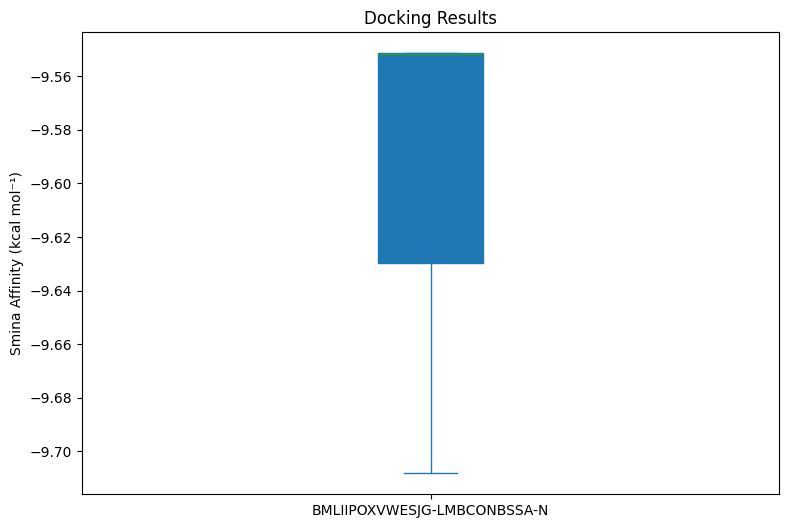

In [ ]:
# @title Results
import matplotlib.pyplot as plt
color_list=[]

fig,ax = plt.subplots(figsize=(9,6))

bp = poses_df.plot.box(
    by=["InChIKey"],
    column="minimizedAffinity",
    grid=False,
    patch_artist=True,
    return_type='both',
    ax=ax)

ax.set_title("Docking Results")
ax.set_ylabel("Smina Affinity (kcal mol⁻¹)")
plt.show()


In [ ]:
# @title Download Results
poses_df.to_csv("MCT8_docking_results.csv", sep="\t")
from google.colab import files
files.download("MCT8_docking_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>